In [2]:
import time
import copy
import random
import functools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


The Agent Class:

In [3]:
class Agent:

  def __init__(self, start: tuple, goal: tuple, real_stage, view_range=1):
      self.x = start[0]
      self.y = start[1]
      self.goal = goal
      self.view_range = view_range
      self.explored_stage = np.full_like(real_stage, -1)
      self.explored_stage[self.x, self.y] = 0
      self.agent_view(real_stage)
      self.start_time = time.time()

  def agent_view(self, real_stage):
    """ Refreshes the explored map of the agent (sees up, down, left, right). """
    up_obs, upleft_obs, upright_obs, down_obs, downleft_obs, downright_obs, left_obs, right_obs = False, False, False, False, False, False, False, False
    for i in range(self.view_range):
      if self.x > i:  # checks up
        tmp_x = self.x - i - 1
        if not up_obs:  # stops if it sees obstacle
          self.explored_stage[(tmp_x, self.y)] = real_stage[(tmp_x, self.y)]
          if real_stage[(tmp_x, self.y)]:
            up_obs = True
        if self.y > i and not upleft_obs:  # up-left
          if not upleft_obs:  # stops if it sees obstacle
            self.explored_stage[(tmp_x, self.y - i - 1)] = real_stage[(tmp_x, self.y - i - 1)]
            if real_stage[(tmp_x, self.y - i - 1)]:
              upleft_obs = True
        if self.y < len(real_stage[0]) - i - 1: # up-right
          if not upright_obs:  # stops if it sees obstacle
            self.explored_stage[(tmp_x, self.y + i + 1)] = real_stage[(tmp_x, self.y + i + 1)]
            if real_stage[(tmp_x, self.y + i + 1)]:
              upright_obs = True

      if self.x < len(real_stage) - i - 1:  # checks down:
        tmp_x = self.x + i + 1
        if not down_obs:
          self.explored_stage[(tmp_x, self.y)] = real_stage[(tmp_x, self.y)]
          if real_stage[(tmp_x, self.y)]:
            down_obs = True
        if self.y > i:  # down-left
          if not downleft_obs:
            self.explored_stage[(tmp_x, self.y - i - 1)] = real_stage[(tmp_x, self.y - i - 1)]
            if real_stage[(tmp_x, self.y - i - 1)]:
              downleft_obs = True
        if self.y < len(real_stage[0]) - i - 1: # down-right
          if not downright_obs:
            self.explored_stage[(tmp_x, self.y + i + 1)] = real_stage[(tmp_x, self.y + i + 1)]
            if real_stage[(tmp_x, self.y + i + 1)]:
              downright_obs = True

      if self.y > i and not left_obs:  # left (& stops if it sees obstacle)
        self.explored_stage[(self.x, self.y - i - 1)] = real_stage[(self.x, self.y - i - 1)]
        if real_stage[(self.x, self.y - i - 1)]:
          left_obs = True

      if self.y < len(real_stage[0]) - i - 1 and not right_obs: # right (& stops if it sees obstacle)
        self.explored_stage[(self.x, self.y + i + 1)] = real_stage[(self.x, self.y + i + 1)]
        if real_stage[(self.x, self.y + i + 1)]:
          right_obs = True

    self.explored_stage[self.explored_stage == 2] = 0

  def check_goal(self):
    if (self.x, self.y) == self.goal:
      return True
    return False

A* Algorithm (source [here.](https://pypi.org/project/python-astar/)):

In [4]:
"""
Python-astar - A* path search algorithm
"""

class Tile:
    """A tile is a walkable space on a map."""
    distance = 0
    came_from = None

    def __init__(self, x, y, weight=1):
        self.x = x
        self.y = y
        self.weight = 1
        assert (self.x is not None and self.y is not None)

    def update_origin(self, came_from):
        """Update which tile this one came from."""
        self.came_from = came_from
        self.distance = came_from.distance + self.weight

    def __eq__(self, other):
        """A tile is the same if they have the same position"""
        return (other and self.x == other.x and self.y == other.y)

    def __lt__(self, other):
        """We want the shortest distance tile to find the happy path.
        This is used by min() so we can just compare them :)
        """
        return (self.distance + self.weight <= other.distance)

    def __hash__(self):
        """We need this so we can use a set()"""
        return hash(str(self))

    @property
    def pos(self):
        """a (x, y) tuple with position on the grid"""
        return (self.x, self.y)

    def __str__(self):
        return str(self.pos)

    def __repr__(self):
        return str(self)


class AStar:
    """The A Star (A*) path search algorithm"""

    def __init__(self, world):
        world2 = copy.deepcopy(world)
        world2[world2 == -1] = 0
        world2[world2 == 2] = 0
        self.world = world2

    def search(self, start_pos, target_pos):
        """A_Star (A*) path search algorithm"""
        start = Tile(*start_pos)
        self.open_tiles = set([start])
        self.closed_tiles = set()

        # while we still have tiles to search
        while len(self.open_tiles) > 0:
            # get the tile with the shortest distance
            tile = min(self.open_tiles)
            # check if we're there. Happy path!
            if tile.pos == target_pos:
                return self.rebuild_path(tile)
            # search new ways in the neighbor's tiles.
            self.search_for_tiles(tile)

            self.close_tile(tile)
        # if we got here, path is blocked :(
        return None

    def search_for_tiles(self, current):
        """Search for new tiles in the maze"""
        for other in self.get_neighbors(current):
            if self.is_new_tile(other):
                other.update_origin(current)
                self.open_tiles.add(other)

            # if this other has gone a farthest distance before
            #   then we just found a new and shortest way to it.
            elif other > current:
                other.update_origin(current)
                if other in self.closed_tiles:
                    self.reopen_tile(other)

    def get_neighbors(self, tile):
        """Return a list of available tiles around a given tile"""
        min_x = max(0, tile.x - 1)
        max_x = min(len(self.world)-1, tile.x + 1)
        min_y = max(0, tile.y - 1)
        max_y = min(len(self.world[tile.x])-1, tile.y + 1)

        available_tiles = [
            (min_x, tile.y),
            (max_x, tile.y),
            (tile.x, min_y),
            (tile.x, max_y),
        ]
        neighbors = []
        for x, y in available_tiles:
            if (x, y) == tile.pos:
                continue

            if self.world[x][y] == 0:
                neighbors.append(Tile(x, y))

        return neighbors

    def rebuild_path(self, current):
        """Rebuild the path from each tile"""
        self.last_tile = current
        path = []
        while current is not None:
            path.append(current)
            current = current.came_from
        path.reverse()
        # return a list with tuples
        return [tile.pos for tile in path]

    def is_new_tile(self, tile):
        """Check if this is a proviously unknown tile"""
        return (
            tile not in self.open_tiles
            and tile not in self.closed_tiles
        )

    def reopen_tile(self, tile):
        """Reinstate a tile in the open list"""
        self.closed_tiles.remove(tile)
        self.open_tiles.add(tile)

    def close_tile(self, tile):
        """Remove tile from open_tiles, as we are done testing it"""
        self.open_tiles.remove(tile)
        self.closed_tiles.add(tile)


Create a stage with obstacles (1) and free path (0).

In [ ]:
def generate_stage(rows: int, cols: int, obs_prob = 0.2):

  # generate obstacles with obs_prob probability
  num_obstacles = int(rows * cols * obs_prob)

  stage = np.full((rows, cols), 0)

  # Set 1s at random positions for the specified percentage
  indices = np.random.choice(rows * cols, num_obstacles, replace=False)
  stage.flat[indices] = 1

  return stage

 Creates the "explored" stage, which at the start everything is not explored (-1) and put the agents there (2).

In [5]:
def generate_agents(real_stage, num_agents: int = 1, view_range: int = 1):

  agents = []

  if num_agents <= 0:
    num_agents = 1

  zero_coordinates = list(zip(*np.where(real_stage == 0)))
  goal = random.choice(zero_coordinates)
  # Create the "explored" stage
  for _ in range(num_agents):
    if zero_coordinates:
      start = random.choice(zero_coordinates)
      zero_coordinates.remove(start)
      agents.append(Agent((start[0], start[1]), (goal[0], goal[1]), real_stage, view_range))
    else:
      break

  return agents

Function to concat all agents explored stages (returns the total explored stage):

In [6]:
def update_total_explored(agents):
  if len(agents) == 0:
    return

  total_explored = np.full(agents[0].explored_stage.shape, -1)

  for a in agents:
    total_explored[total_explored == -1] = a.explored_stage[total_explored == -1]
    total_explored[total_explored == 2] = 0

  for a in agents:
    if not a.check_goal():  # if agent has reached goal -> collidable (as if it is removed from the stage).
      total_explored[a.x, a.y] = 2

  # Total explored contains the concats of all agents stages:
  for a in agents:
    a.explored_stage = copy.deepcopy(total_explored)

  return total_explored

Calculates the explored percentage of the concat stage:

In [7]:
def calculate_expl_percentage(total_explored):
  num_minus_1 = np.sum(total_explored == -1)
  explored_percentage = 1 - (num_minus_1 / (total_explored.shape[0] * total_explored.shape[1]))
  return explored_percentage

Function to plot the grid/maze:

In [8]:
def draw_maze(maze, path=None):
    fig, ax = plt.subplots(figsize=(10,10))

    fig.patch.set_edgecolor('white')
    fig.patch.set_linewidth(0)

    ax.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')

    if path is not None:
        x_coords = [x[1] for x in path]
        y_coords = [y[0] for y in path]
        ax.plot(x_coords, y_coords, color='red', linewidth=2)
        ax.scatter(path[-1][1], path[-1][0], color='red', s=100, marker='s')

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

Function for testing astar:

In [9]:
def move_astar(start_grid, start_agents, debug=True):

  grid = copy.deepcopy(start_grid)

  agents = copy.deepcopy(start_agents)

  for agent in agents:
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
  total_explored = update_total_explored(agents)
  total_agents = len(agents)
  # print(total_agents)
  avg_eps_time = []
  avg_agent_time = []

  while any((agent.x, agent.y) != agent.goal for agent in agents):
      eps_start_time = time.time()
      path_none = 0
      for agent in agents:
          if (agent.x, agent.y) == agent.goal:
              avg_agent_time.append(time.time() - agent.start_time)
              total_explored = update_total_explored(agents)
              agents.remove(agent)
              continue  # Agent has reached its goal

          path = AStar(agent.explored_stage).search((agent.x, agent.y), agent.goal)
          if debug:
            draw_maze(agent.explored_stage, path=path)

          if path:
              if agent.explored_stage[path[1]] != 2:
                grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
                agent.x, agent.y = path[1]  # Update agent position
                grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
                # if agent.check_goal():
          else:
            path_none += 1
          agent.agent_view(start_grid)
          total_explored = update_total_explored(agents)
      avg_eps_time.append(time.time() - eps_start_time)
      if path_none >= len(agents): # stops if no agents have moved.
          print(path_none, len(agents))
          print("STOP PATH NONE")
          break

  # if debug:
  #     print(total_explored)
  # print(len(agents))
  # test_fin = 0
  for agent in agents:  # gets the time of some finished agents (that have not been counted),
    if (agent.x, agent.y) == agent.goal:
      avg_agent_time.append(time.time() - agent.start_time)
      # test_fin += 1
  # print(test_fin)
  return calculate_expl_percentage(total_explored), len(avg_agent_time) / total_agents, total_explored, np.mean(avg_eps_time), np.mean(avg_agent_time)

Manual Examples:

LESS OBSTACLES STAGE


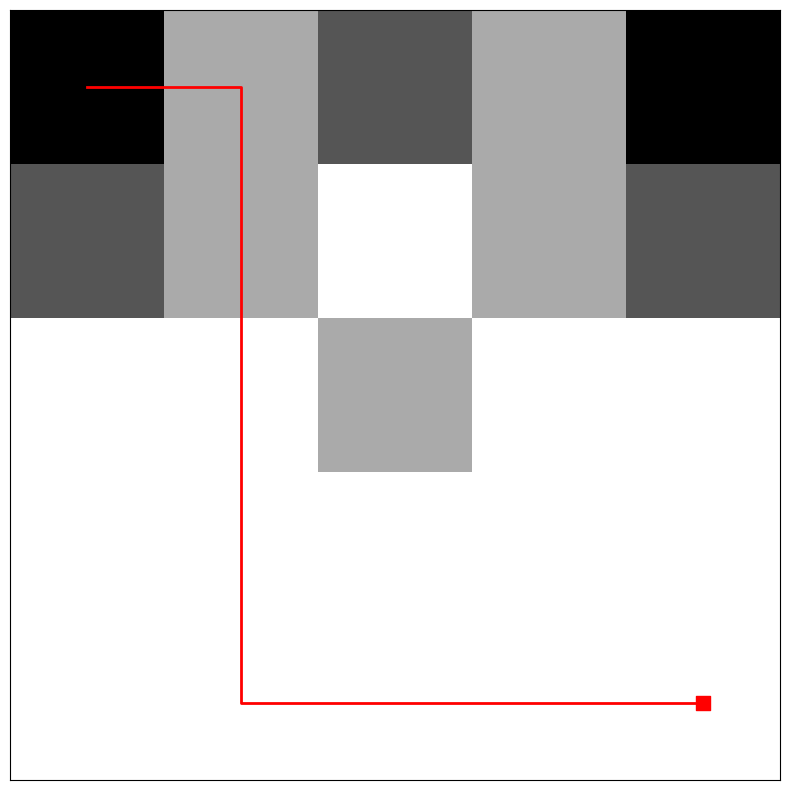

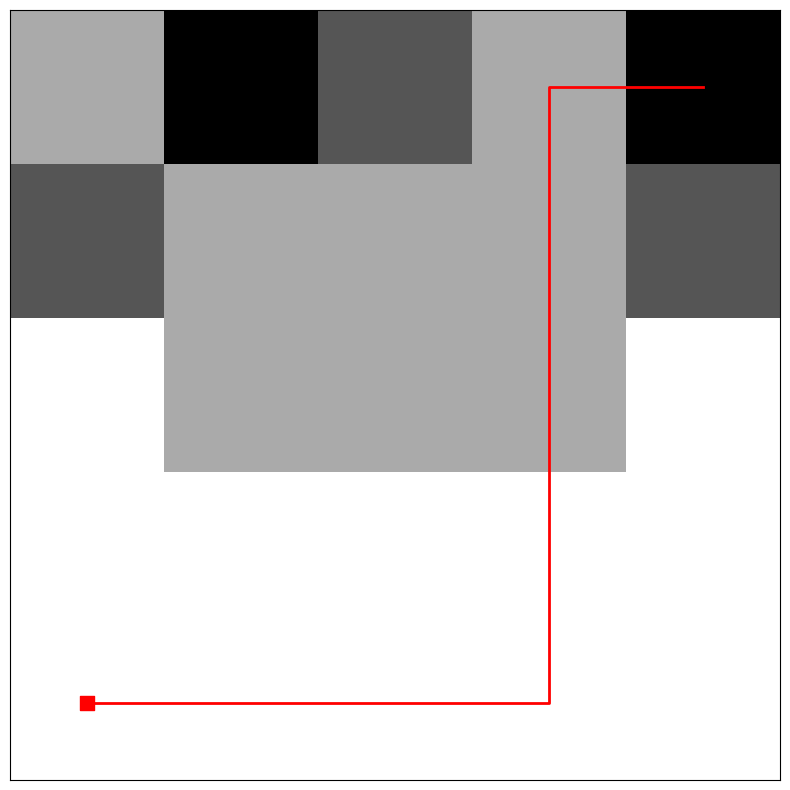

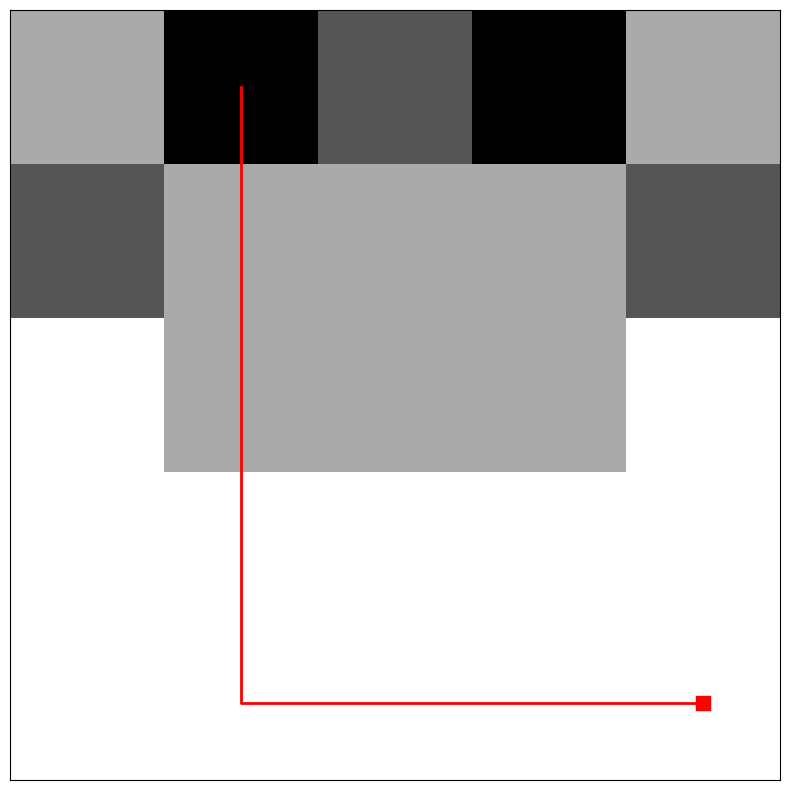

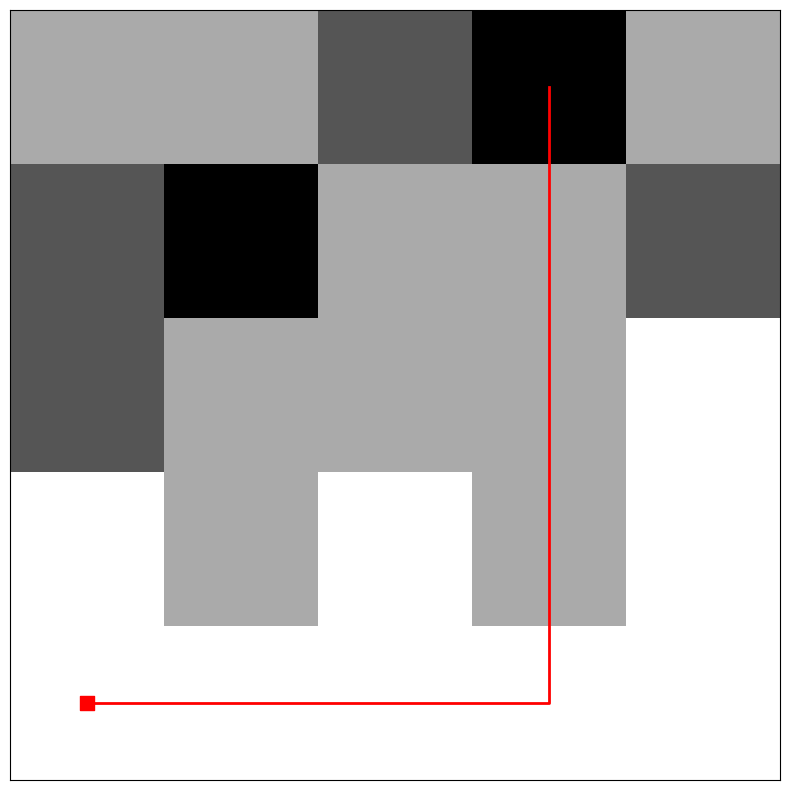

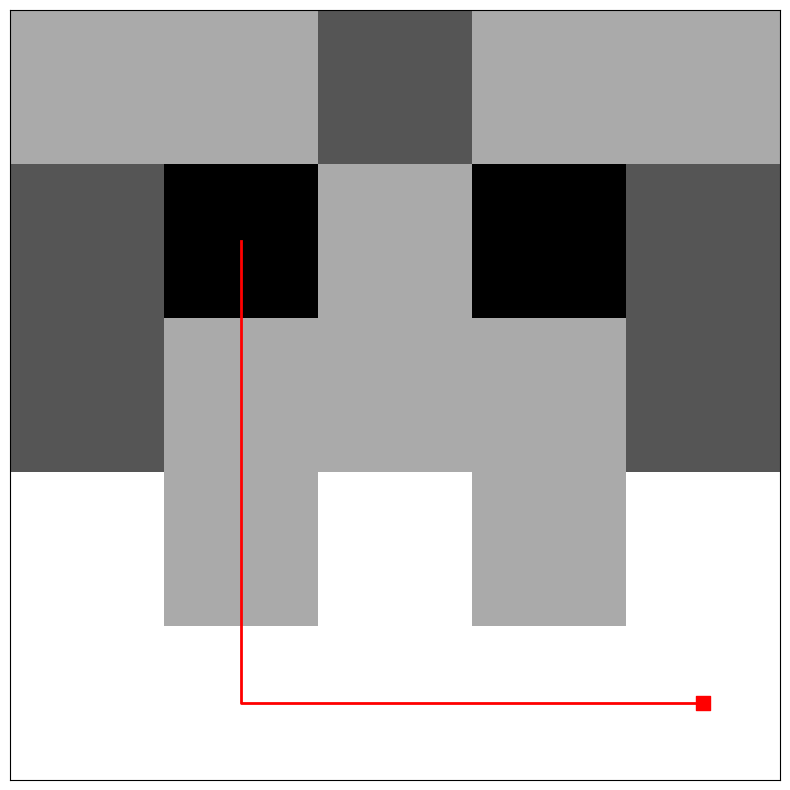

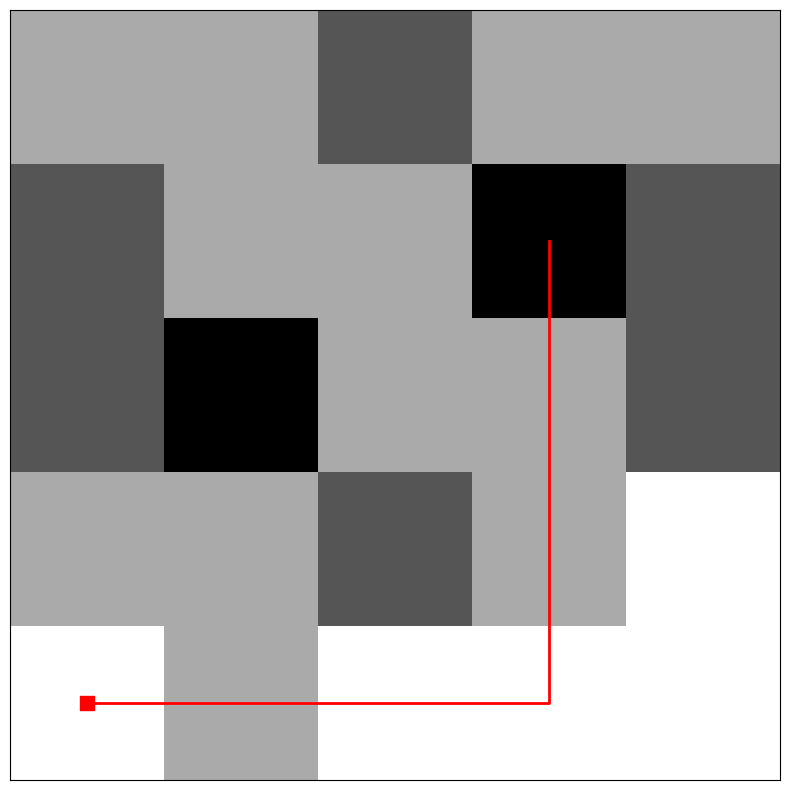

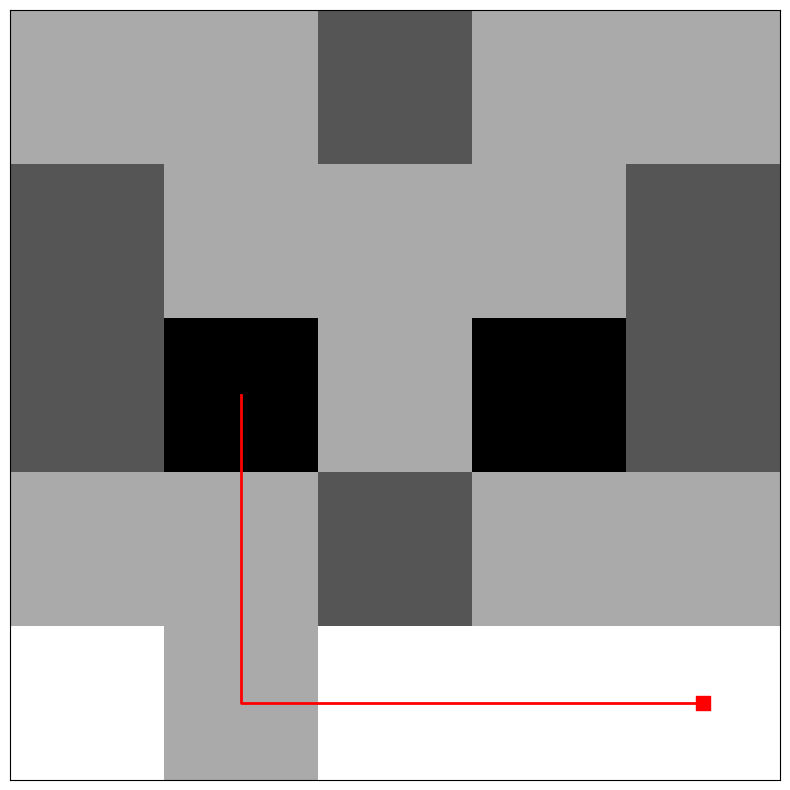

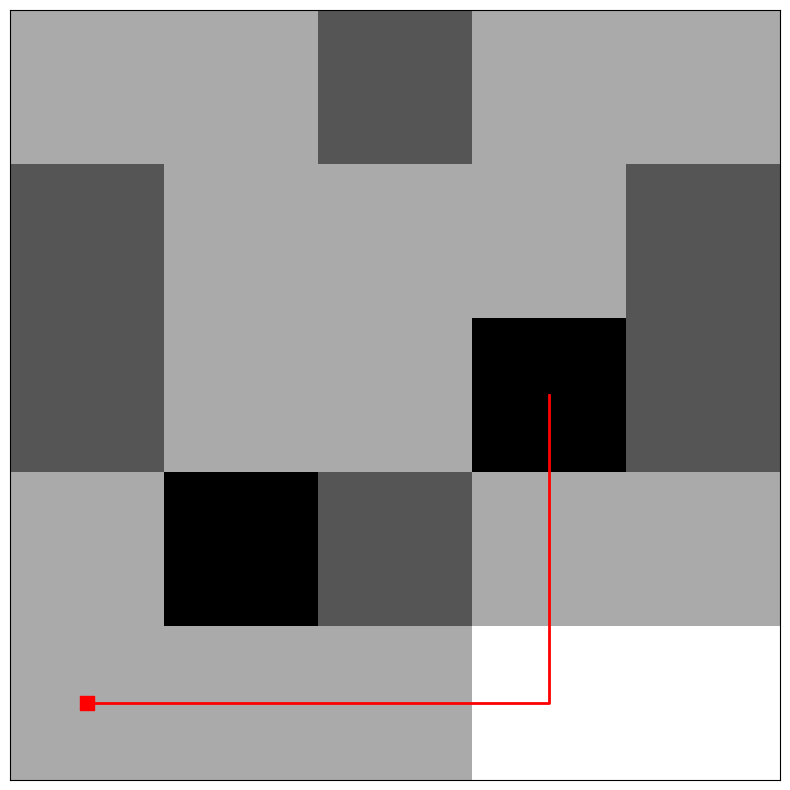

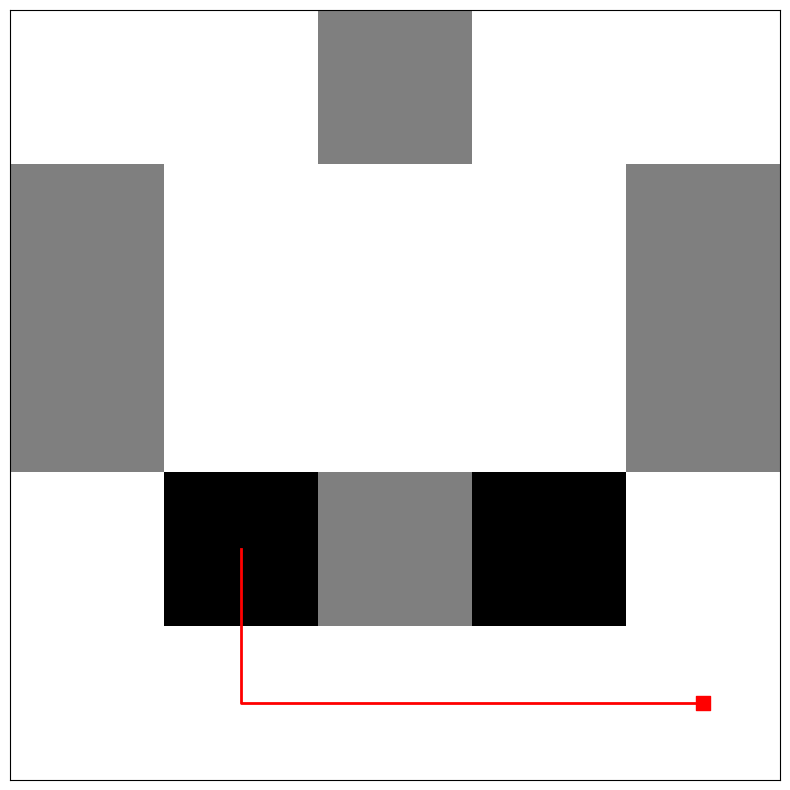

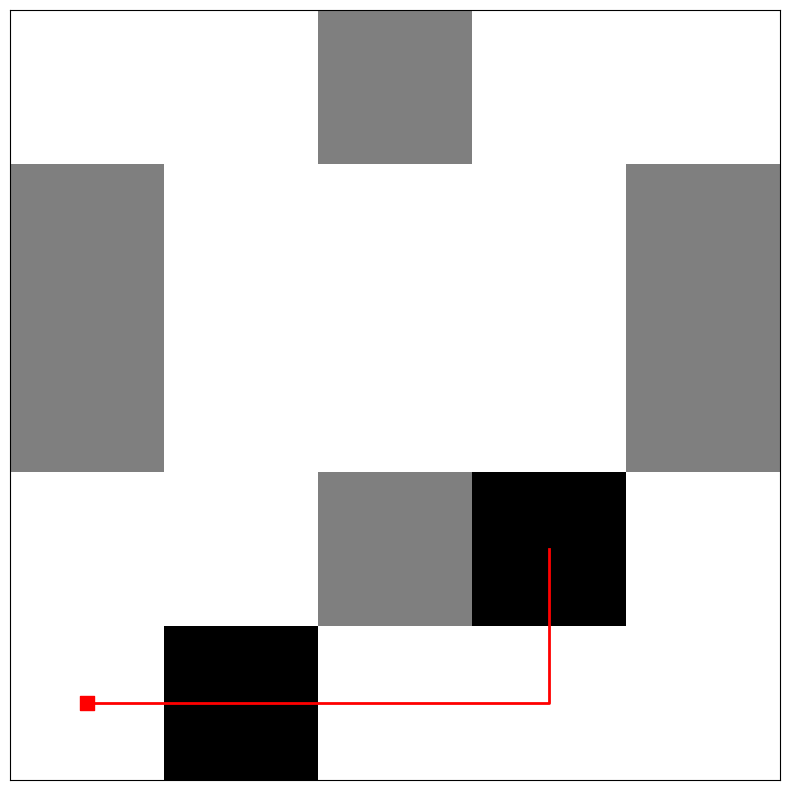

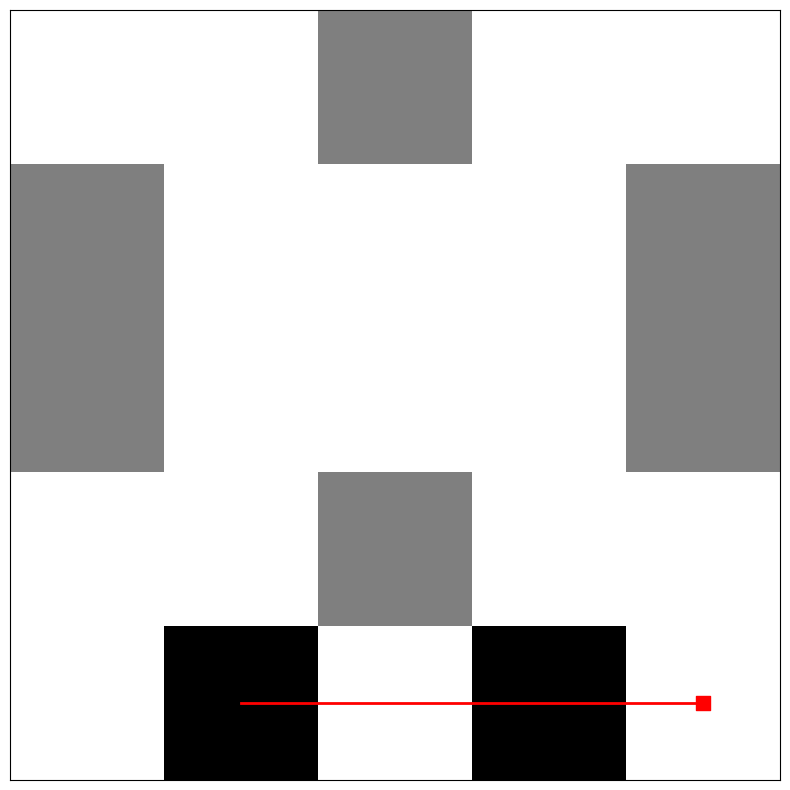

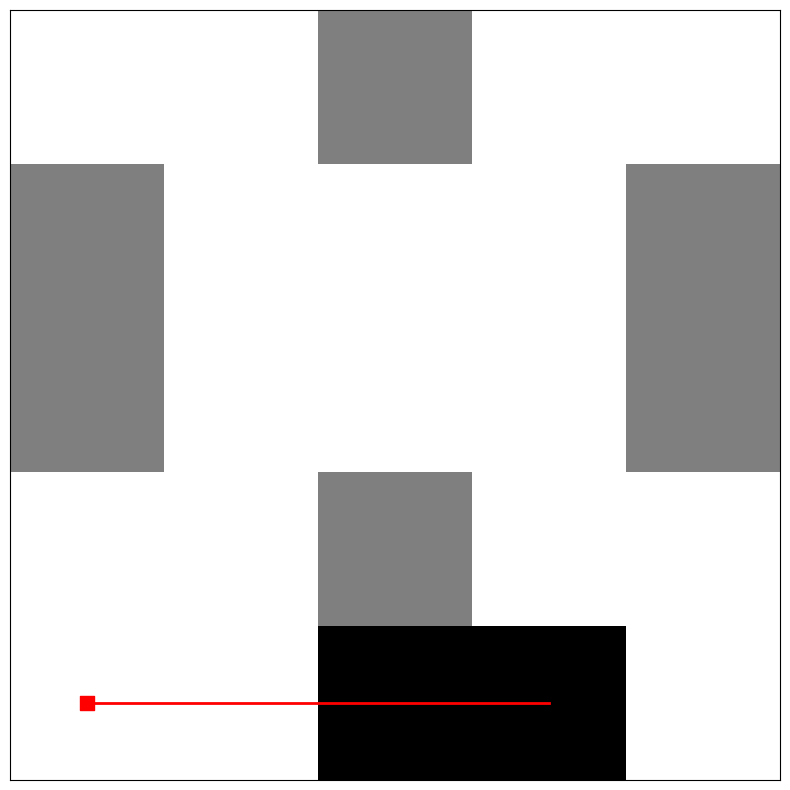

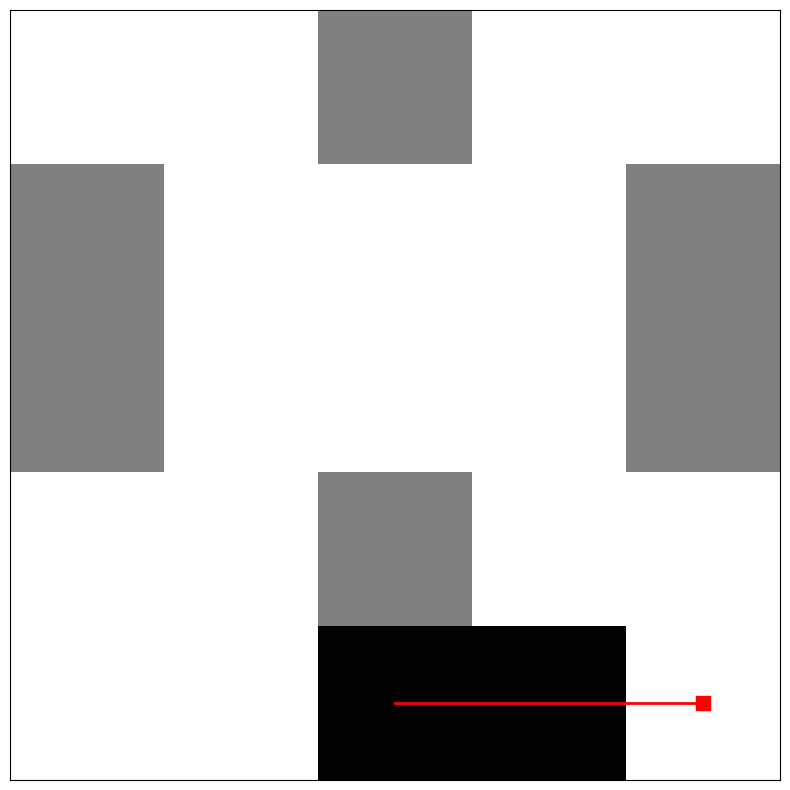

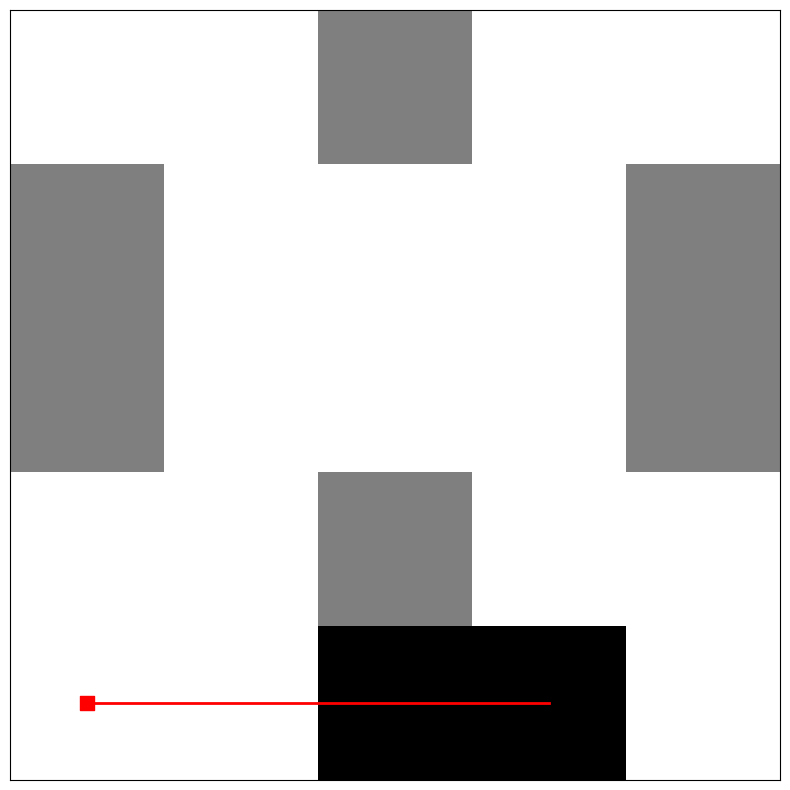

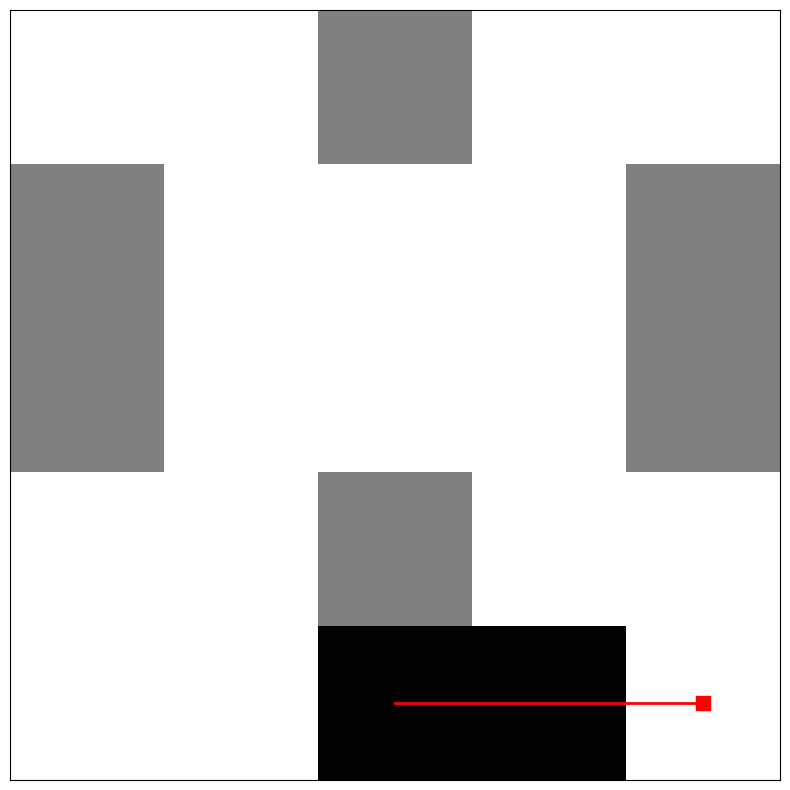

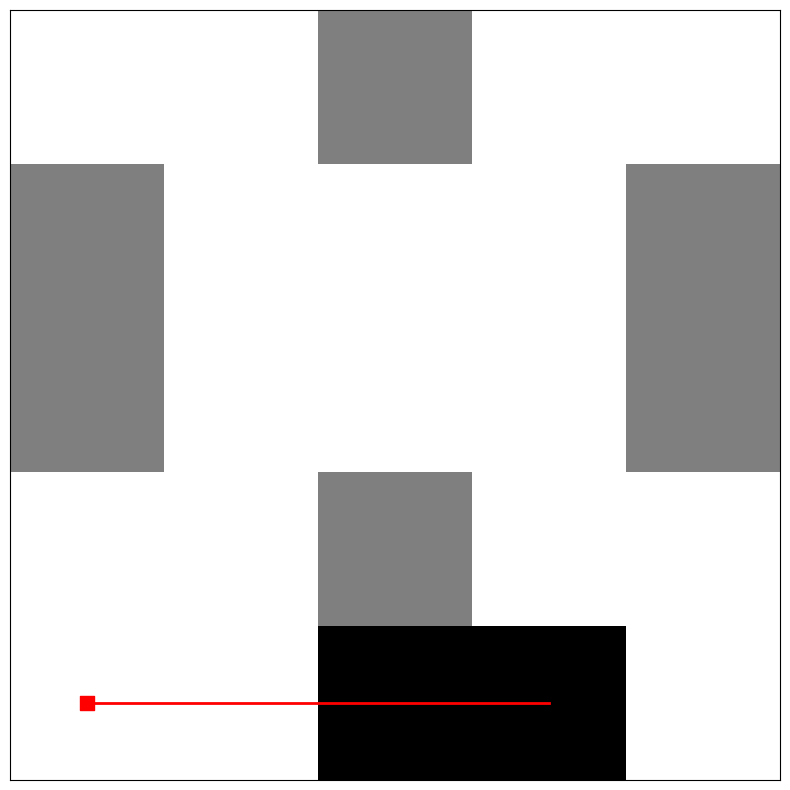

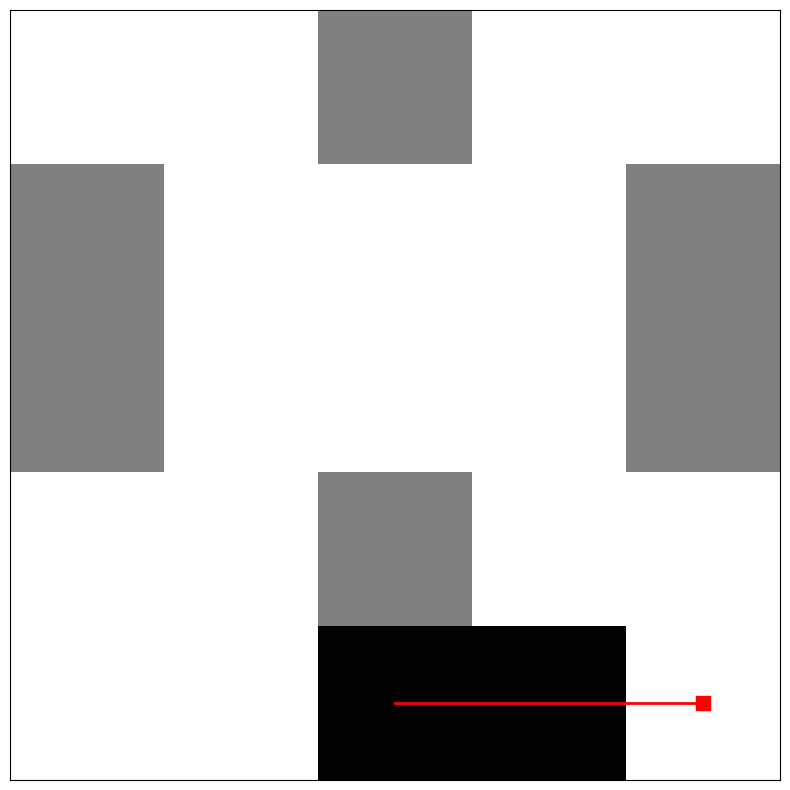

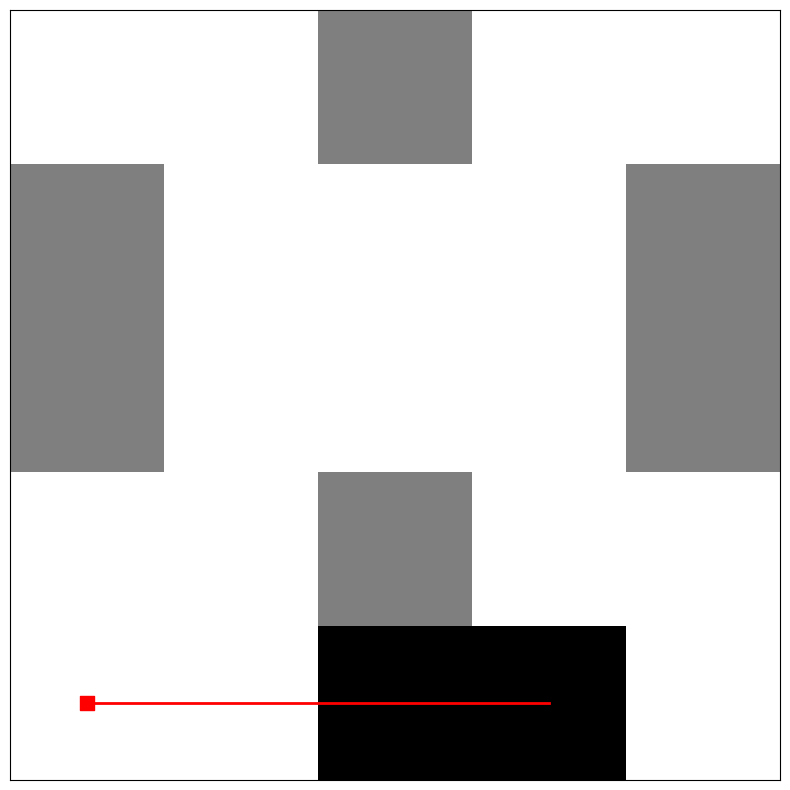

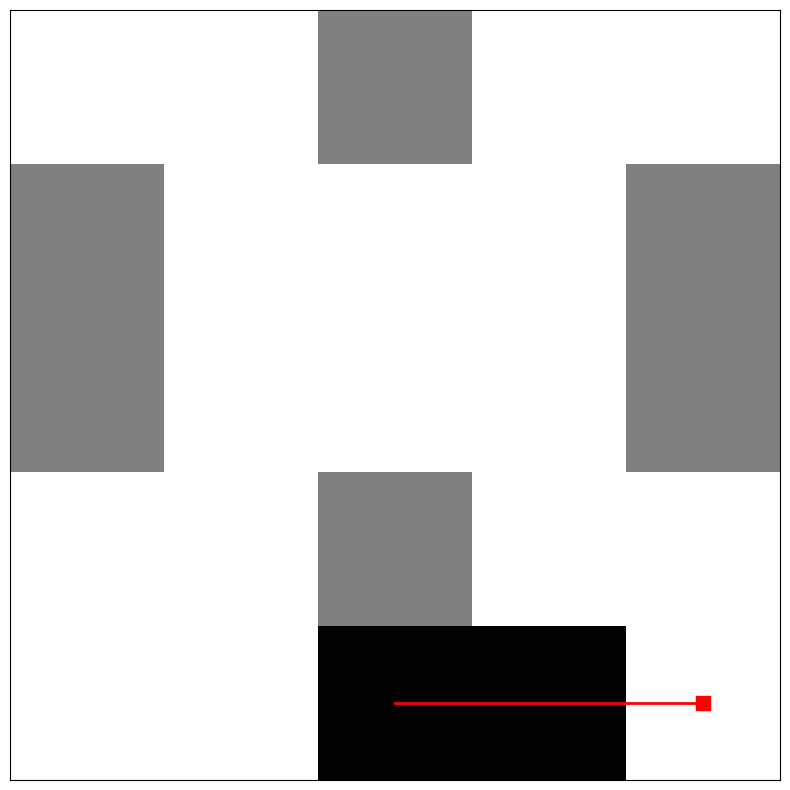

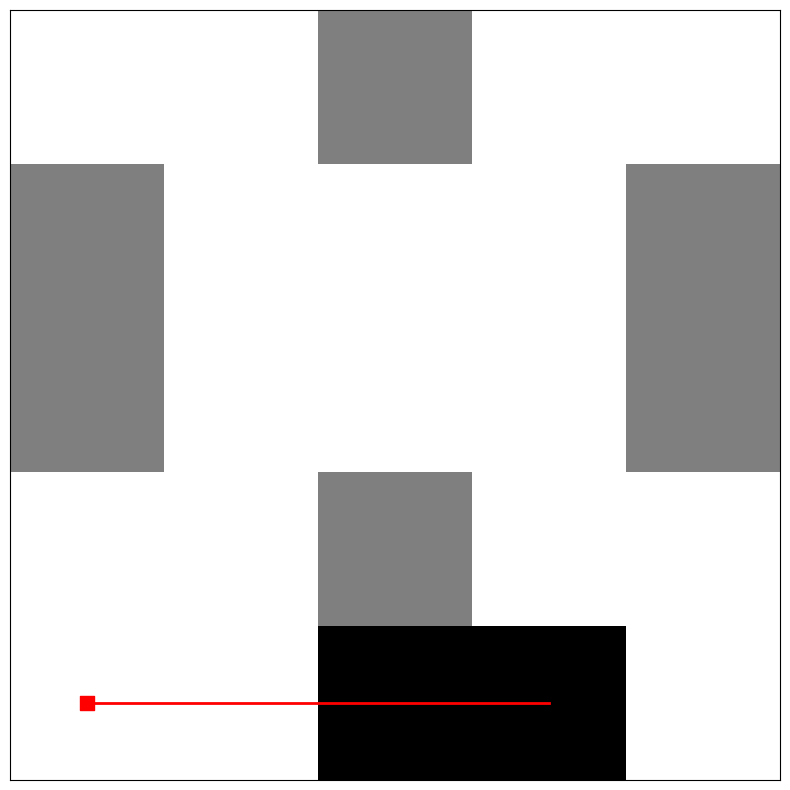

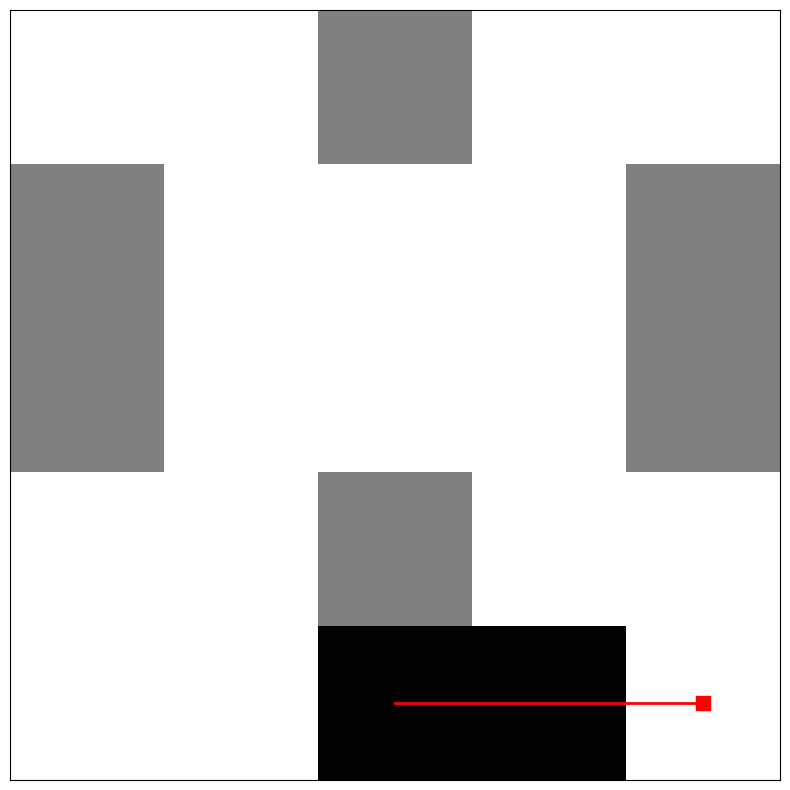

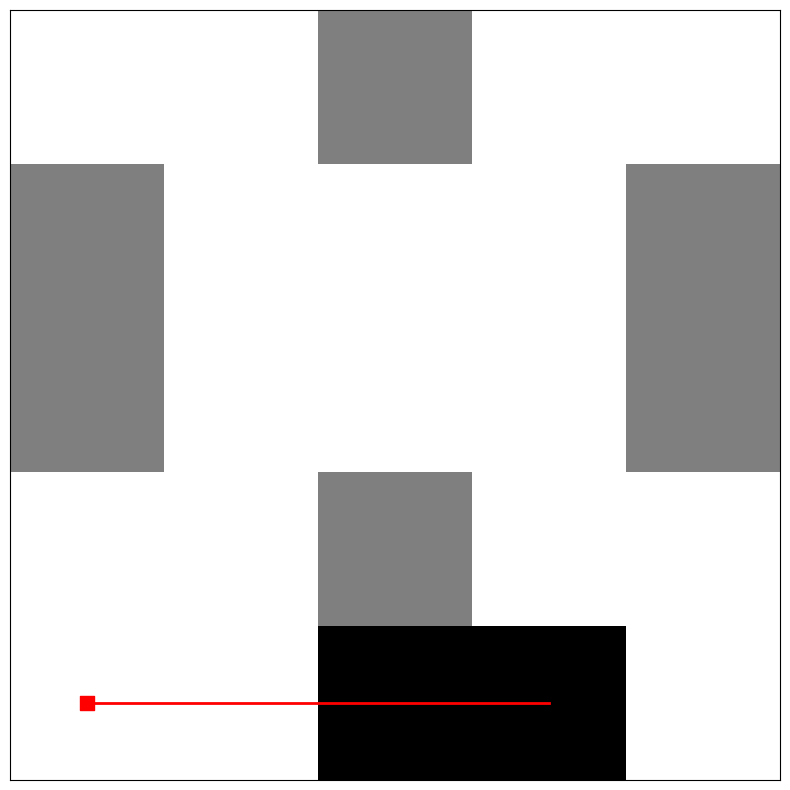

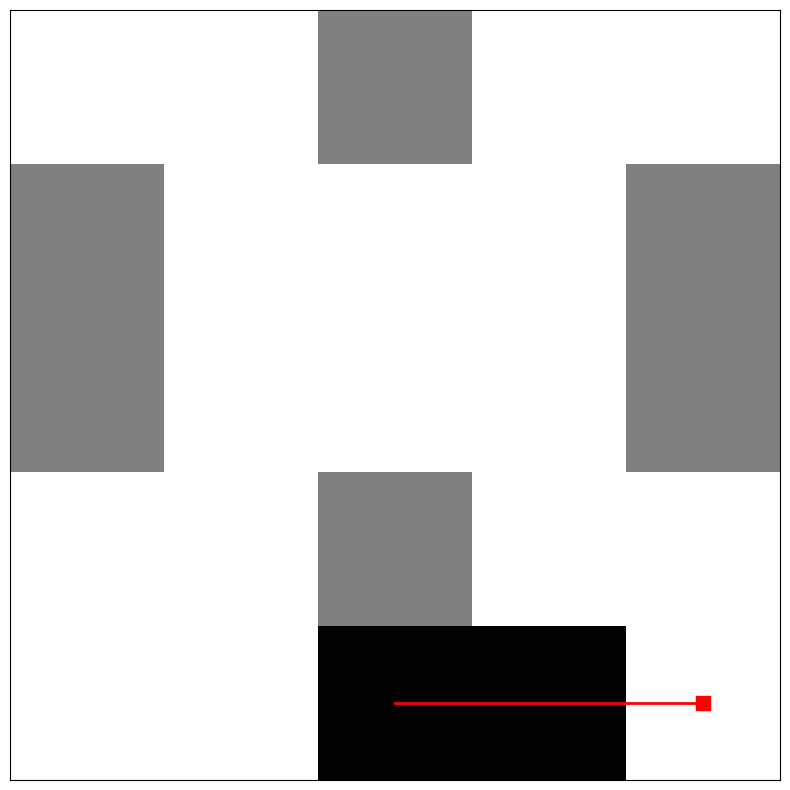

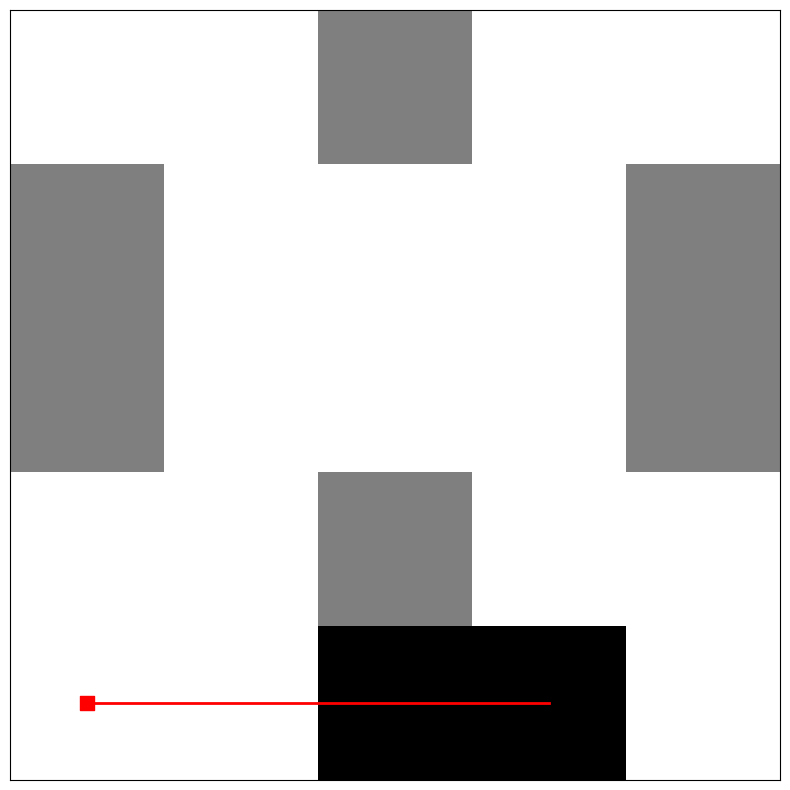

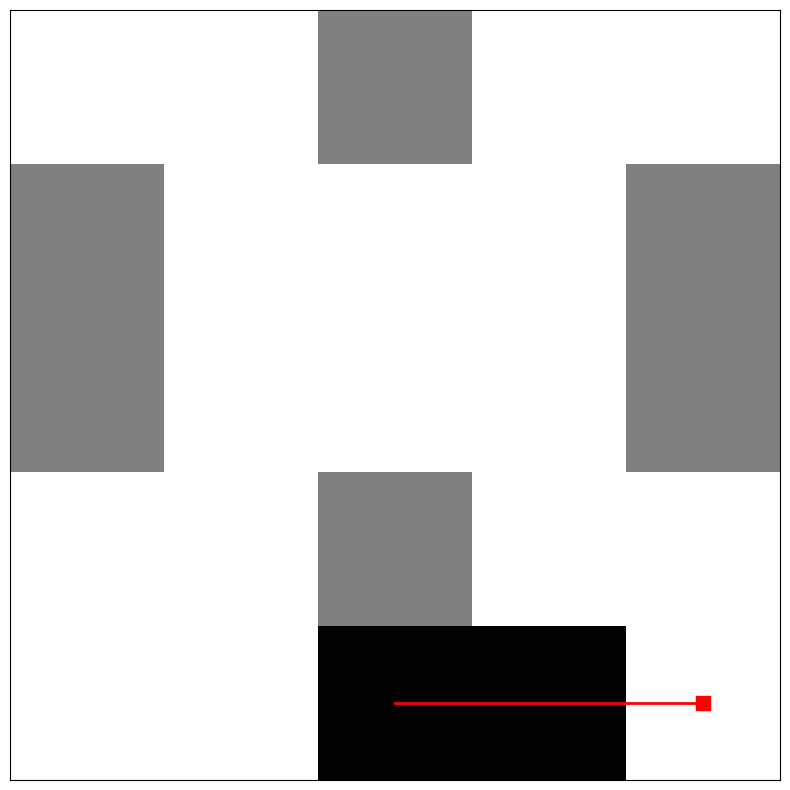

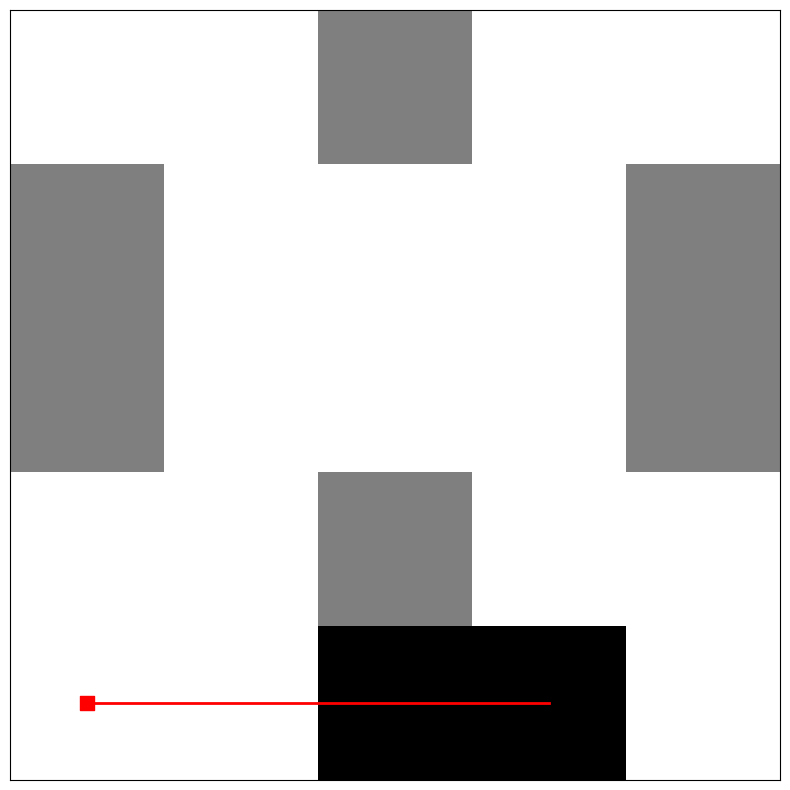

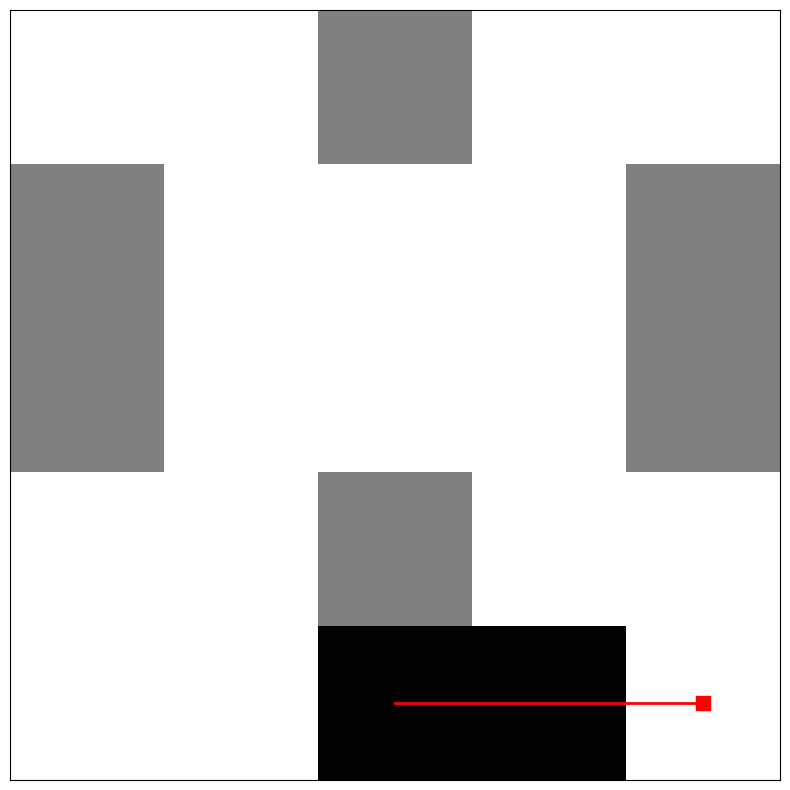

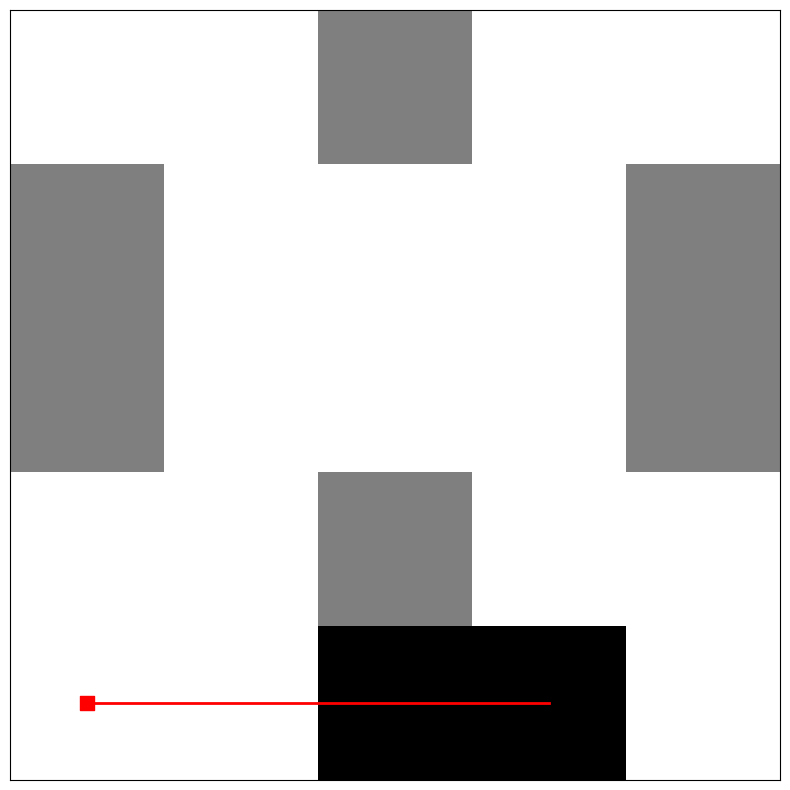

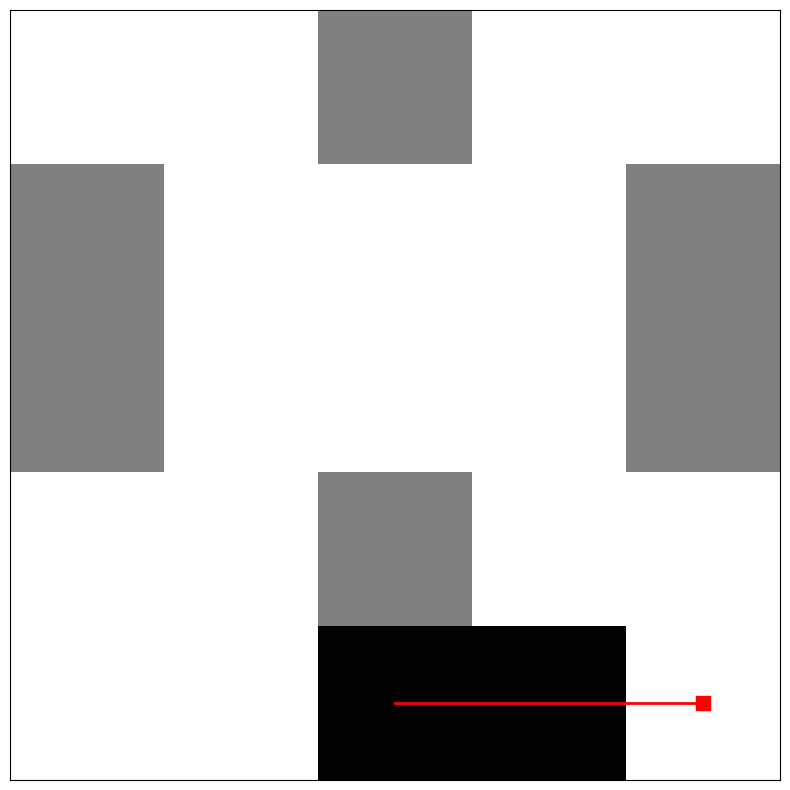

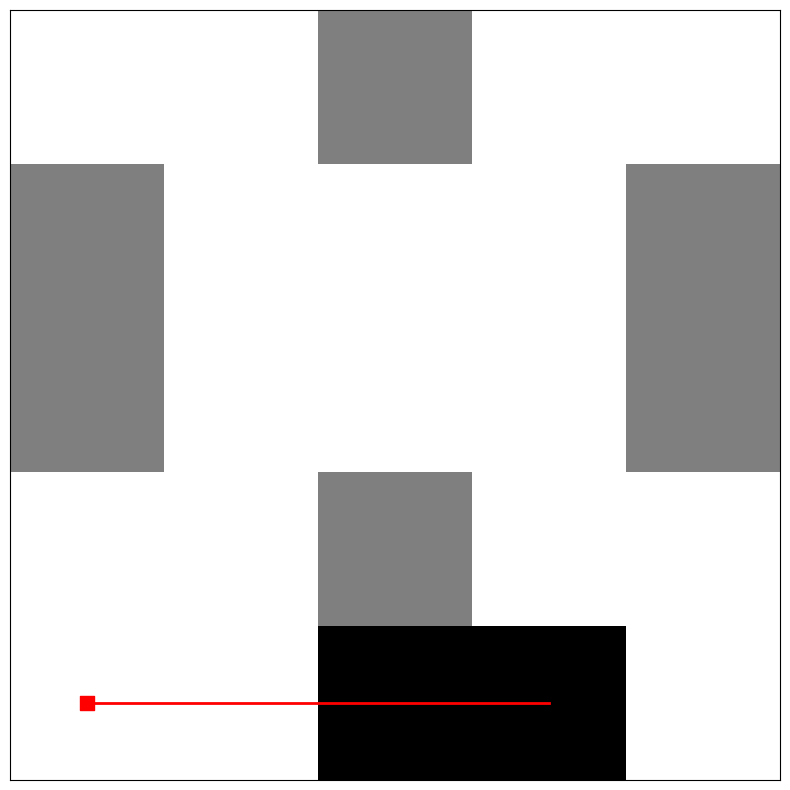

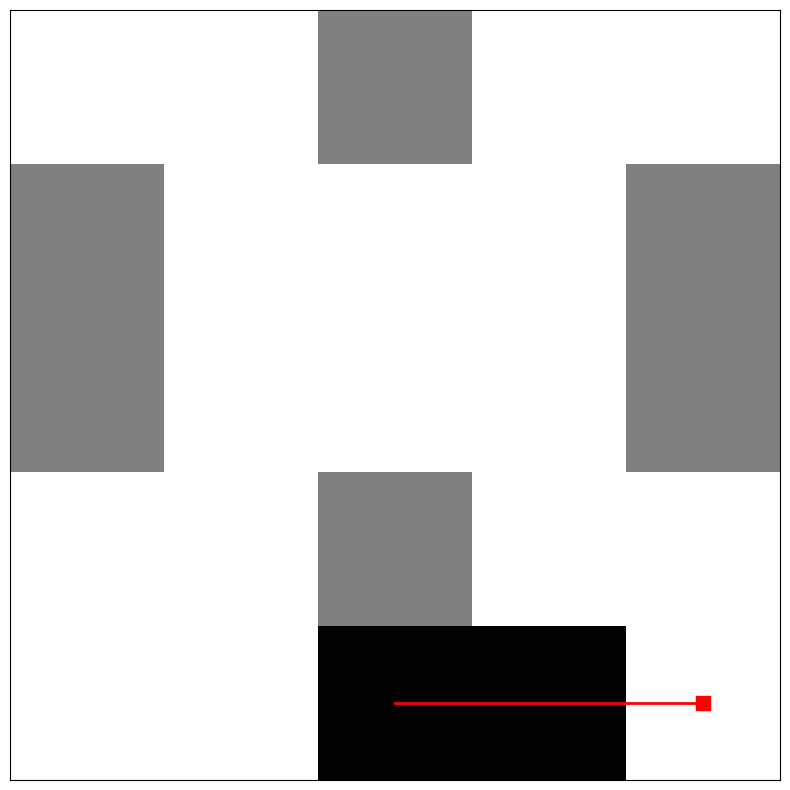

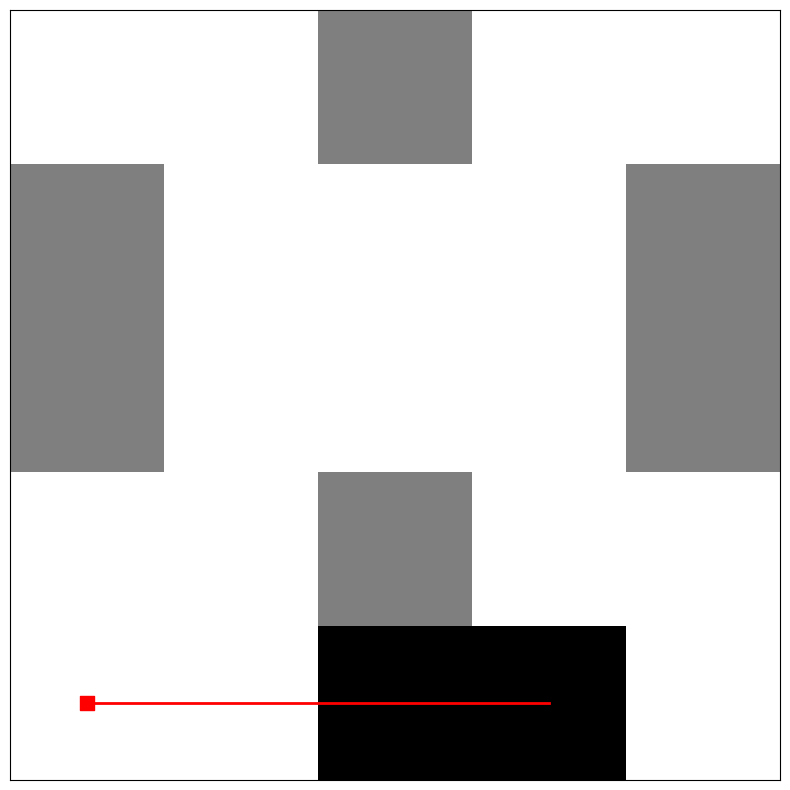

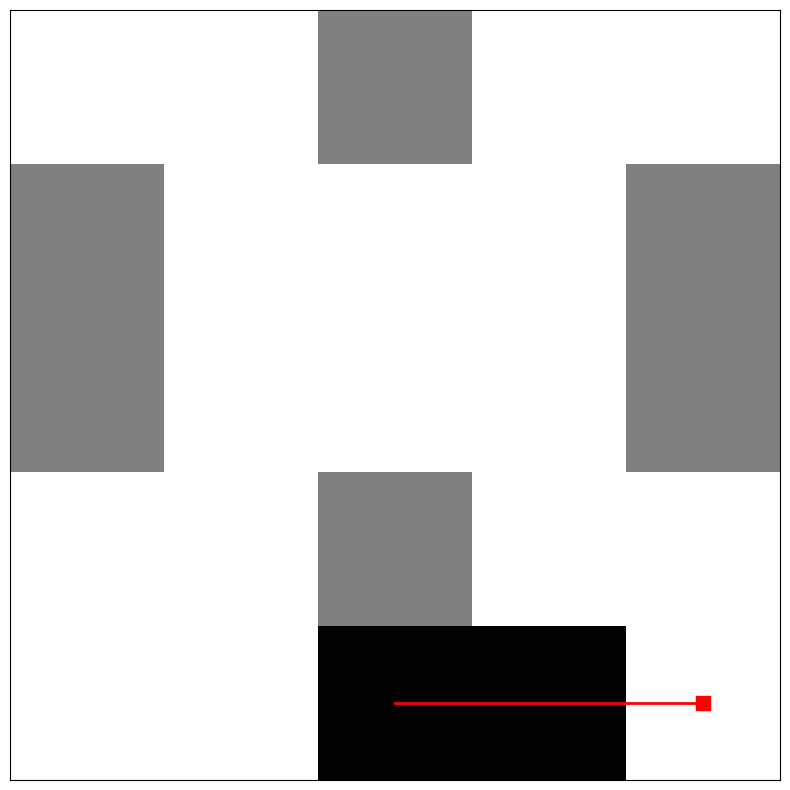

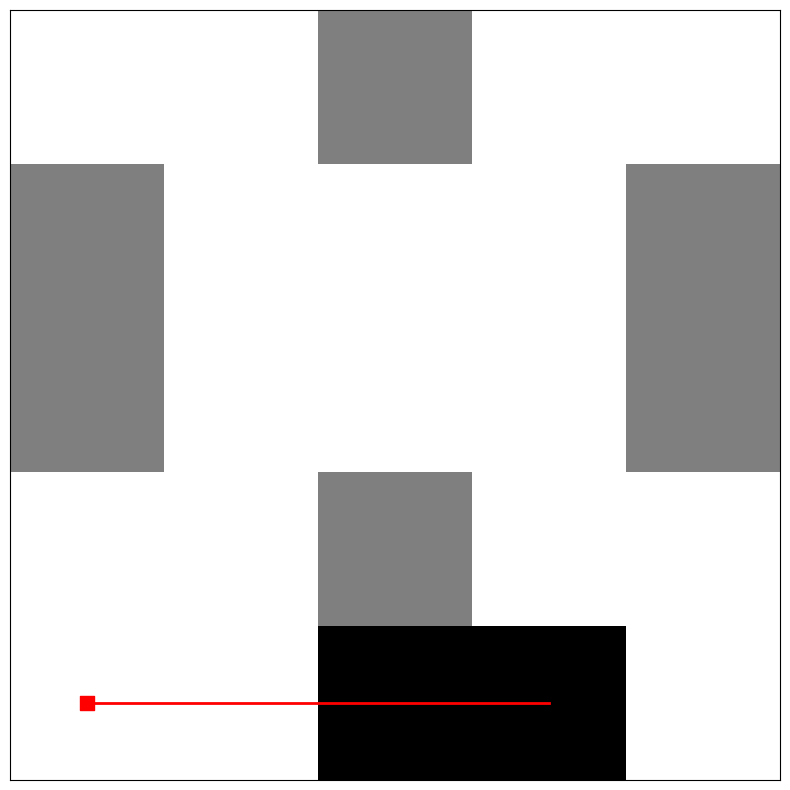

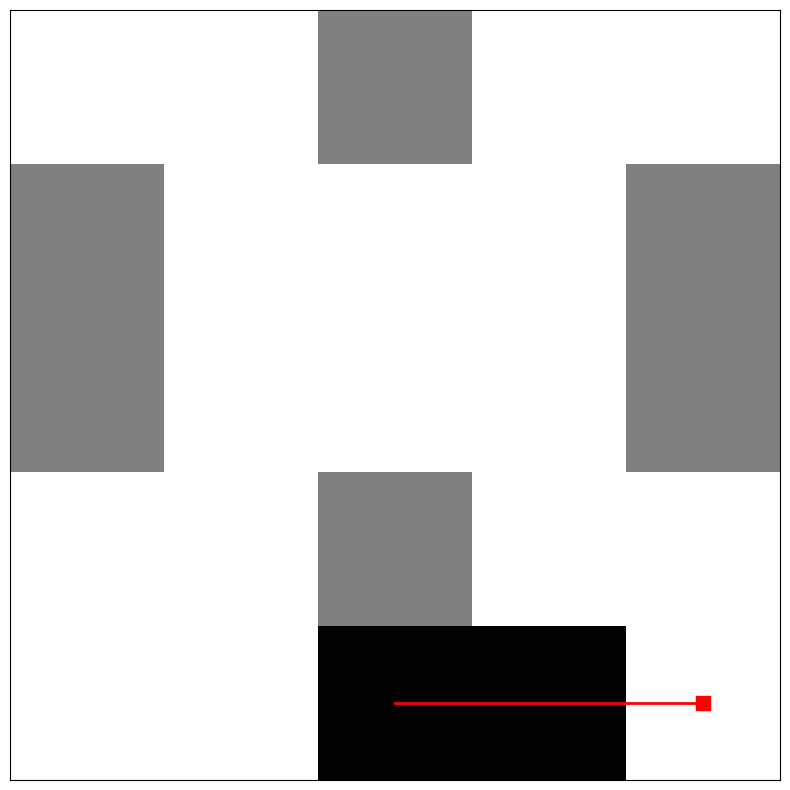

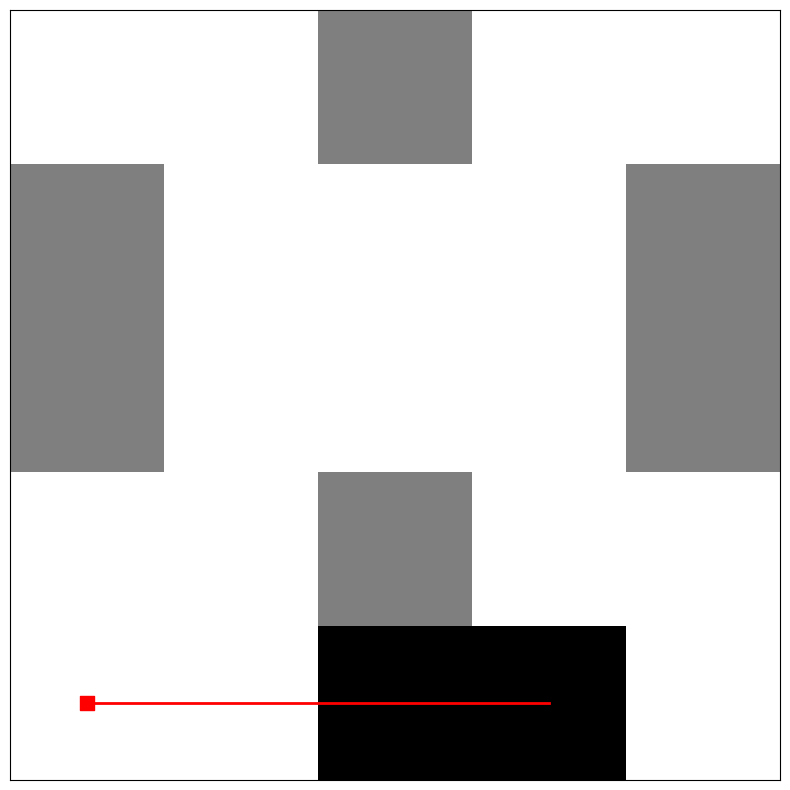

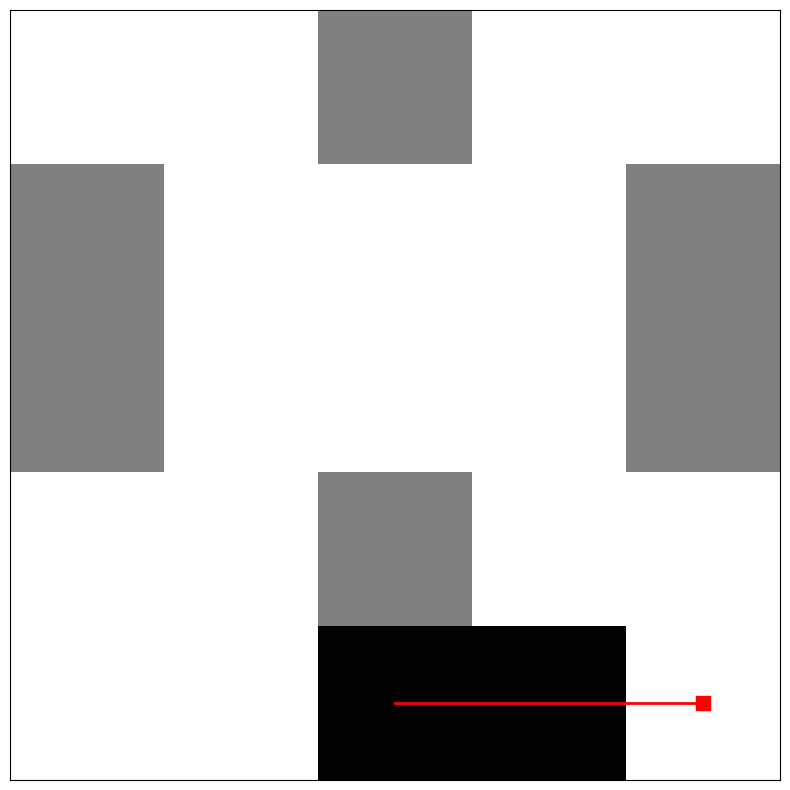

KeyboardInterrupt: ignored

In [ ]:
grid = np.array([[0, 0, 1, 0, 0],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0]])

print("LESS OBSTACLES STAGE")
agents = [Agent((0, 0), (4, 4), grid, 2), Agent((0, 4), (4, 0), grid),]
res = move_astar(grid, agents)
print(f"Total Coverage Percentage {res[0]} / Agents Finished: {res[1]} / Average Episode Time: {res[3]} / Average Agent Finish Time : {res[4]}")
print(f"Final Explored Stage\n{res[2]}")

MANY OBSTACLES STAGE


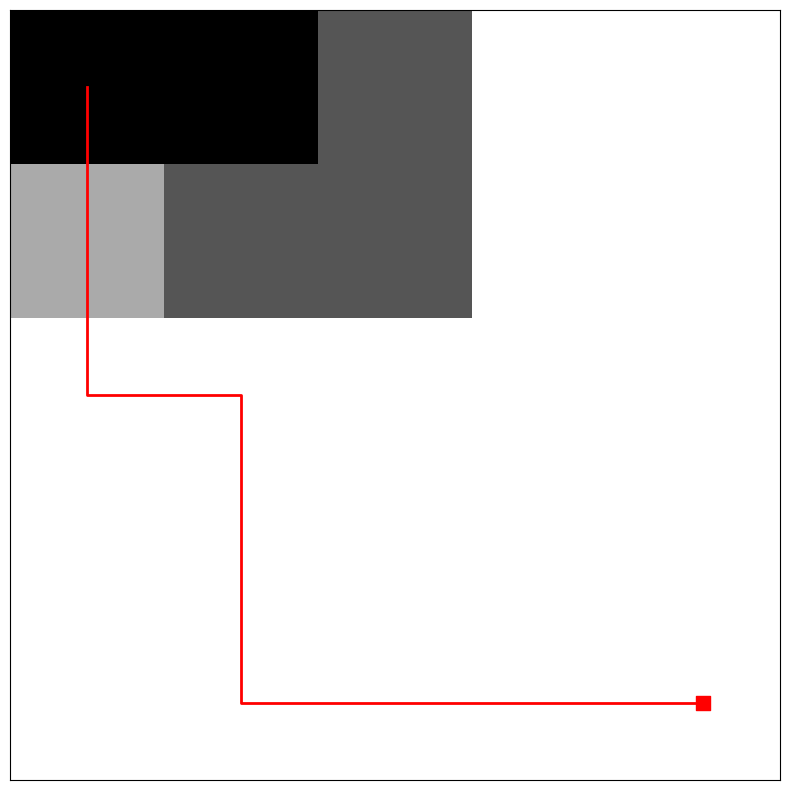

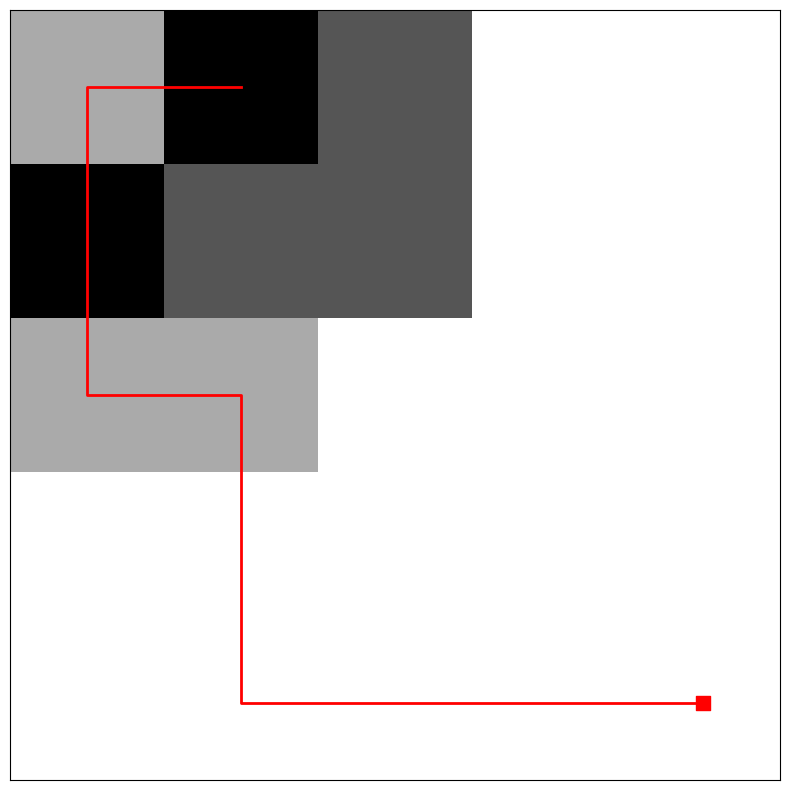

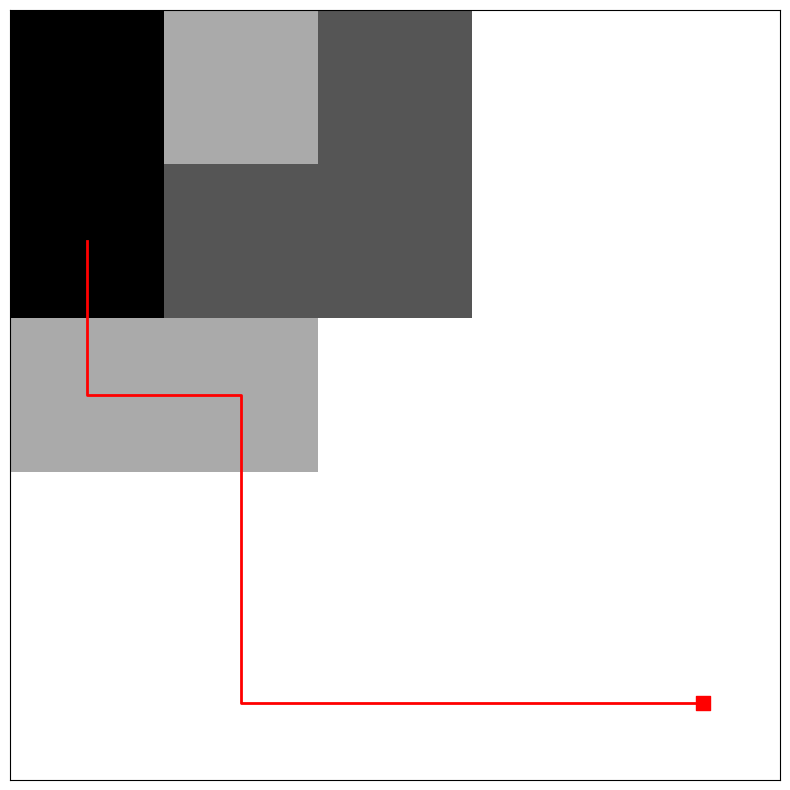

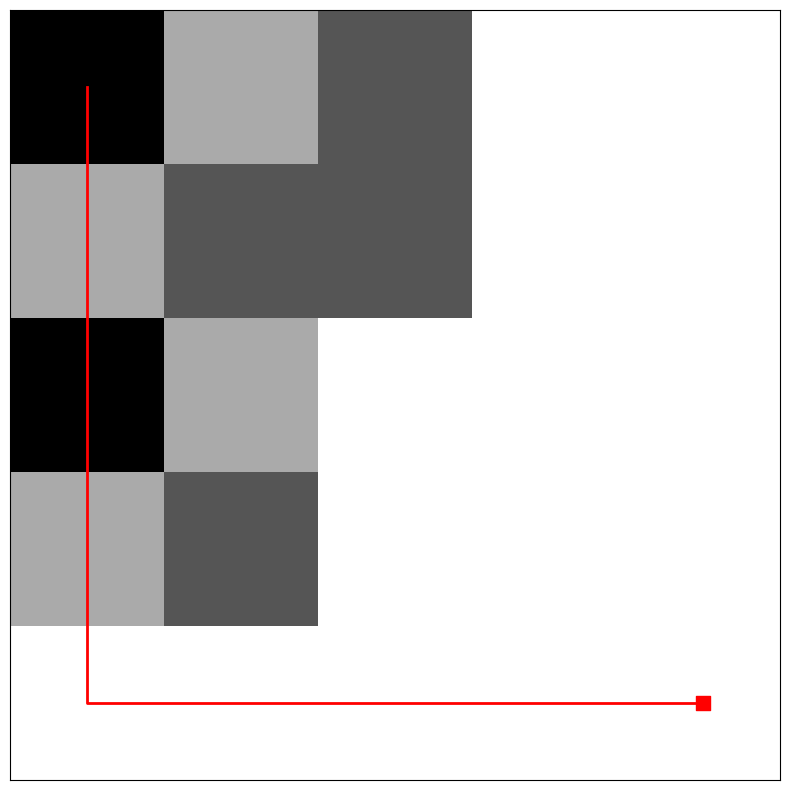

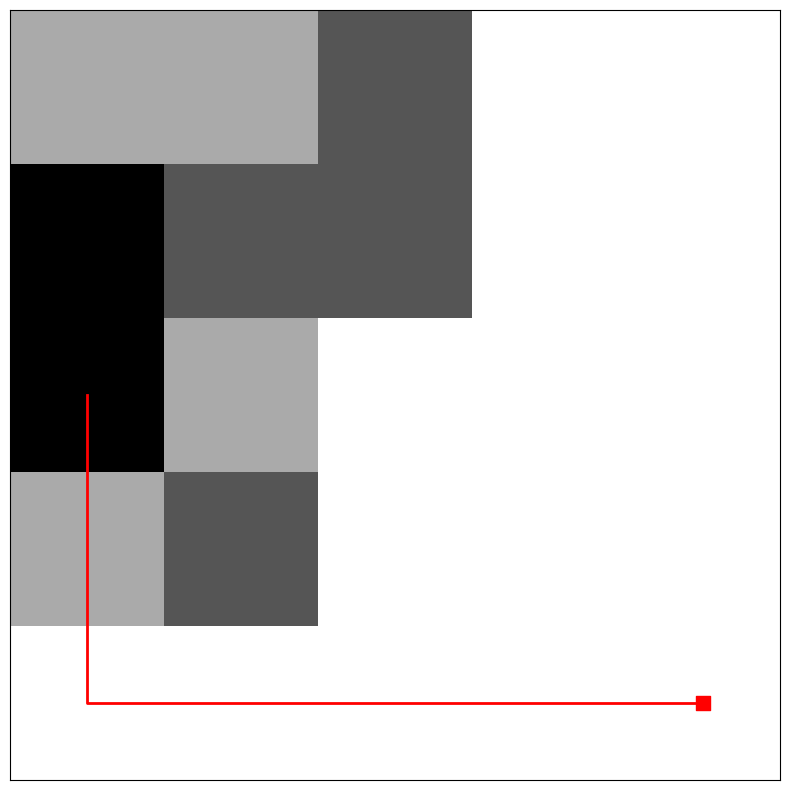

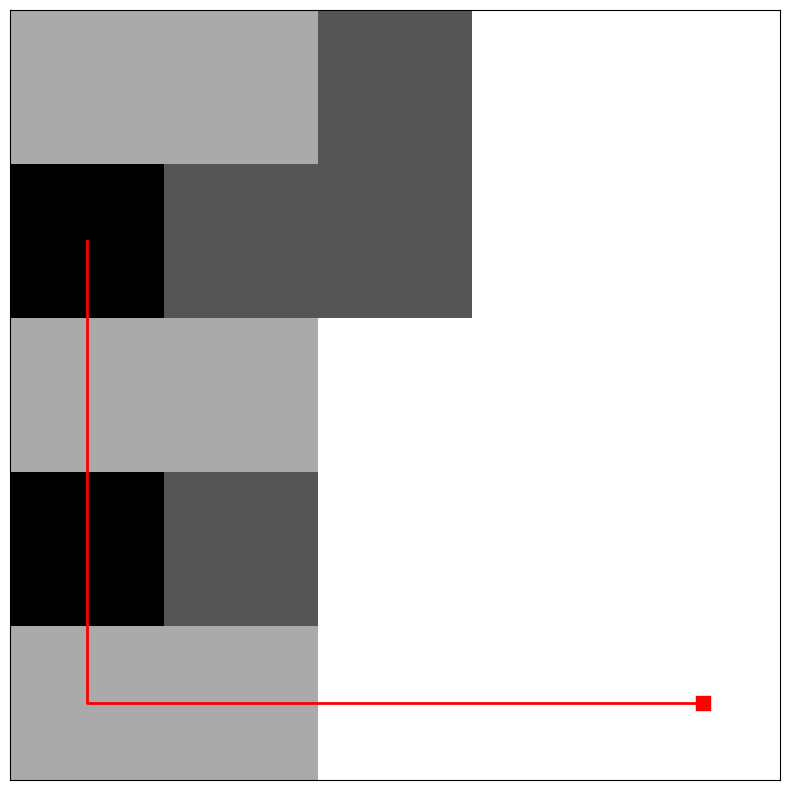

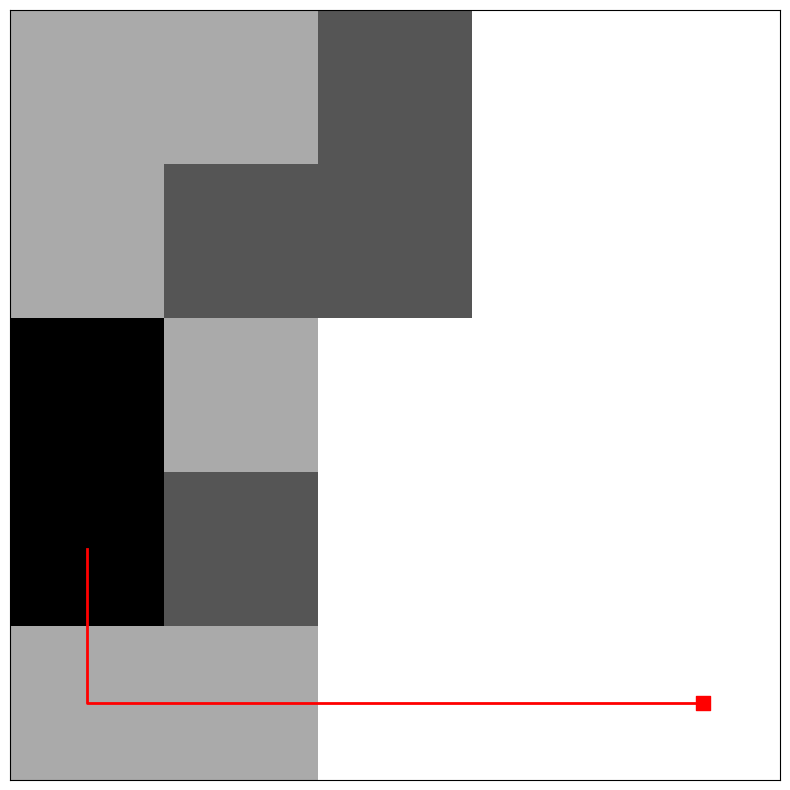

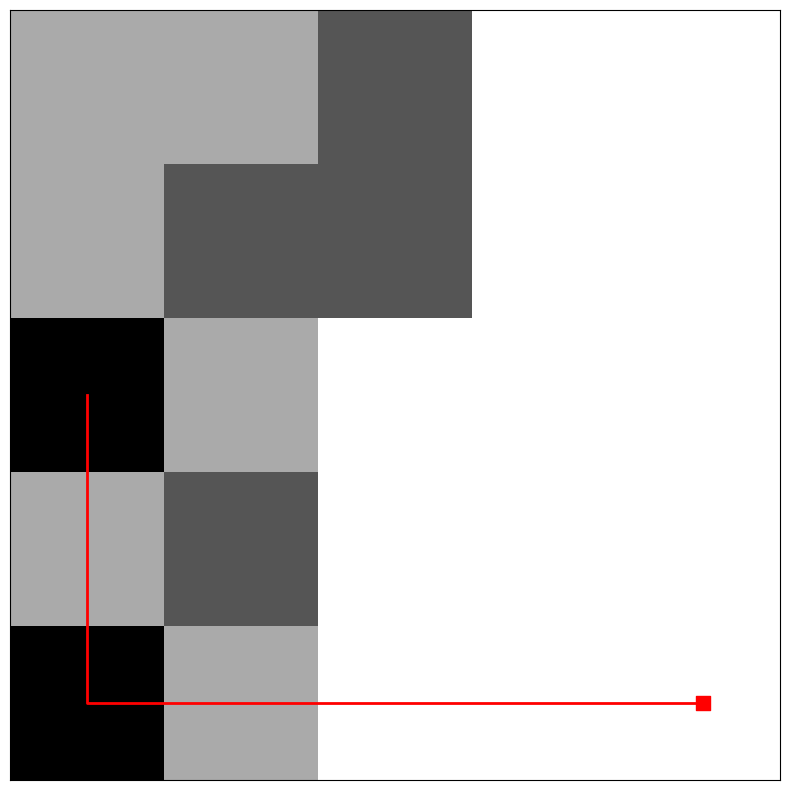

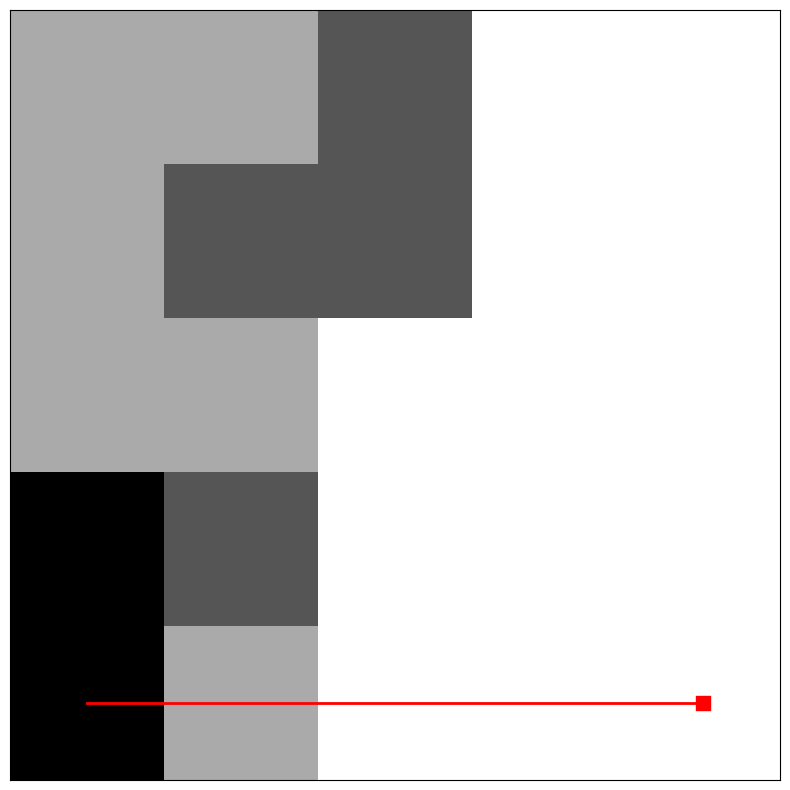

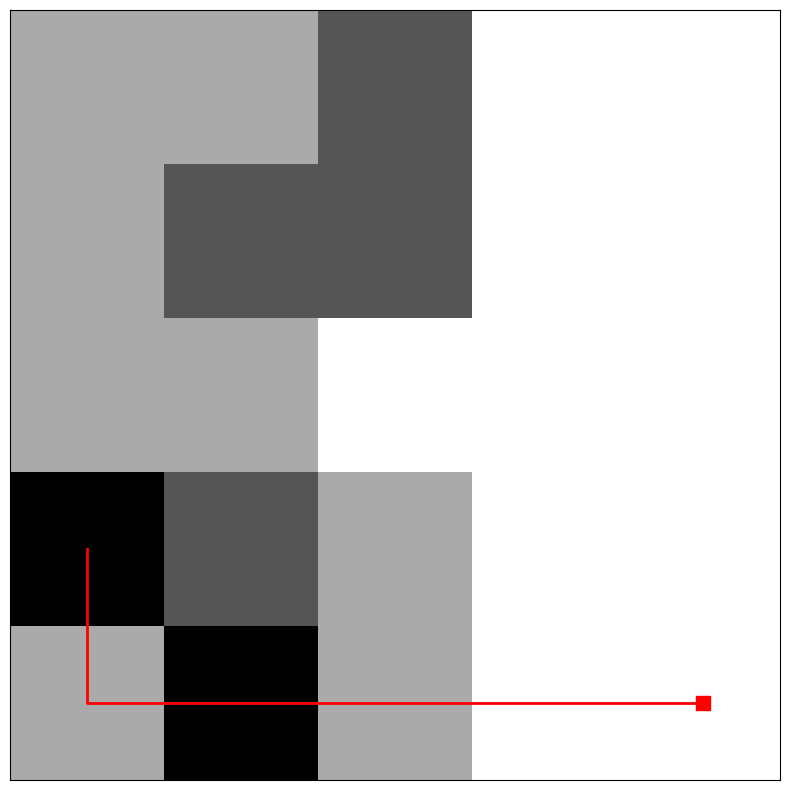

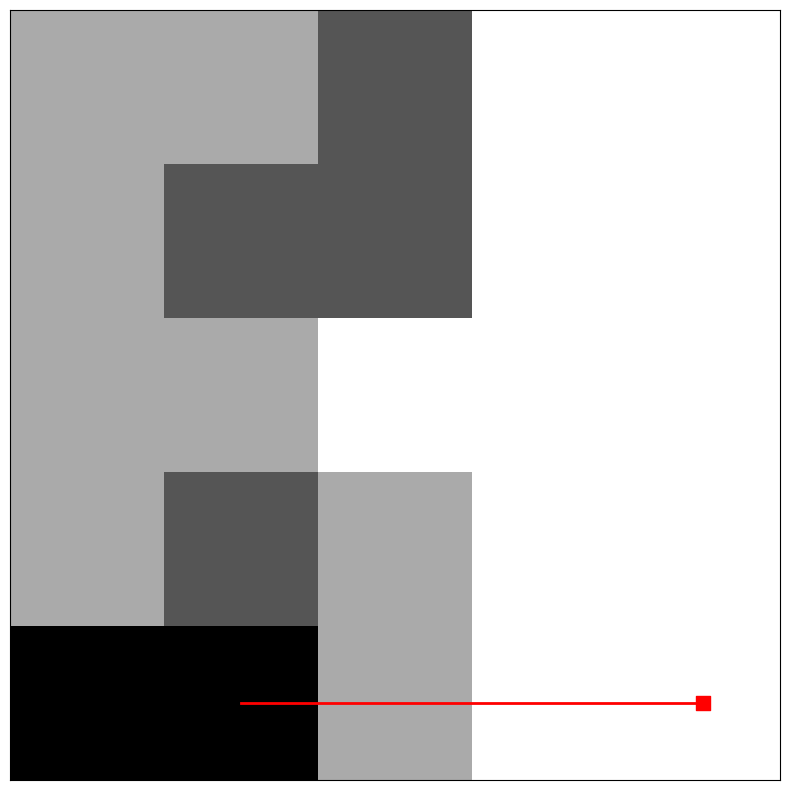

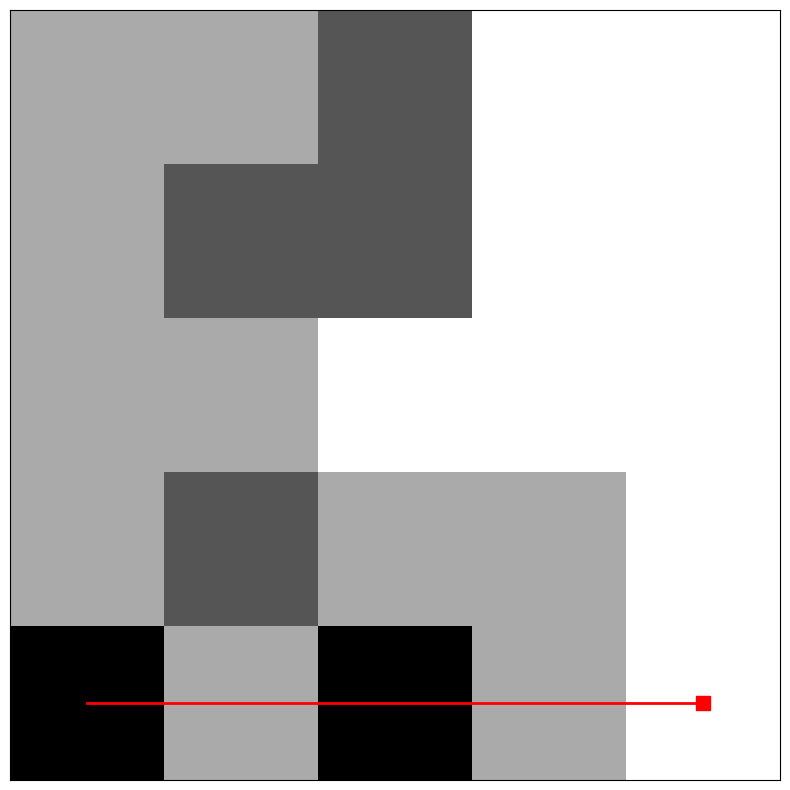

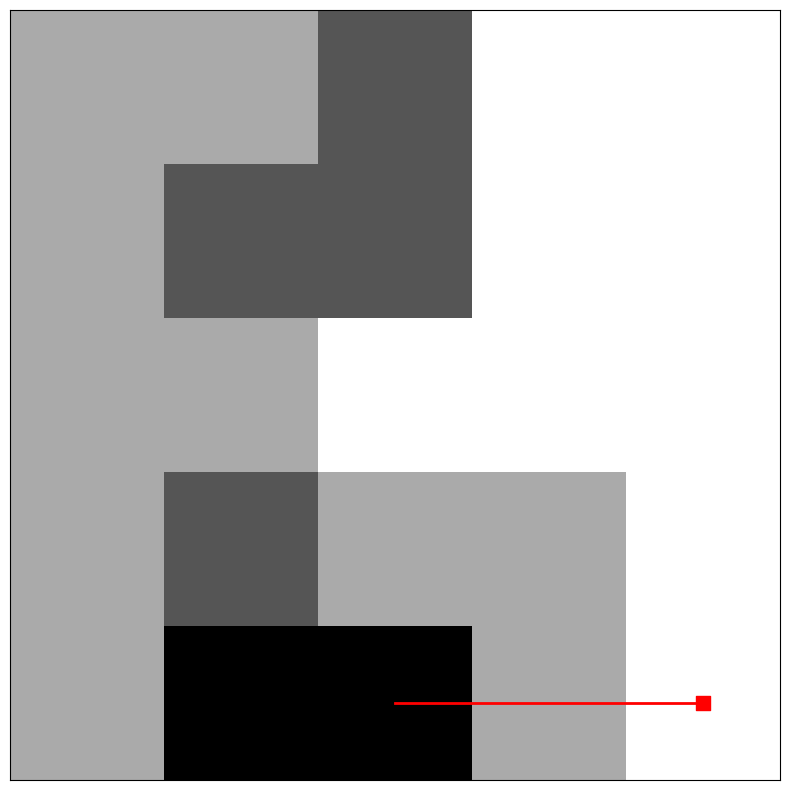

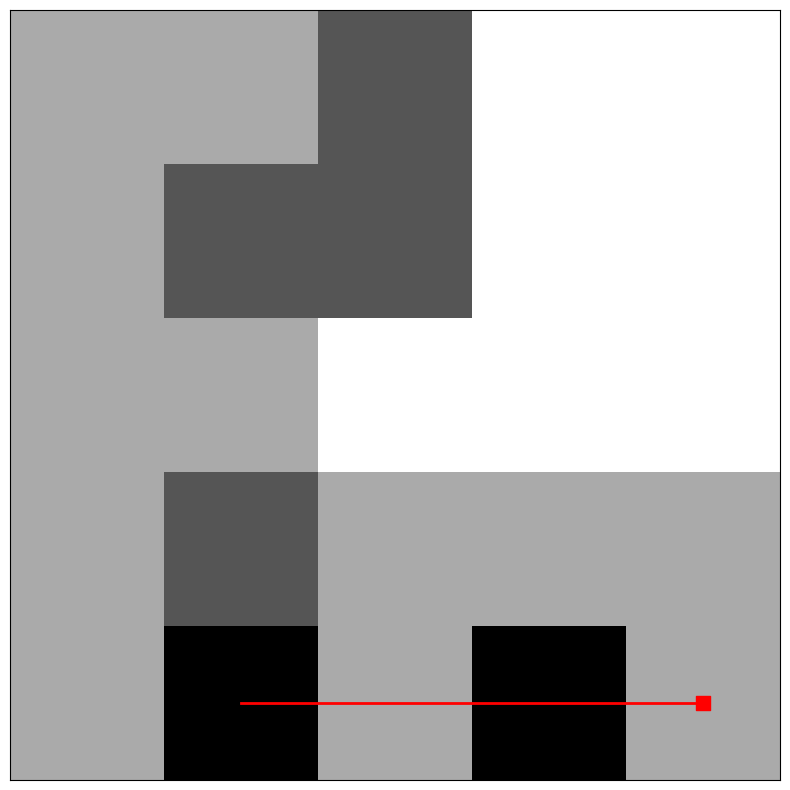

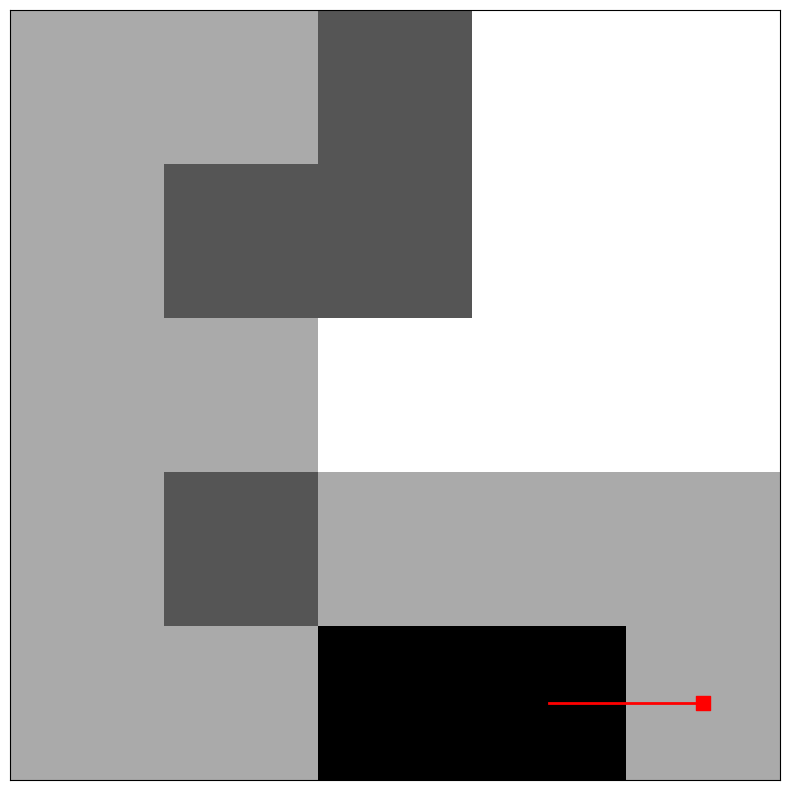

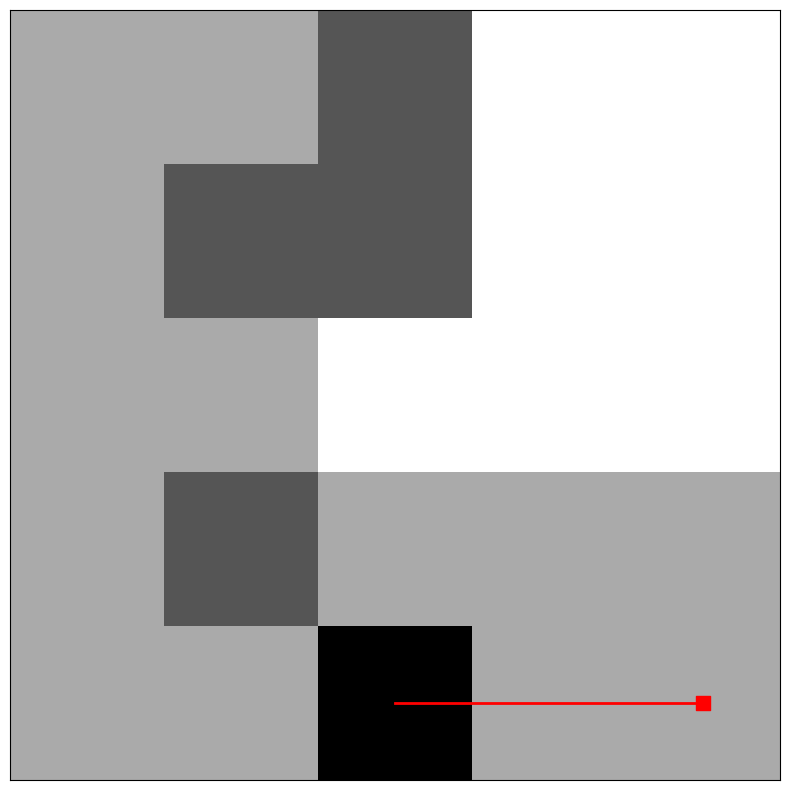

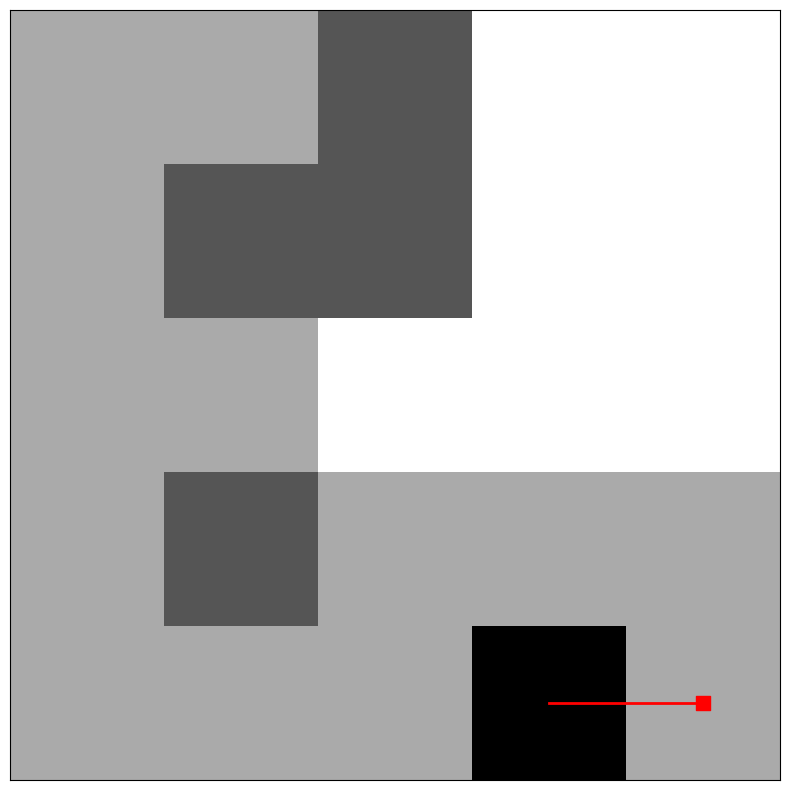

Total Coverage Percentage 0.72 / Agents Finished: 1.0 / Average Episode Time: 0.4196423768997192 / Average Agent Finish Time : 4.028382420539856
Final Explored Stage
[[ 0  0  1 -1 -1]
 [ 0  1  1 -1 -1]
 [ 0  0 -1 -1 -1]
 [ 0  1  0  0  0]
 [ 0  0  0  0  0]]


In [ ]:
grid = np.array([[0, 0, 1, 1, 0],
                 [0, 1, 1, 0, 1],
                 [0, 0, 1, 0, 1],
                 [0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0]])

print("MANY OBSTACLES STAGE")
agents = [Agent((0, 0), (4, 4), grid), Agent((0, 1), (4, 4), grid)]
res = move_astar(grid, agents)
print(f"Total Coverage Percentage {res[0]} / Agents Finished: {res[1]} / Average Episode Time: {res[3]} / Average Agent Finish Time : {res[4]}")
print(f"Final Explored Stage\n{res[2]}")

Function for maze creation. [Source](https://medium.com/@msgold/using-python-to-create-and-solve-mazes-672285723c96).

In [10]:
from queue import Queue

def create_maze(rows, cols, obs_prob=0.8):
    rows = int(rows / 2)
    cols = int(cols / 2)

    maze = np.ones((rows*2+1, cols*2+1))

    x, y = (0, 0)

    stack = [(x, y)]
    while len(stack) > 0:
        x, y = stack[-1]

        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if nx >= 0 and ny >= 0 and nx < rows and ny < cols and maze[2*nx+1, 2*ny+1] == 1:
                maze[2*nx+1, 2*ny+1] = 0
                maze[2*x+1+dx, 2*y+1+dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()

    # print(1, rows*2-1)
    # print(1, cols*2-1)

    zero_indices = np.argwhere(maze == 0)
    zero_coords = [tuple(index) for index in zero_indices]

    # print(zero_coords)
    # draw_maze(maze)

    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)] # adds randomly crosses of free space.
    for z in zero_coords:
       if random.random() >= obs_prob:
          for dx, dy in directions:
            nx, ny = z[0] + dx, z[1] + dy
            maze[nx, ny] = 0

    # print(maze)

    return maze

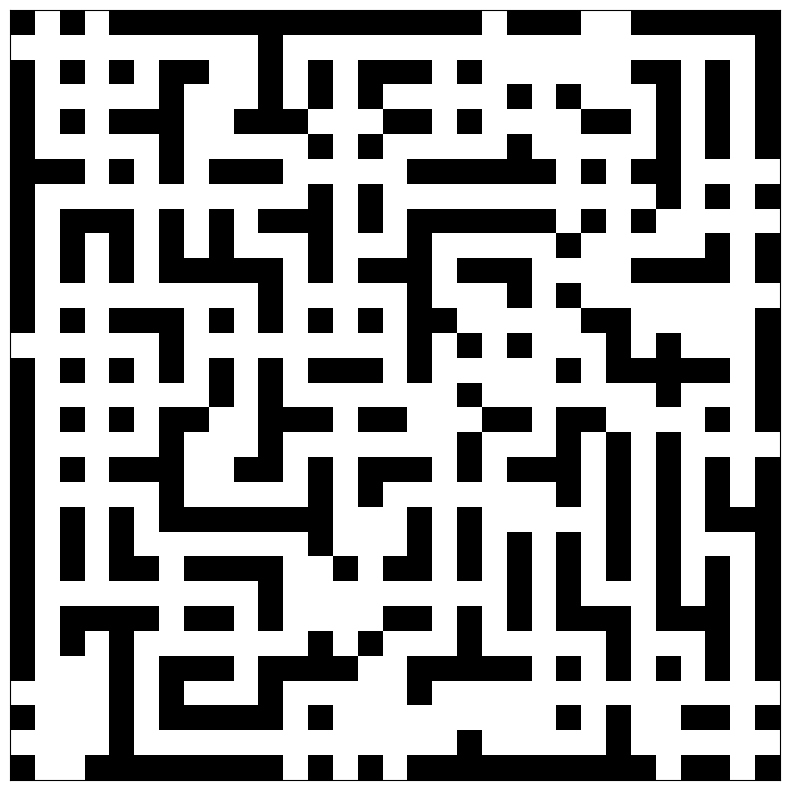

In [ ]:
draw_maze(create_maze(30, 30, obs_prob=0.85))

Function to test astar with many experiments (print averages).

In [11]:
def test_astar(num_agents, num_test, start_grid = None, gen_stage_func = None, agent_view_range = 1, debug=False):
  """
  Function to test astar with many experiments (returns averages).
  If you want to give the initial grid, initialize the variable start_grid with your grid
  (and put the gen_stage_func parameter = None).
  If you want to create a different stage for each experiment, put start_grid = None
  and initialize the next parameter (gen_stage_func) like so:
  functools.partial(func_for_grid_gen, rows, cols, obs_prob)
  where func_for_grid_gen is a function for grid generation, rows and cols are the number
  of rows and columns of the grid and obs_prob the probablity of obstacles.
  """
  avg = []
  avg_finish = []
  avg_exp_time = []
  avg_agent_time = []
  avg_eps_time= []

  for _ in range(num_test):
    start_time = time.time()
    if start_grid is None:
      grid = gen_stage_func()
      # print(grid)
    else:
      grid = copy.deepcopy(start_grid)
    agents = generate_agents(real_stage = grid, num_agents = num_agents, view_range = agent_view_range)
    res = move_astar(start_grid=grid, start_agents=agents, debug=debug)
    avg.append(res[0])
    avg_finish.append(res[1])
    # print(avg_finish)
    avg_exp_time.append(time.time() - start_time)
    avg_eps_time.append(res[3])
    avg_agent_time.append(res[4])

  avg_agent_time = [x if not np.isnan(x) else max(avg_agent_time) for x in avg_agent_time]  # replaces nans with max value.
  # Checks again for nans, and replaces them with 1.
  if np.all(np.isnan(avg_agent_time)):
    avg_agent_time = np.where(np.isnan(avg_agent_time), 1, avg_agent_time)

  avg_cover, avg_finish, avg_expt_time, avg_eps_time, avg_agent_time = np.mean(avg), np.mean(avg_finish), np.mean(avg_exp_time), np.mean(avg_eps_time), np.mean(avg_agent_time)
  # if debug:
  print(f"Average Coverage Percentage: {avg_cover} / Average Finished: {avg_finish} / Average Experiment Time: {avg_expt_time}s / Average Episode Time: {avg_eps_time} / Average Agent Finish Time : {avg_agent_time}")
  return avg_cover, avg_finish, avg_expt_time, avg_eps_time, avg_agent_time

Testing with dynamically generated stages:

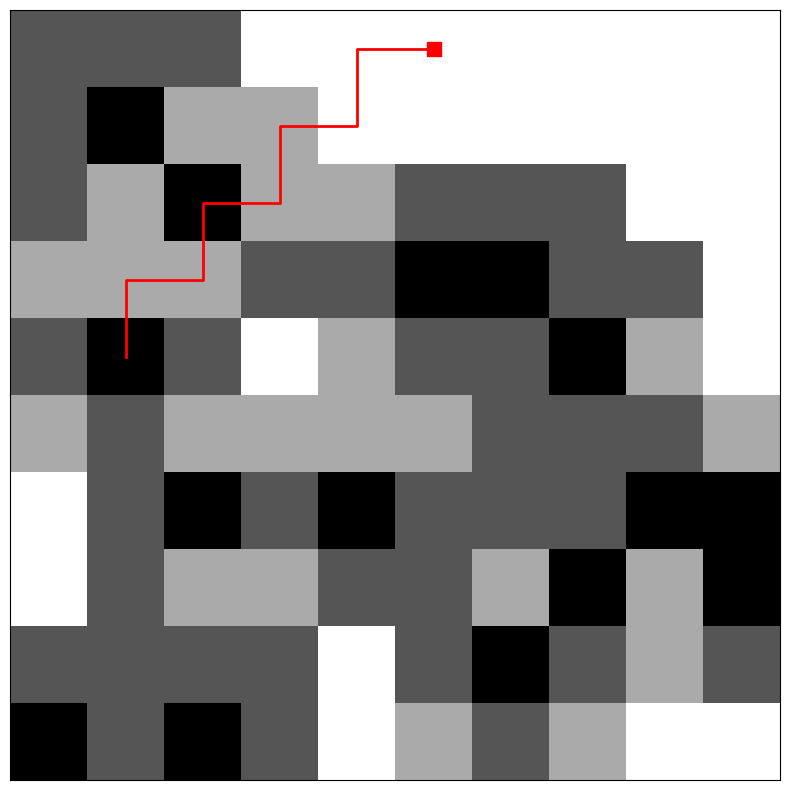

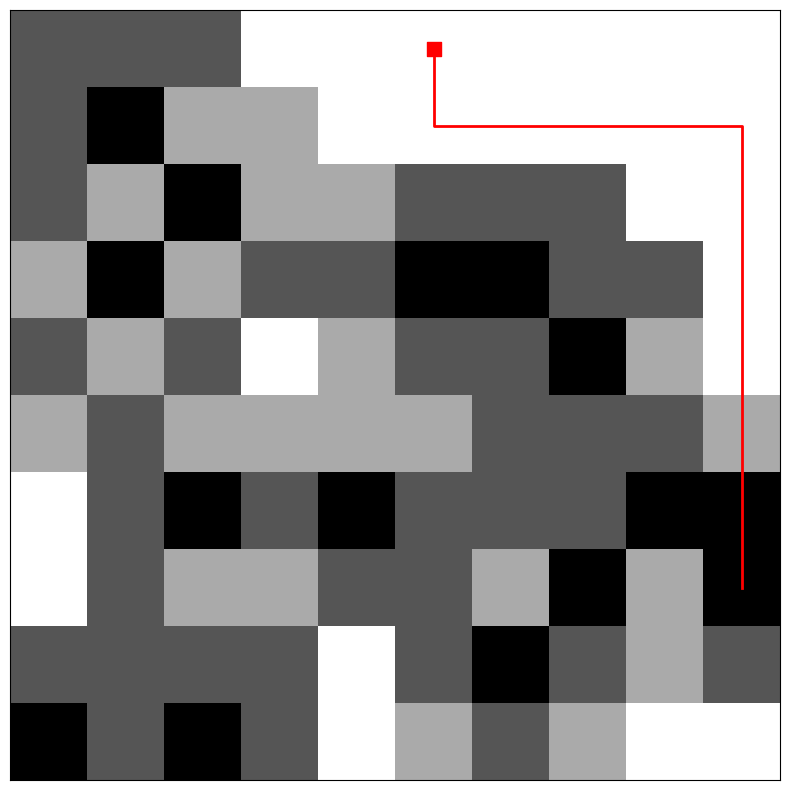

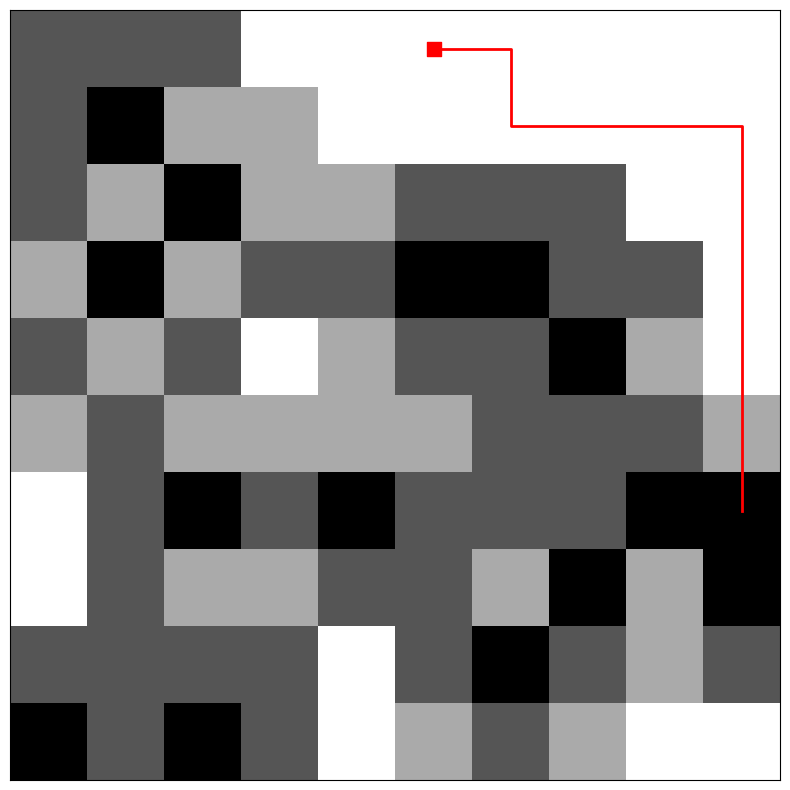

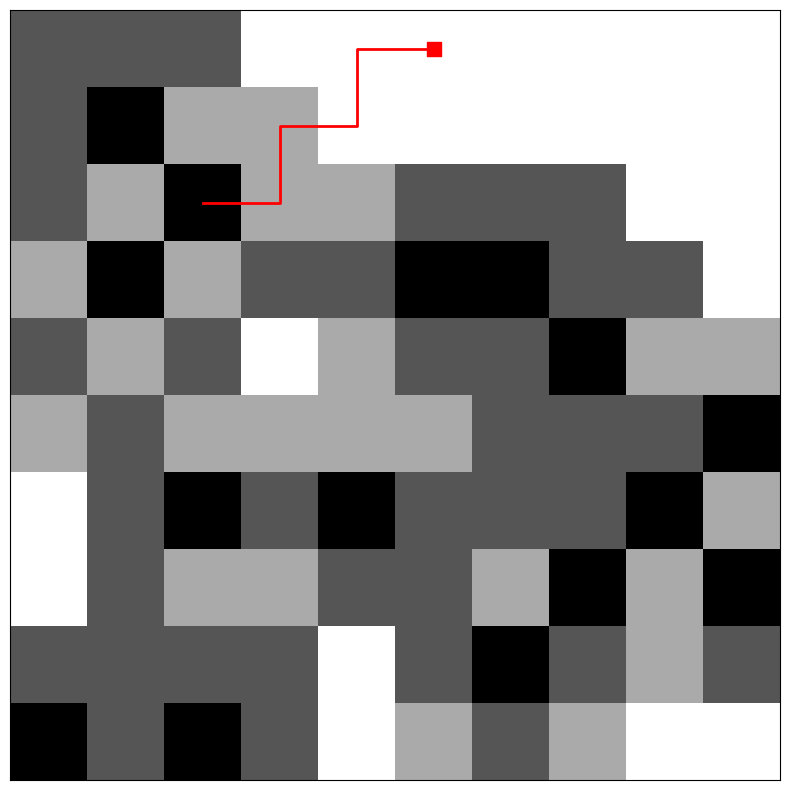

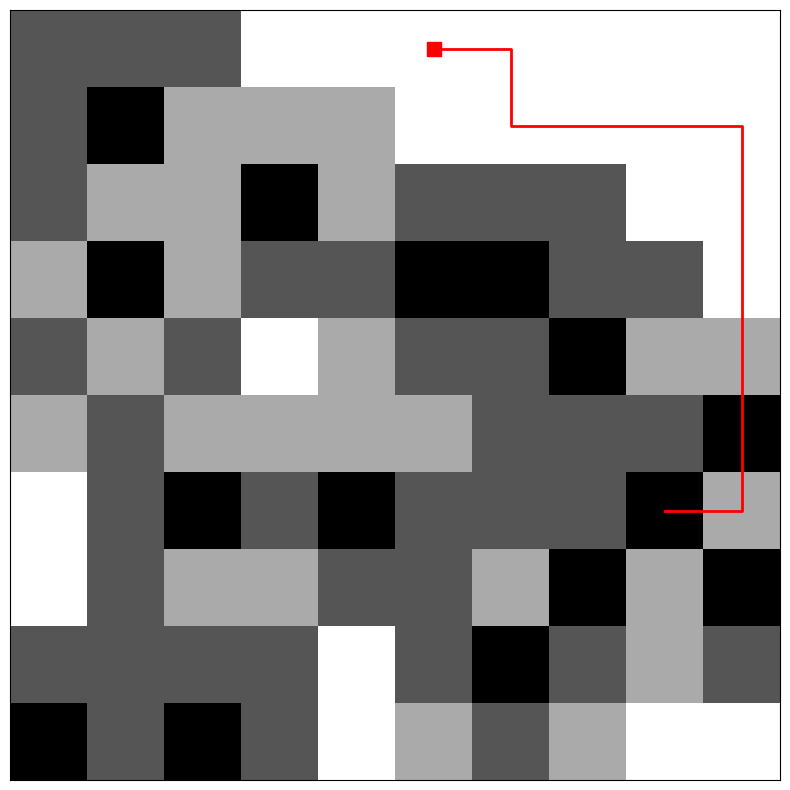

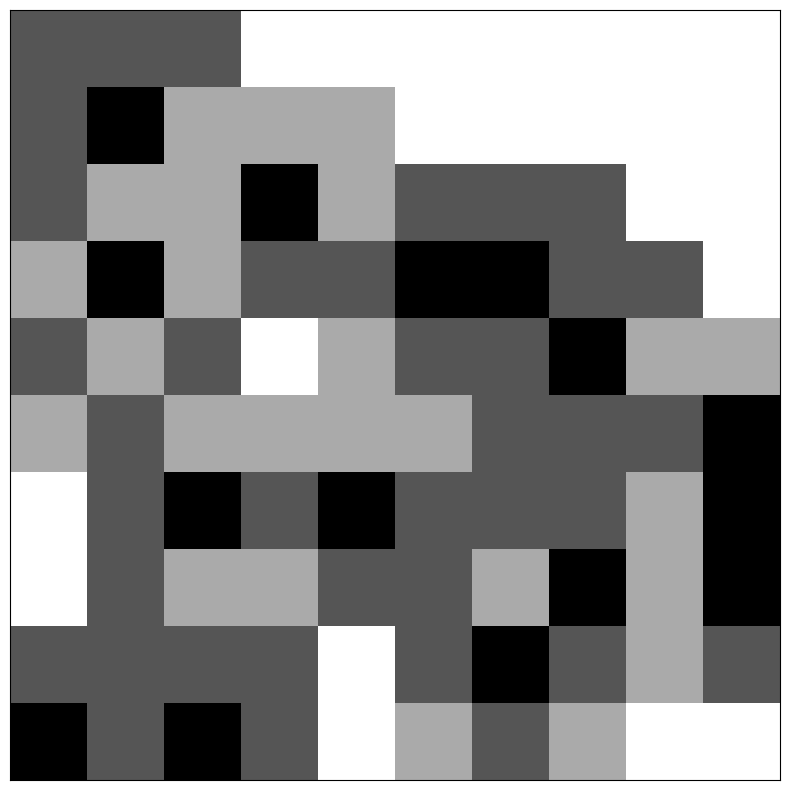

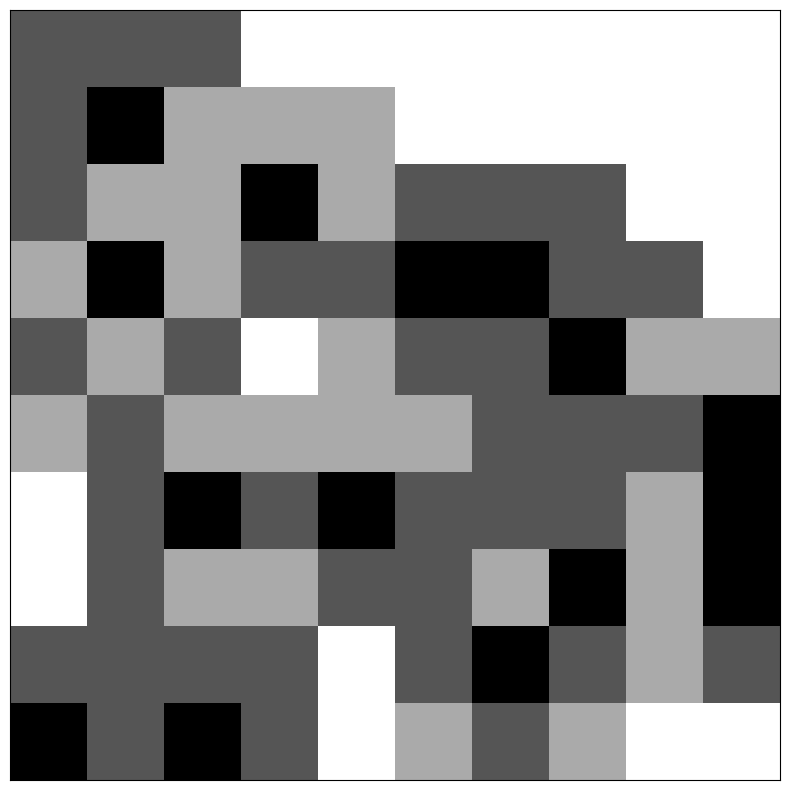

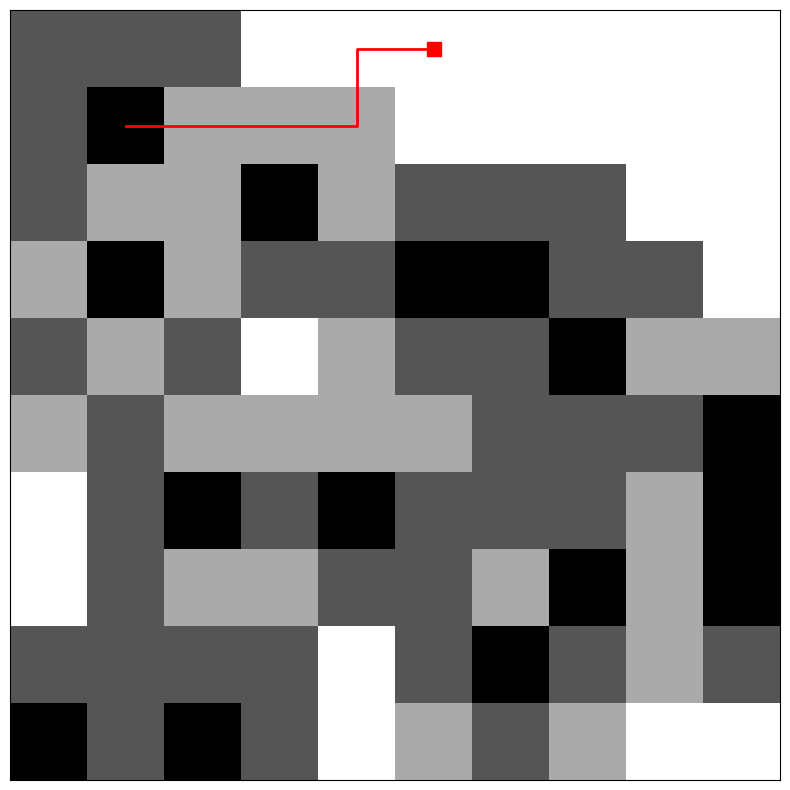

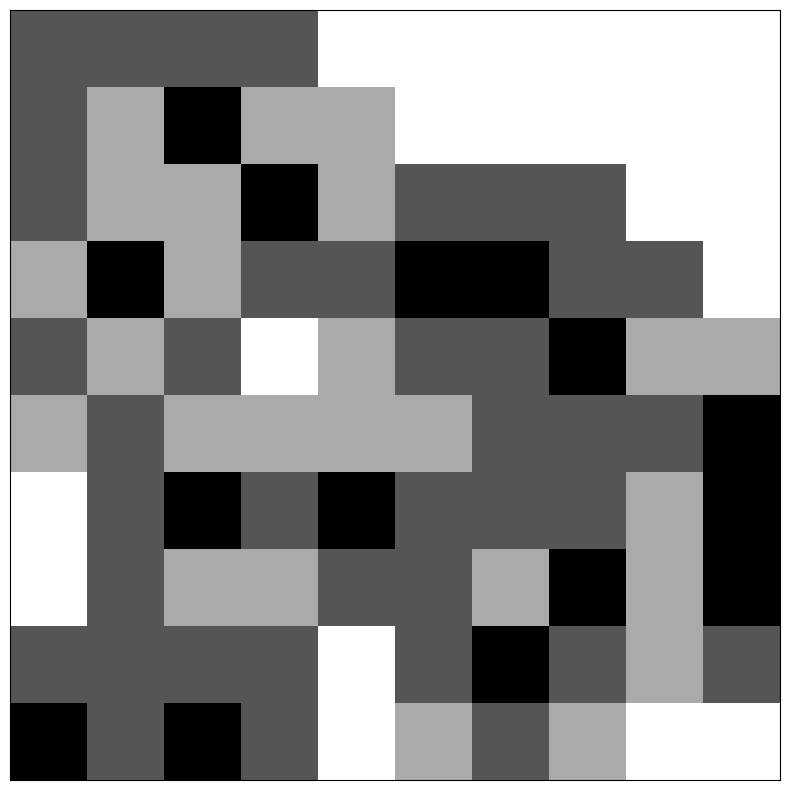

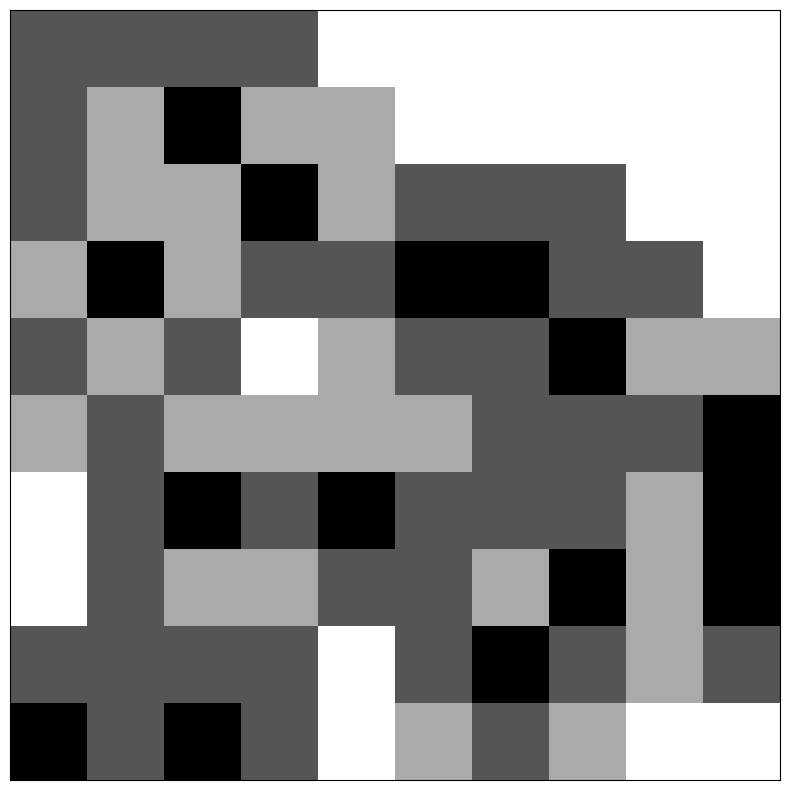

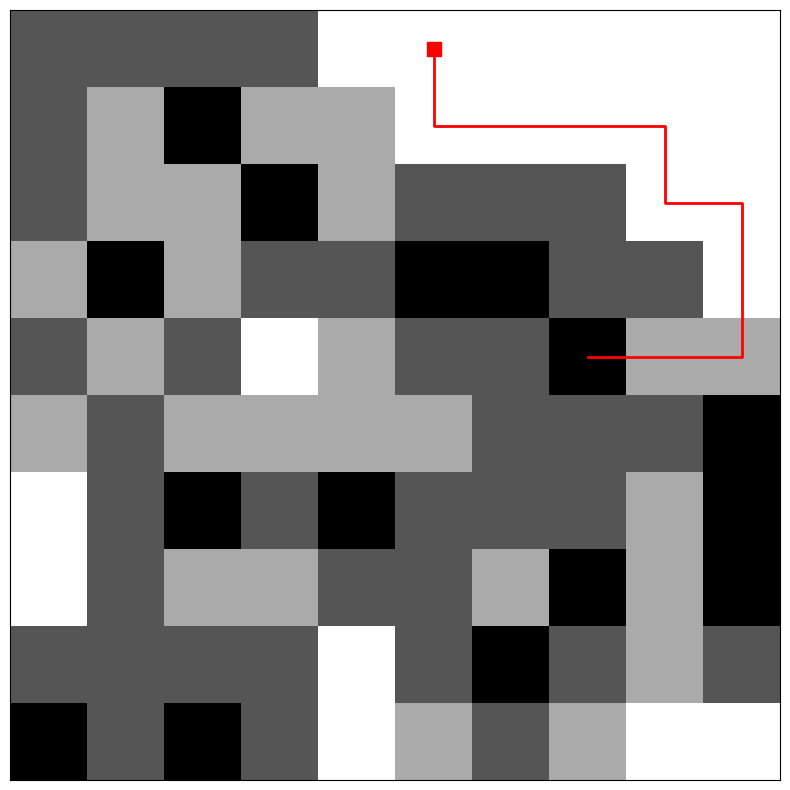

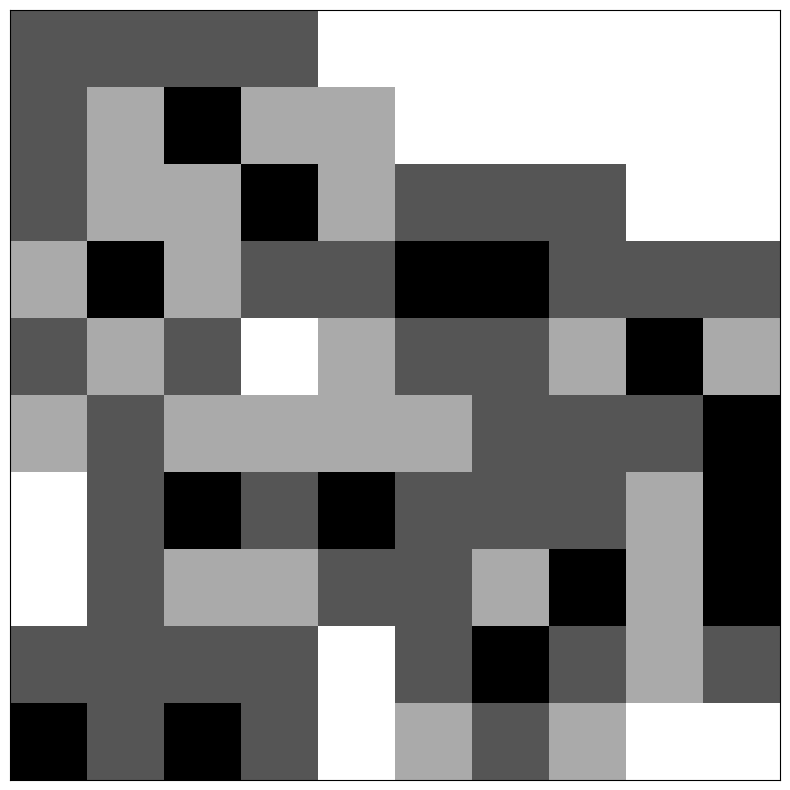

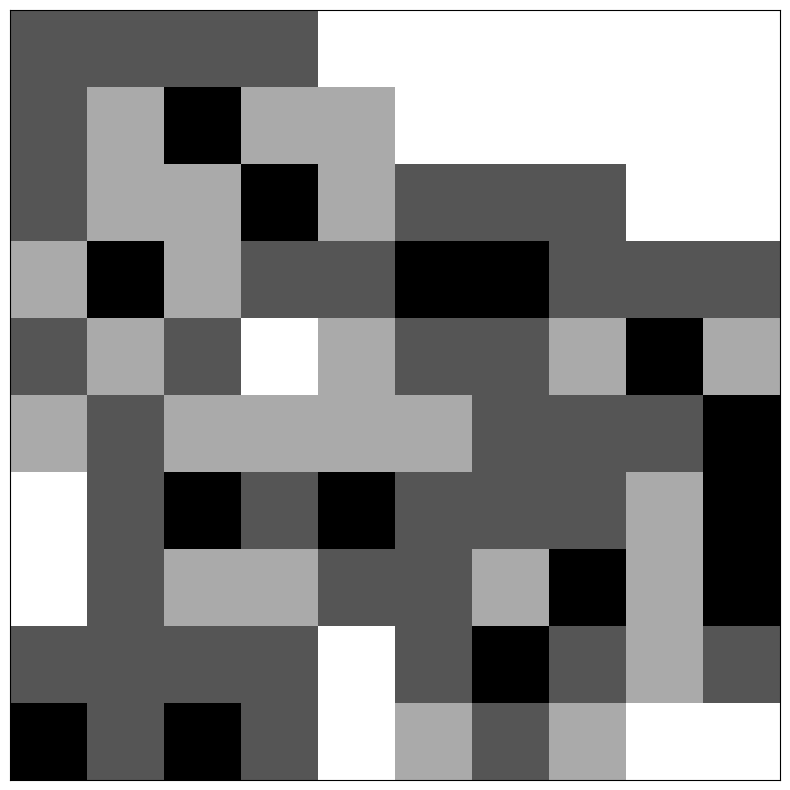

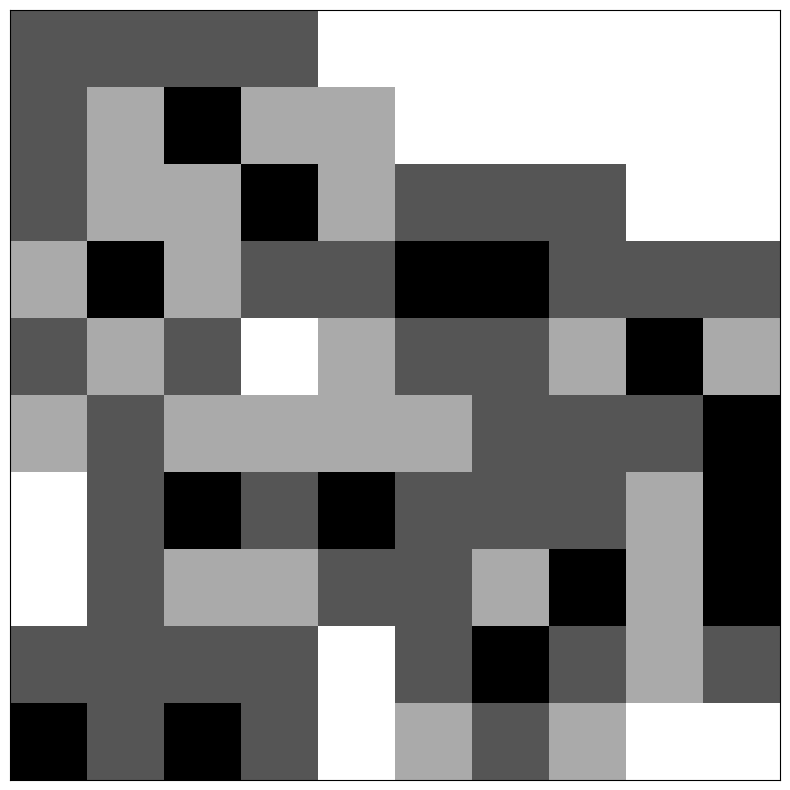

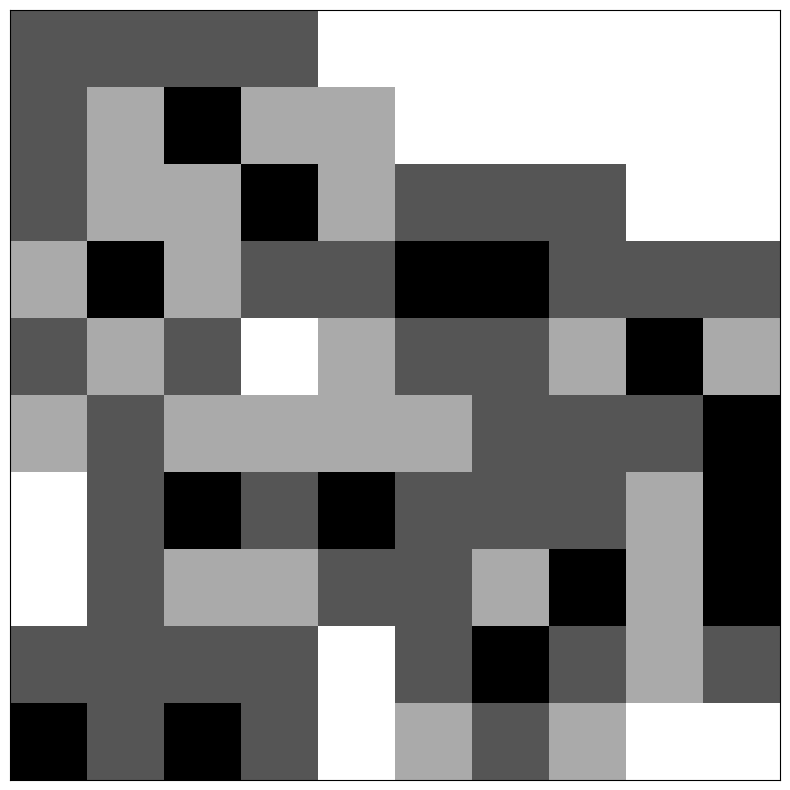

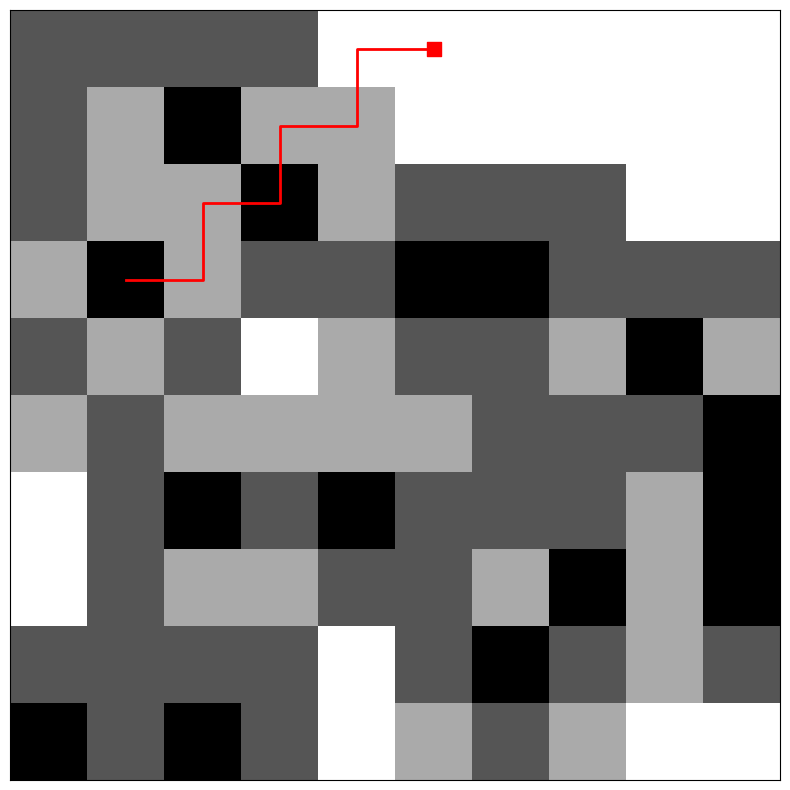

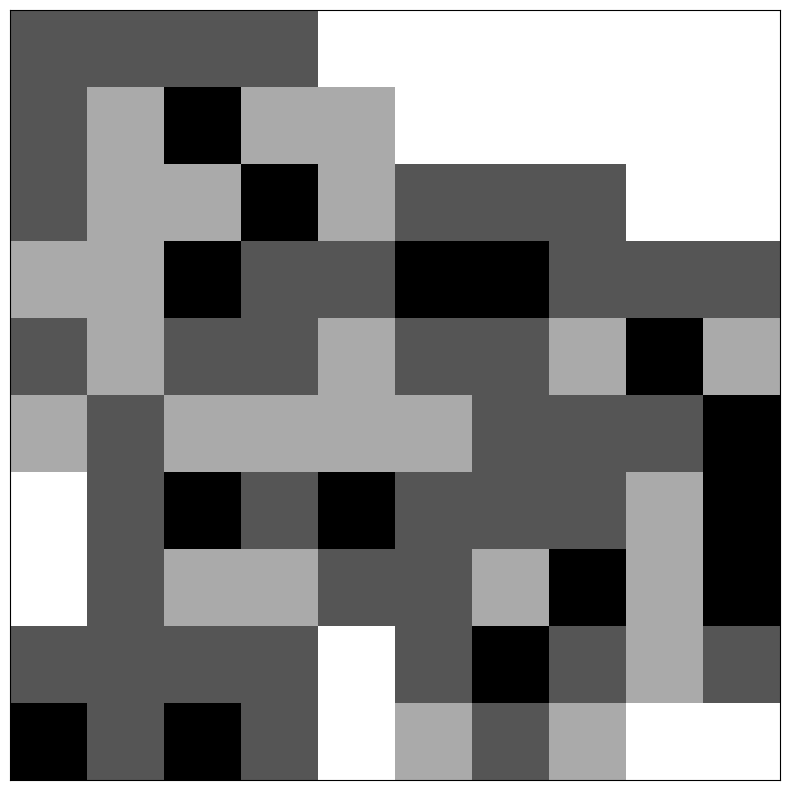

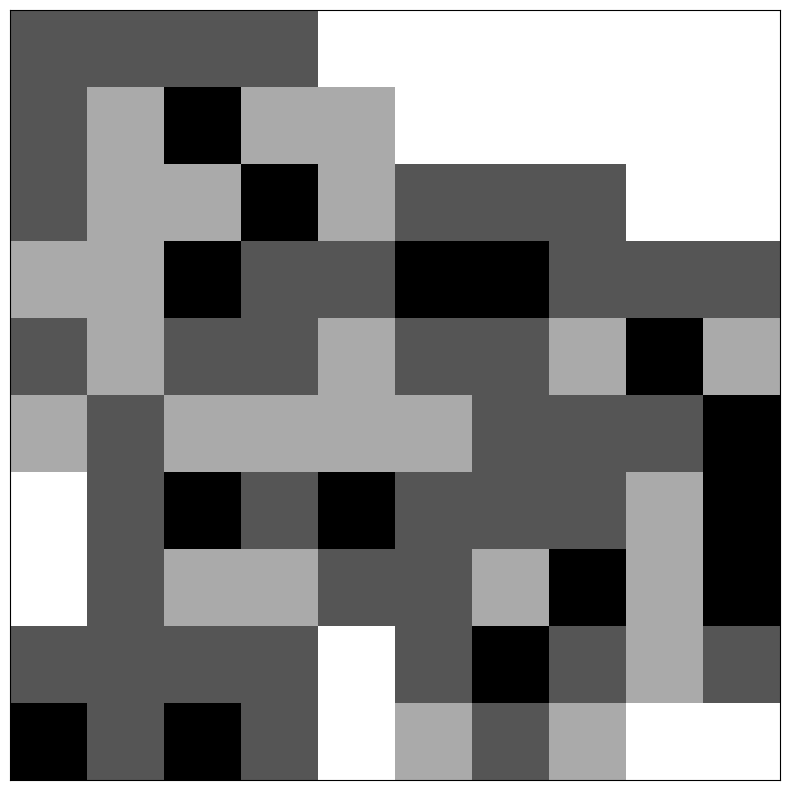

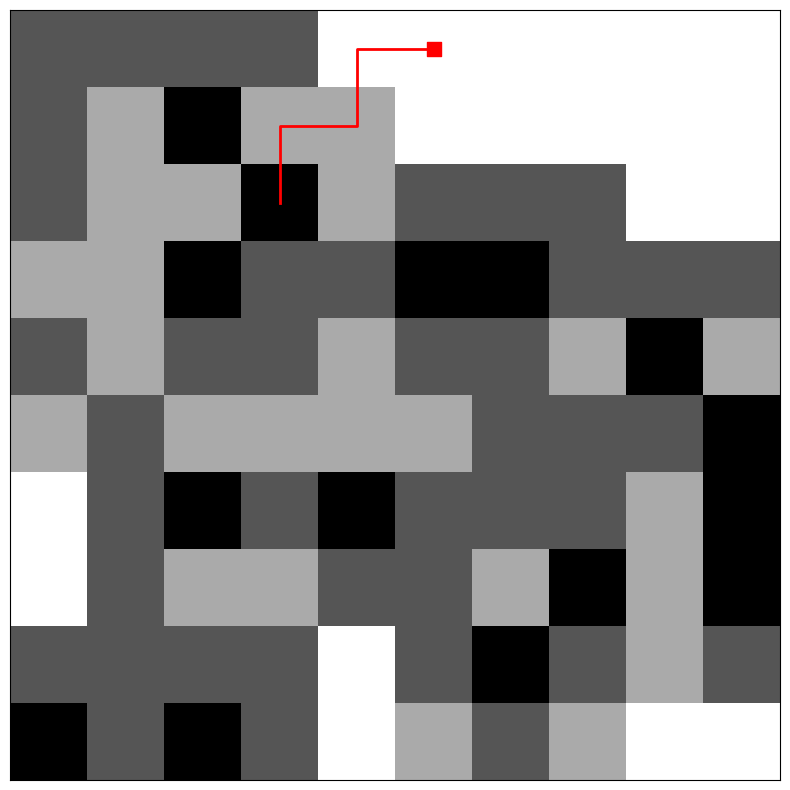

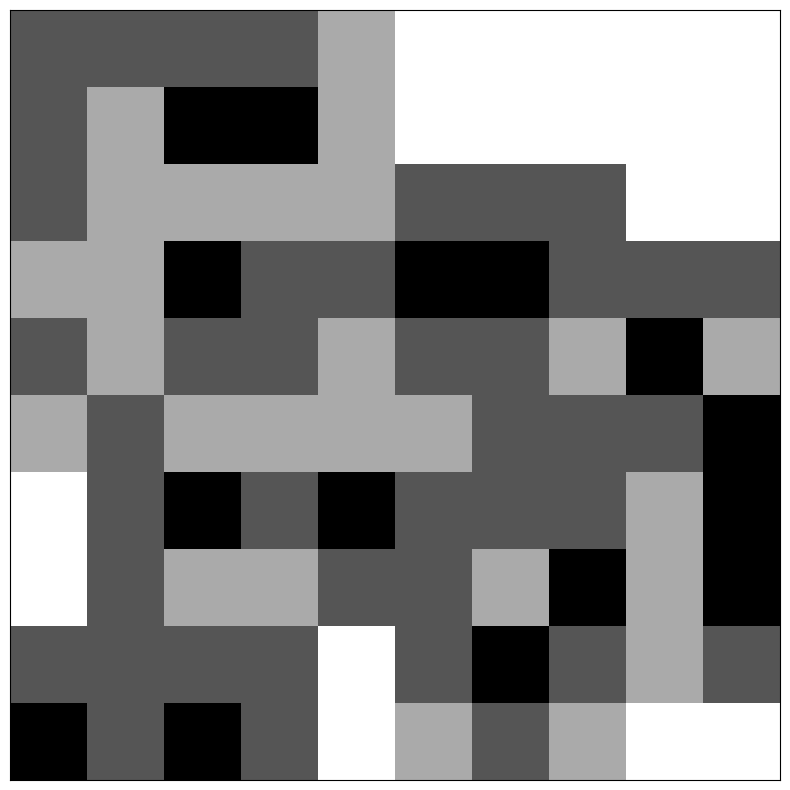

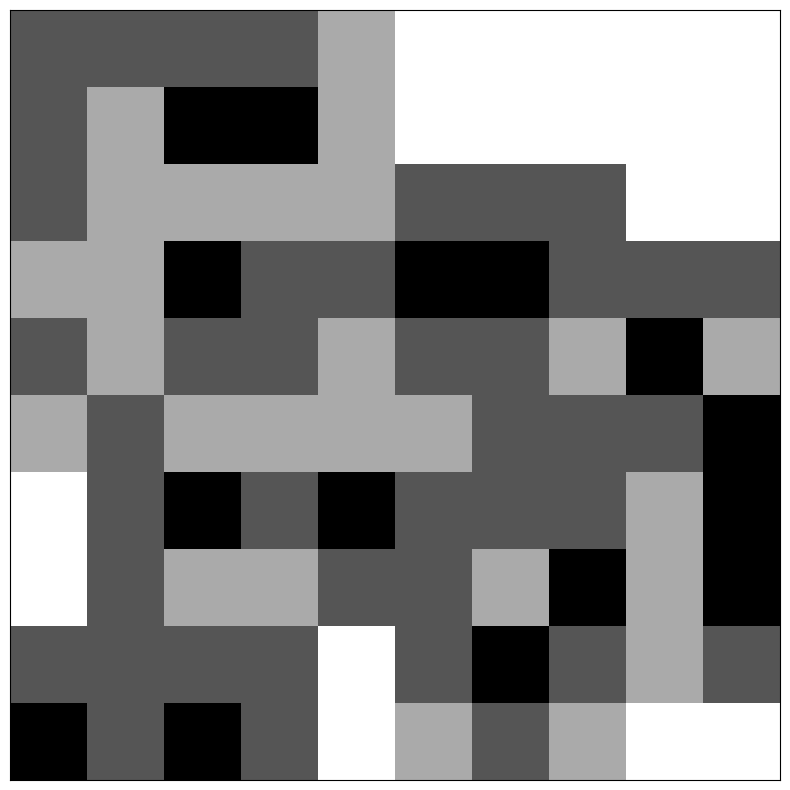

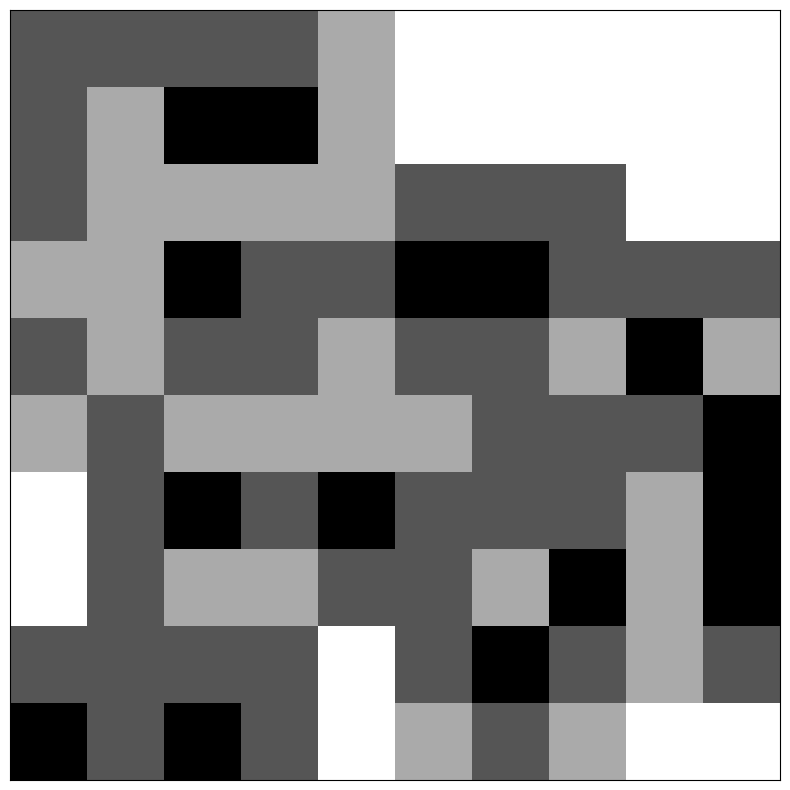

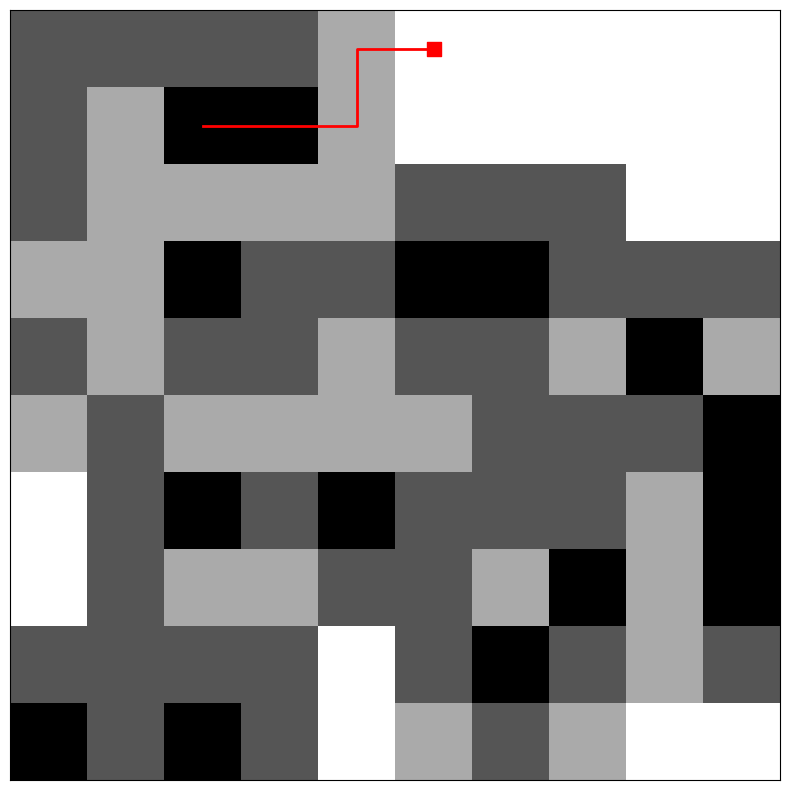

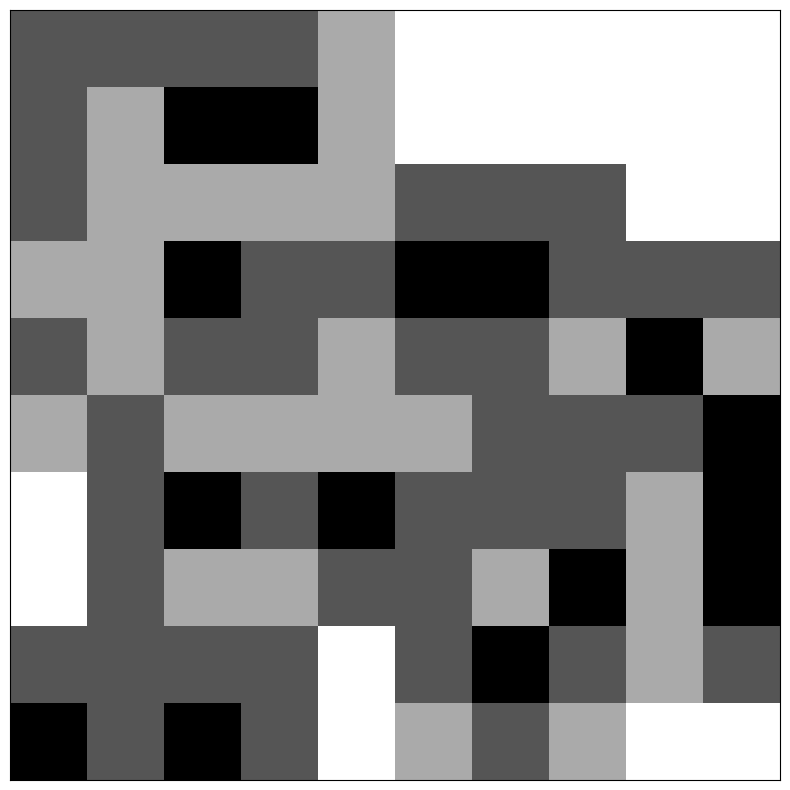

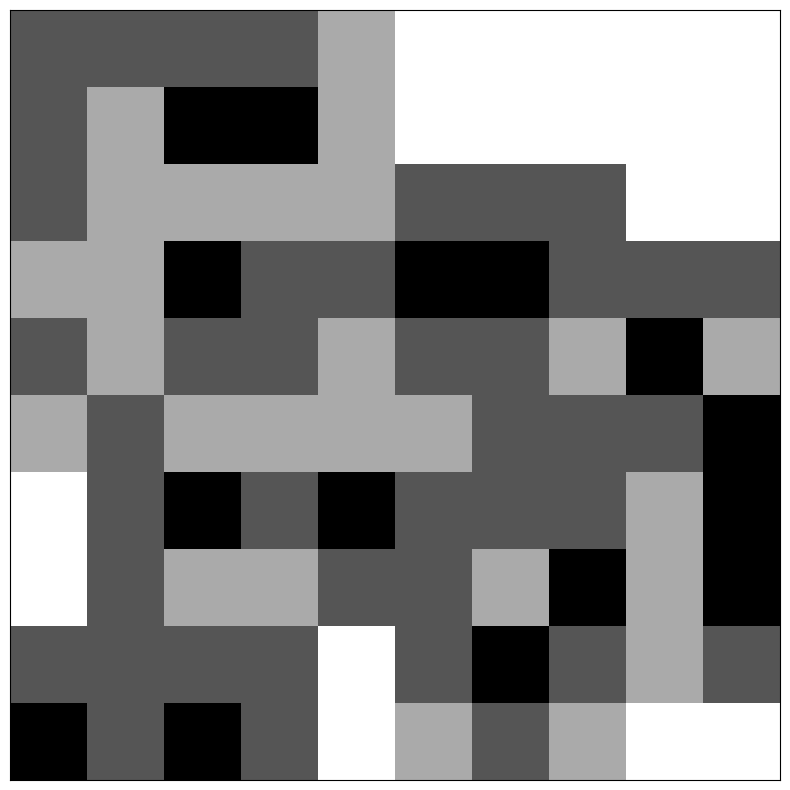

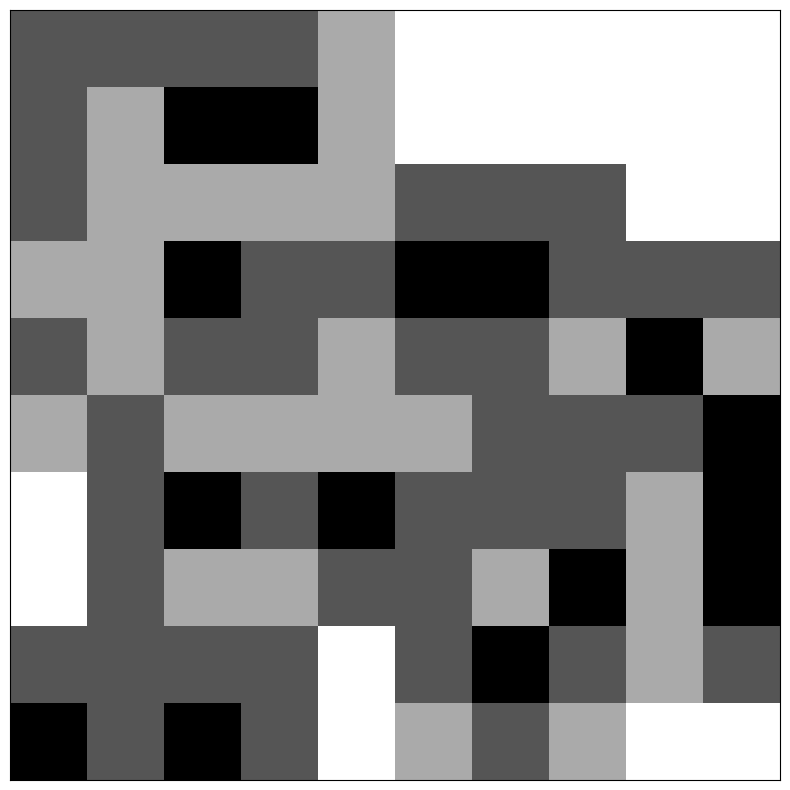

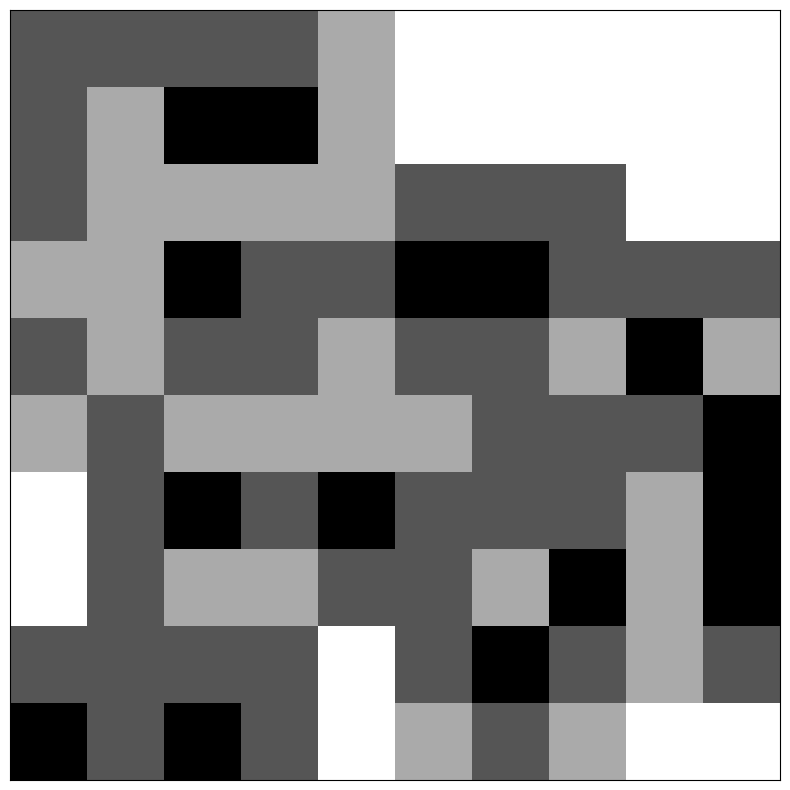

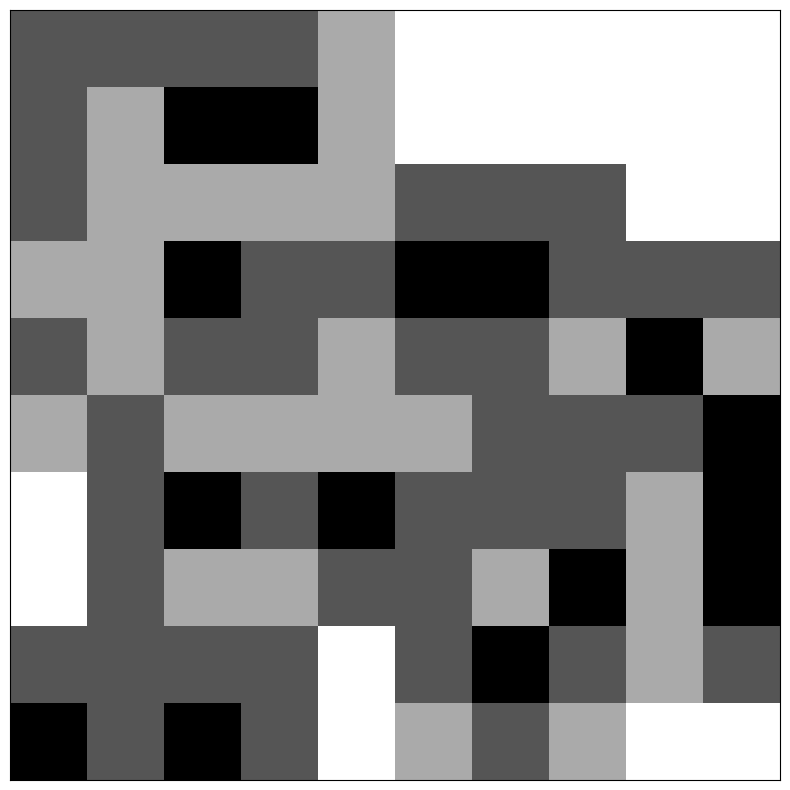

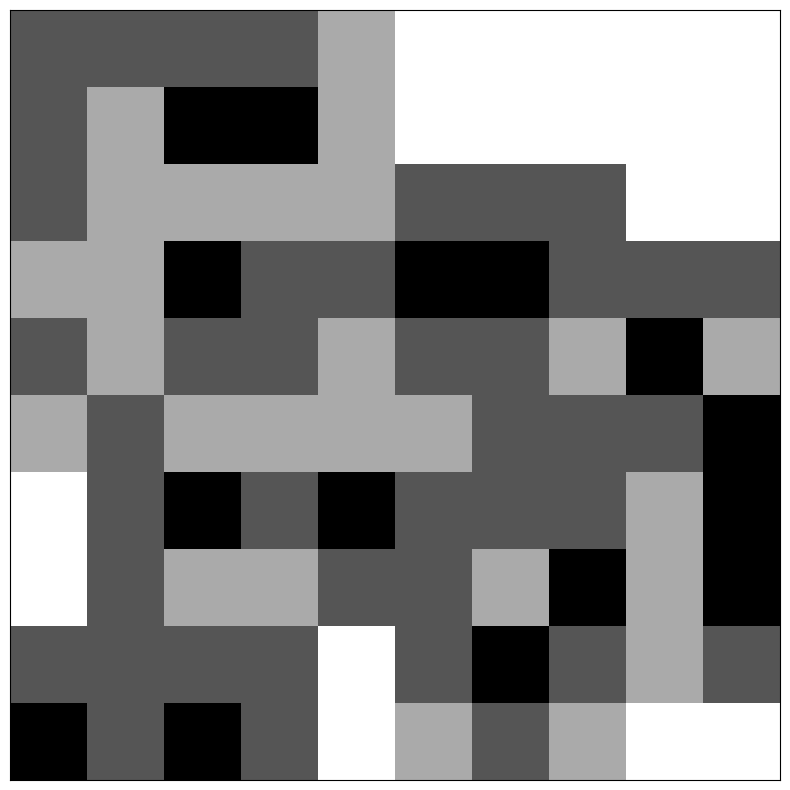

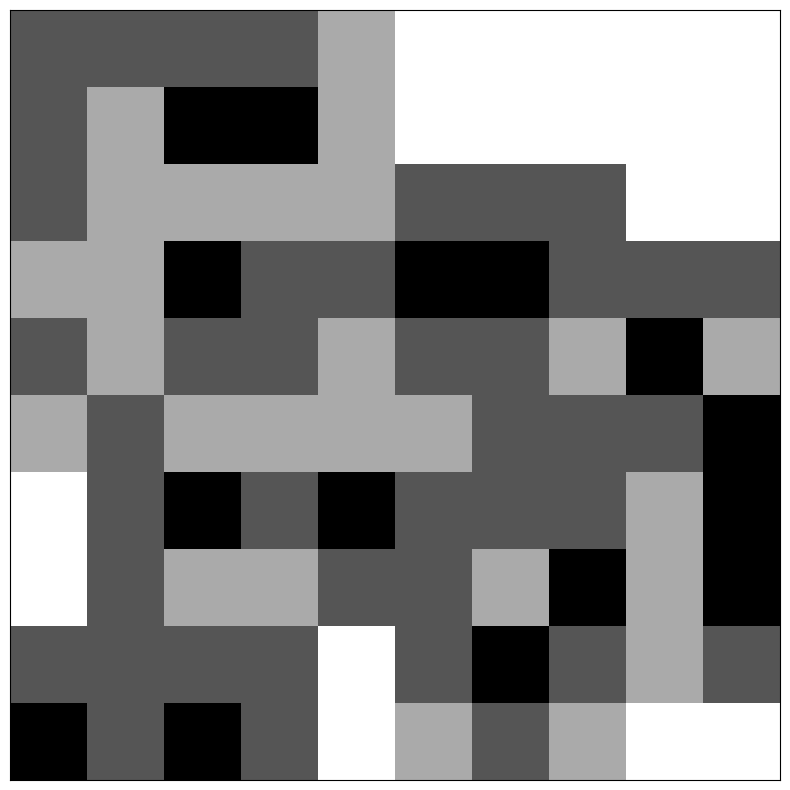

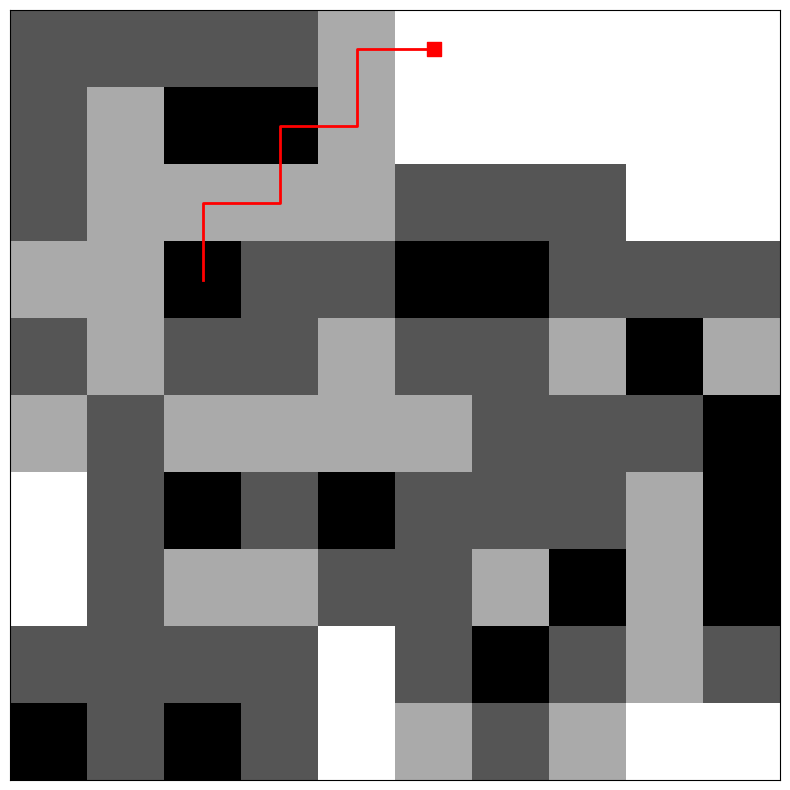

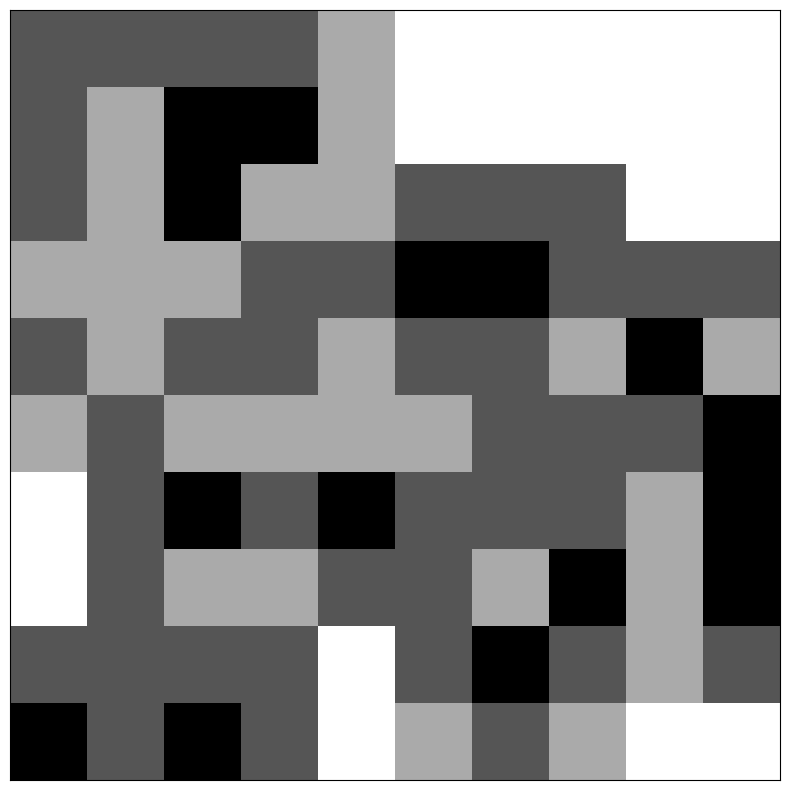

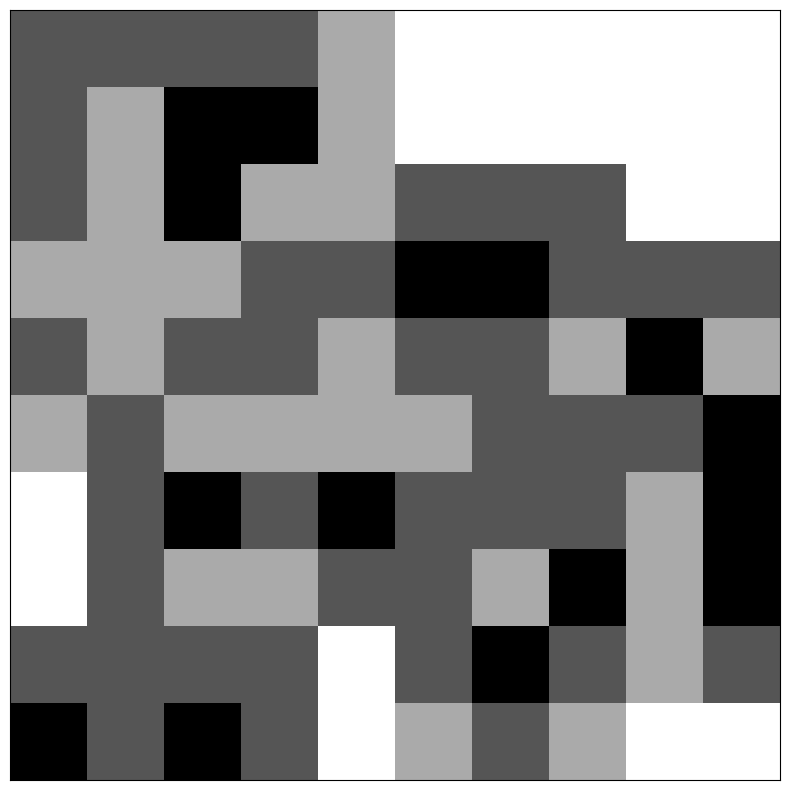

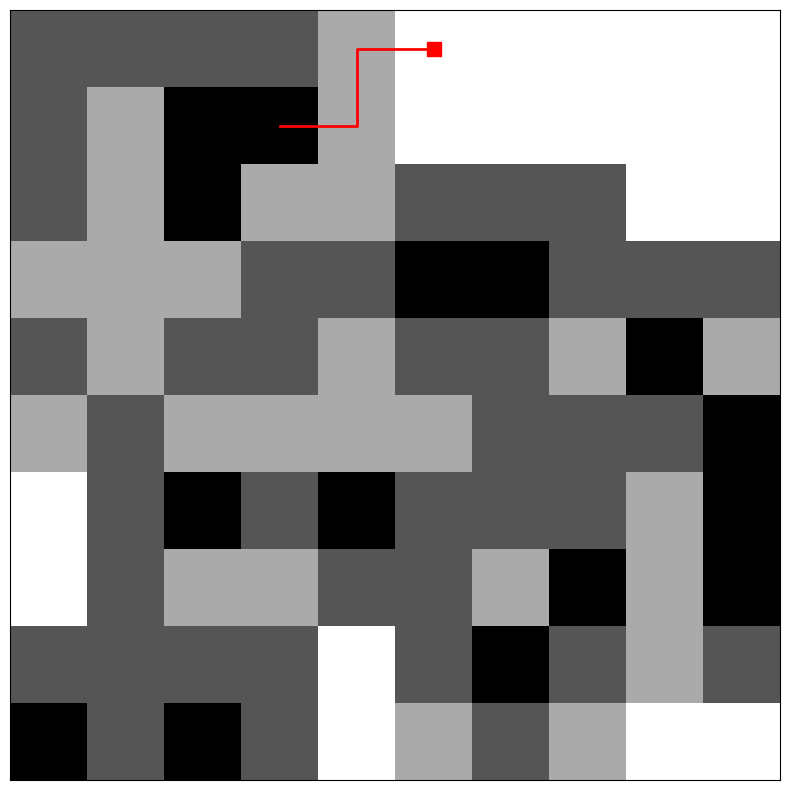

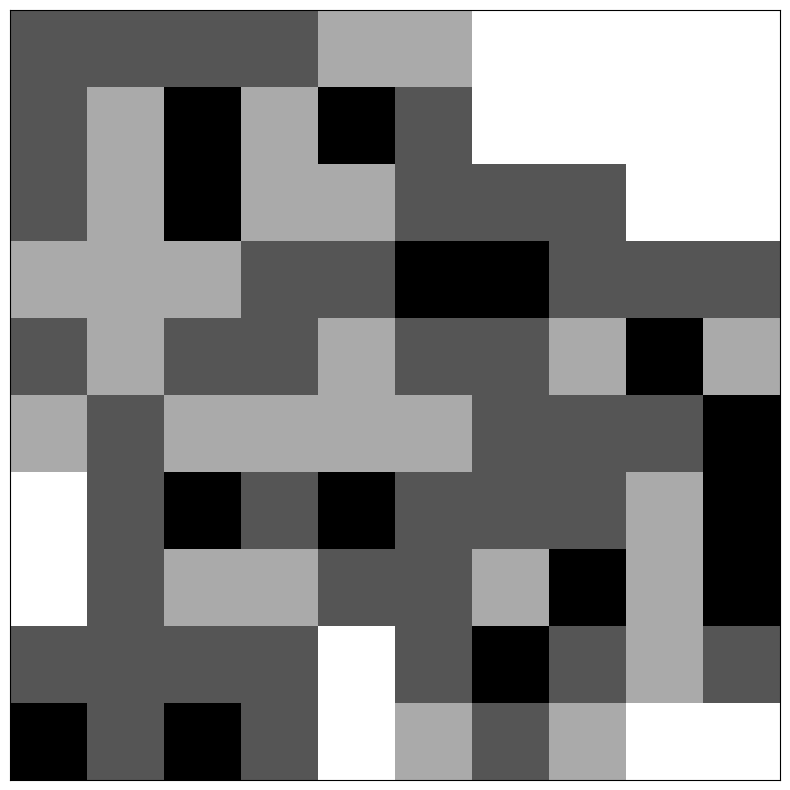

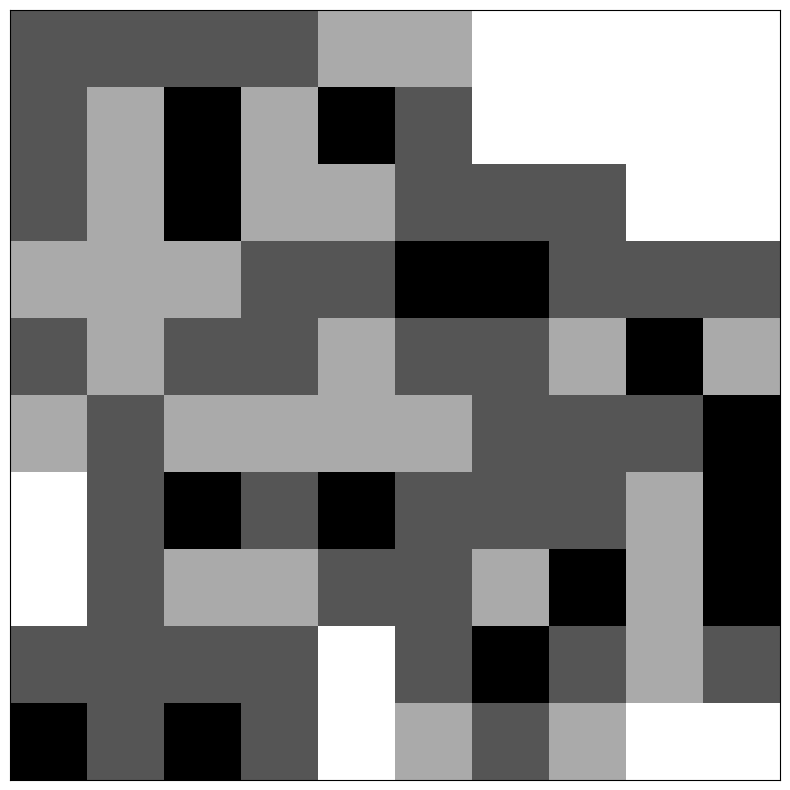

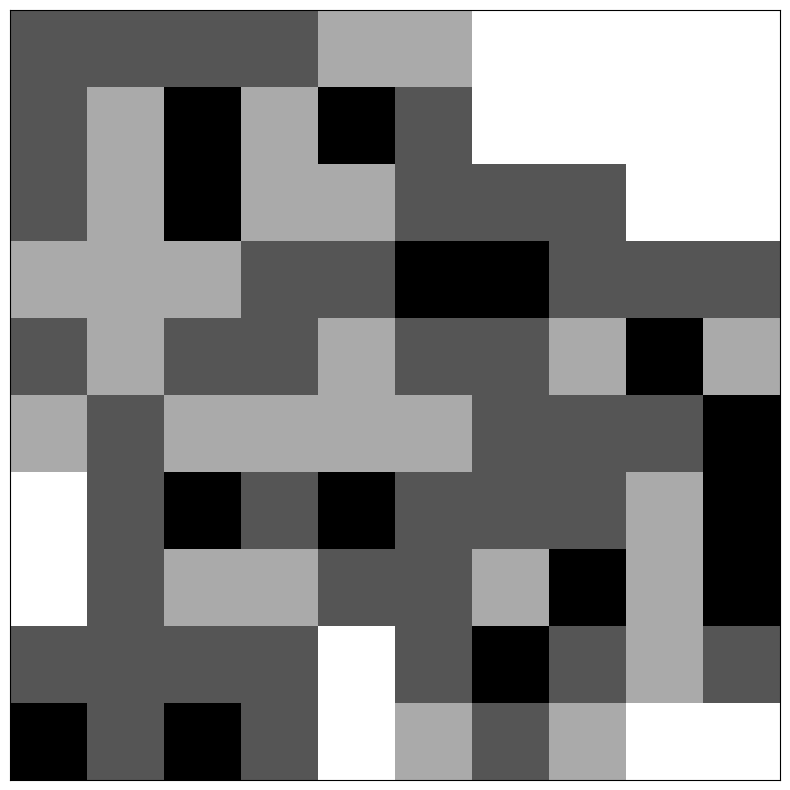

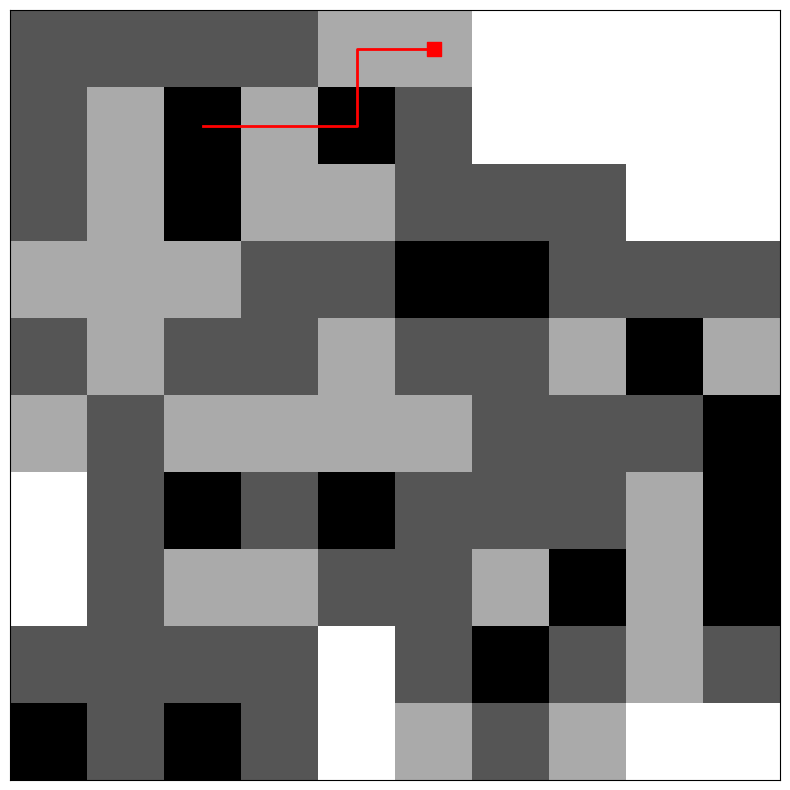

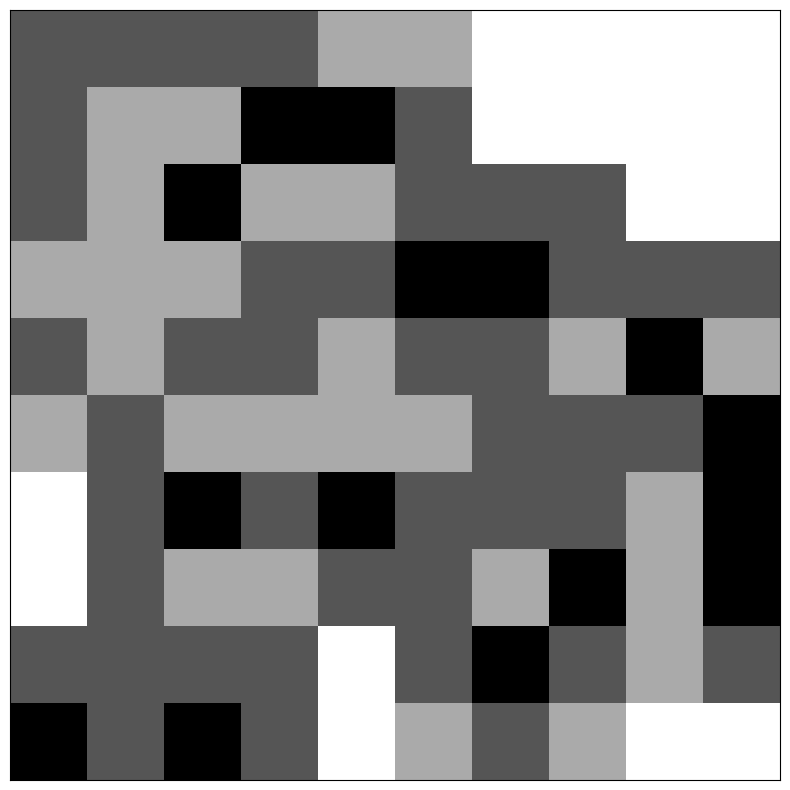

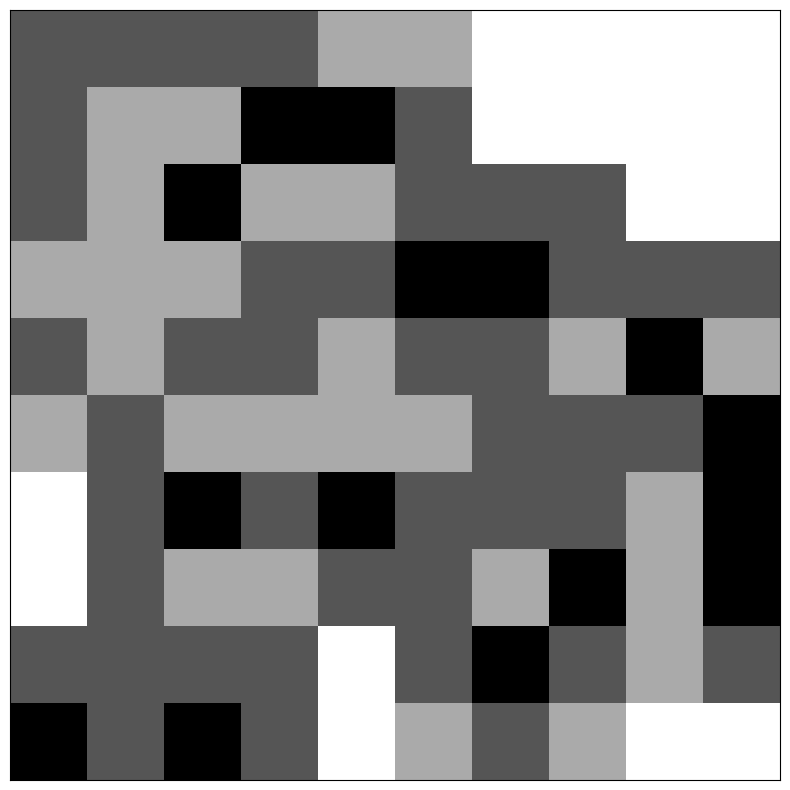

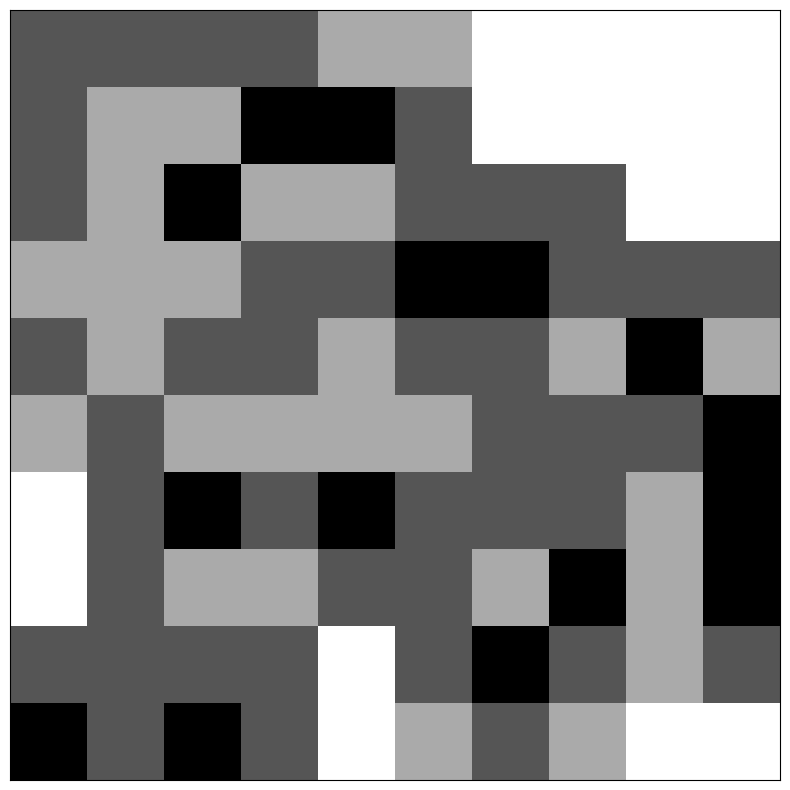

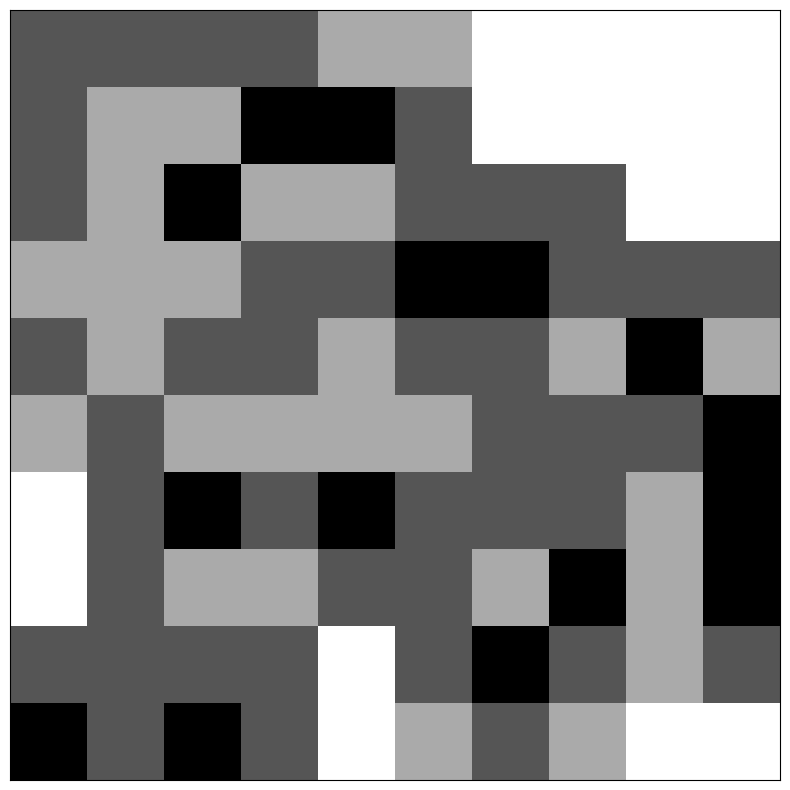

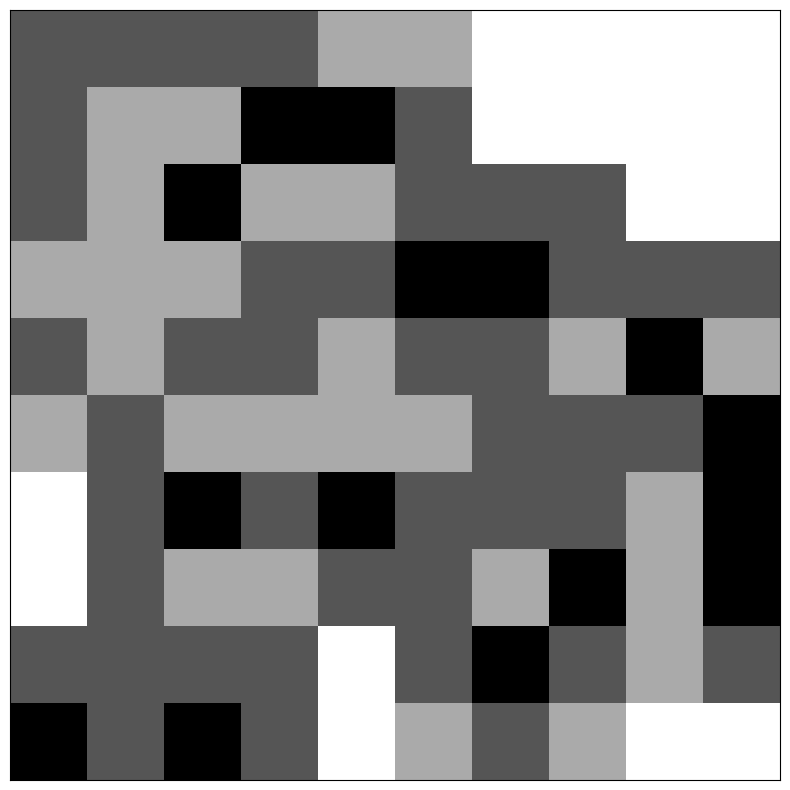

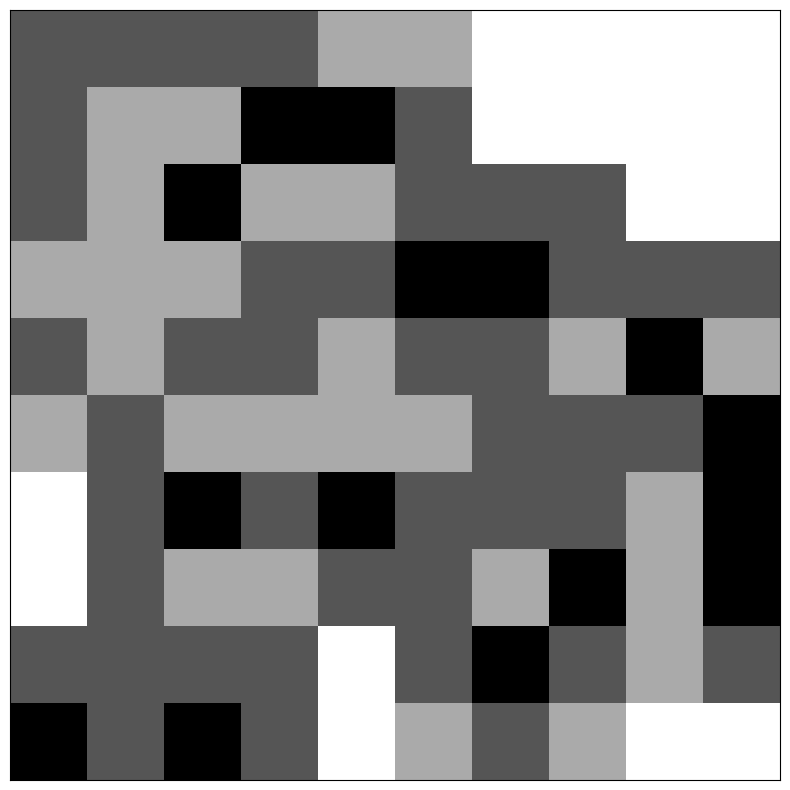

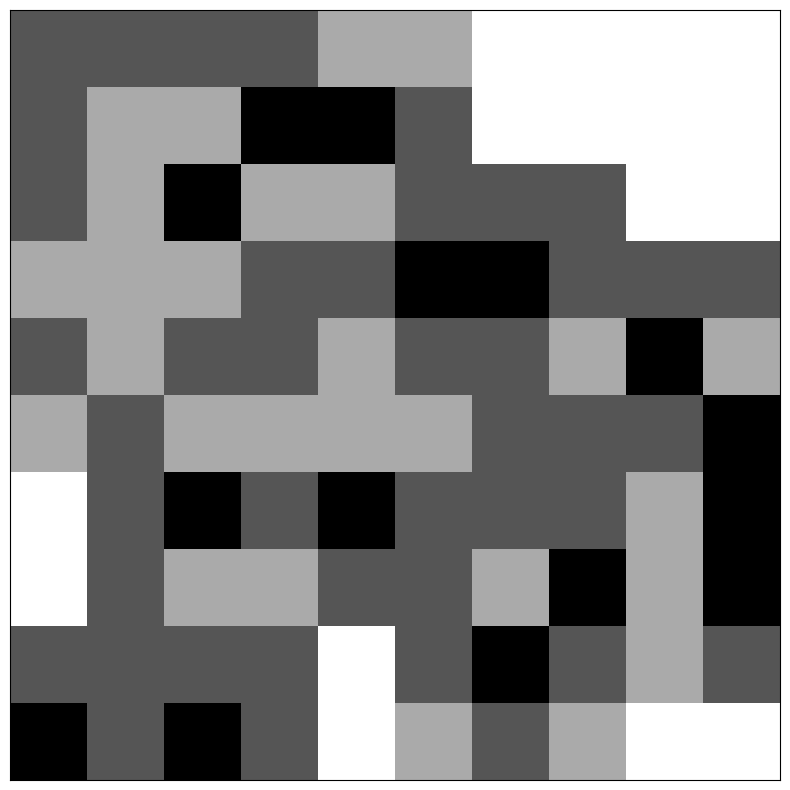

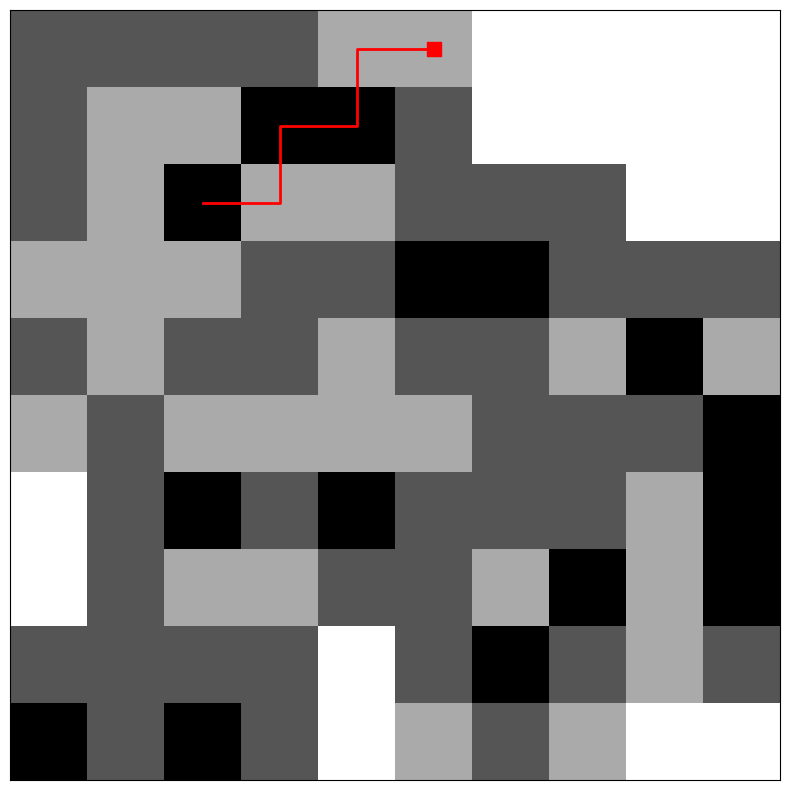

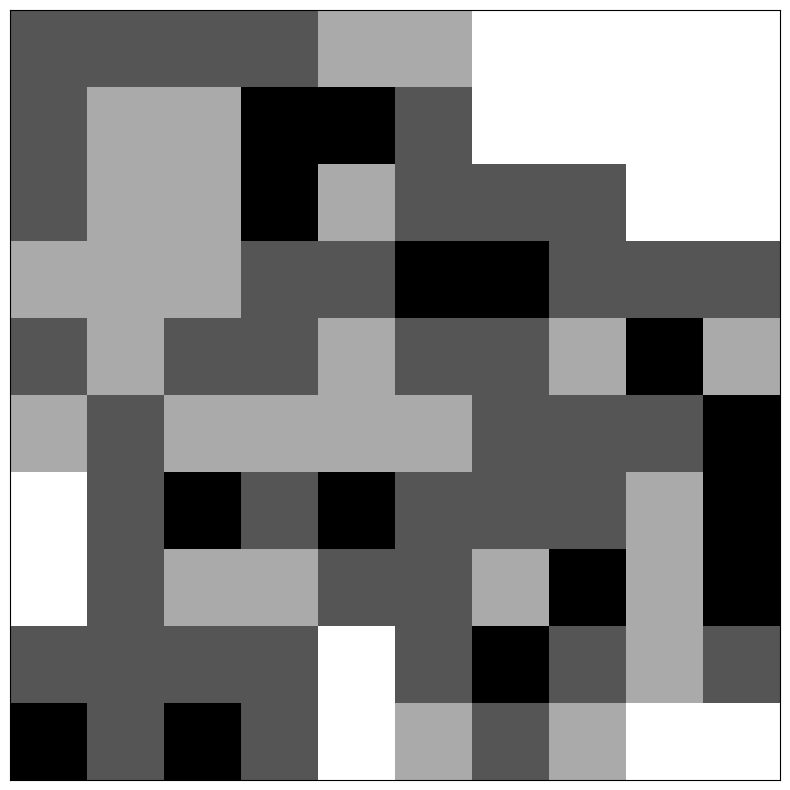

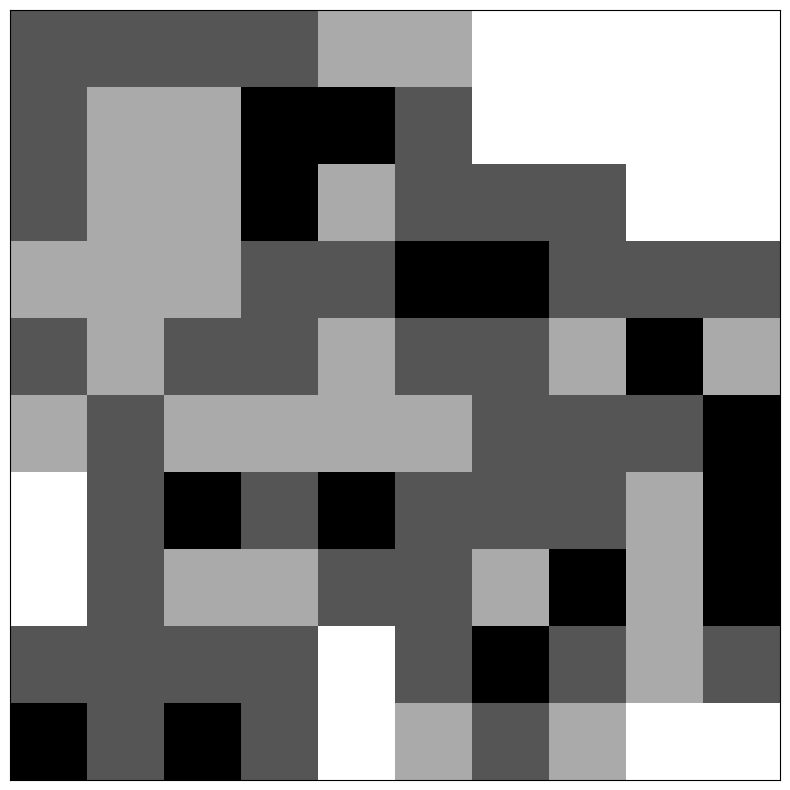

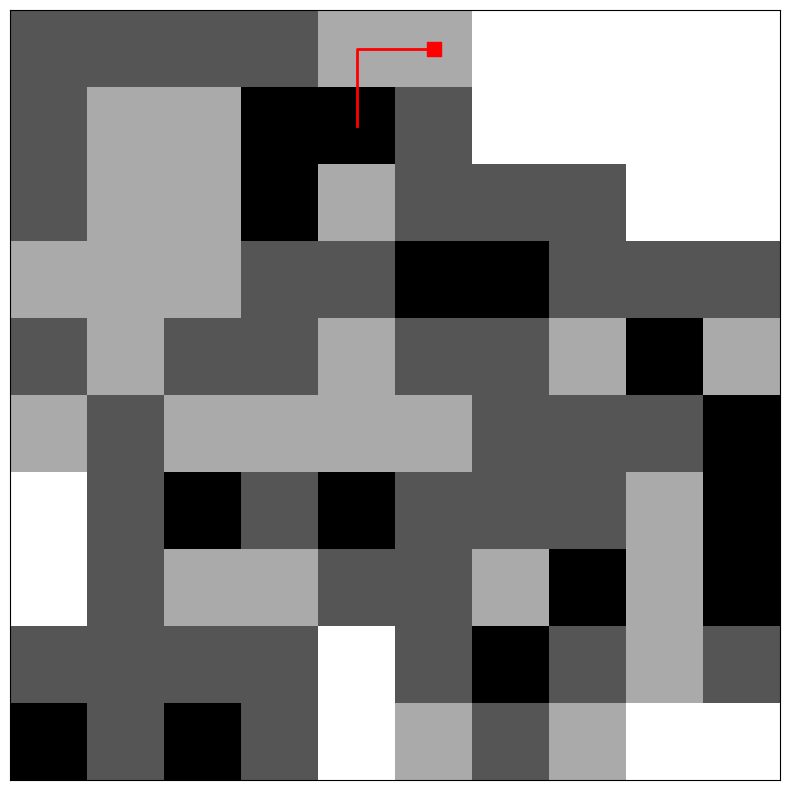

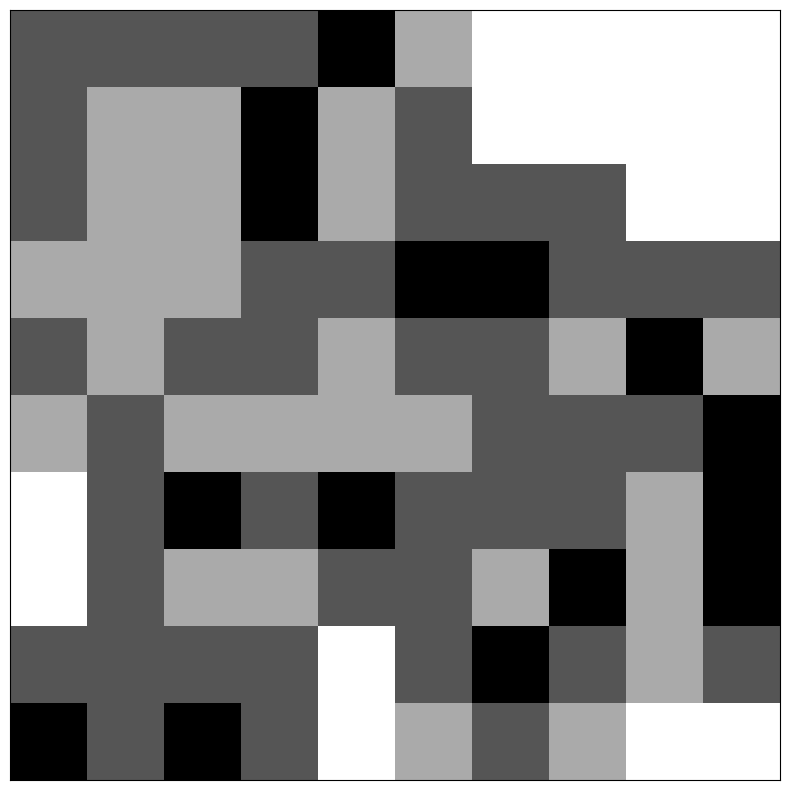

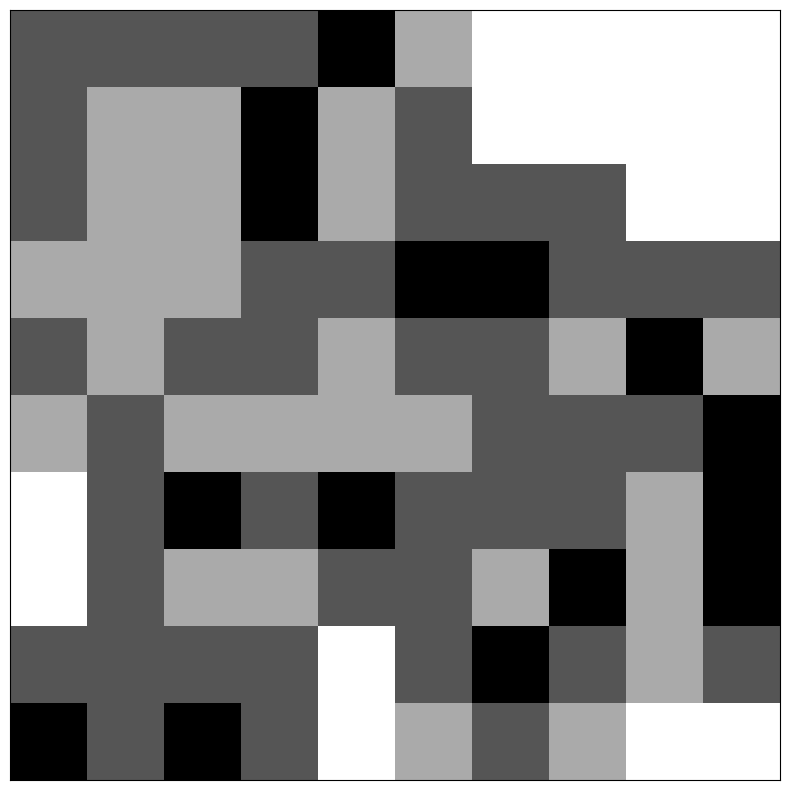

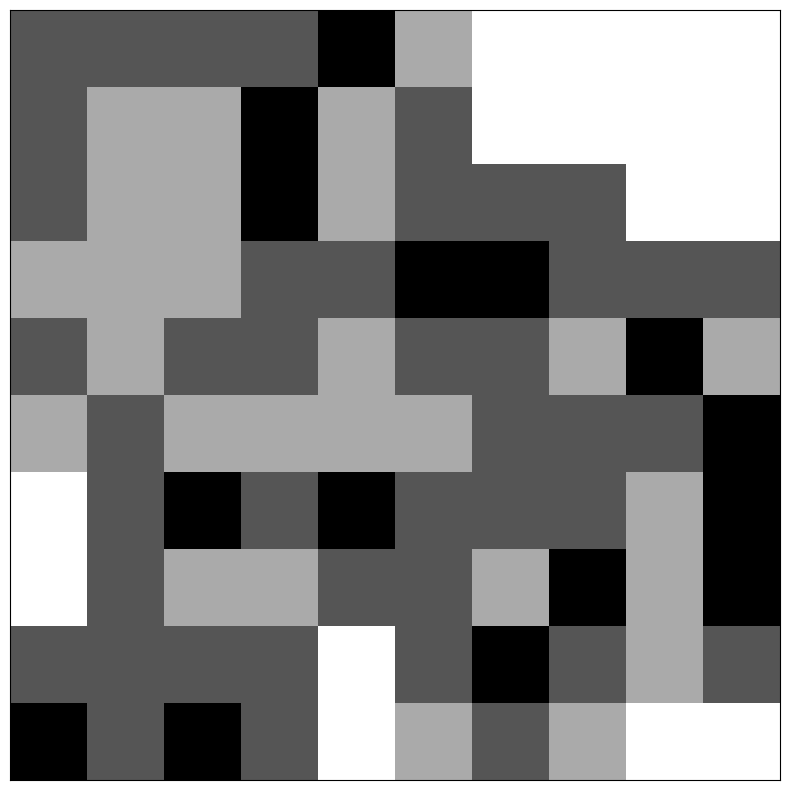

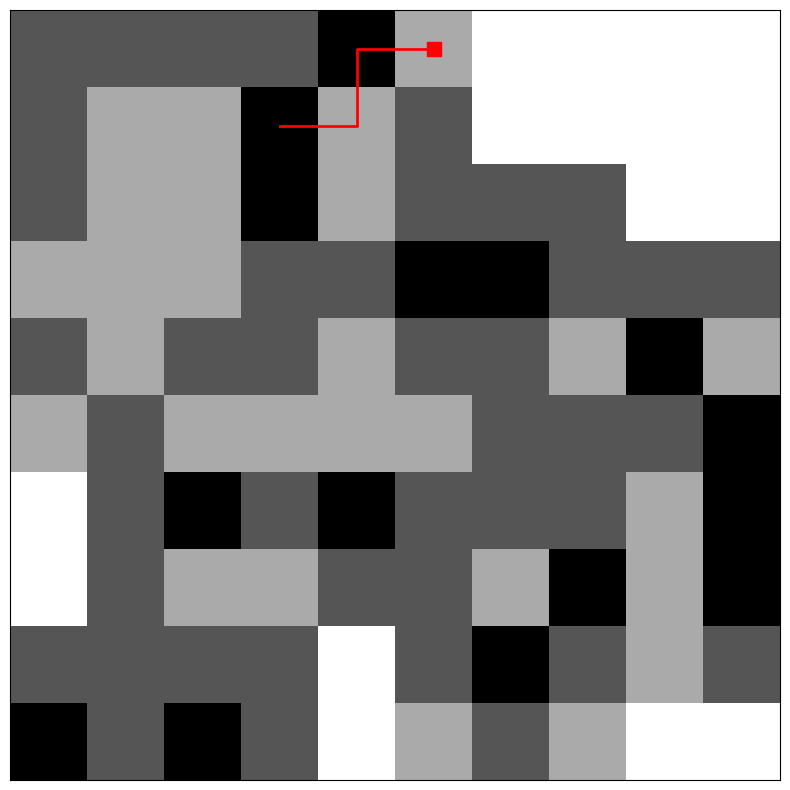

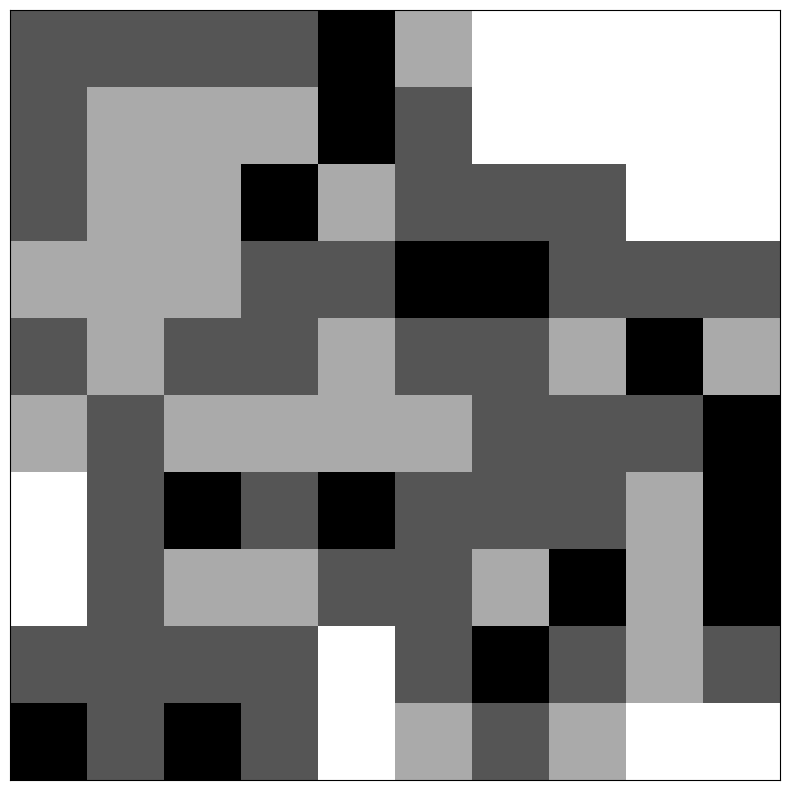

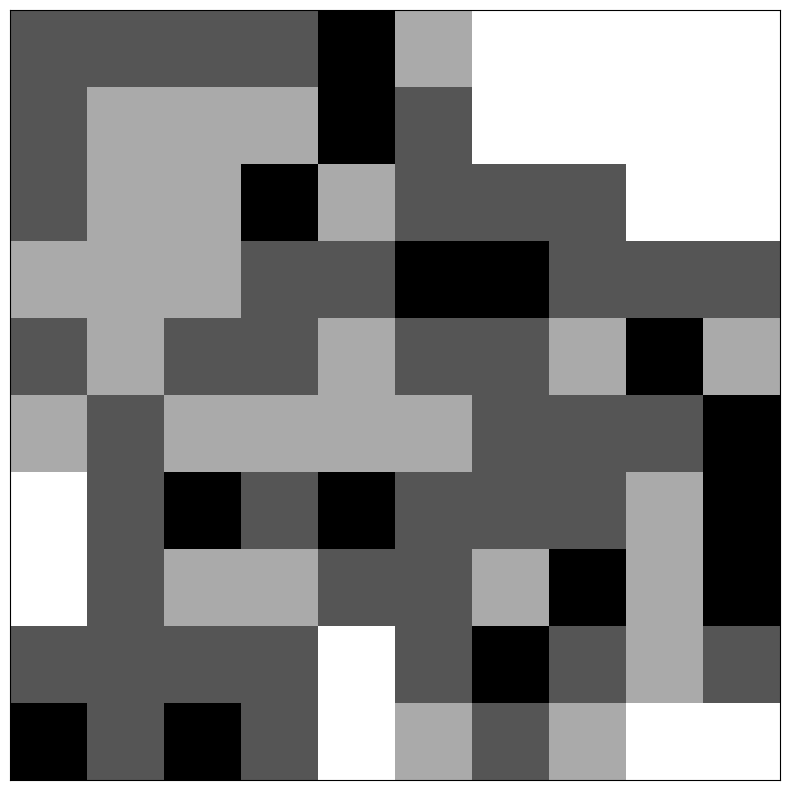

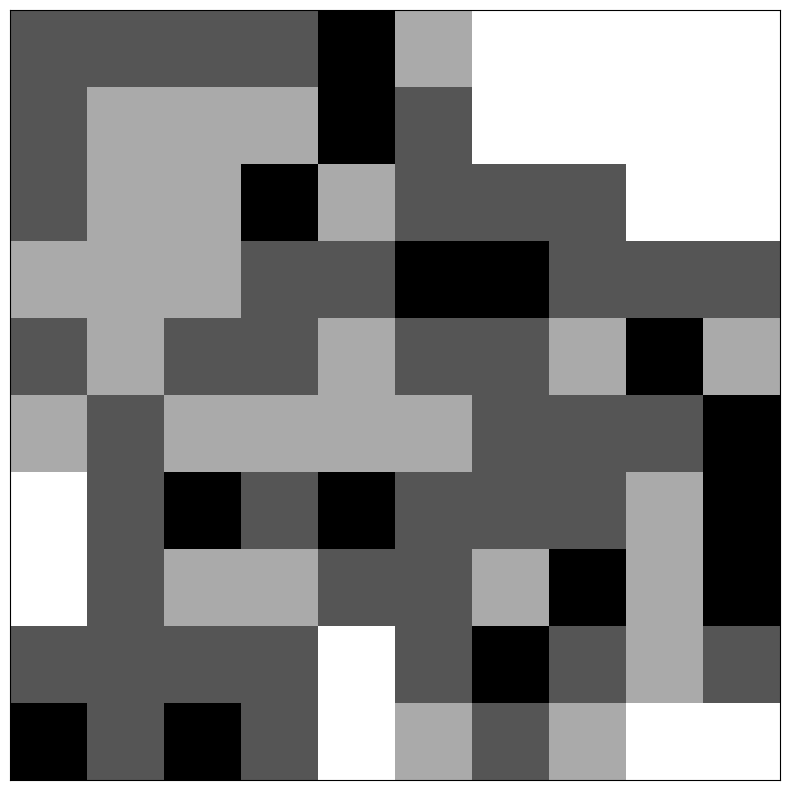

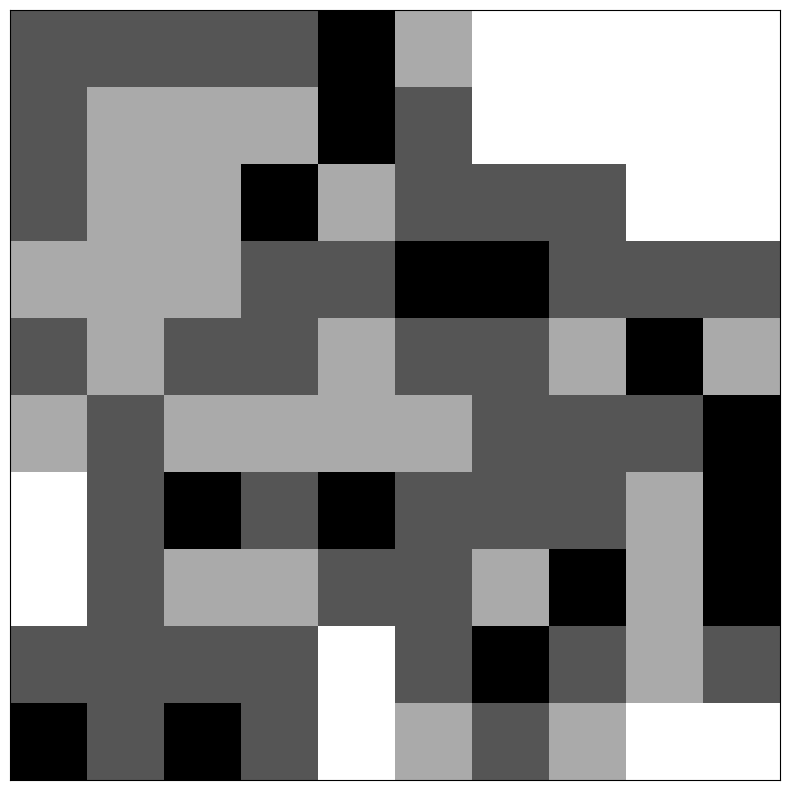

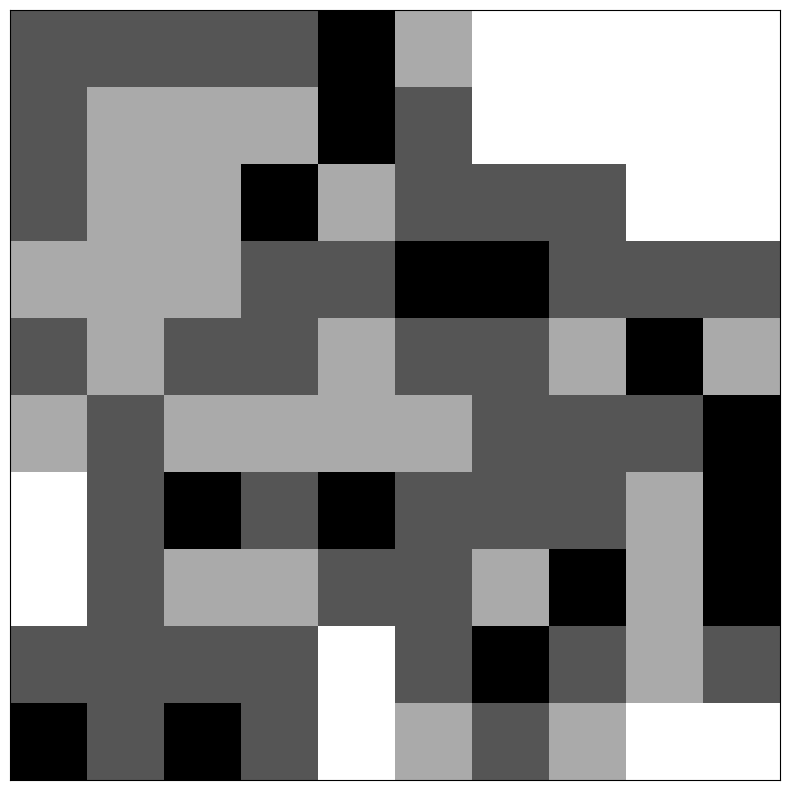

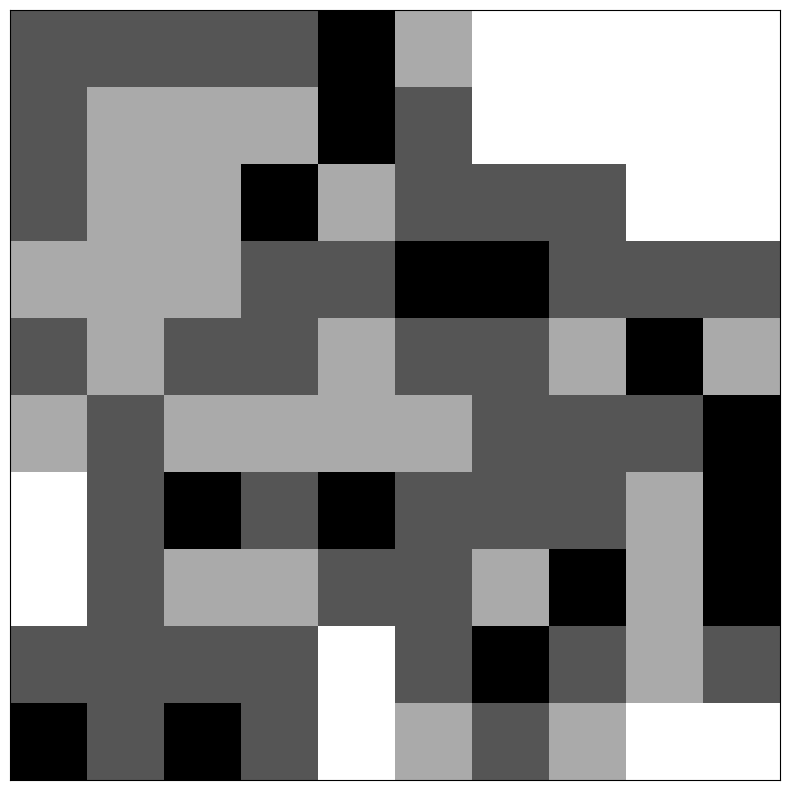

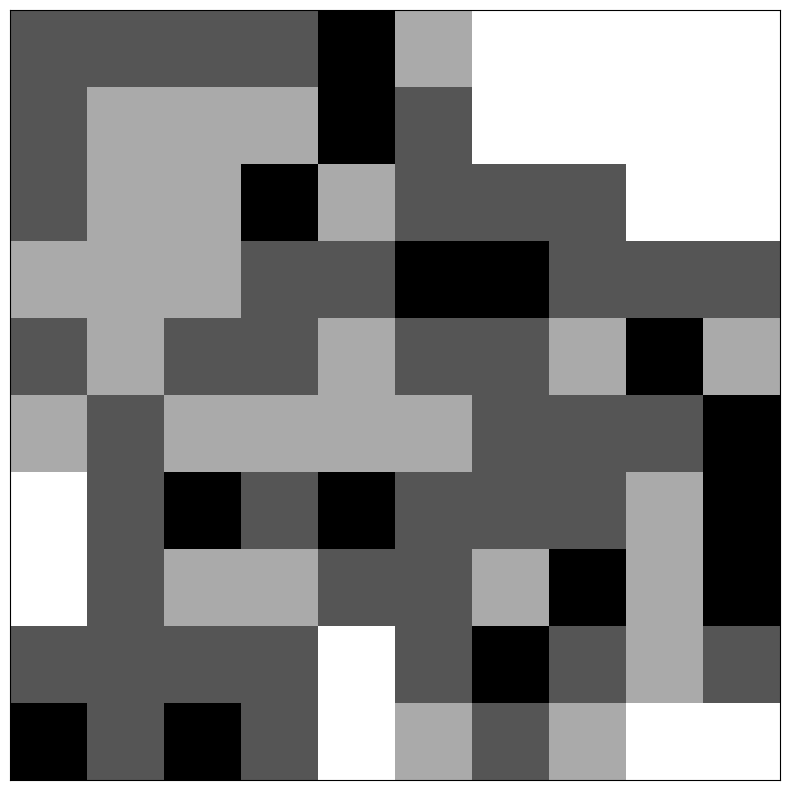

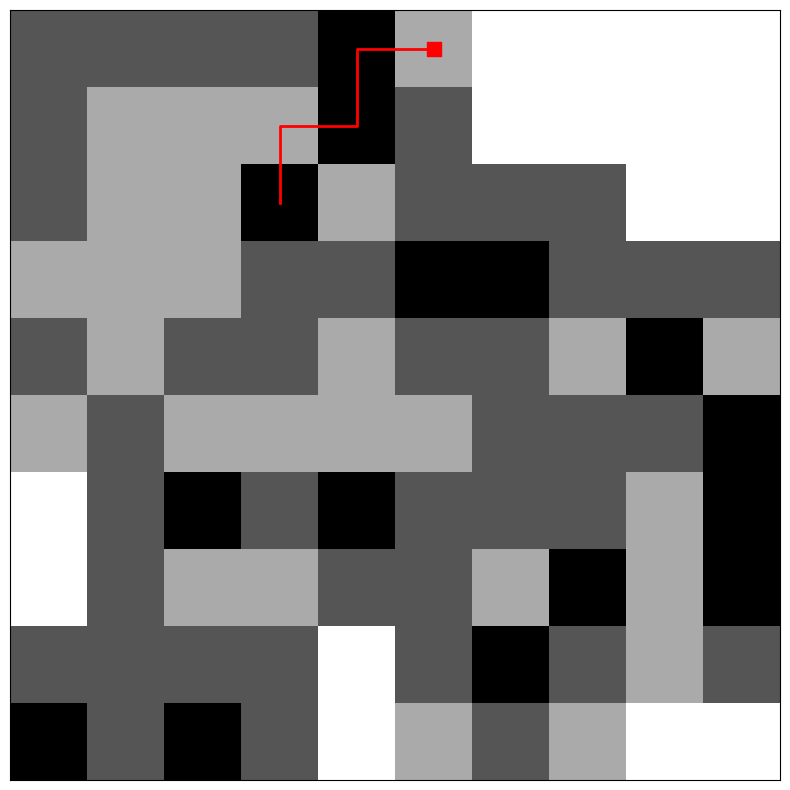

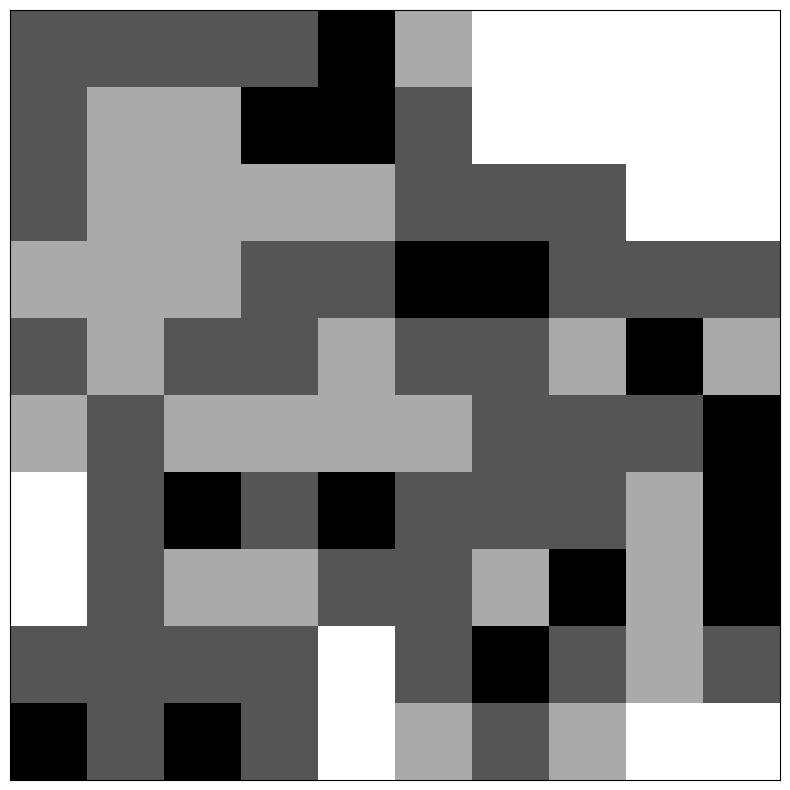

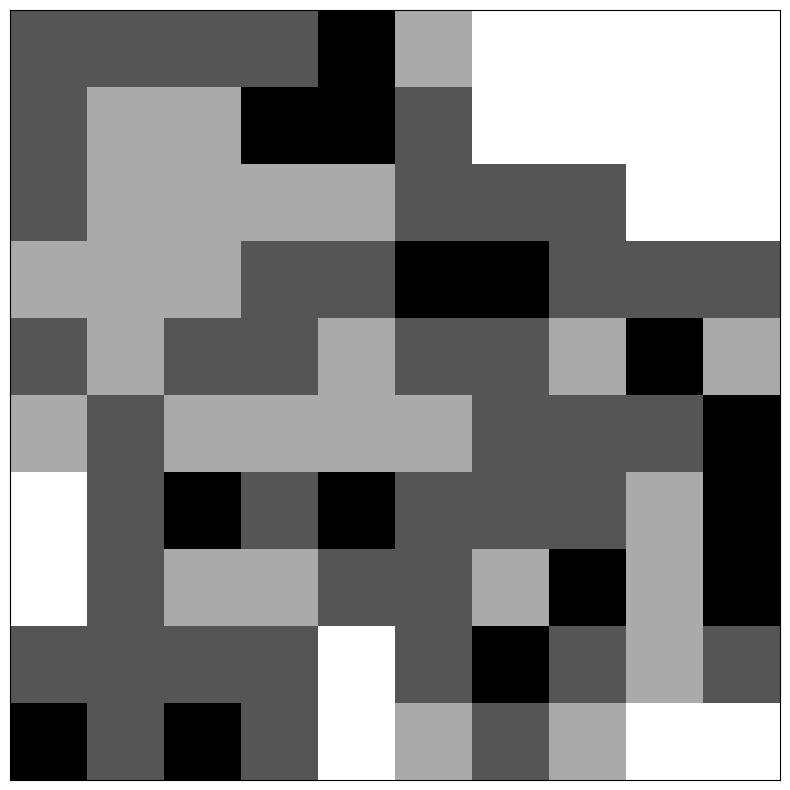

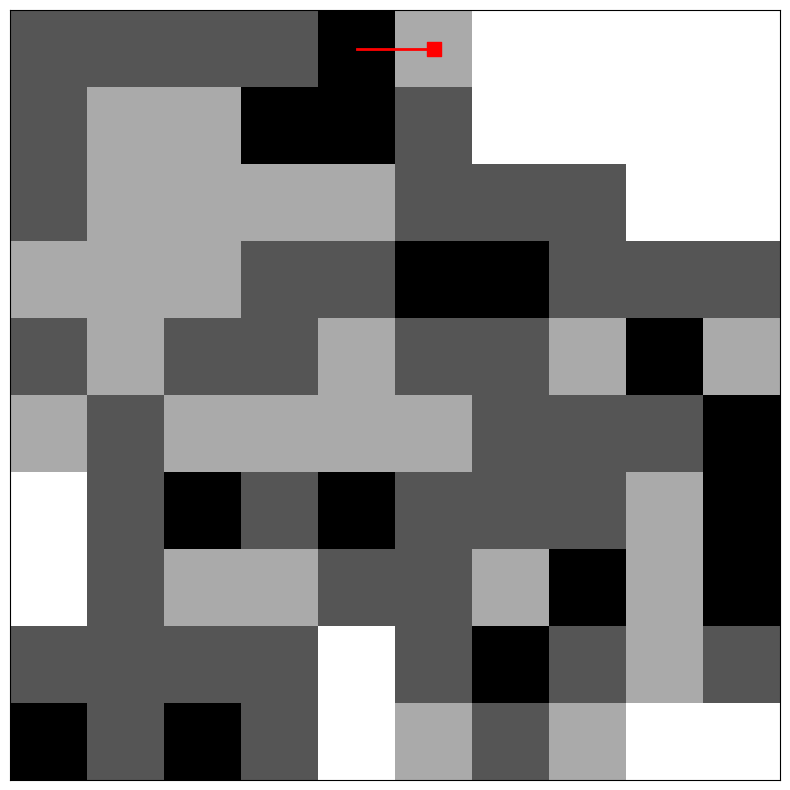

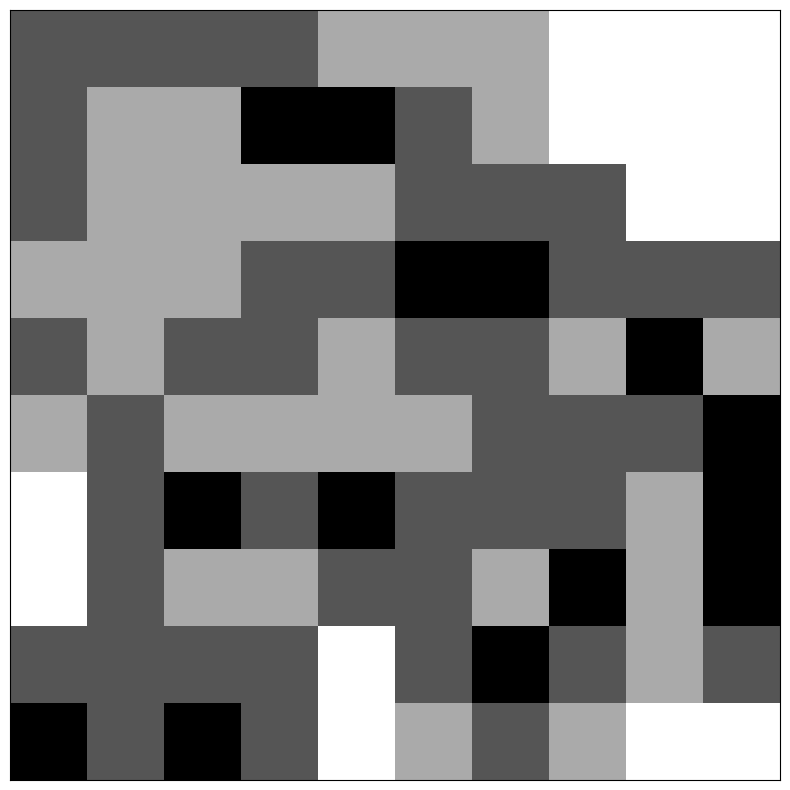

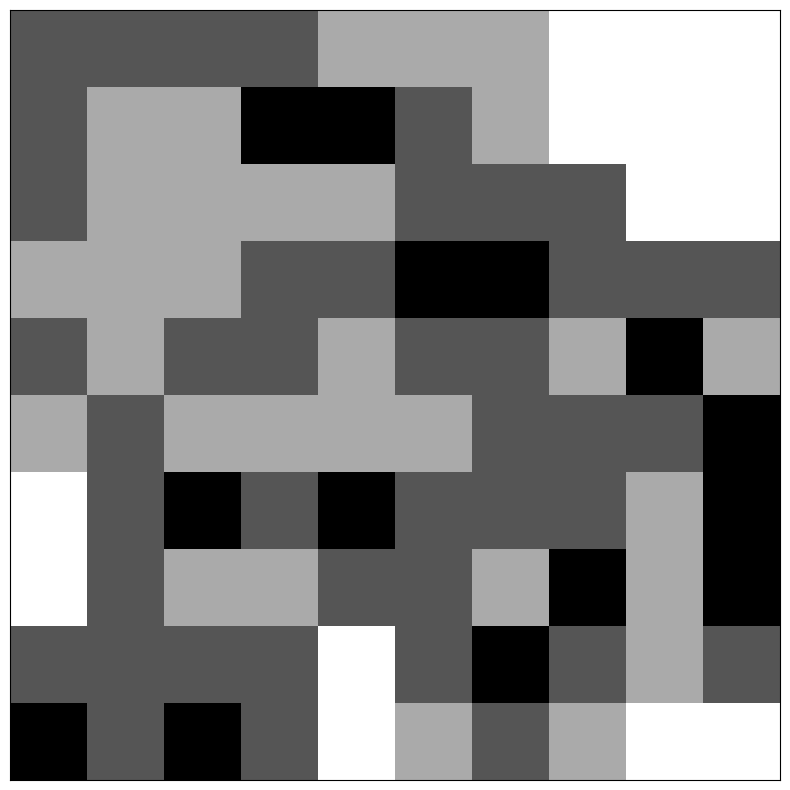

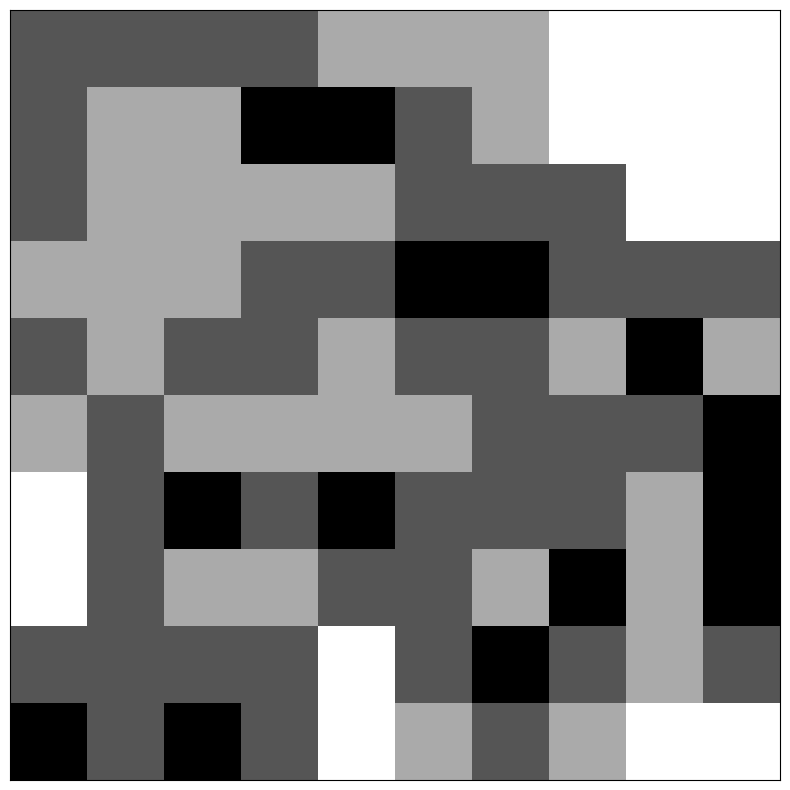

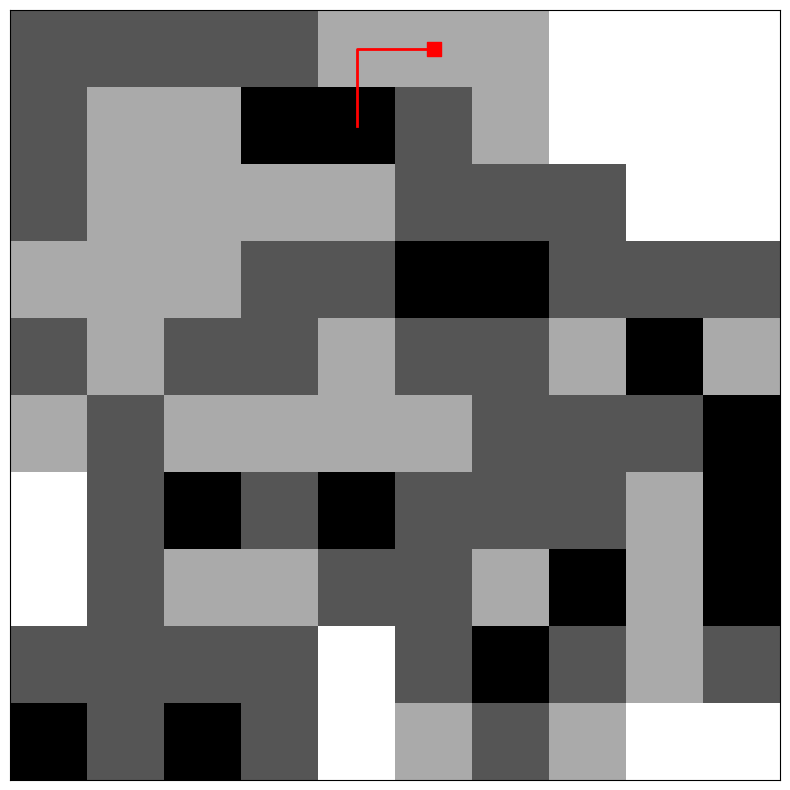

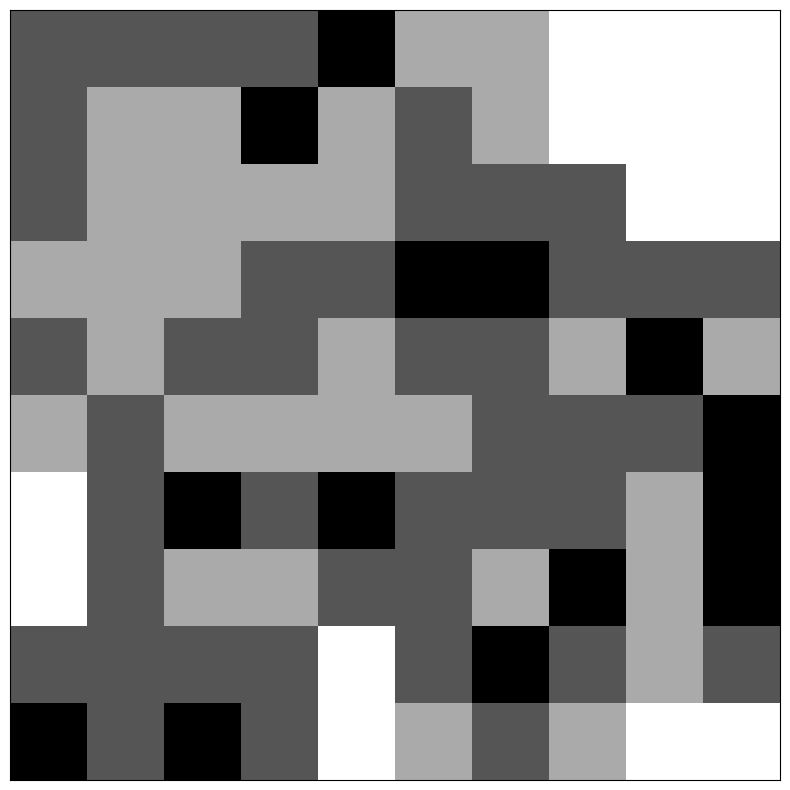

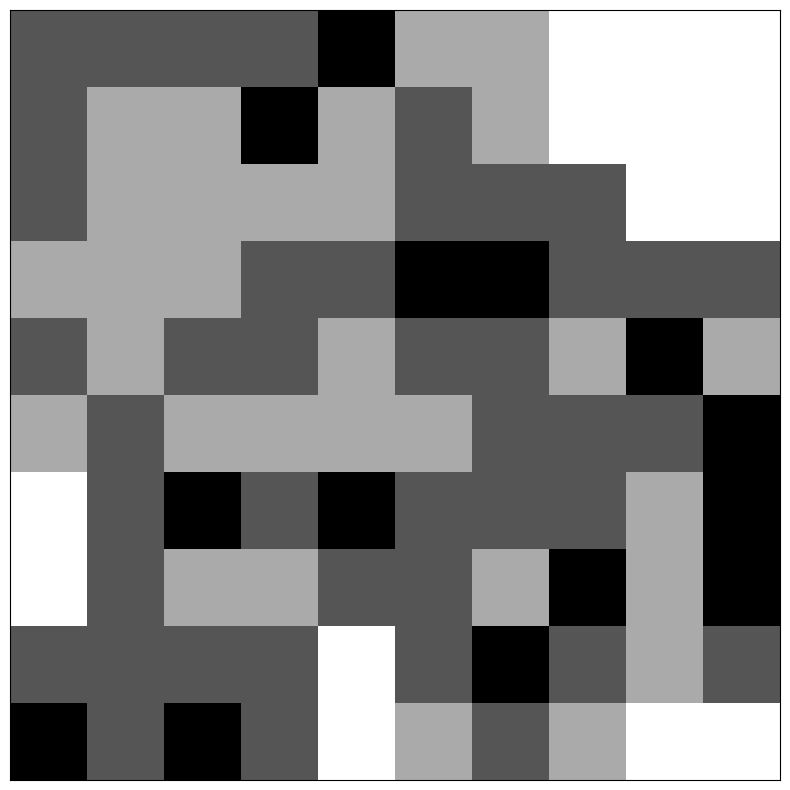

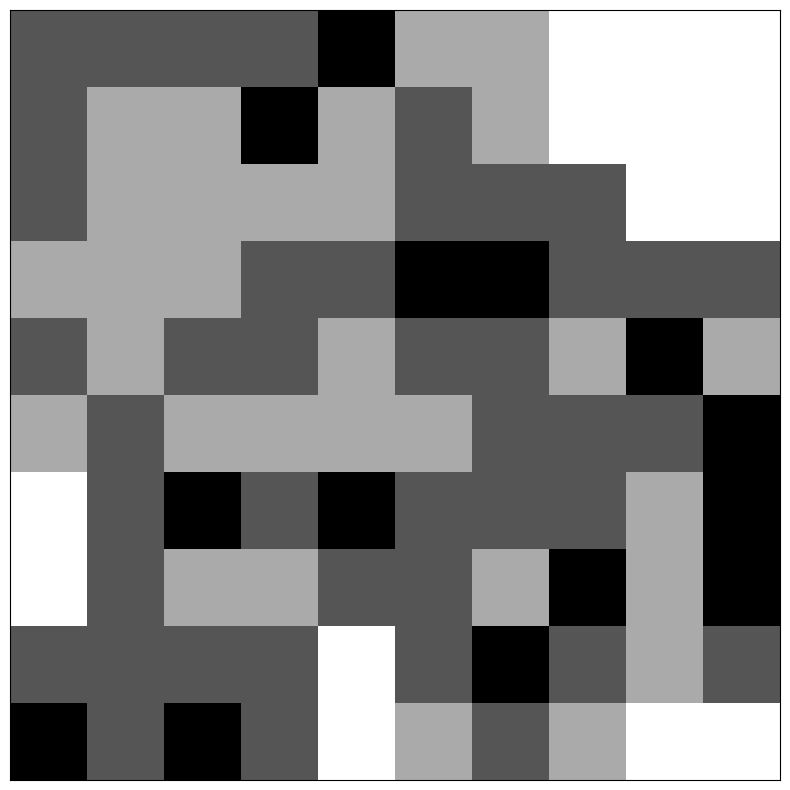

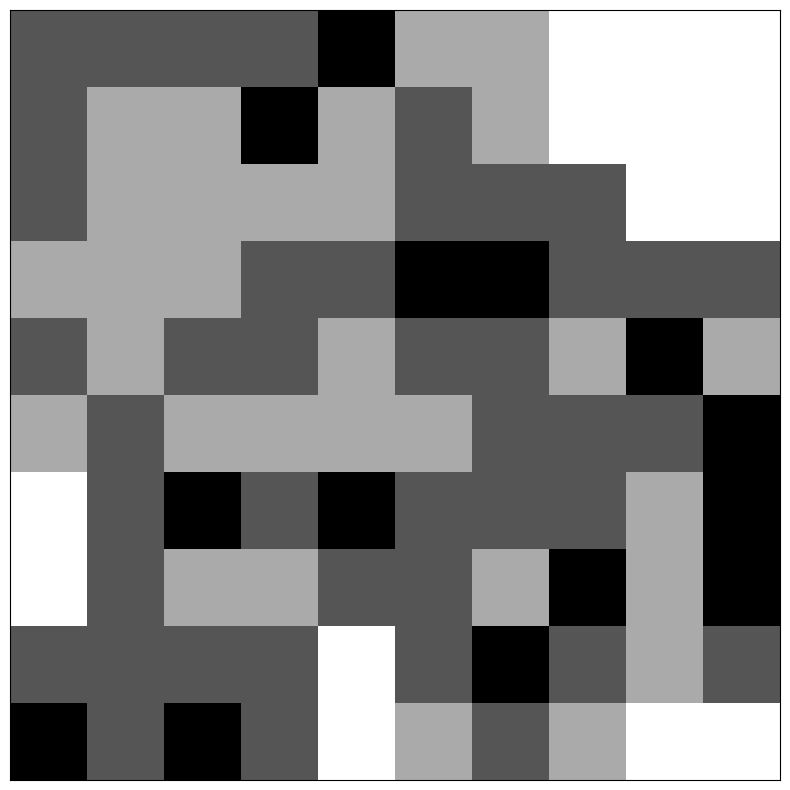

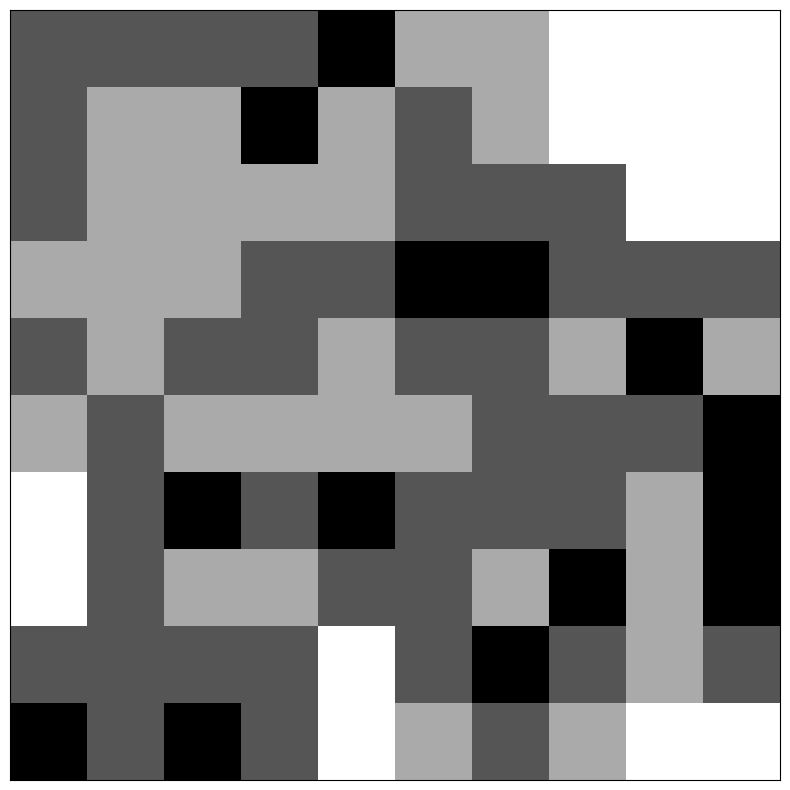

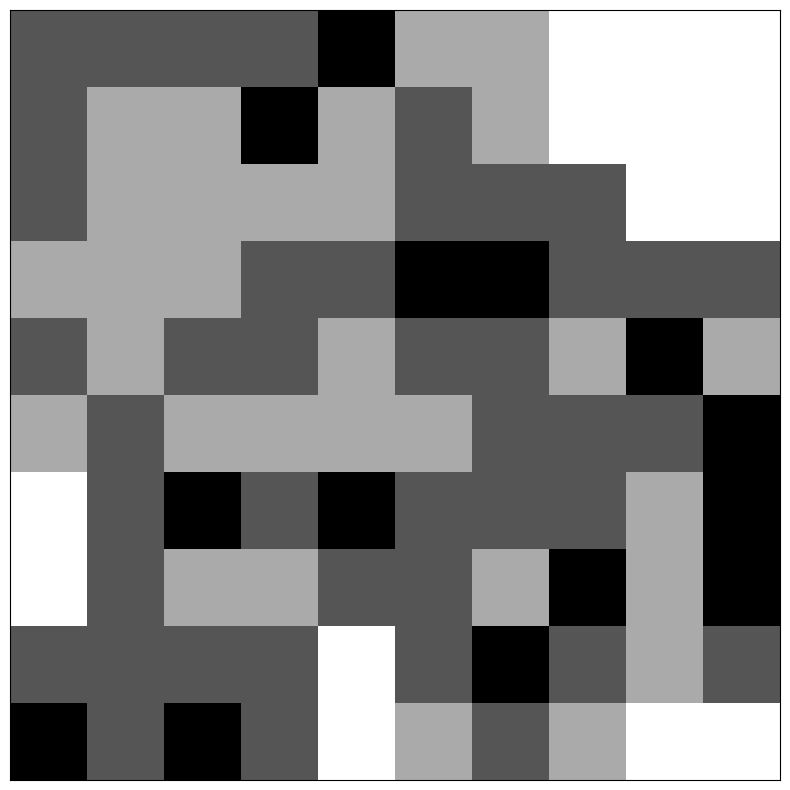

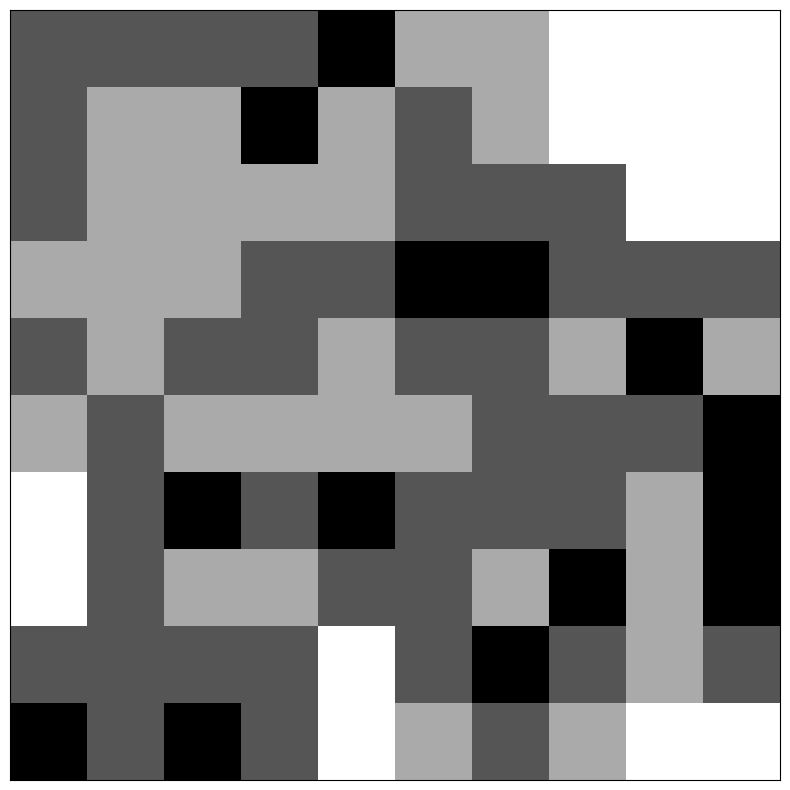

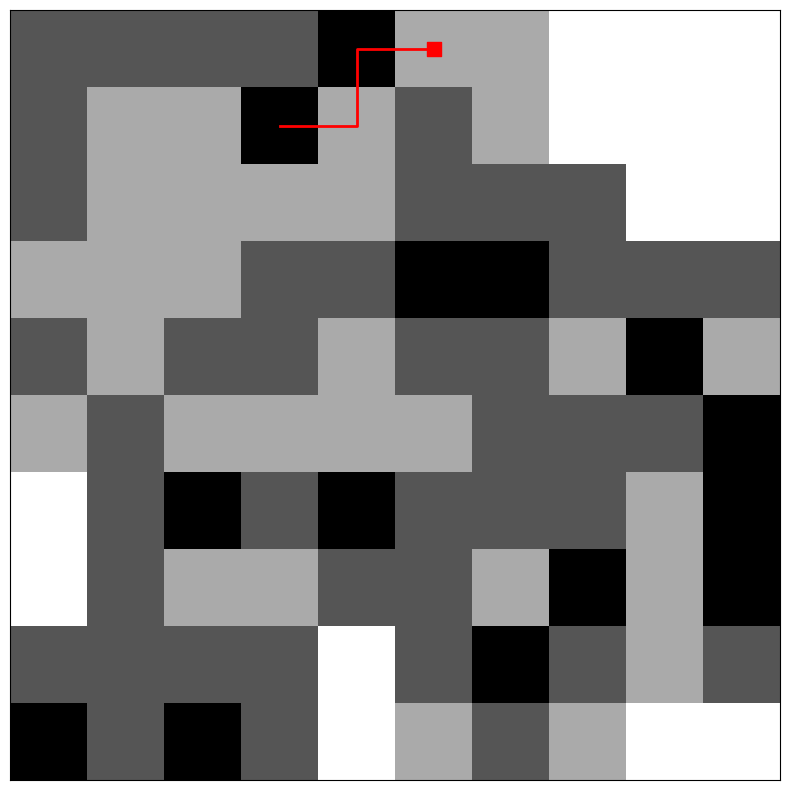

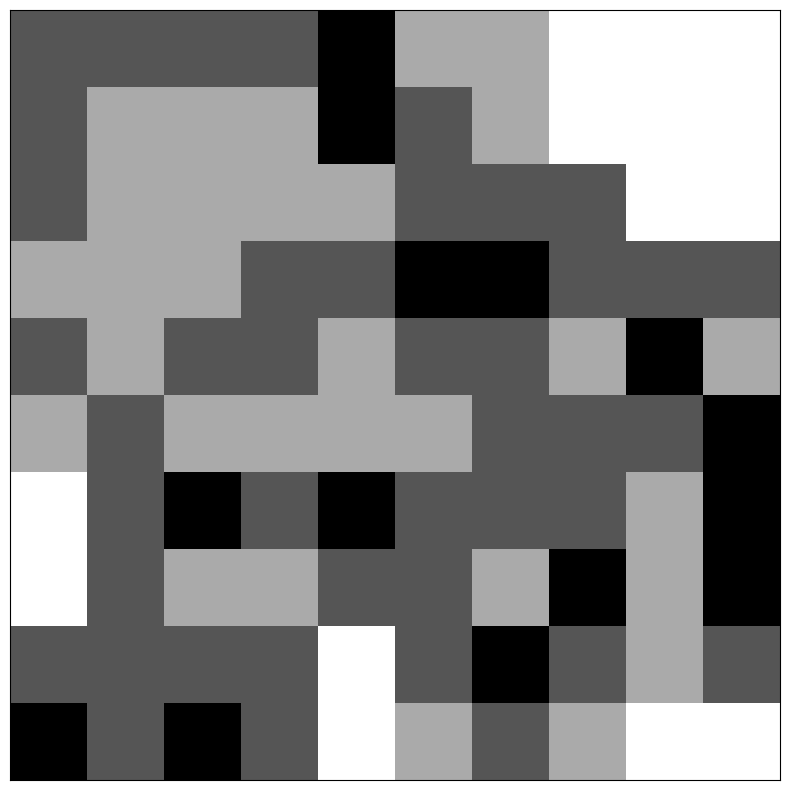

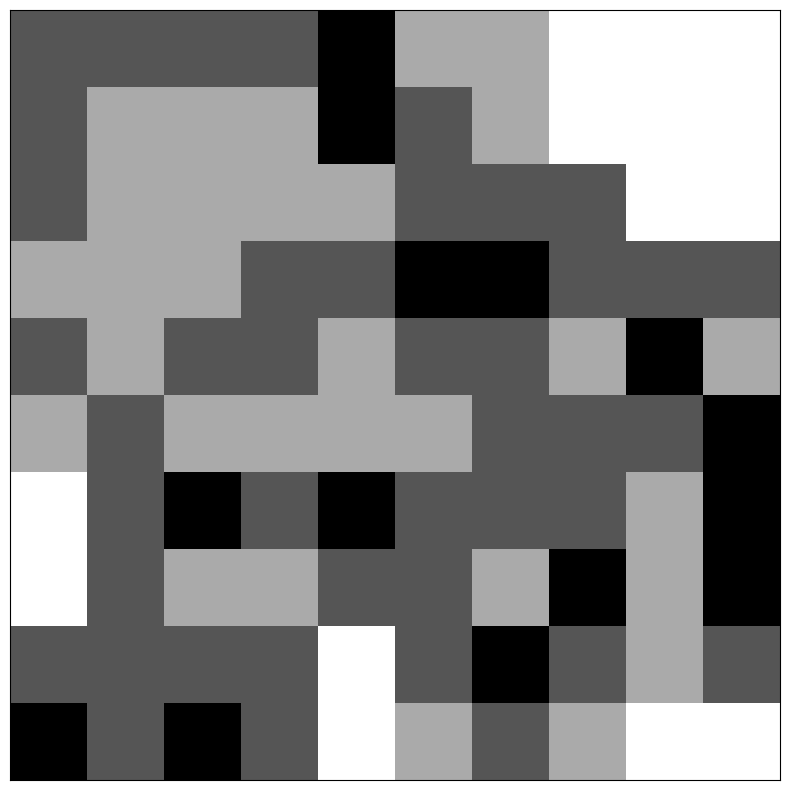

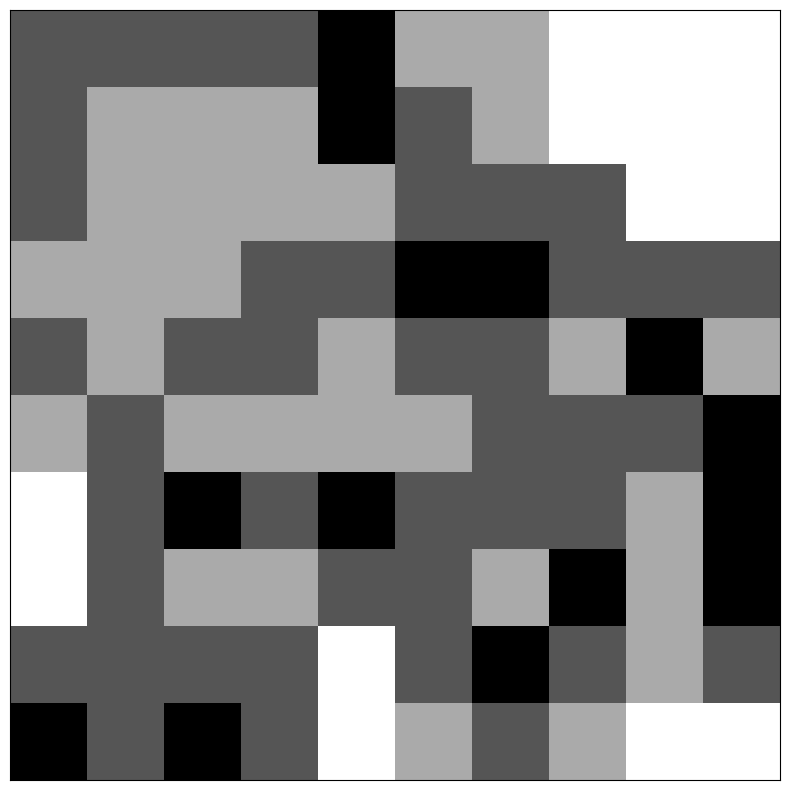

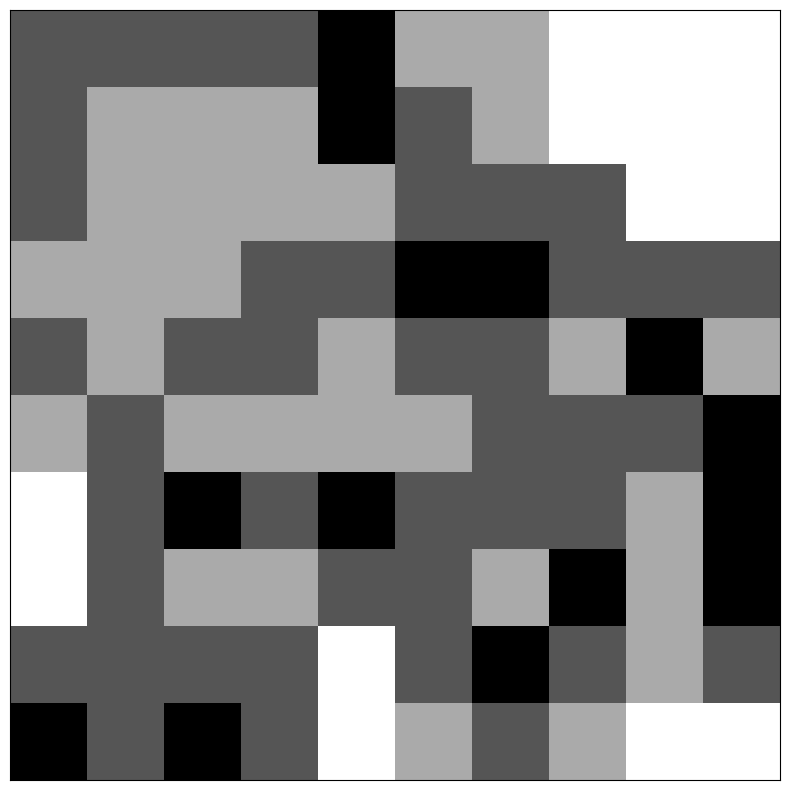

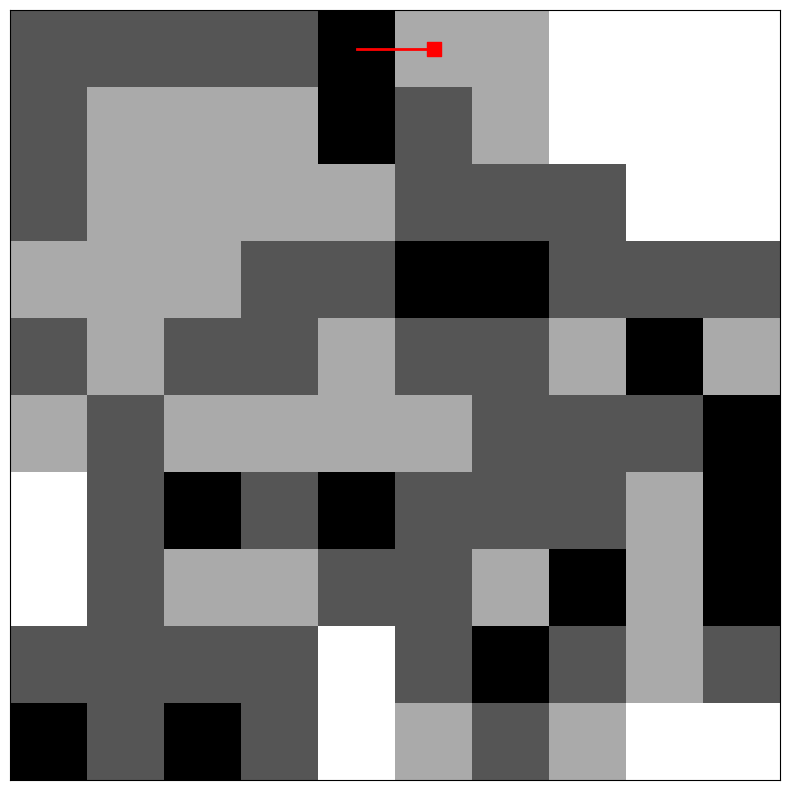

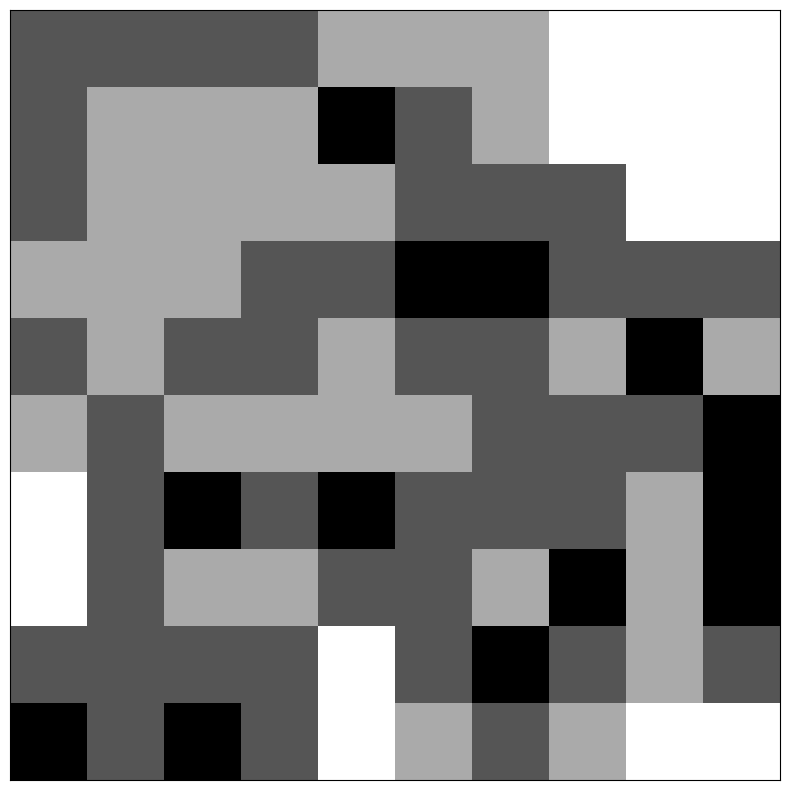

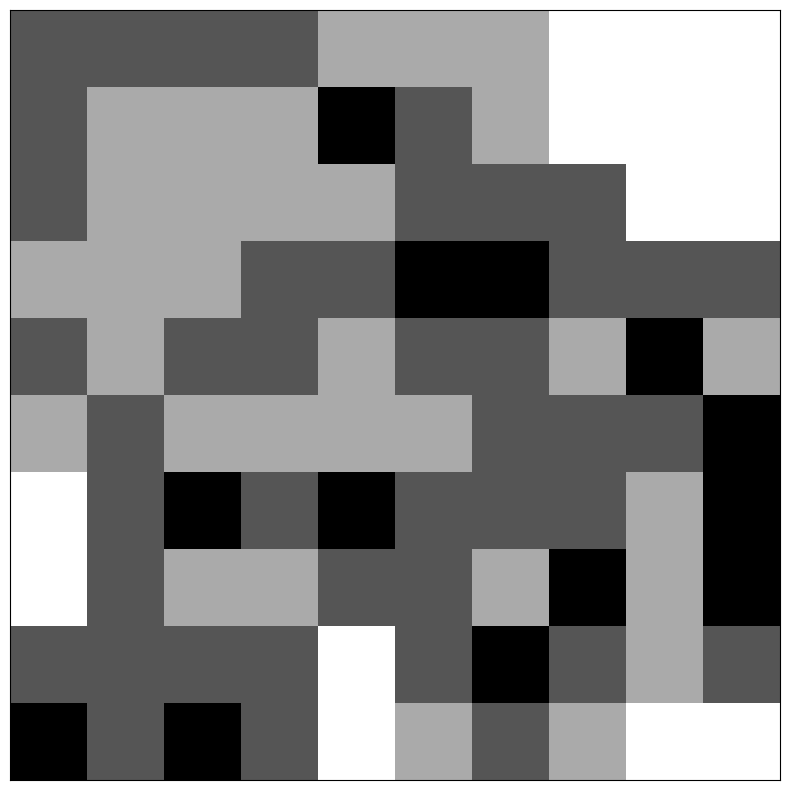

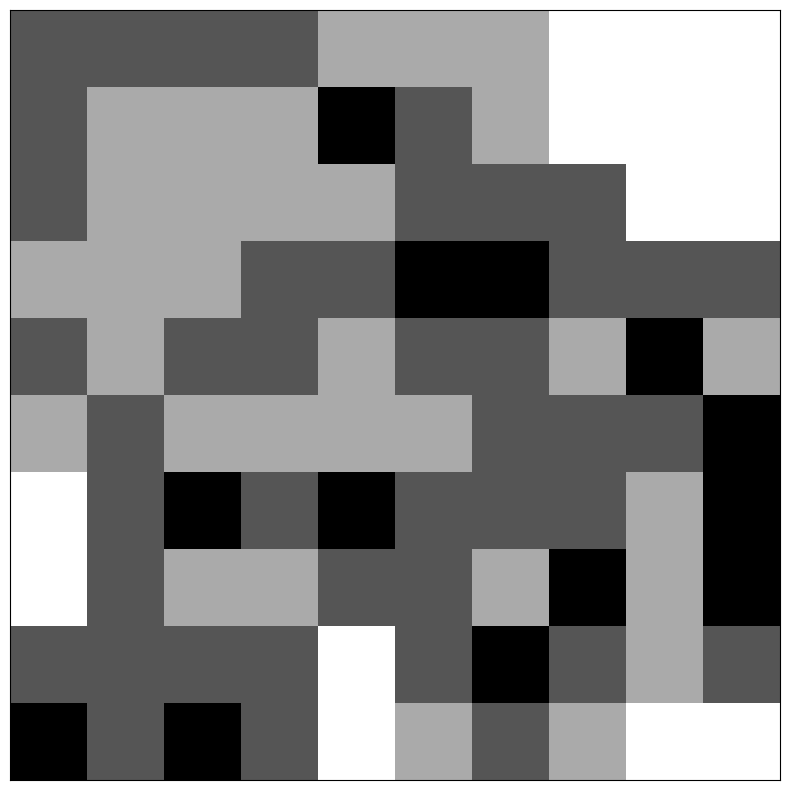

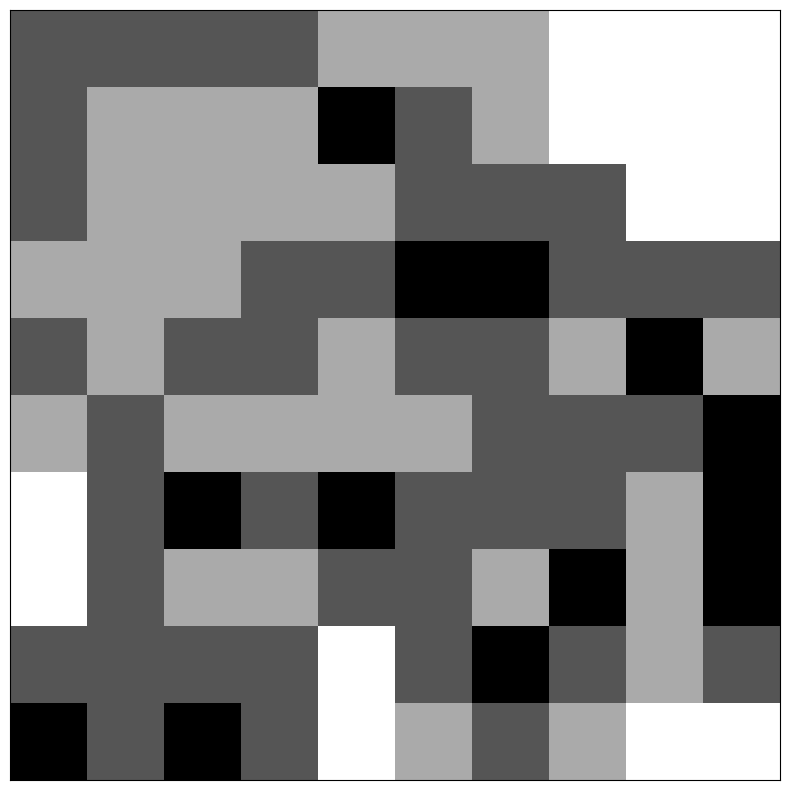

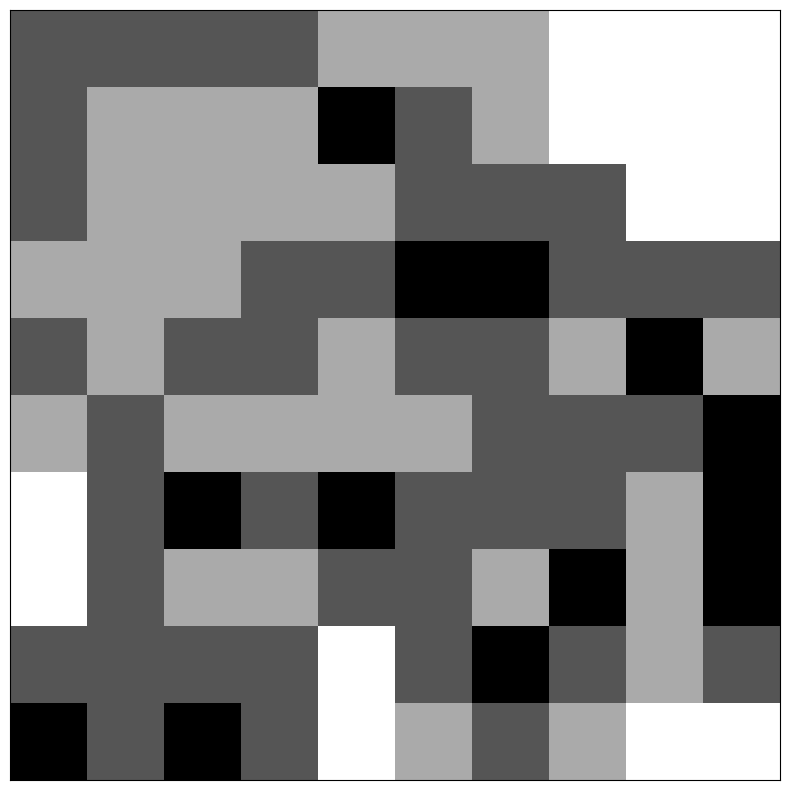

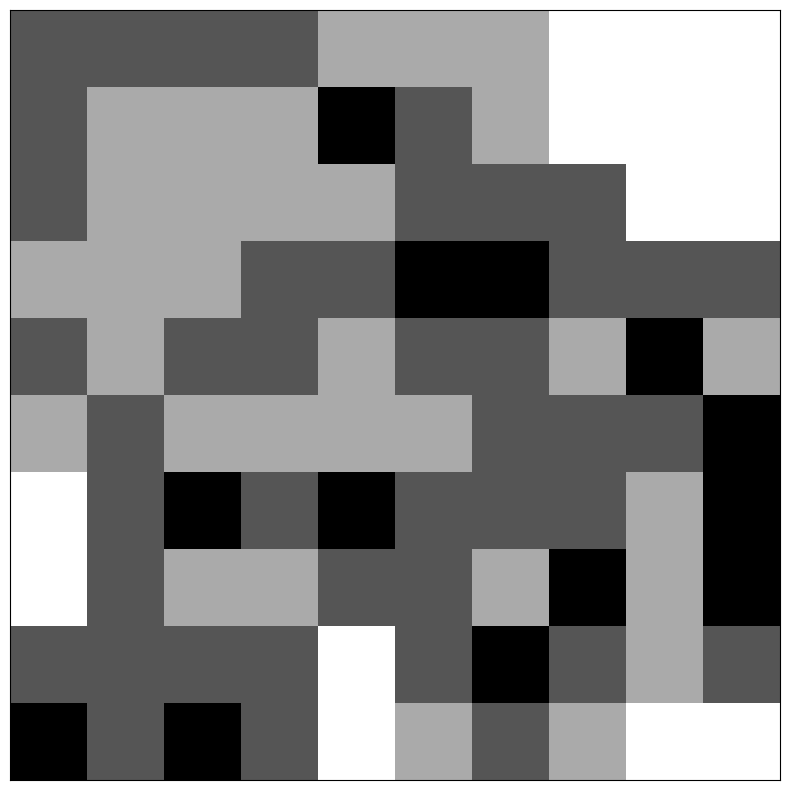

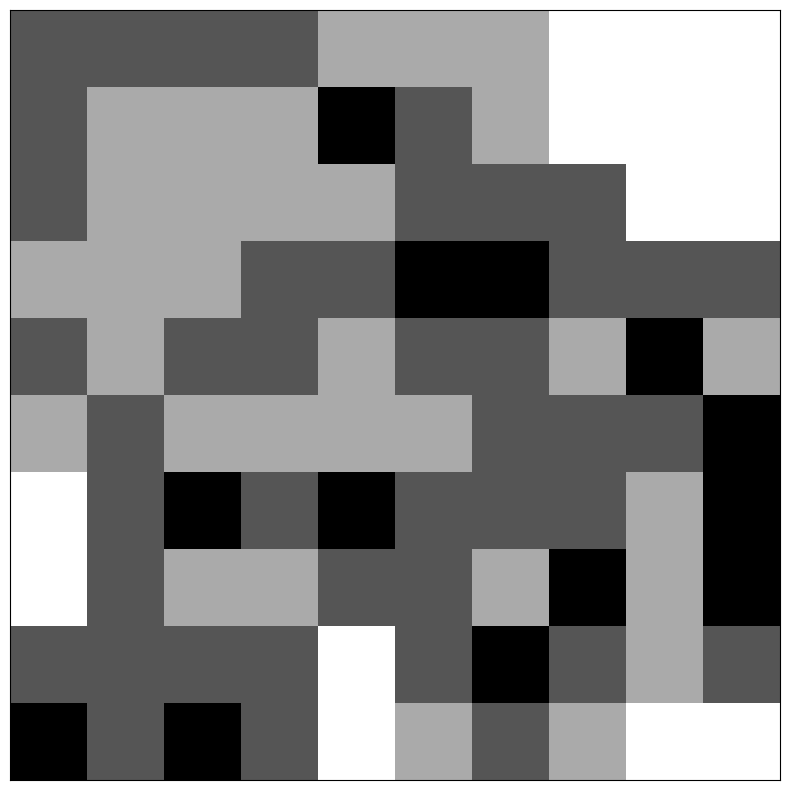

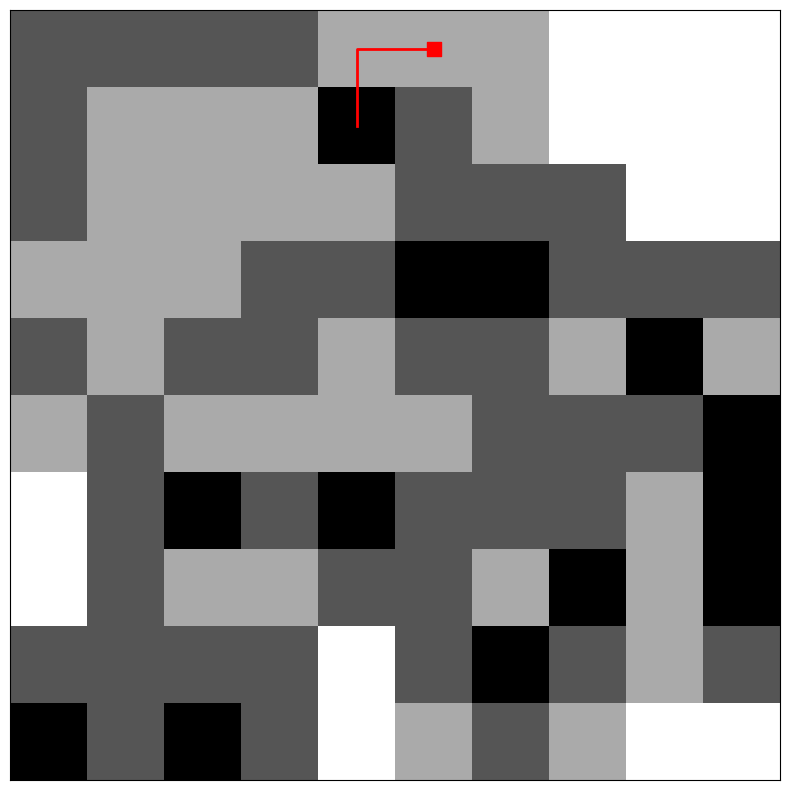

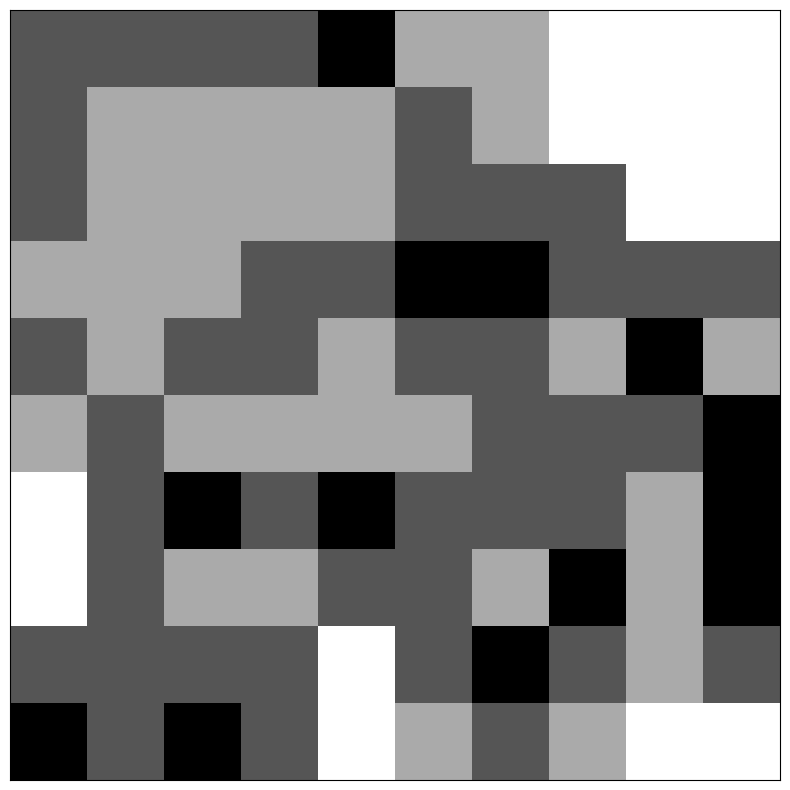

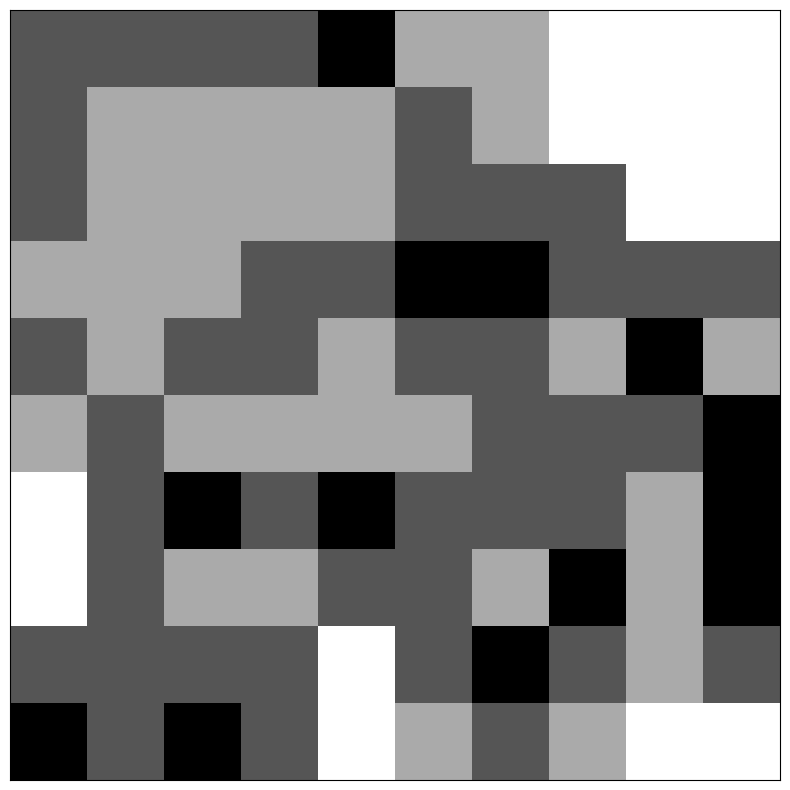

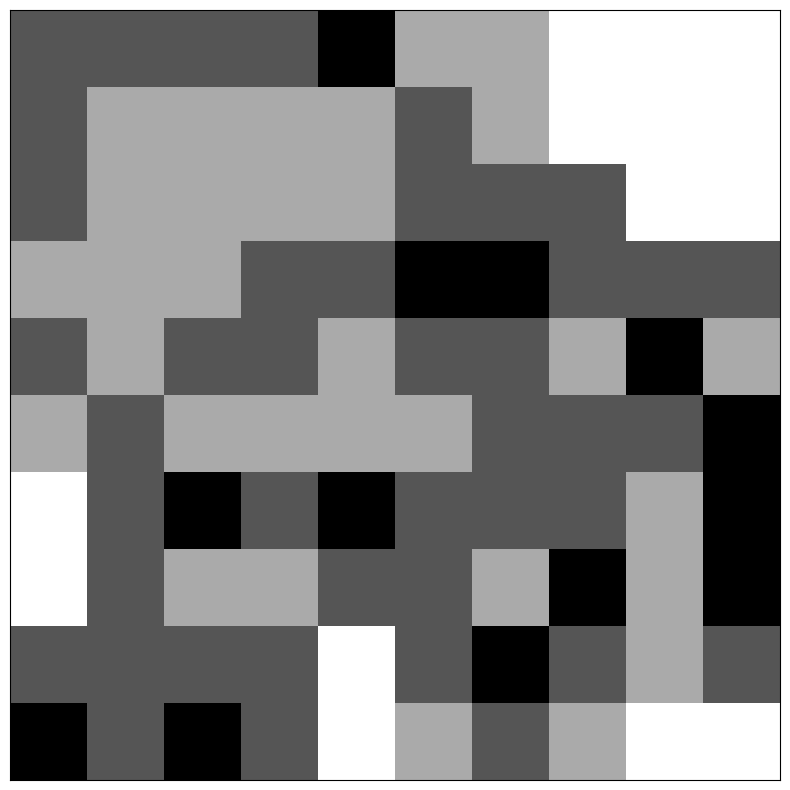

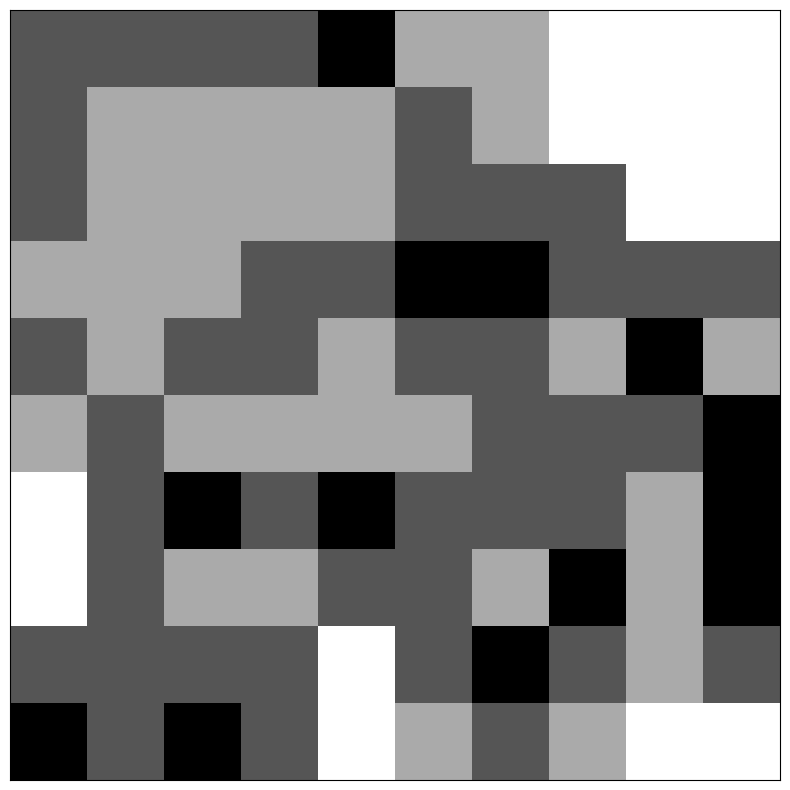

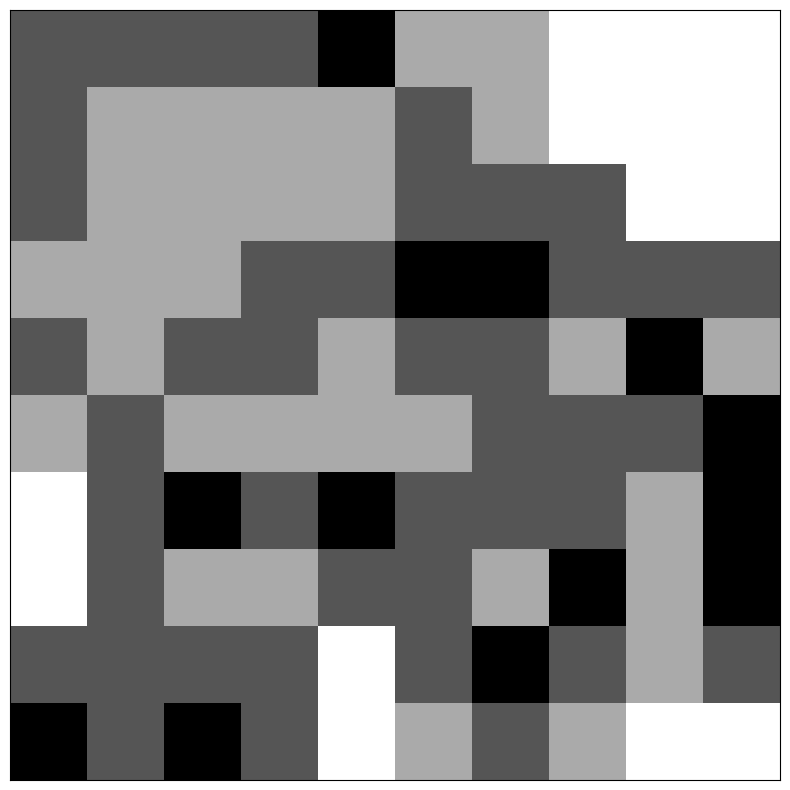

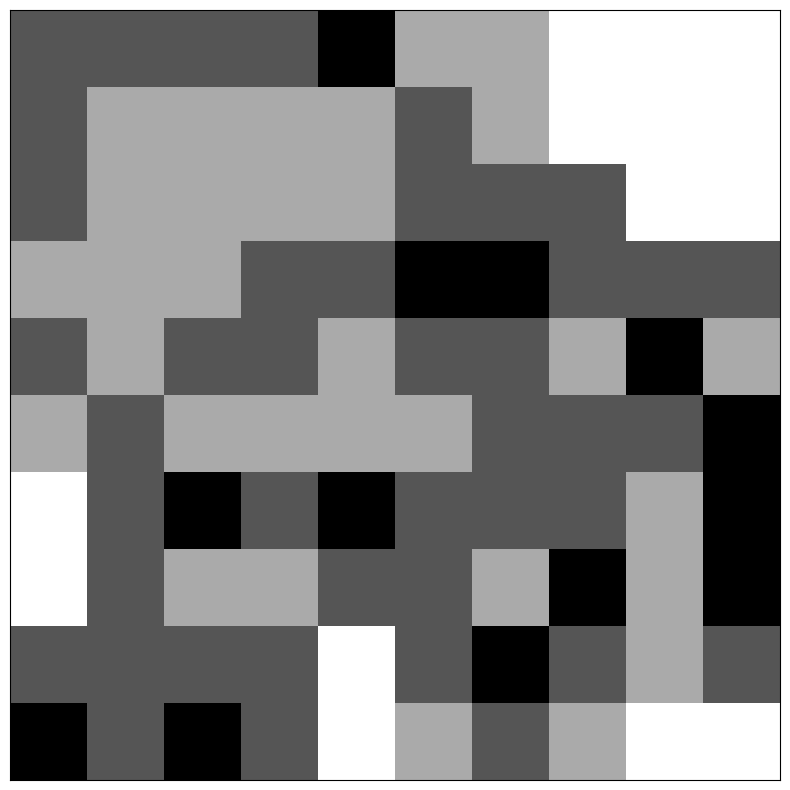

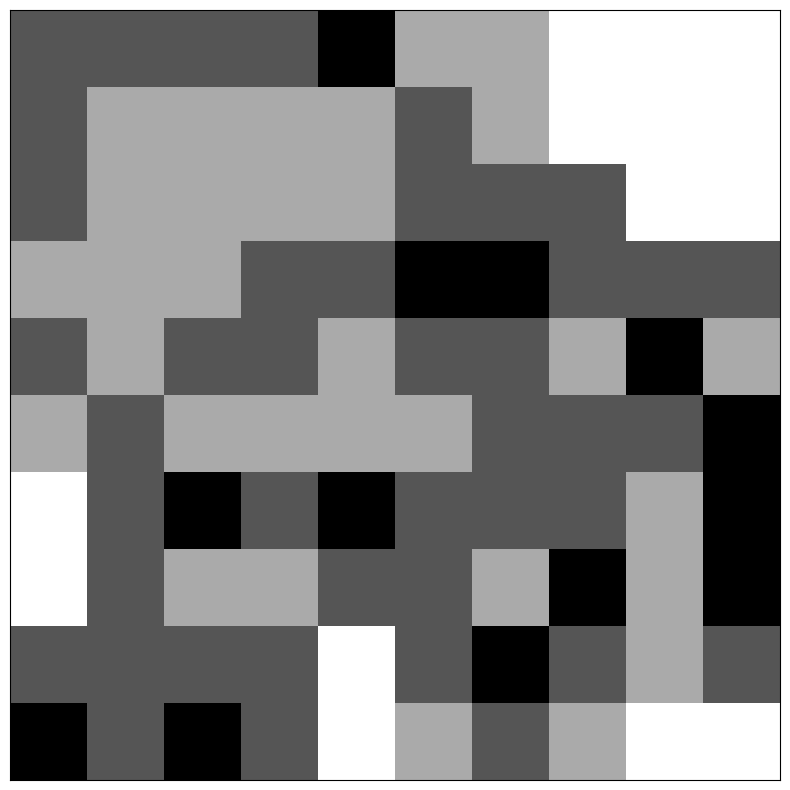

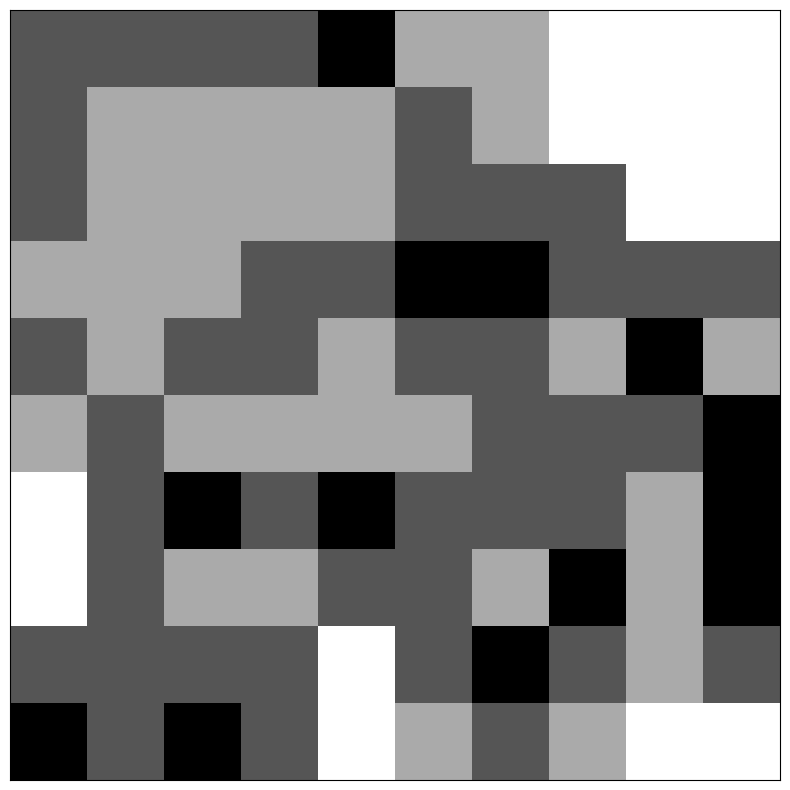

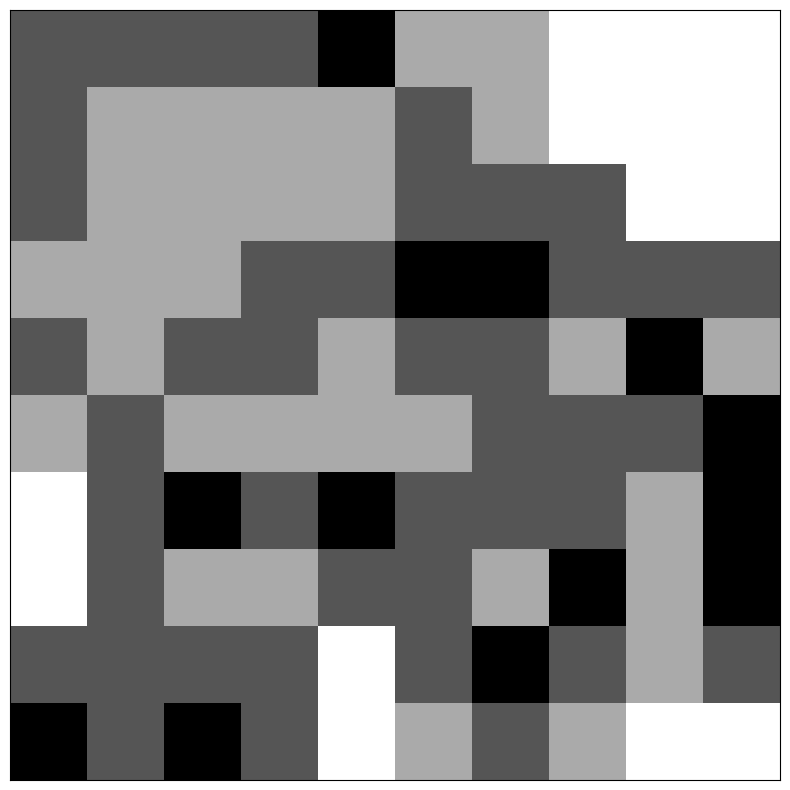

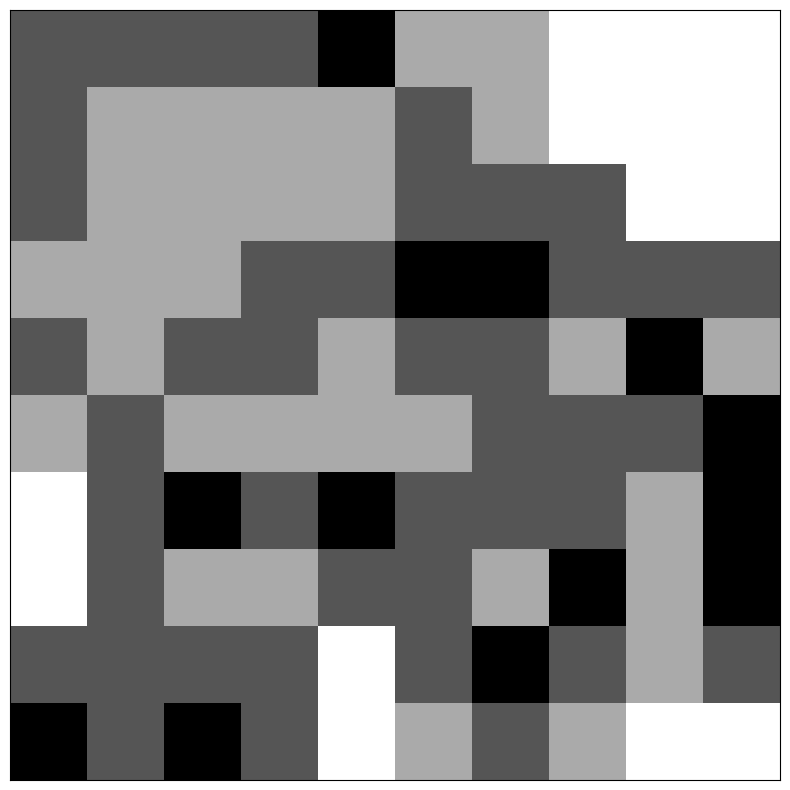

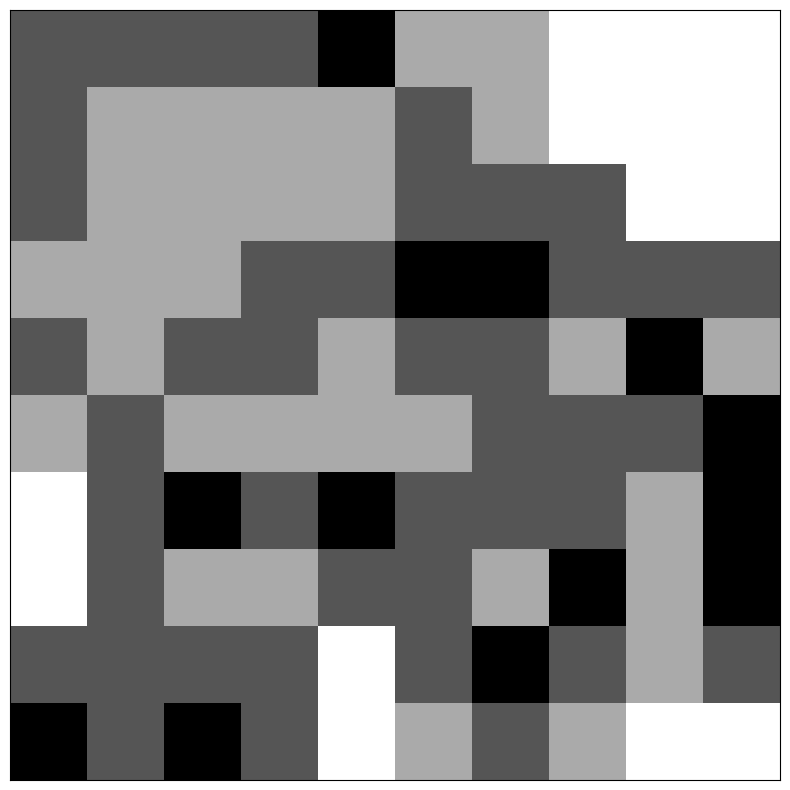

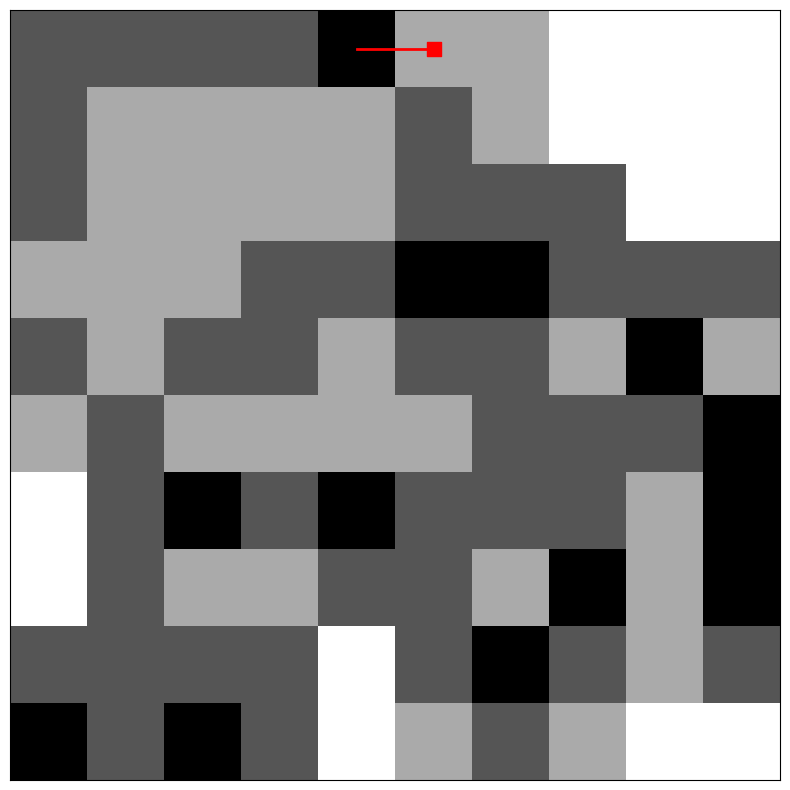

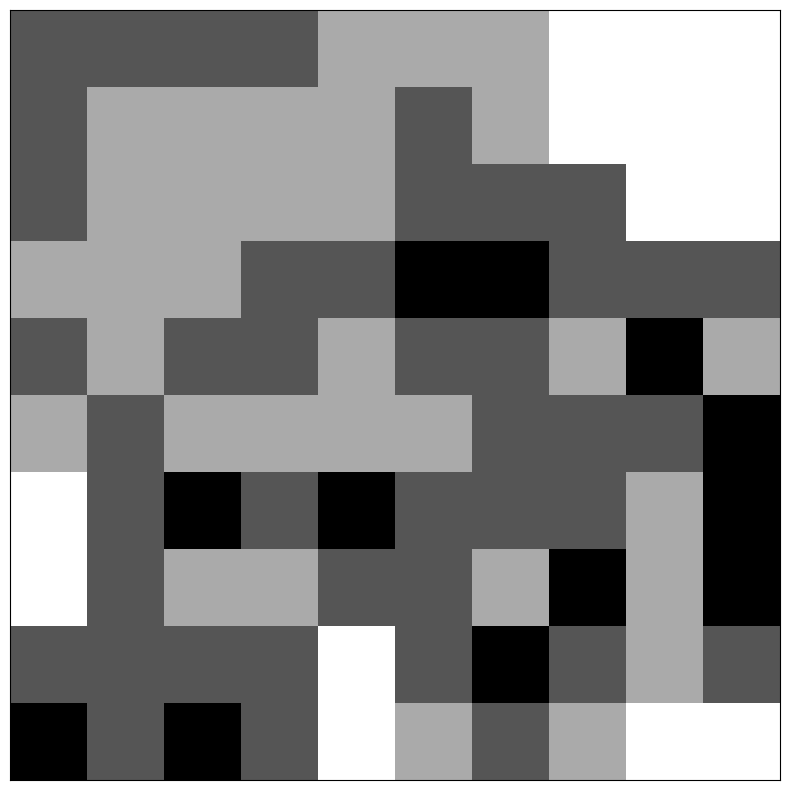

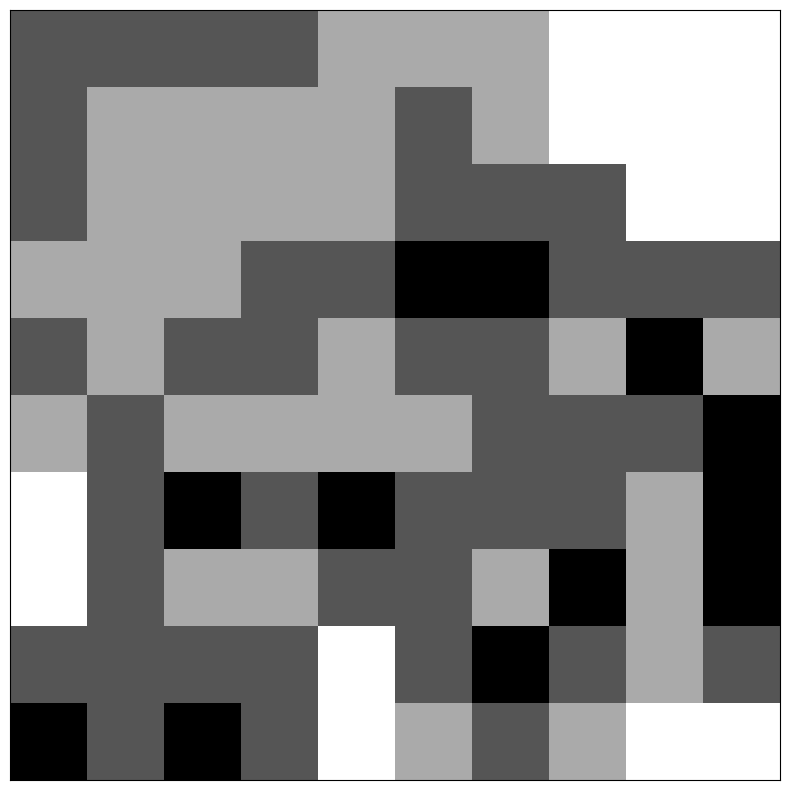

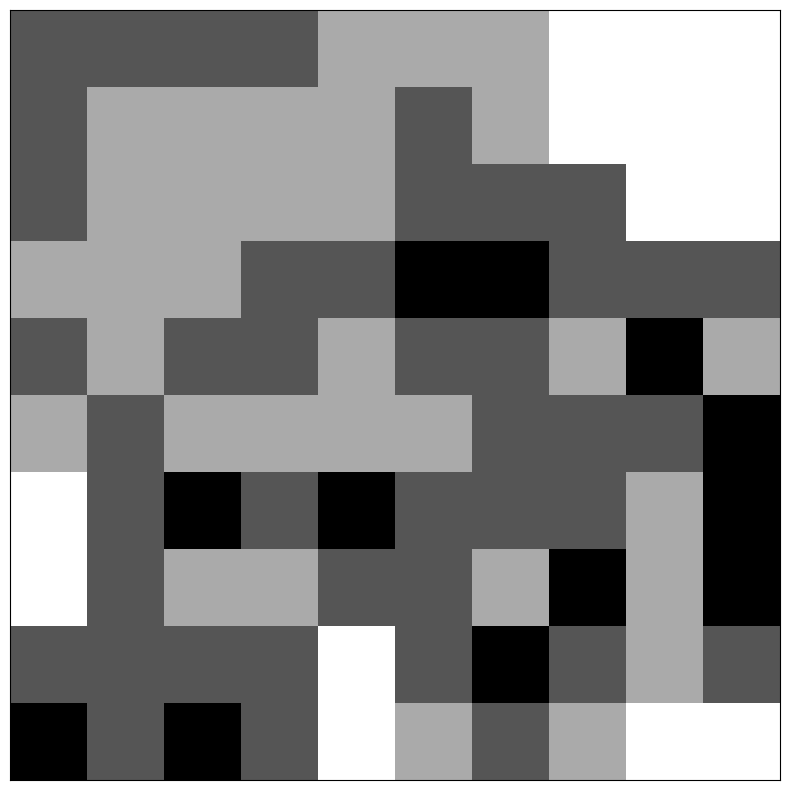

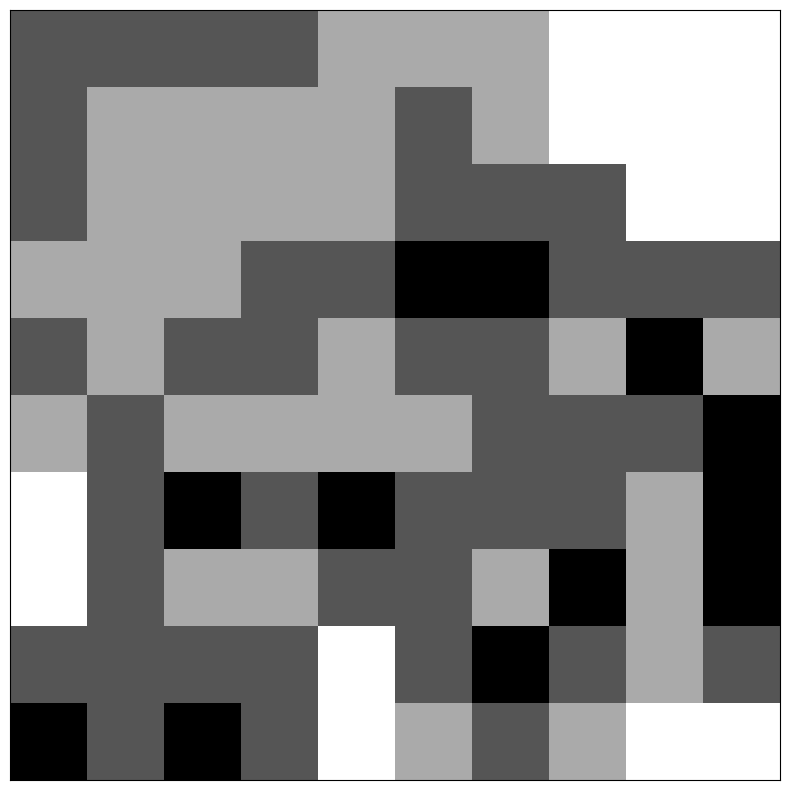

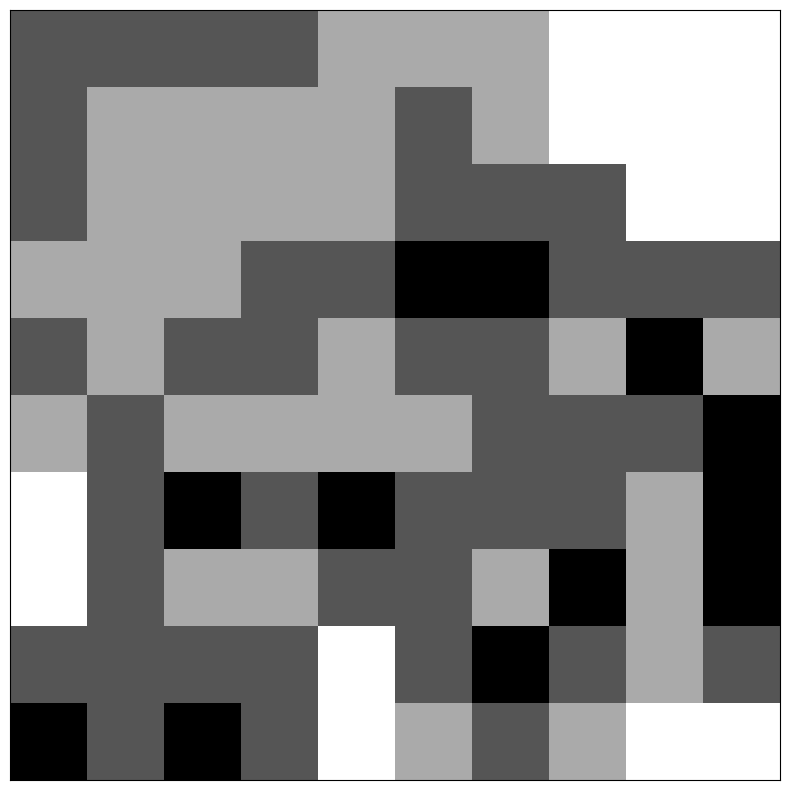

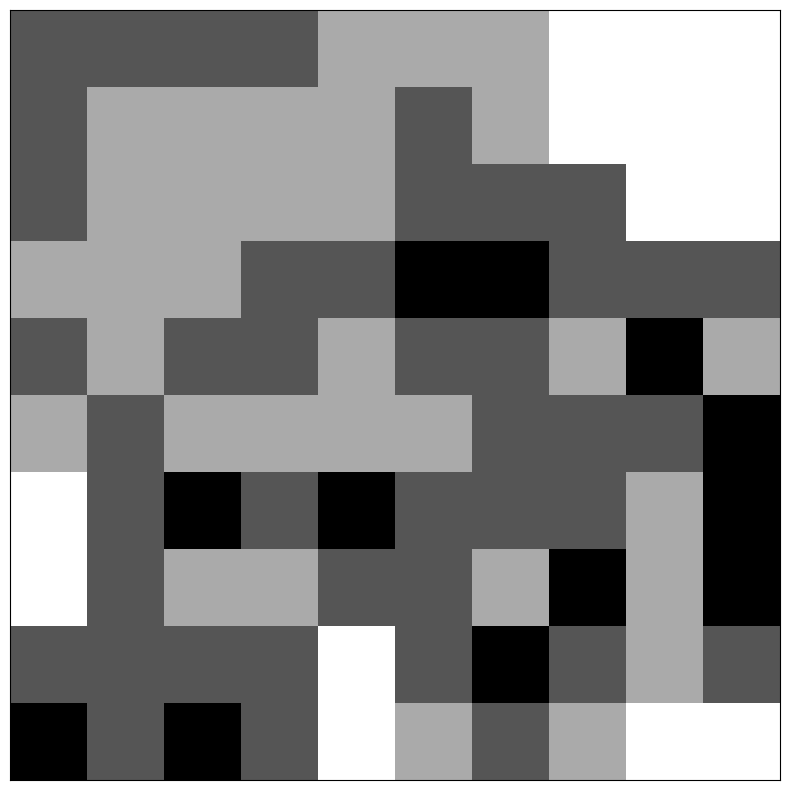

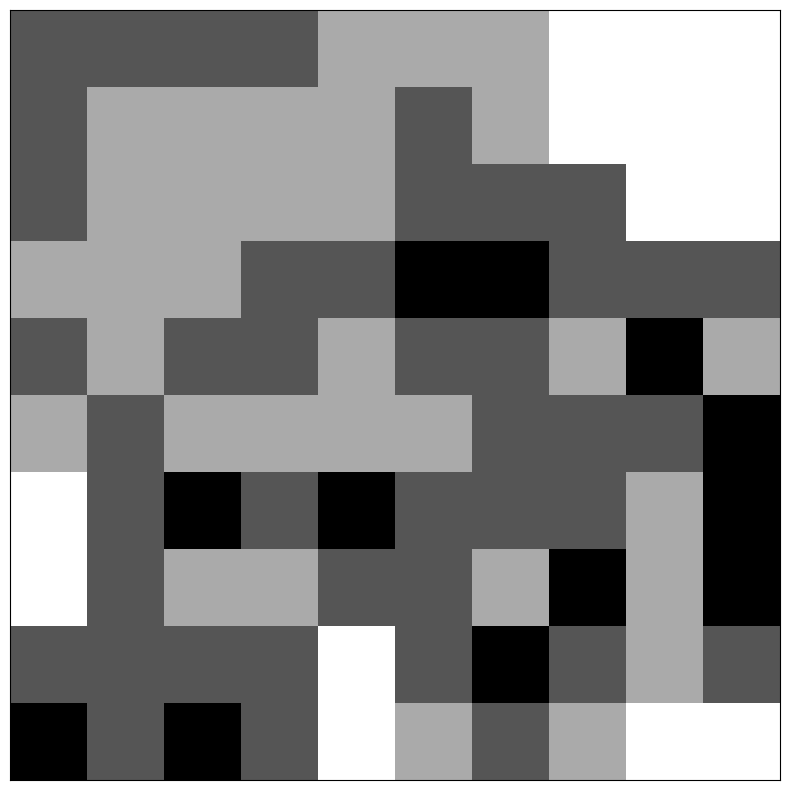

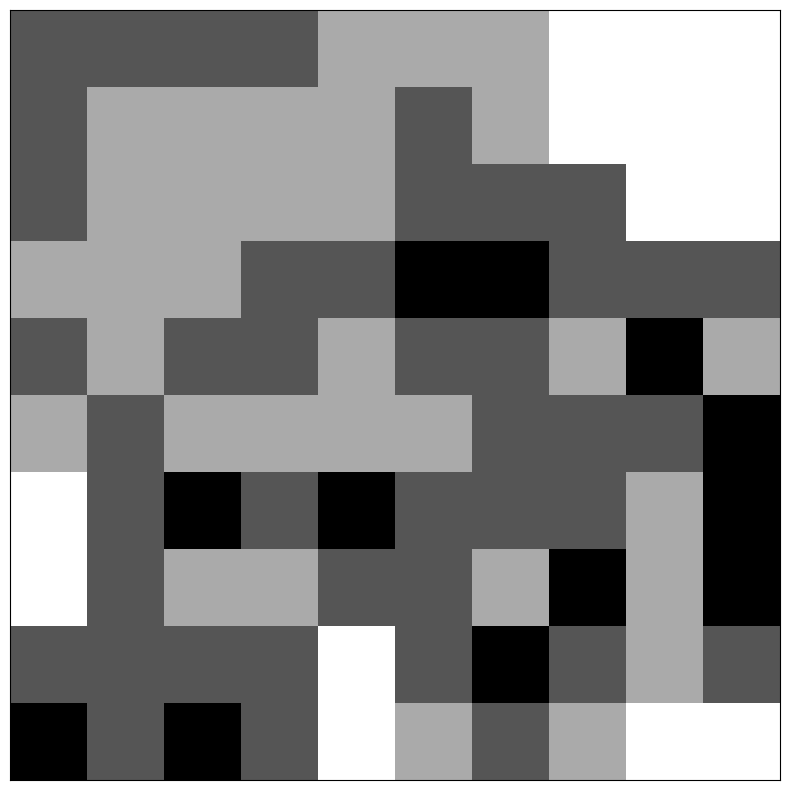

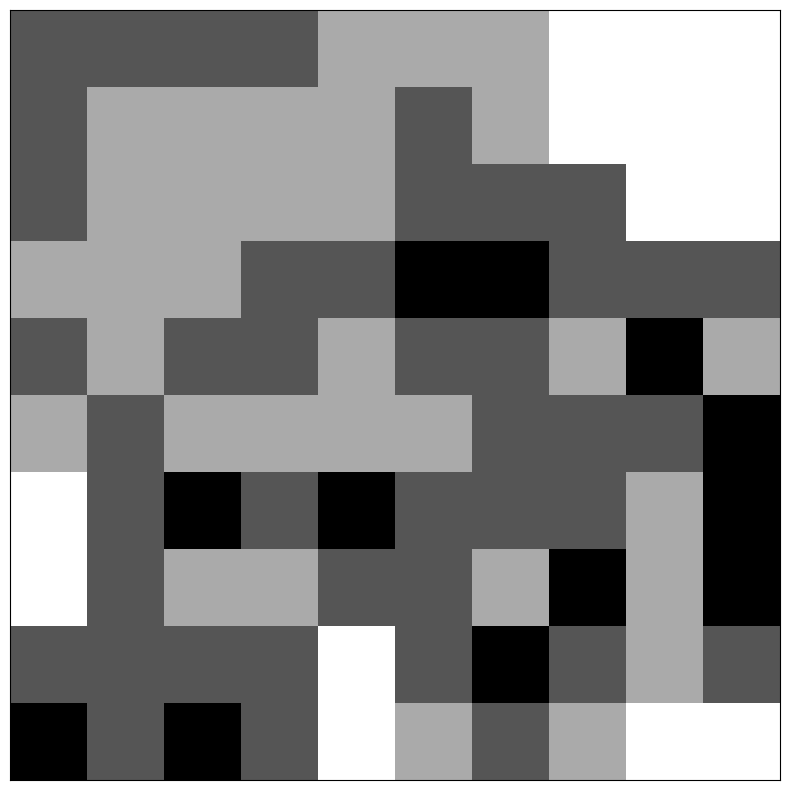

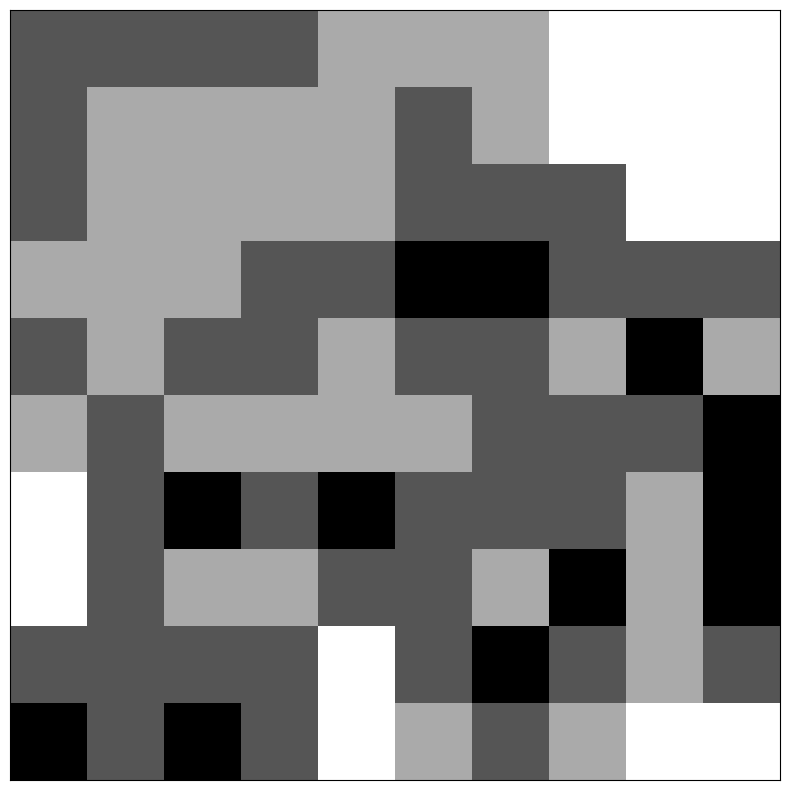

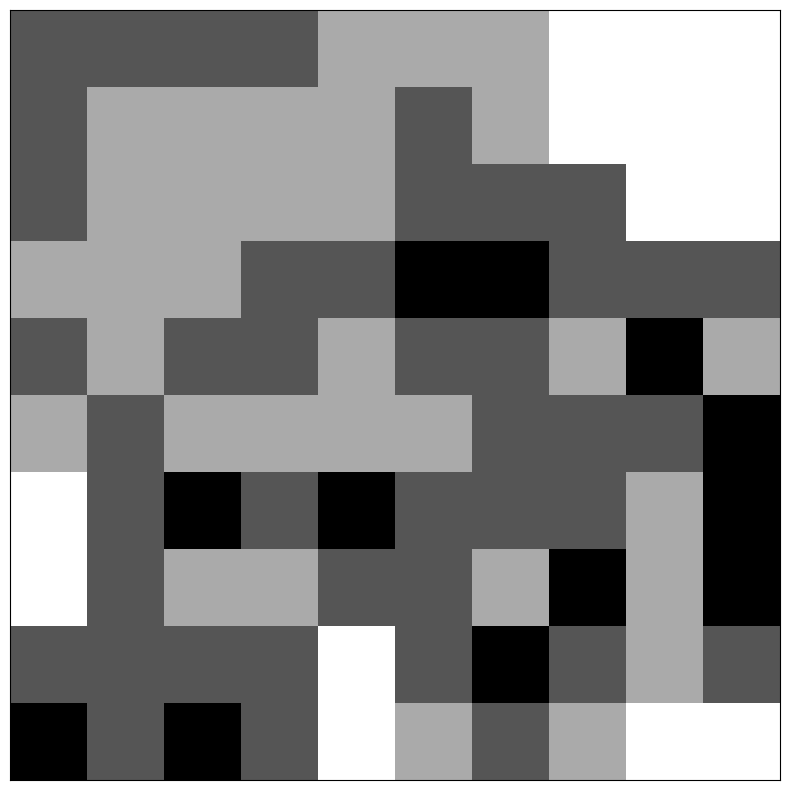

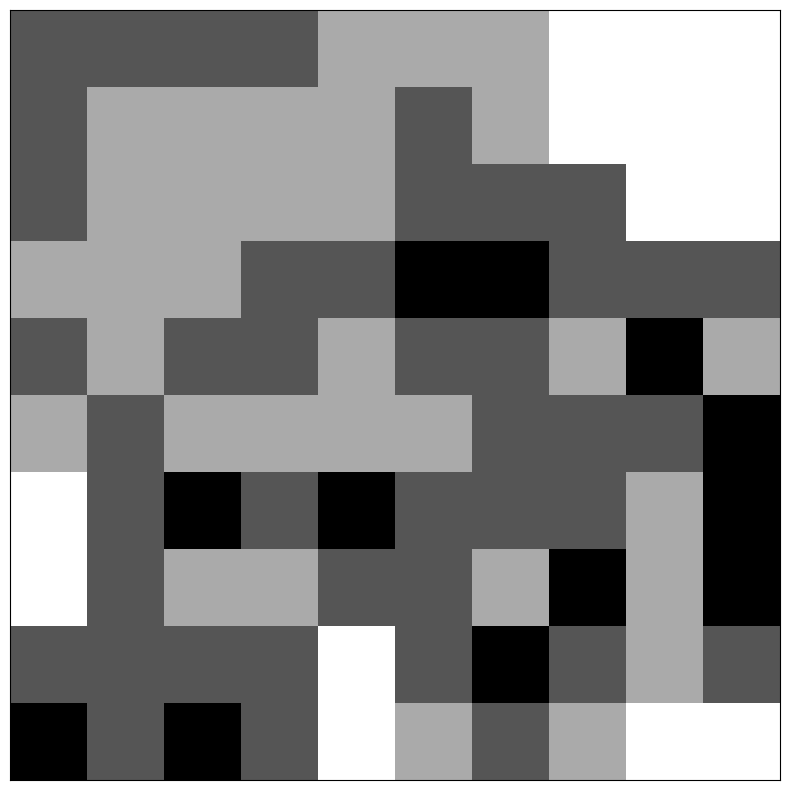

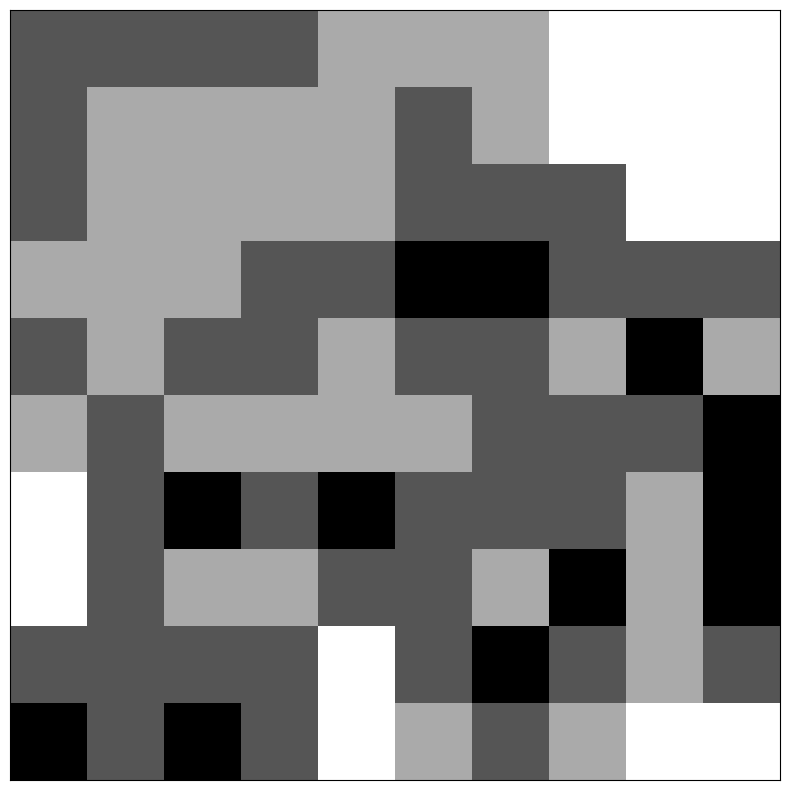

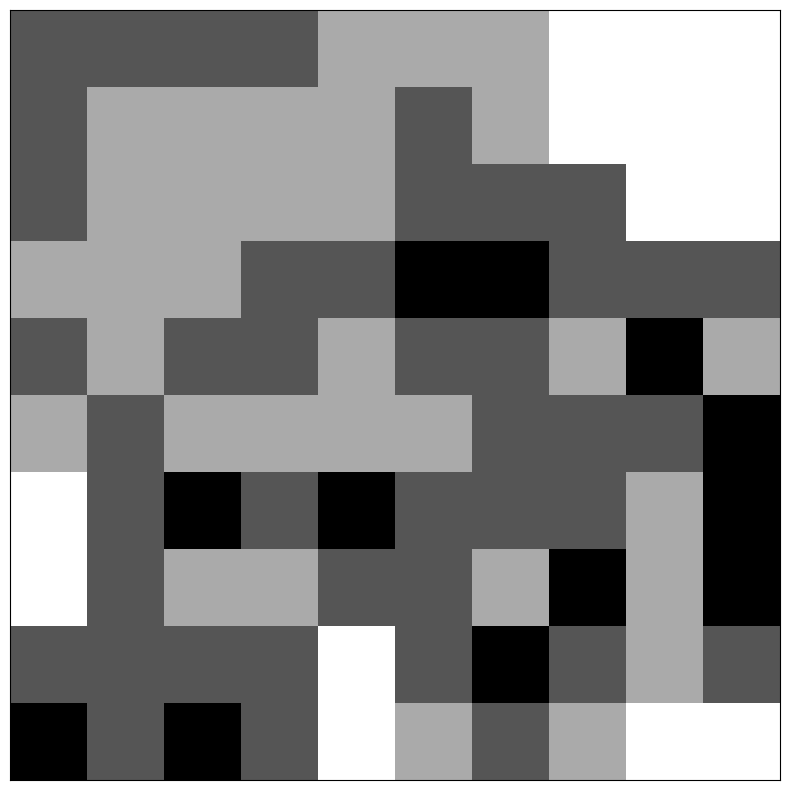

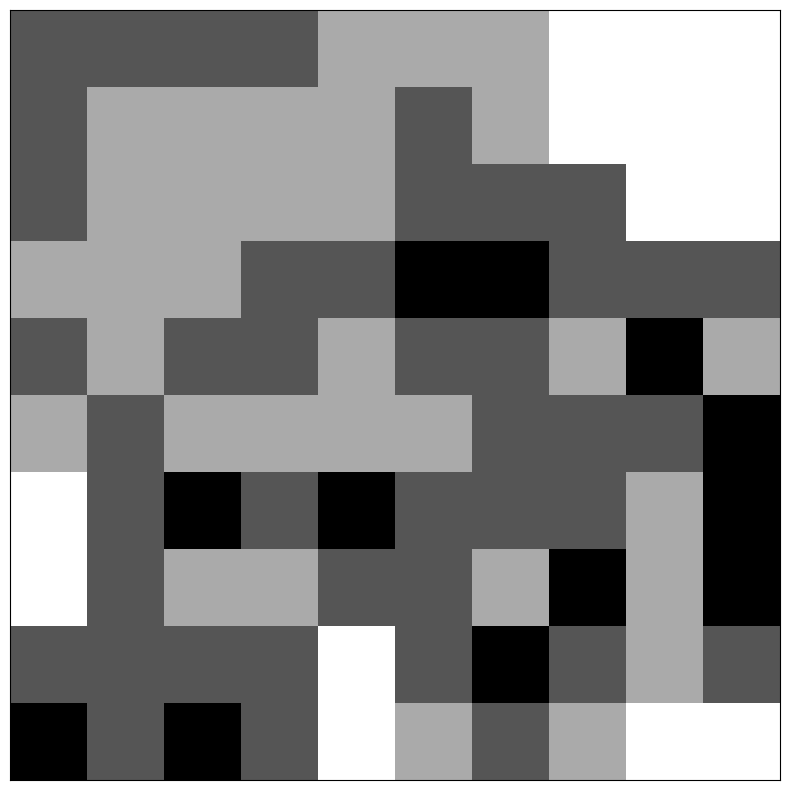

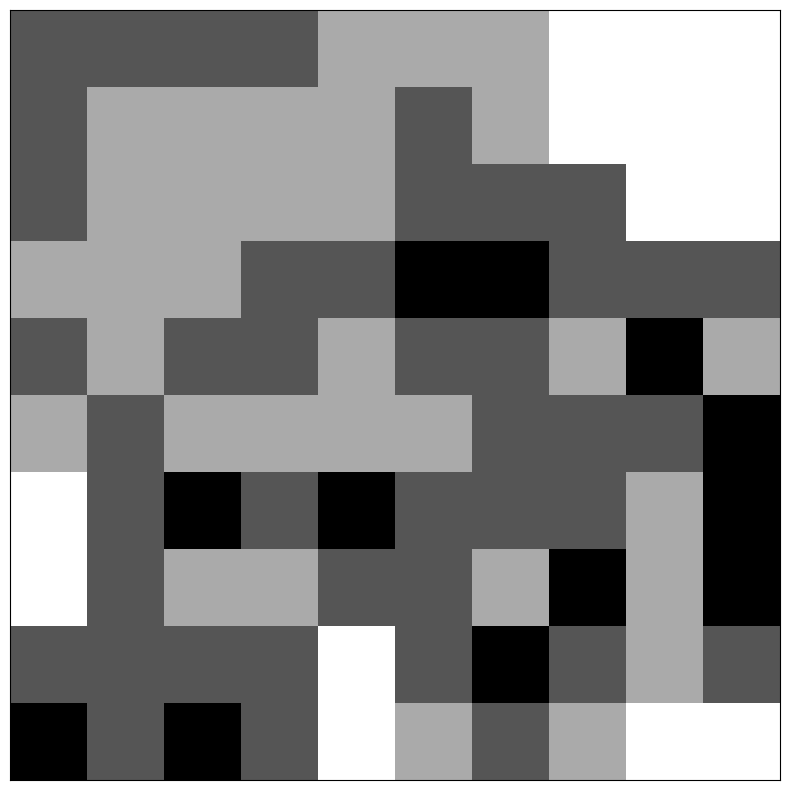

KeyboardInterrupt: ignored

In [ ]:
num_agents = 15
num_test = 5

res=test_astar(num_agents, num_test, None, functools.partial(generate_stage, rows=10, cols=10, obs_prob=0.5), debug=True)

Generate test maze:

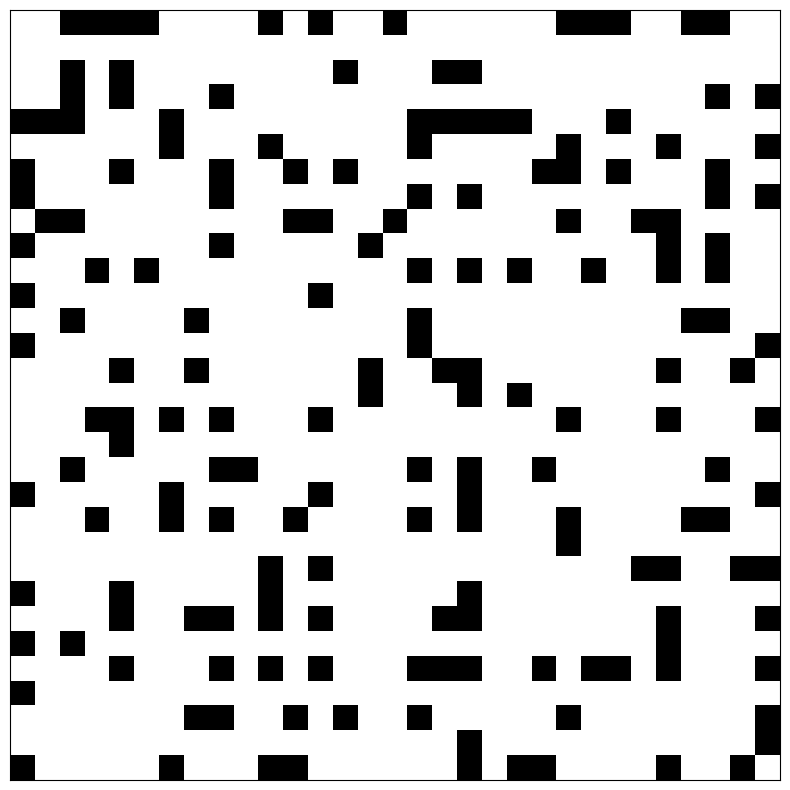

In [ ]:
grid_rows, grid_columns = 30, 30
obs_prob = 0.35
test_maze = create_maze(grid_rows, grid_columns, obs_prob)
draw_maze(test_maze)

Solve the test_maze with 20 agents:

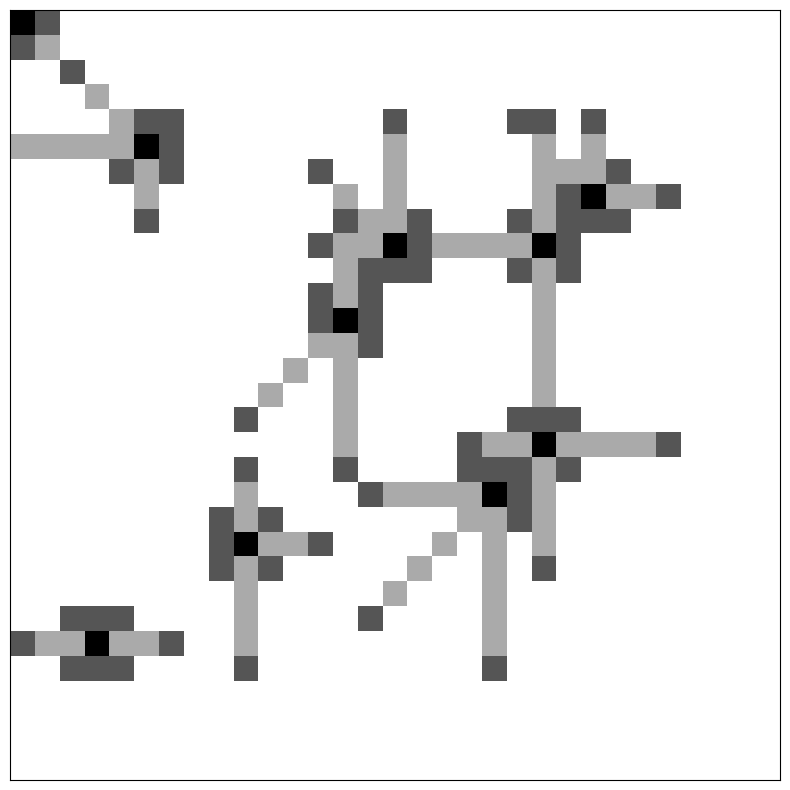

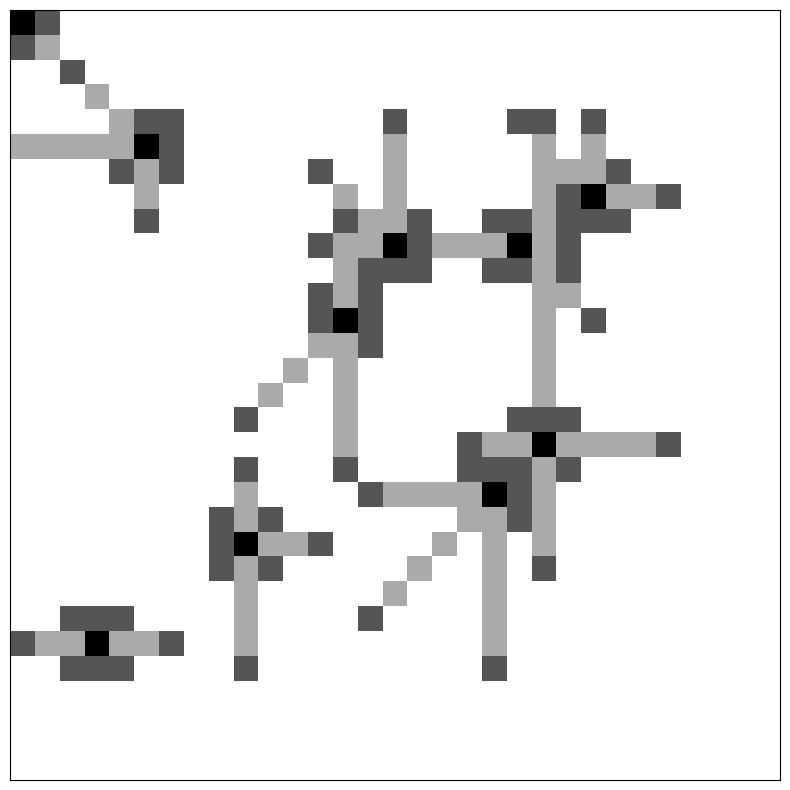

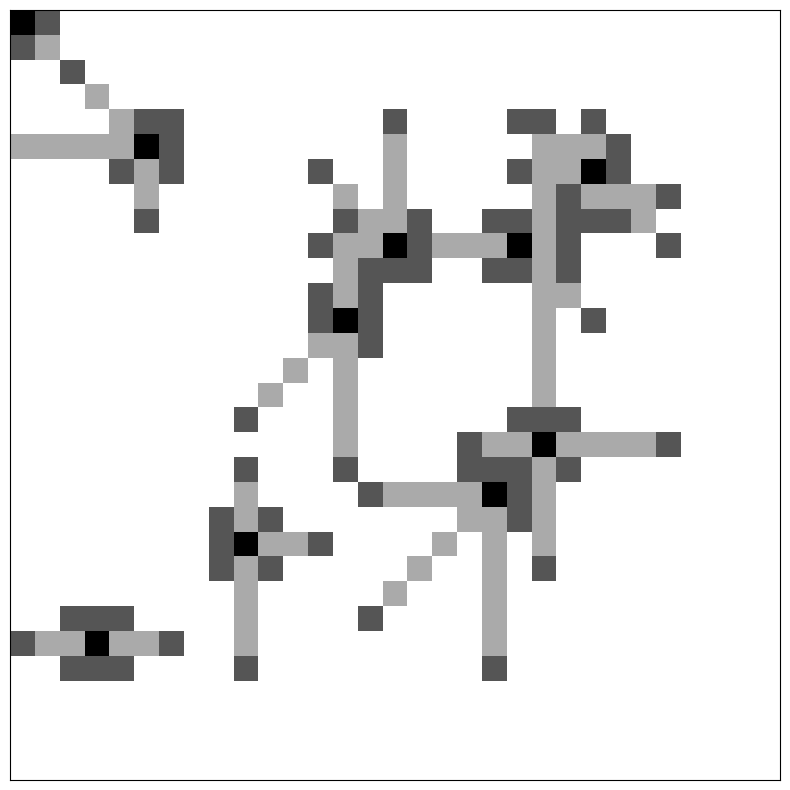

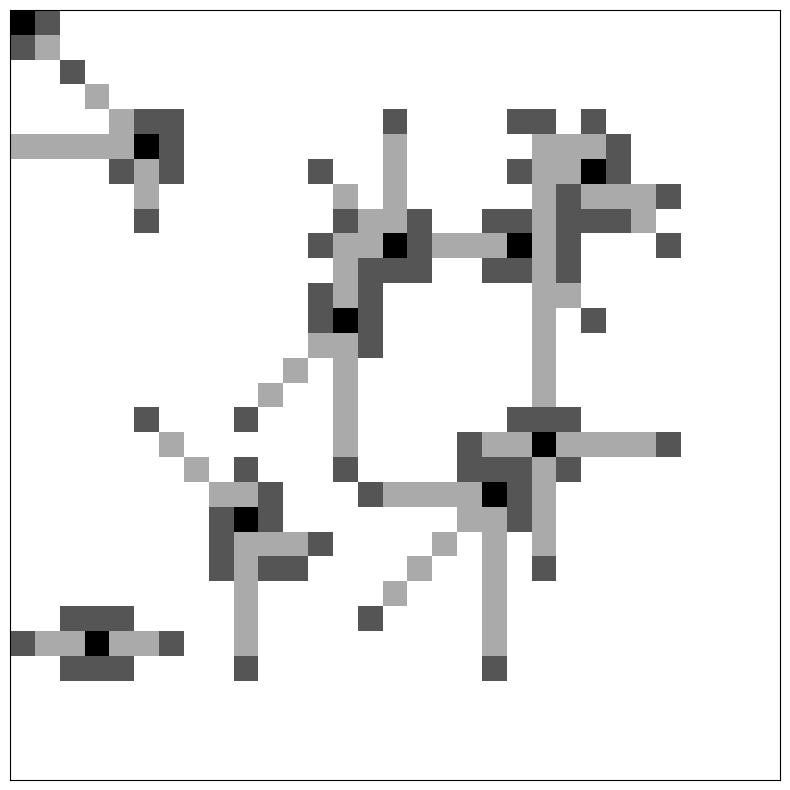

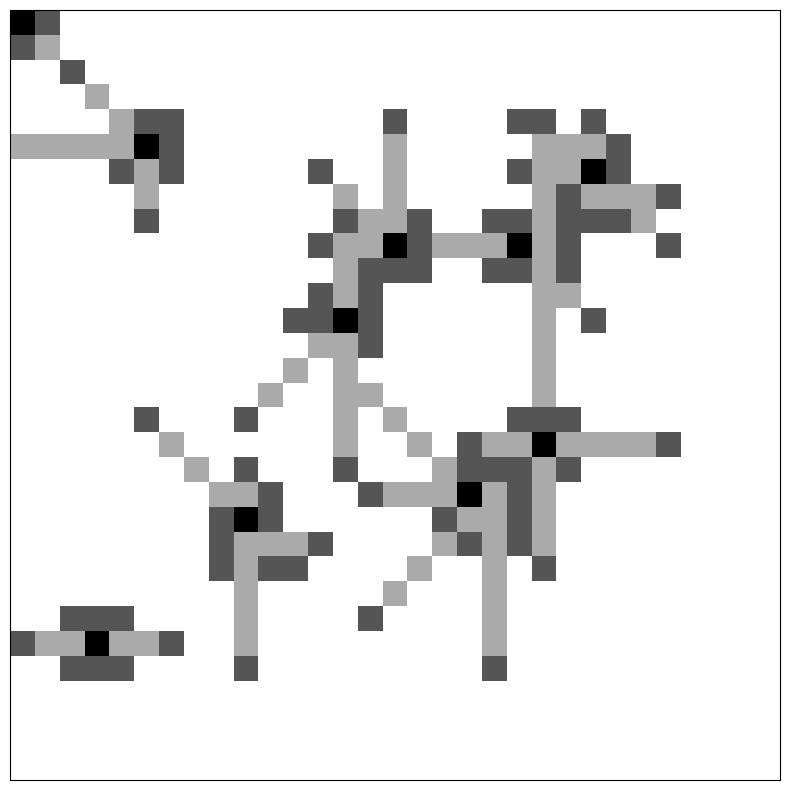

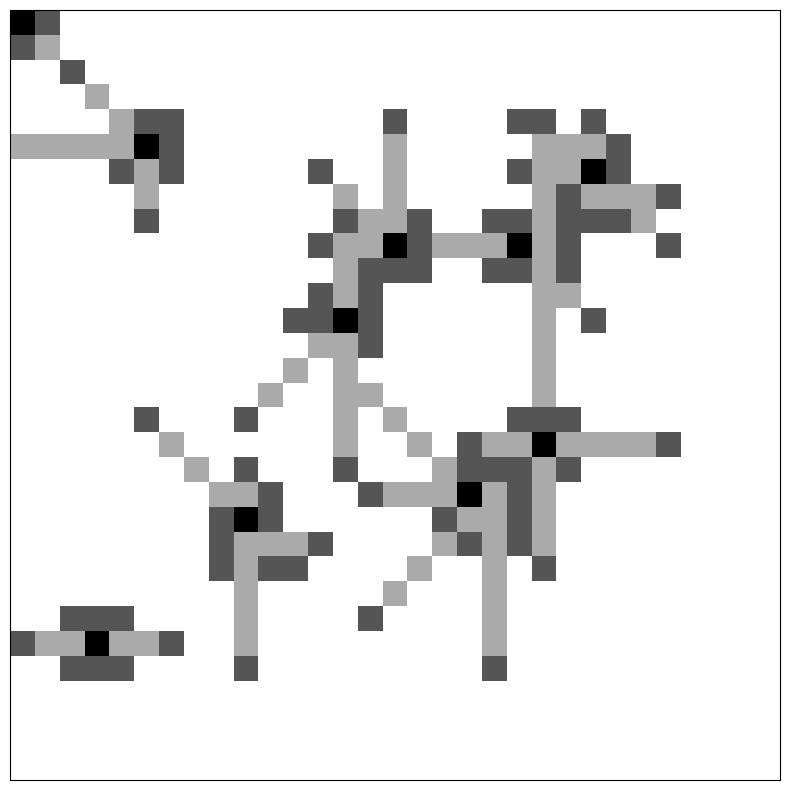

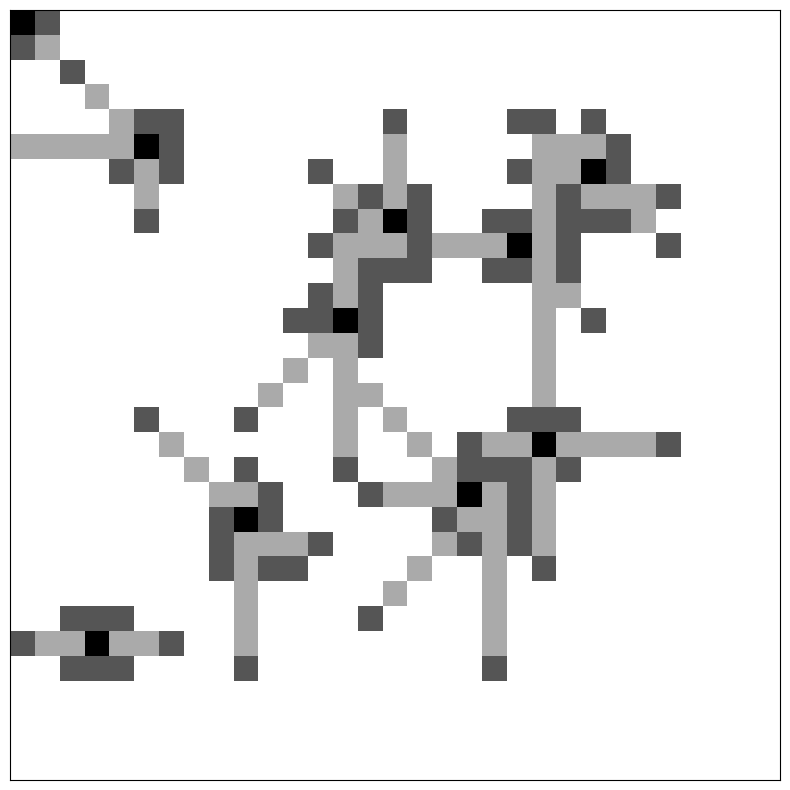

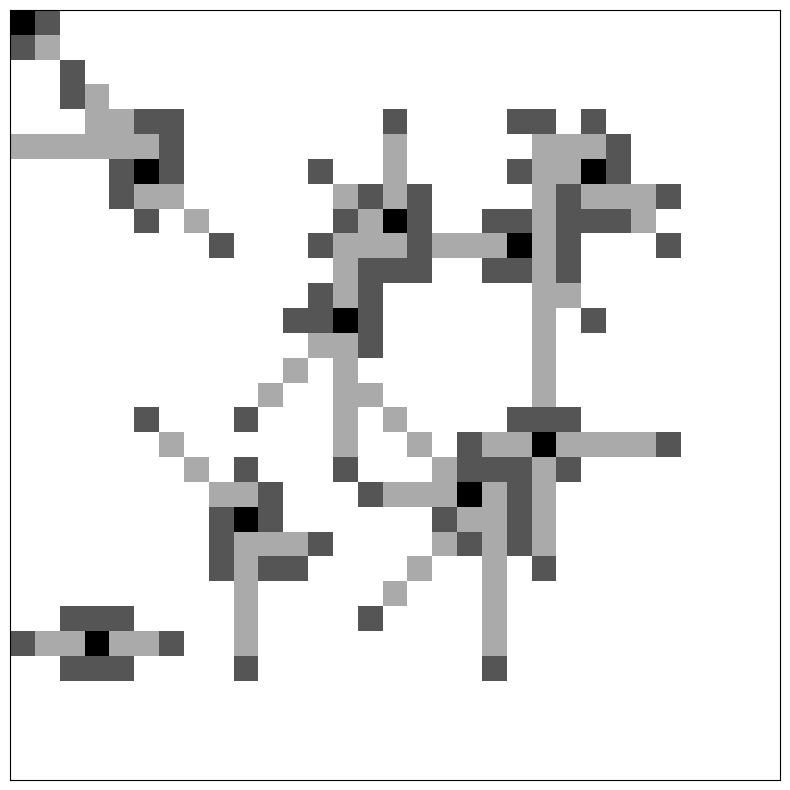

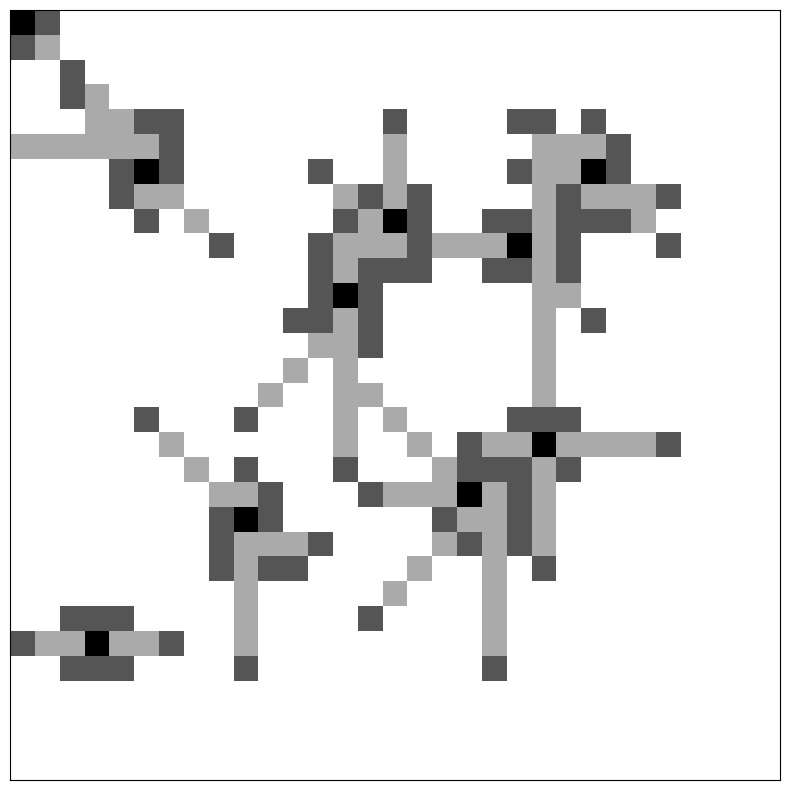

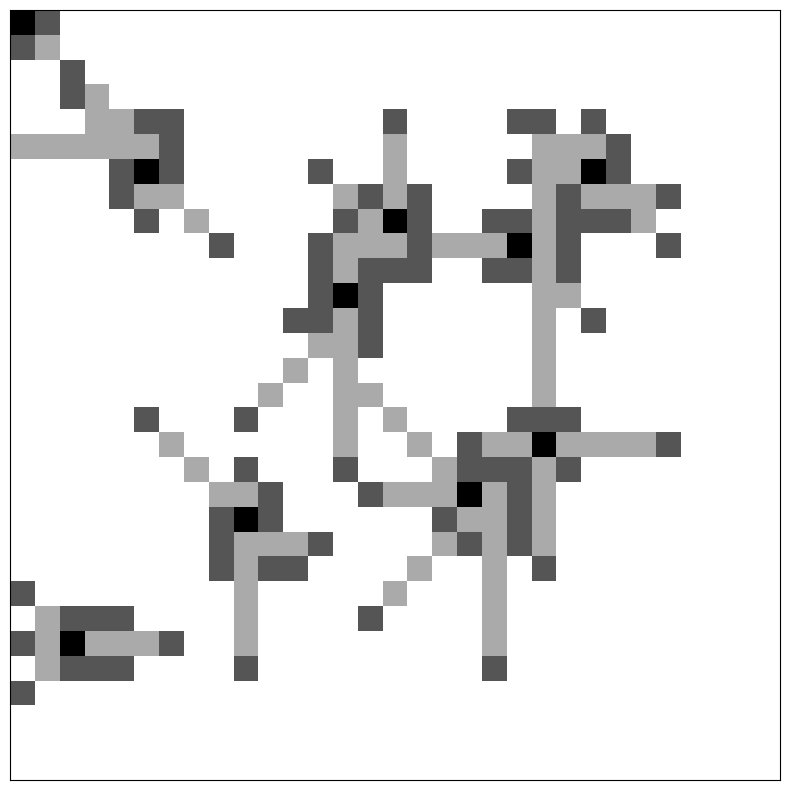

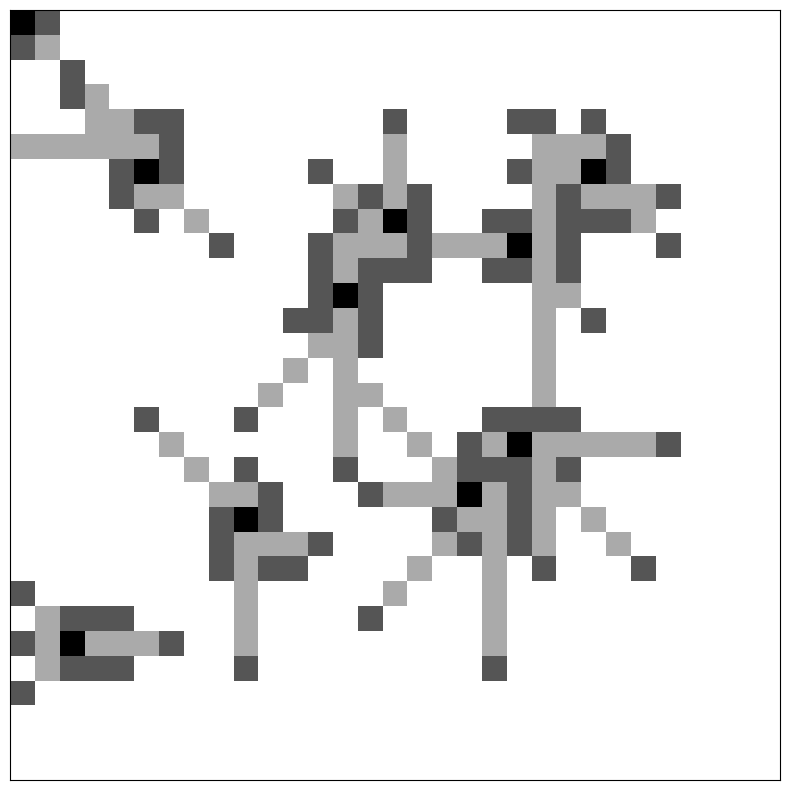

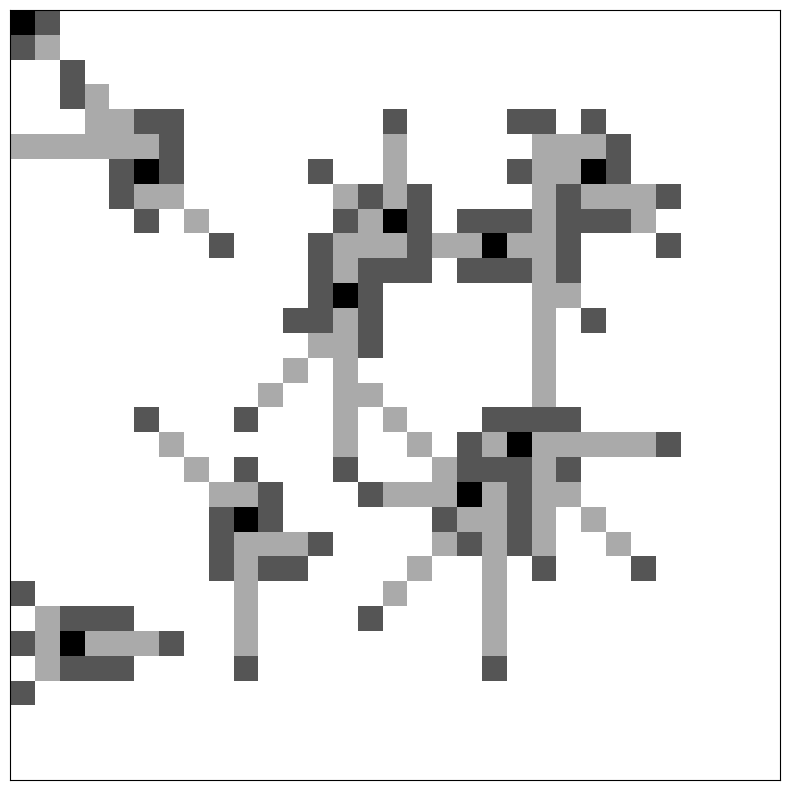

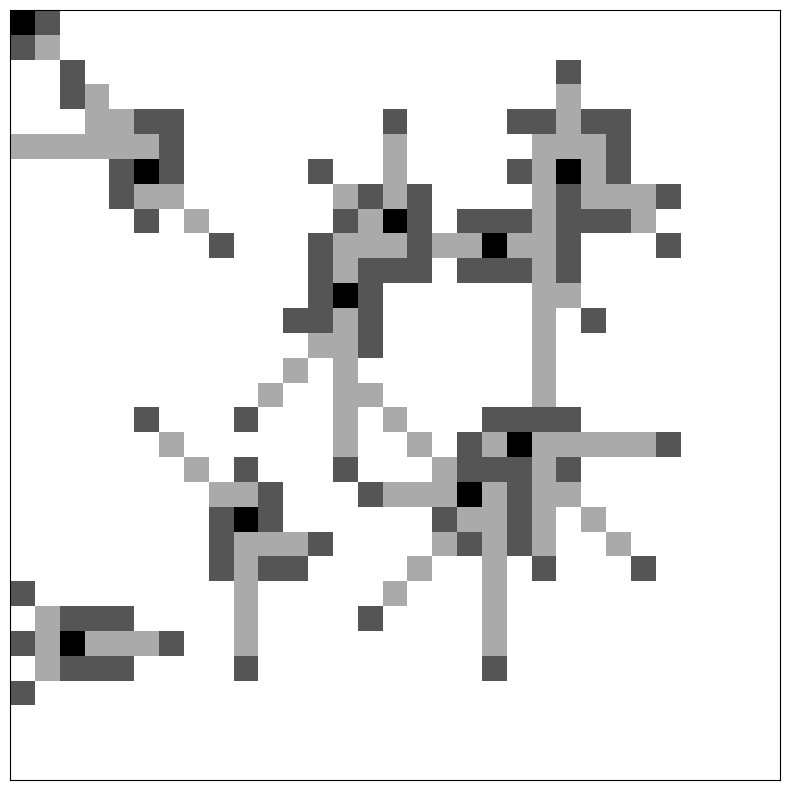

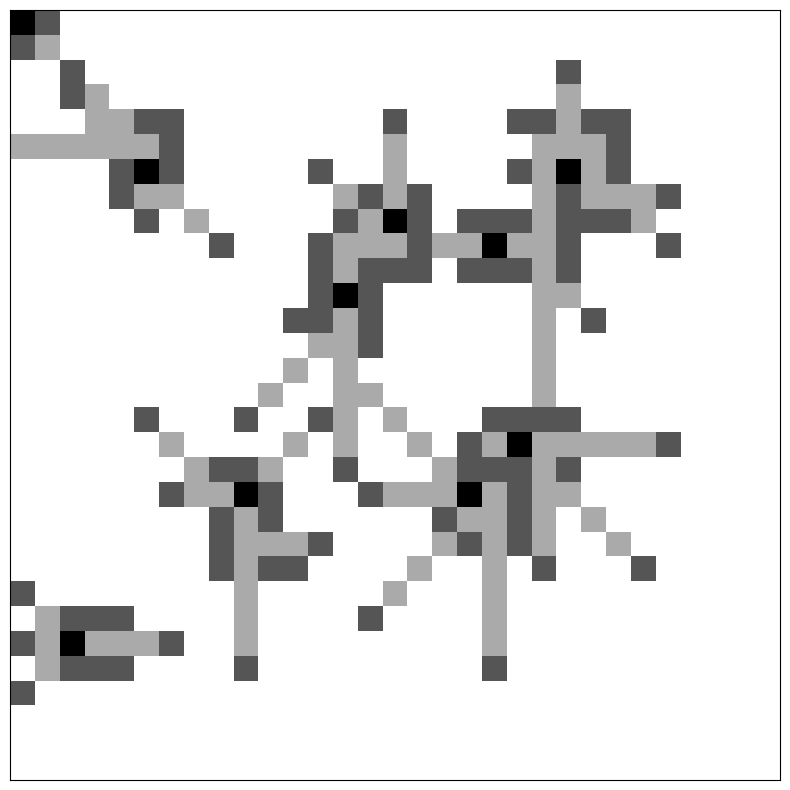

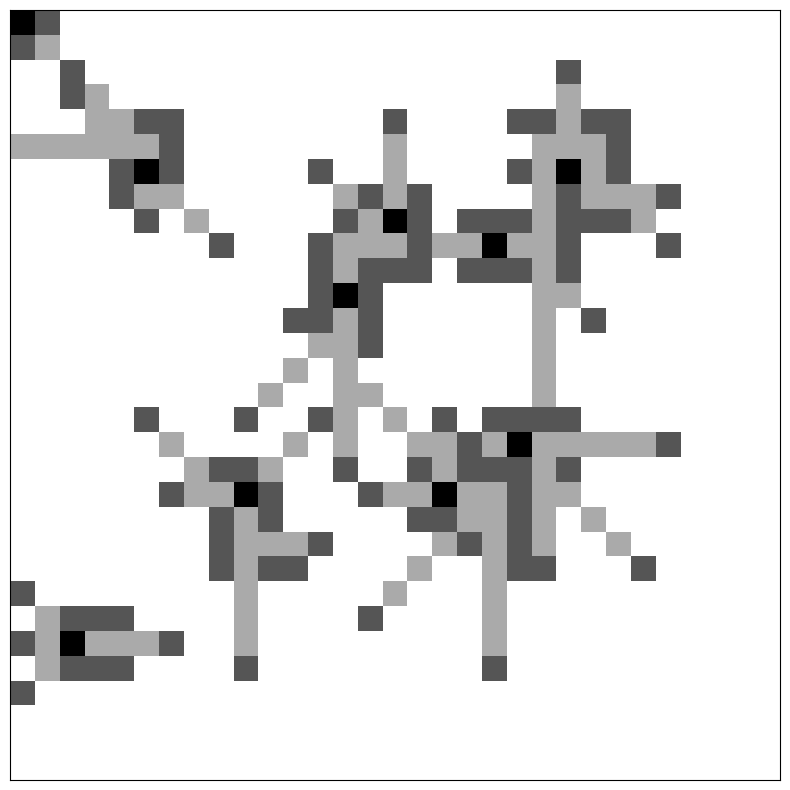

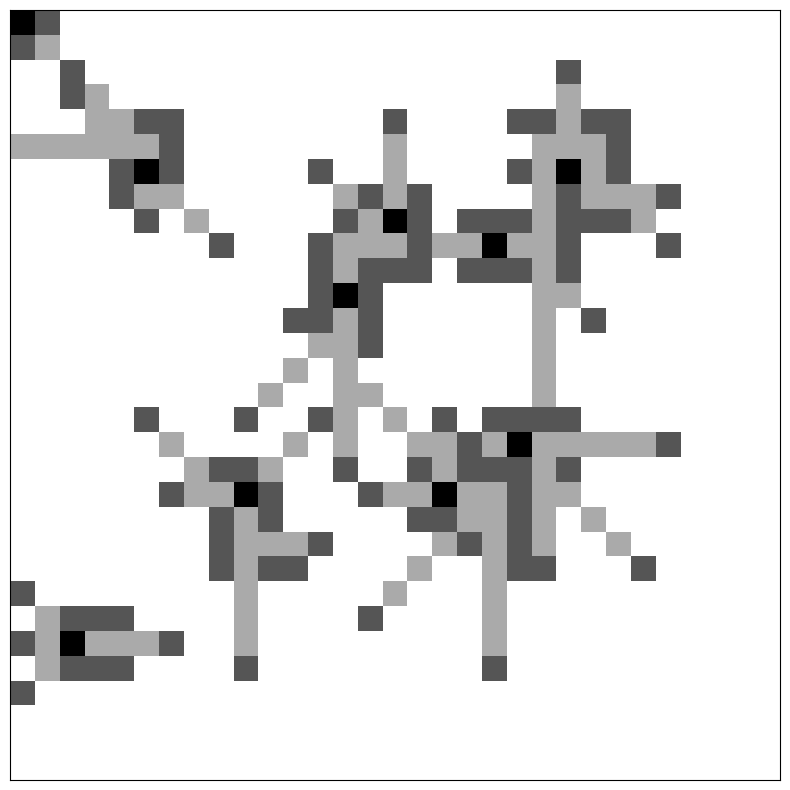

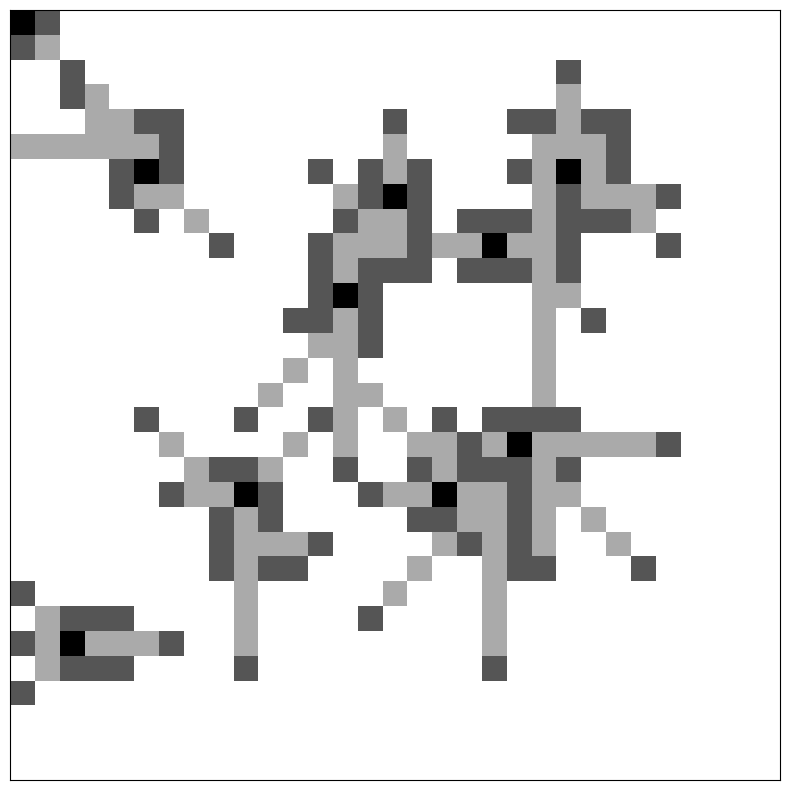

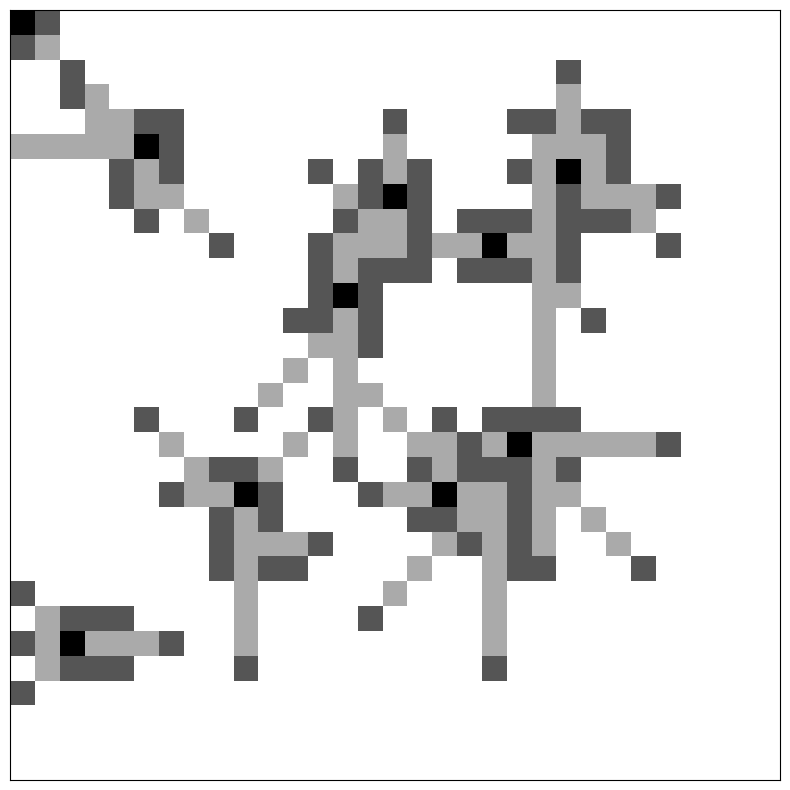

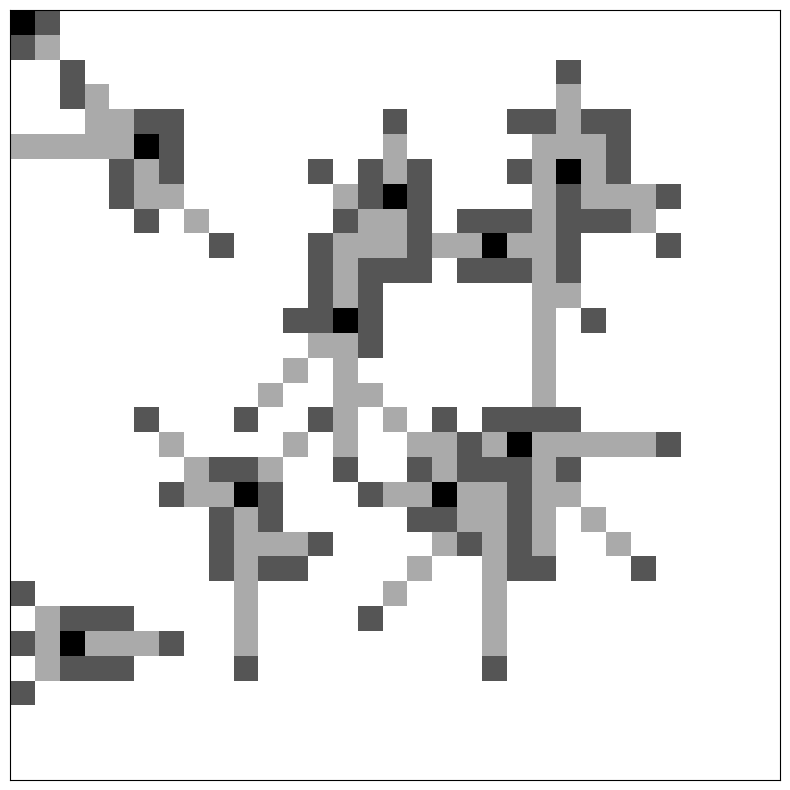

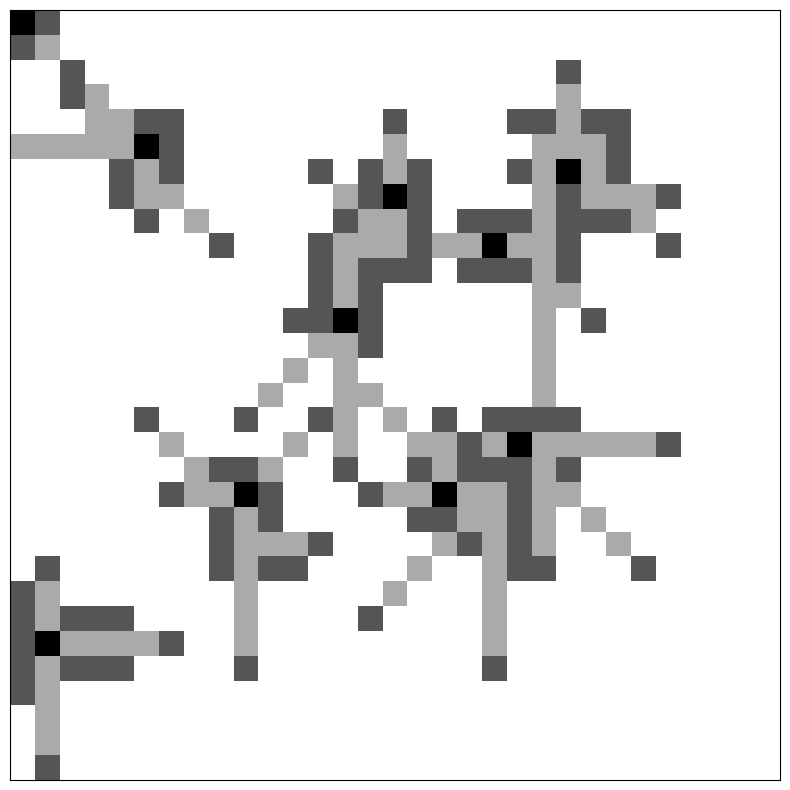

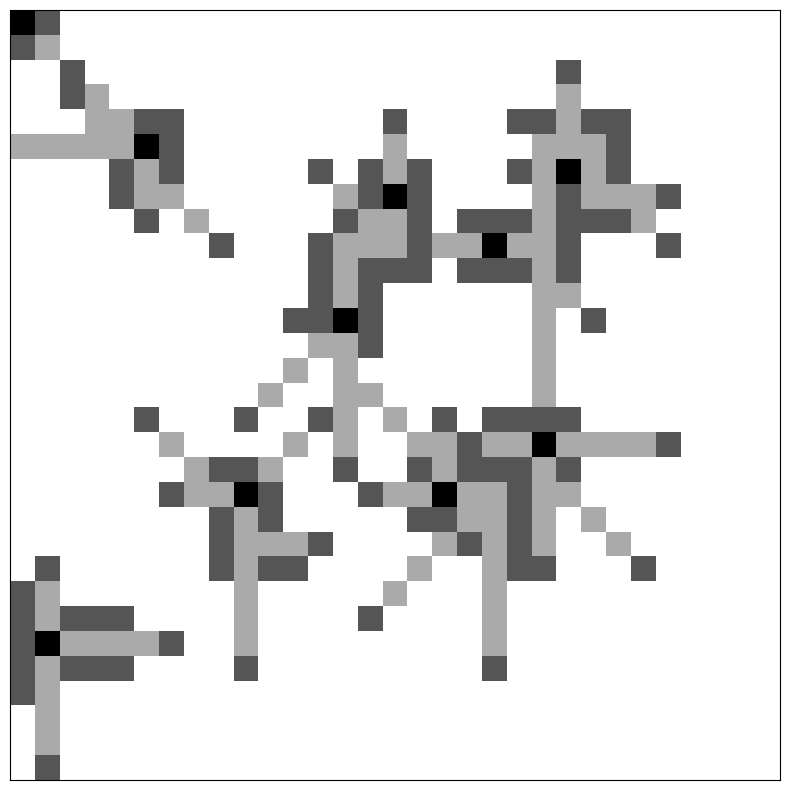

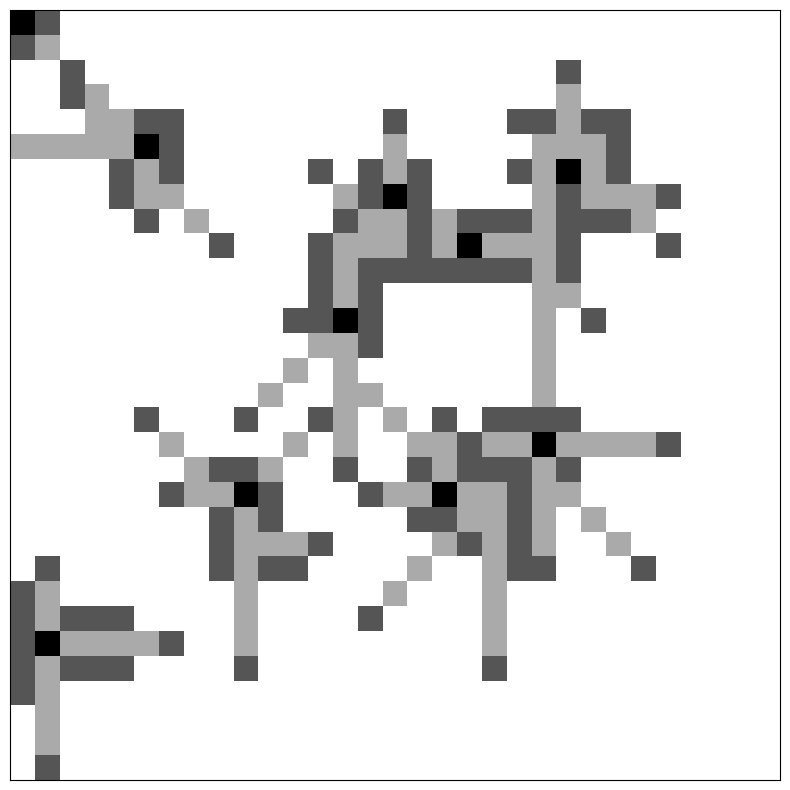

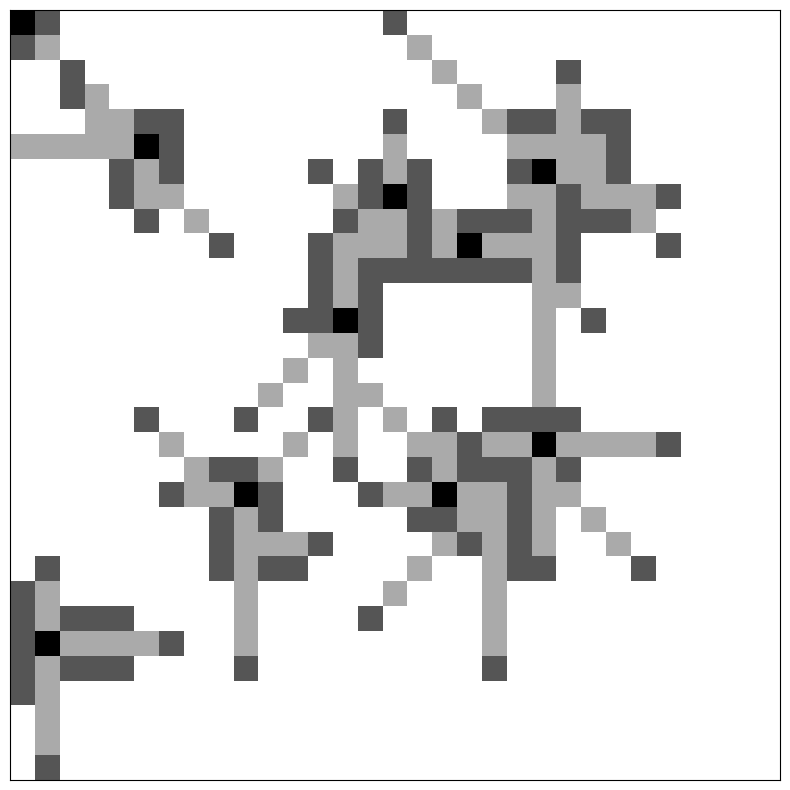

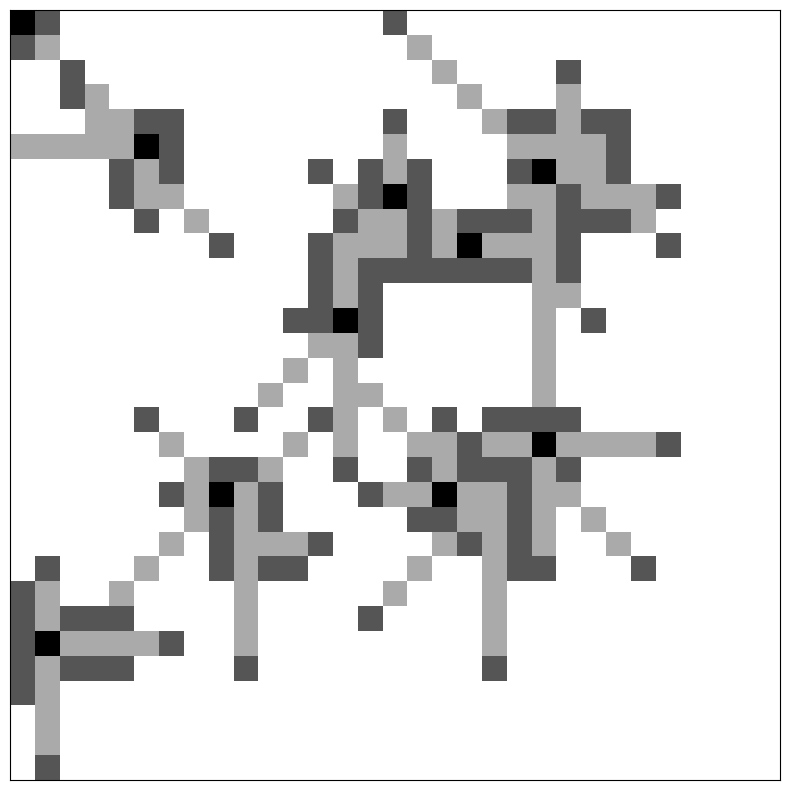

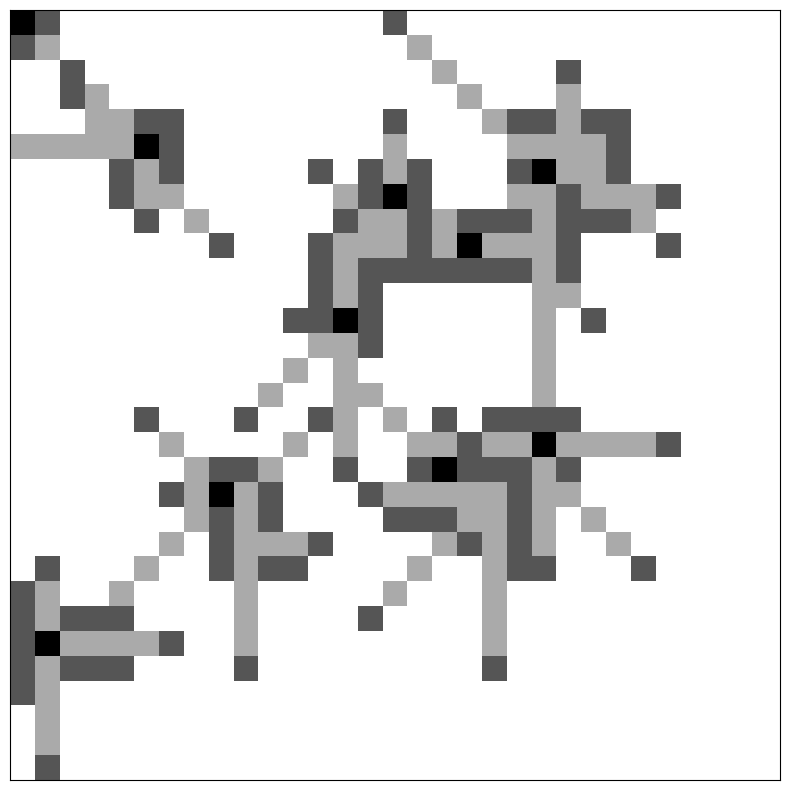

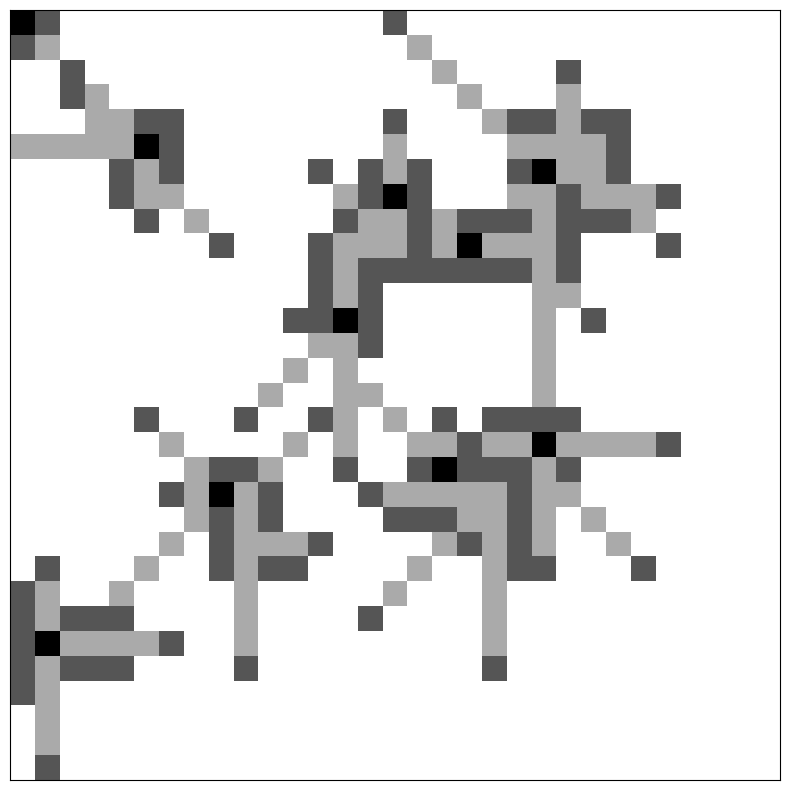

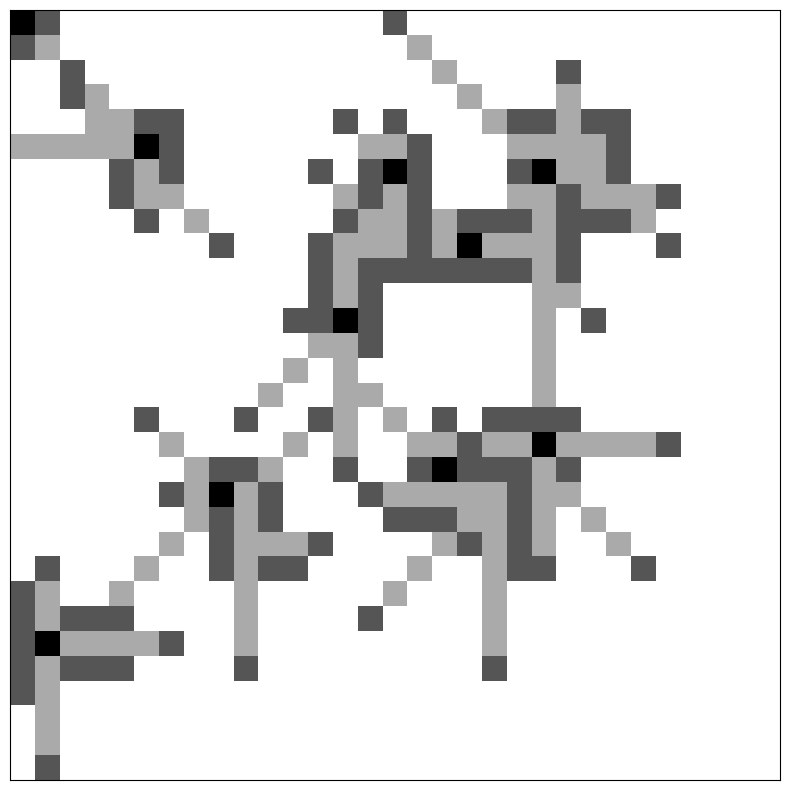

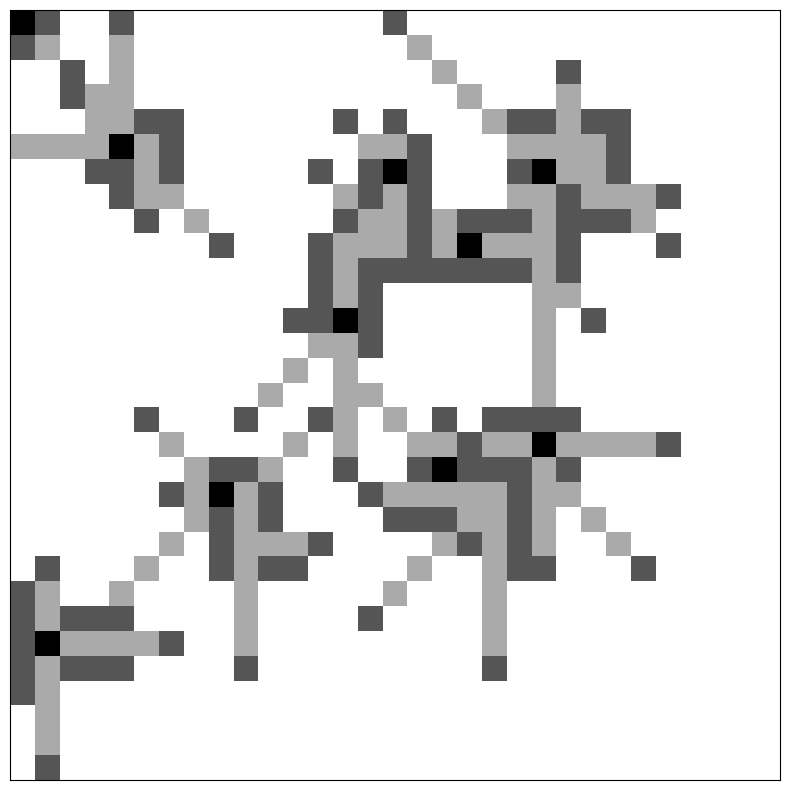

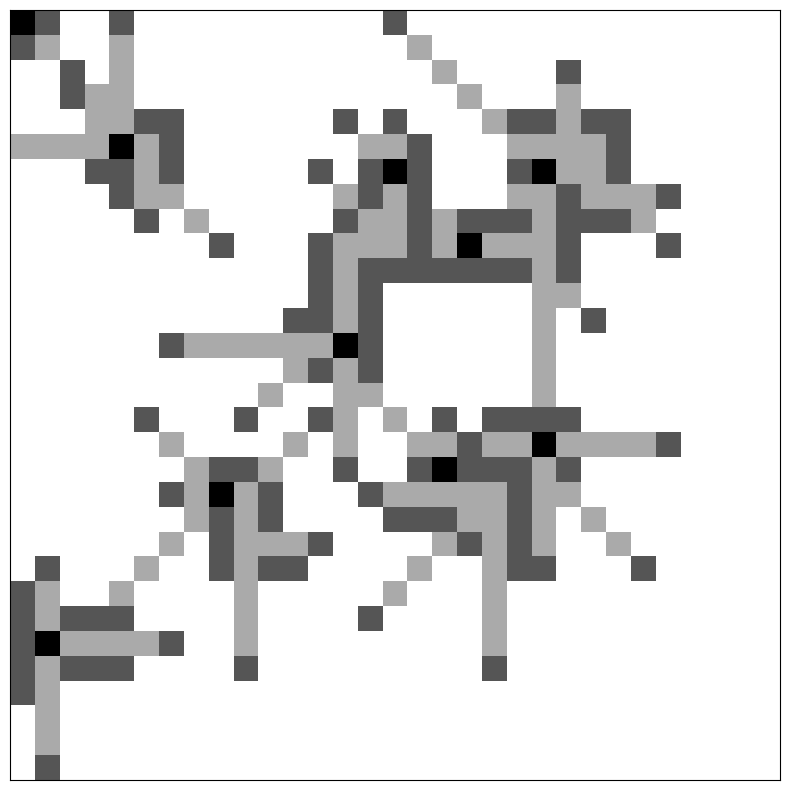

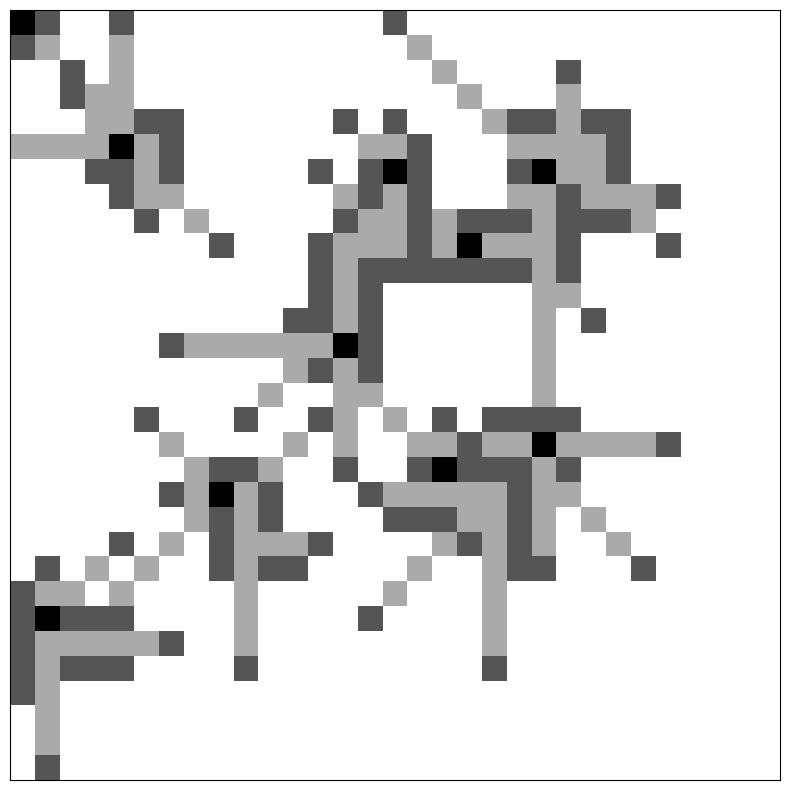

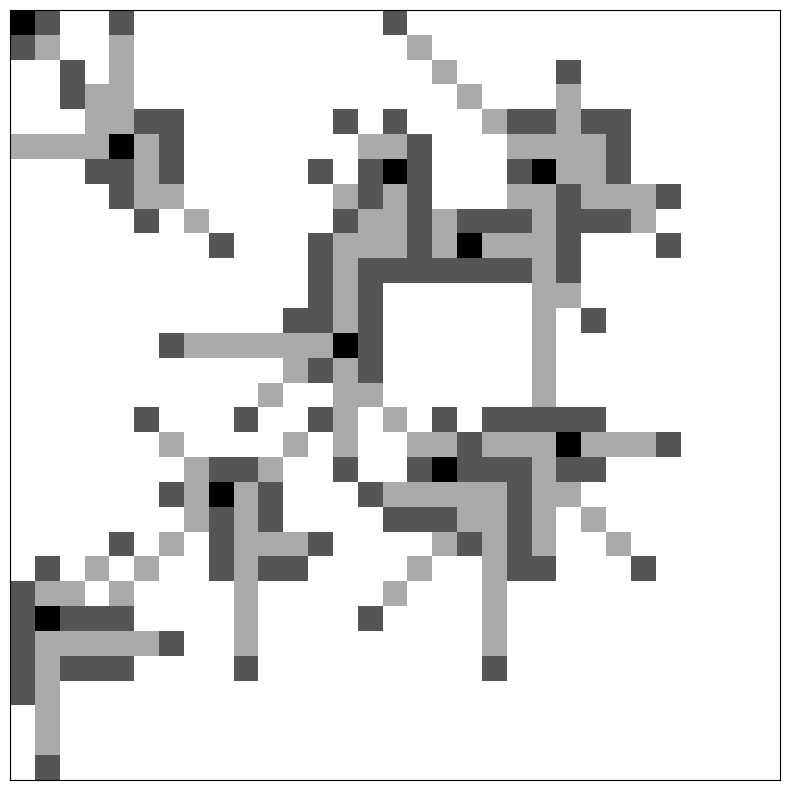

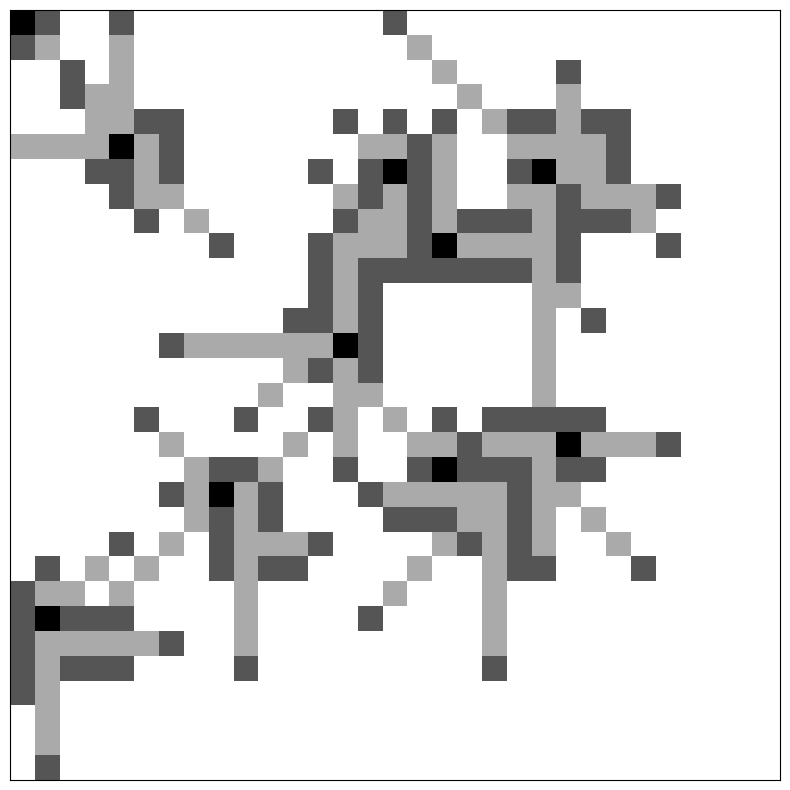

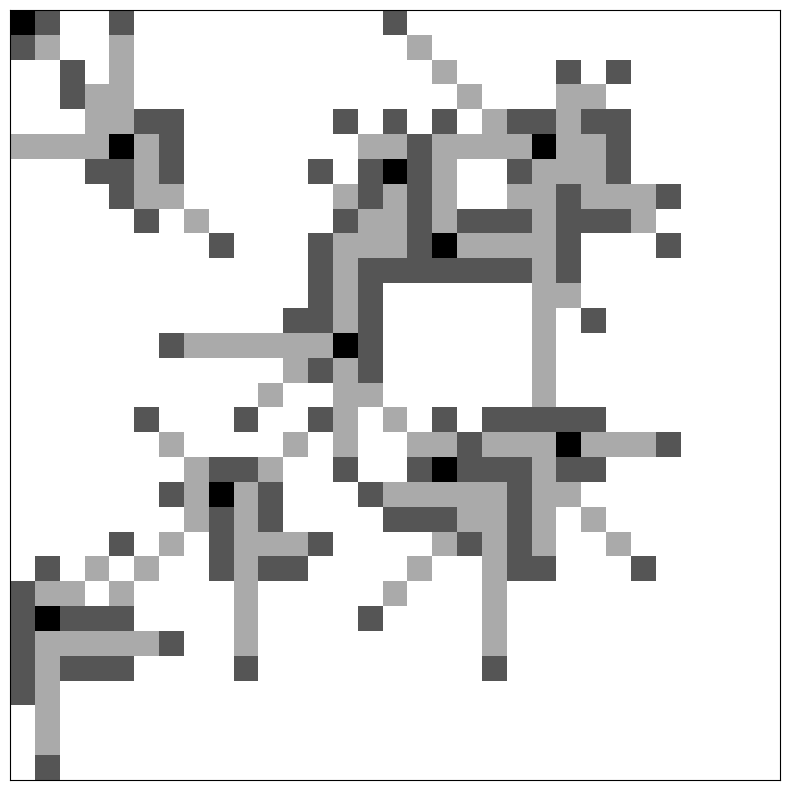

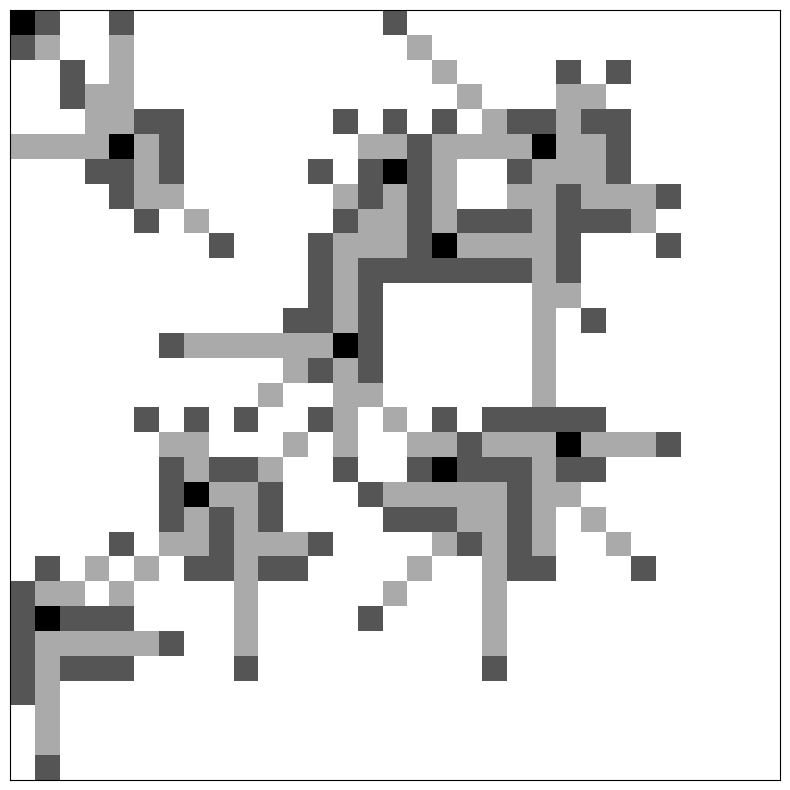

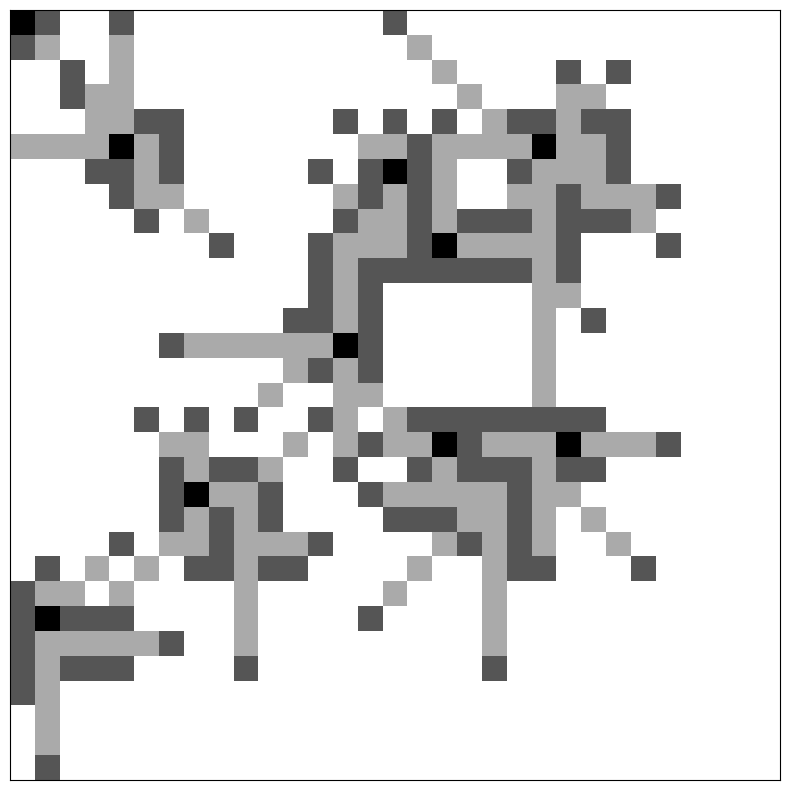

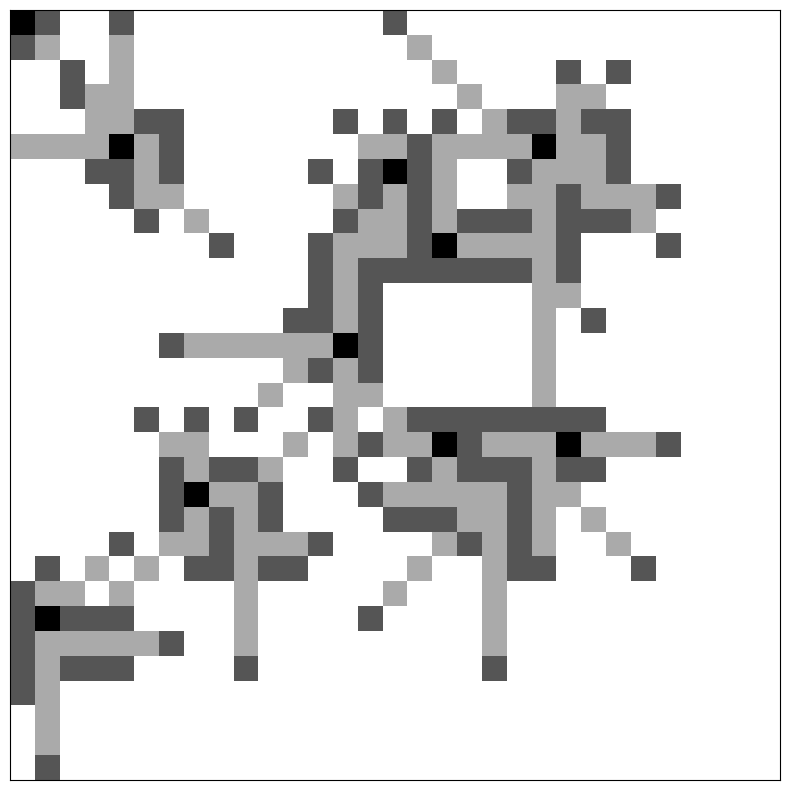

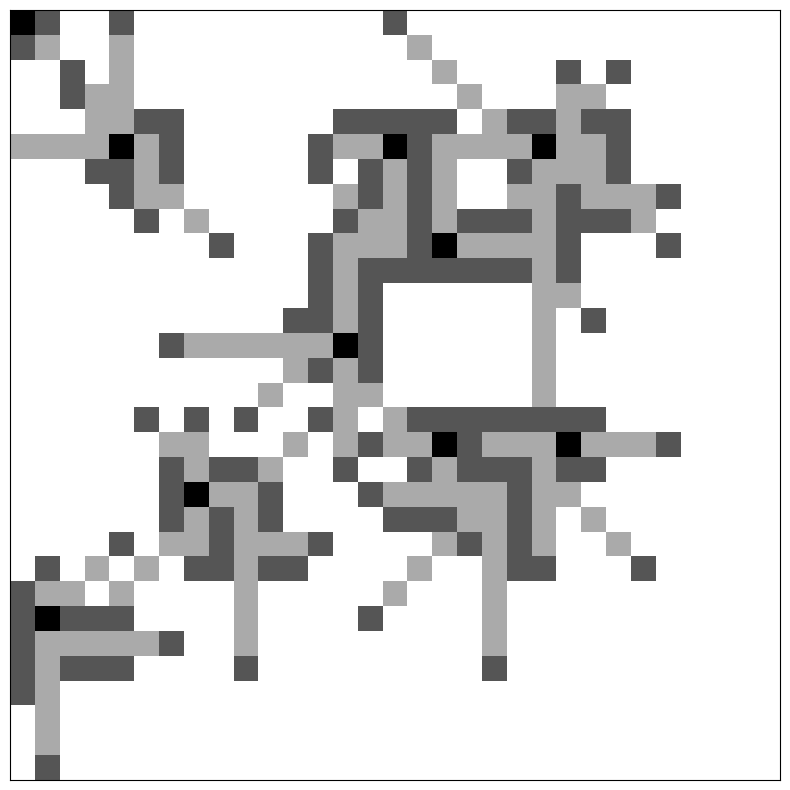

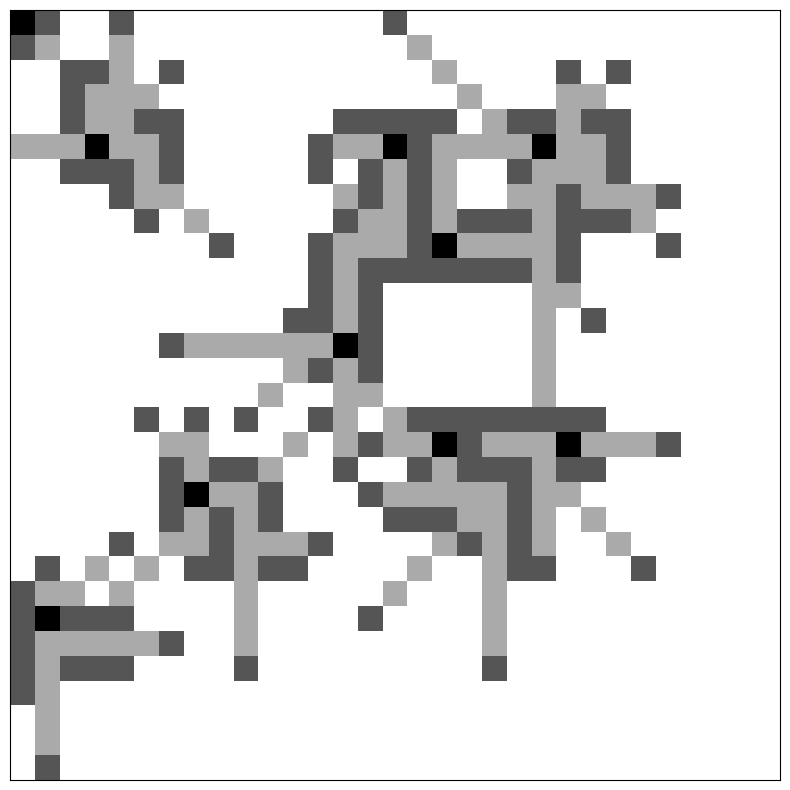

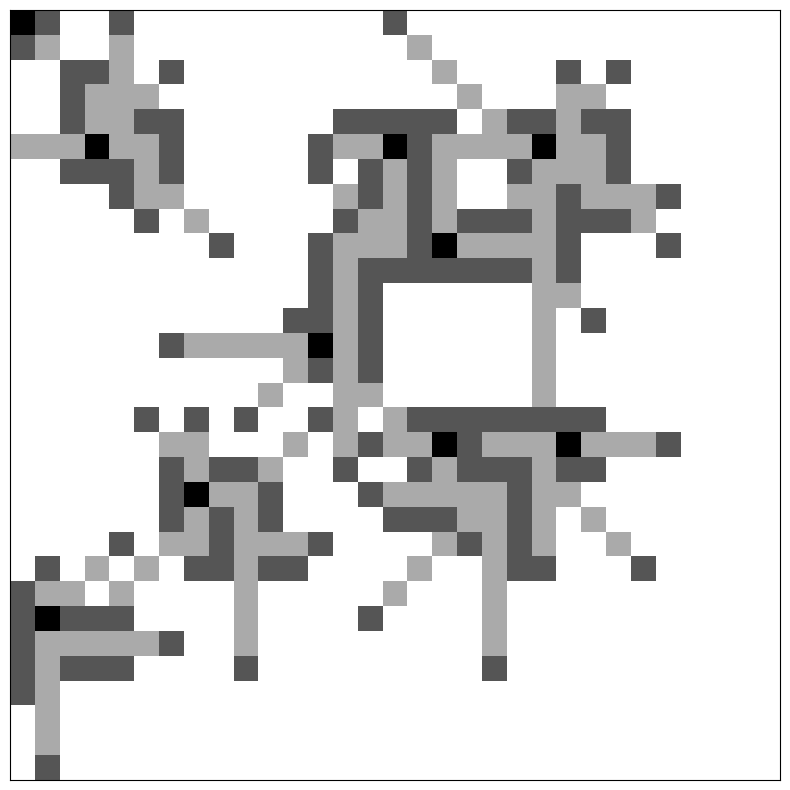

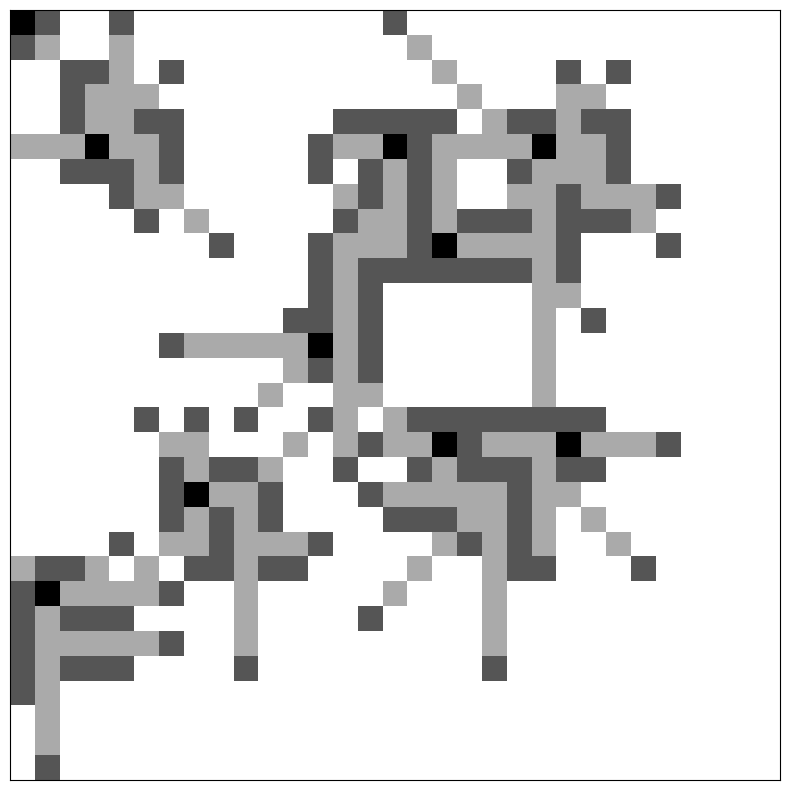

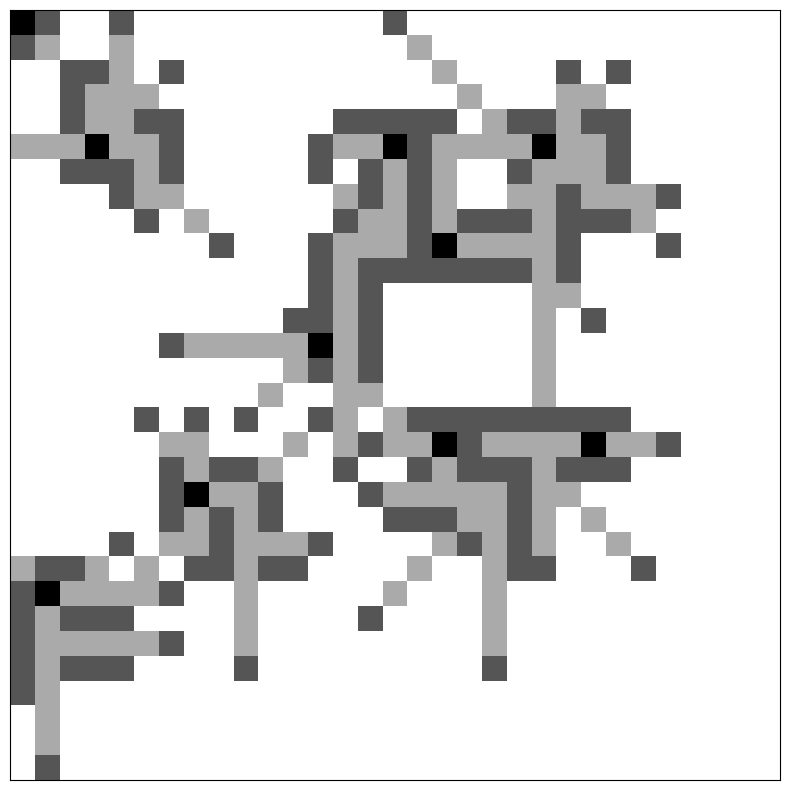

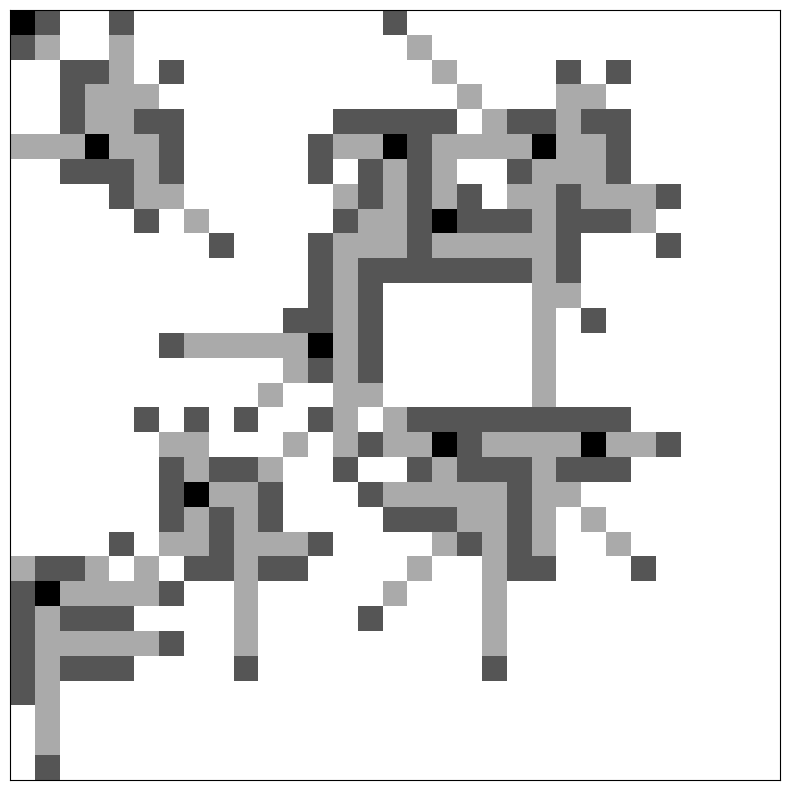

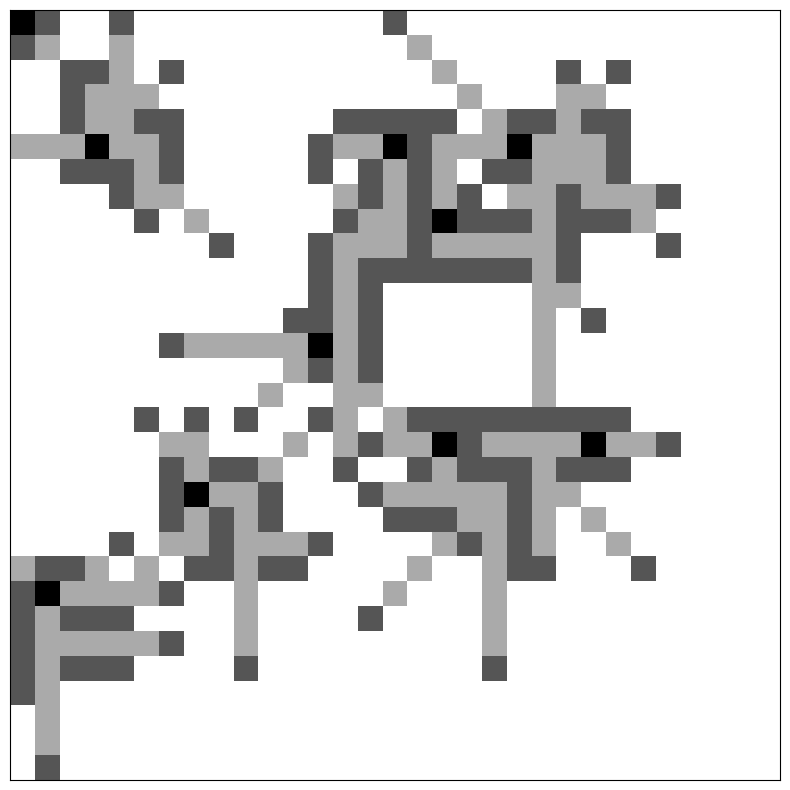

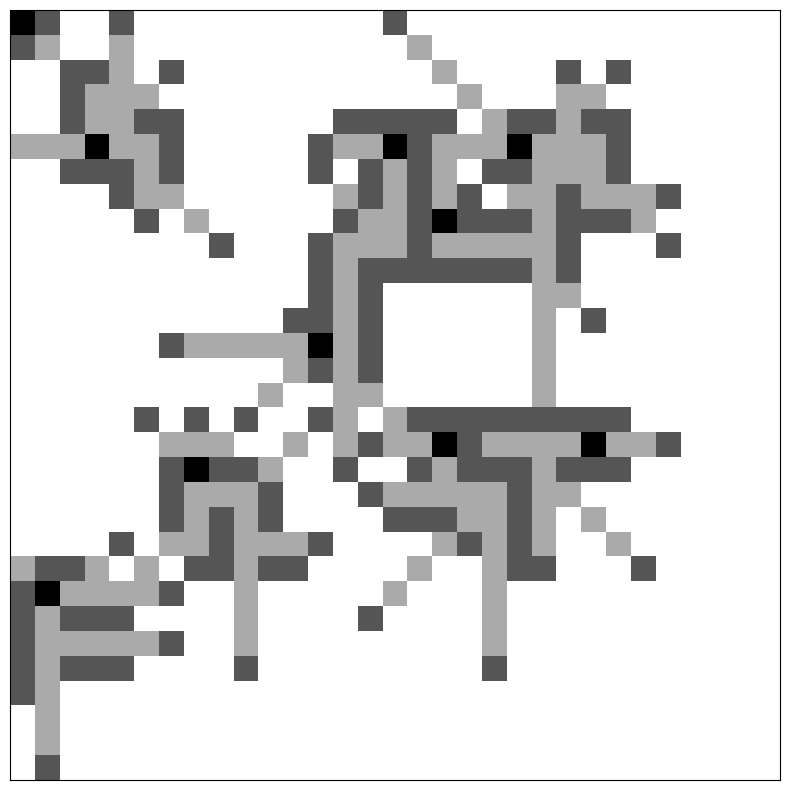

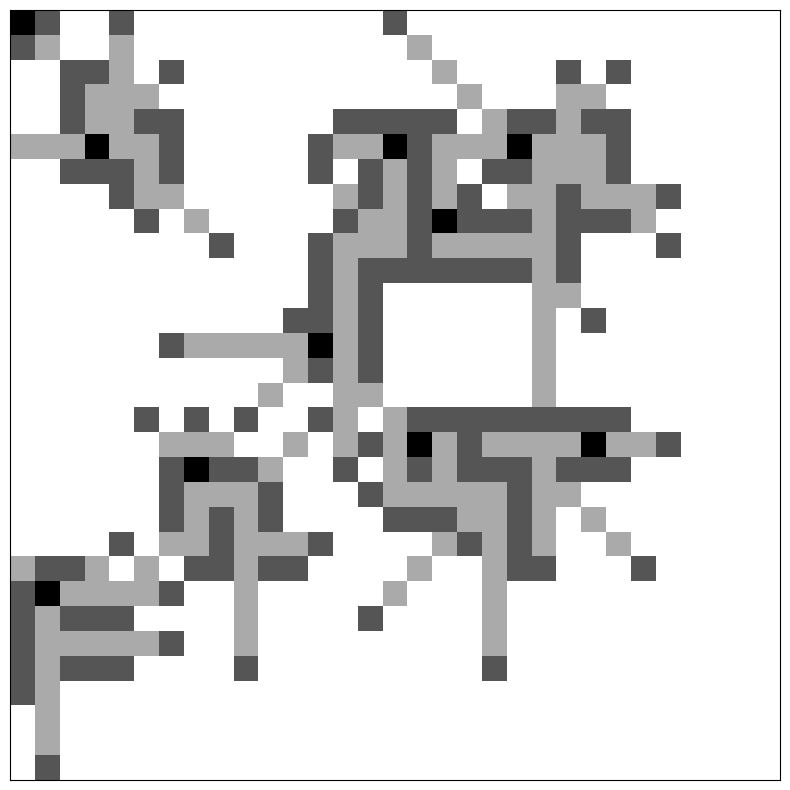

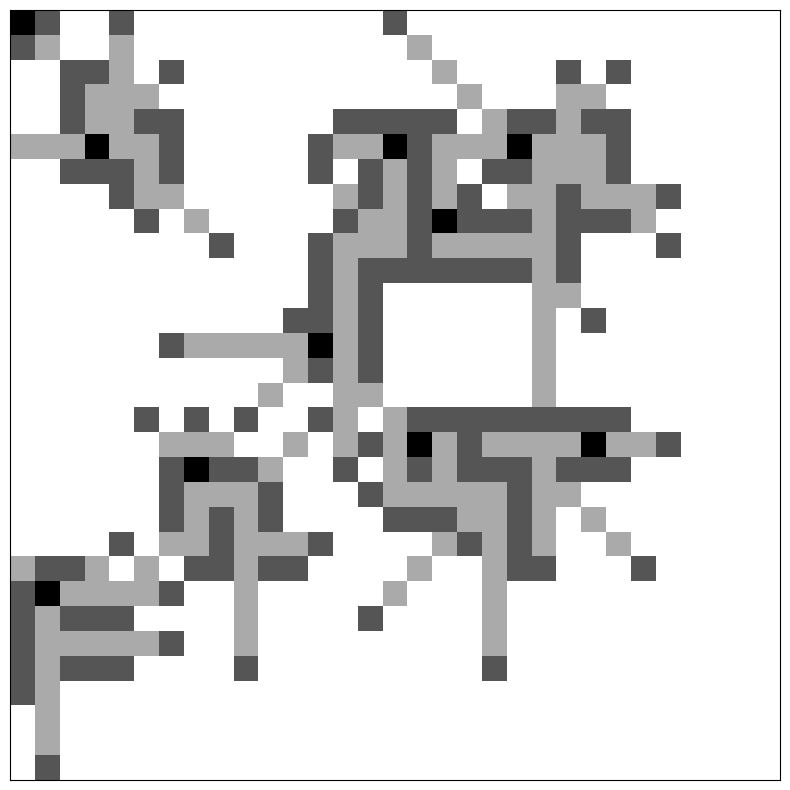

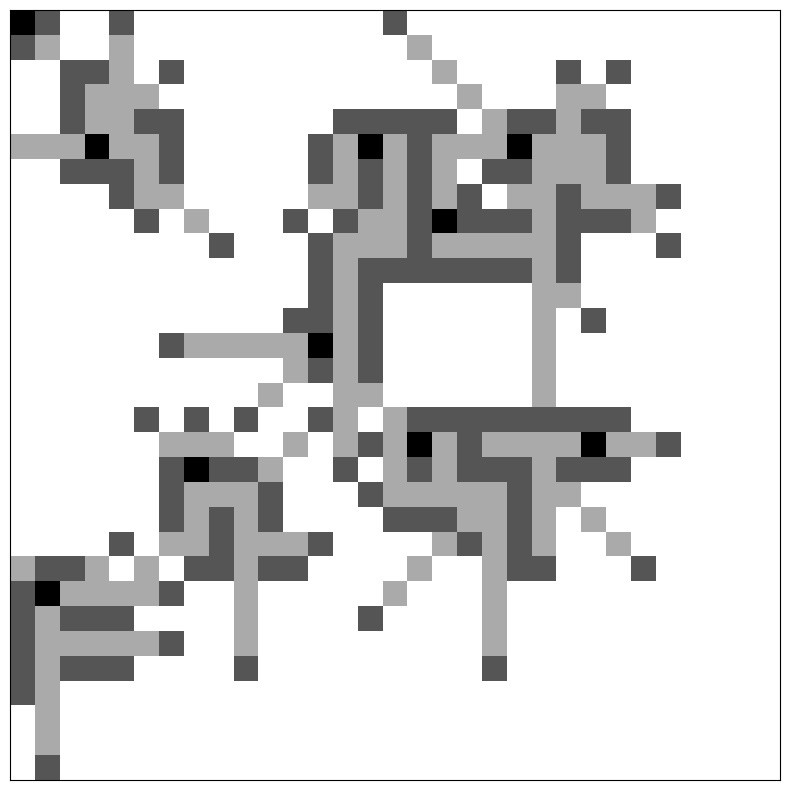

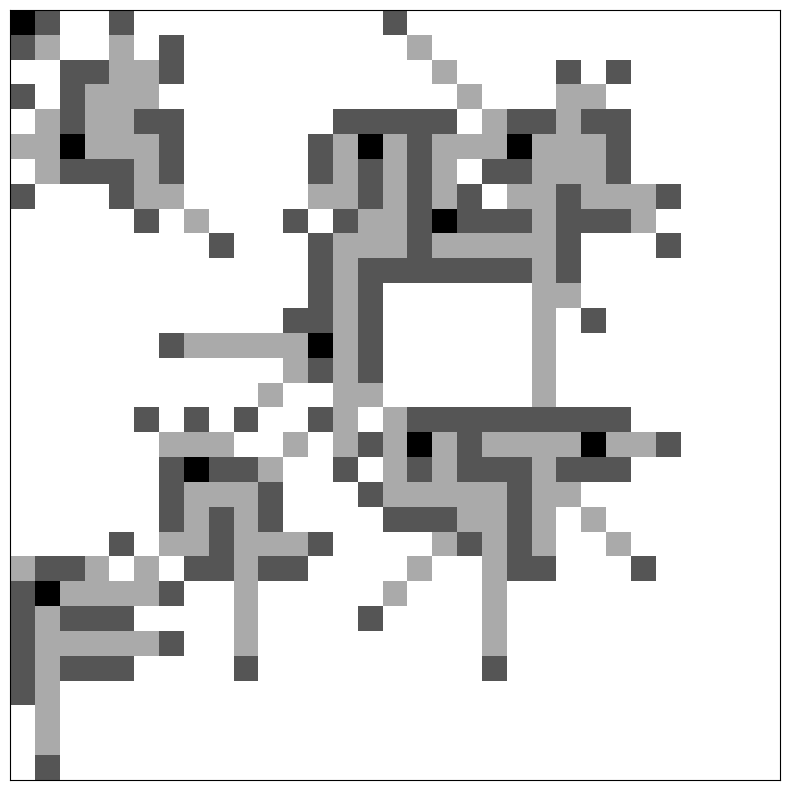

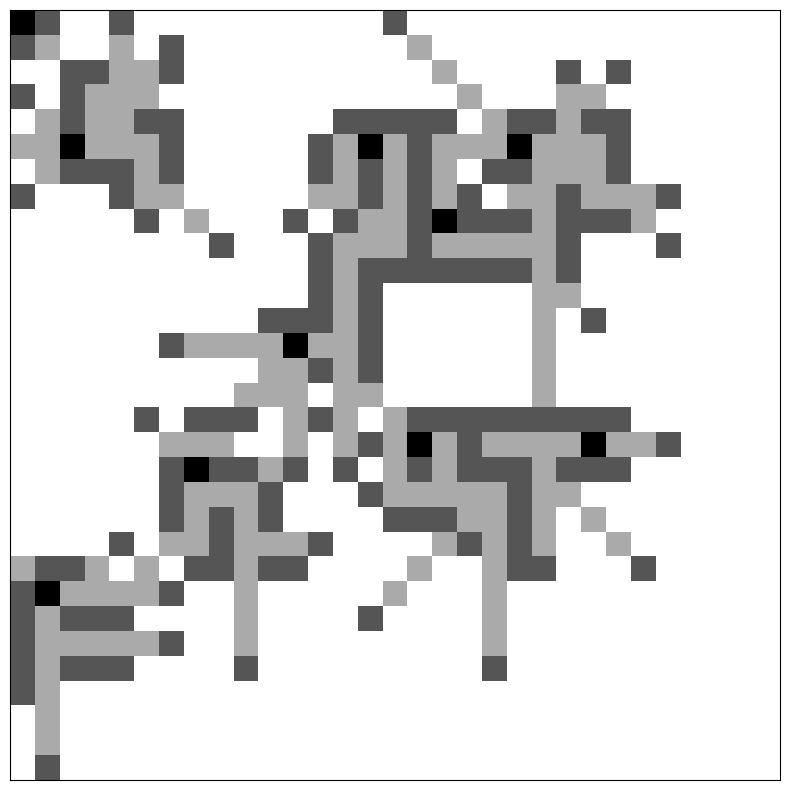

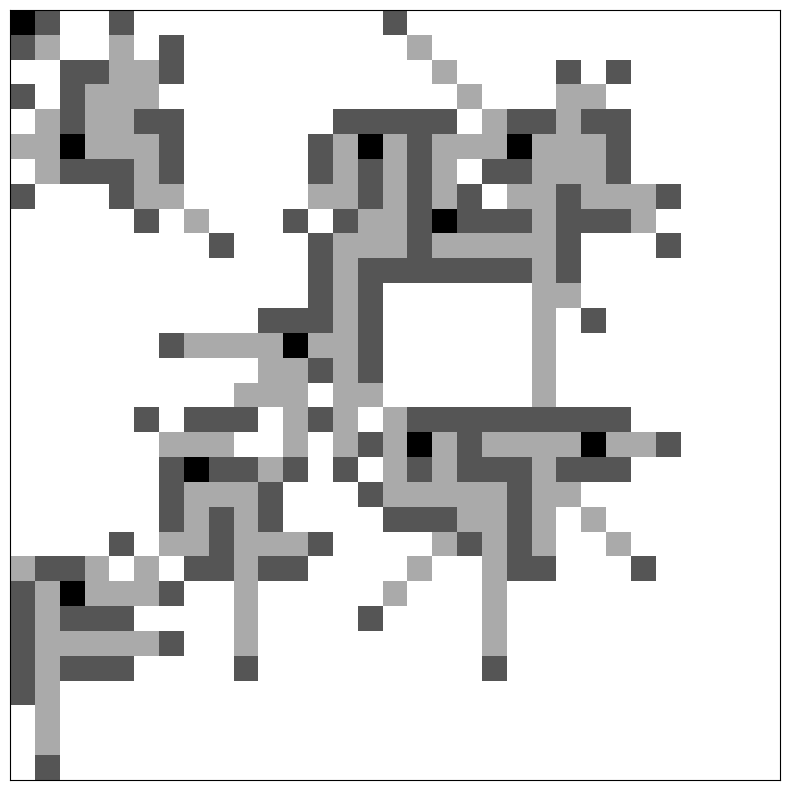

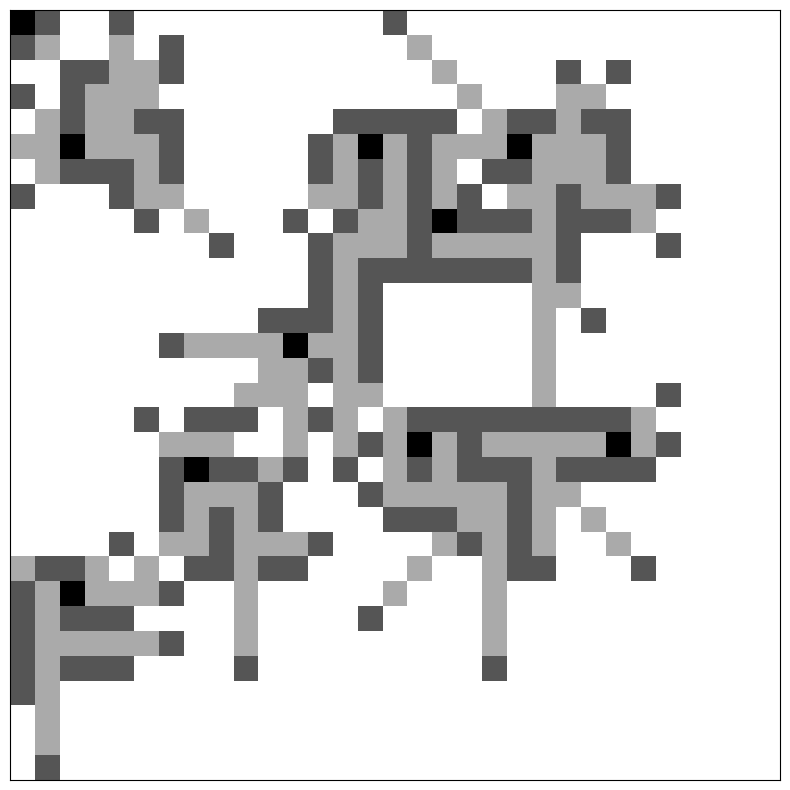

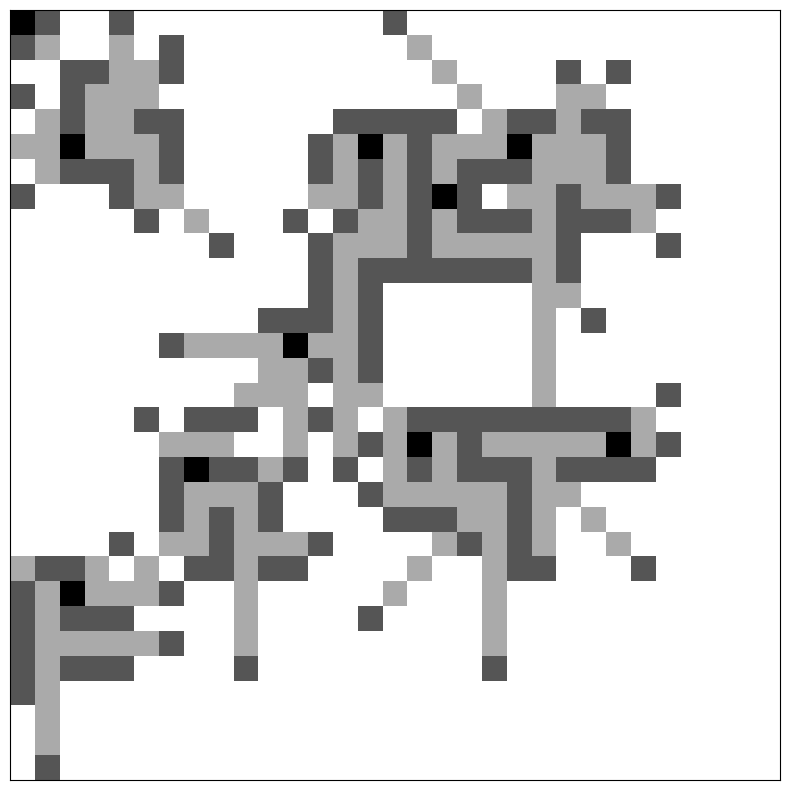

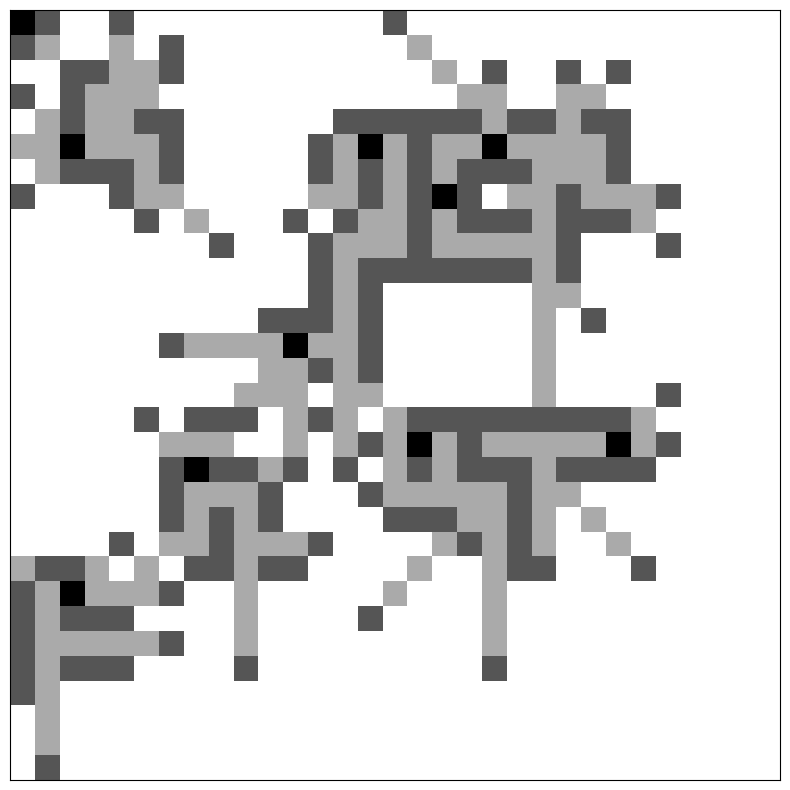

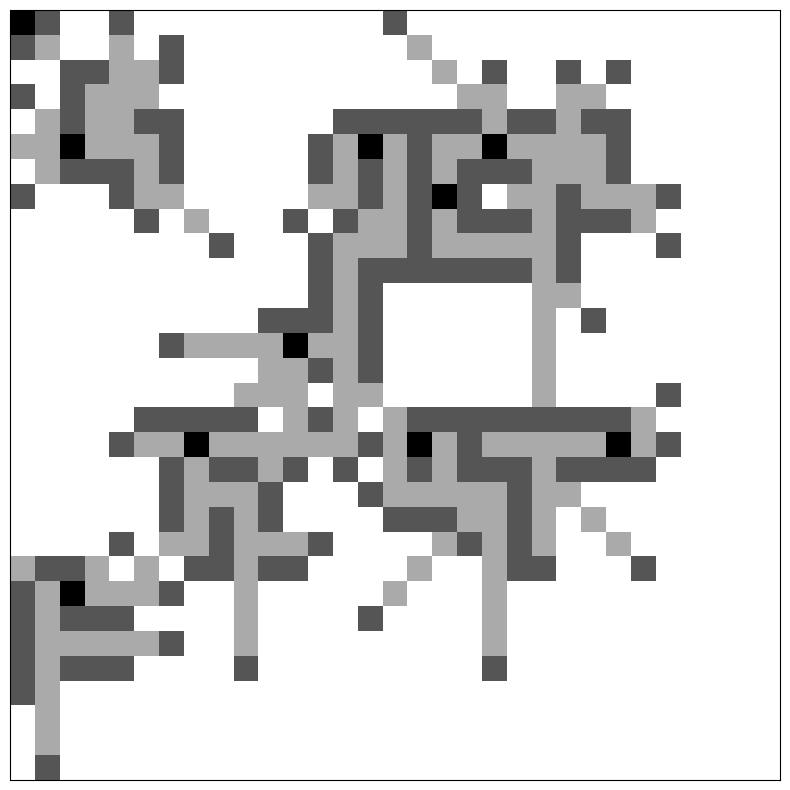

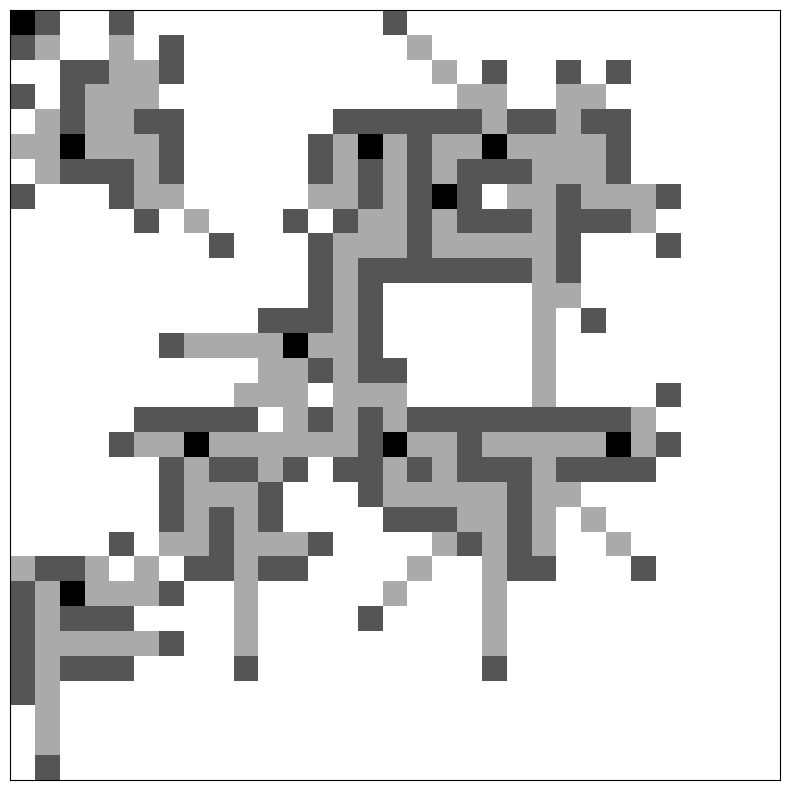

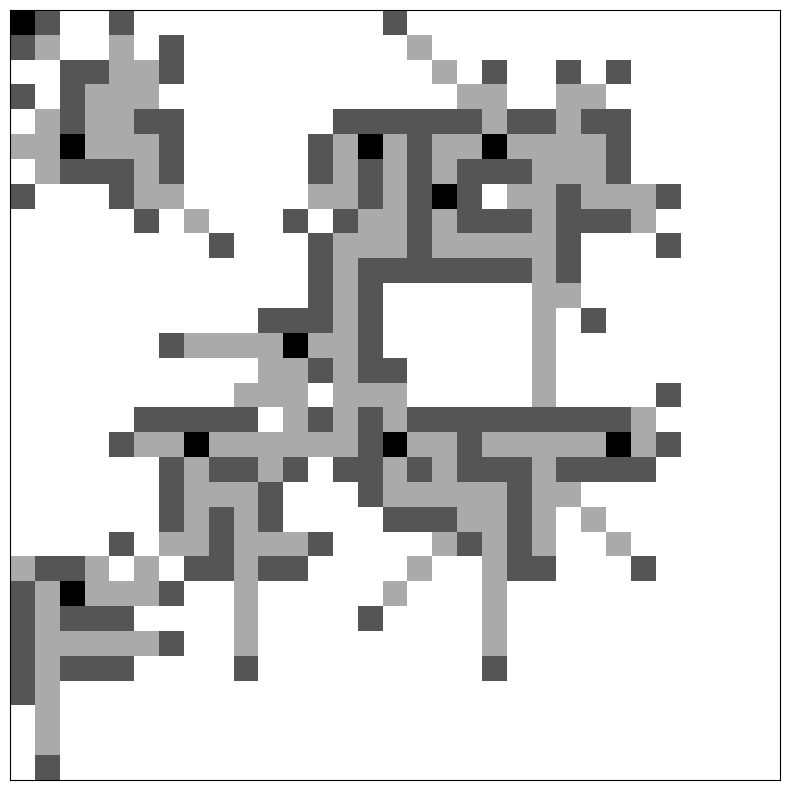

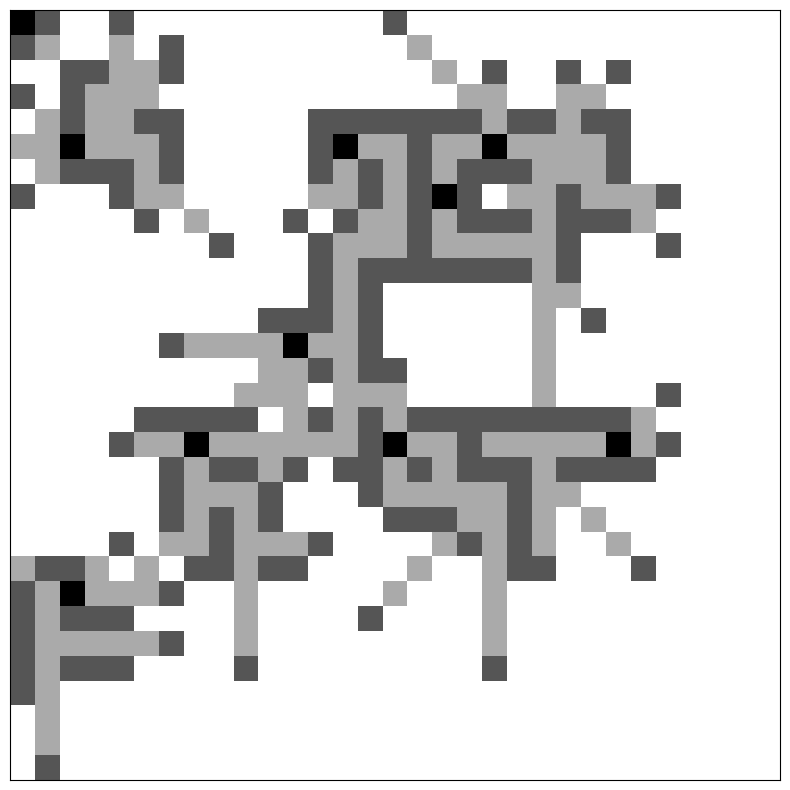

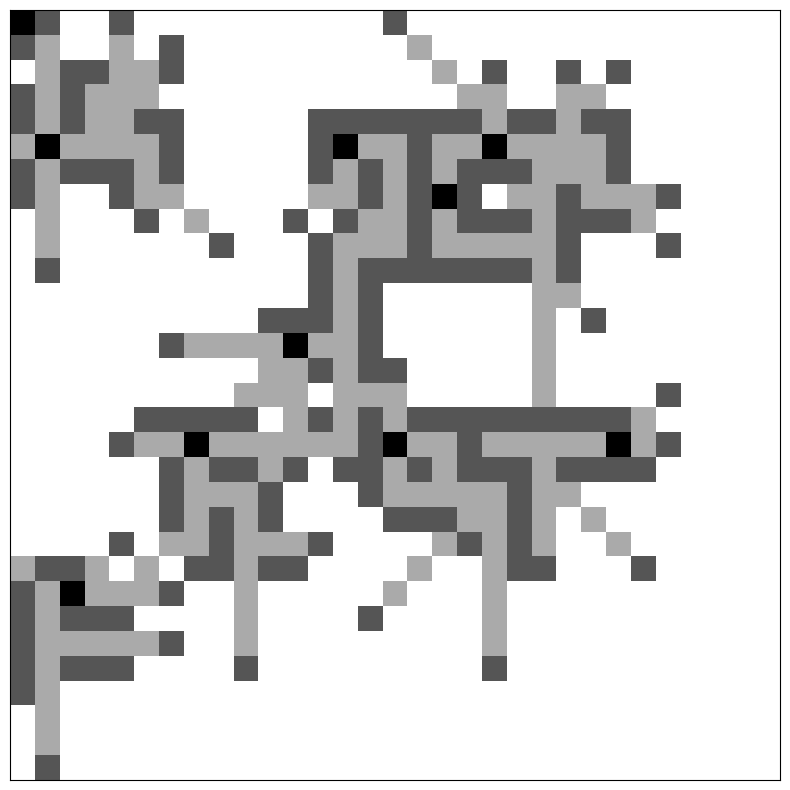

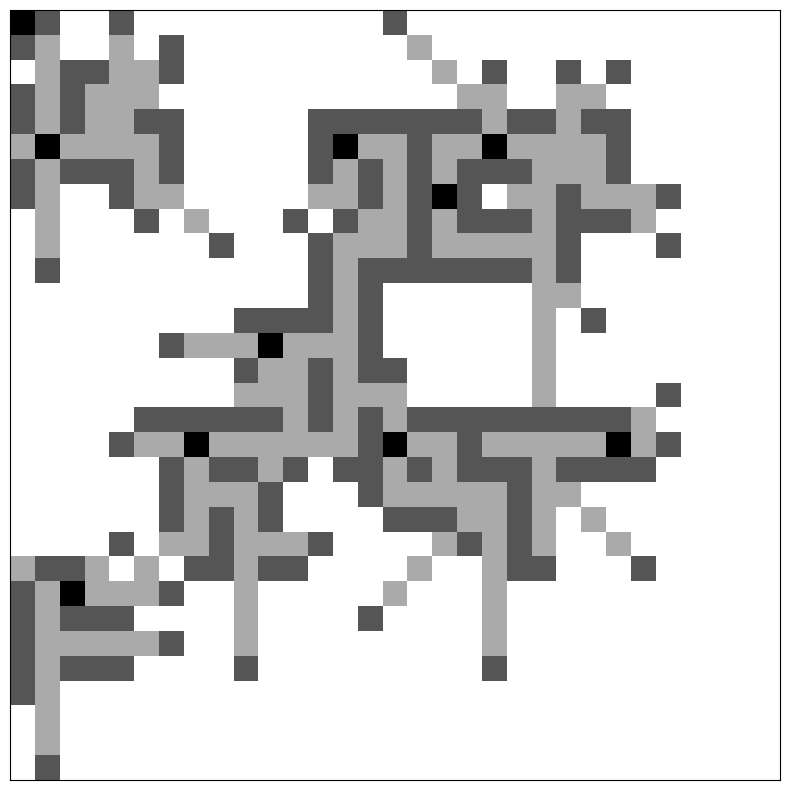

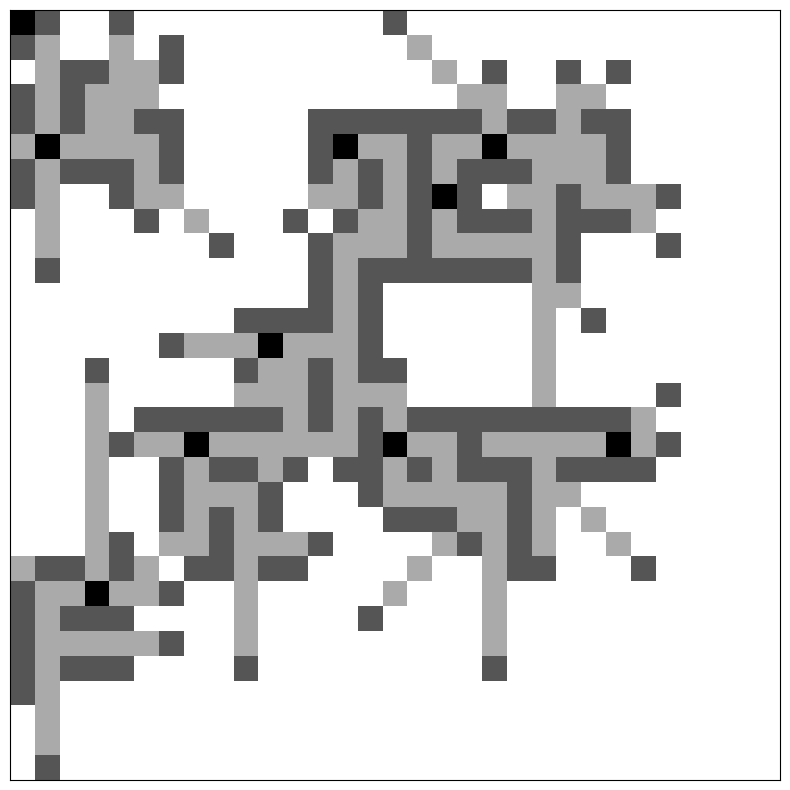

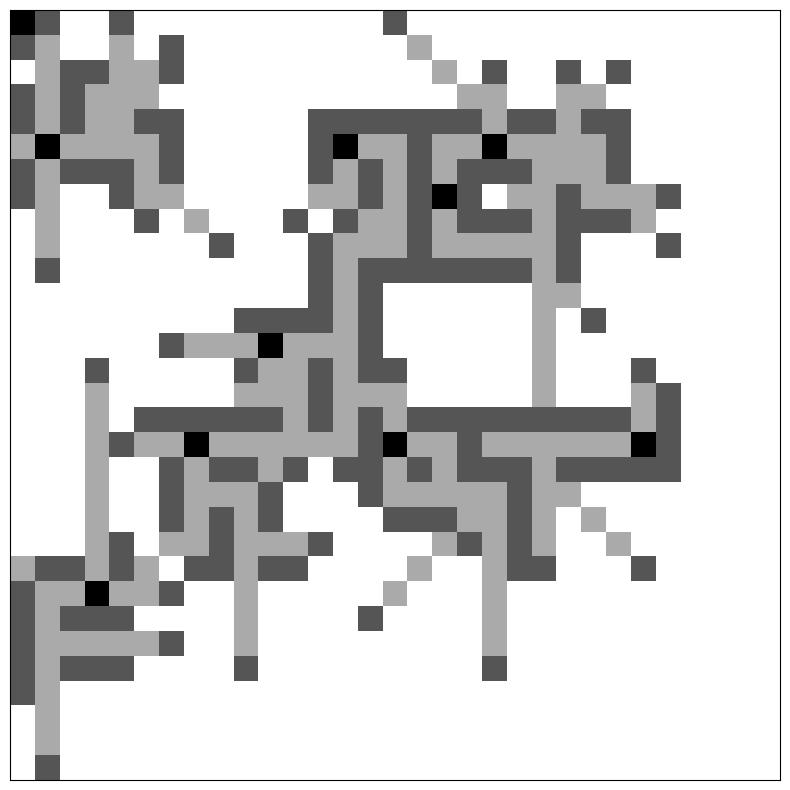

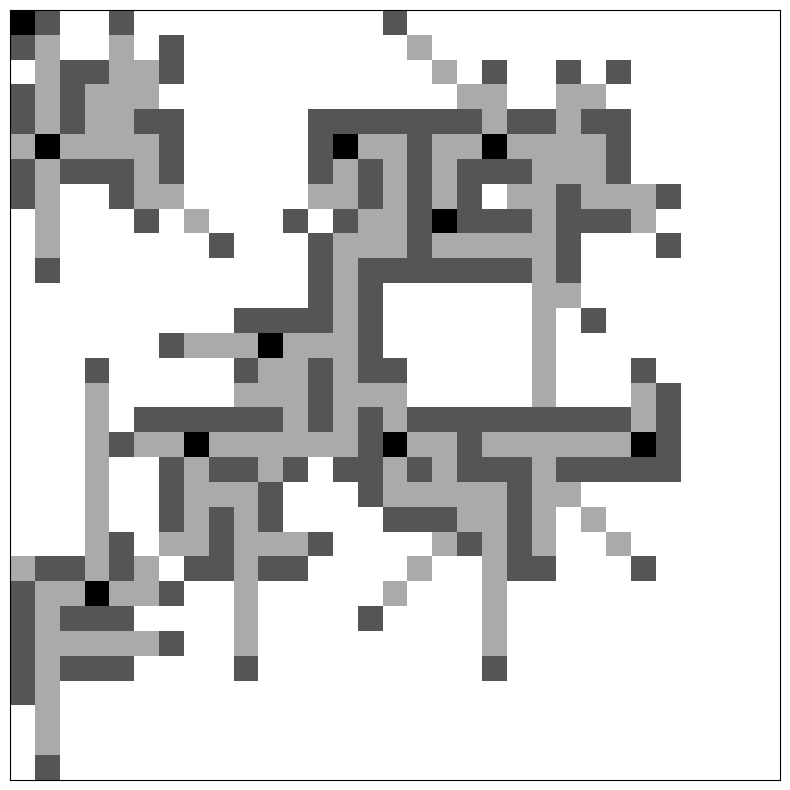

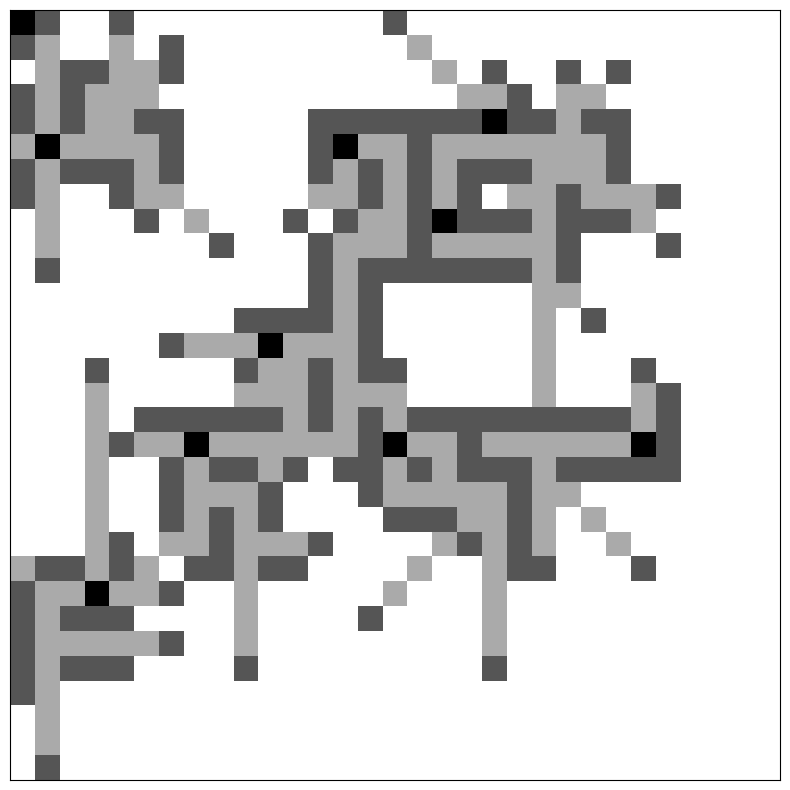

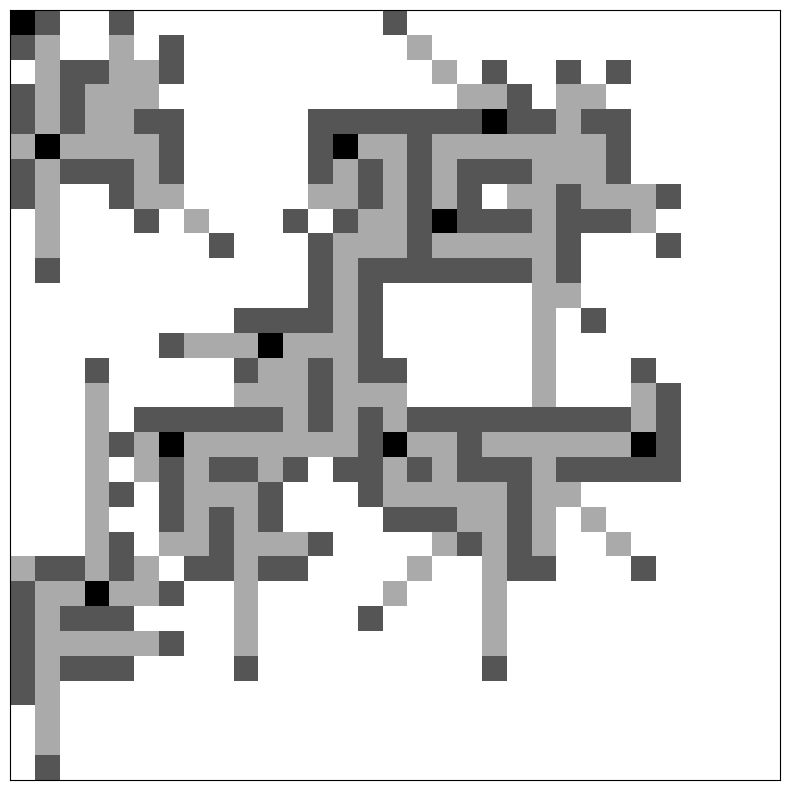

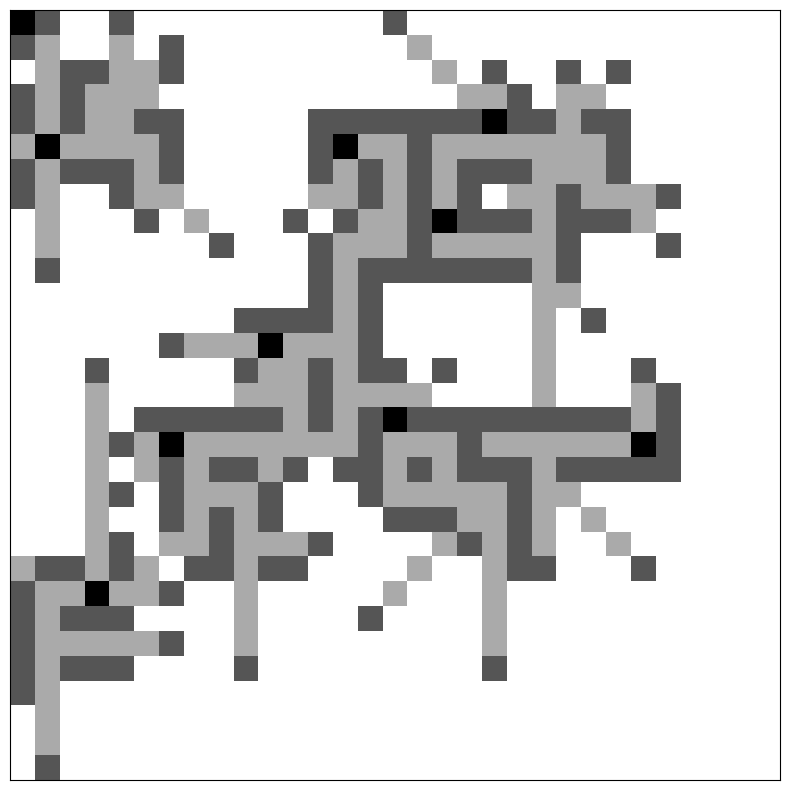

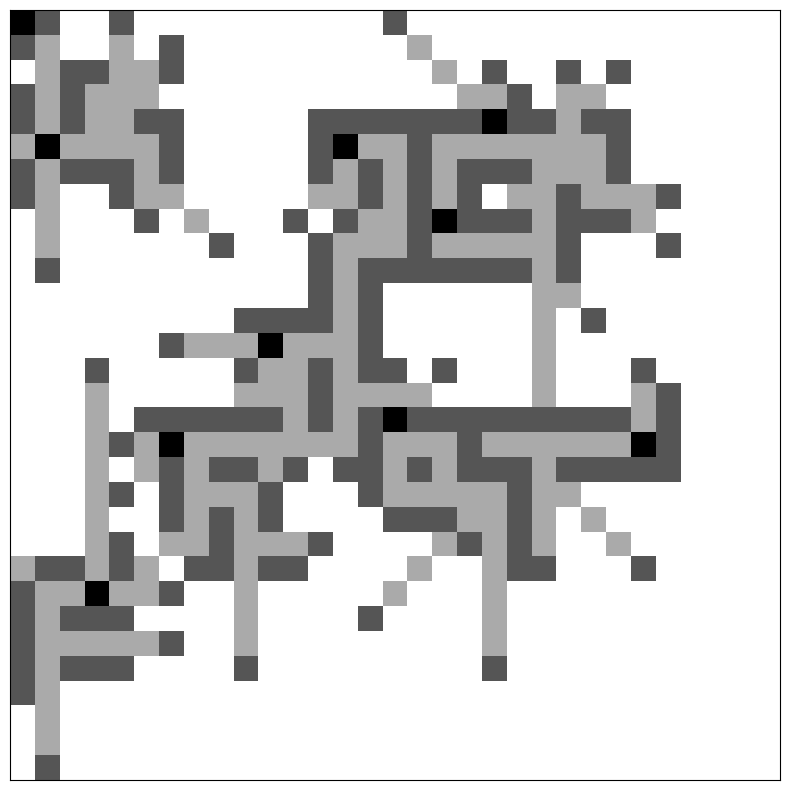

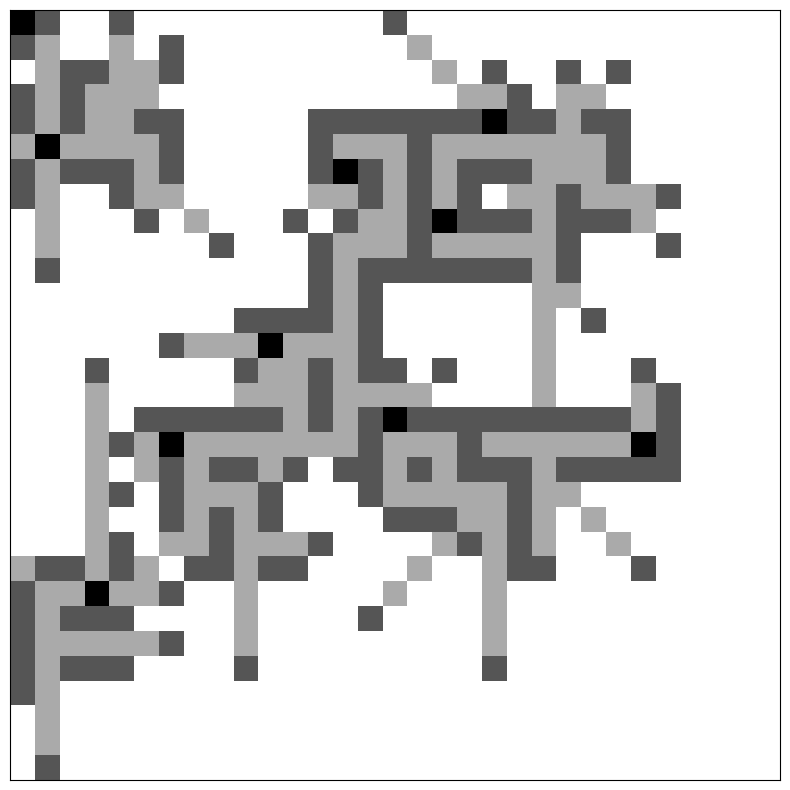

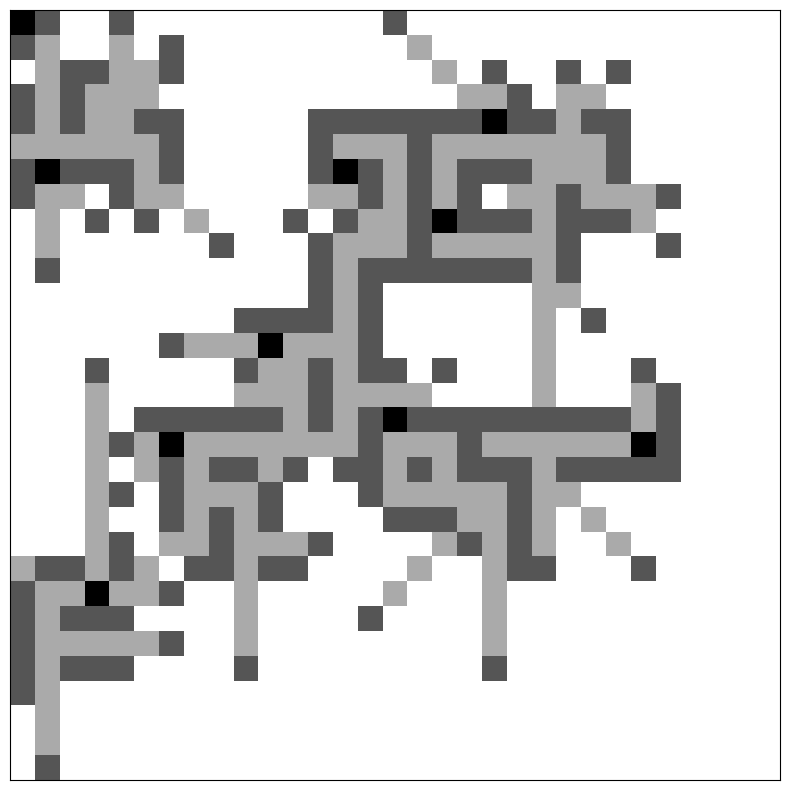

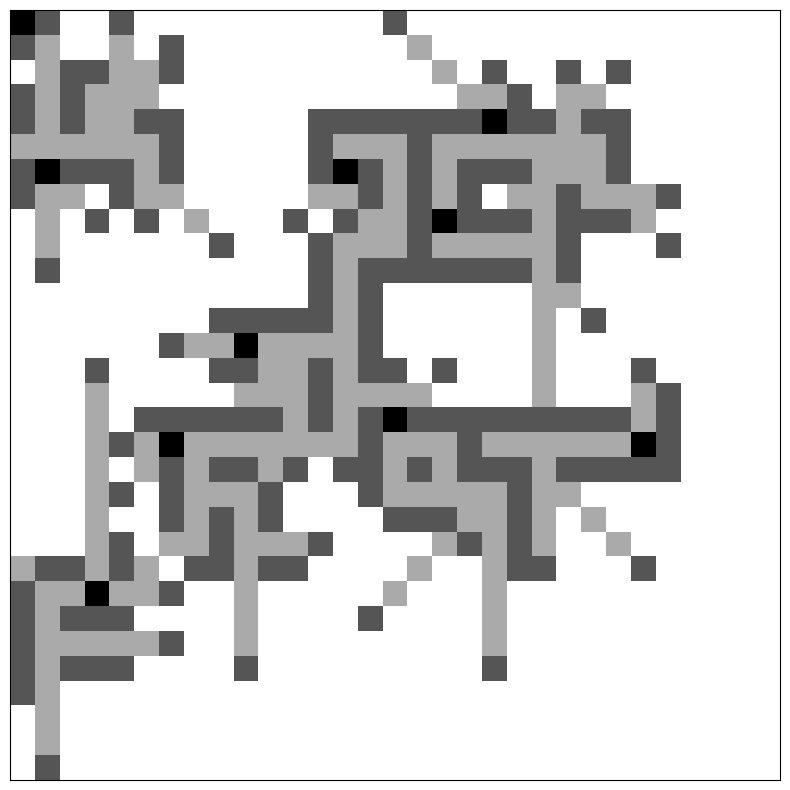

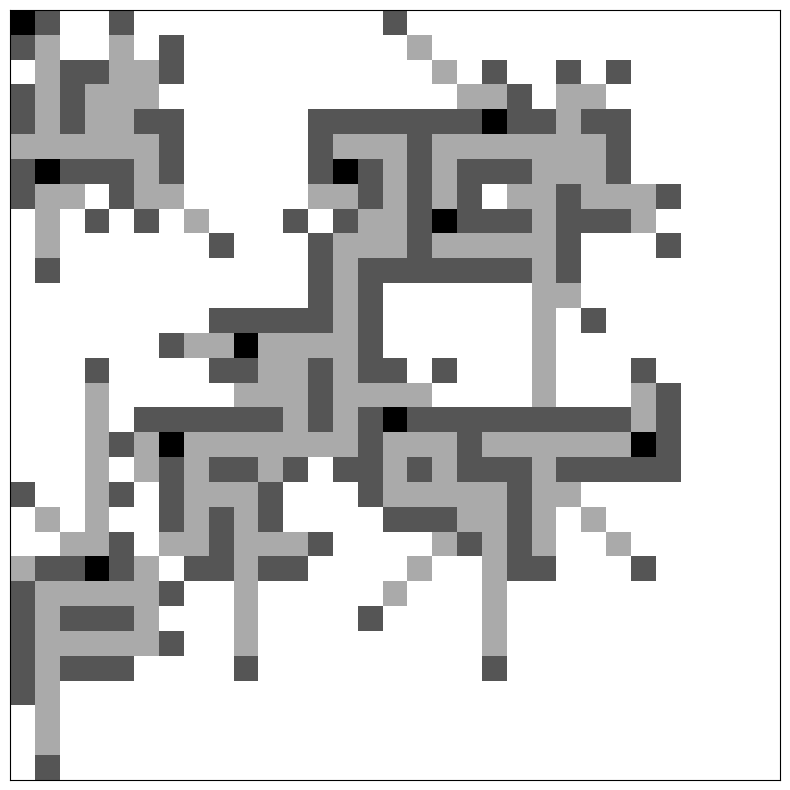

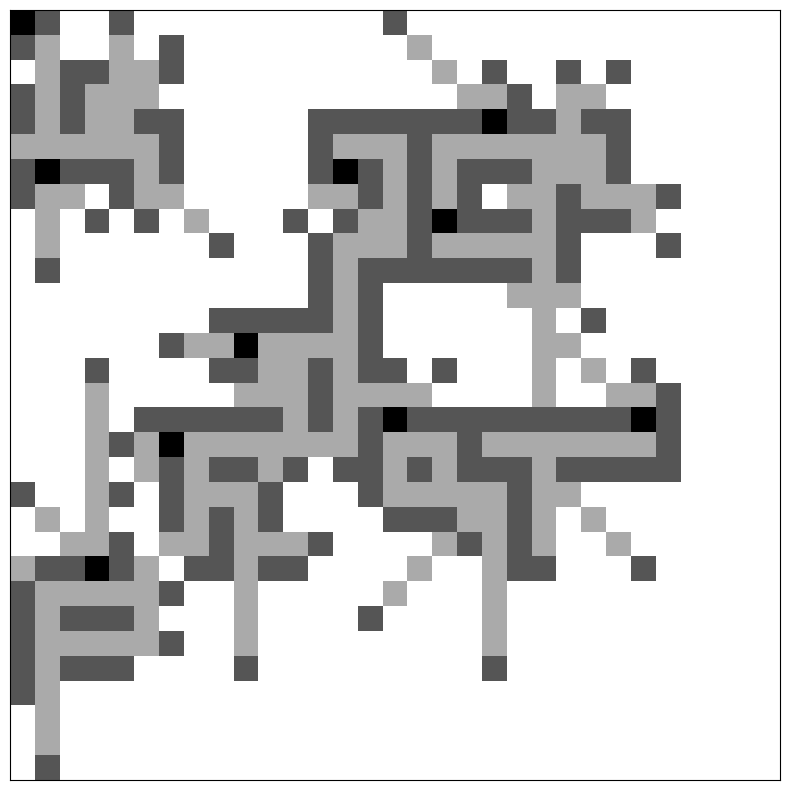

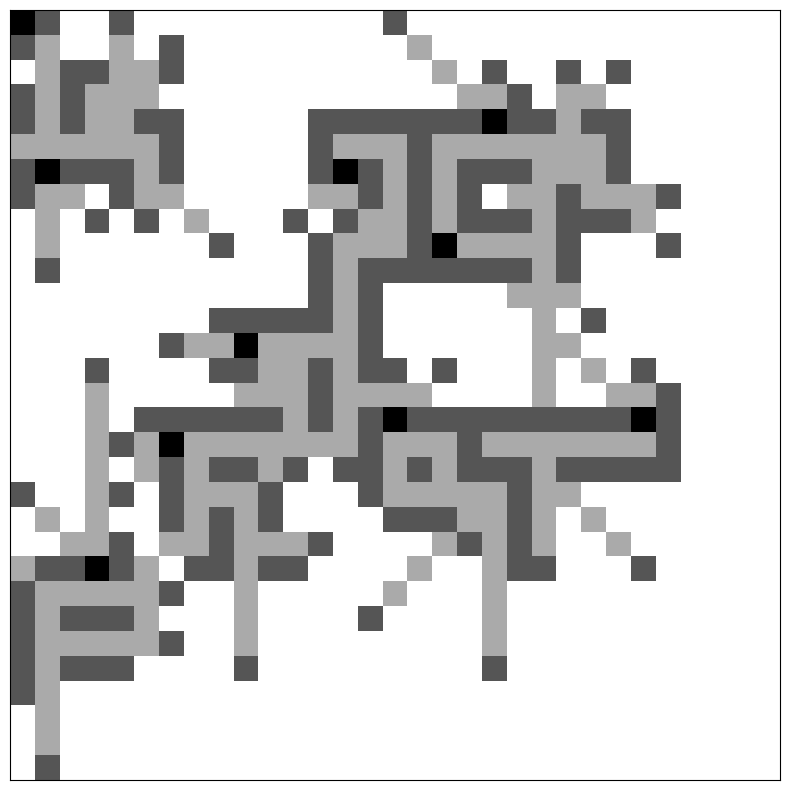

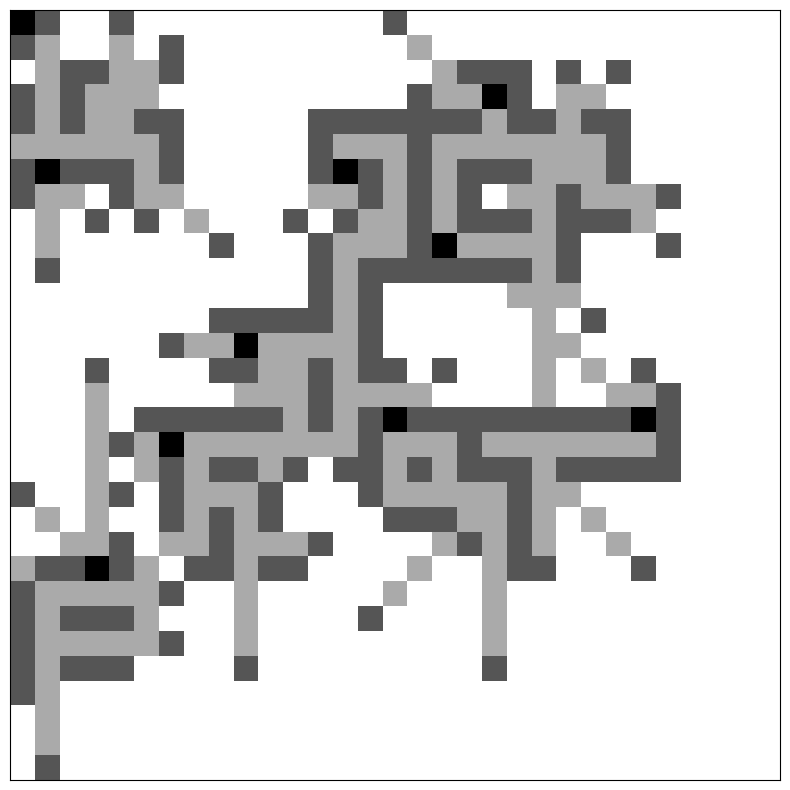

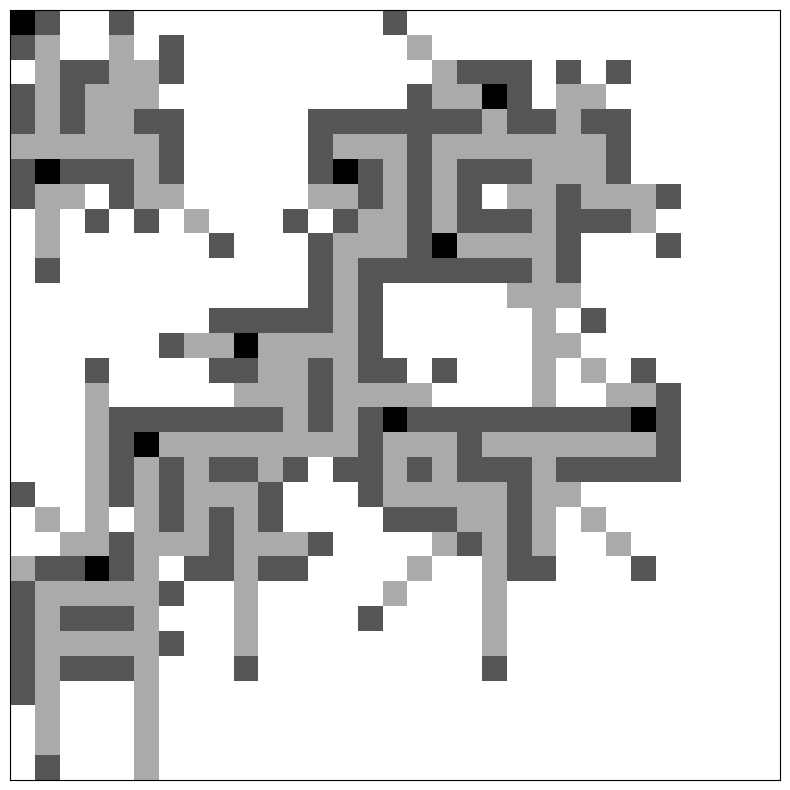

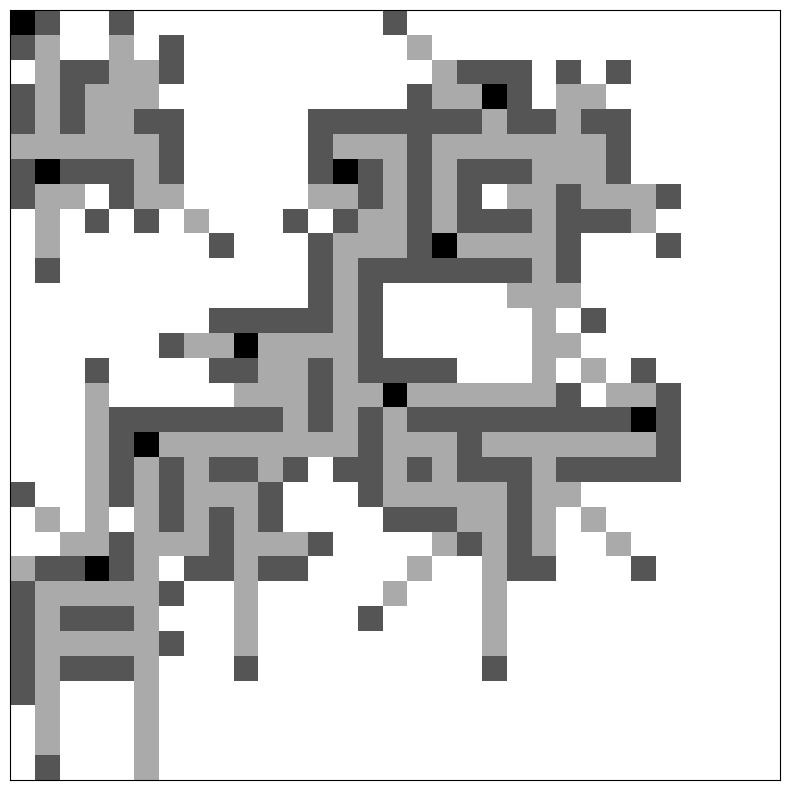

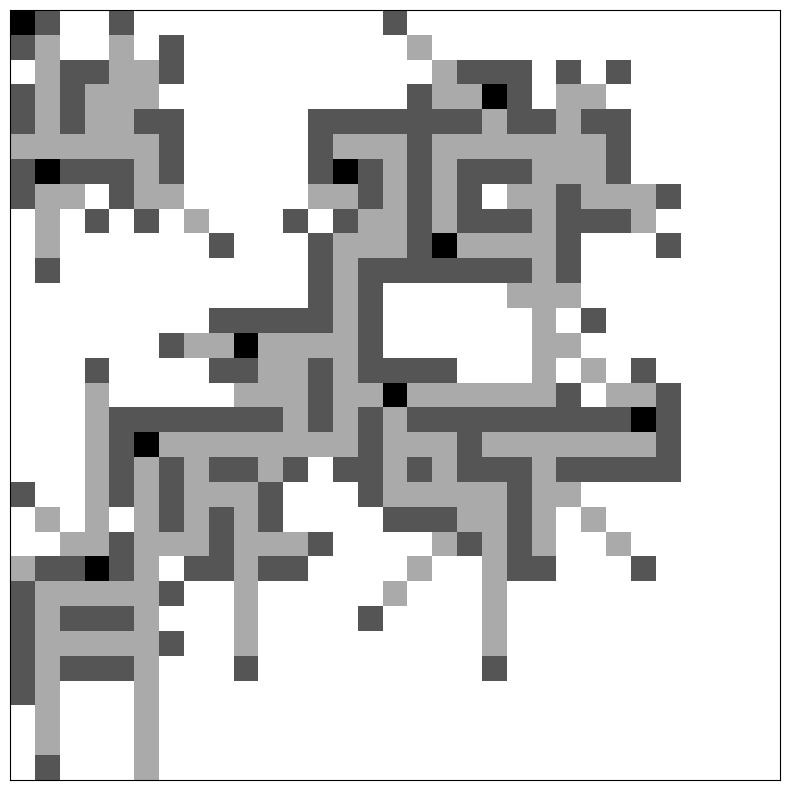

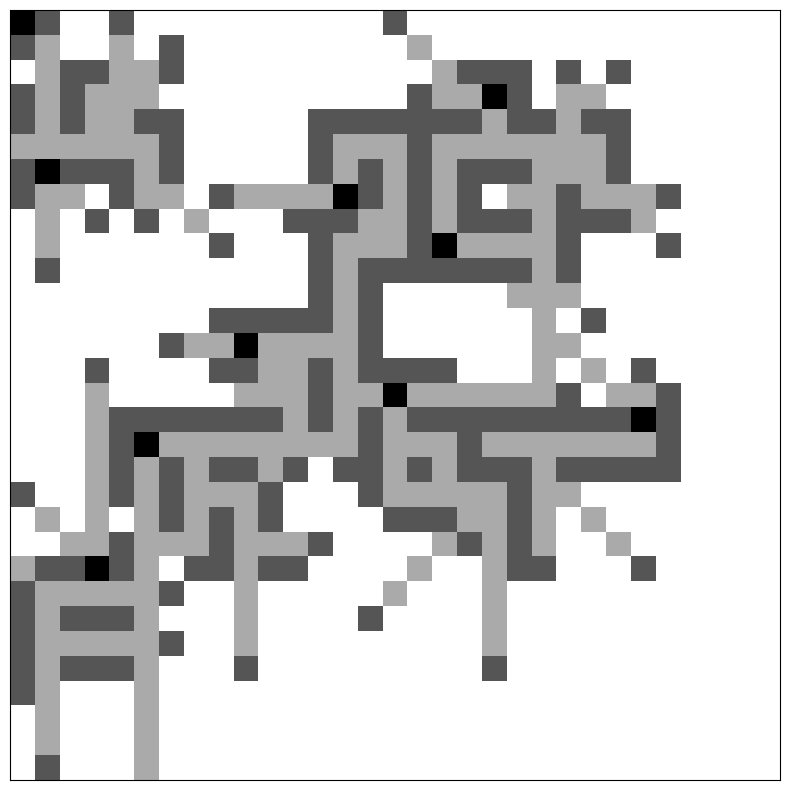

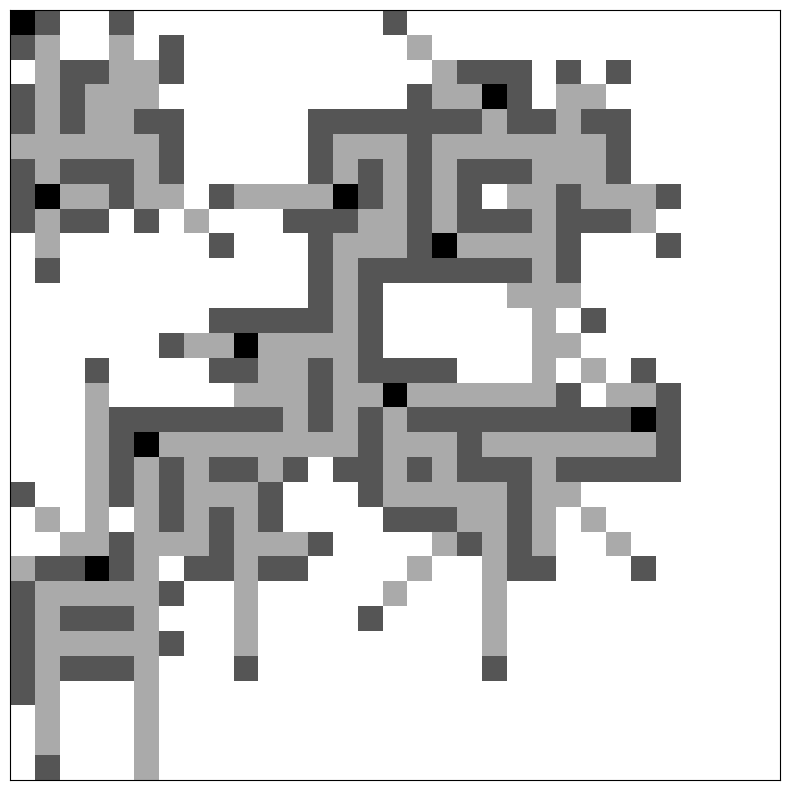

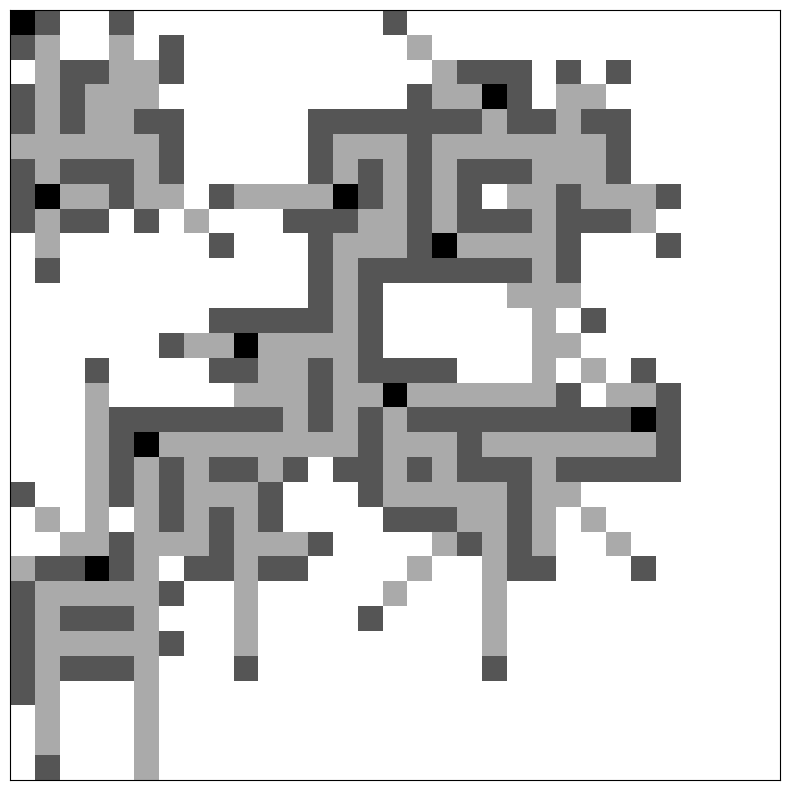

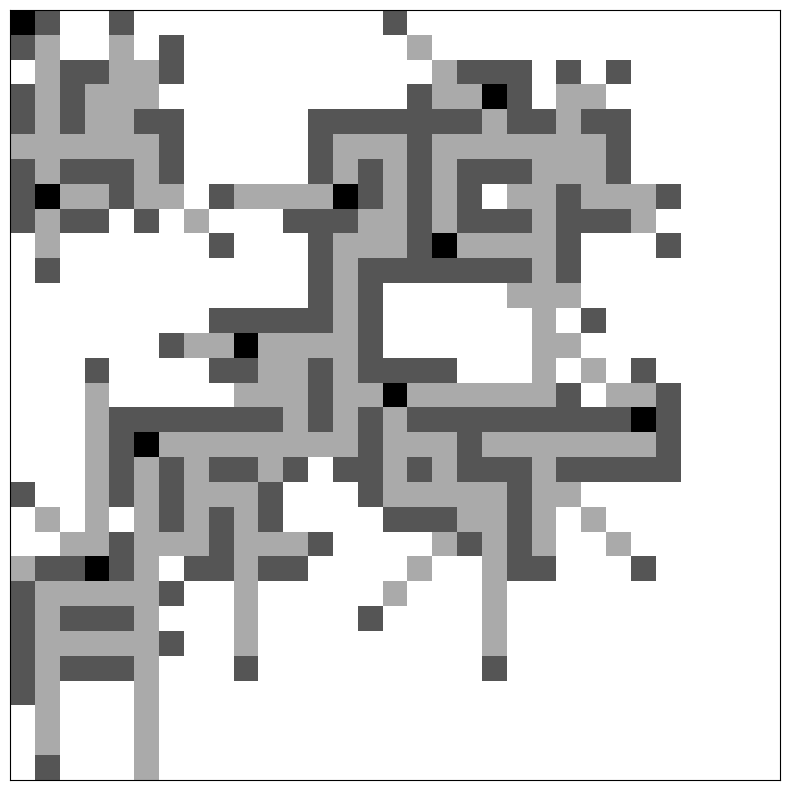

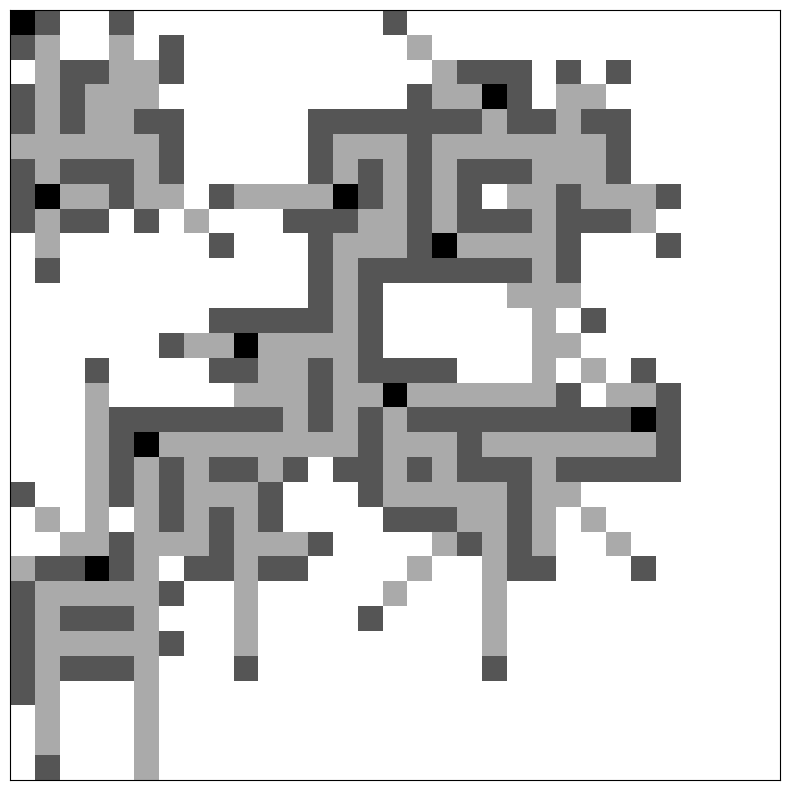

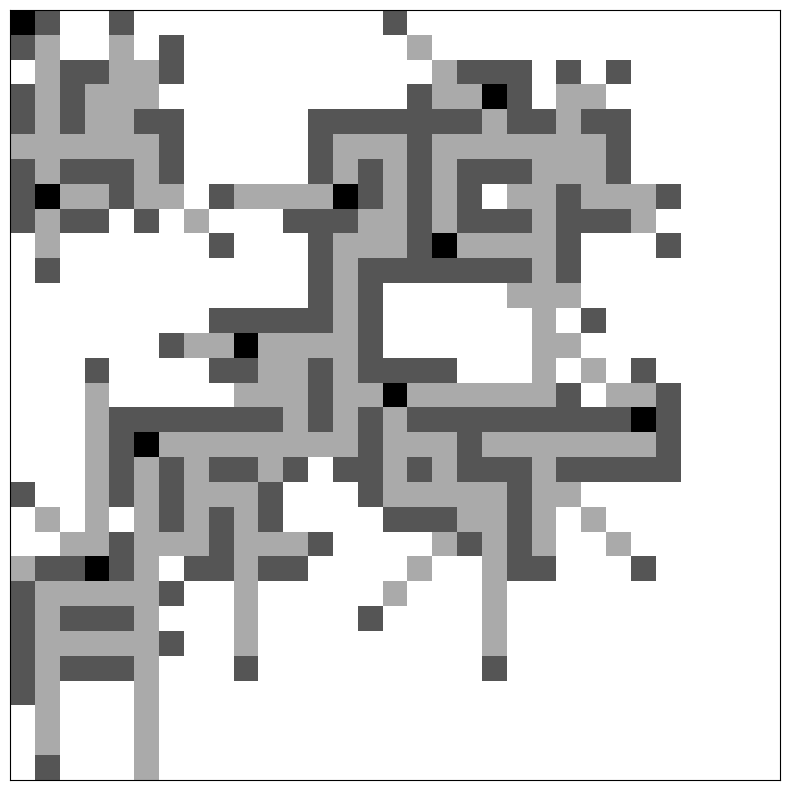

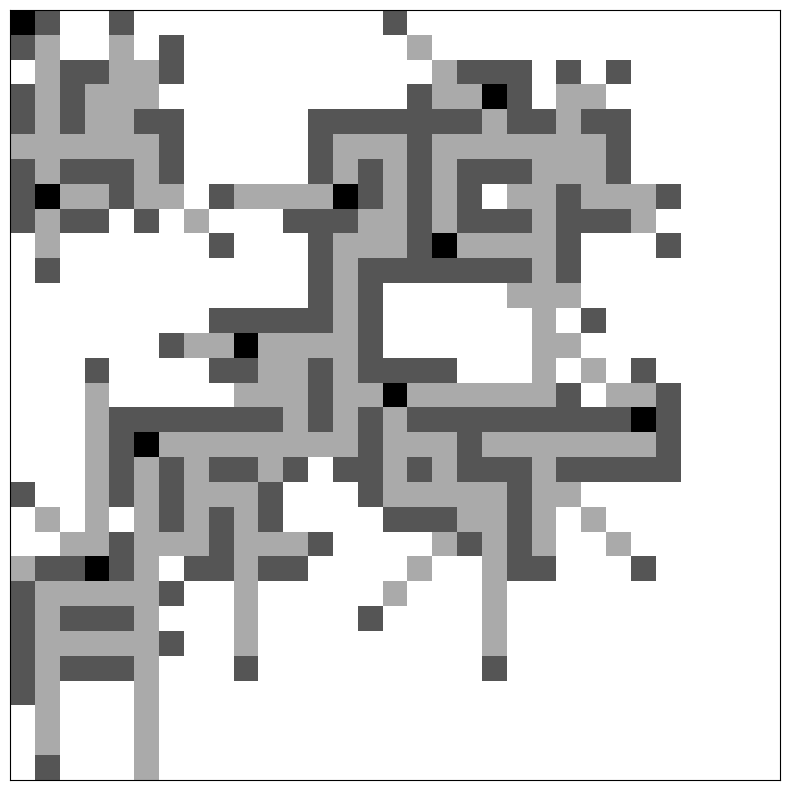

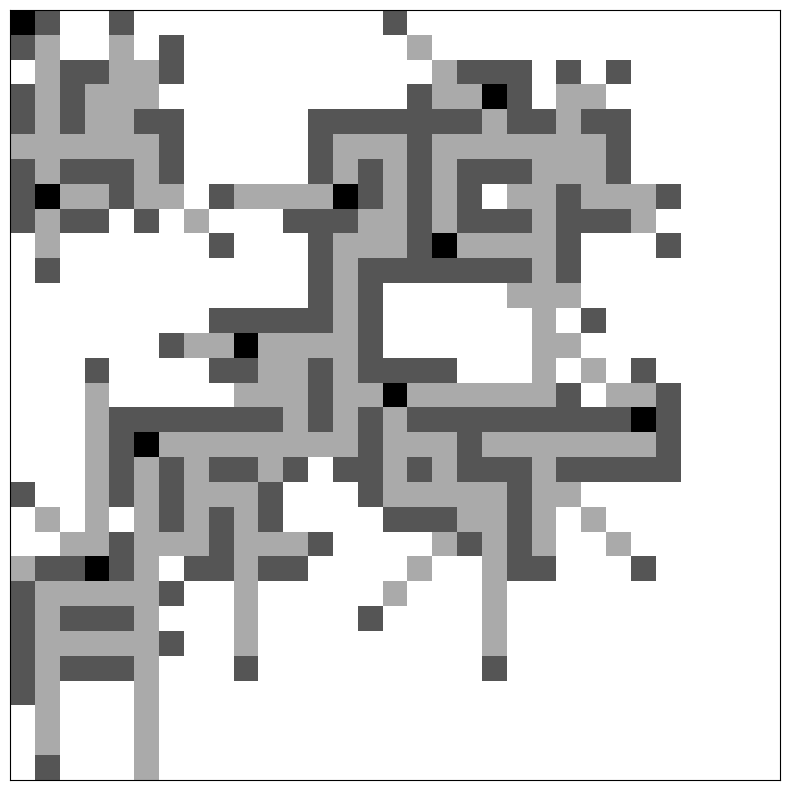

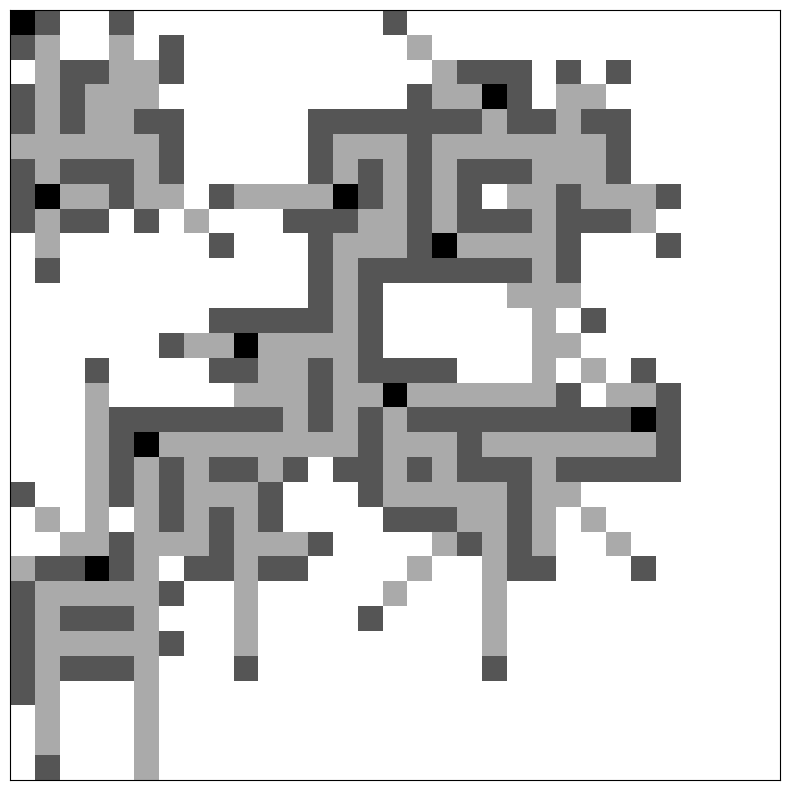

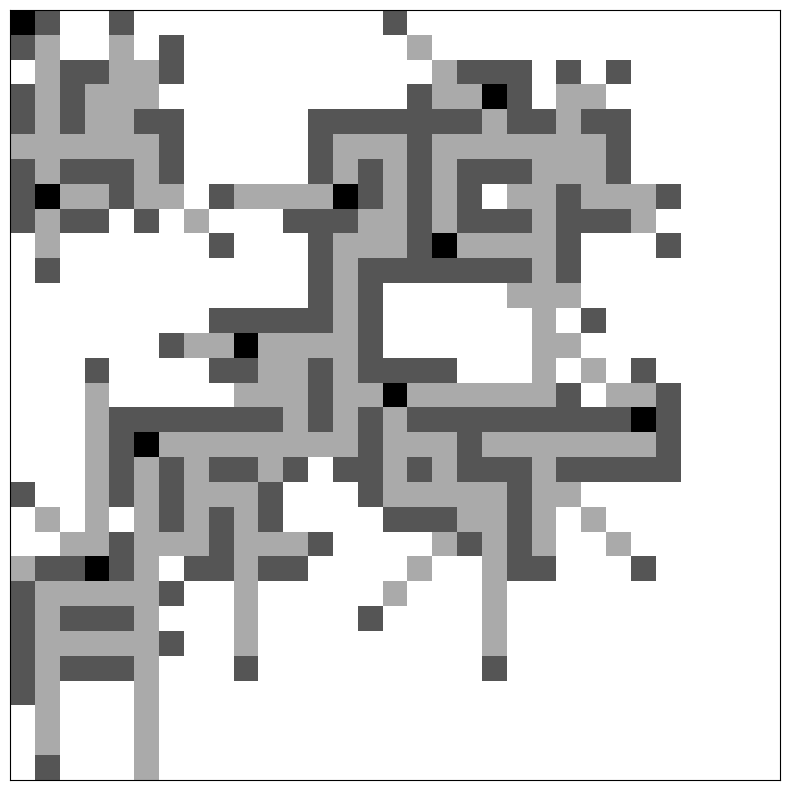

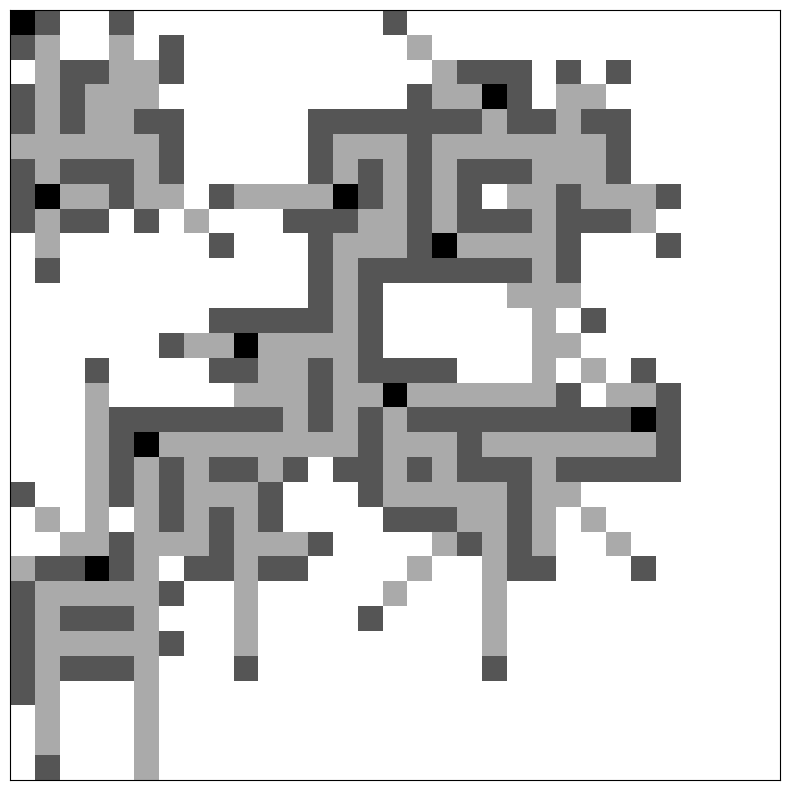

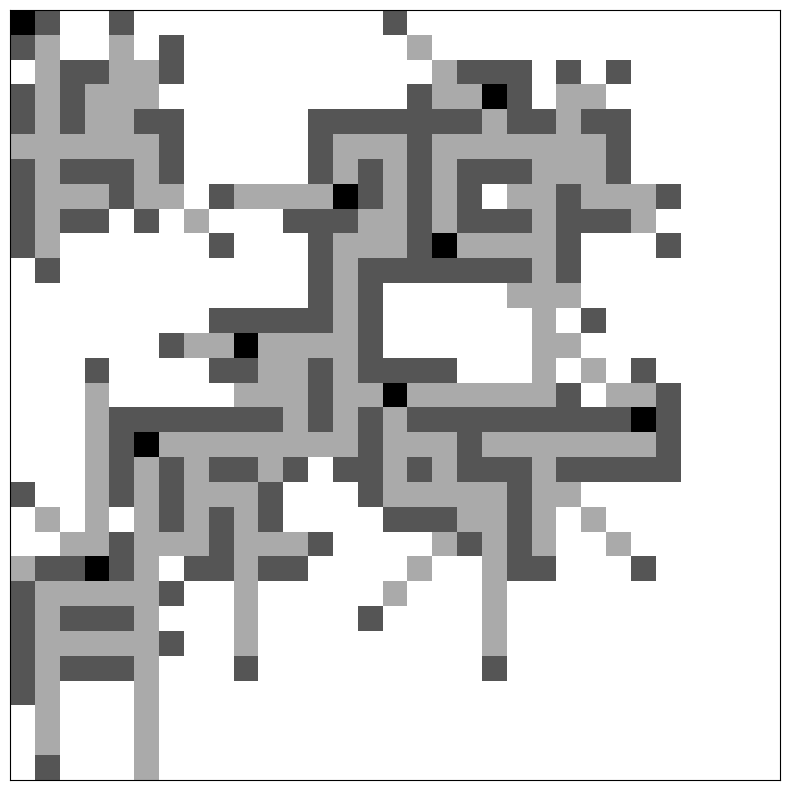

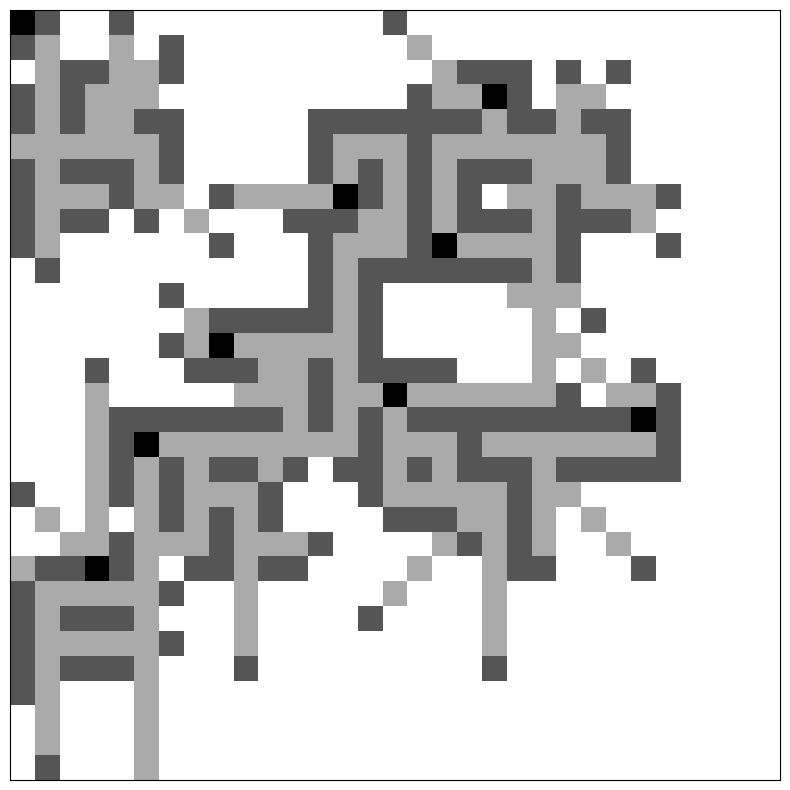

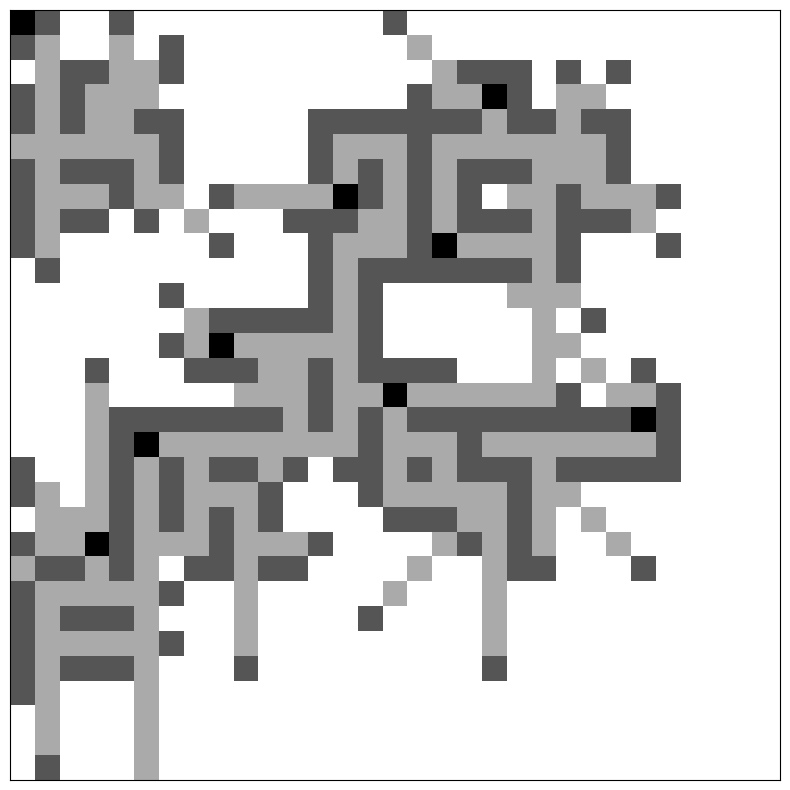

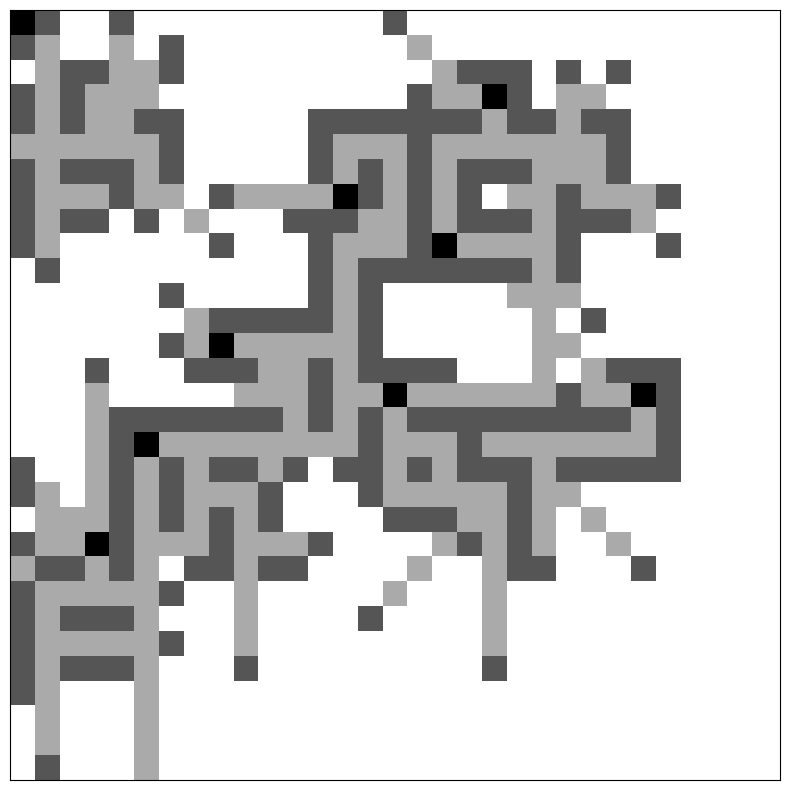

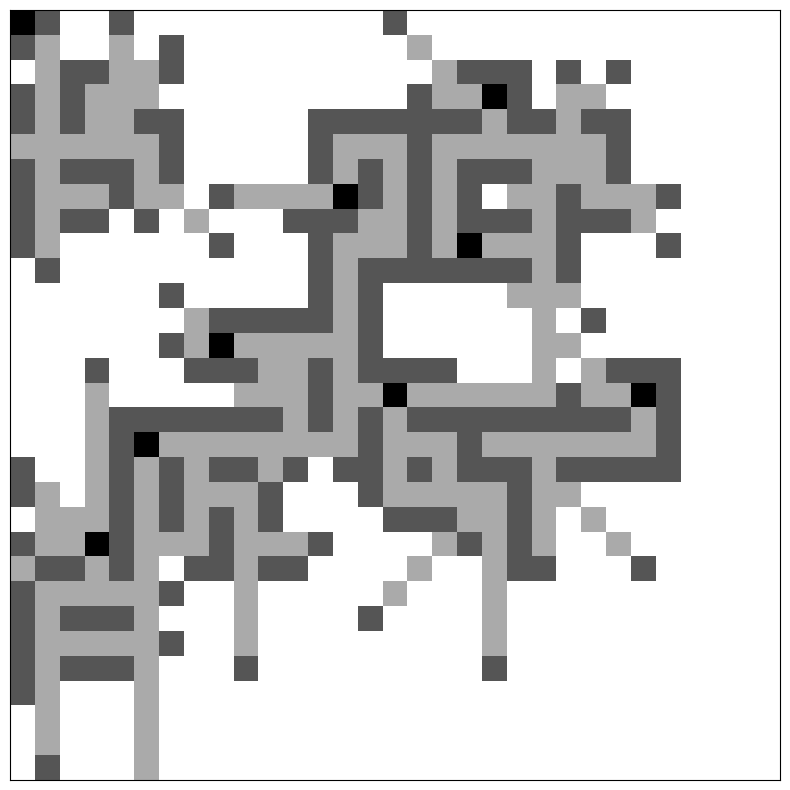

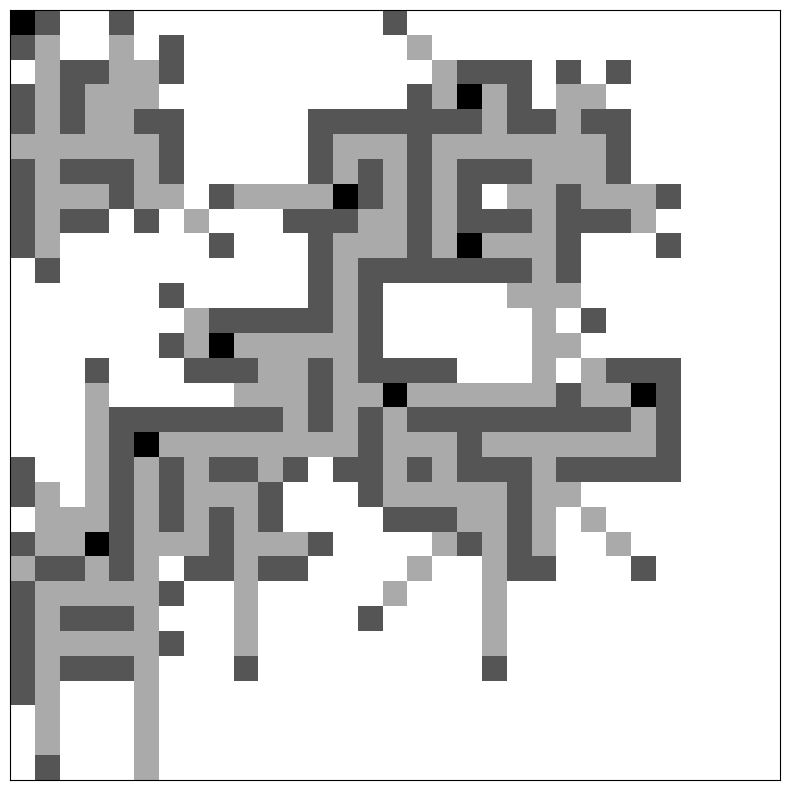

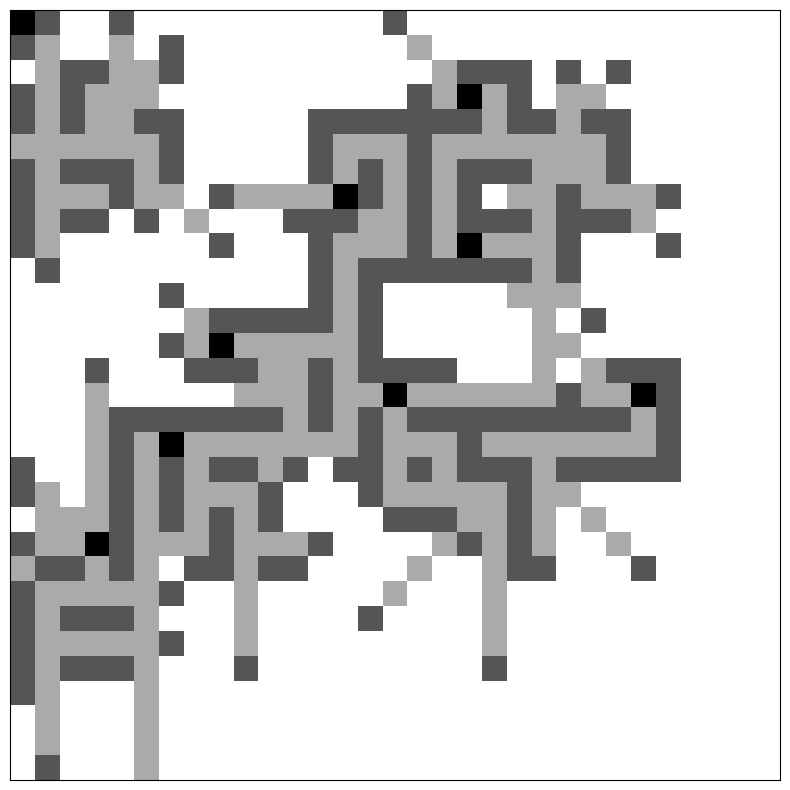

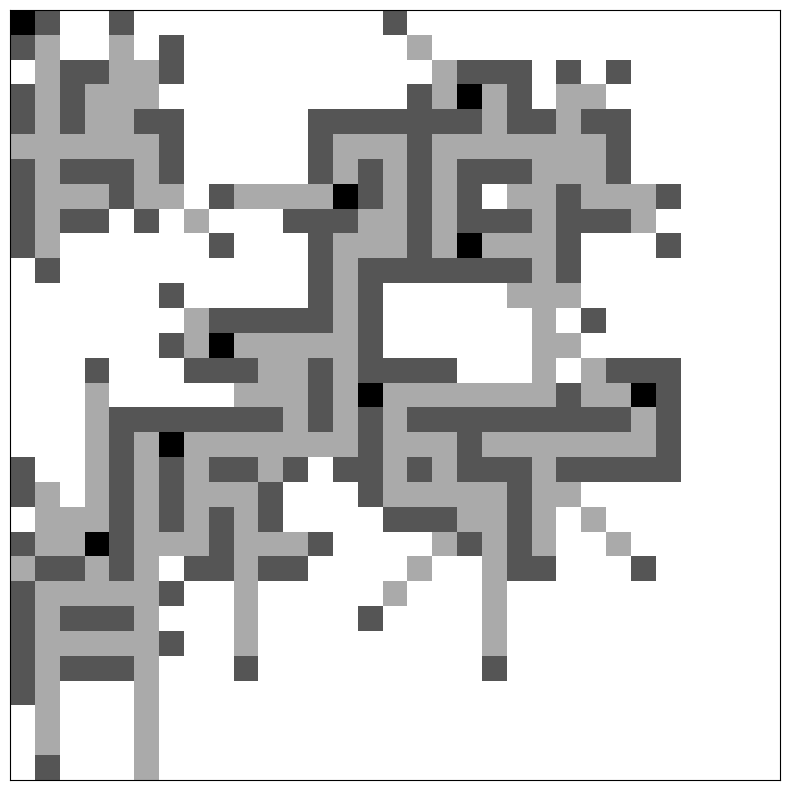

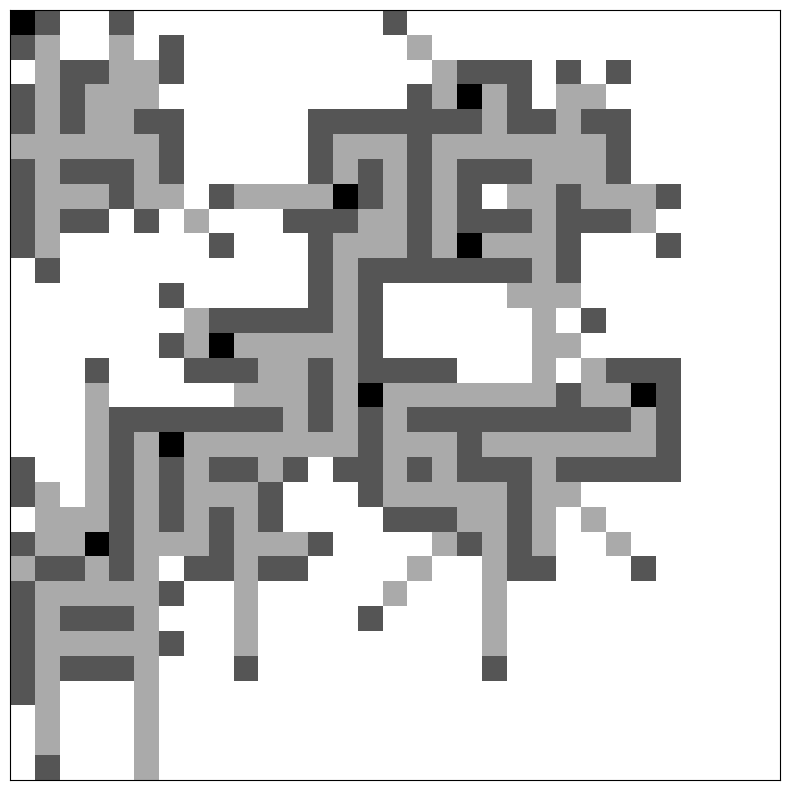

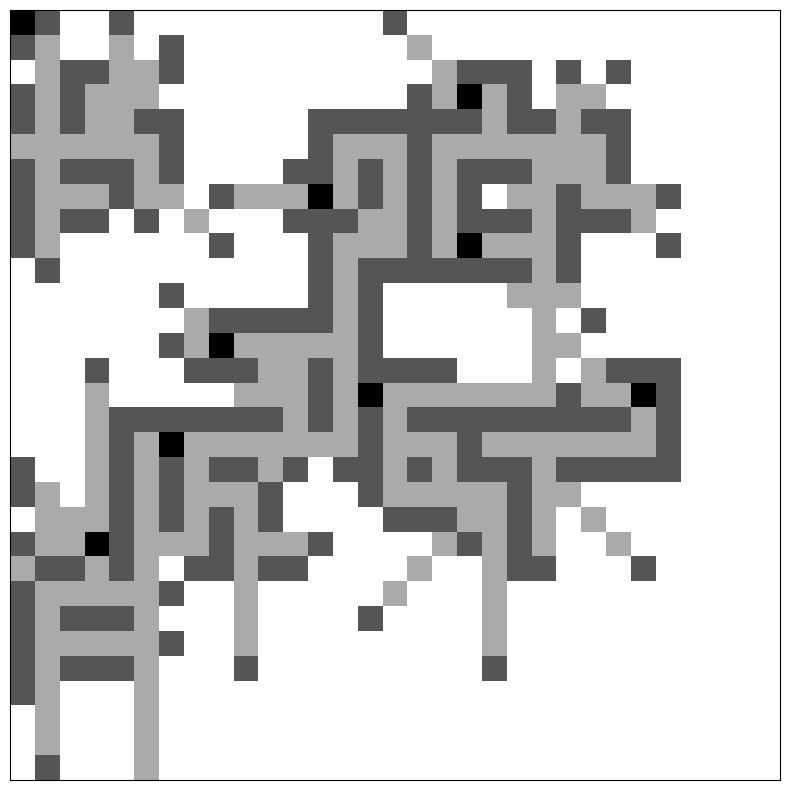

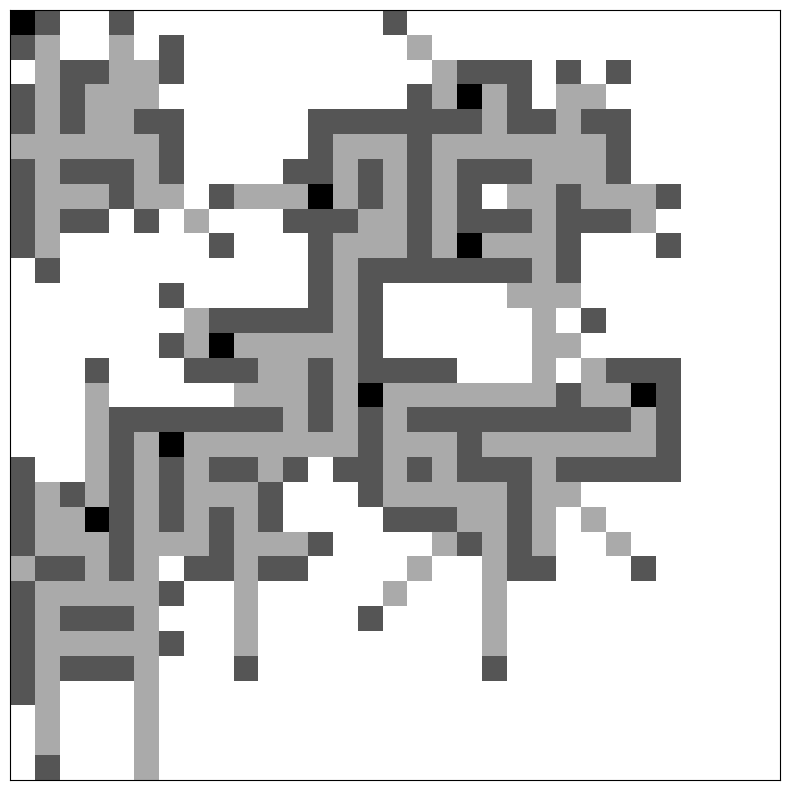

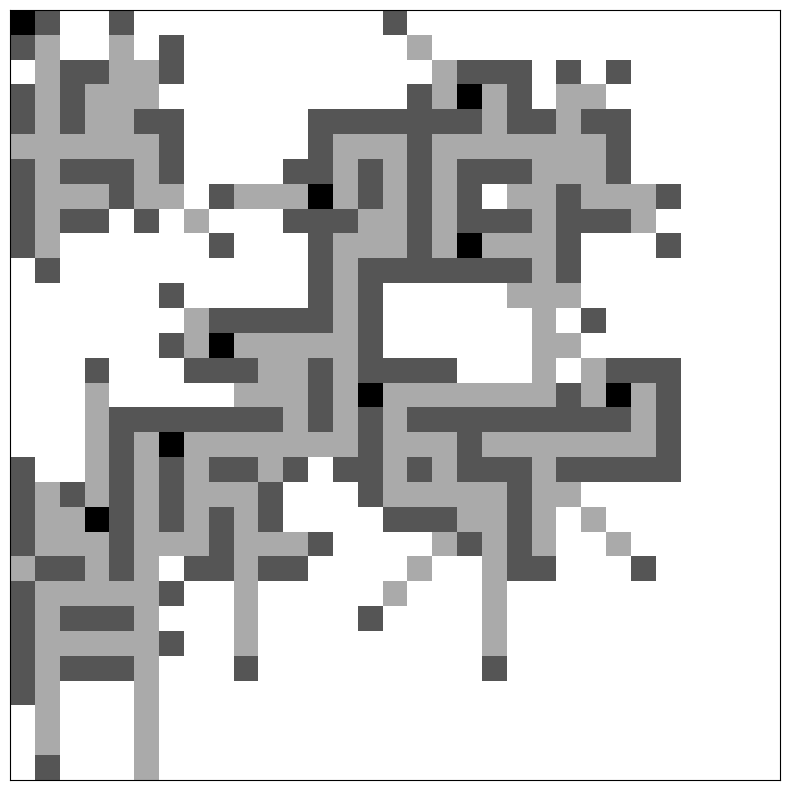

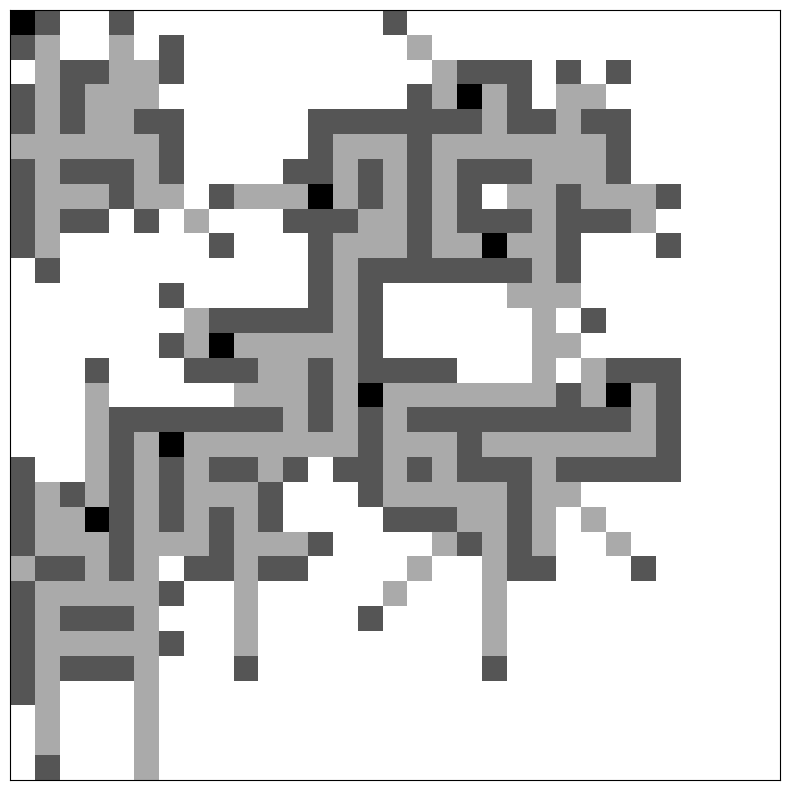

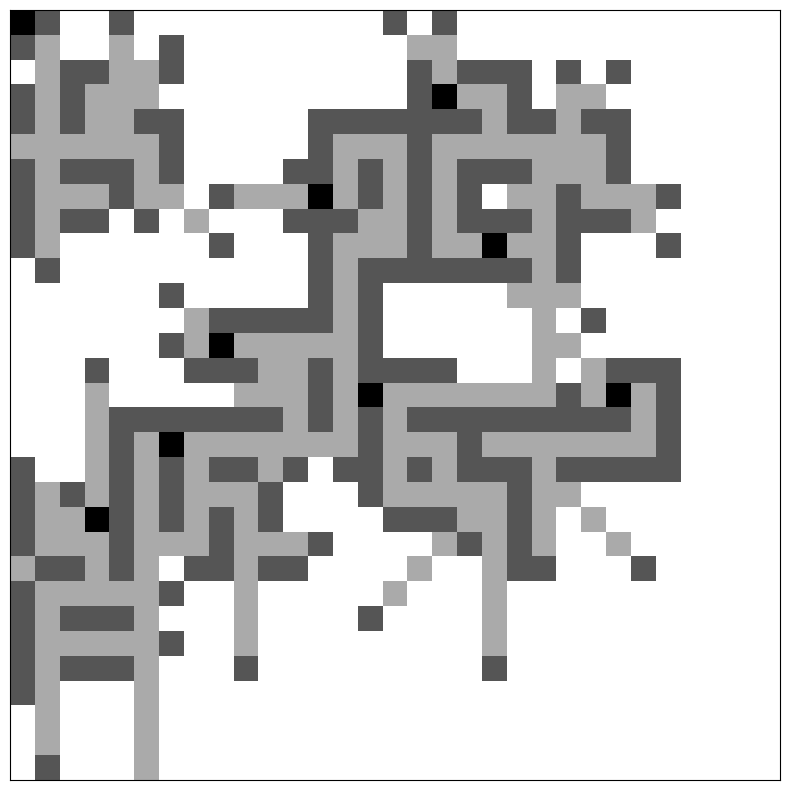

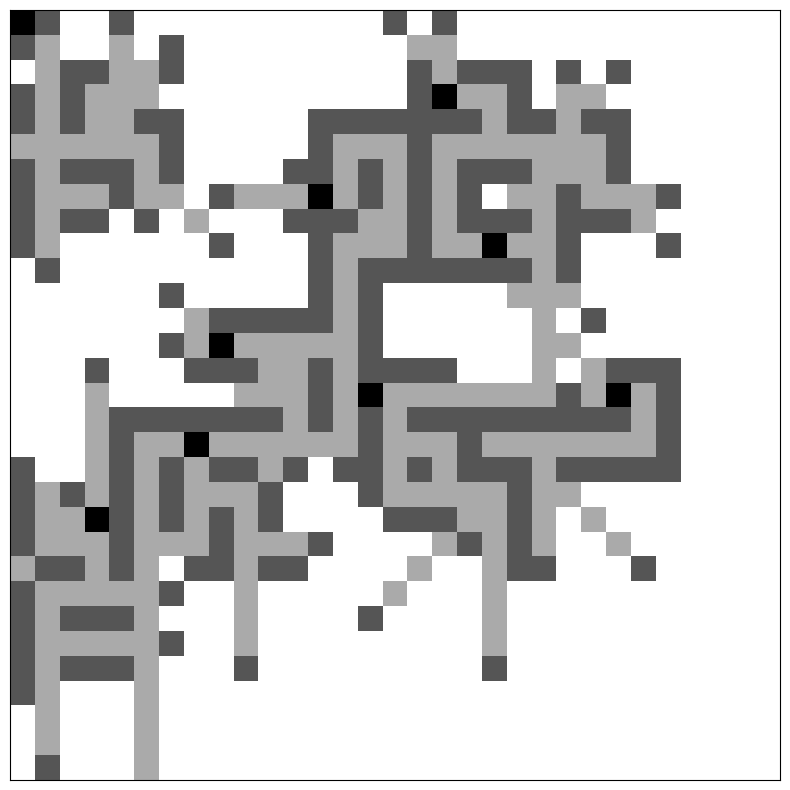

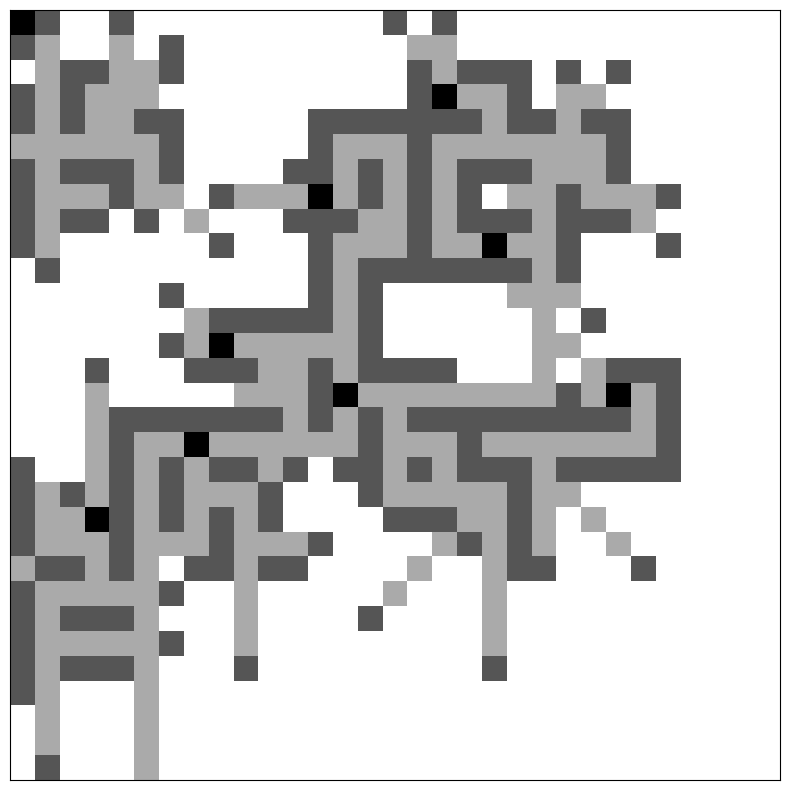

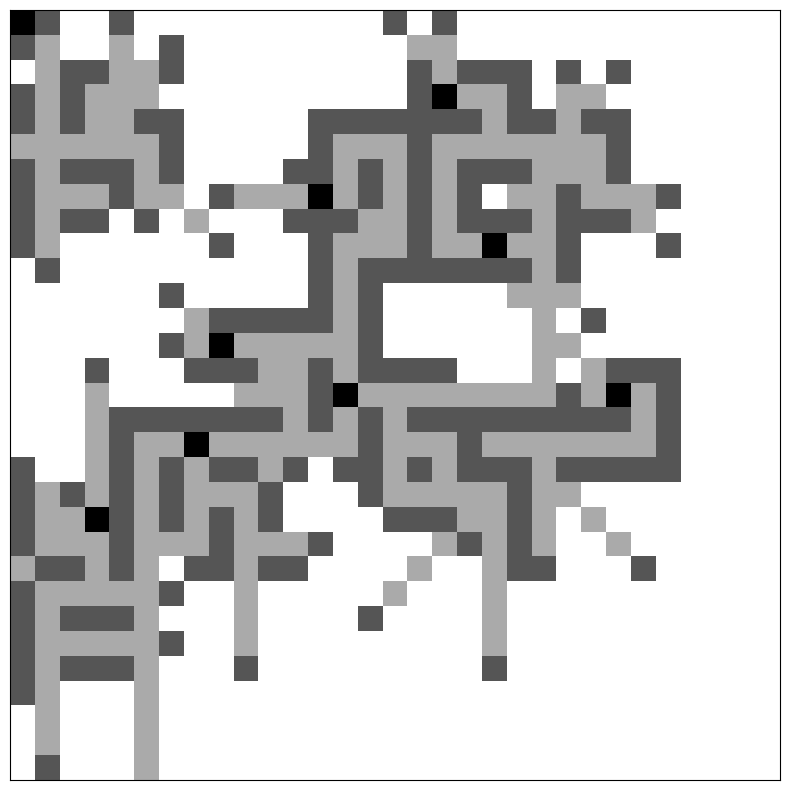

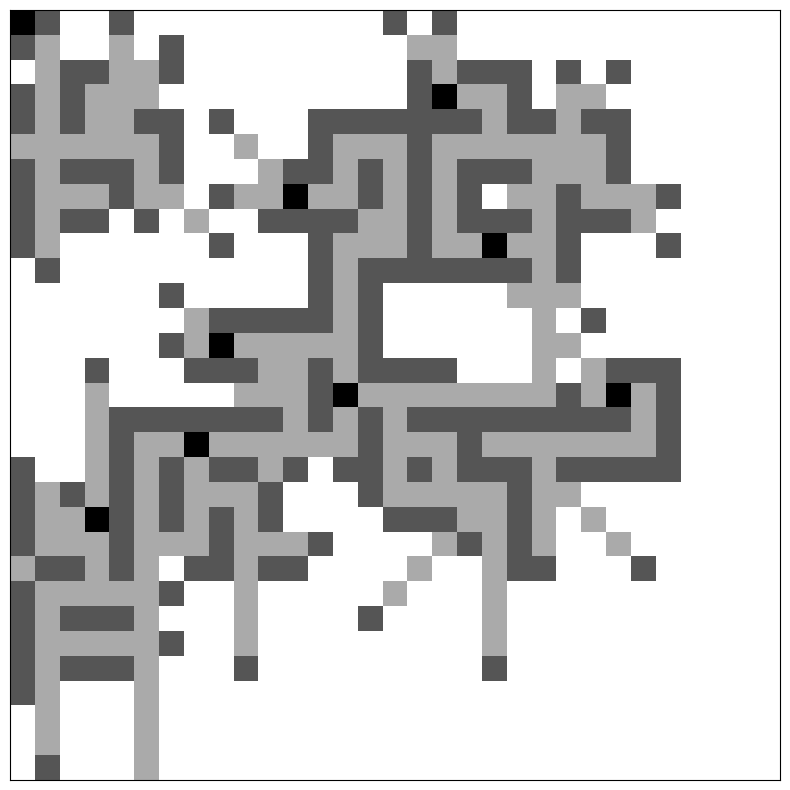

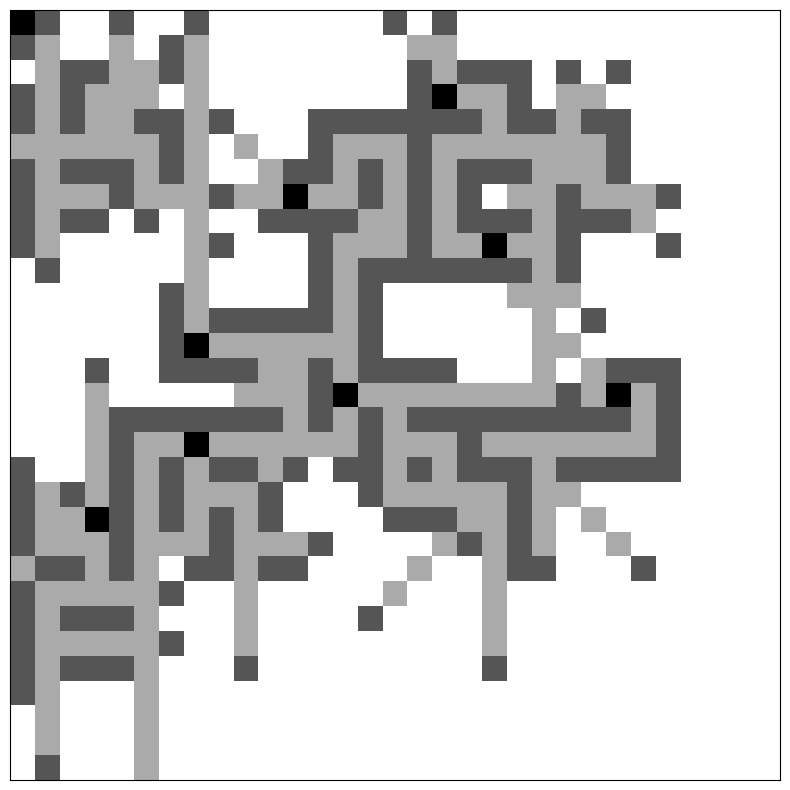

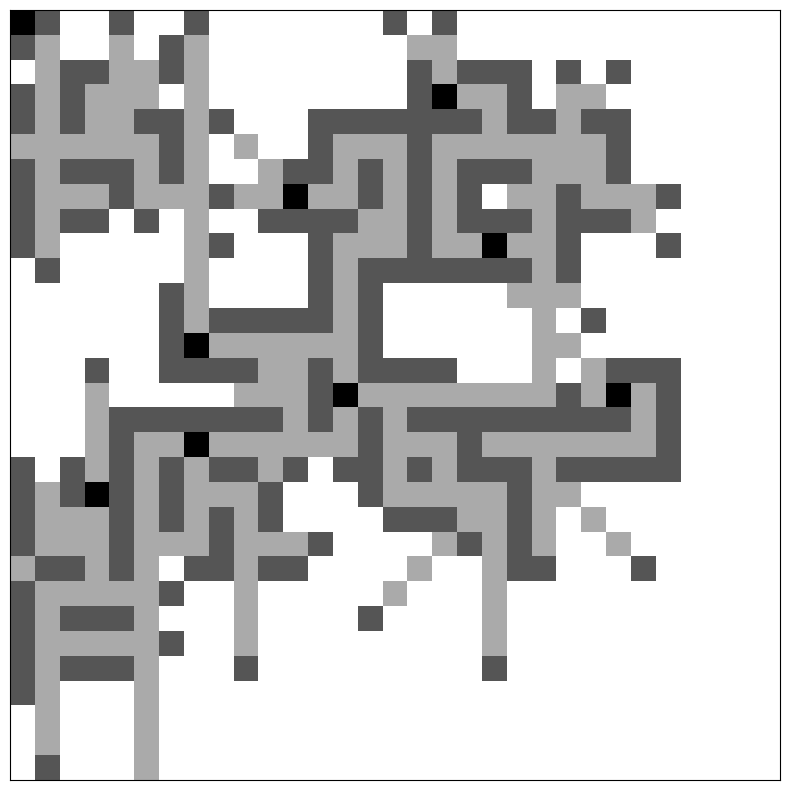

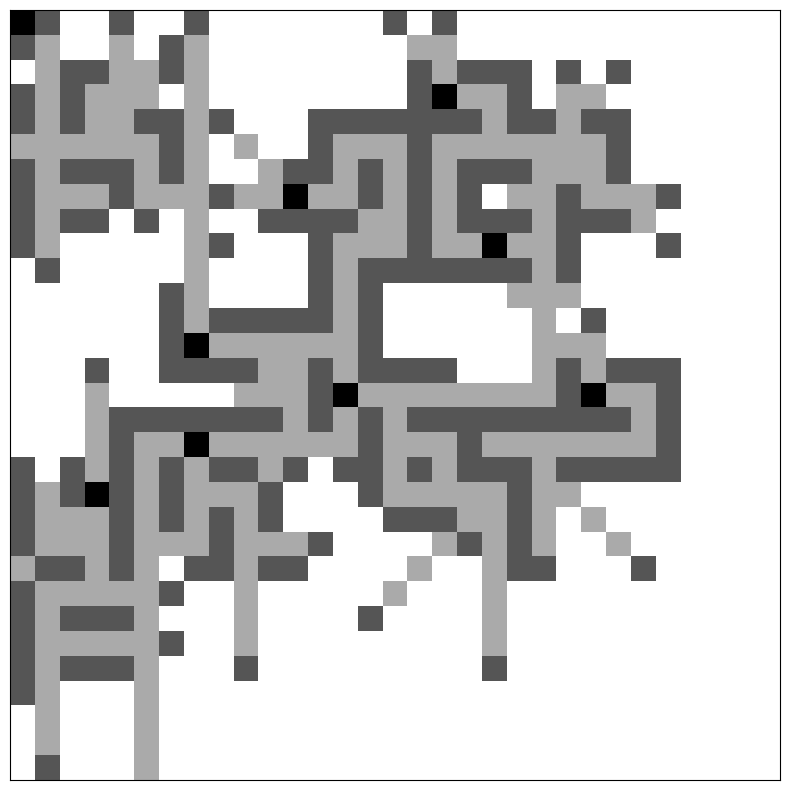

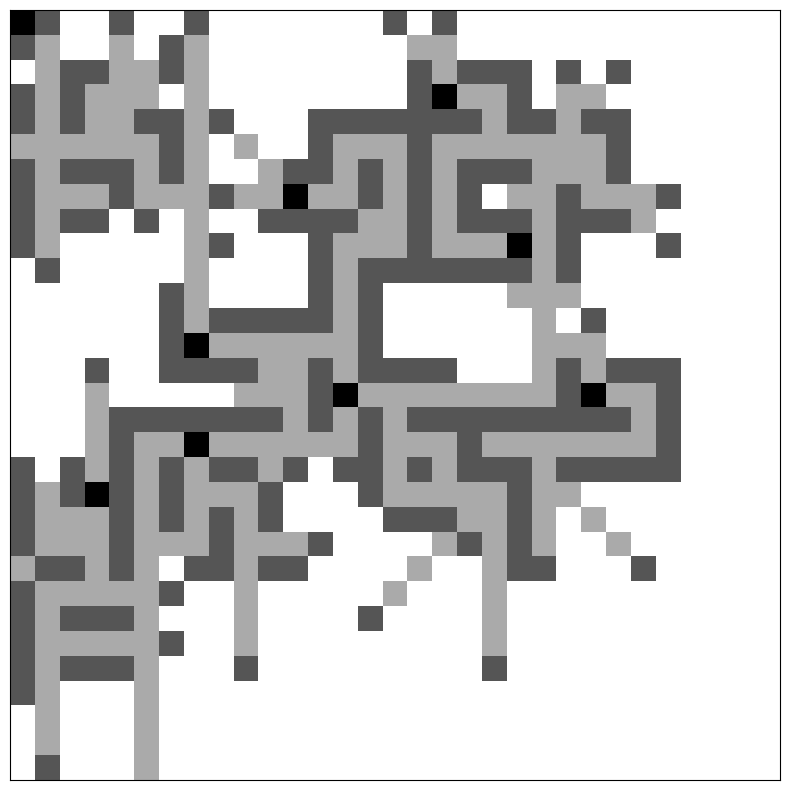

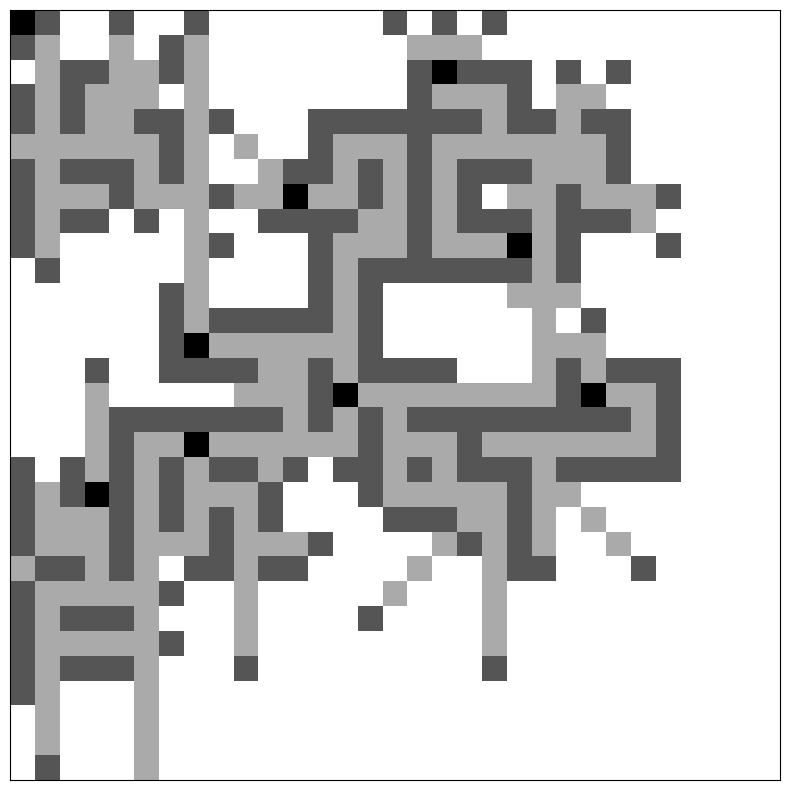

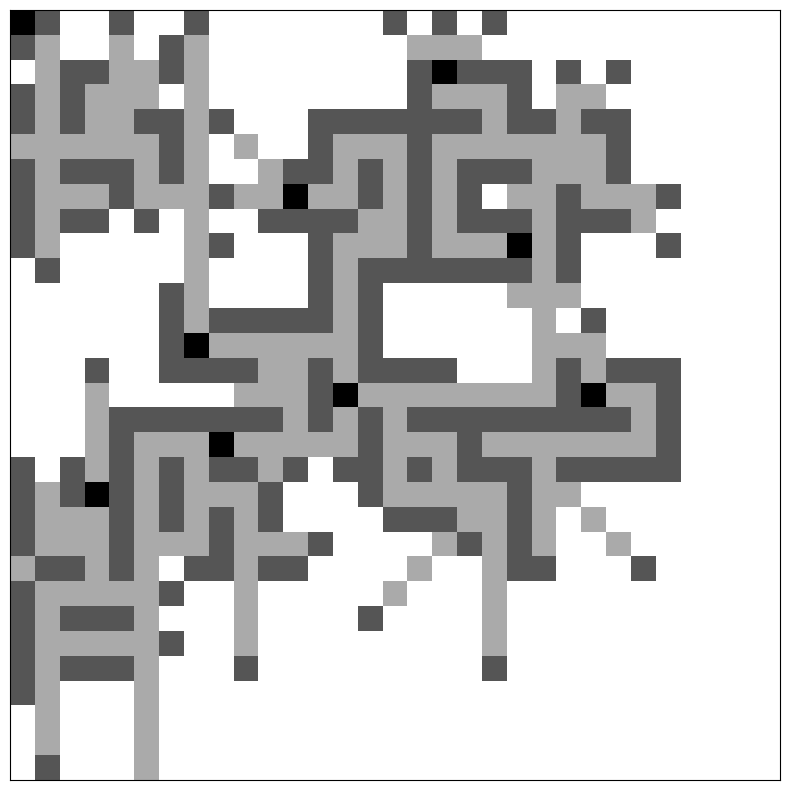

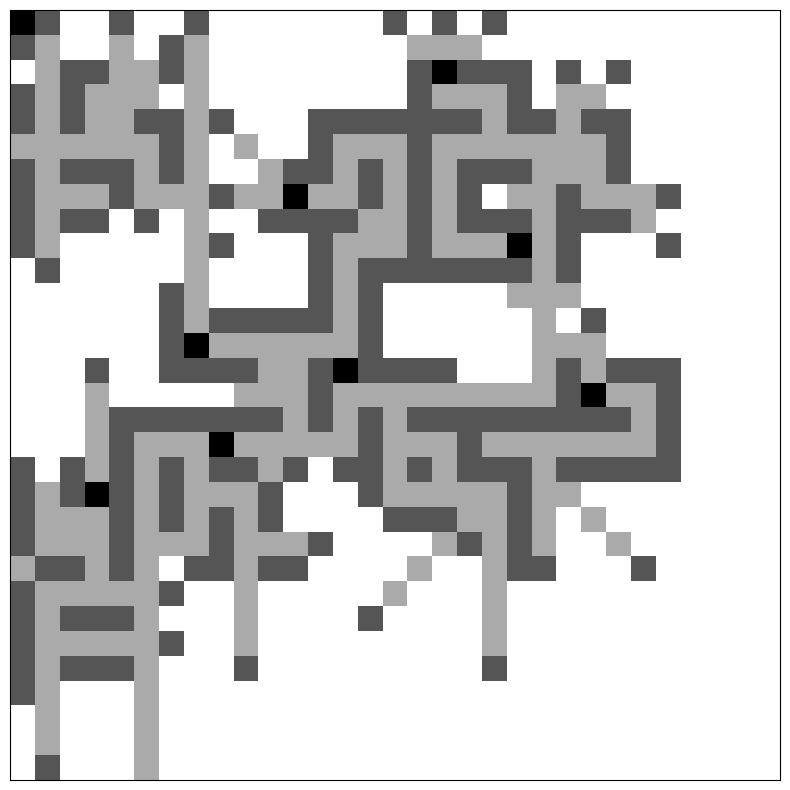

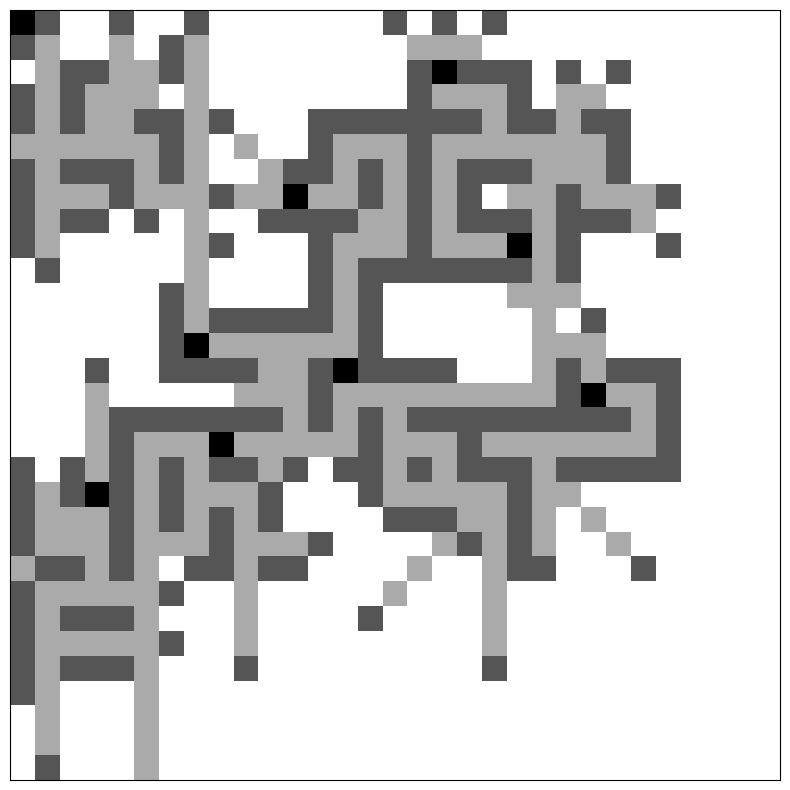

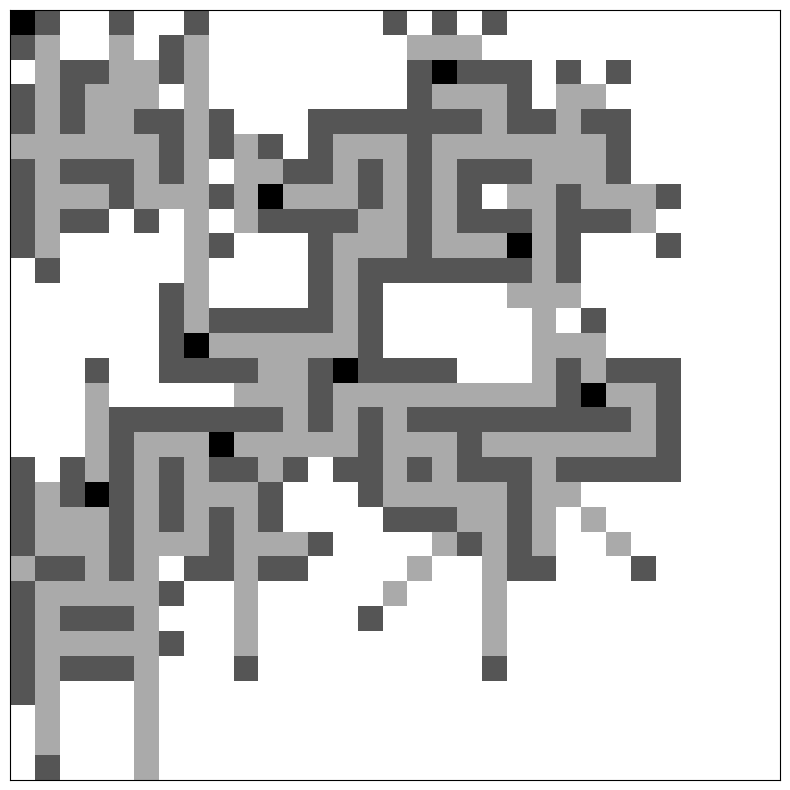

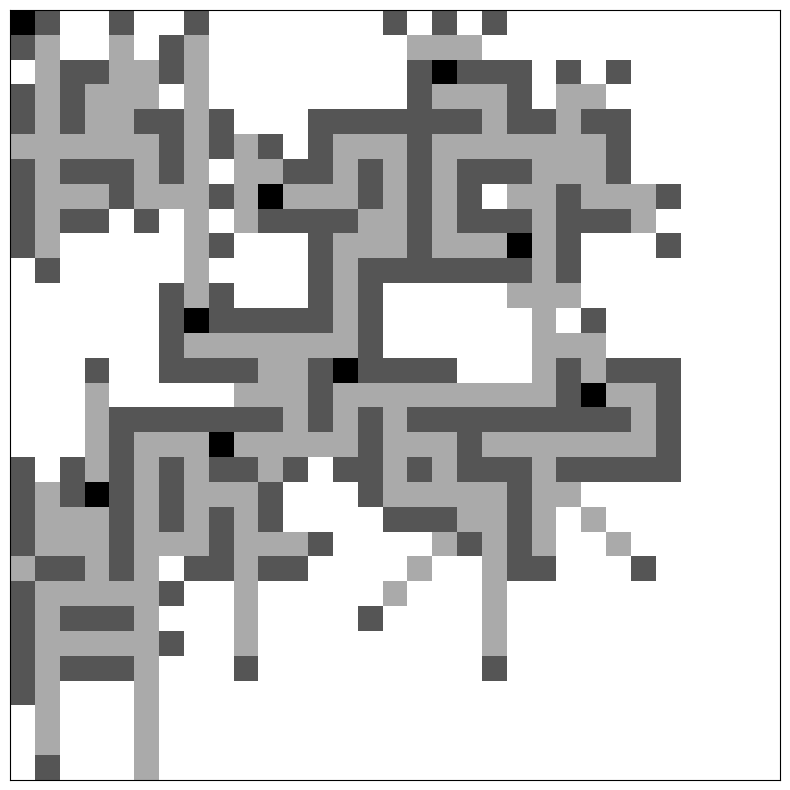

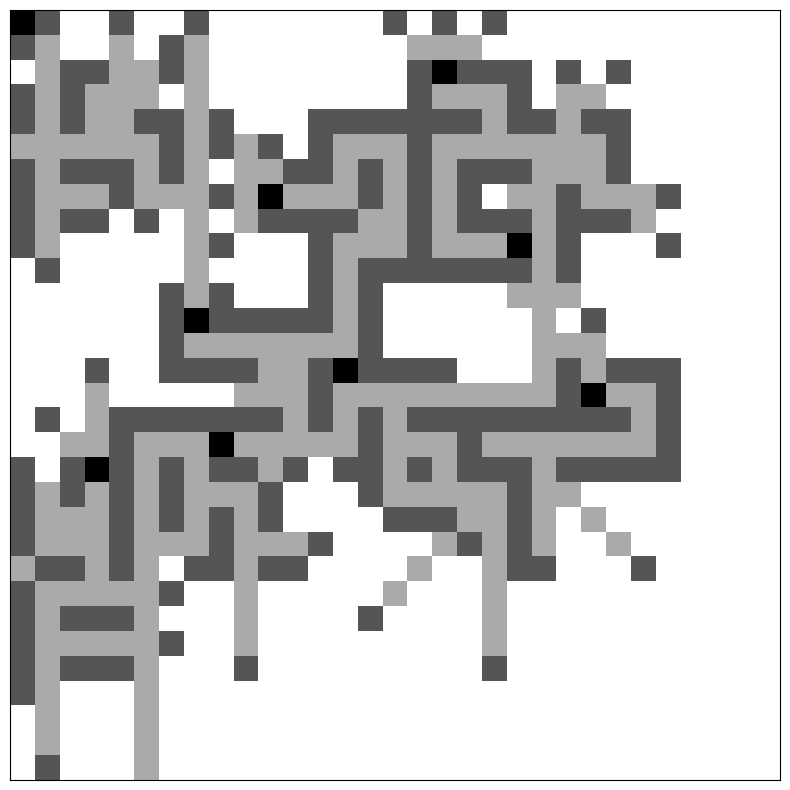

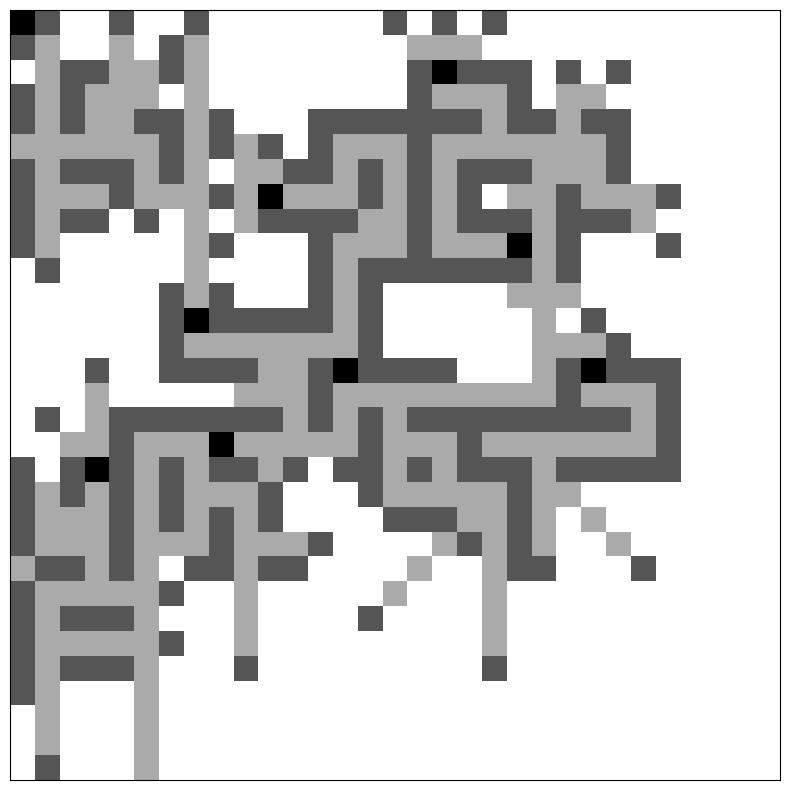

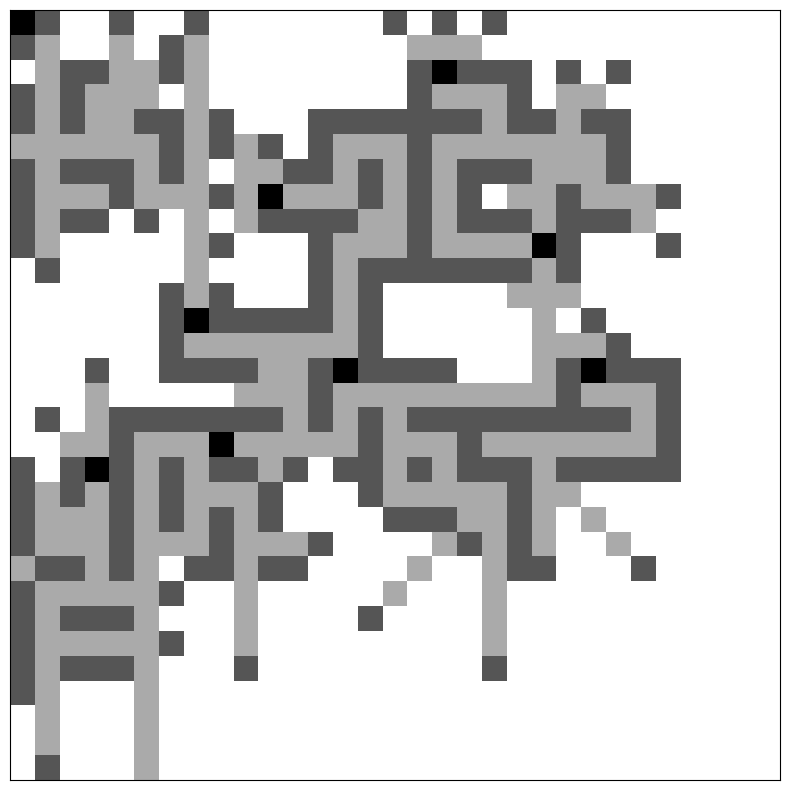

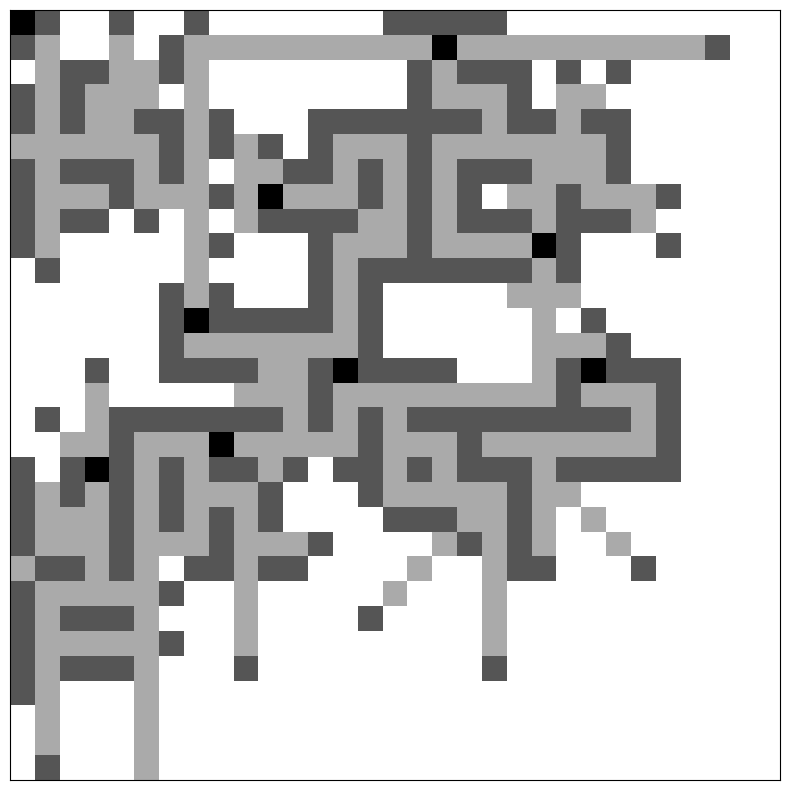

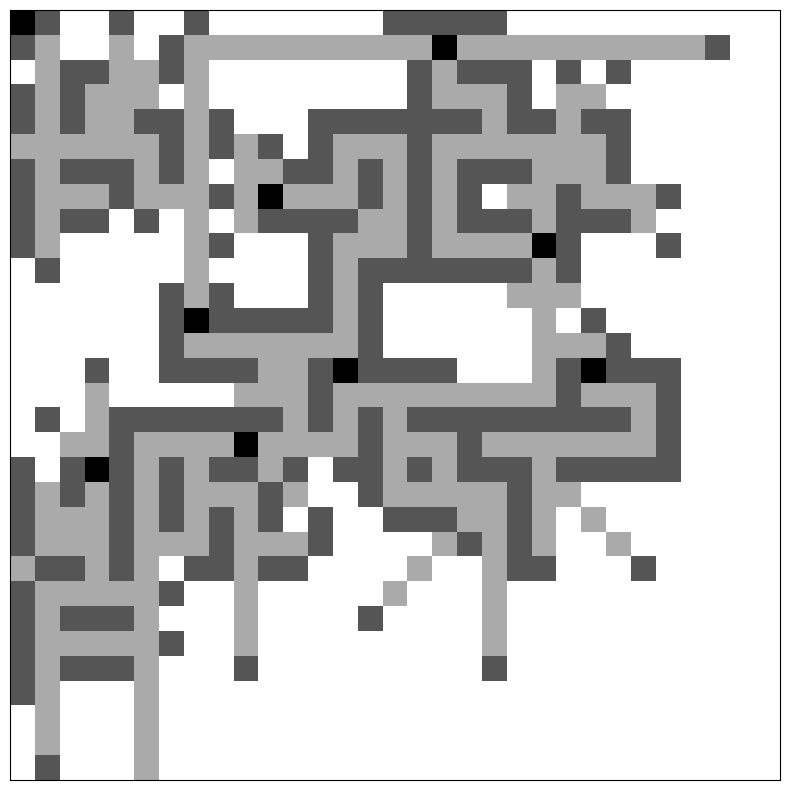

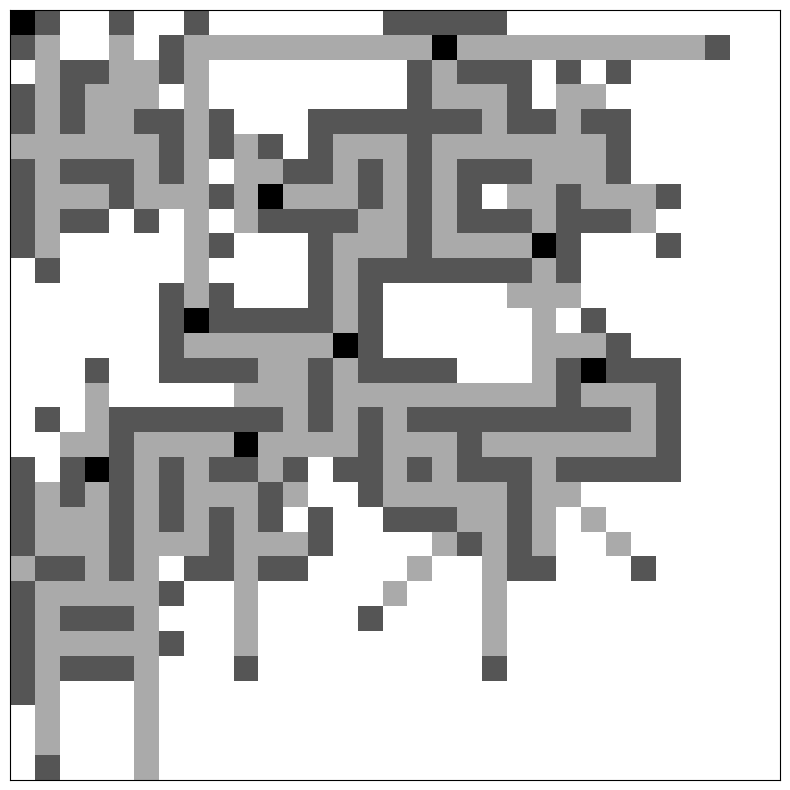

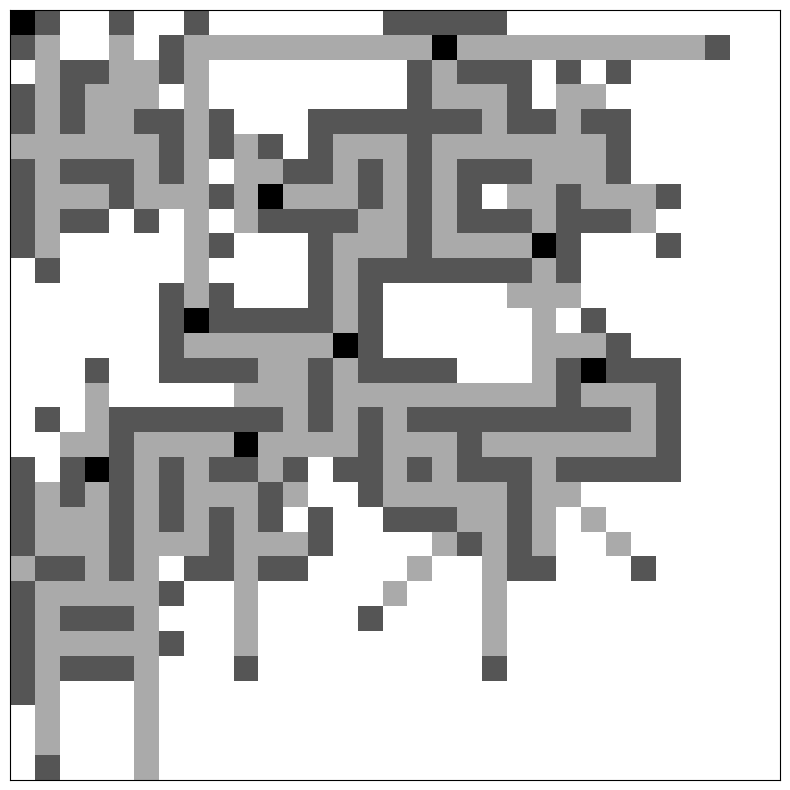

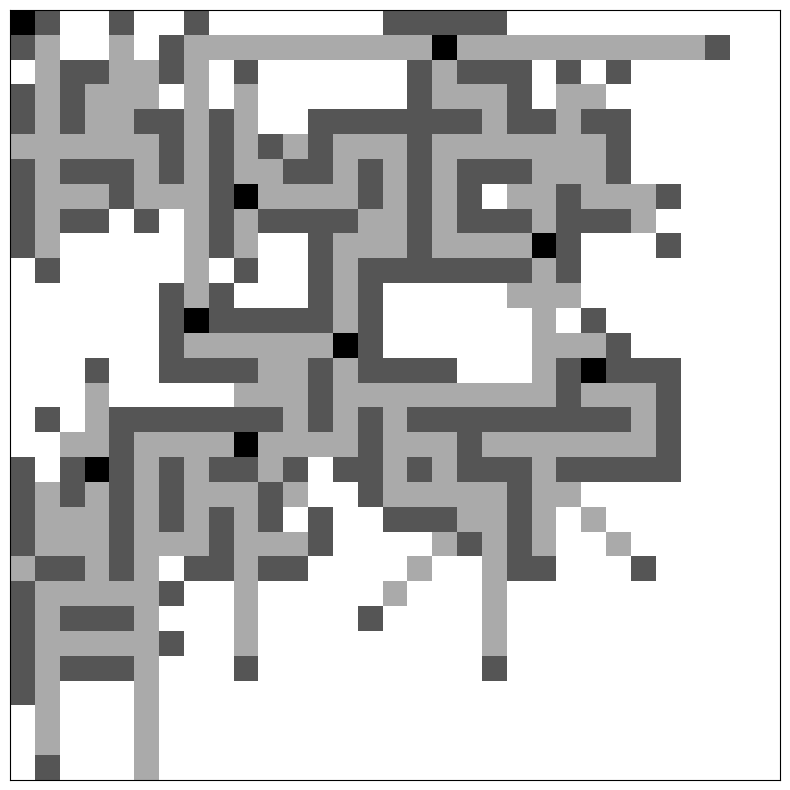

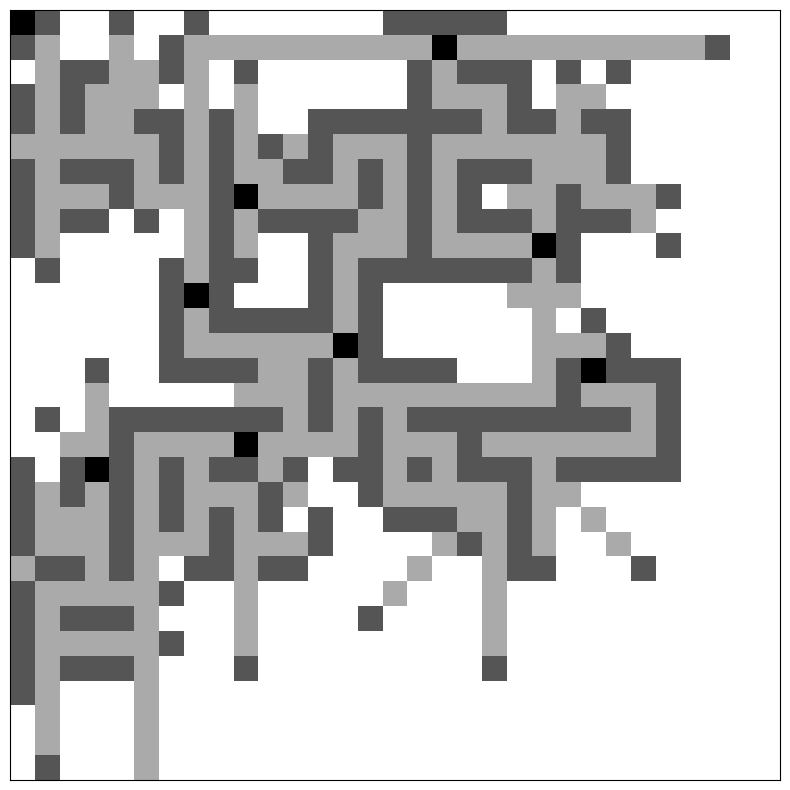

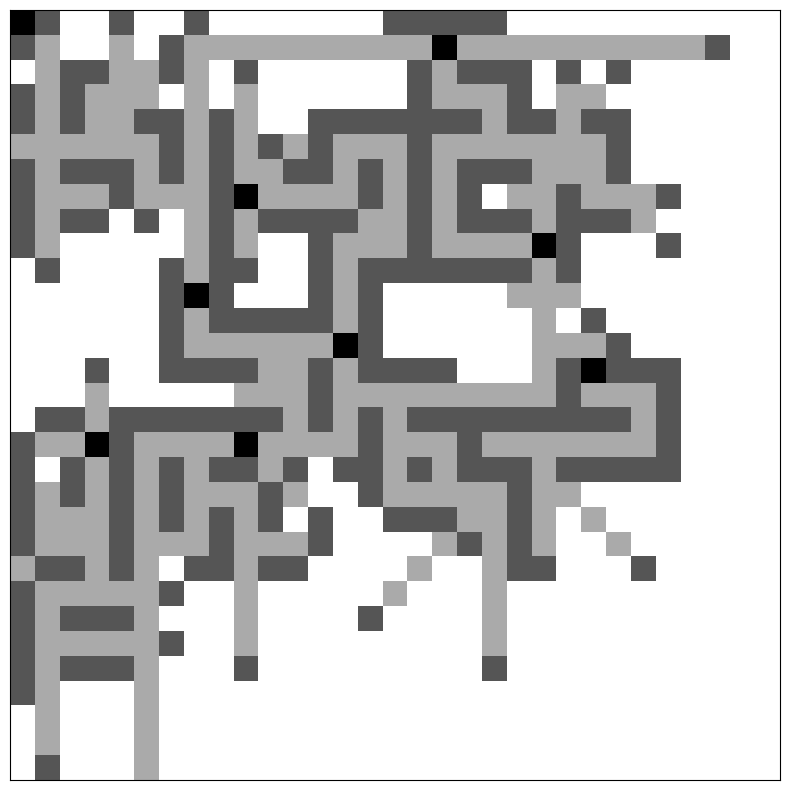

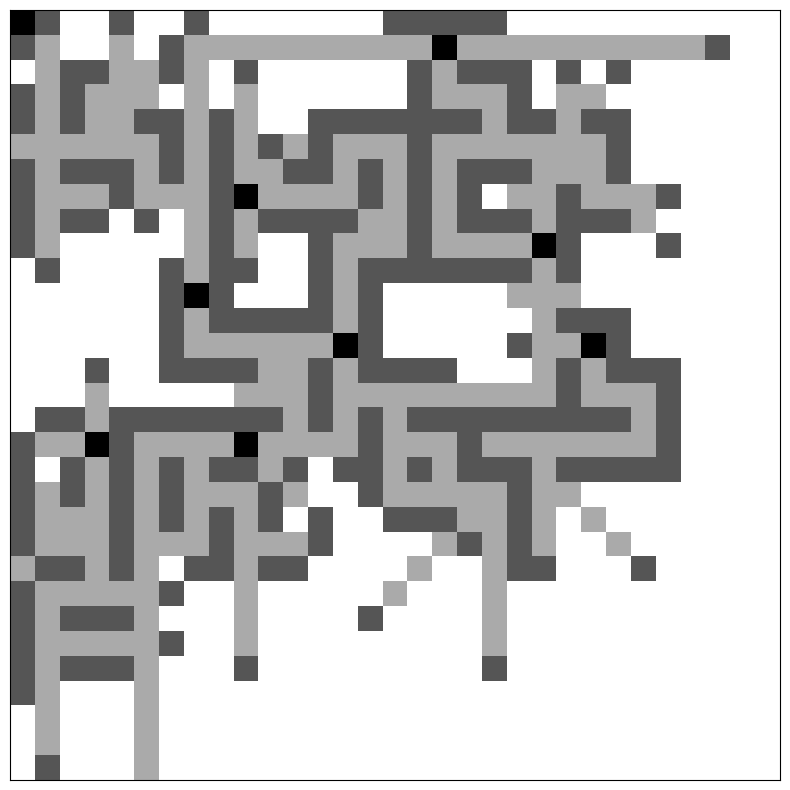

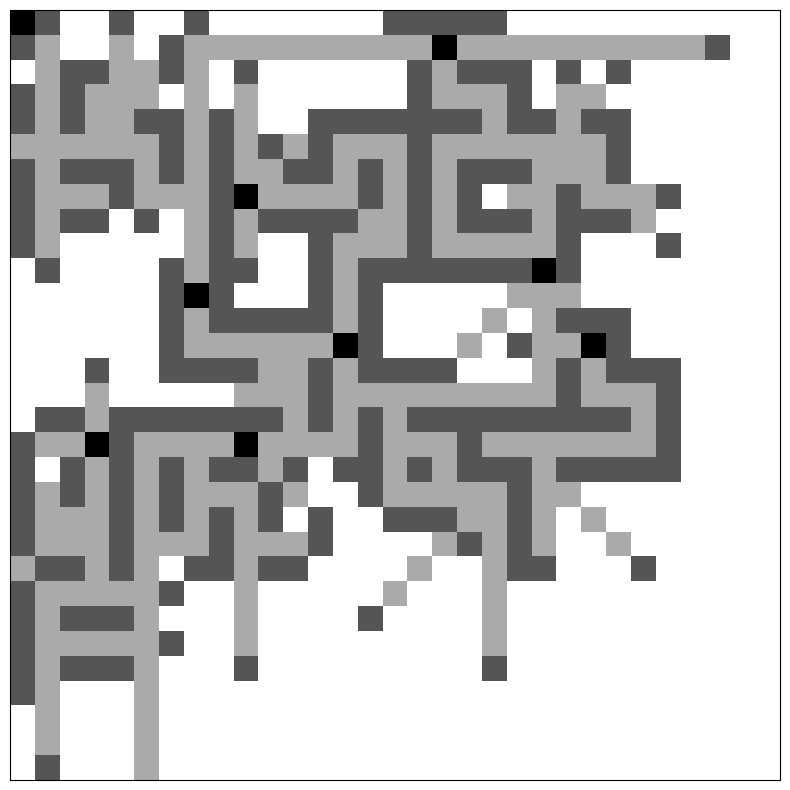

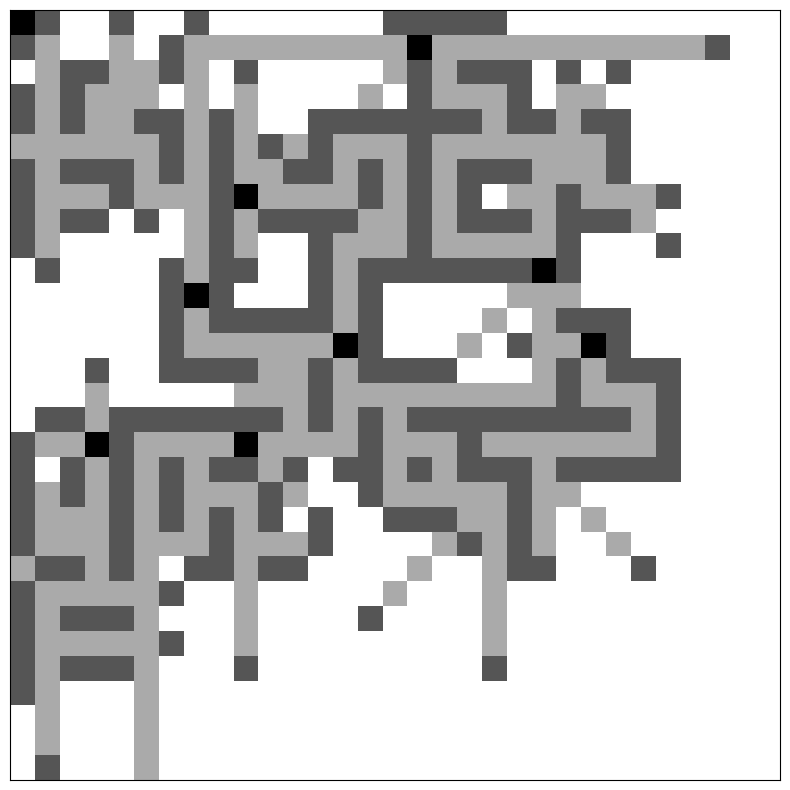

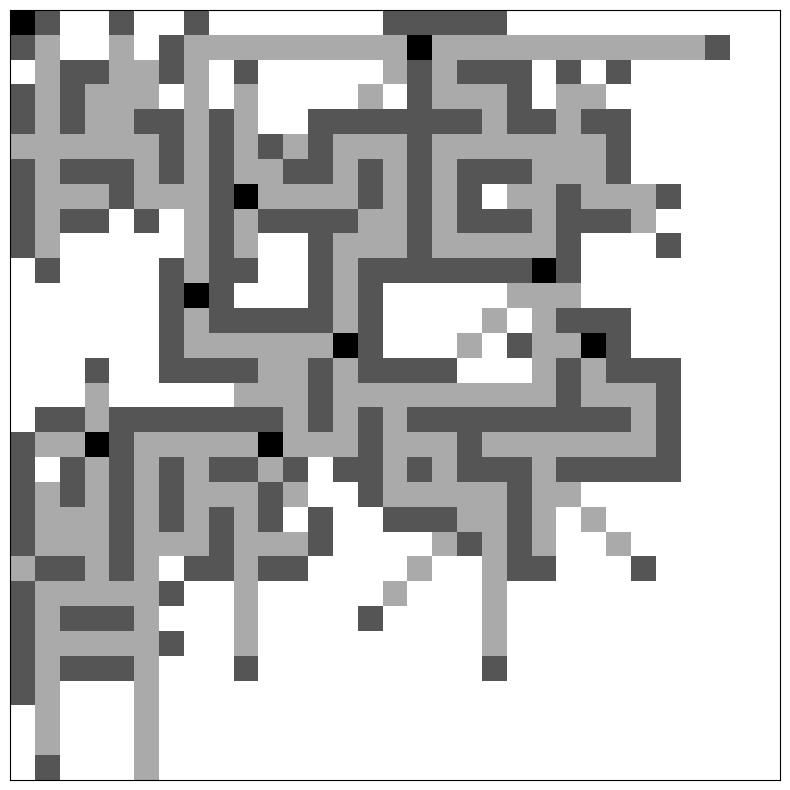

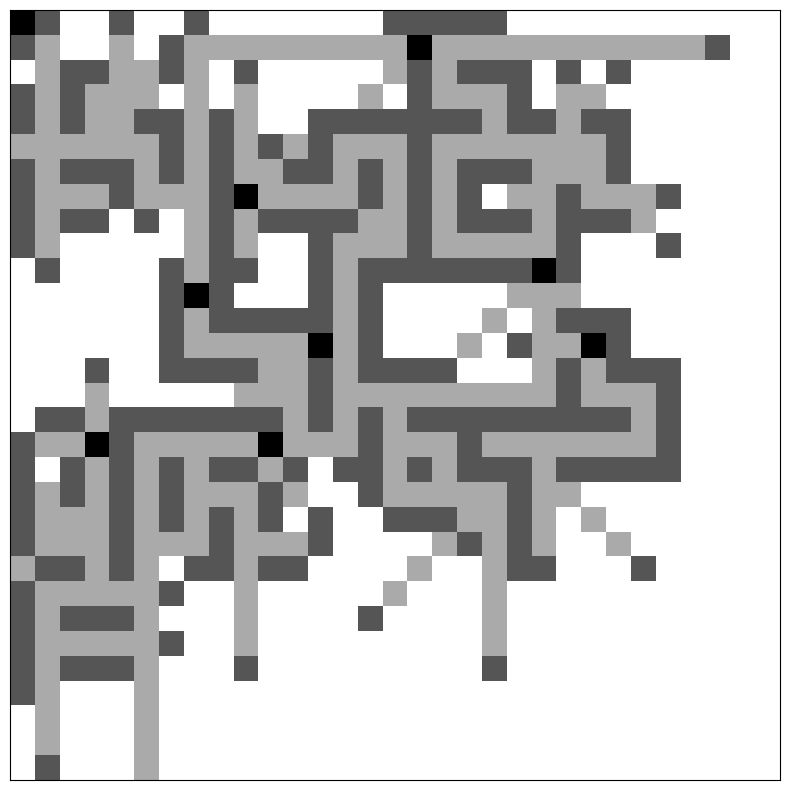

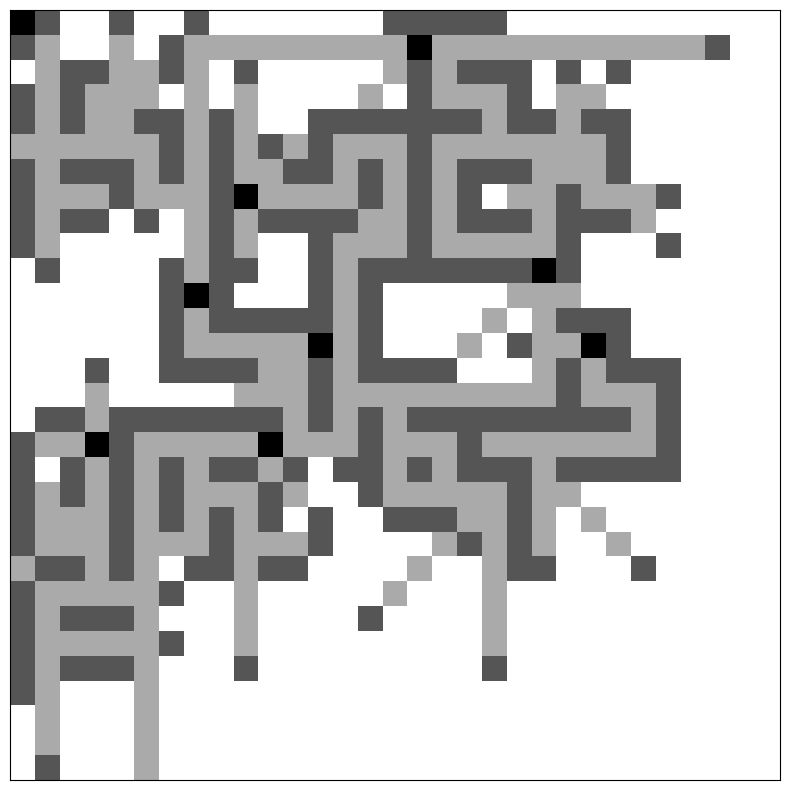

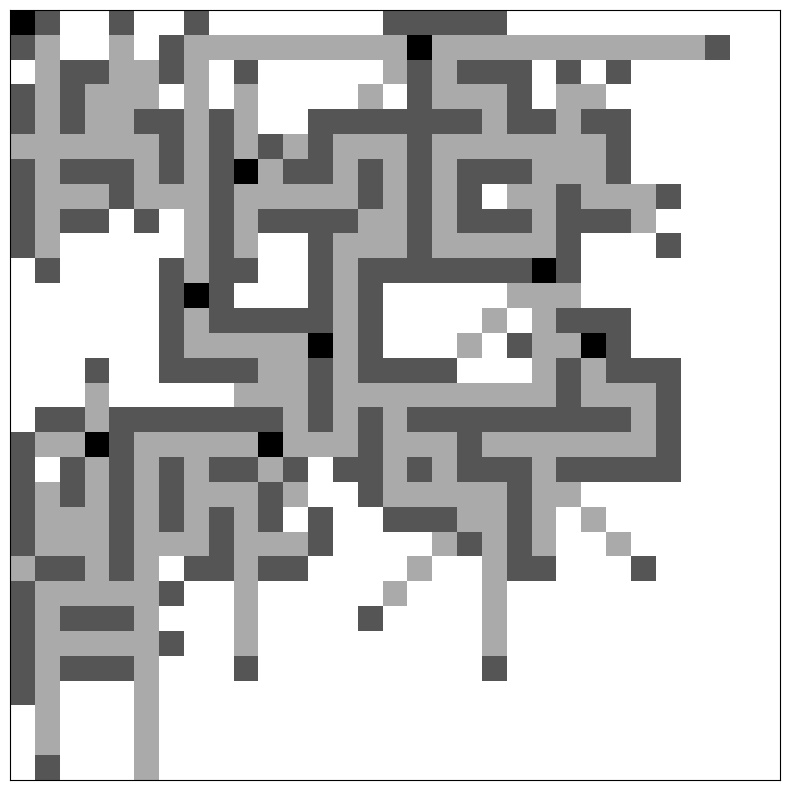

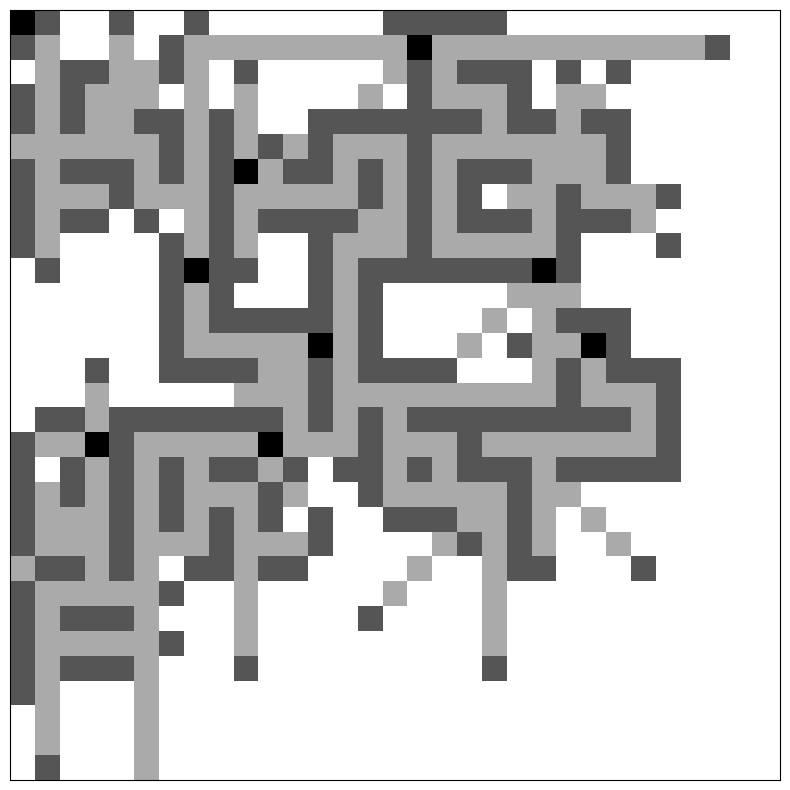

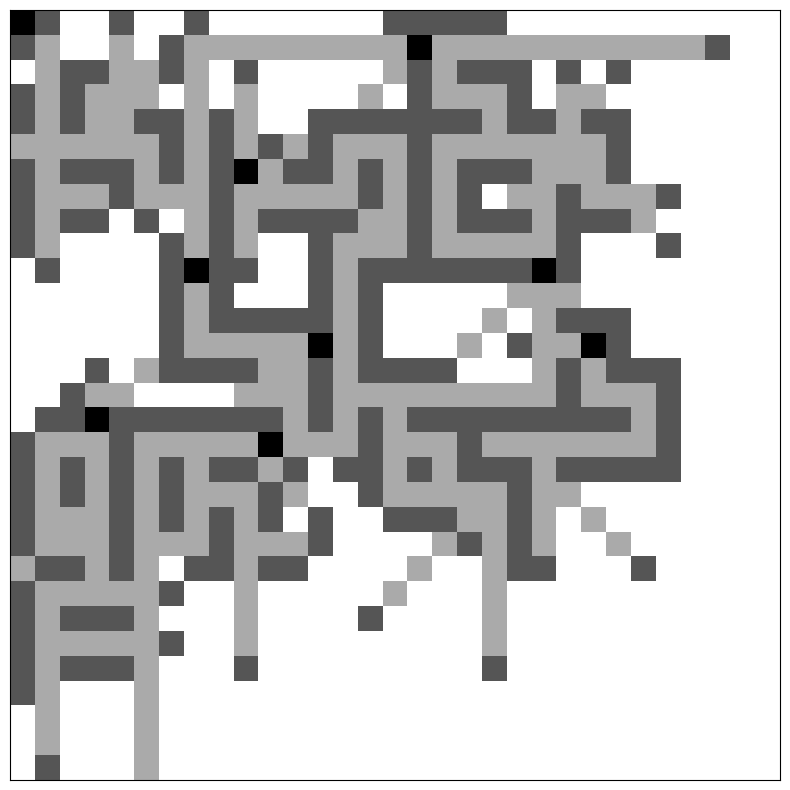

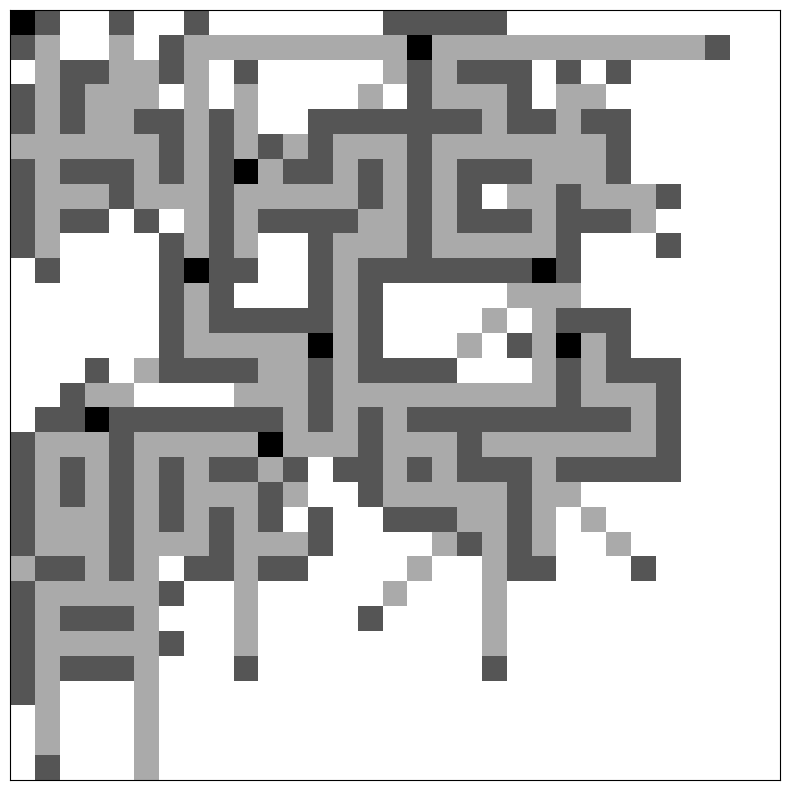

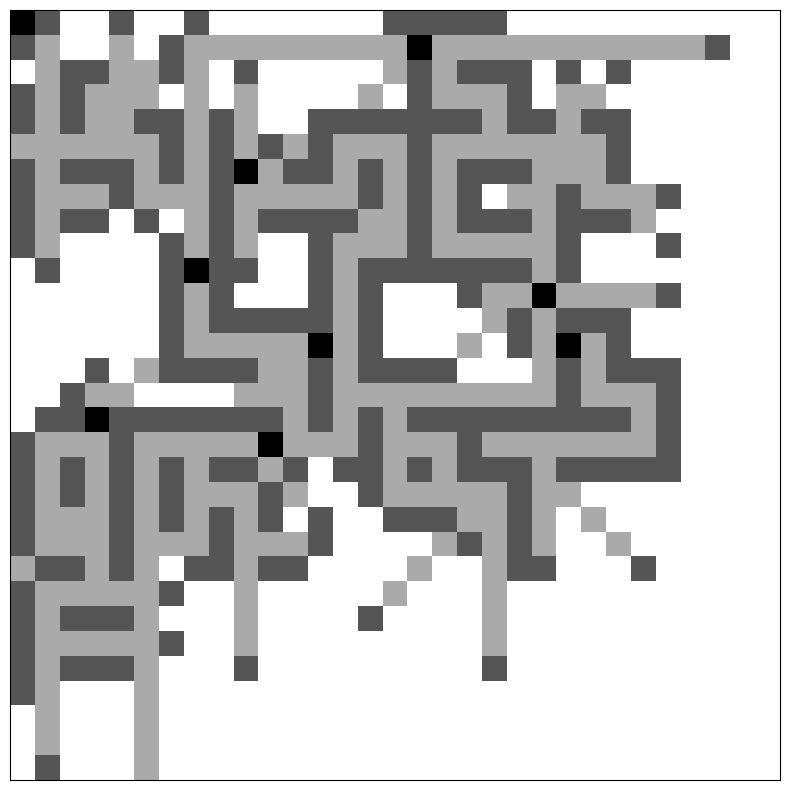

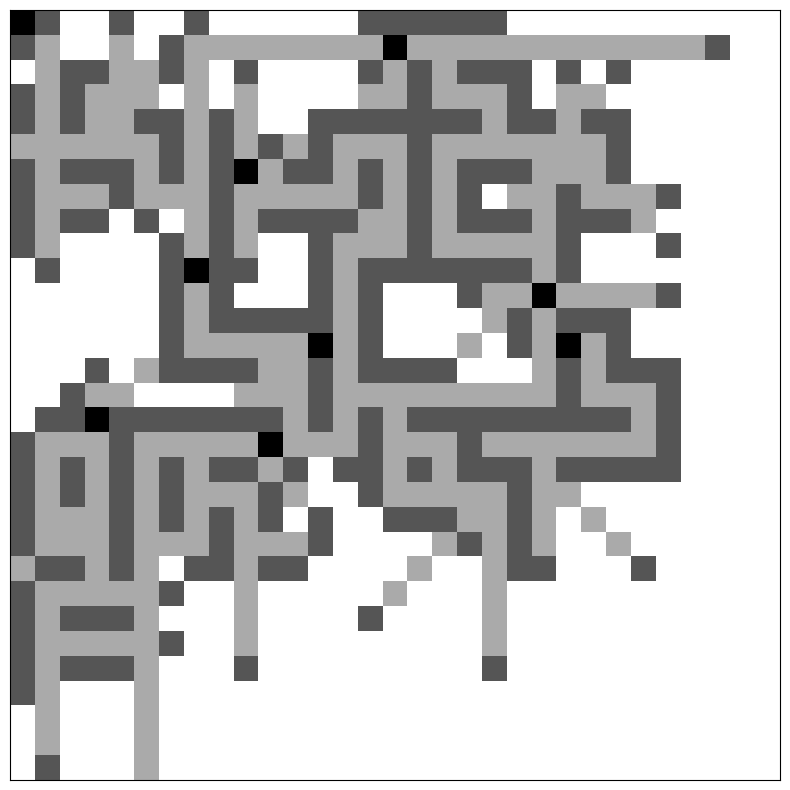

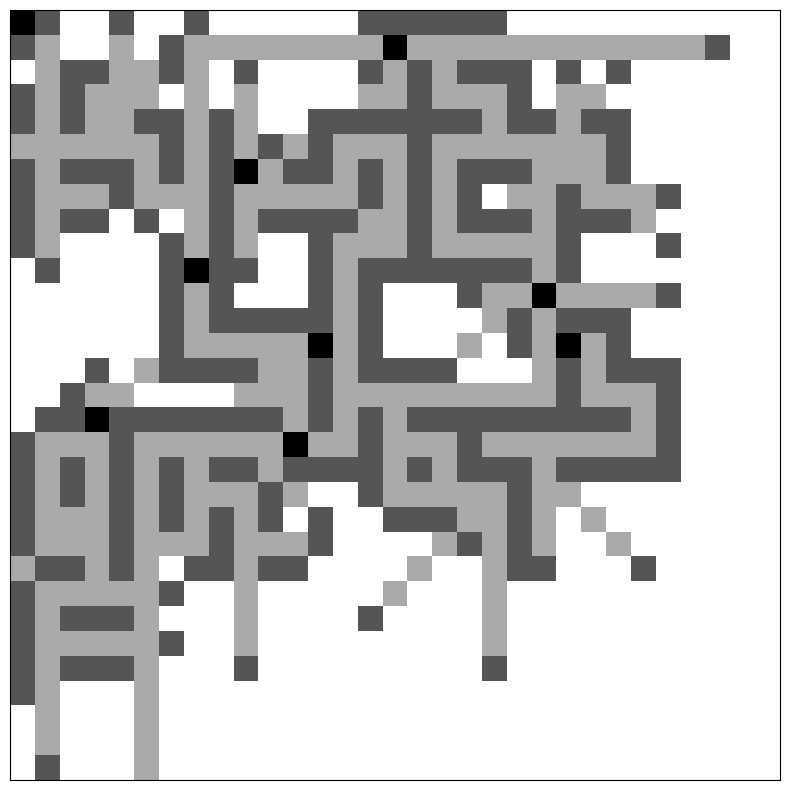

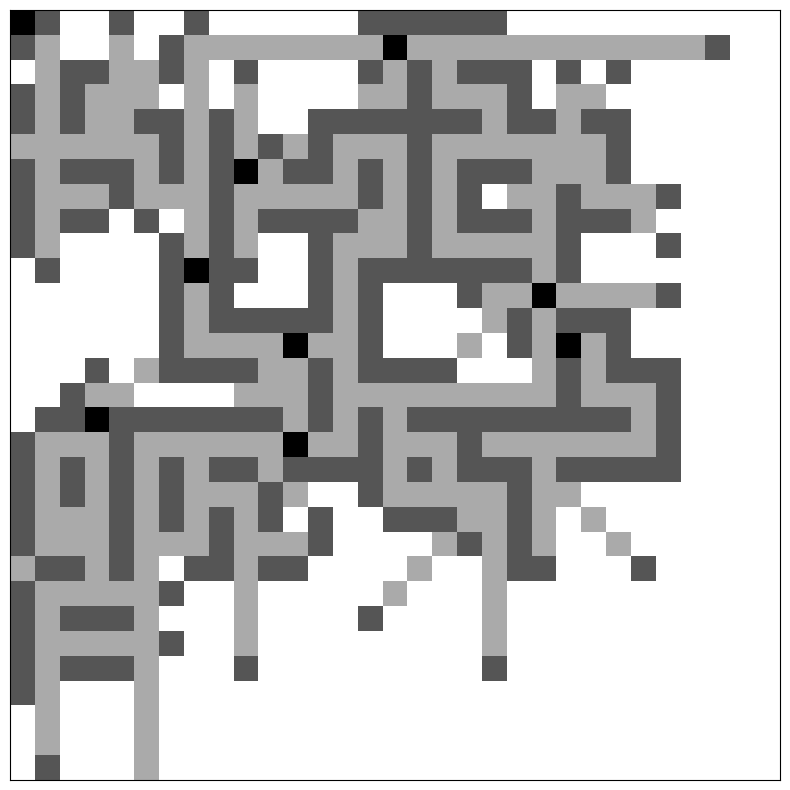

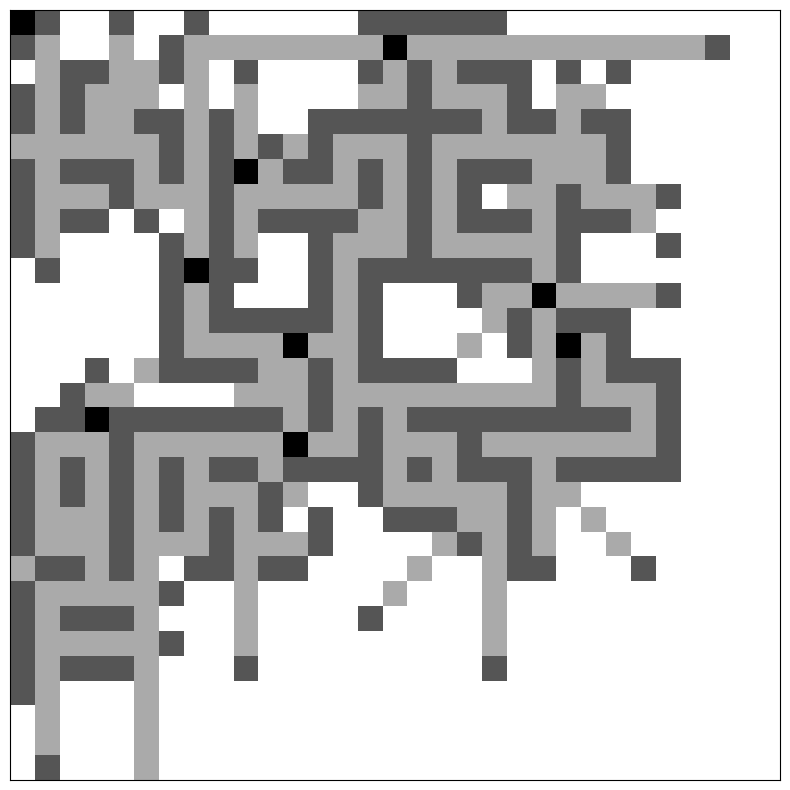

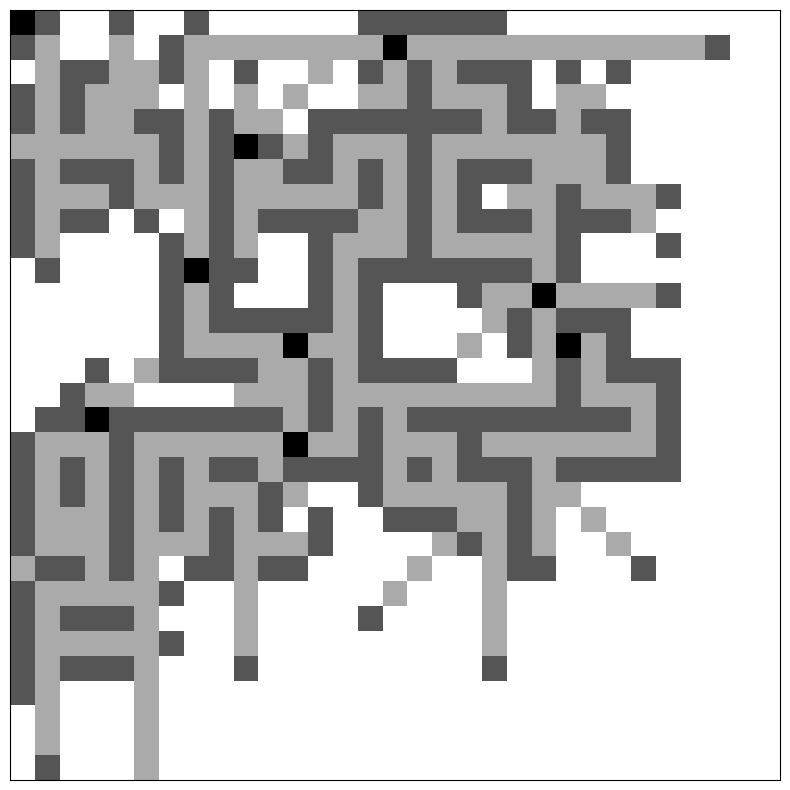

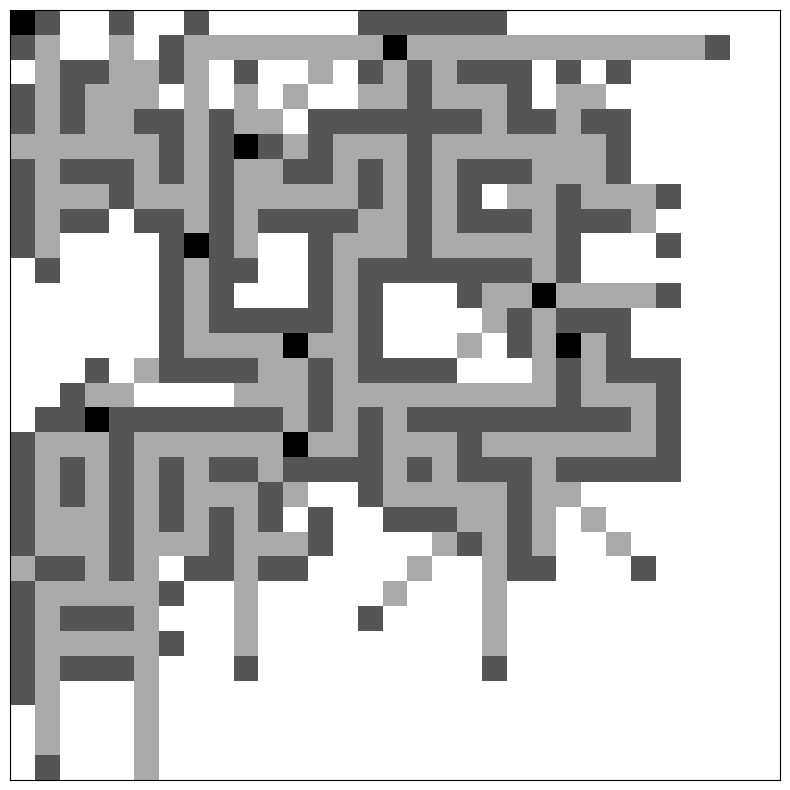

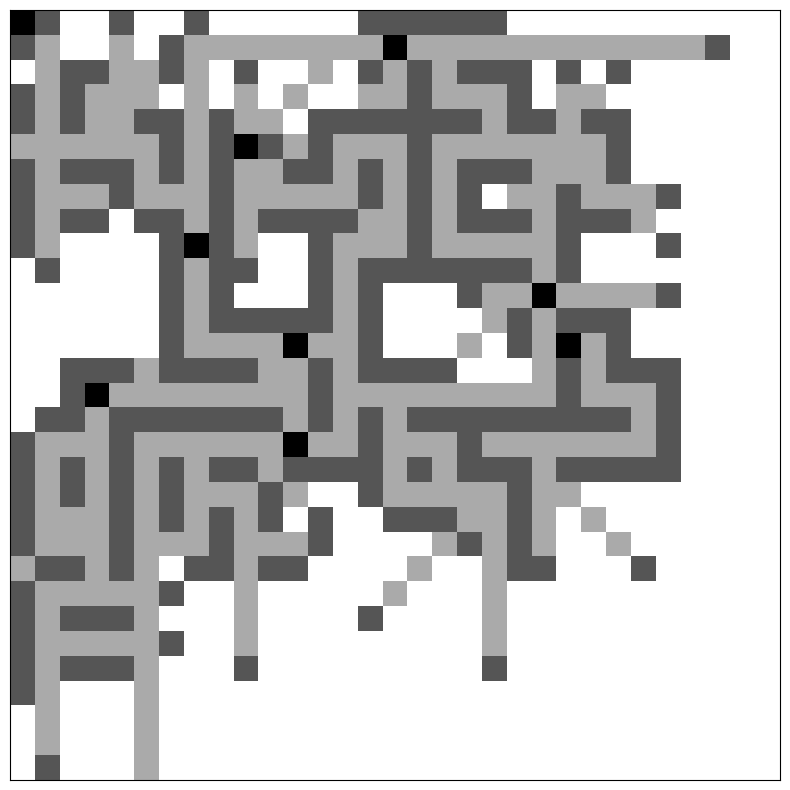

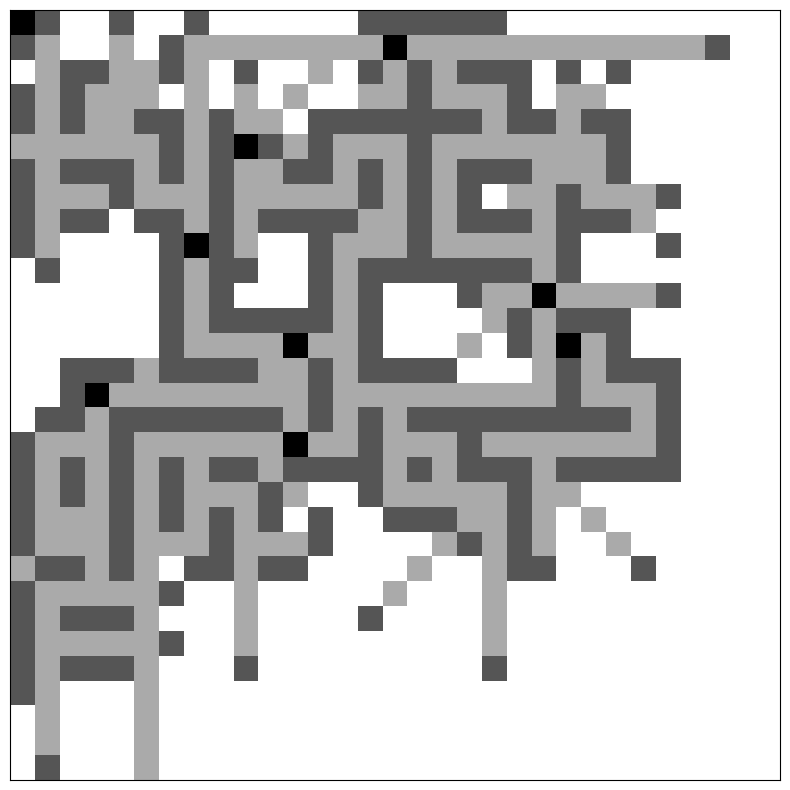

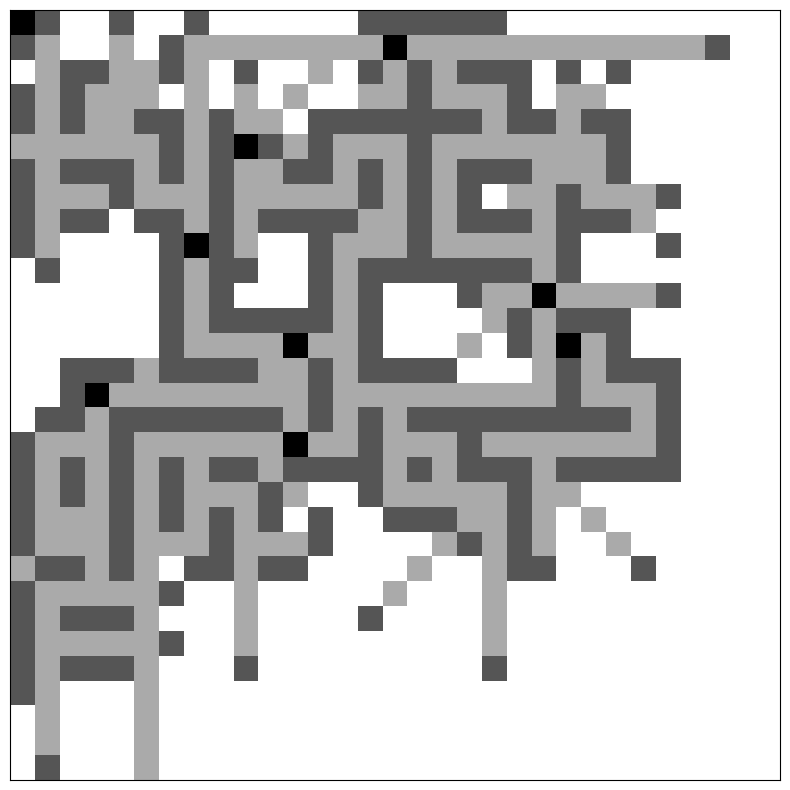

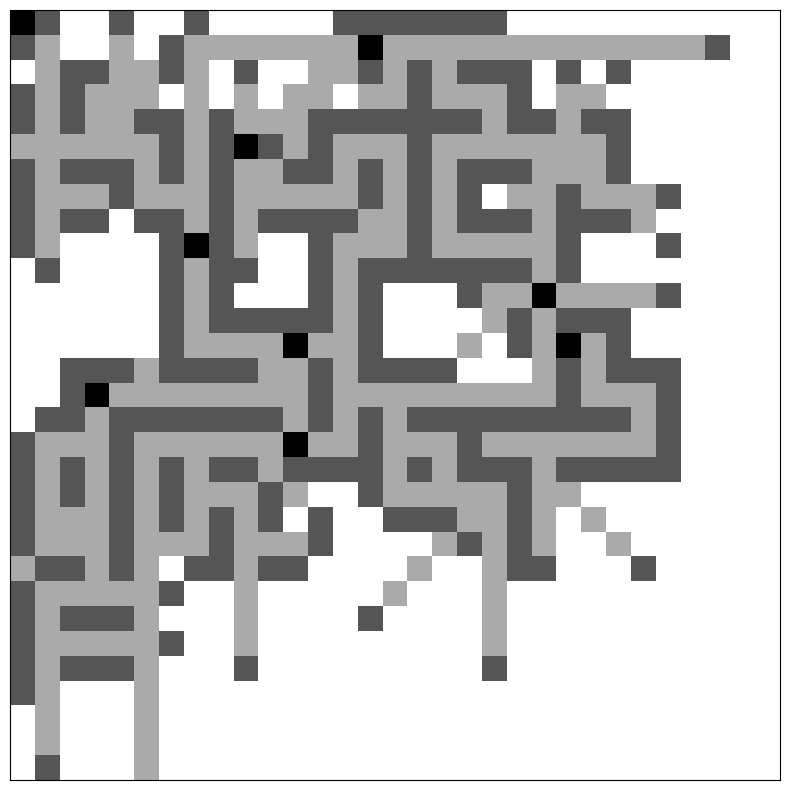

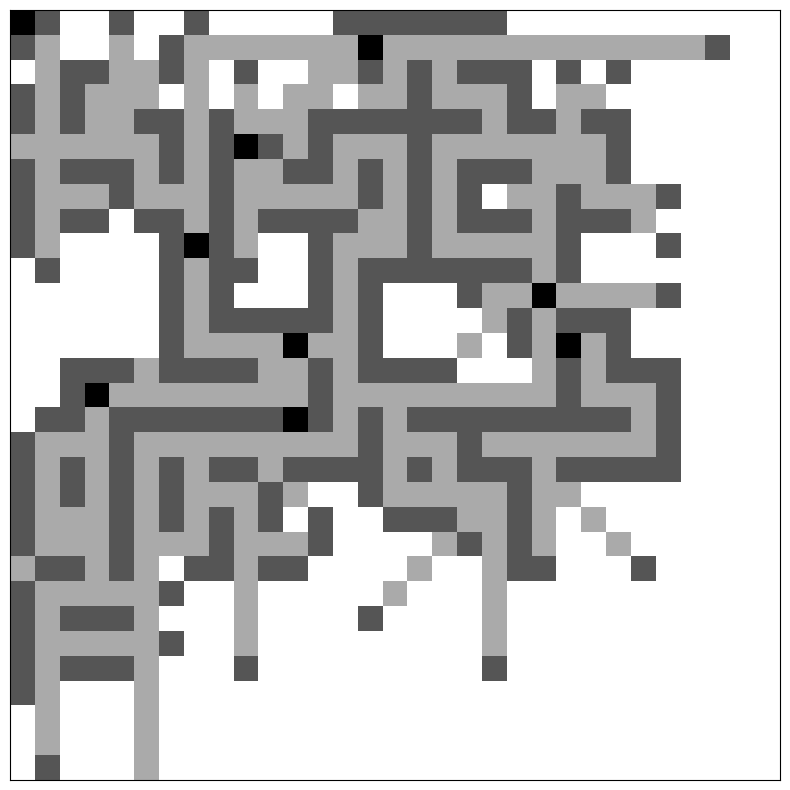

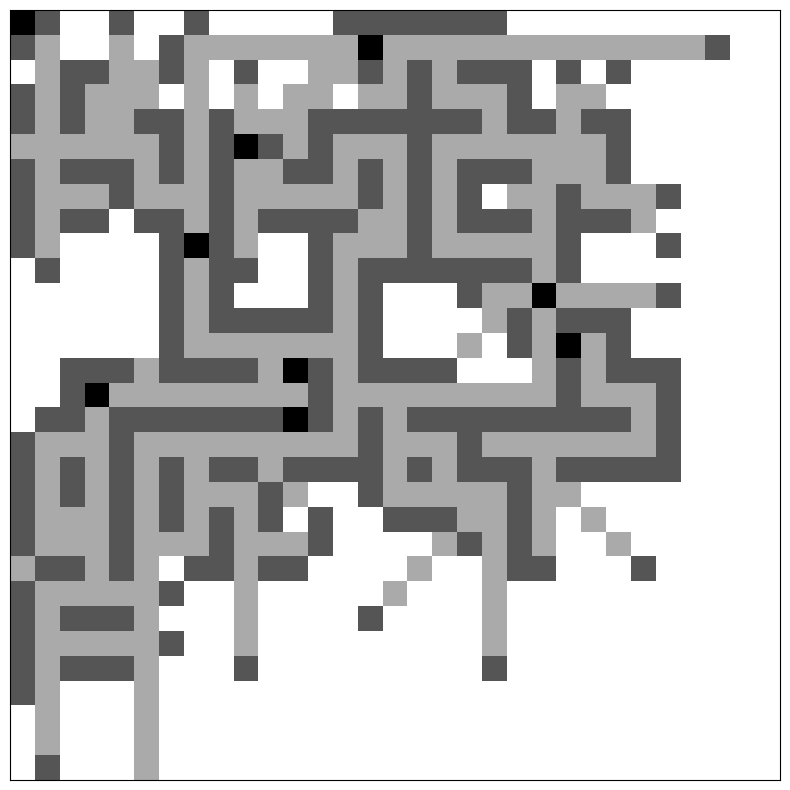

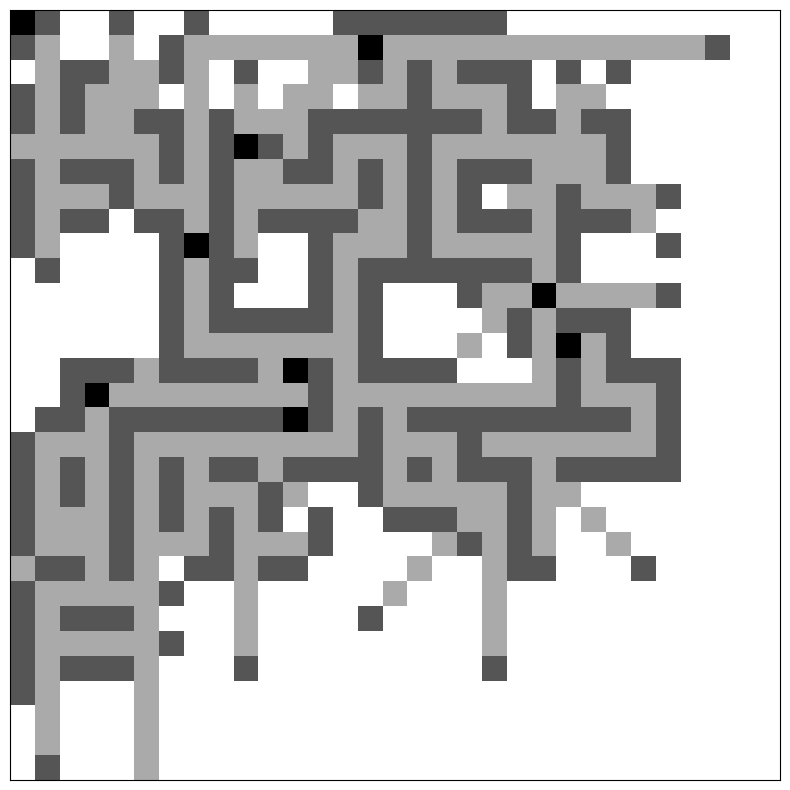

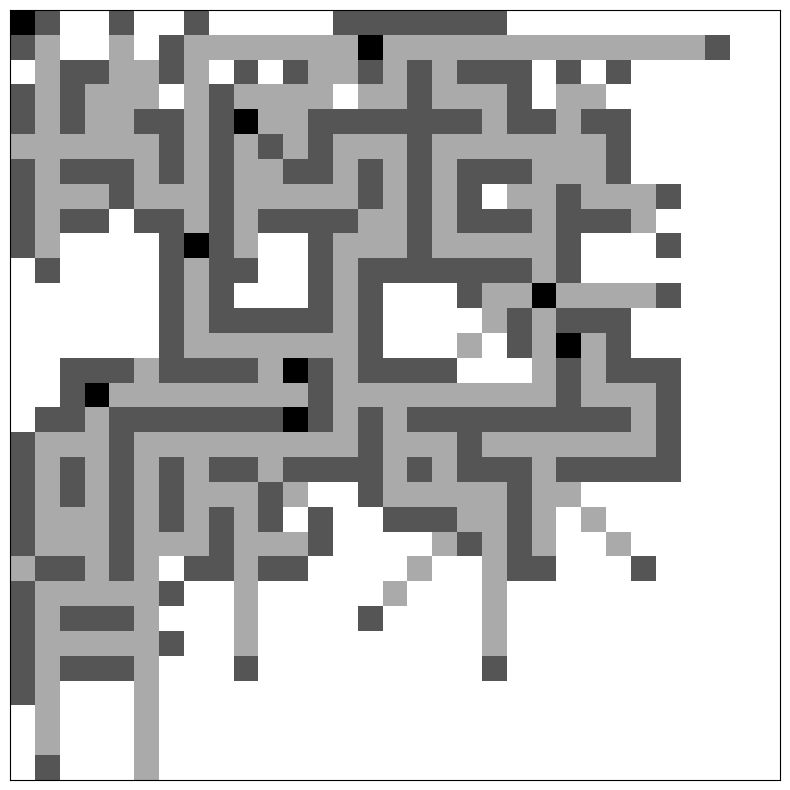

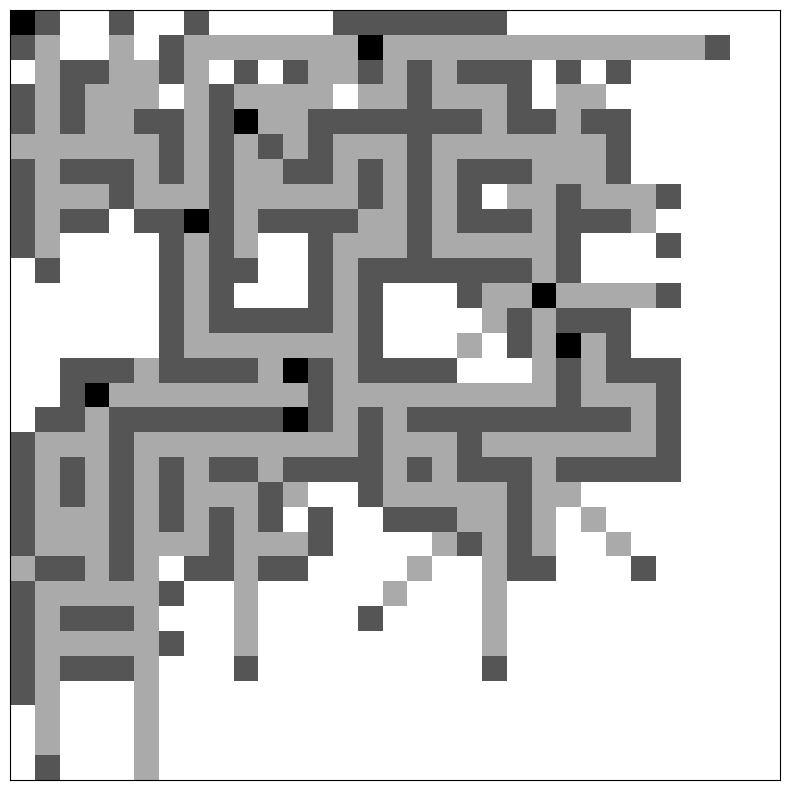

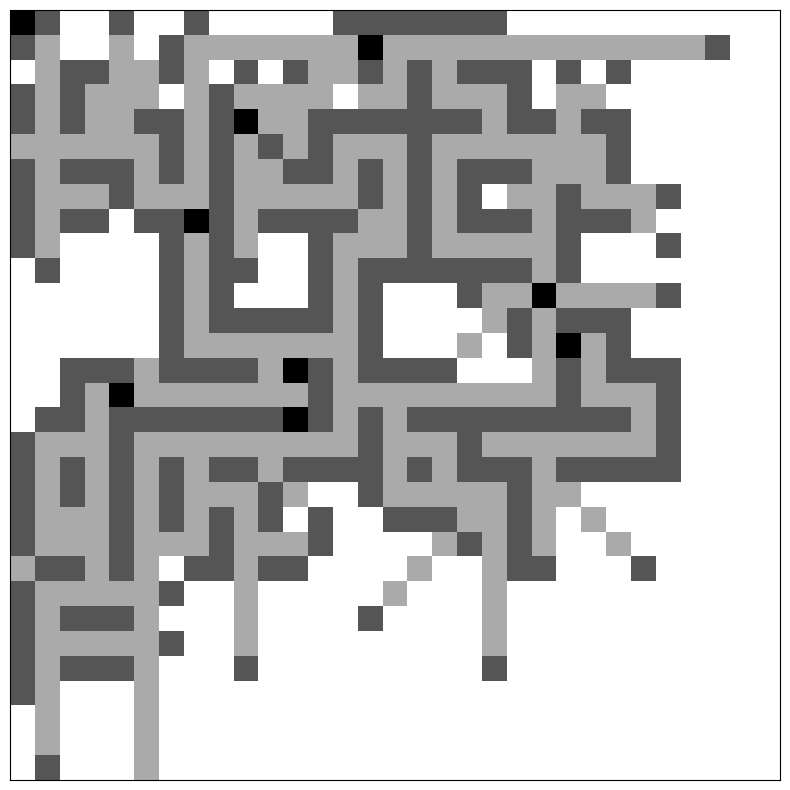

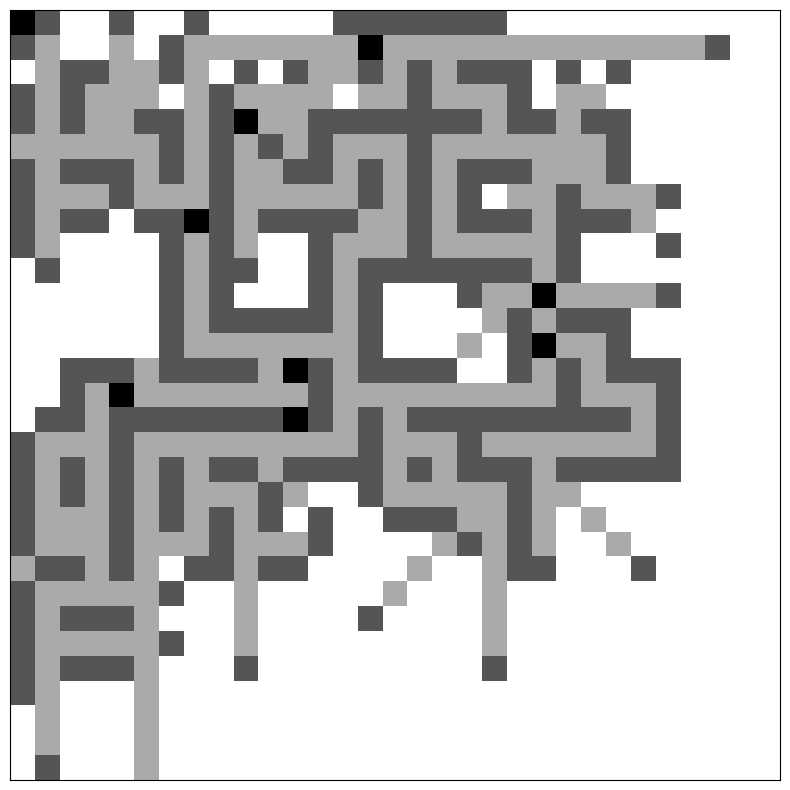

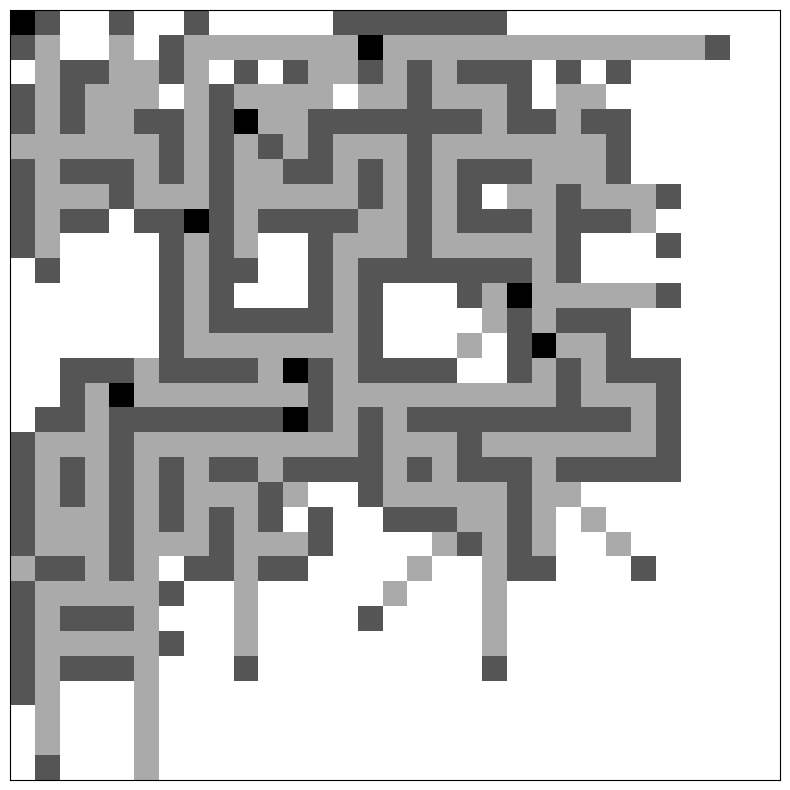

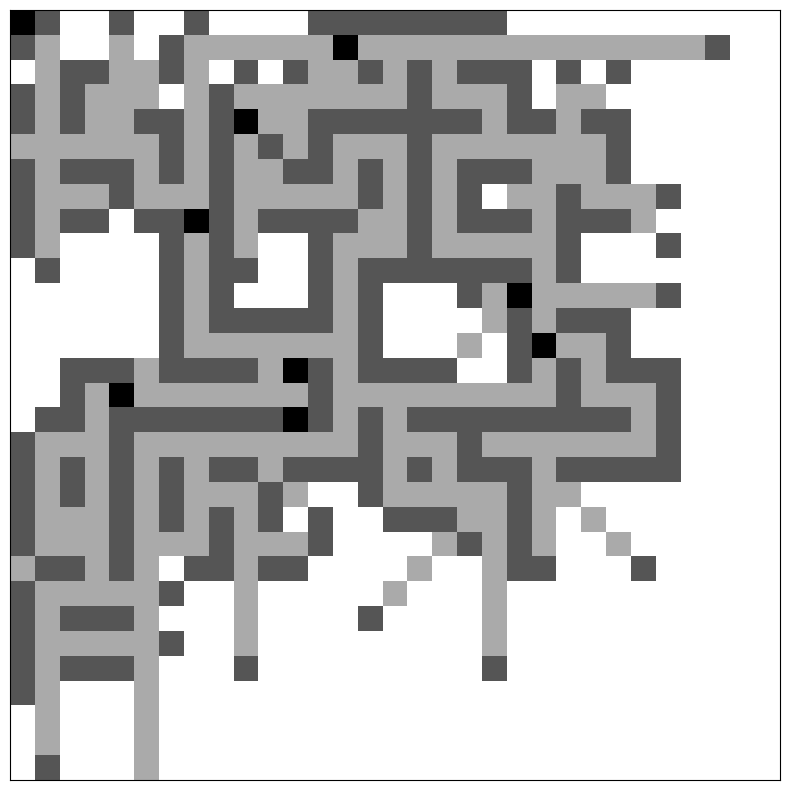

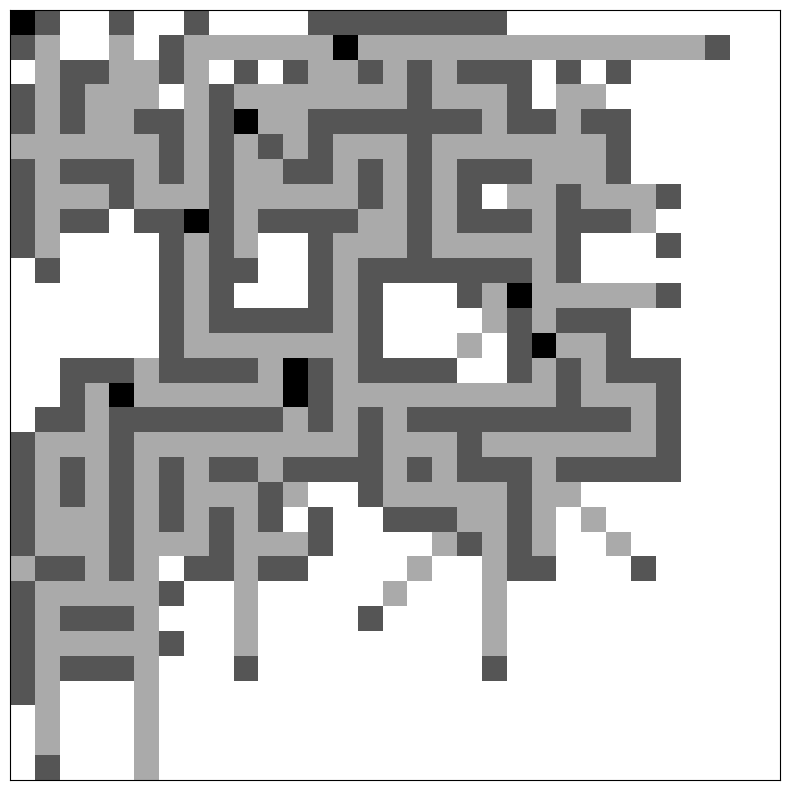

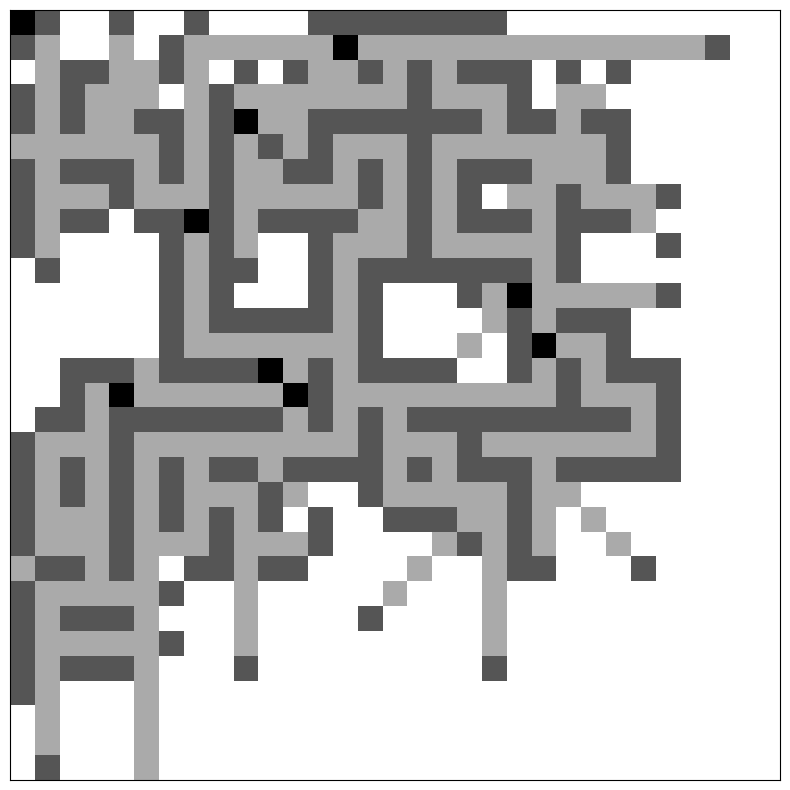

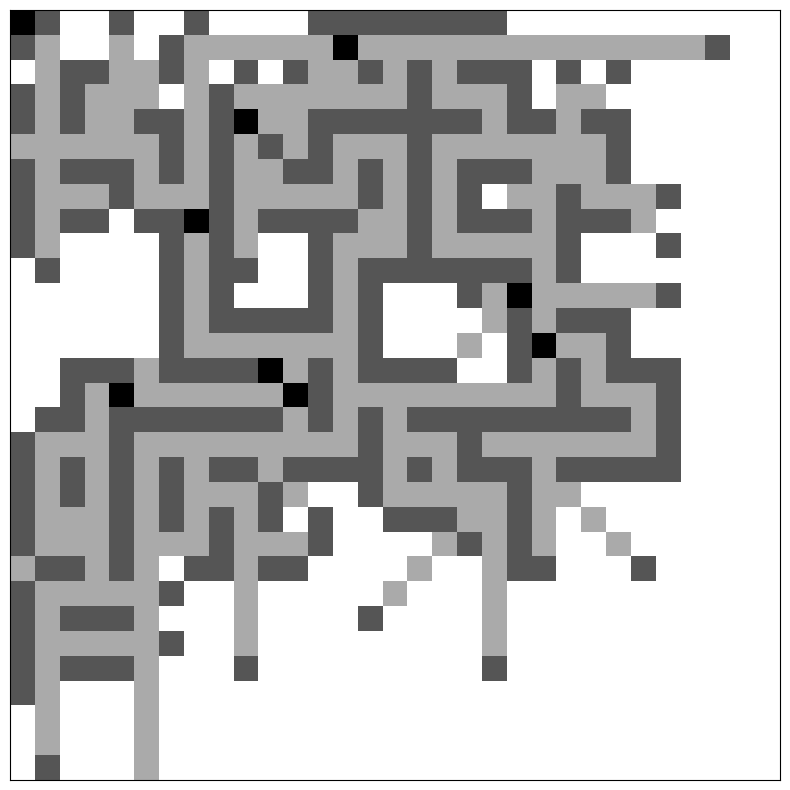

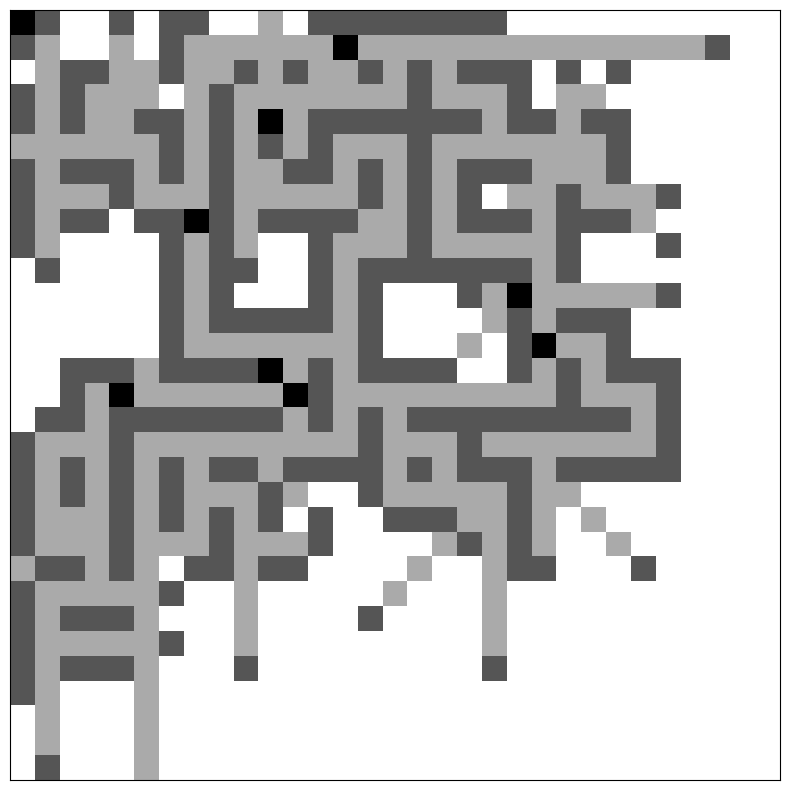

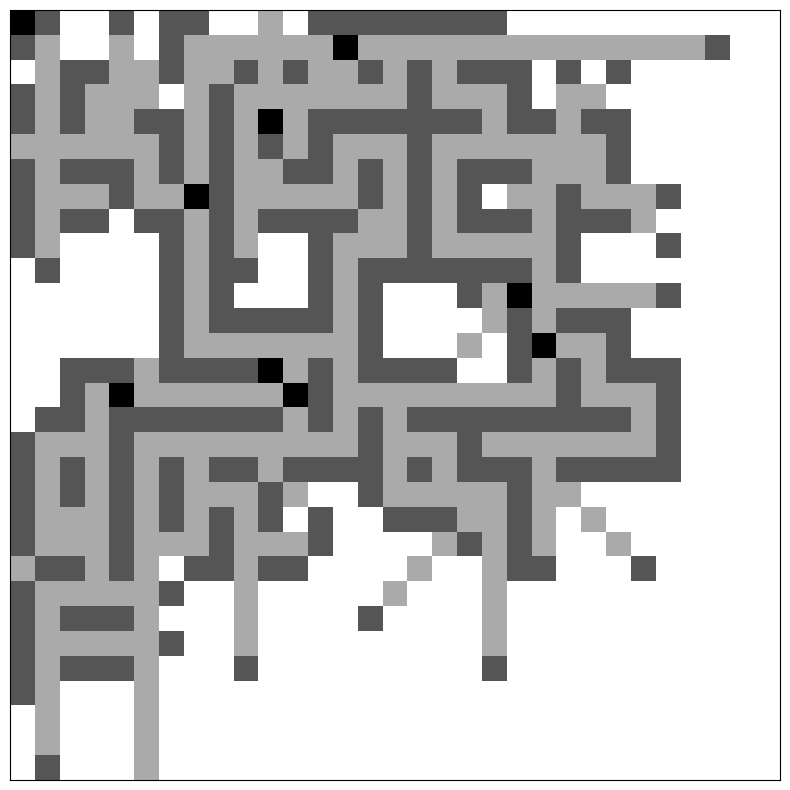

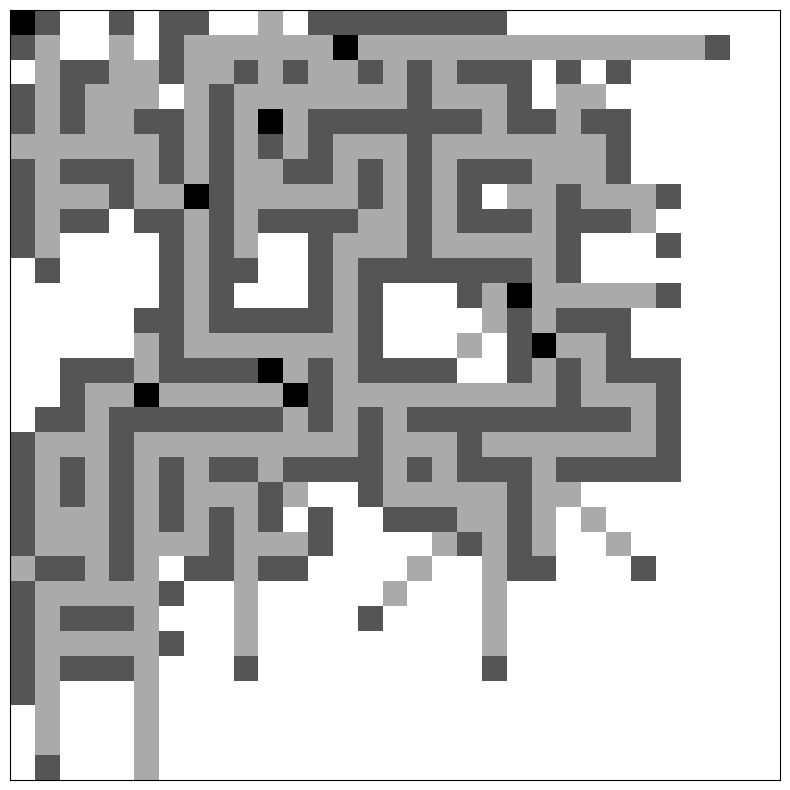

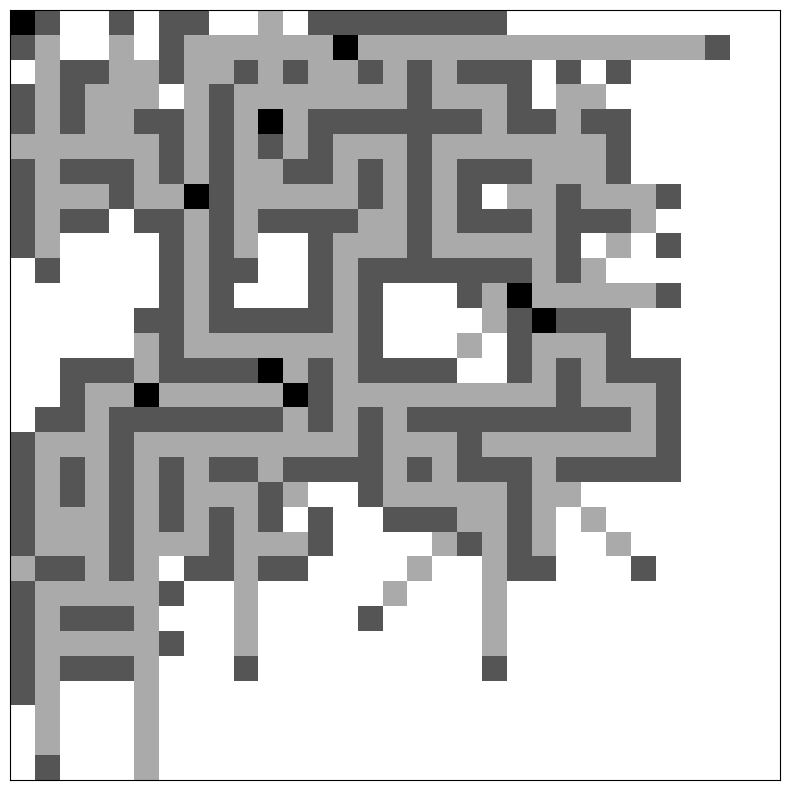

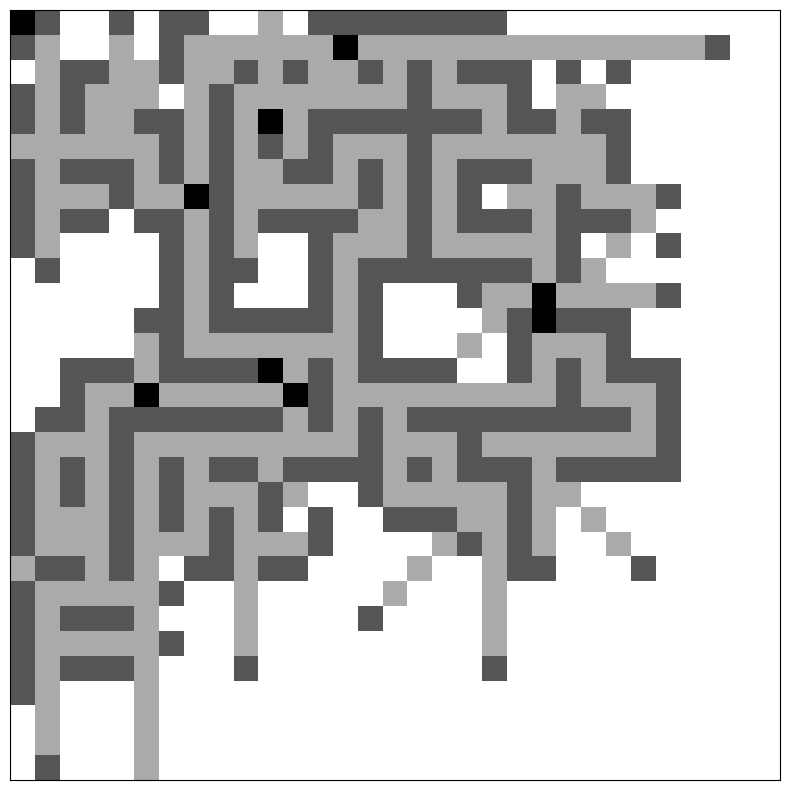

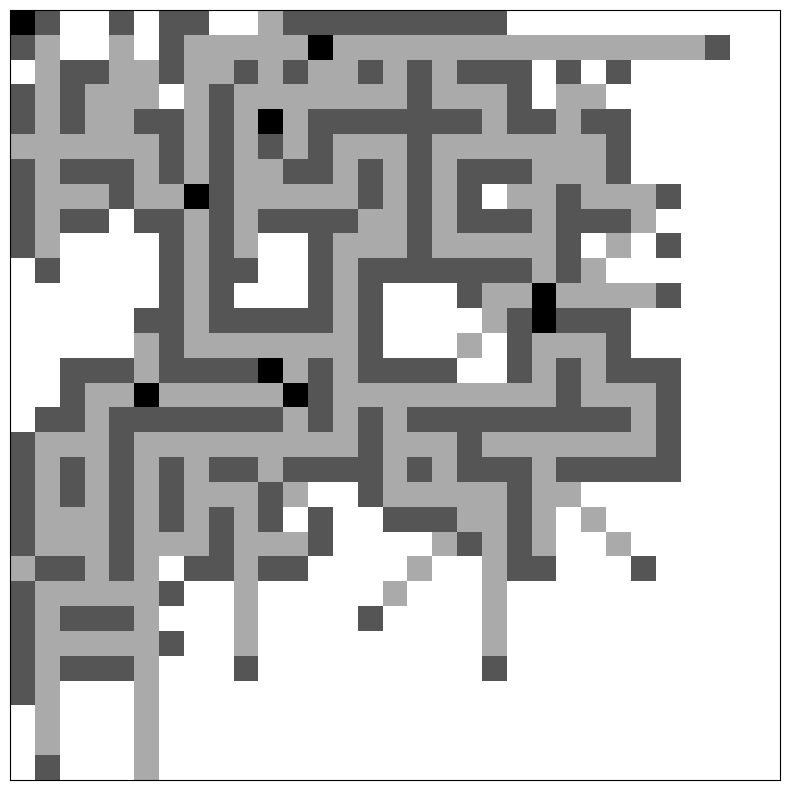

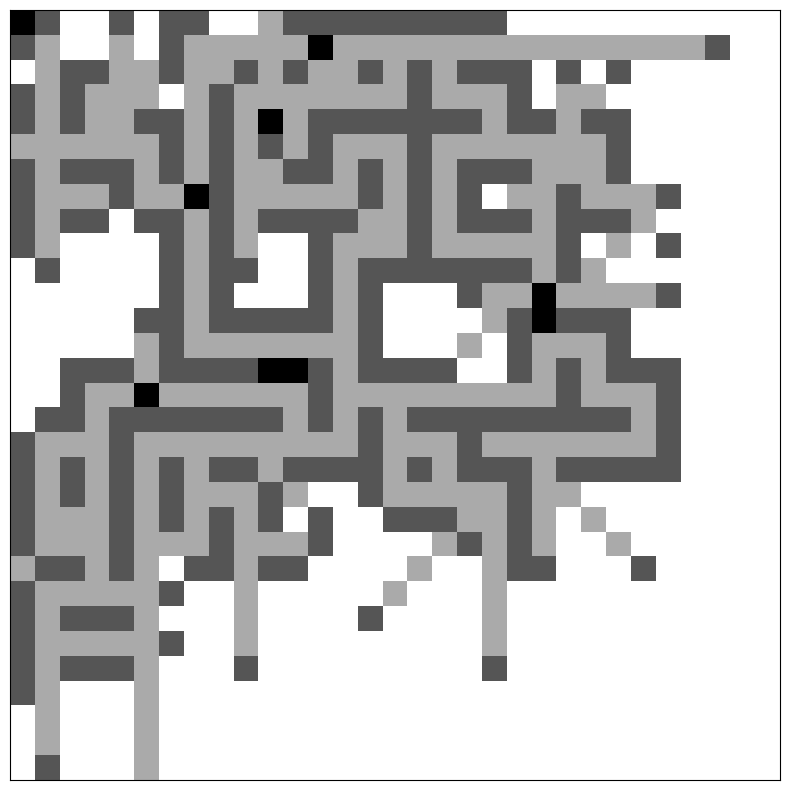

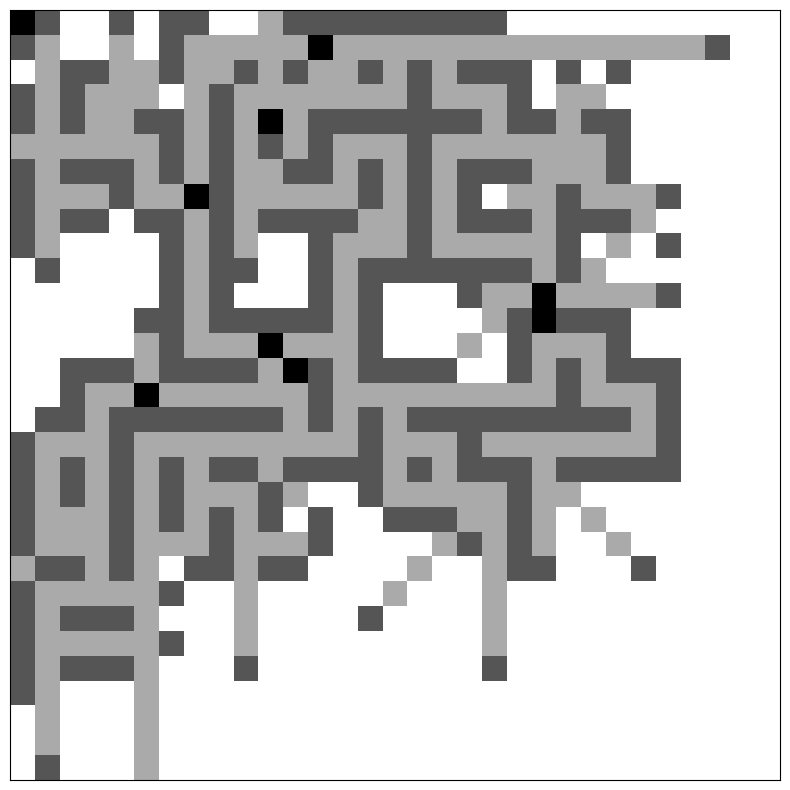

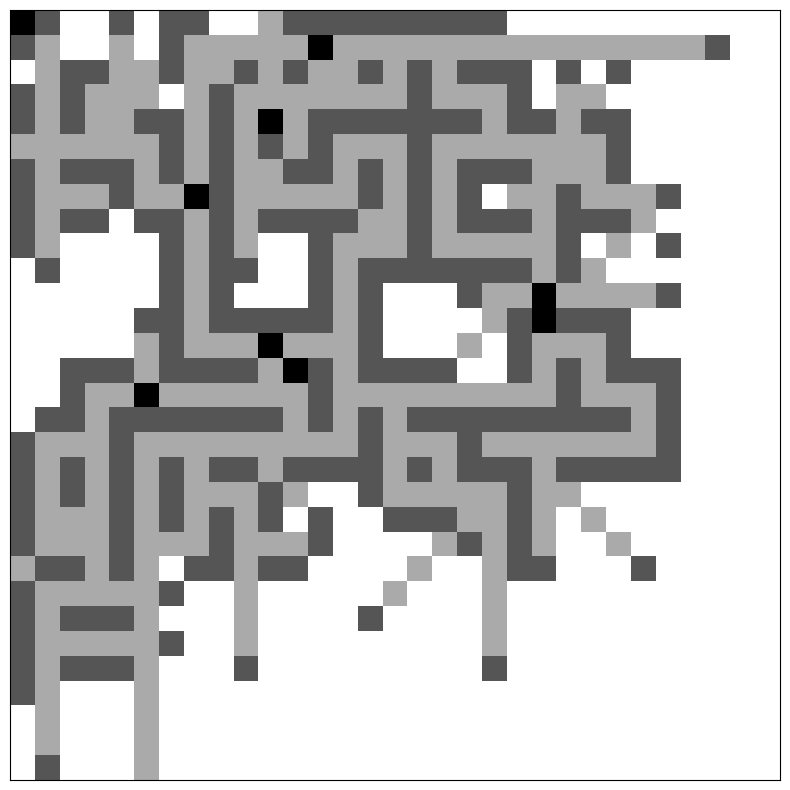

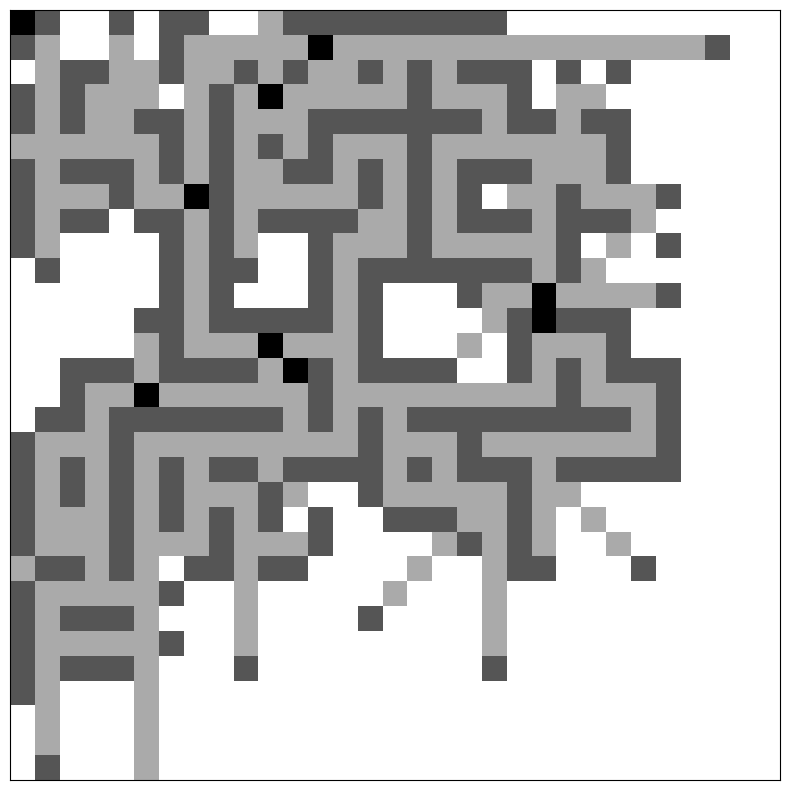

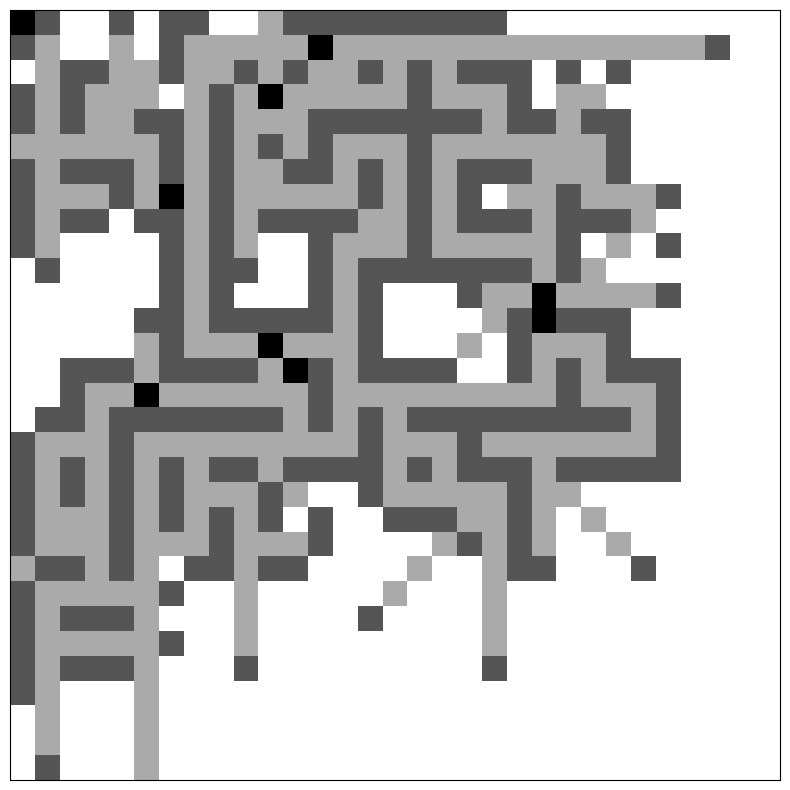

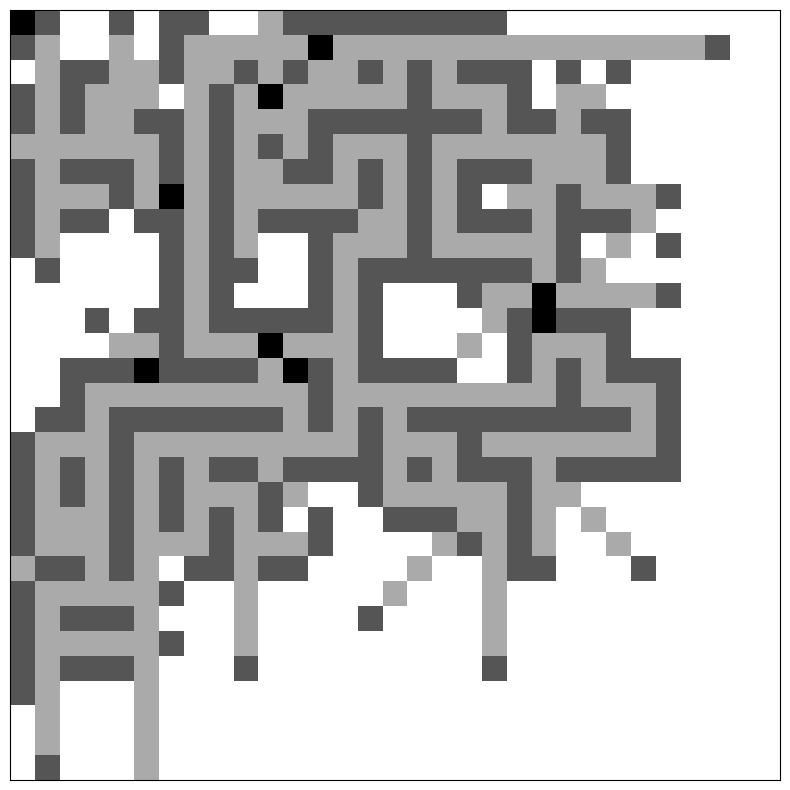

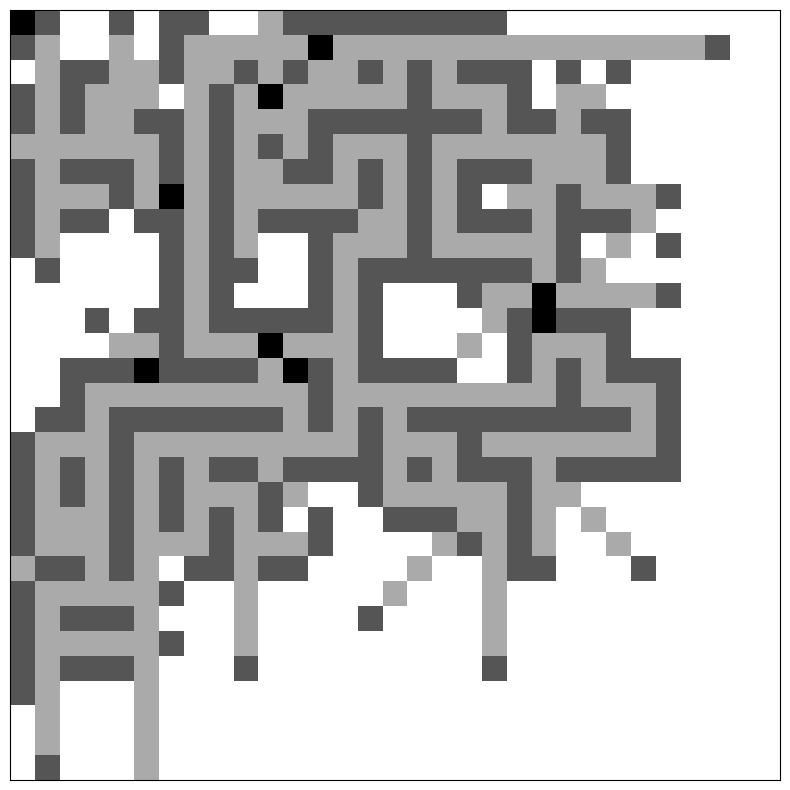

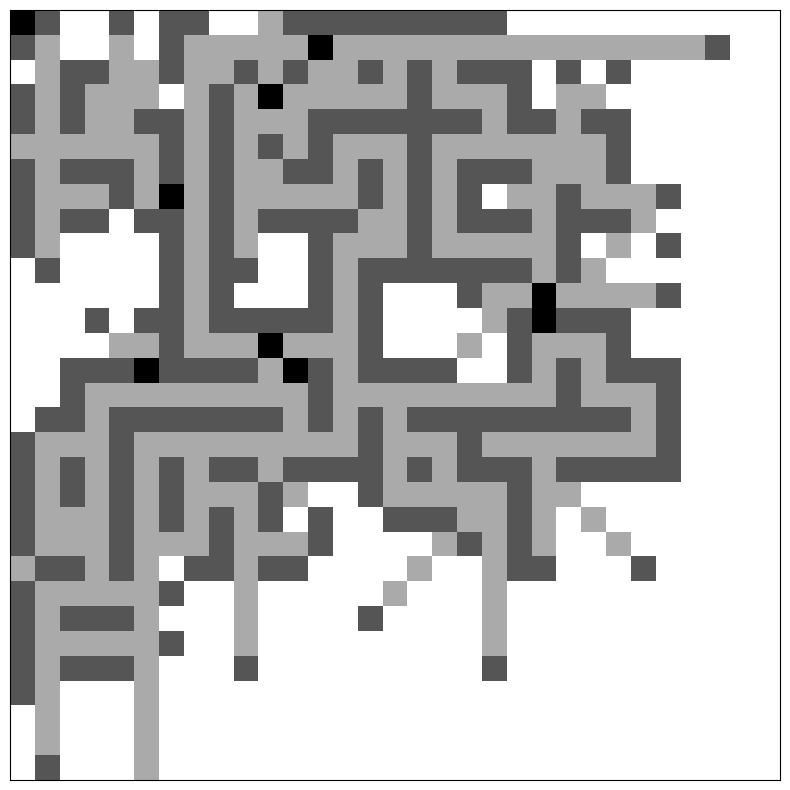

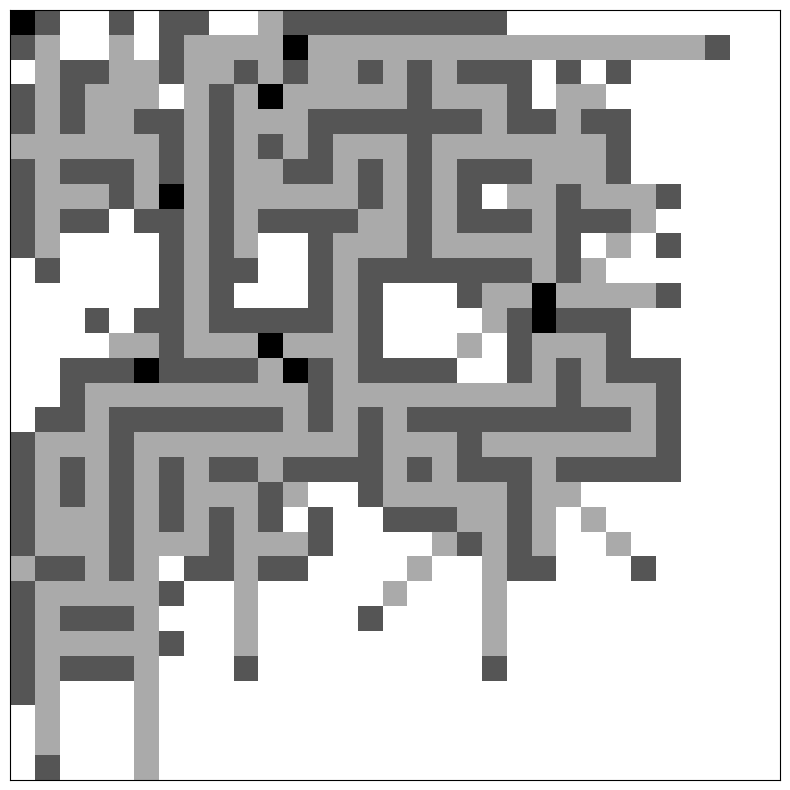

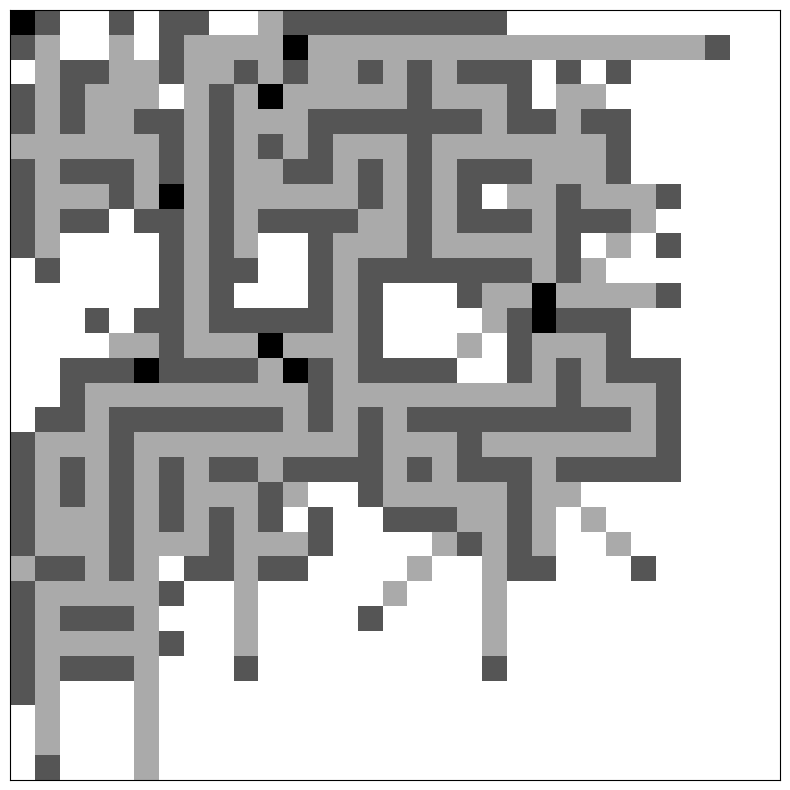

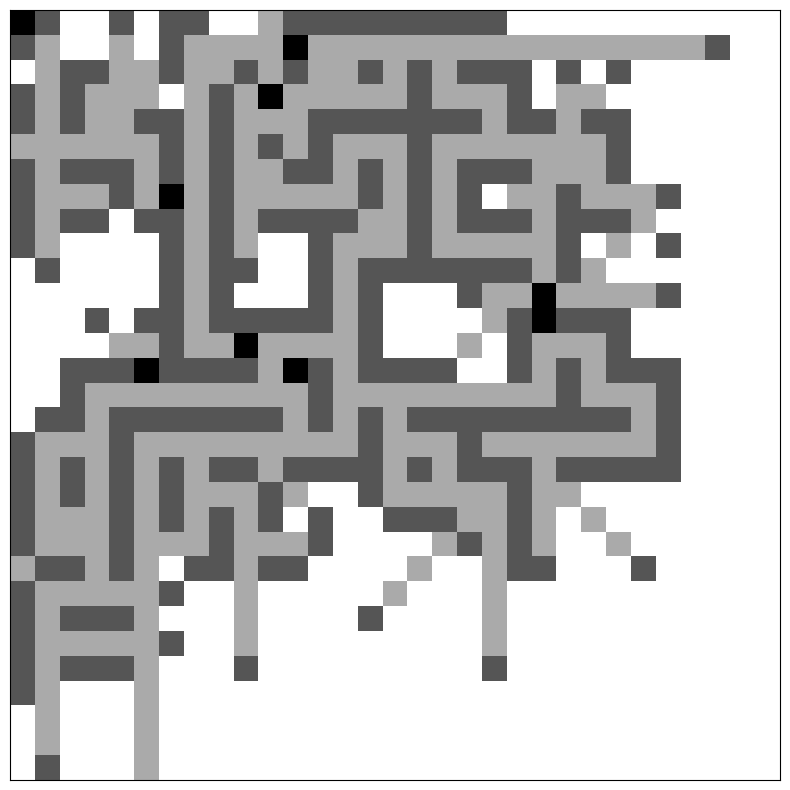

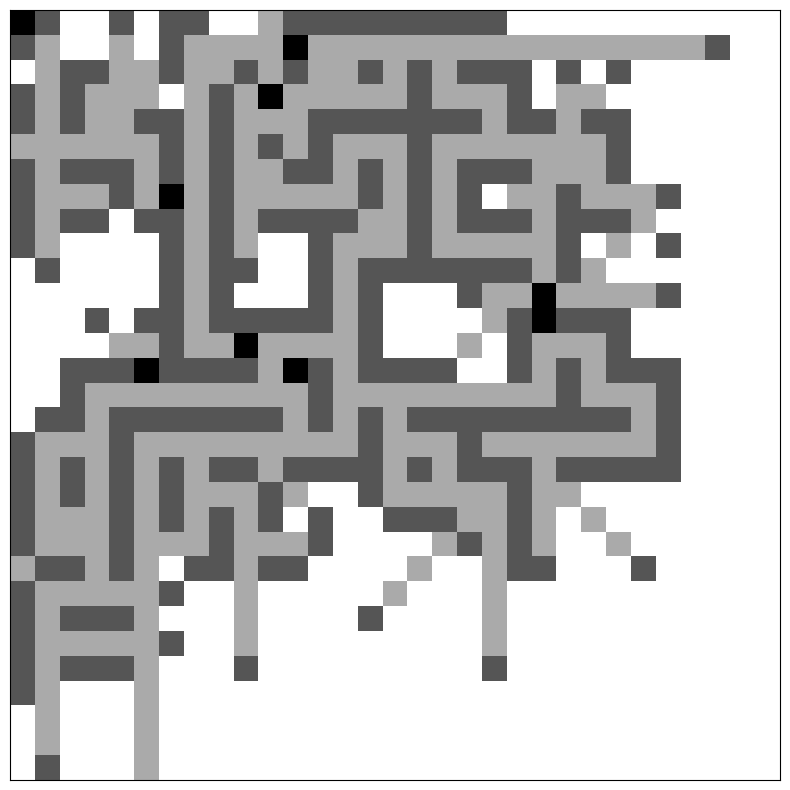

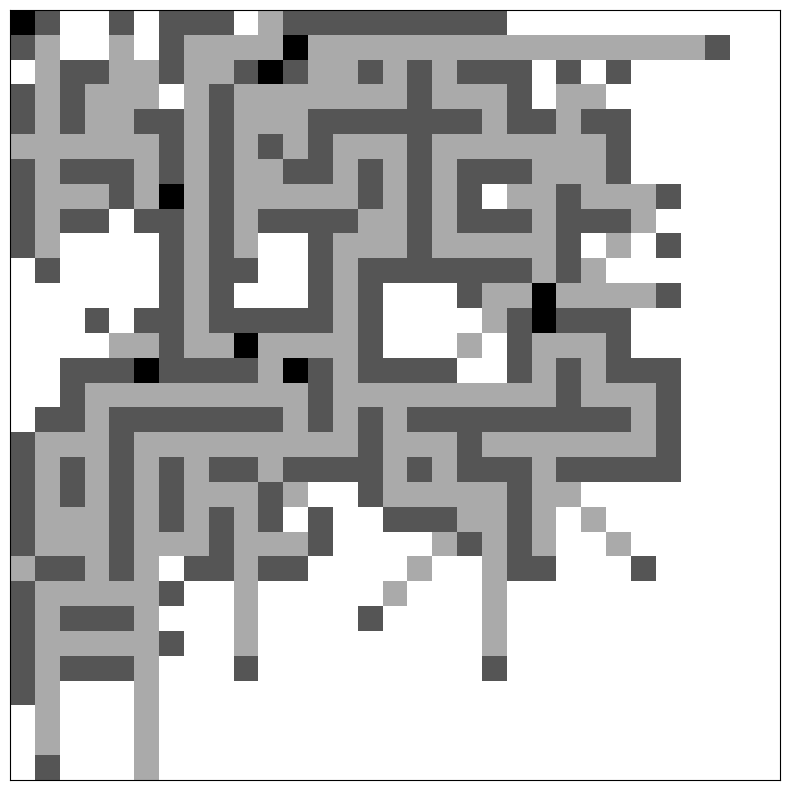

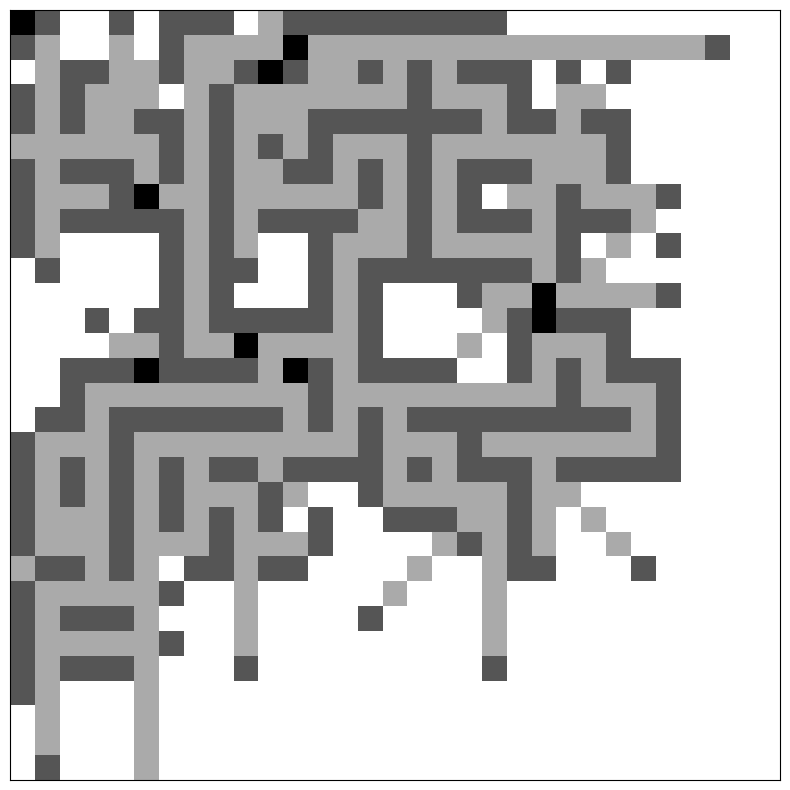

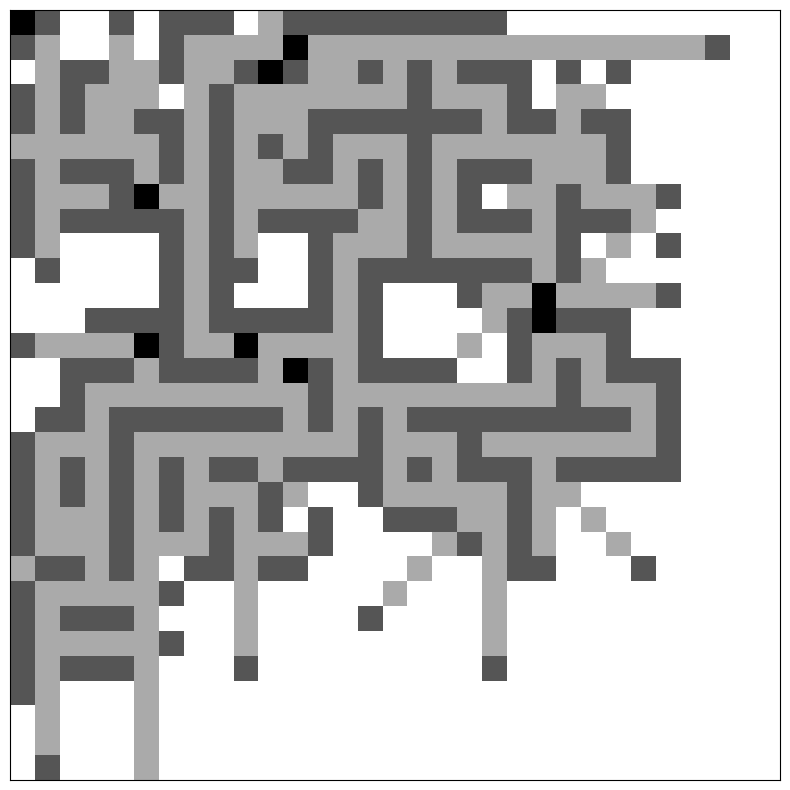

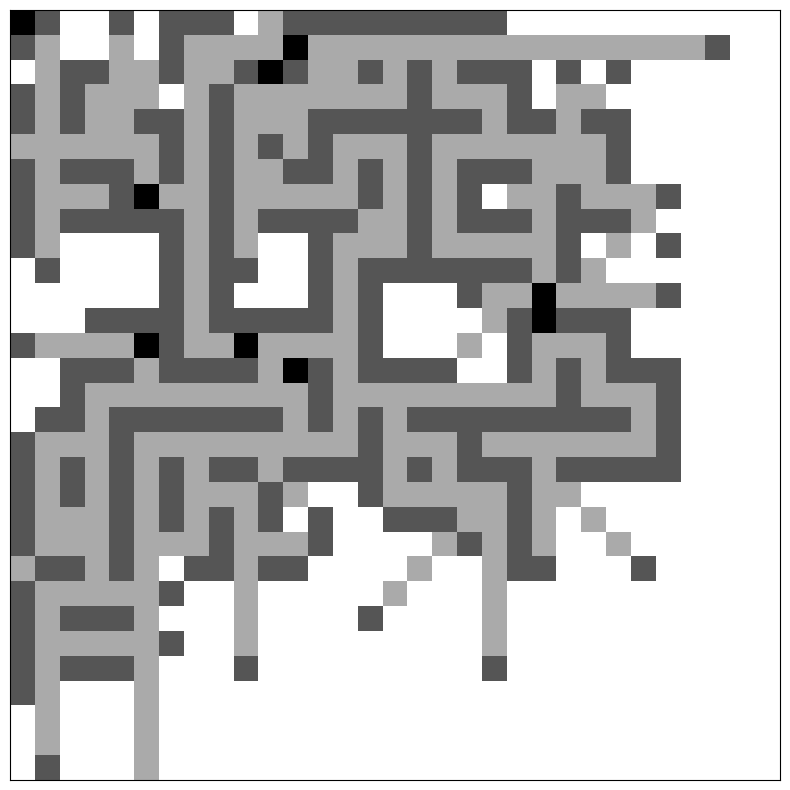

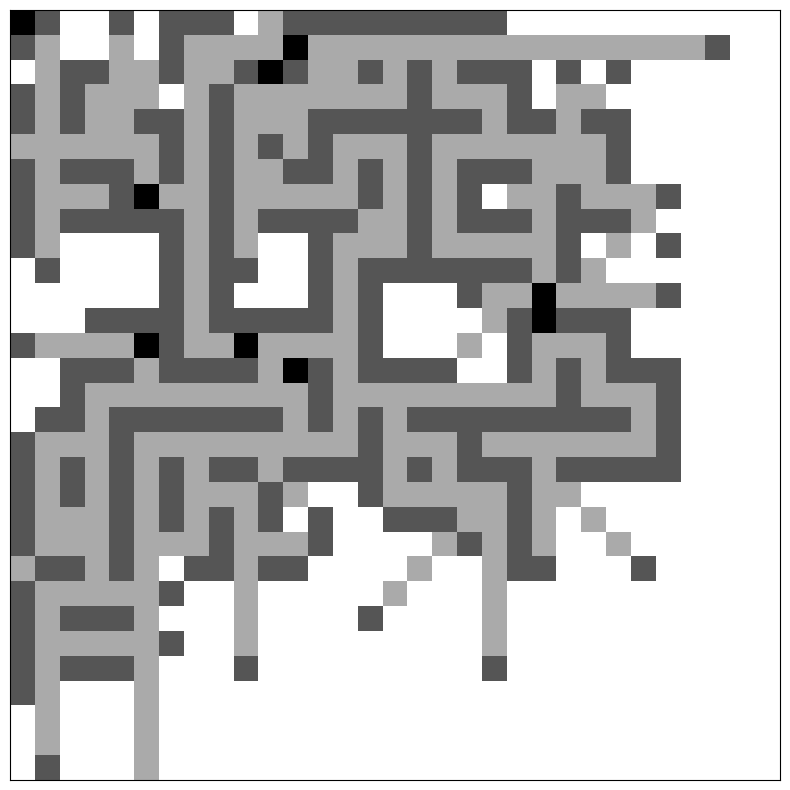

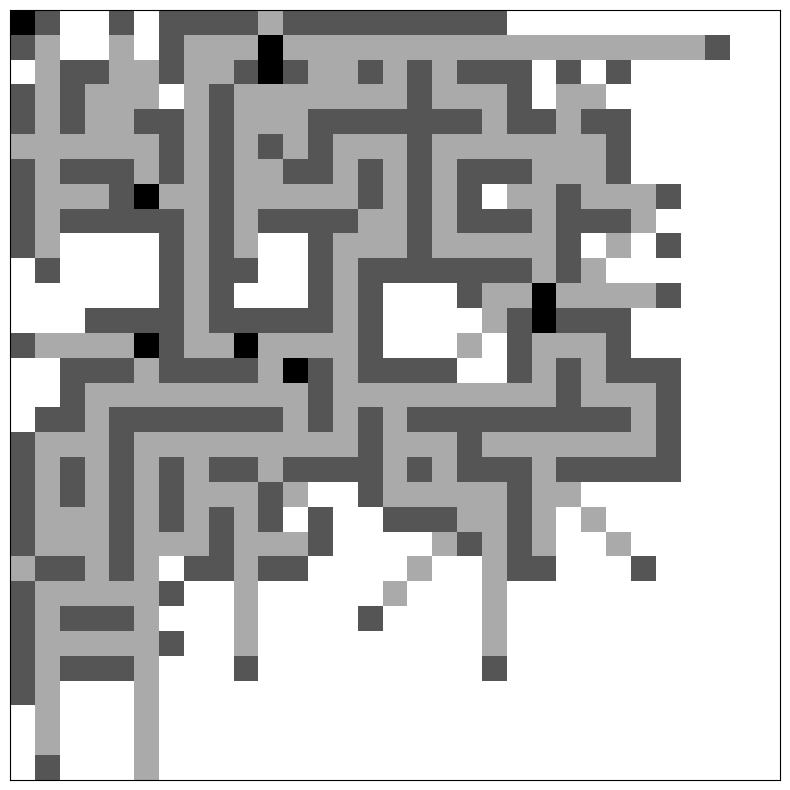

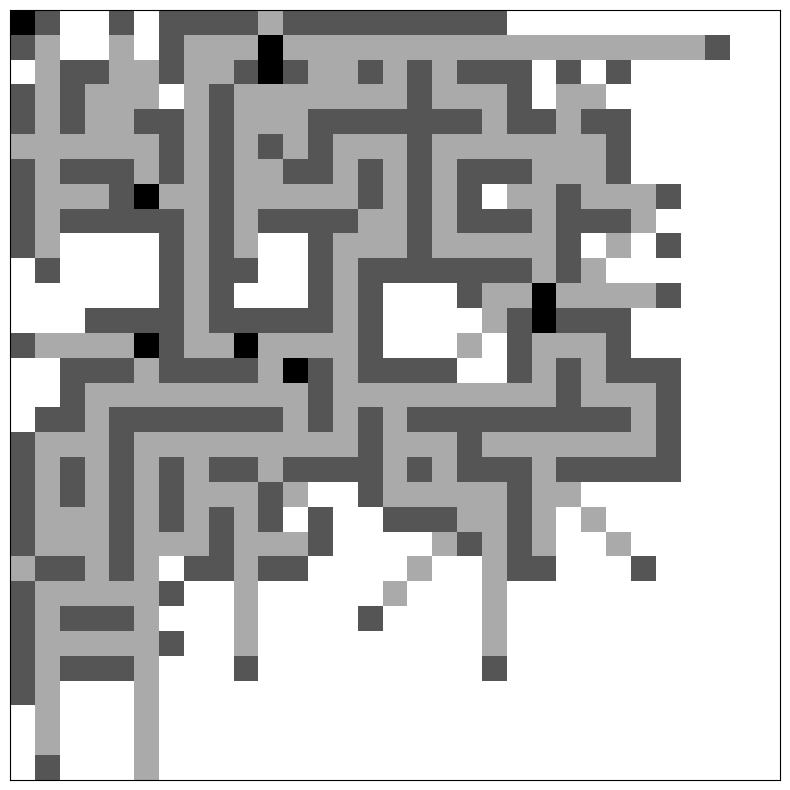

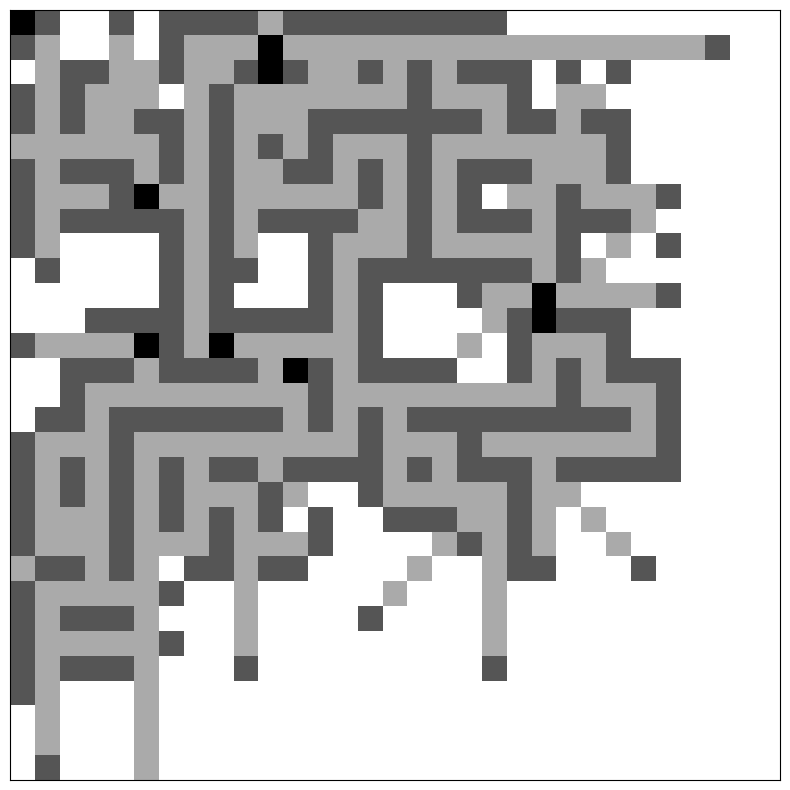

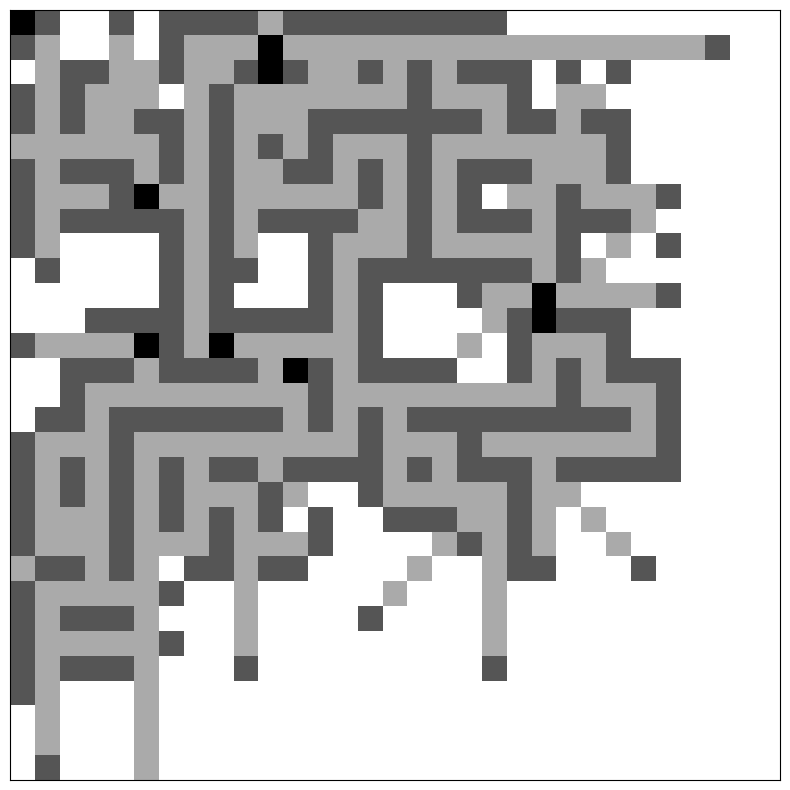

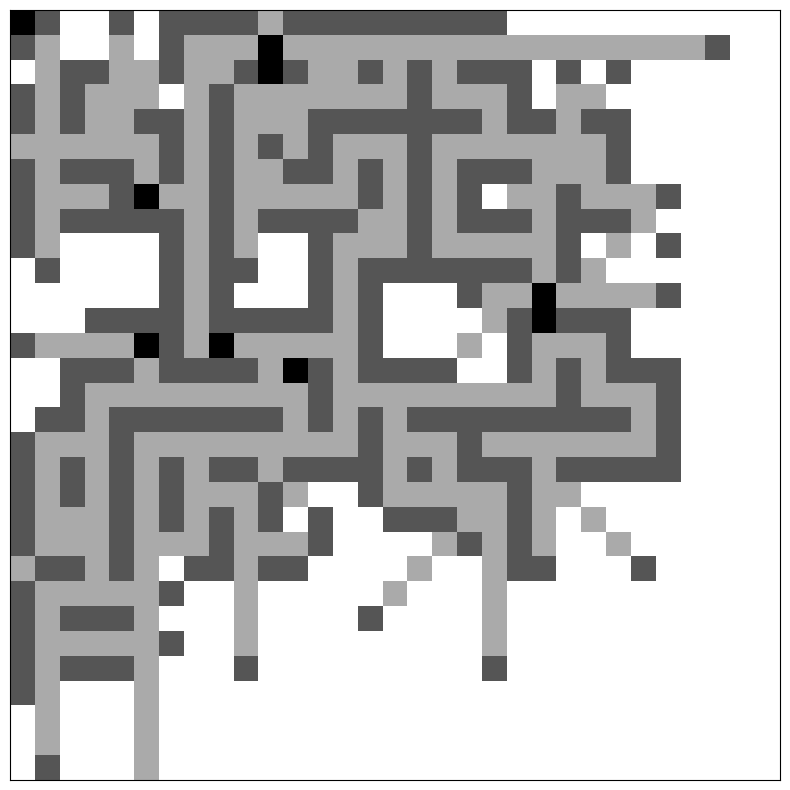

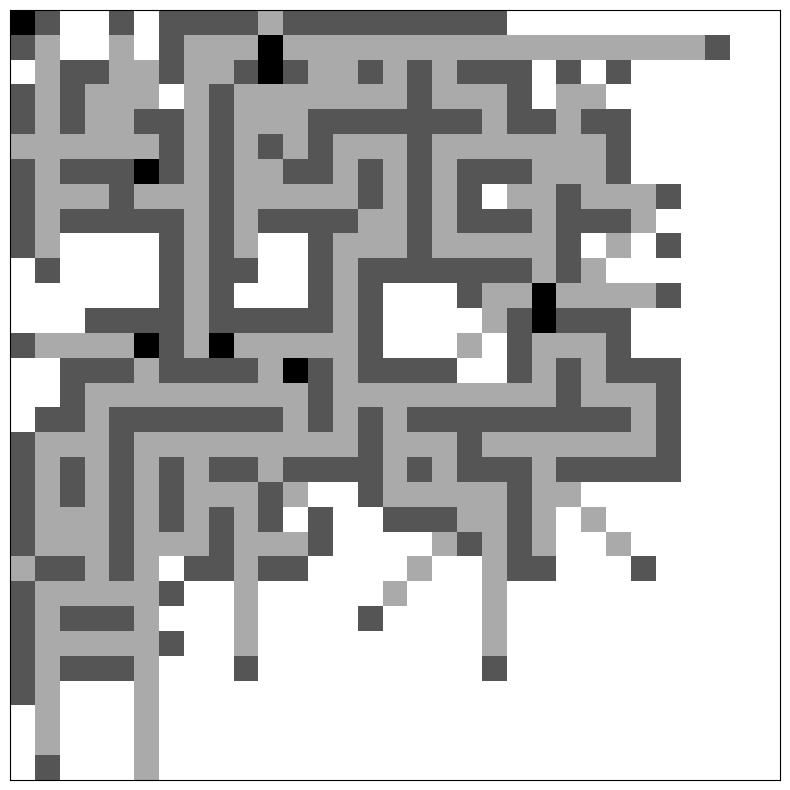

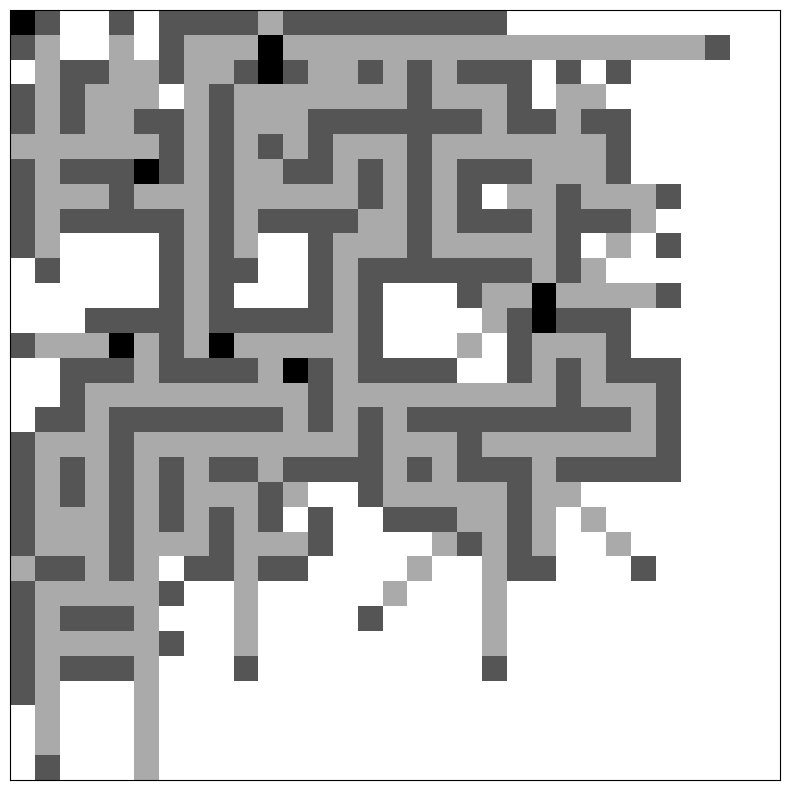

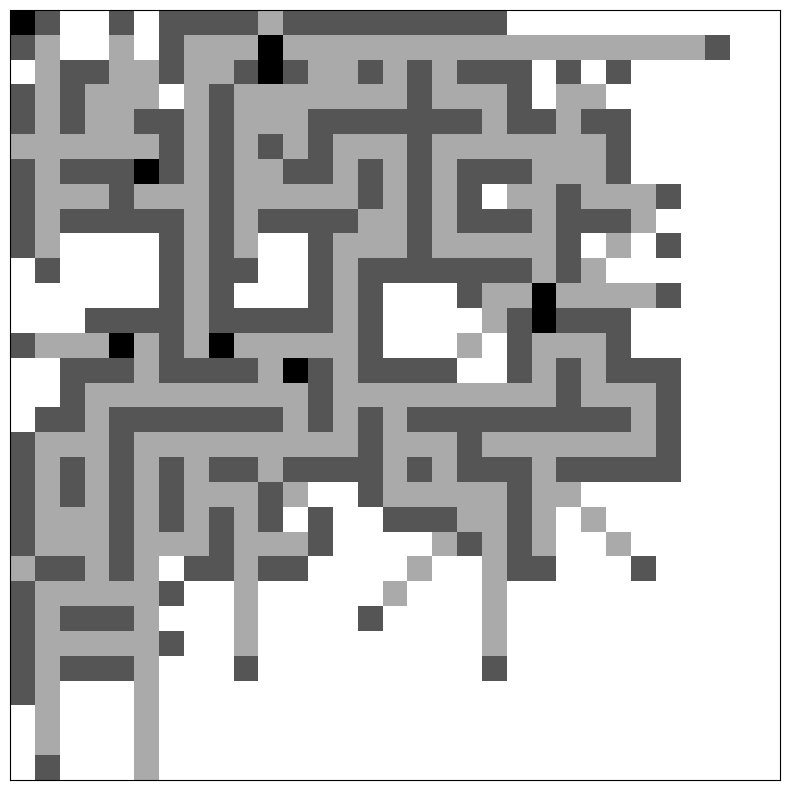

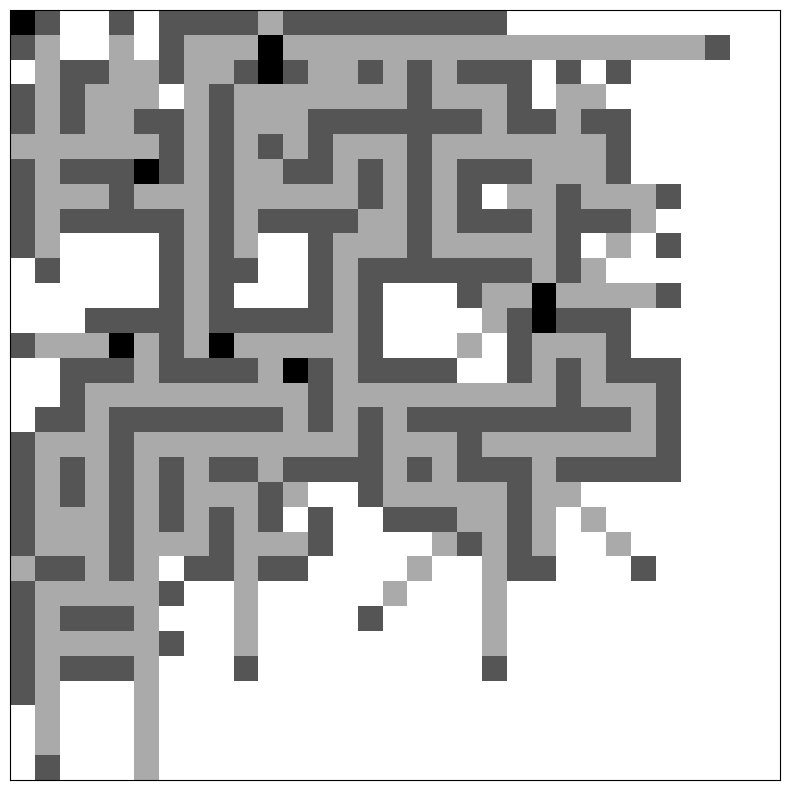

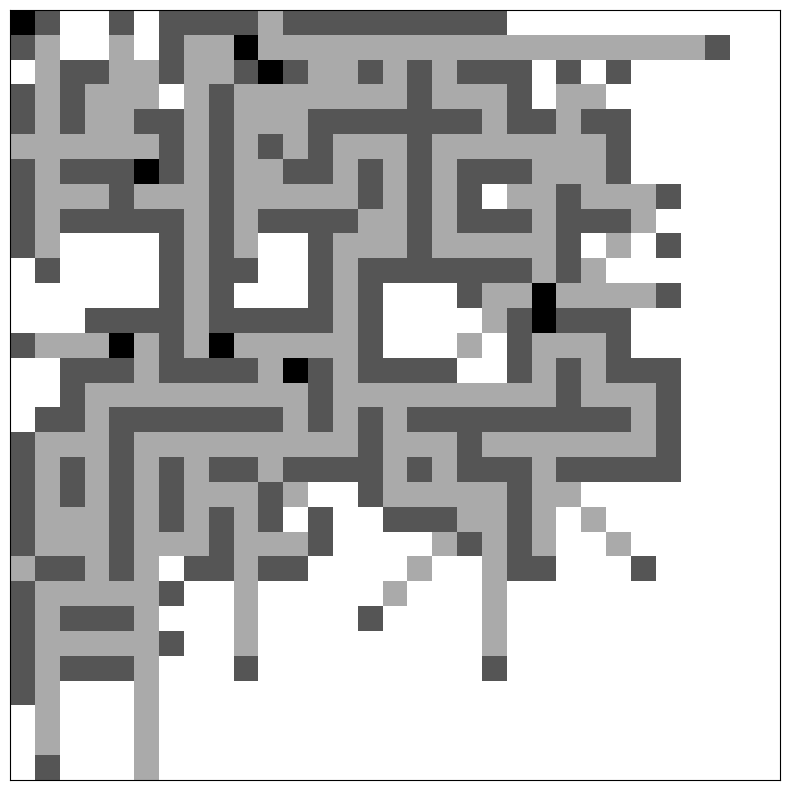

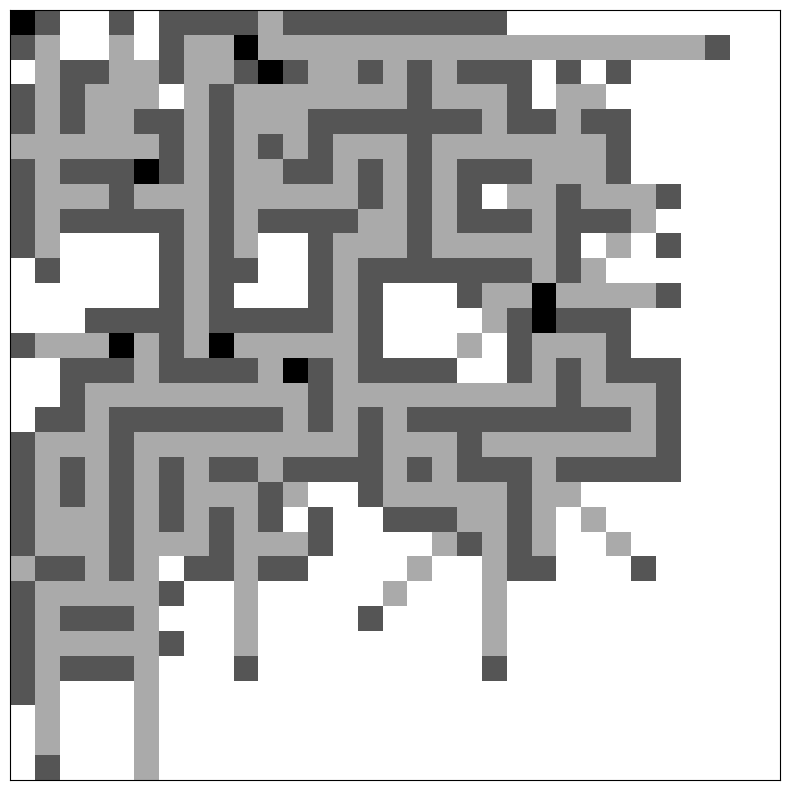

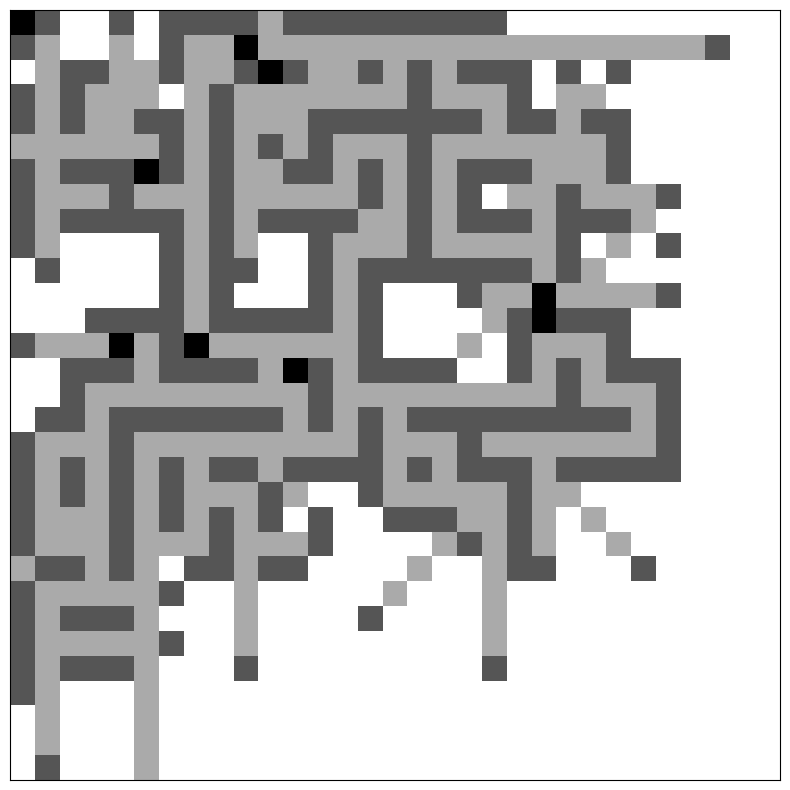

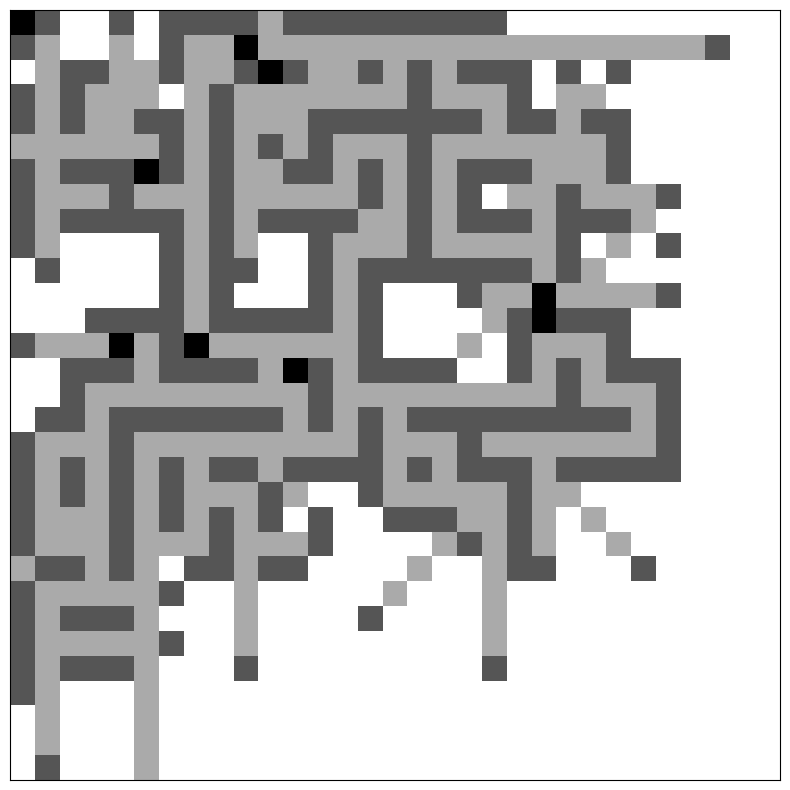

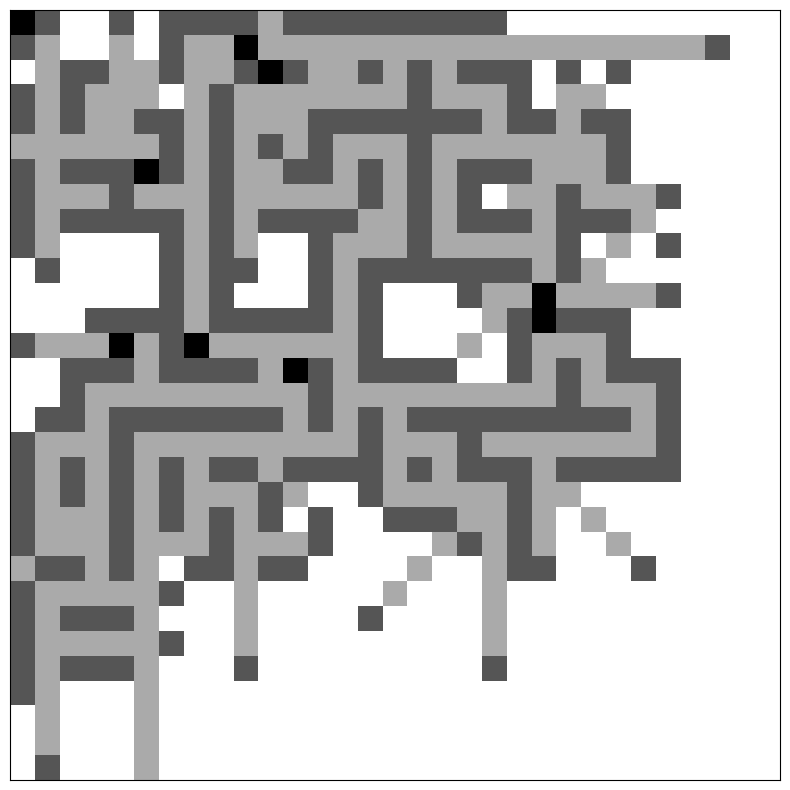

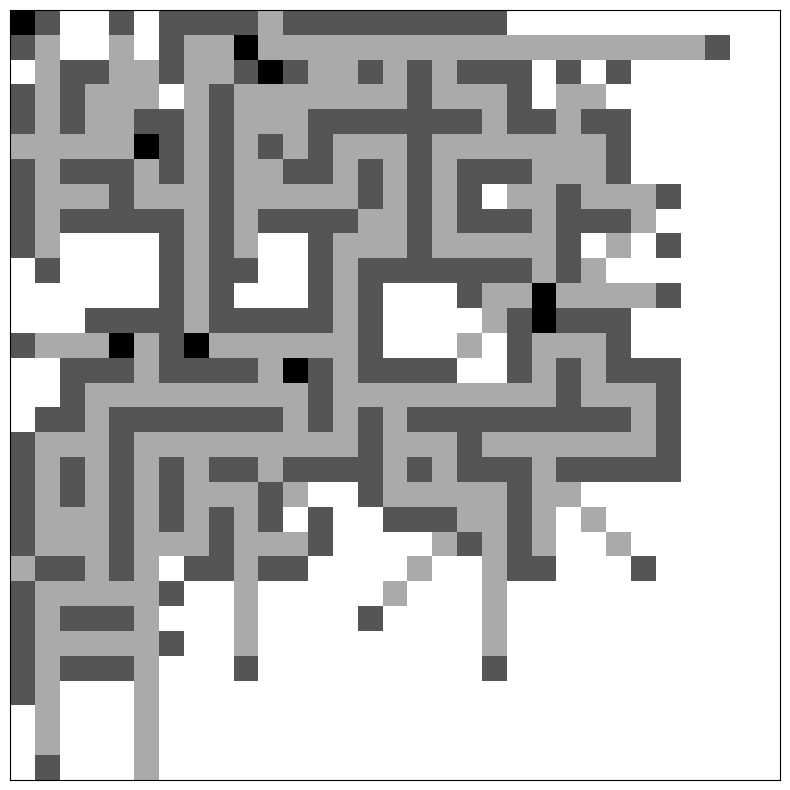

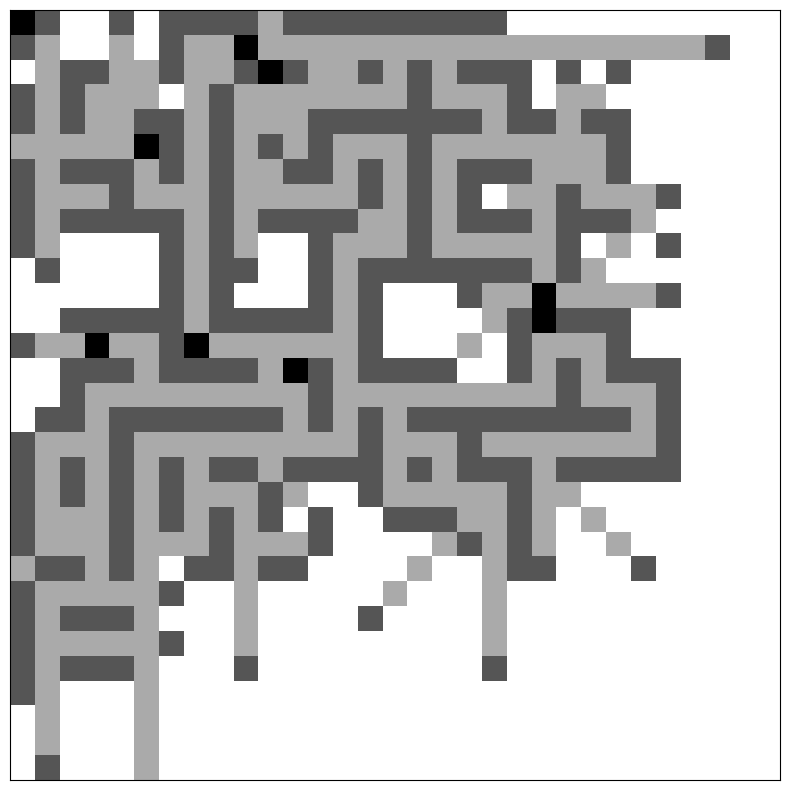

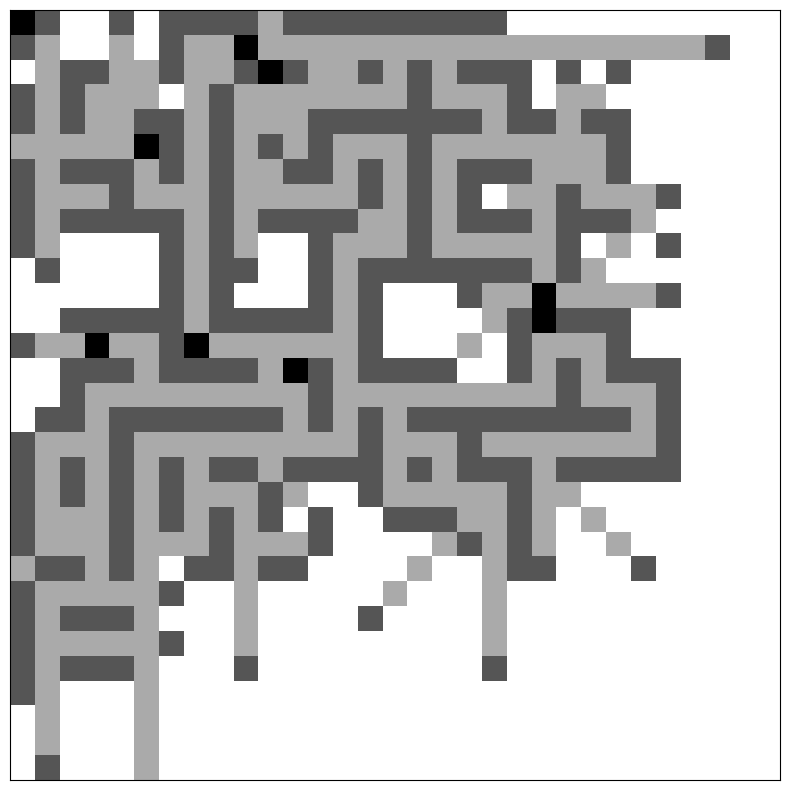

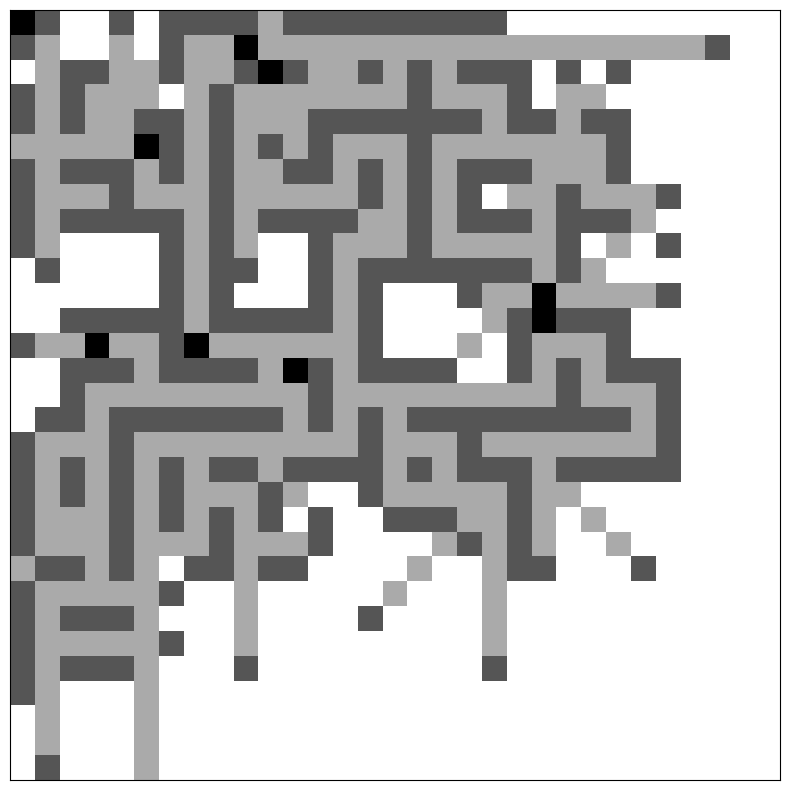

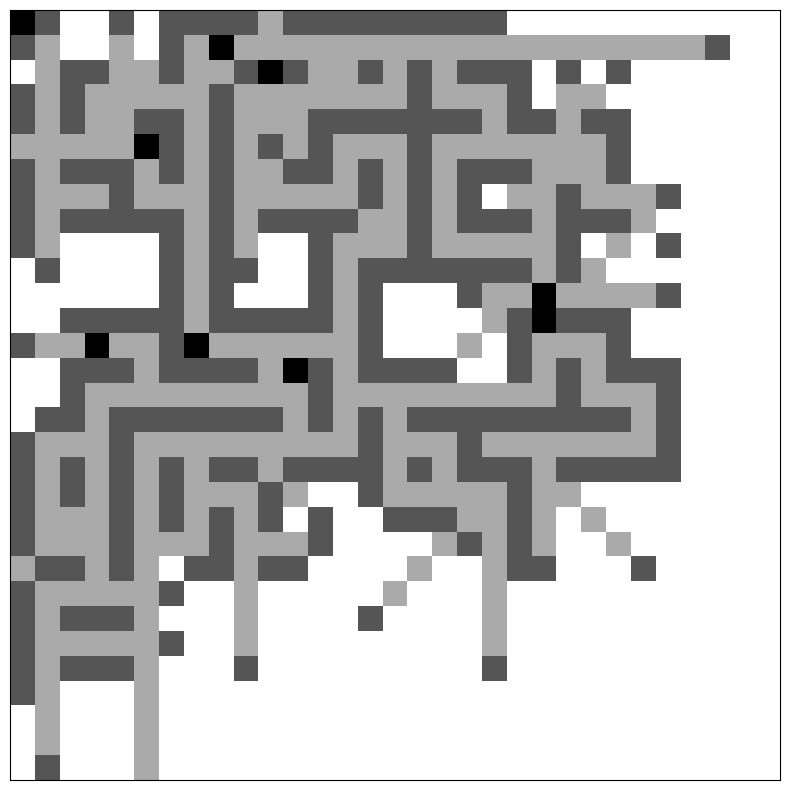

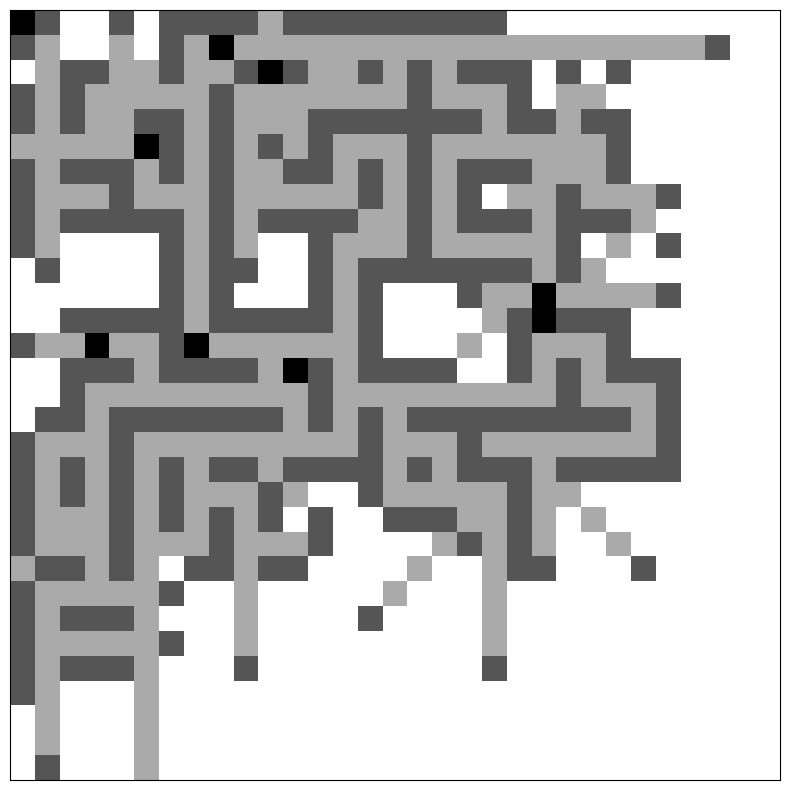

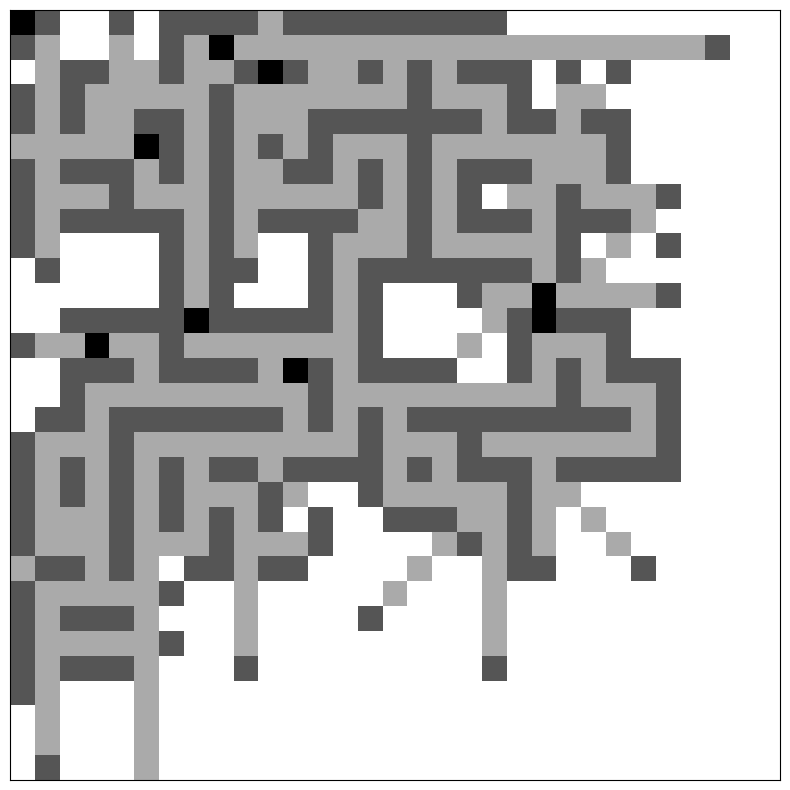

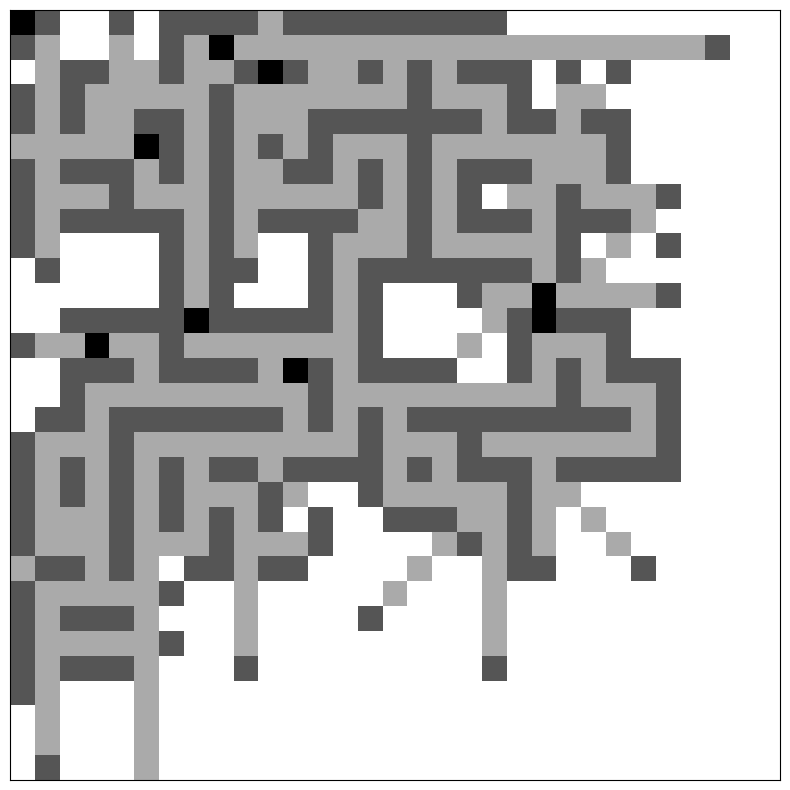

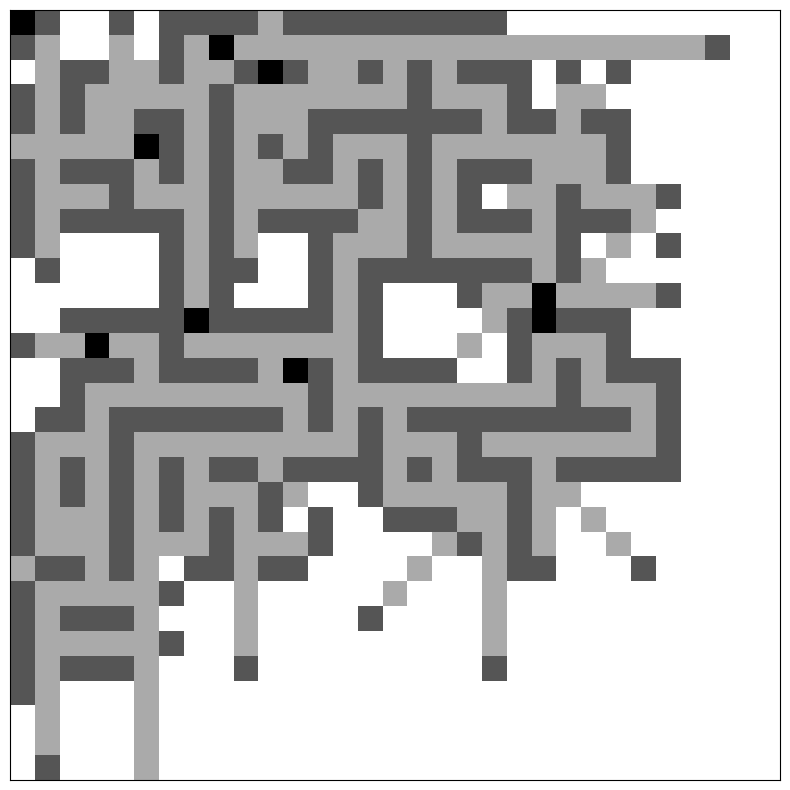

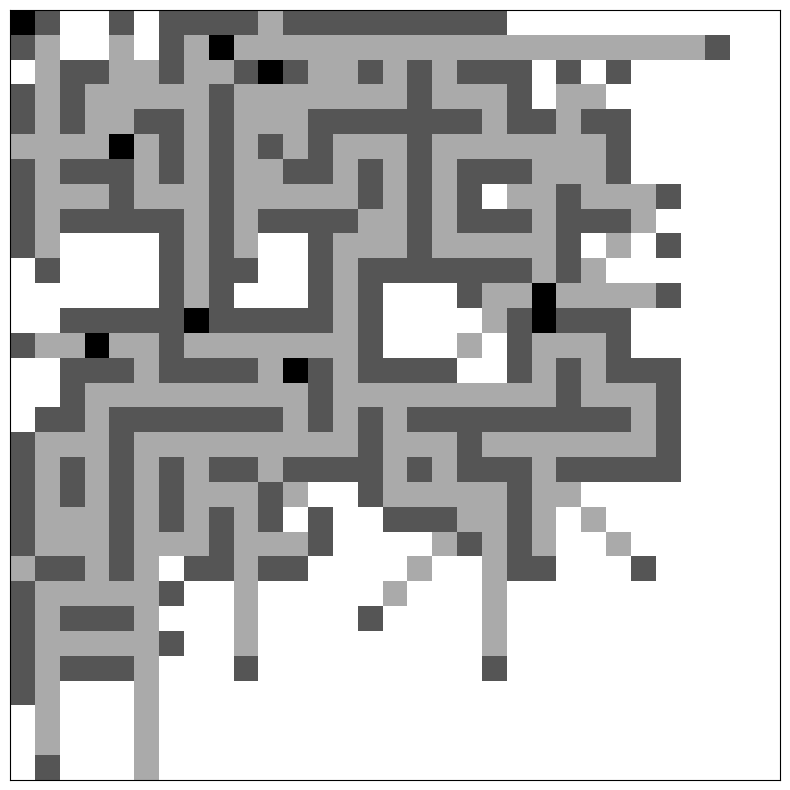

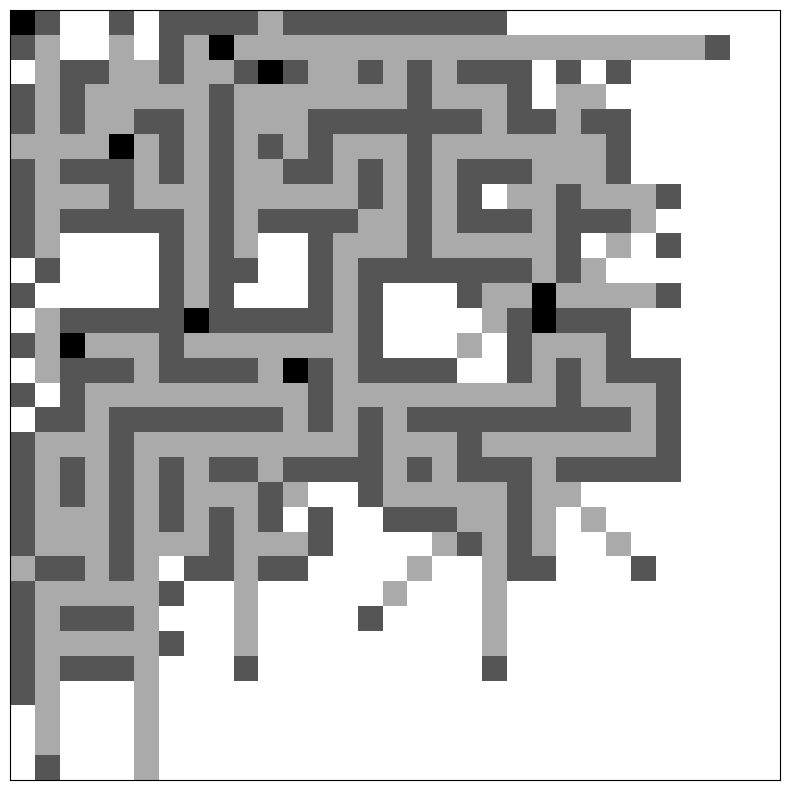

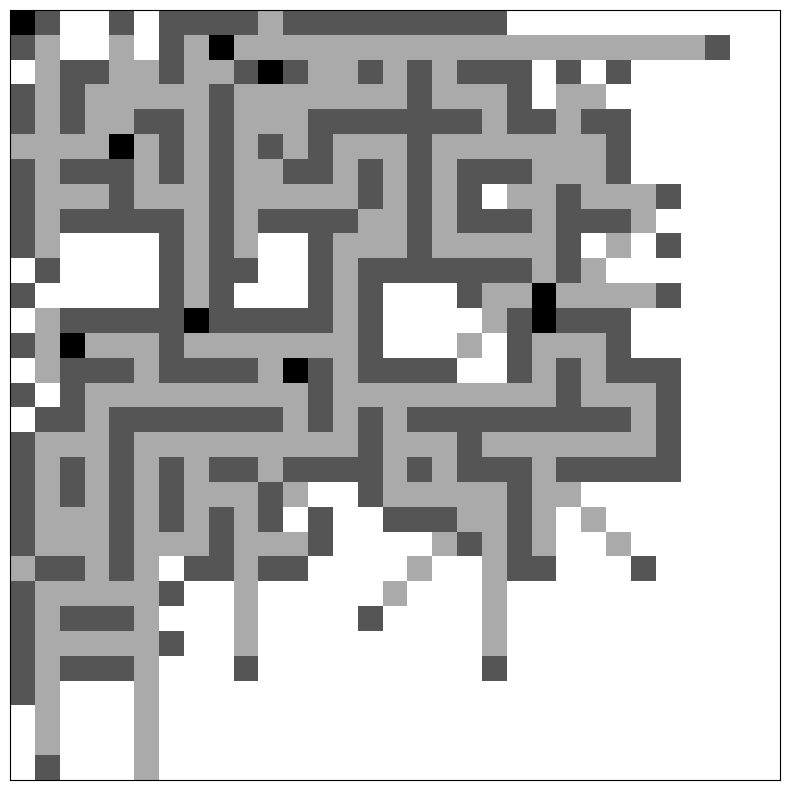

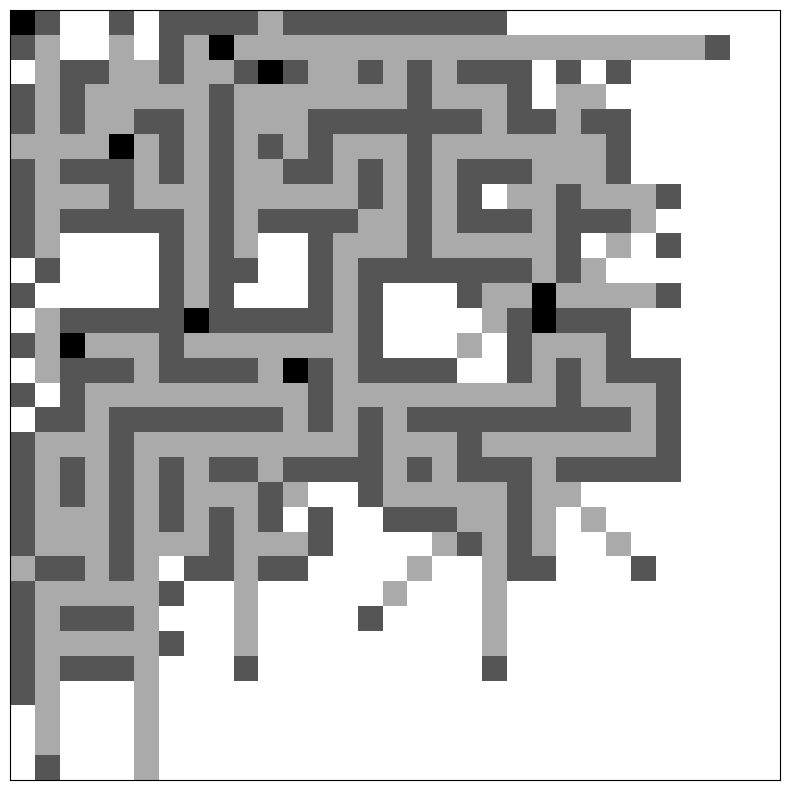

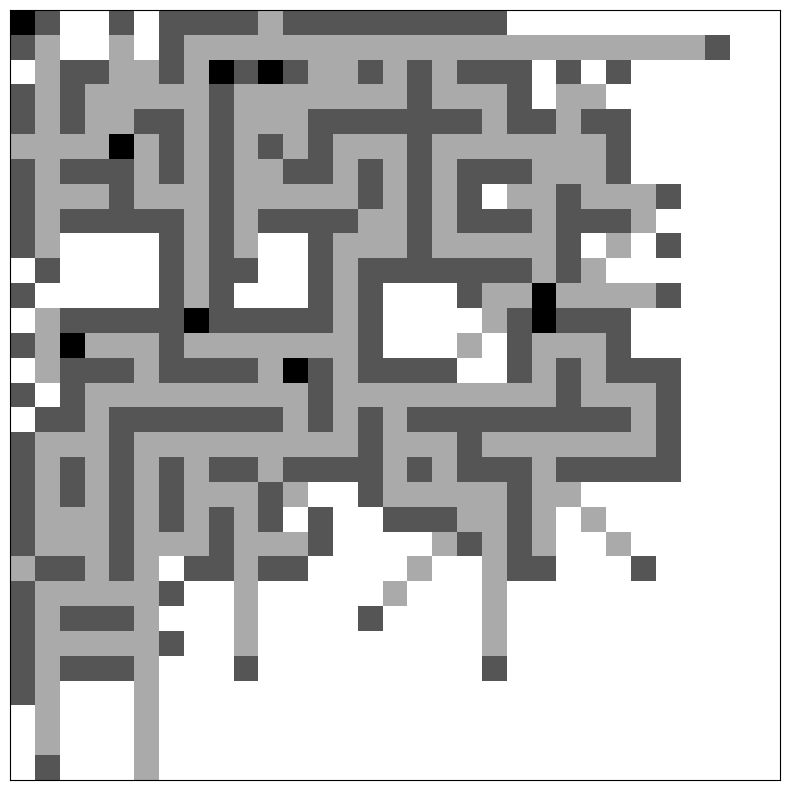

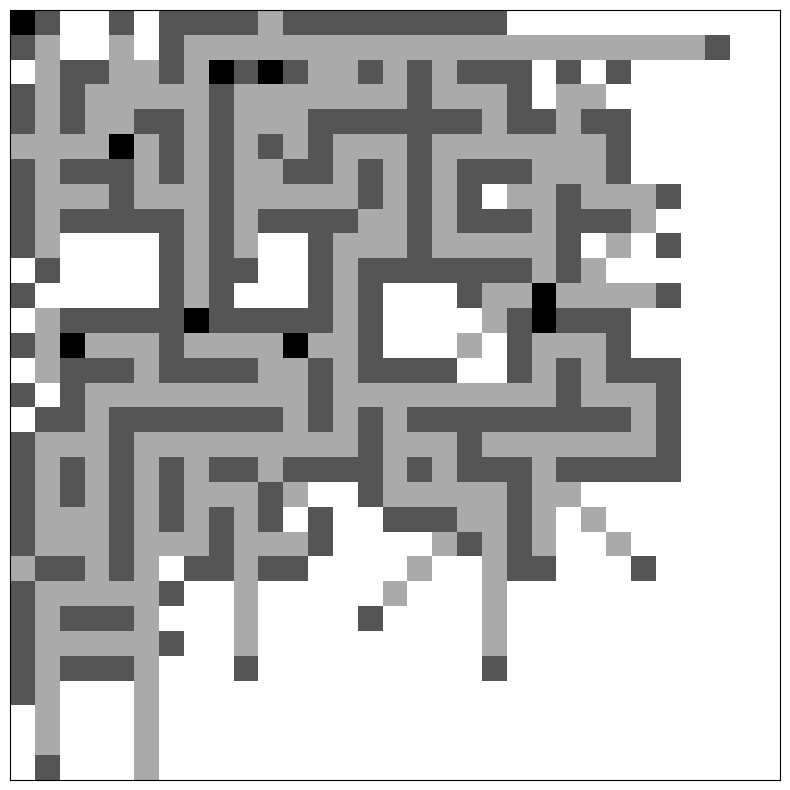

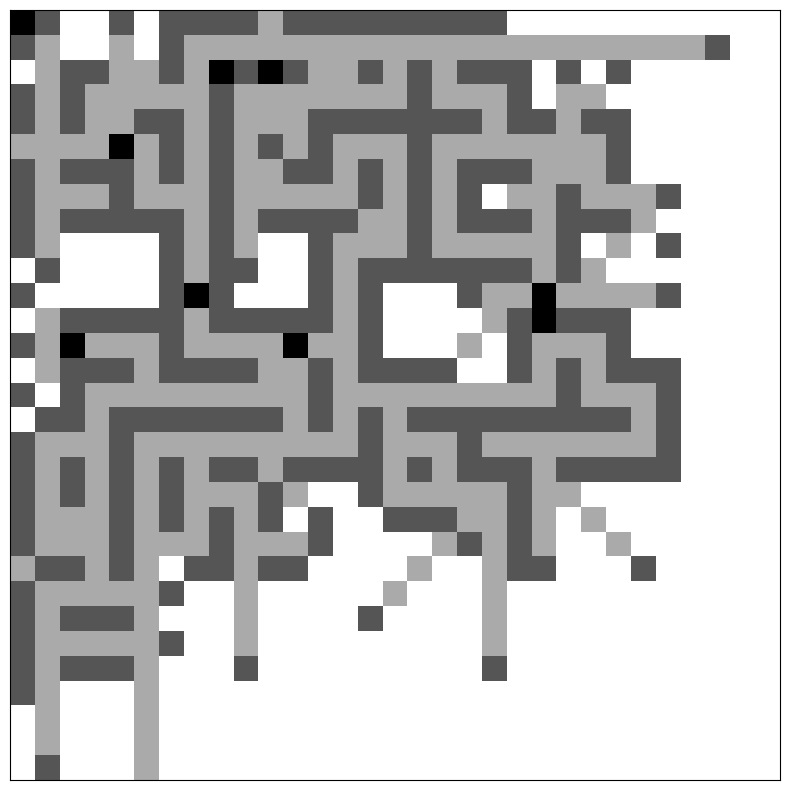

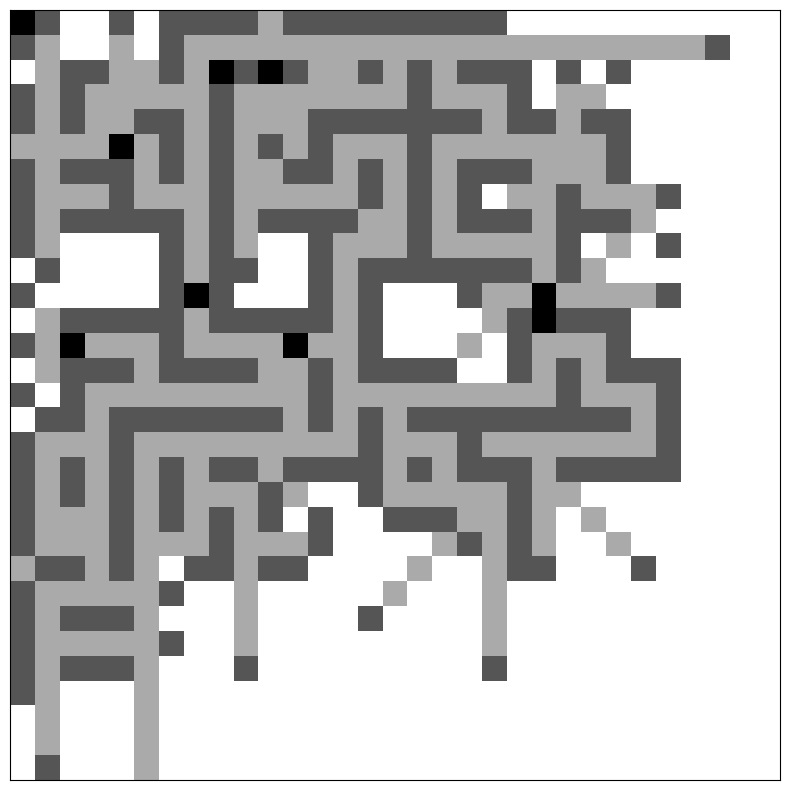

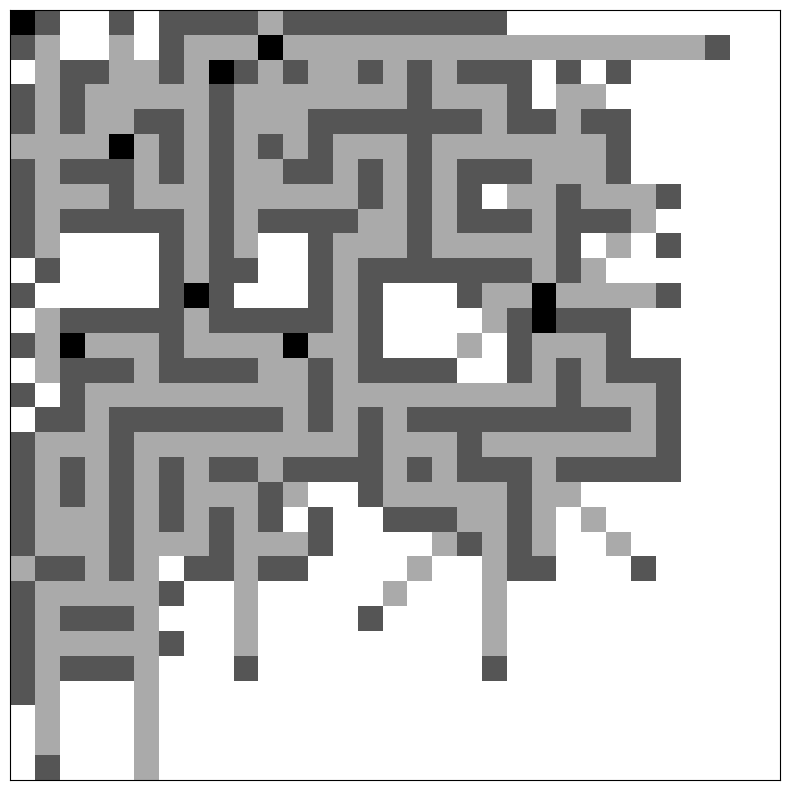

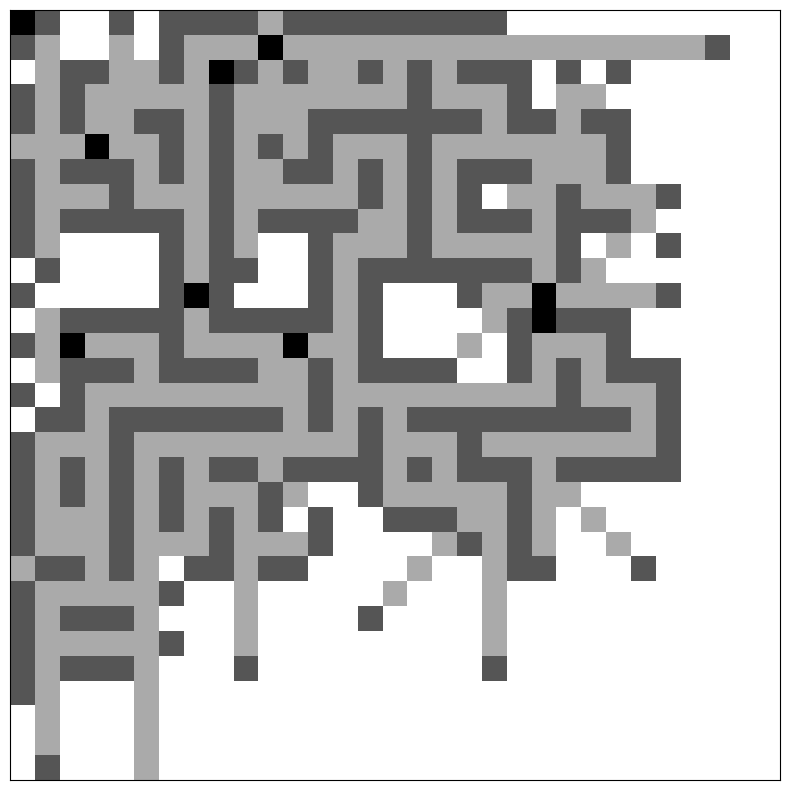

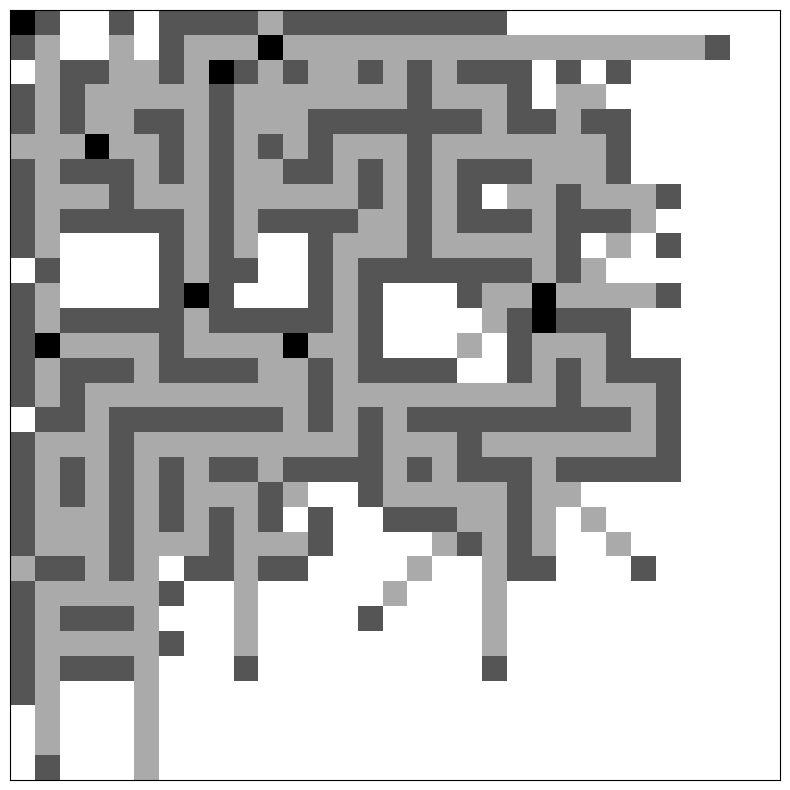

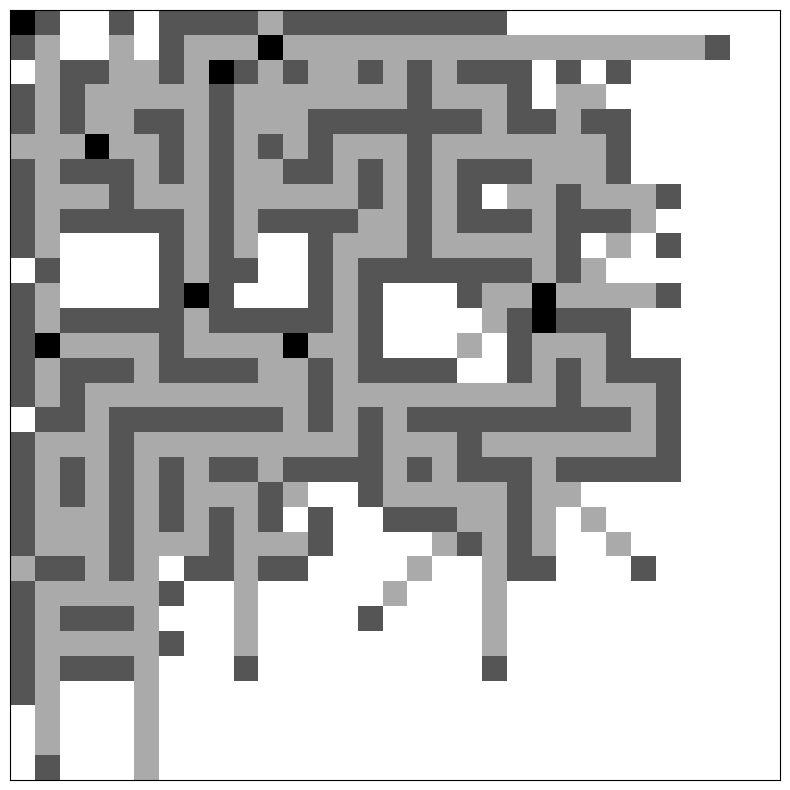

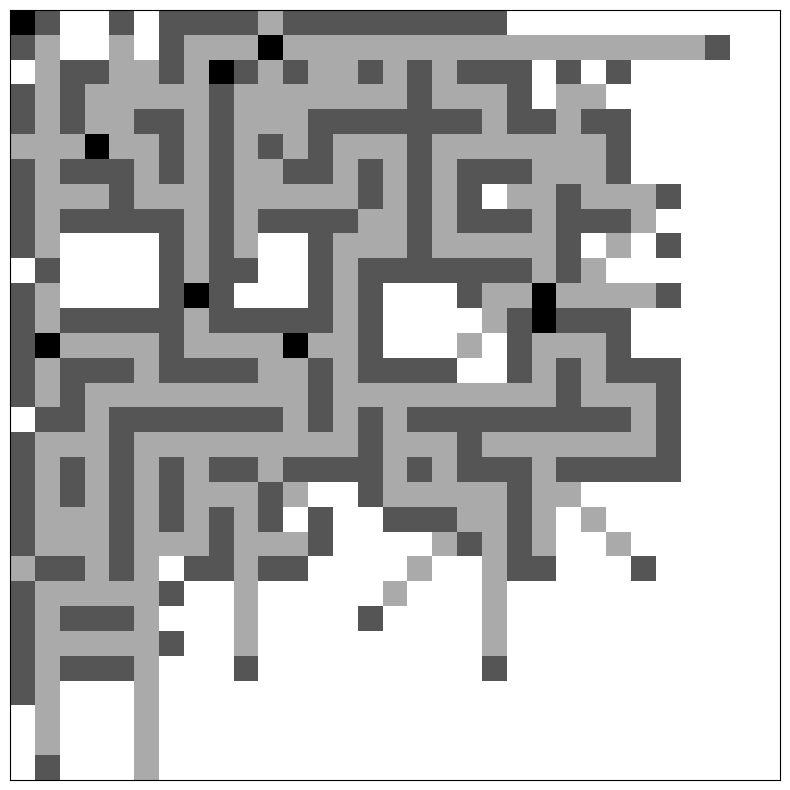

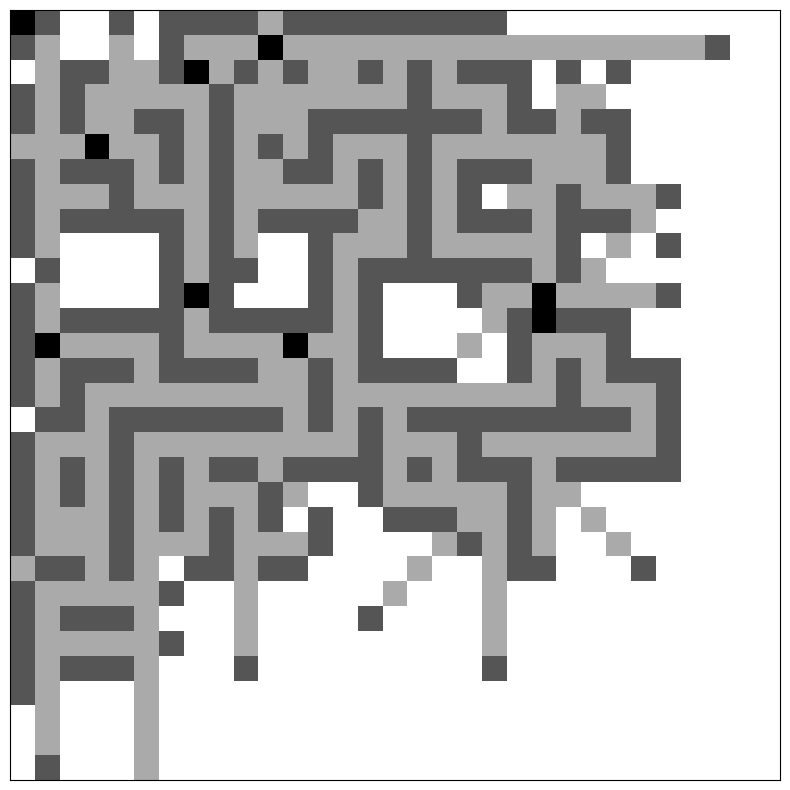

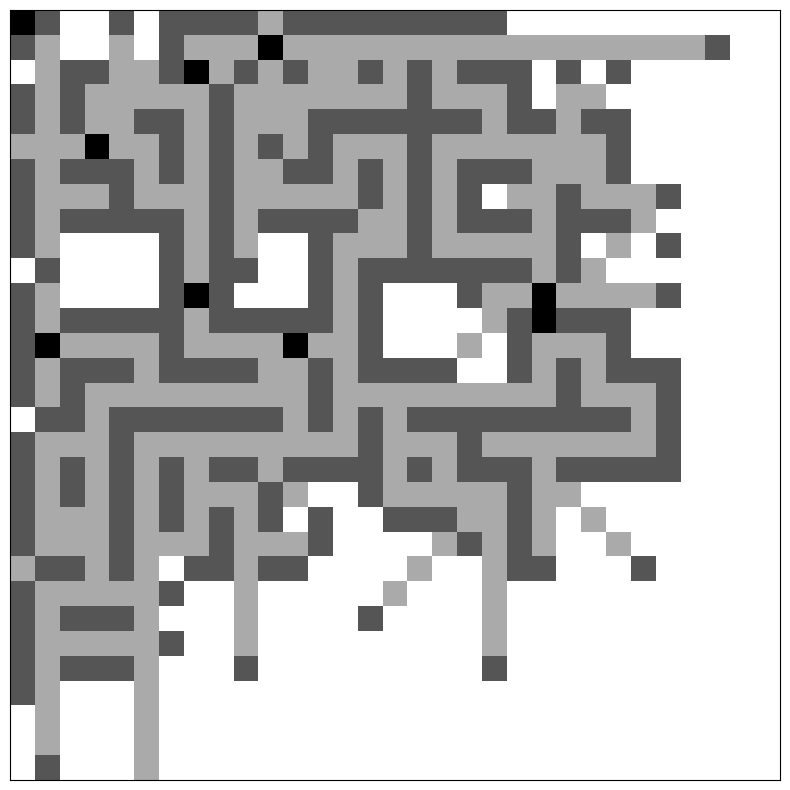

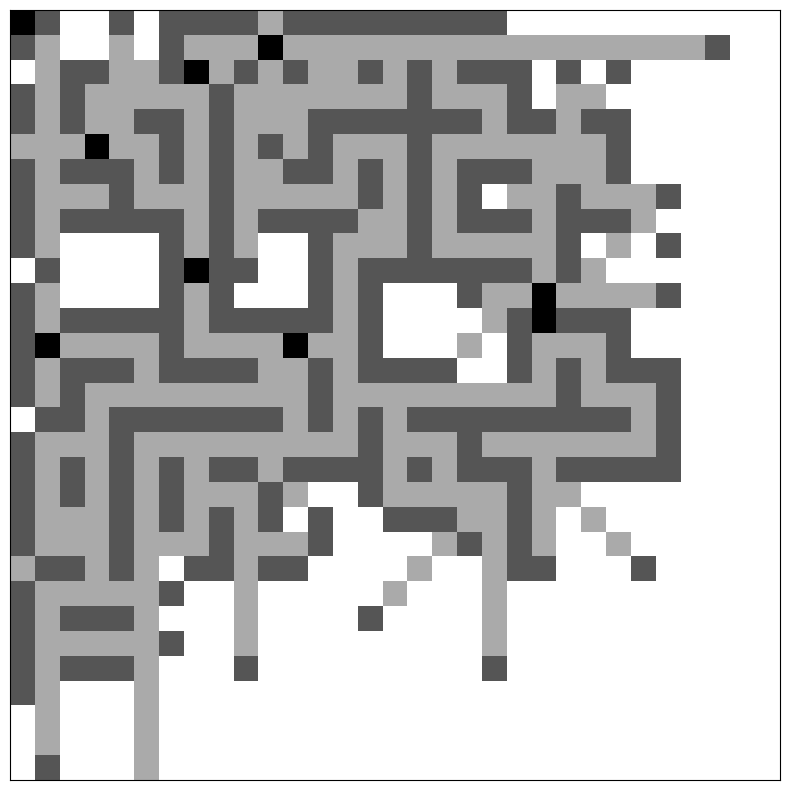

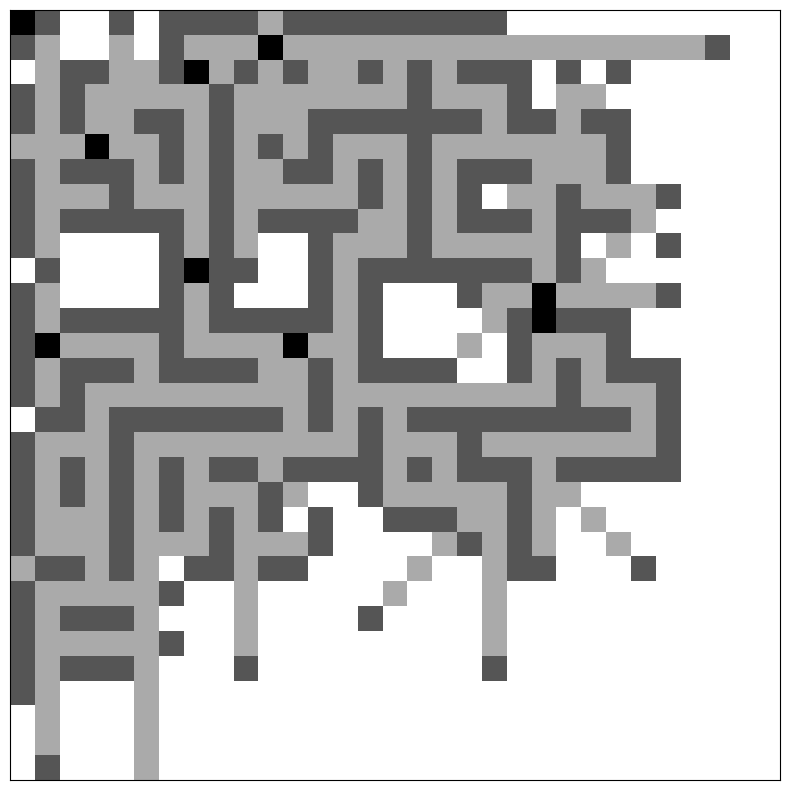

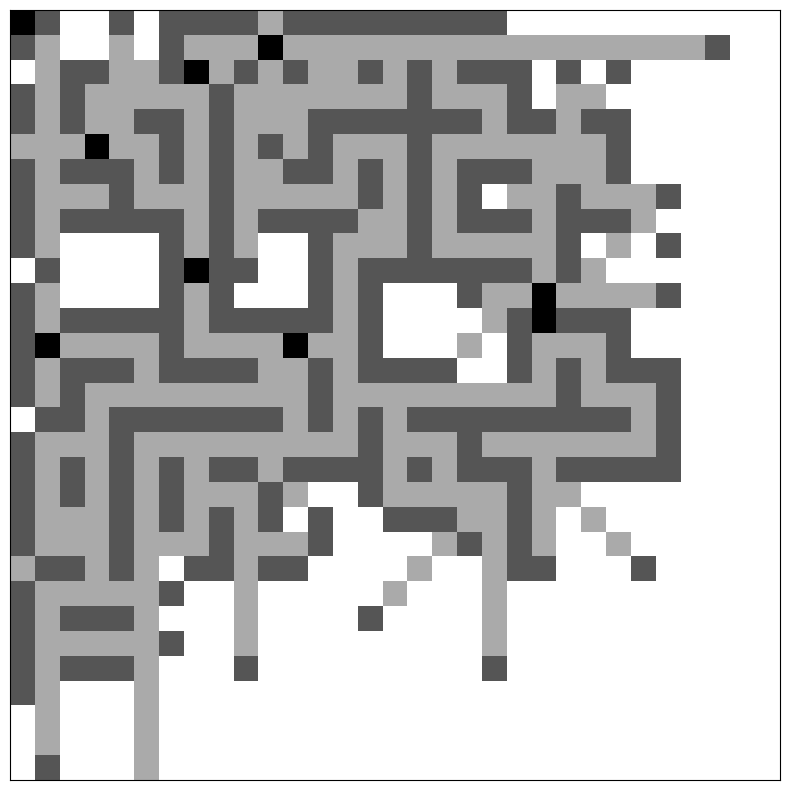

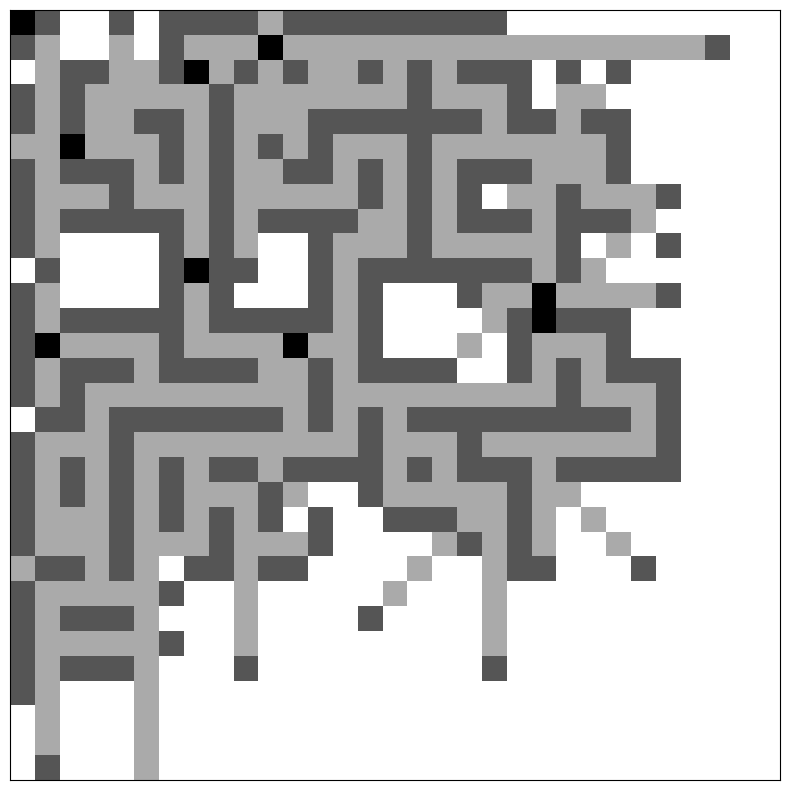

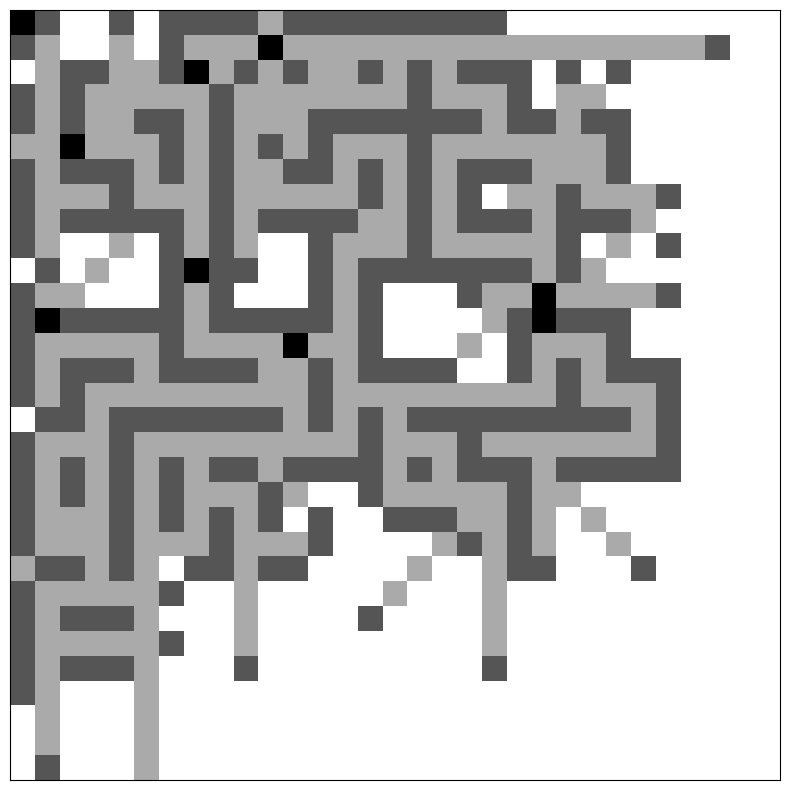

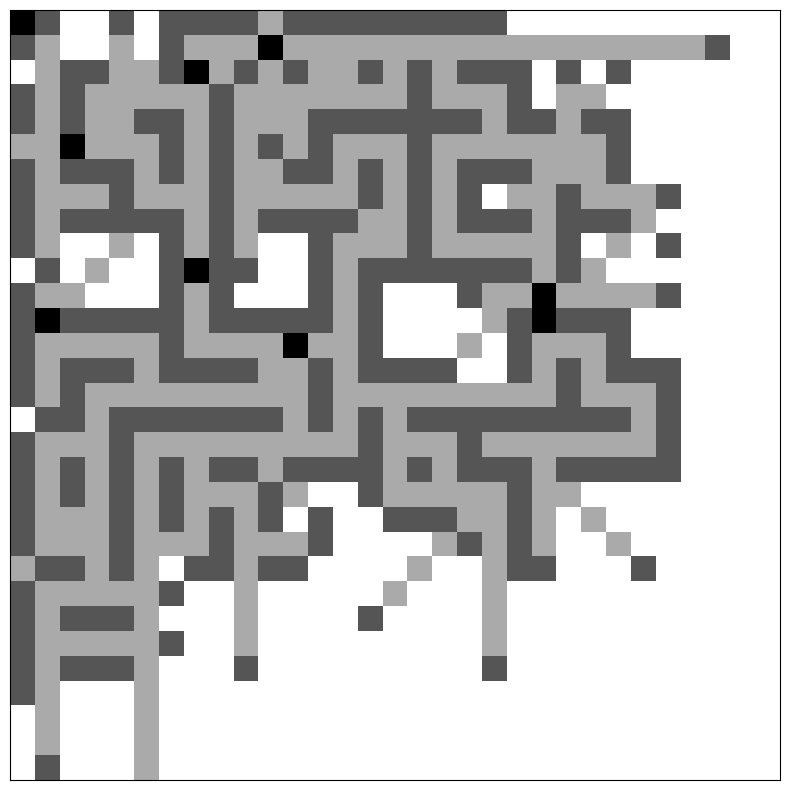

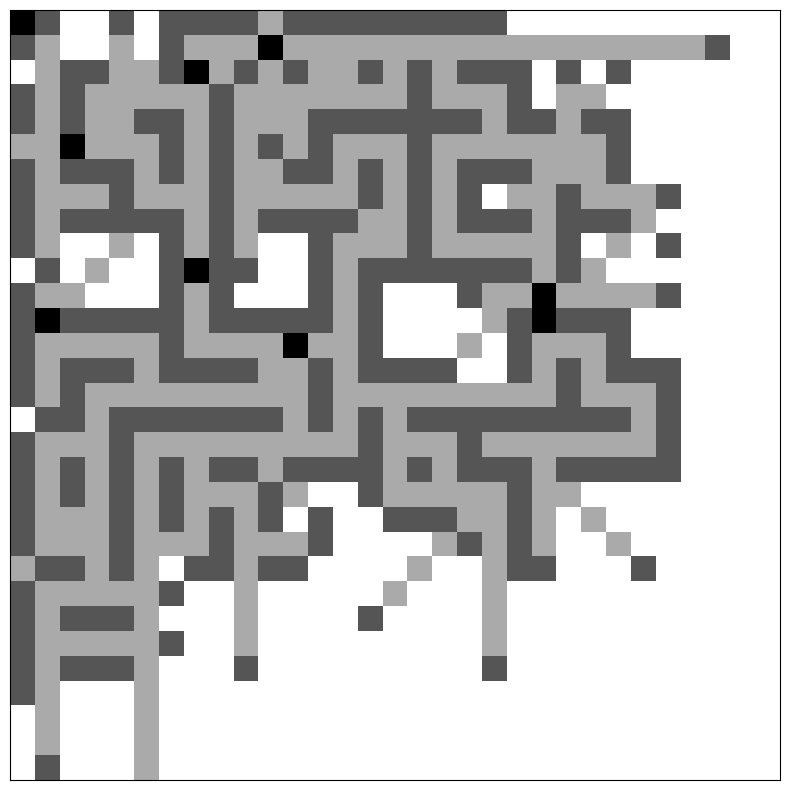

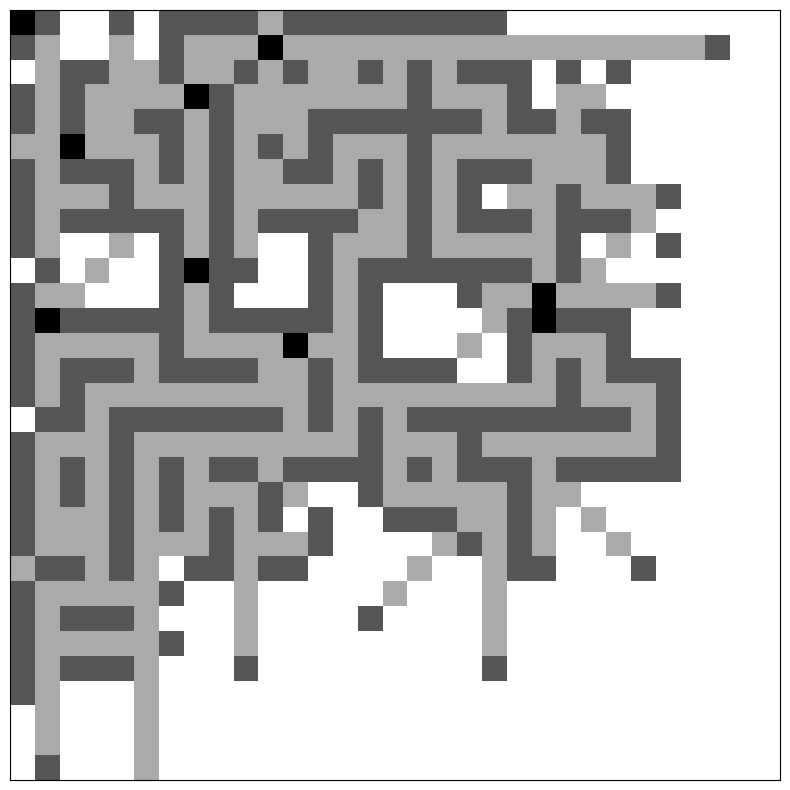

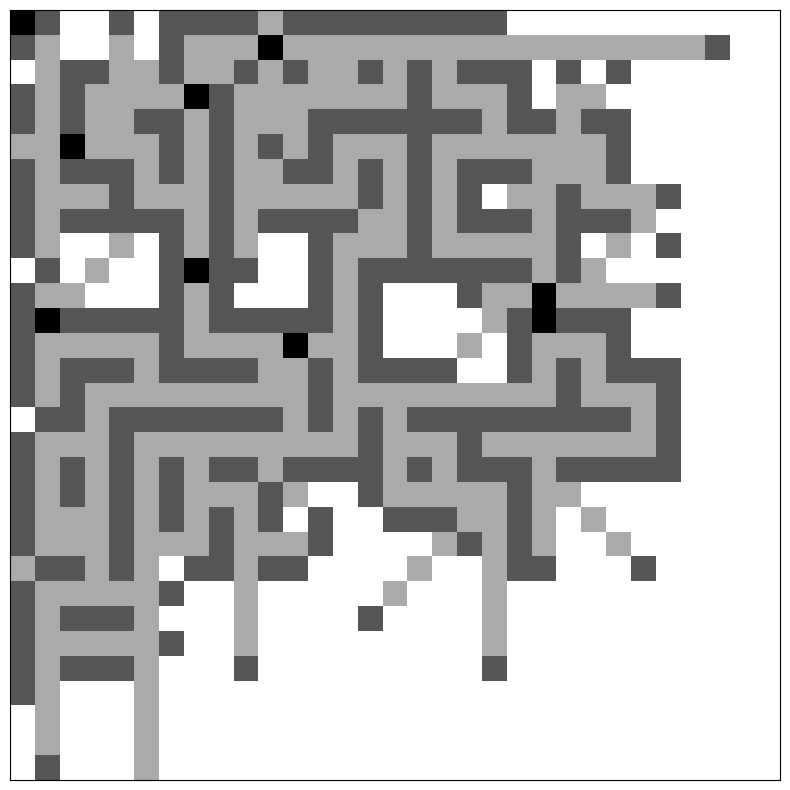

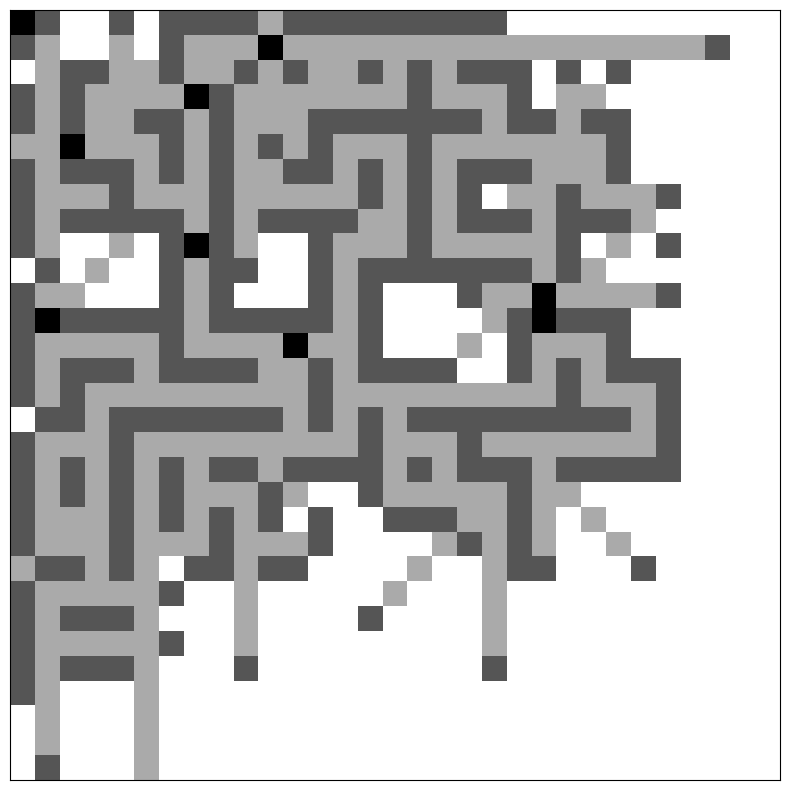

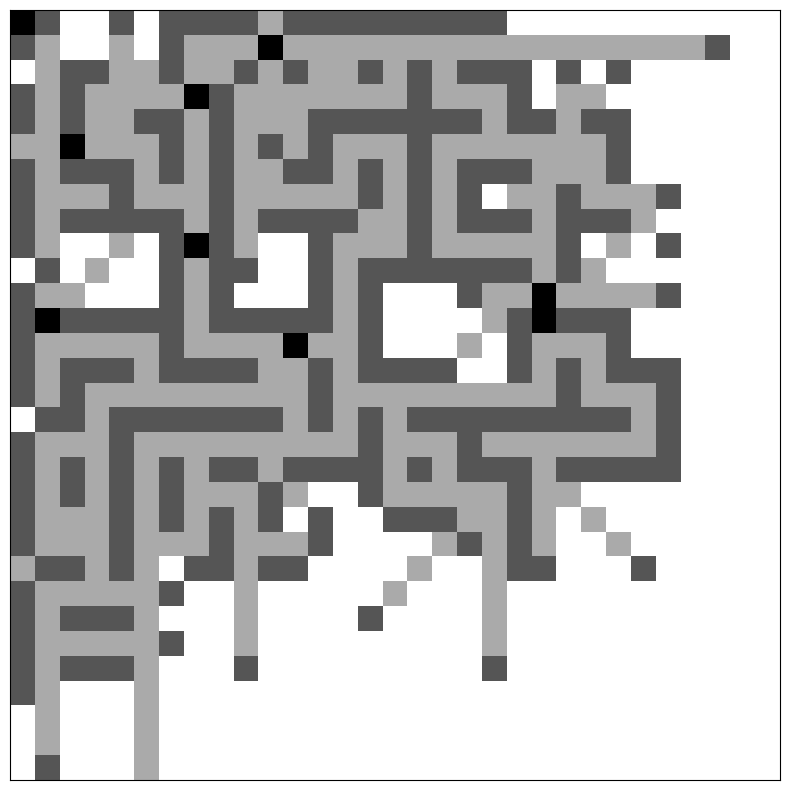

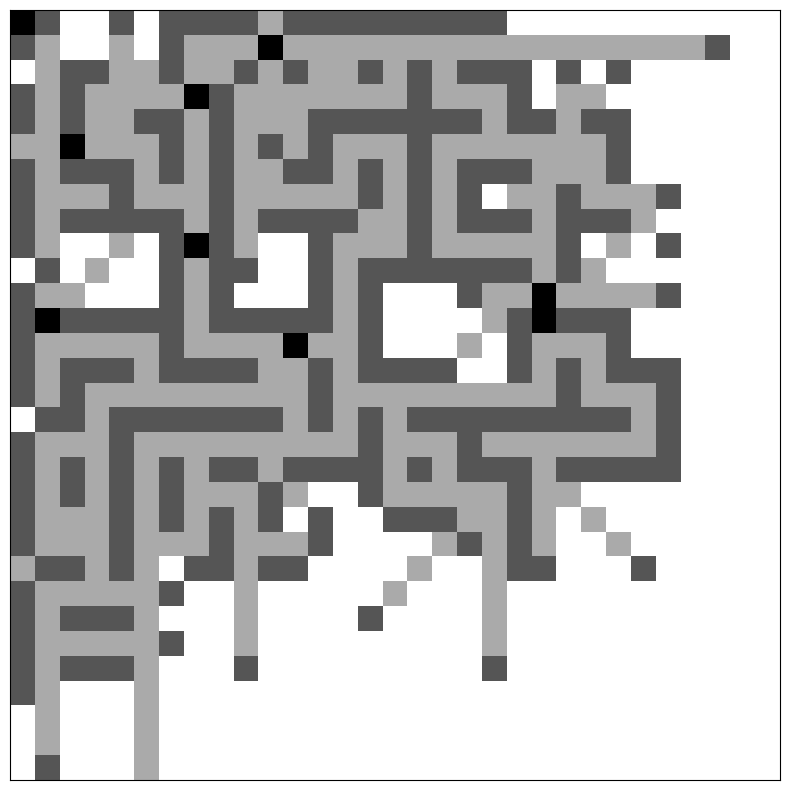

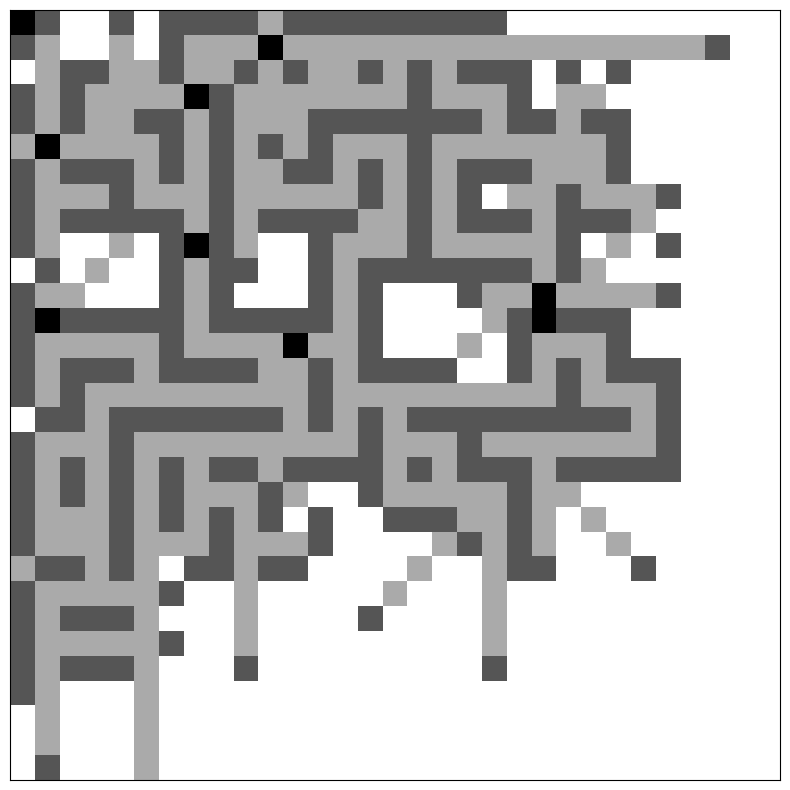

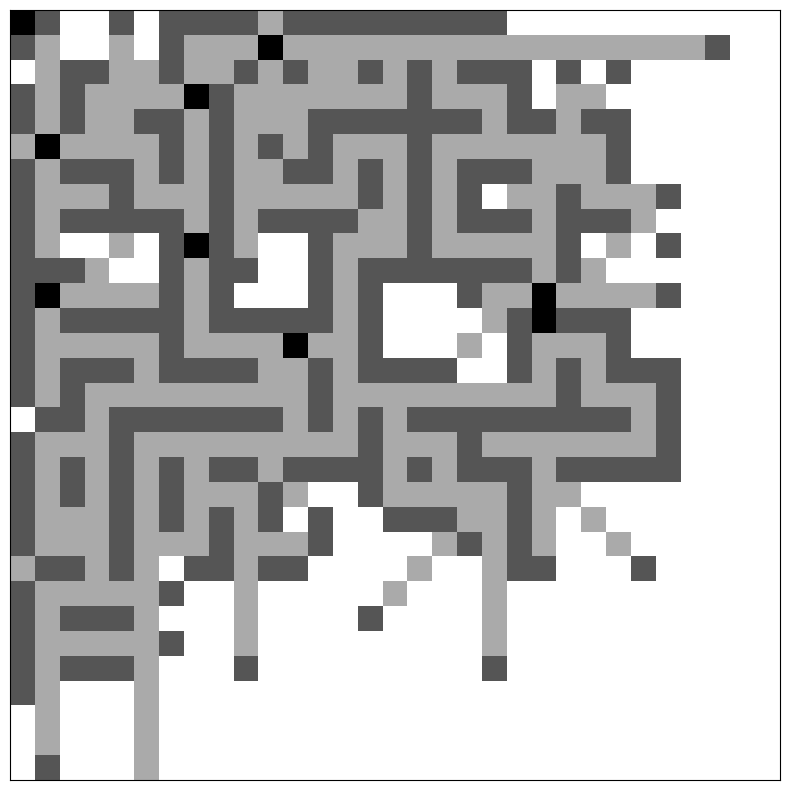

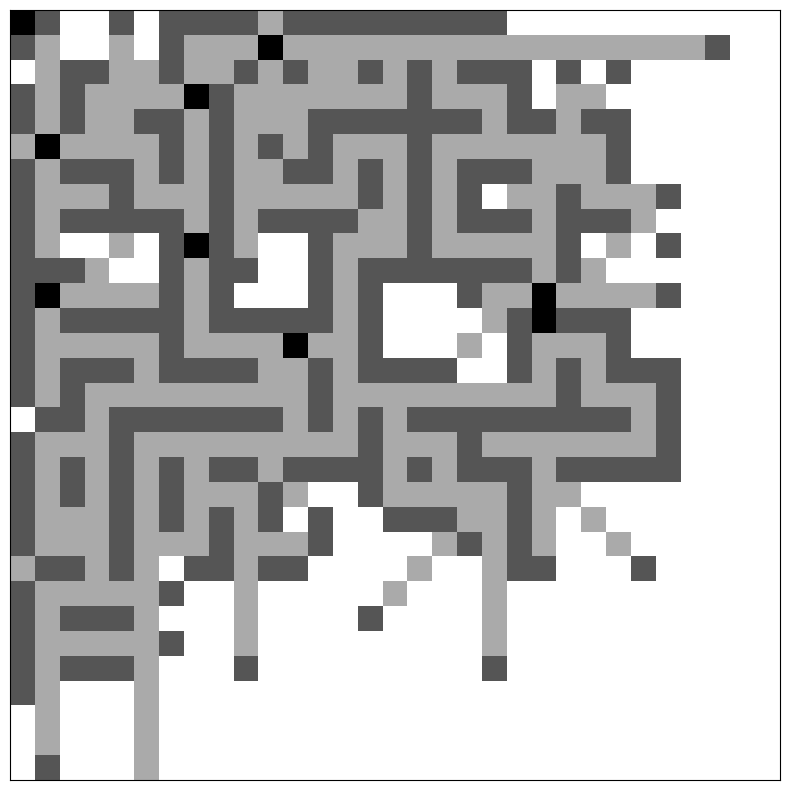

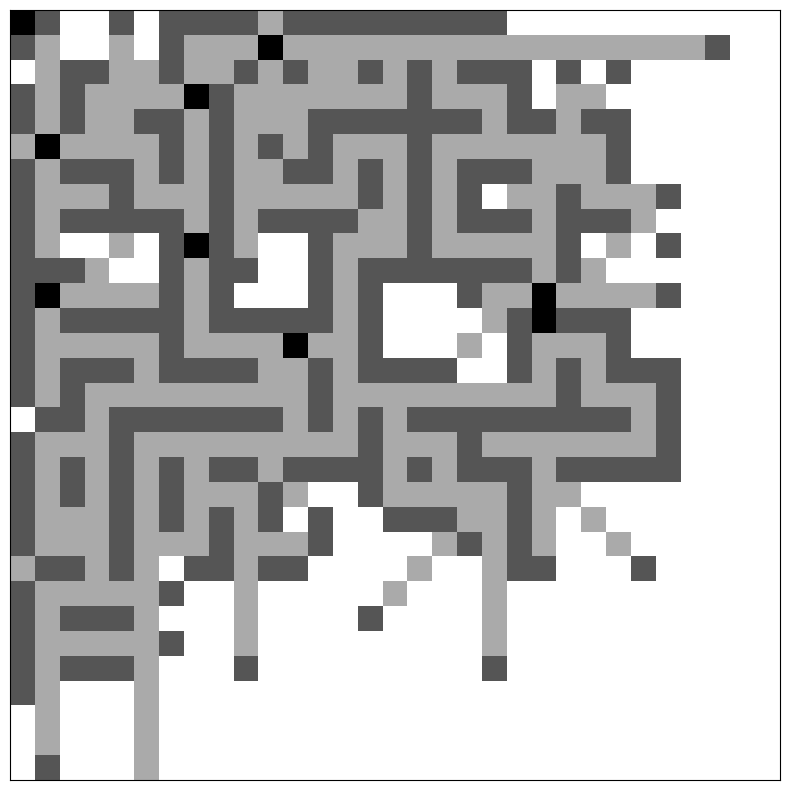

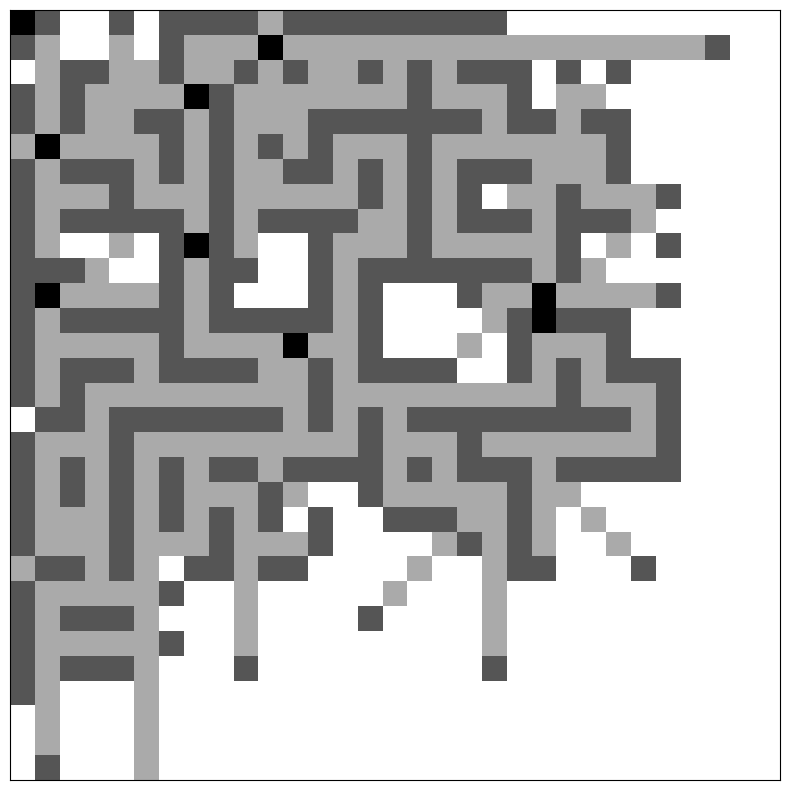

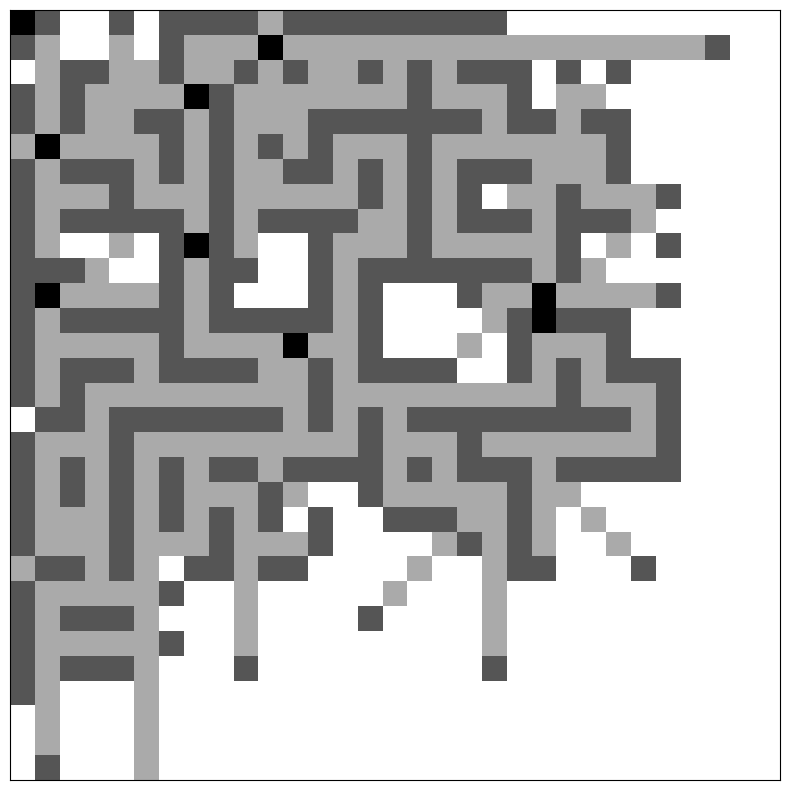

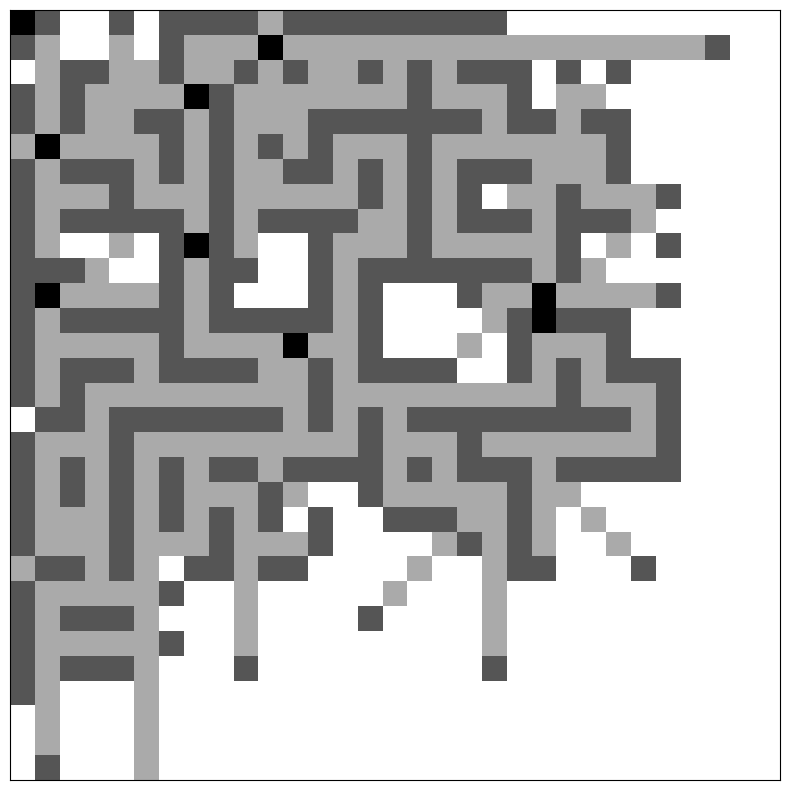

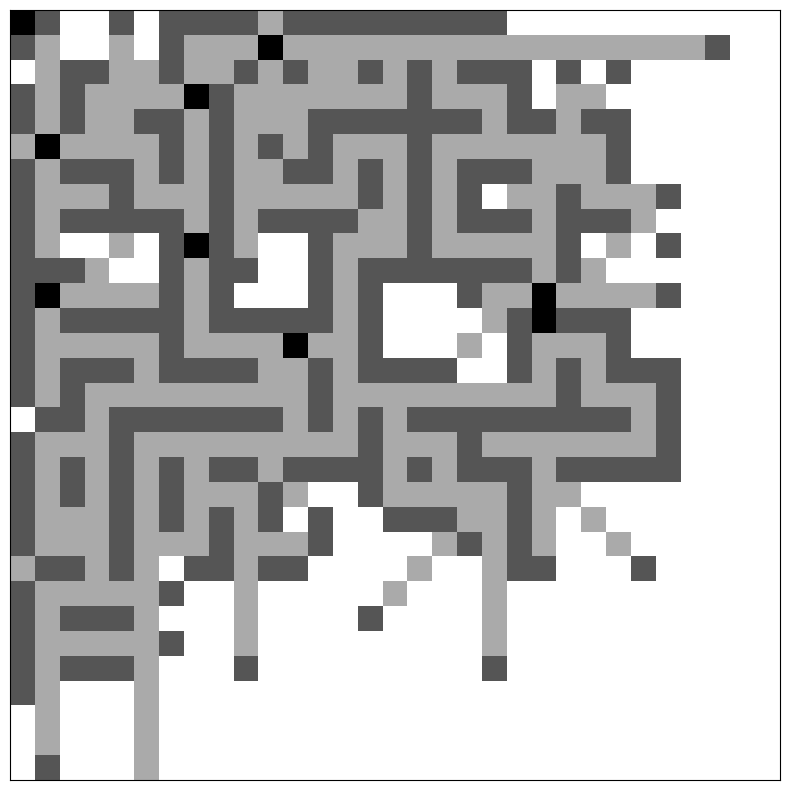

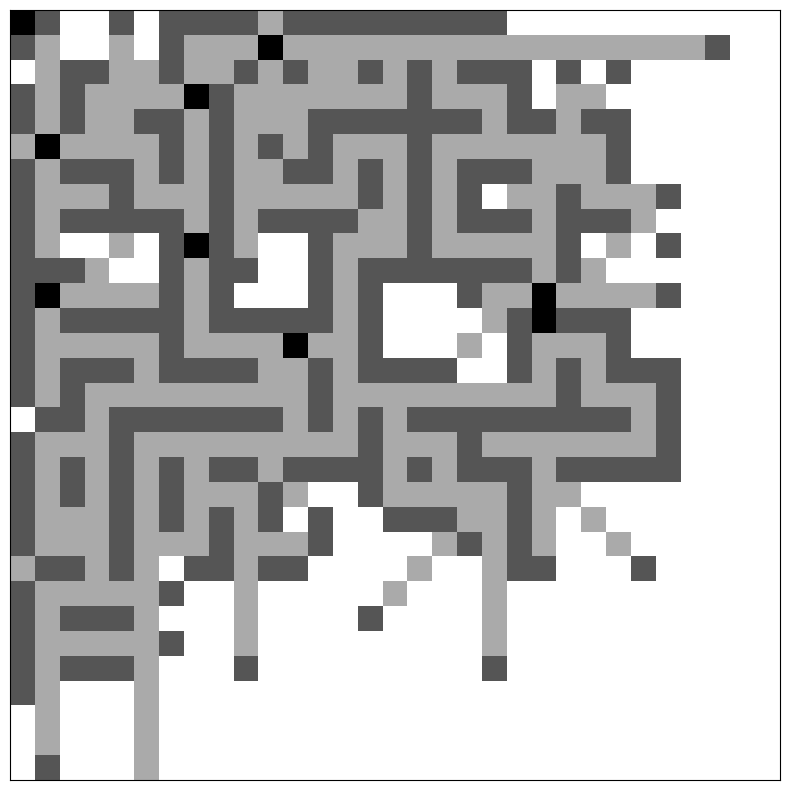

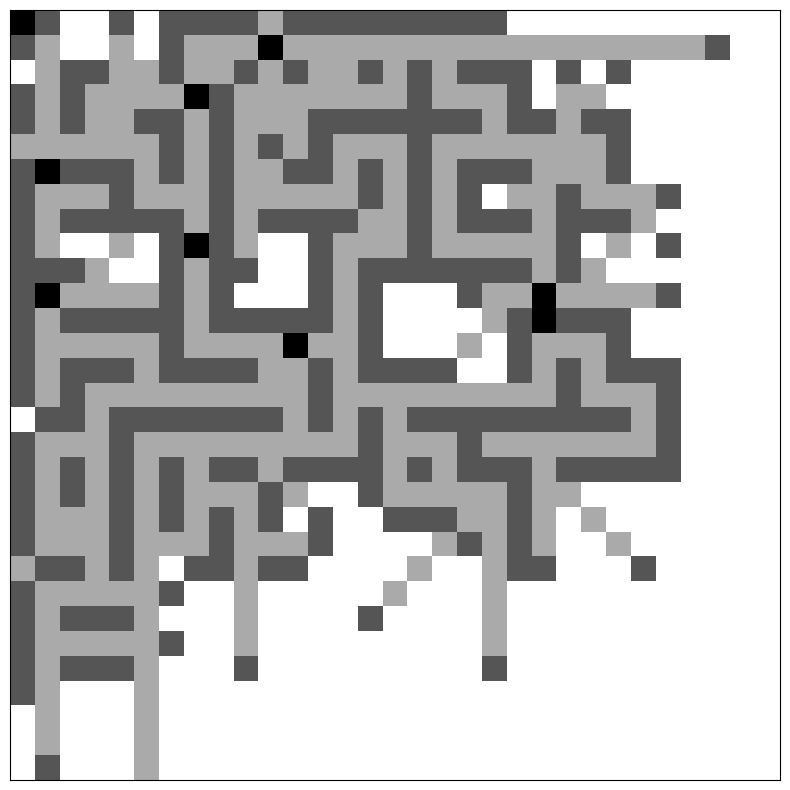

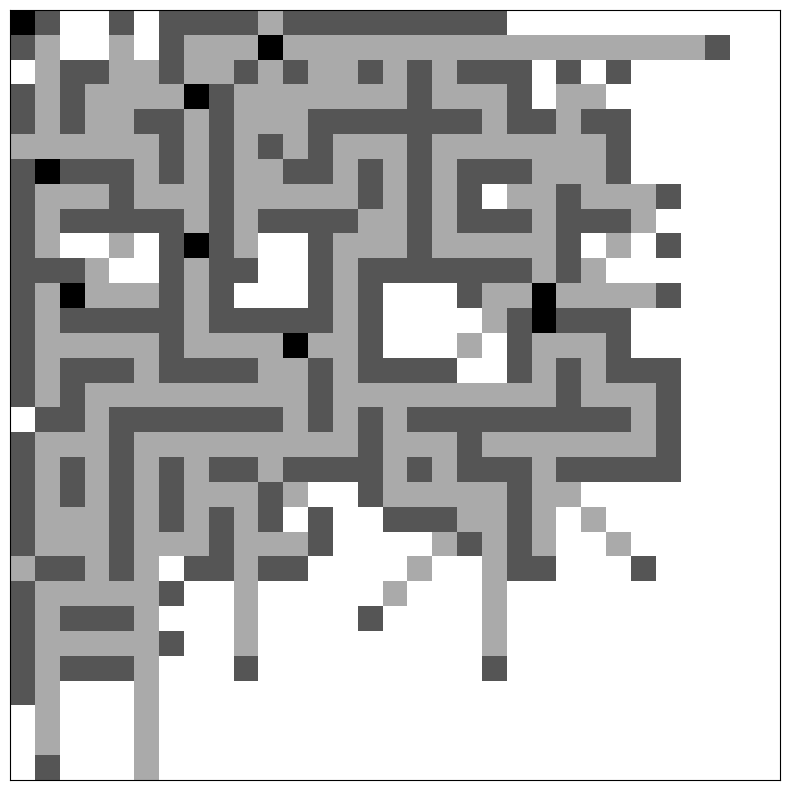

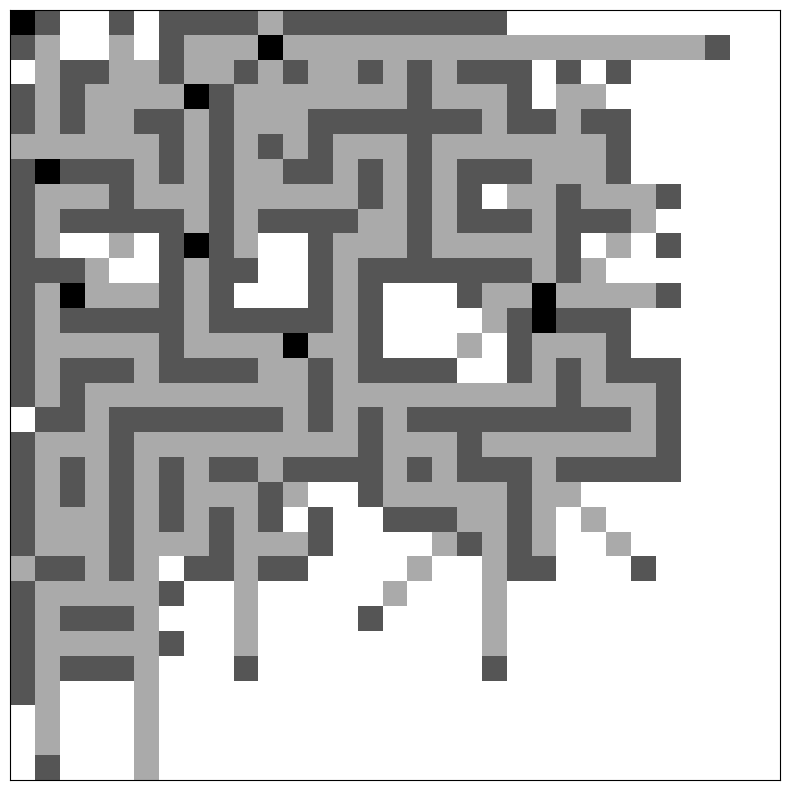

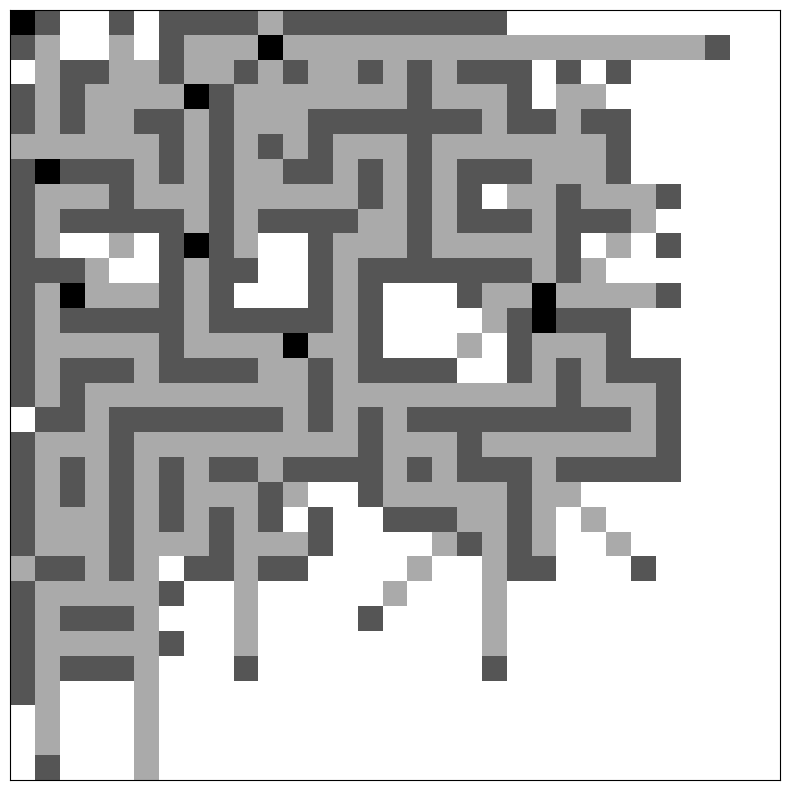

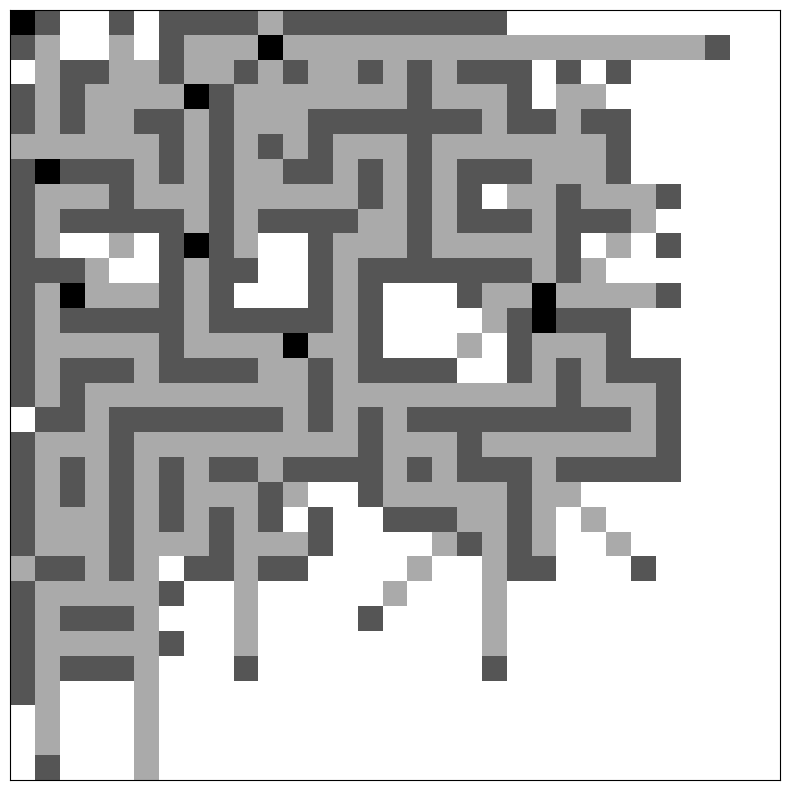

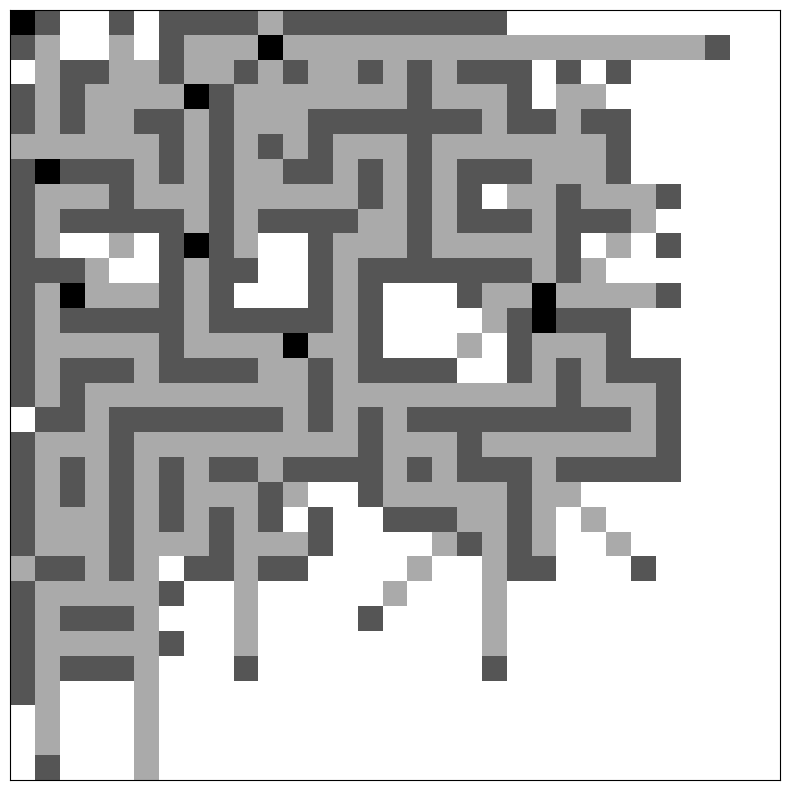

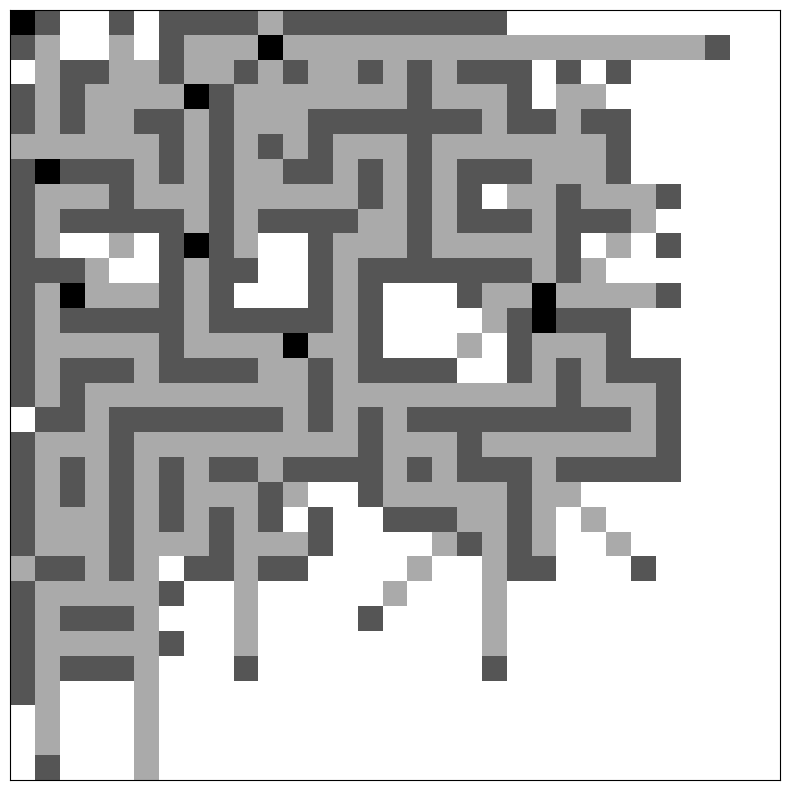

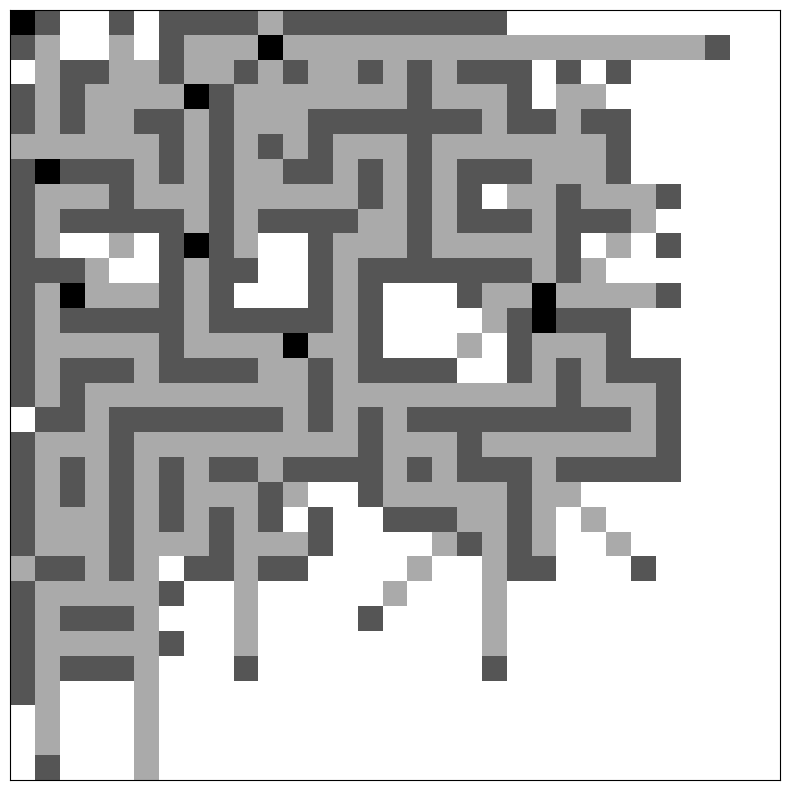

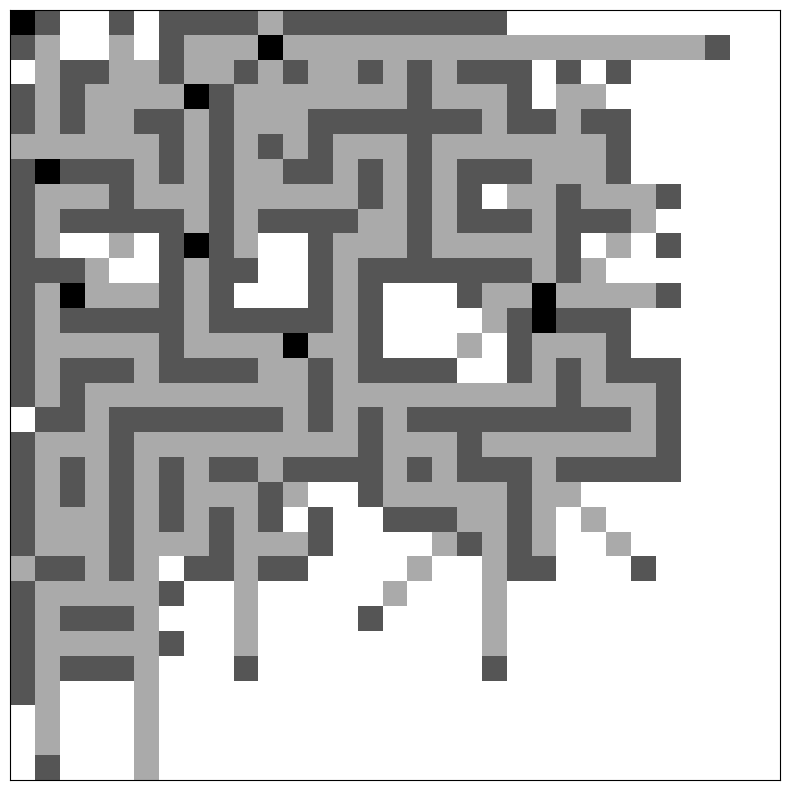

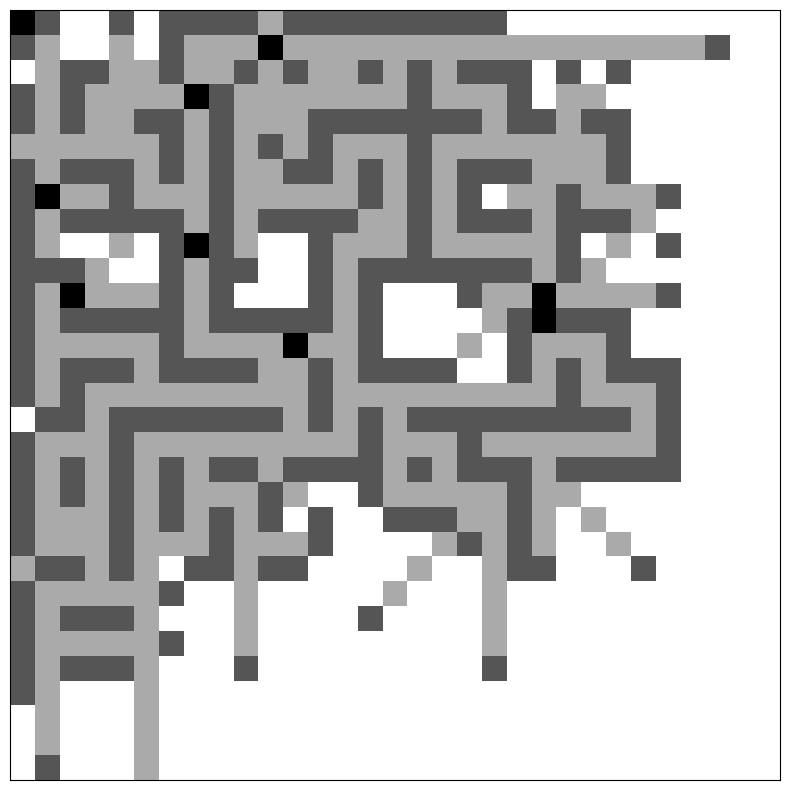

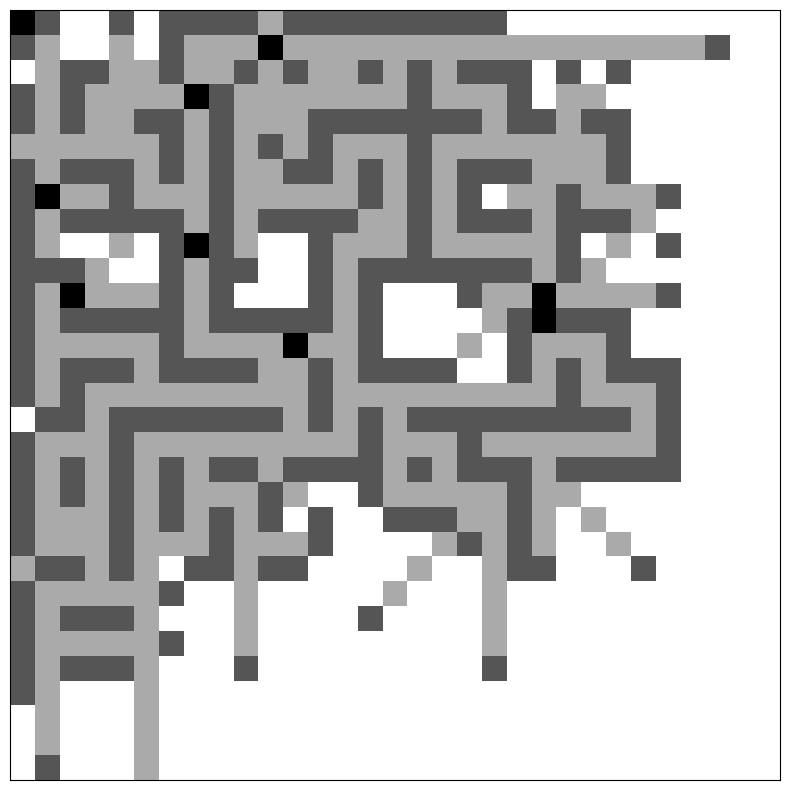

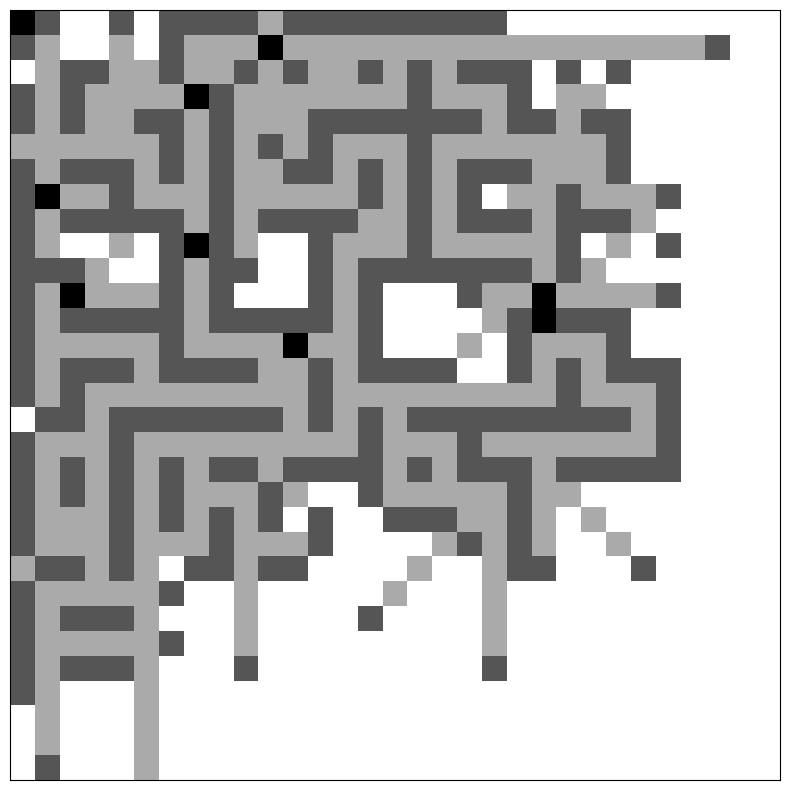

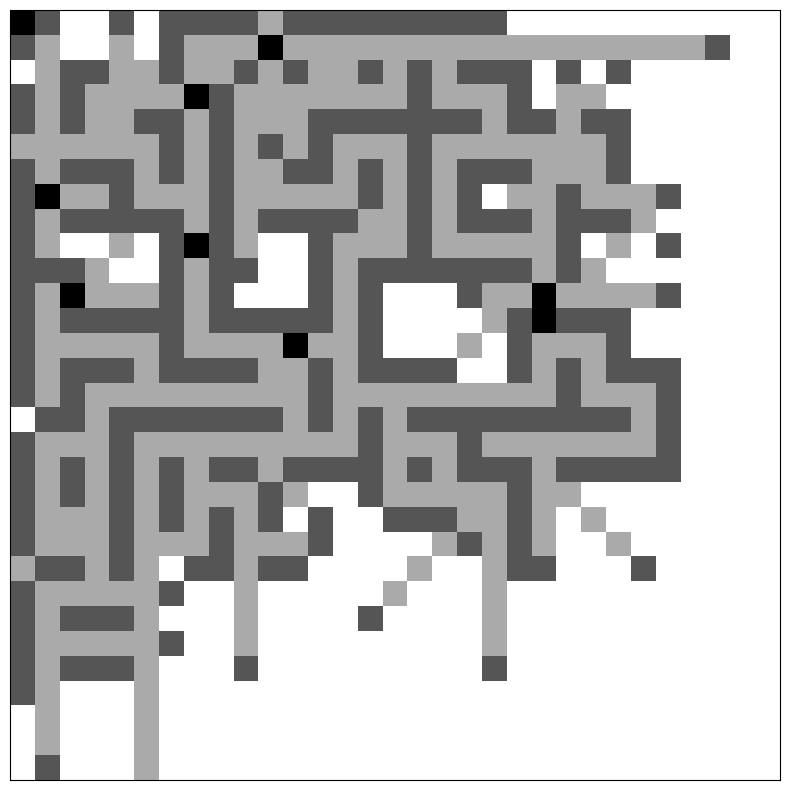

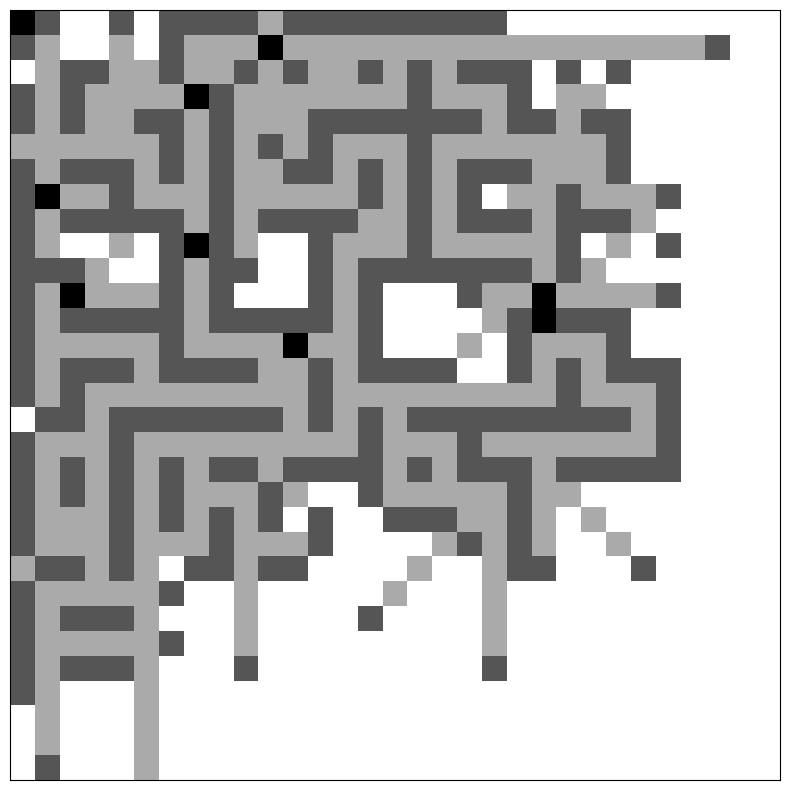

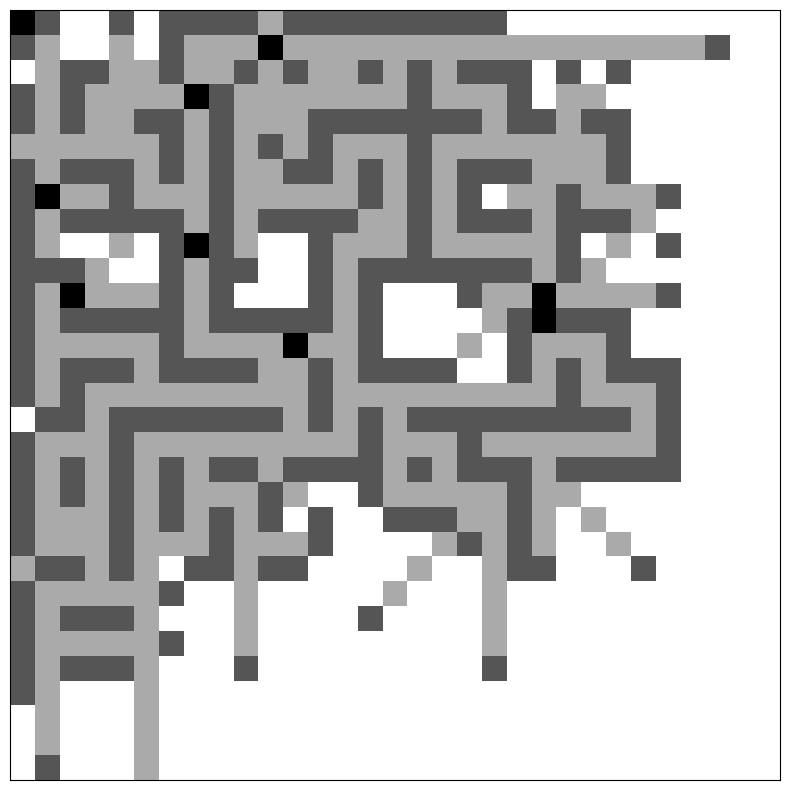

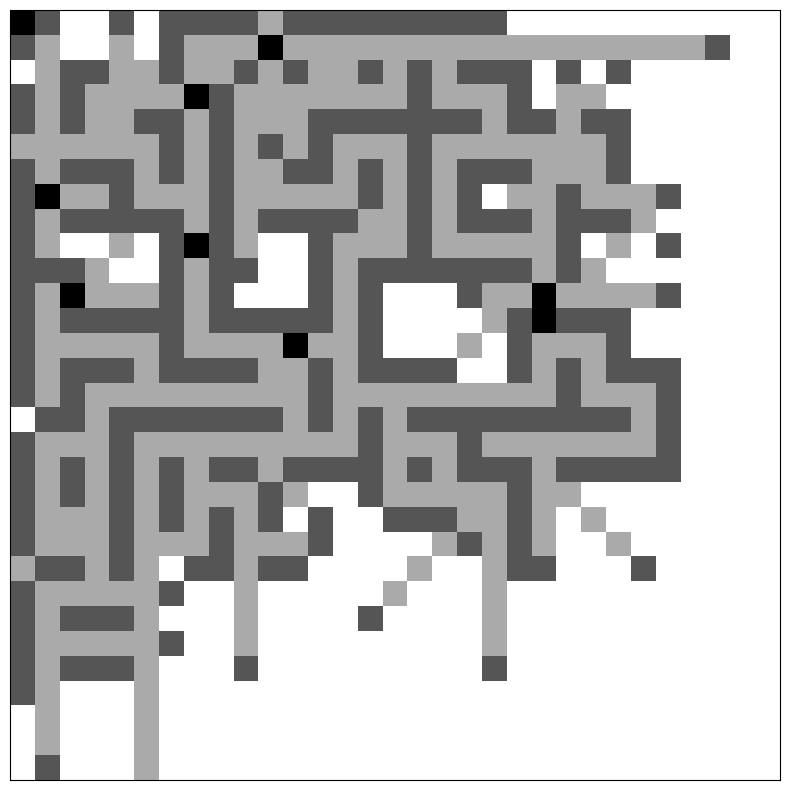

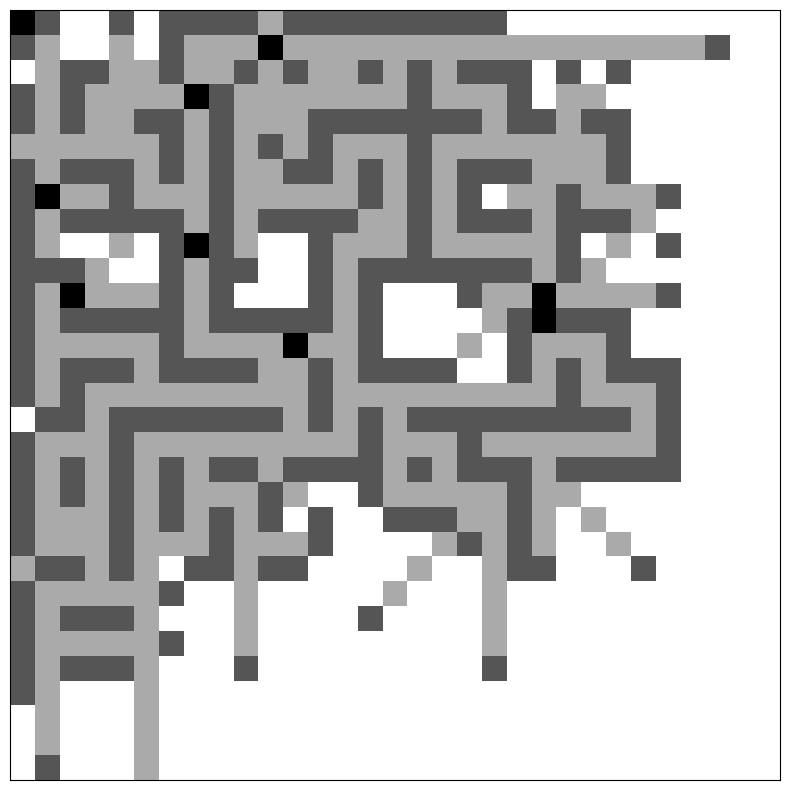

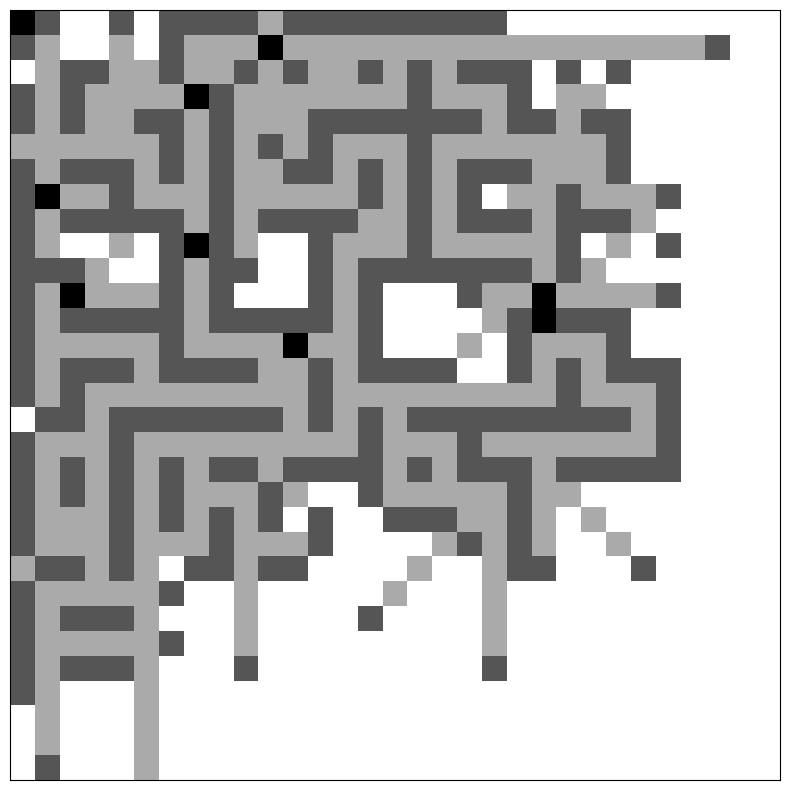

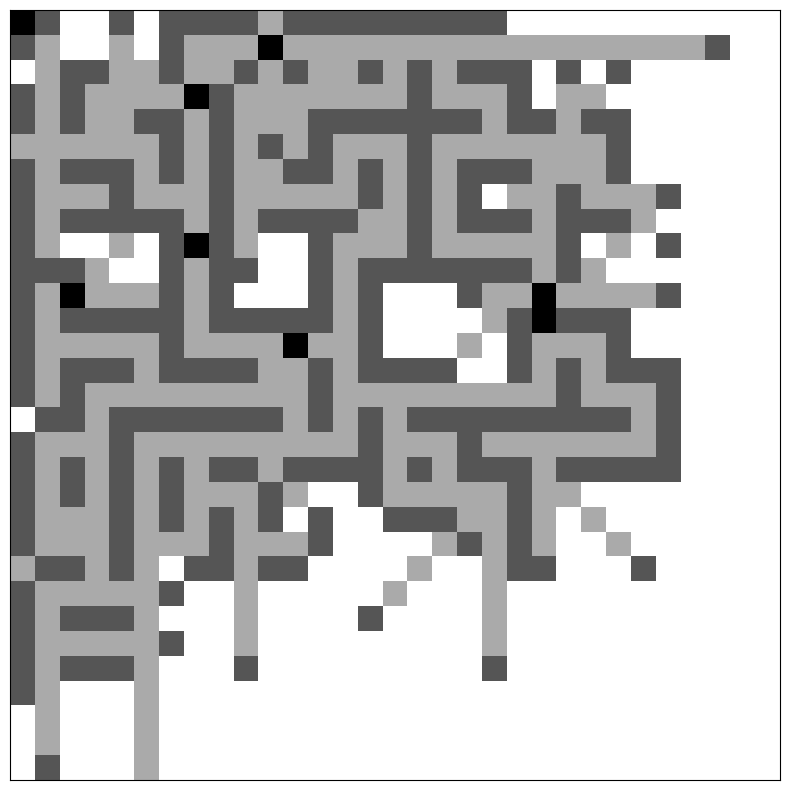

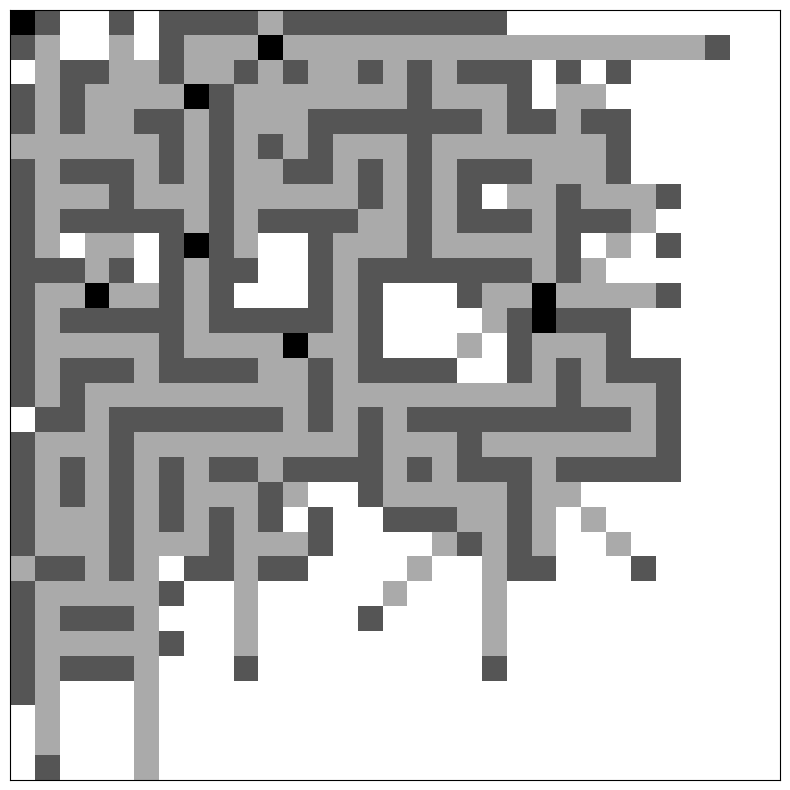

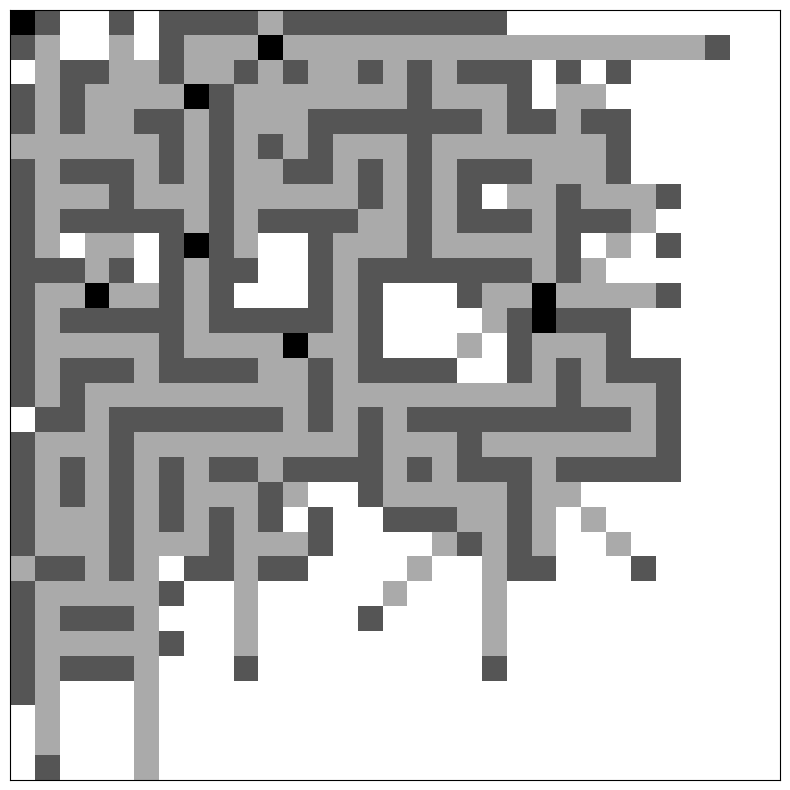

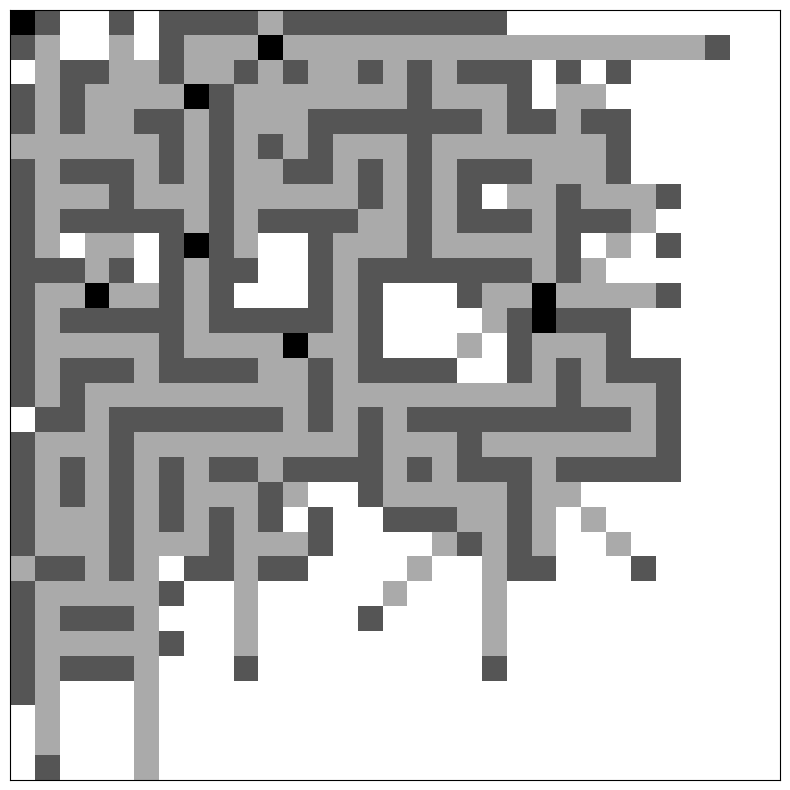

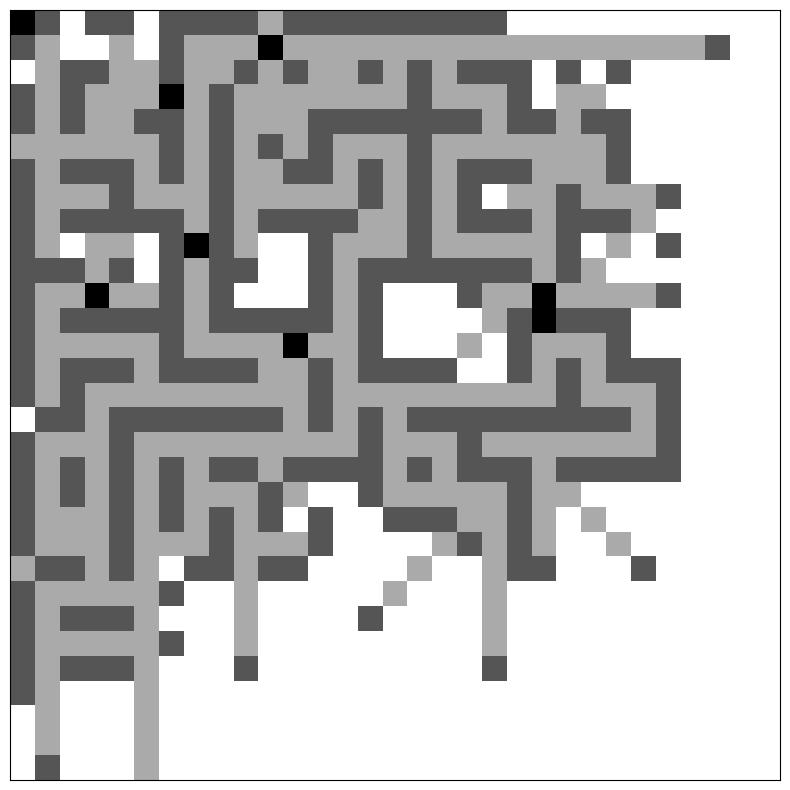

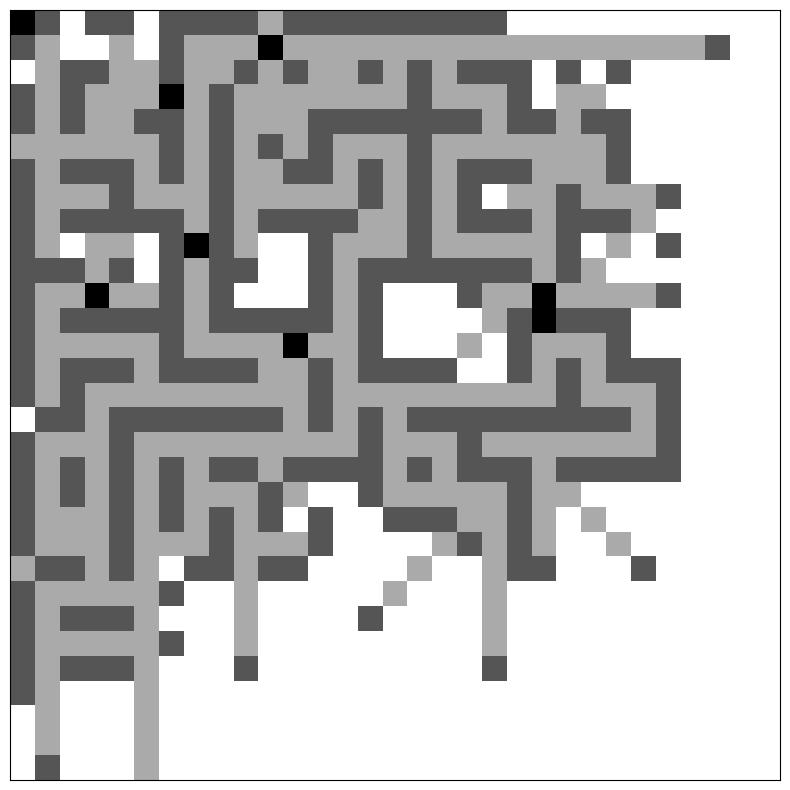

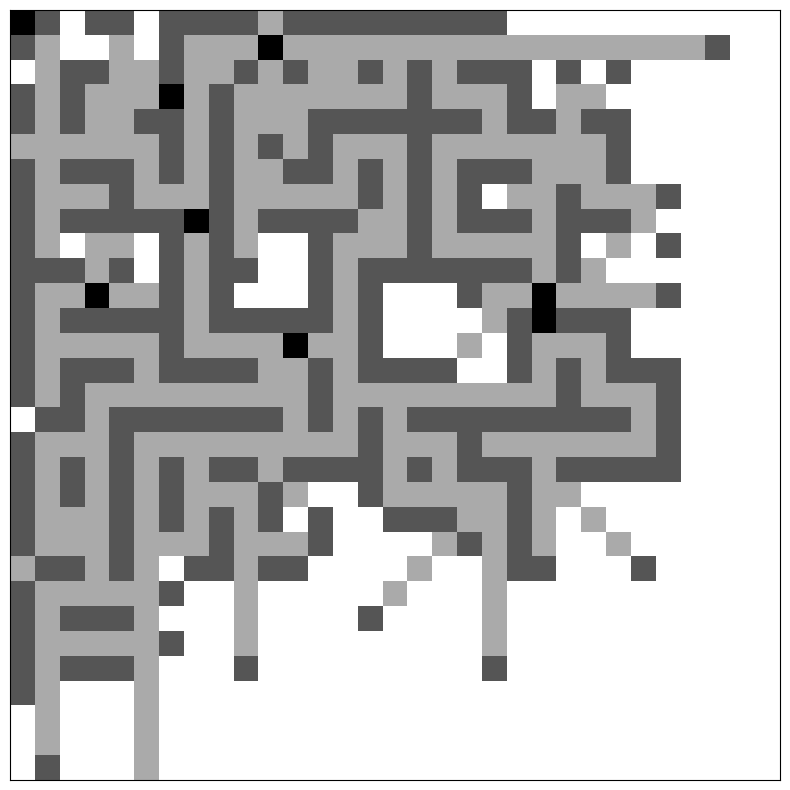

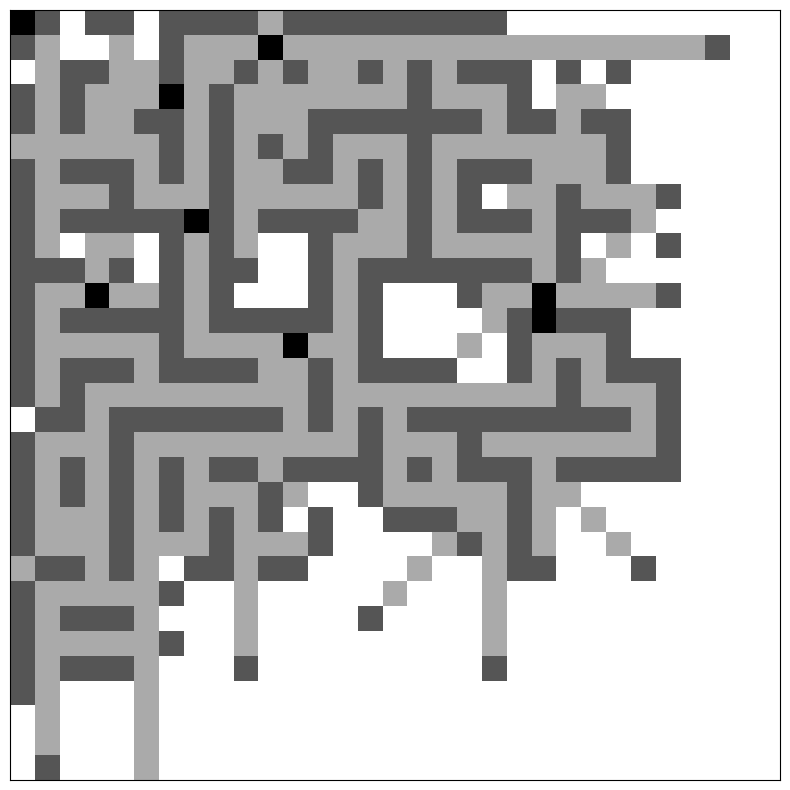

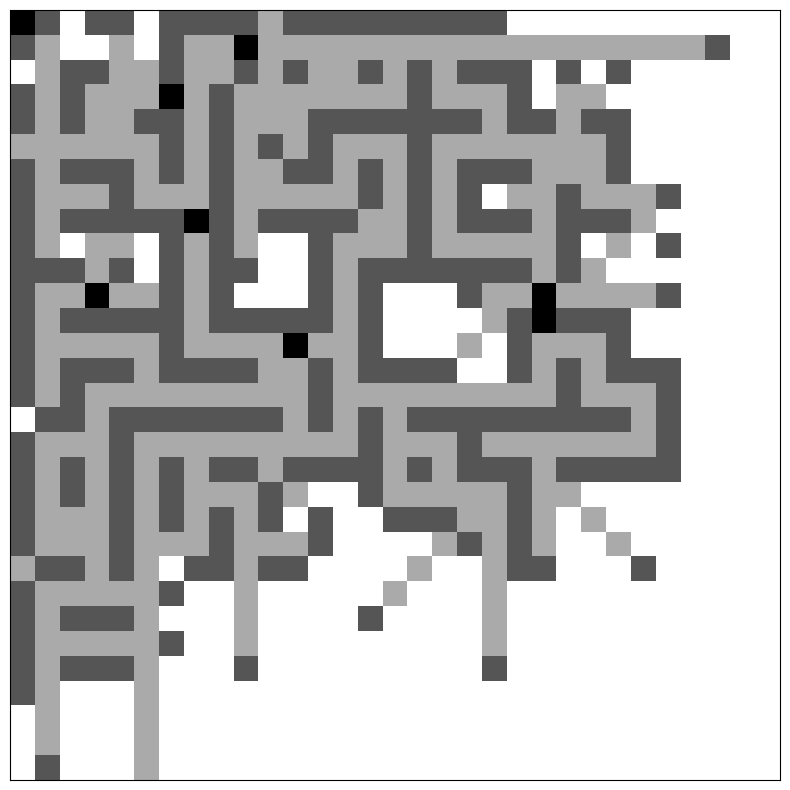

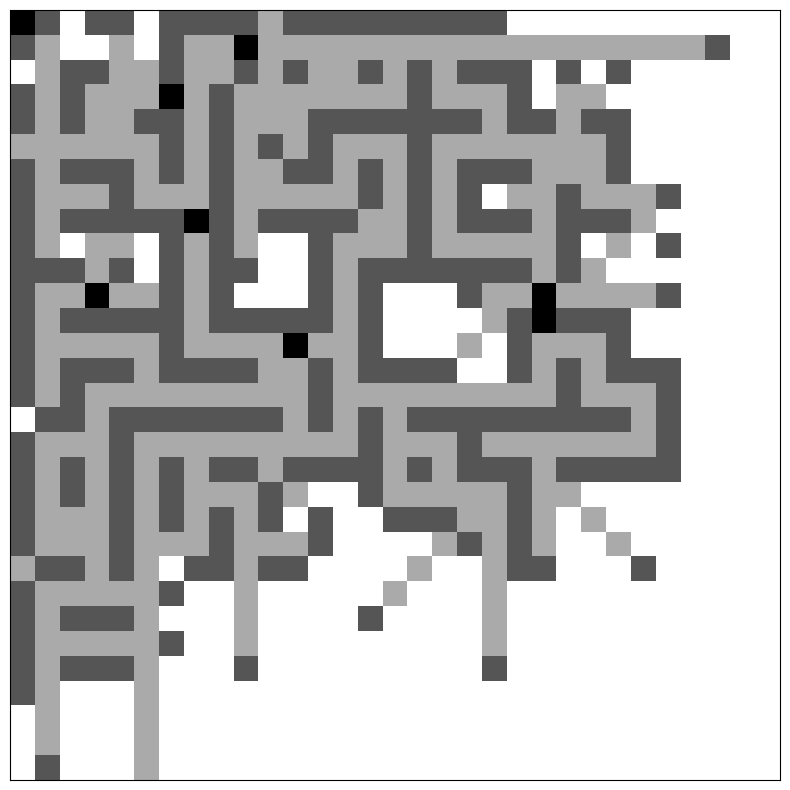

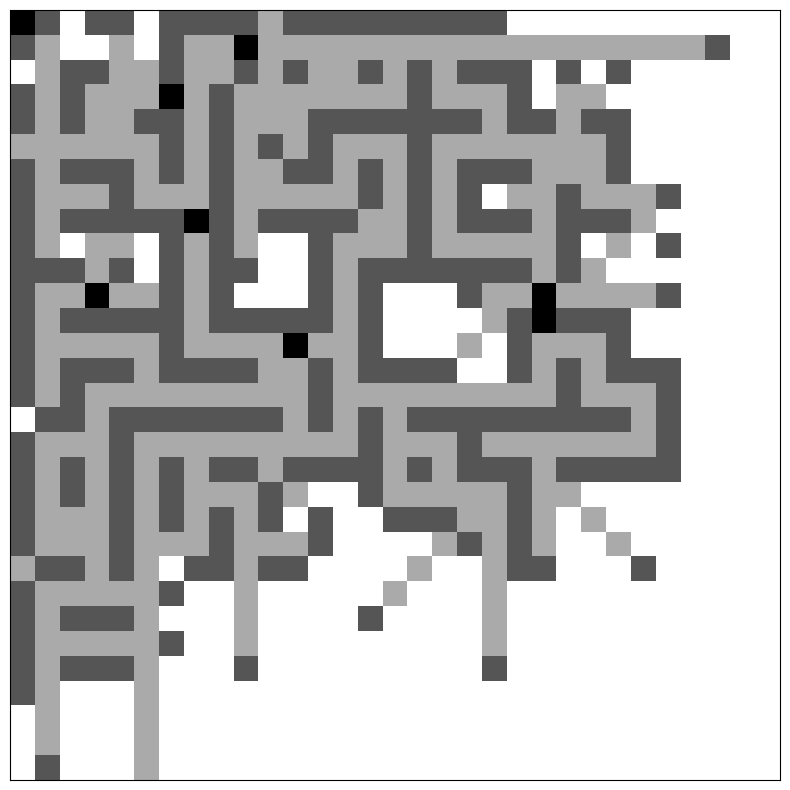

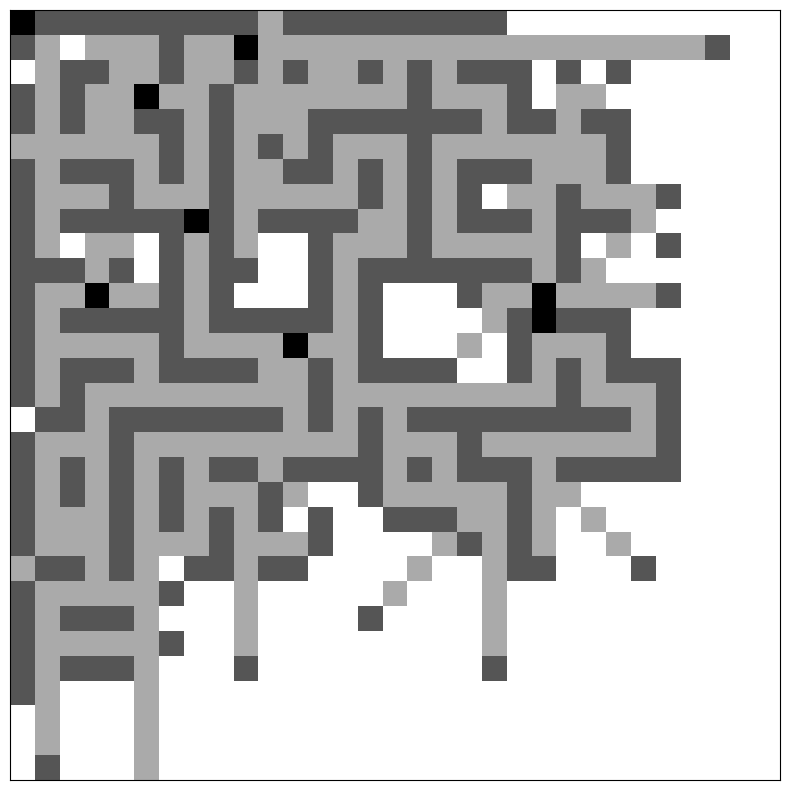

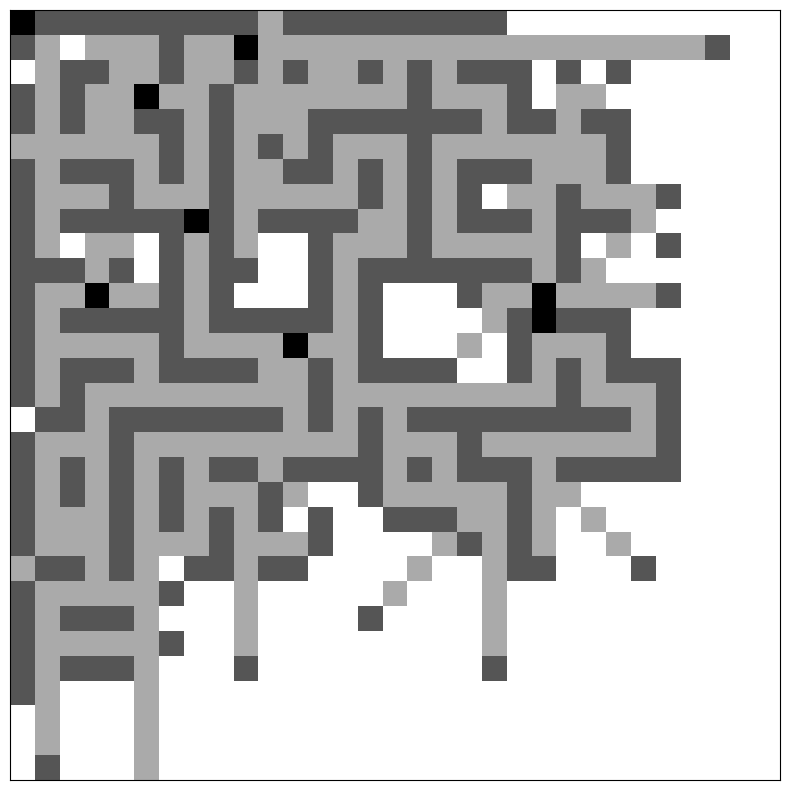

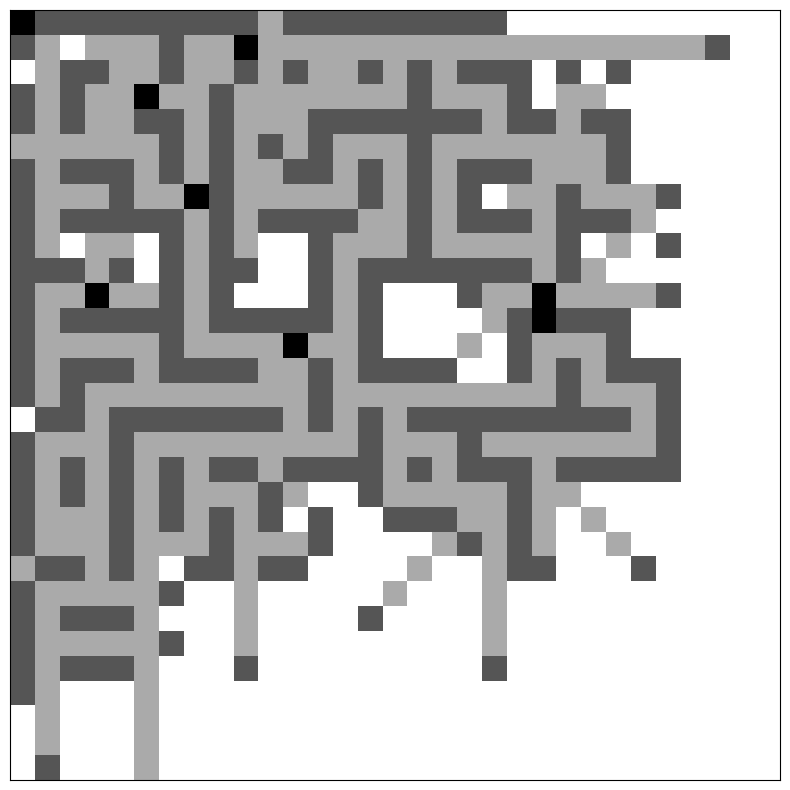

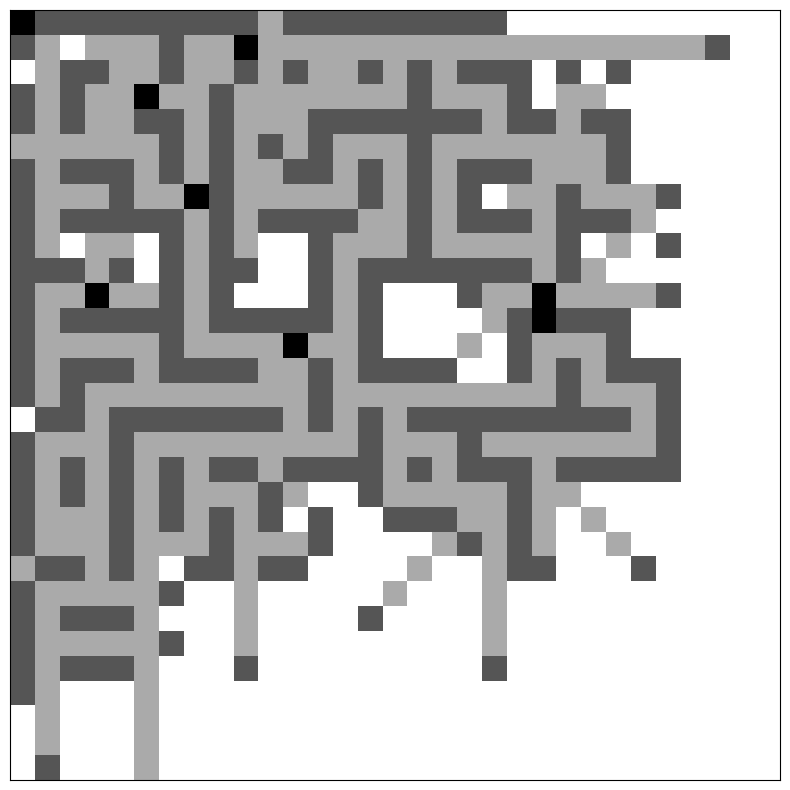

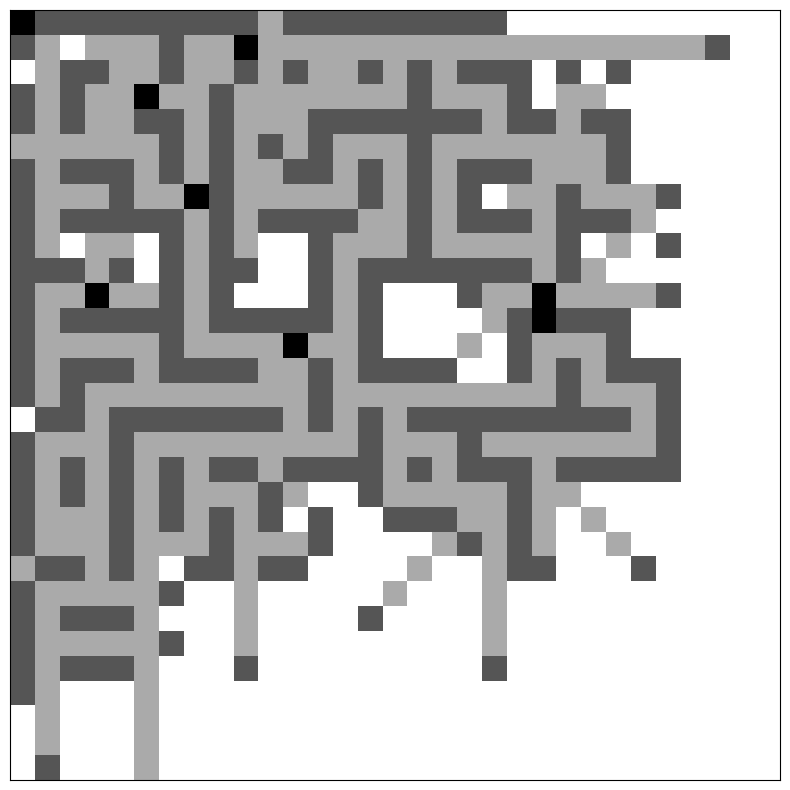

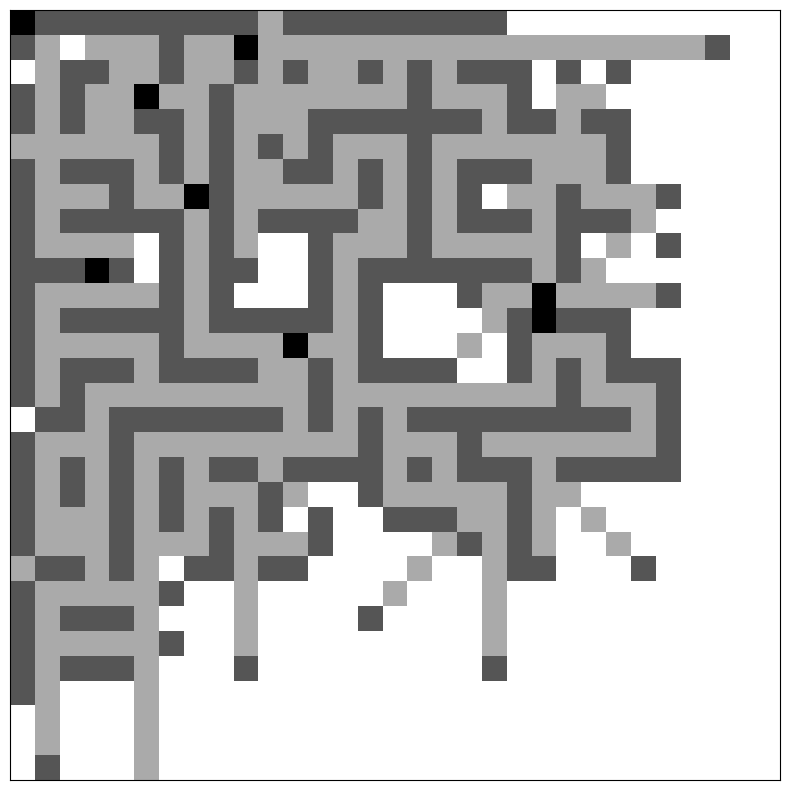

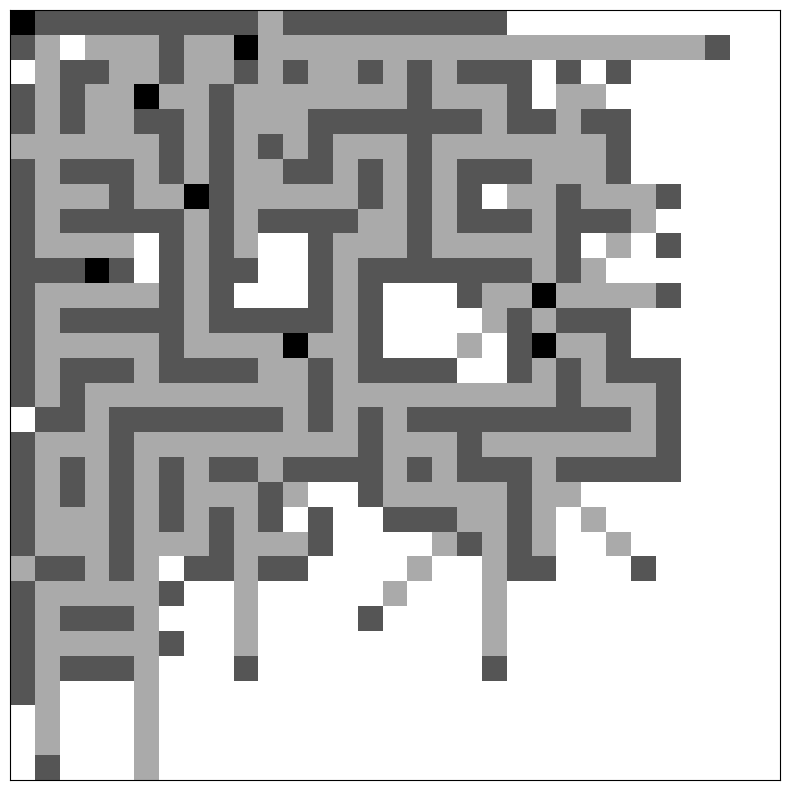

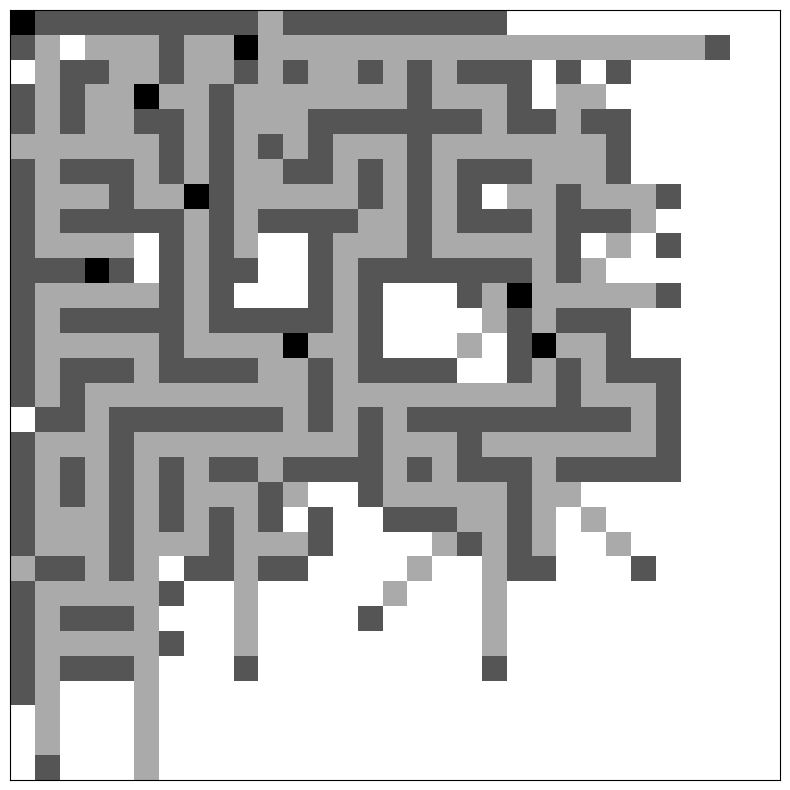

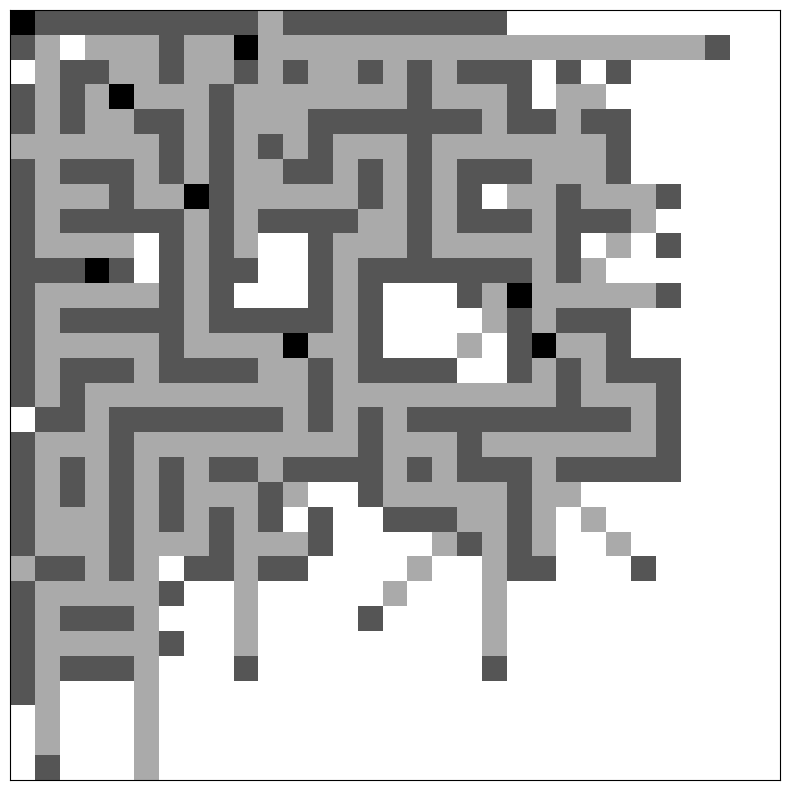

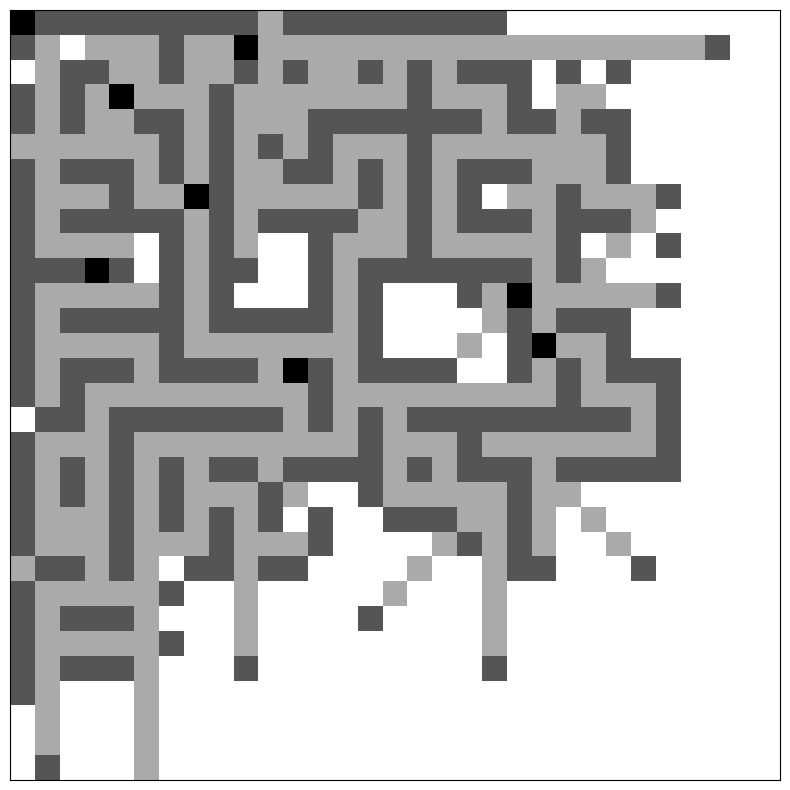

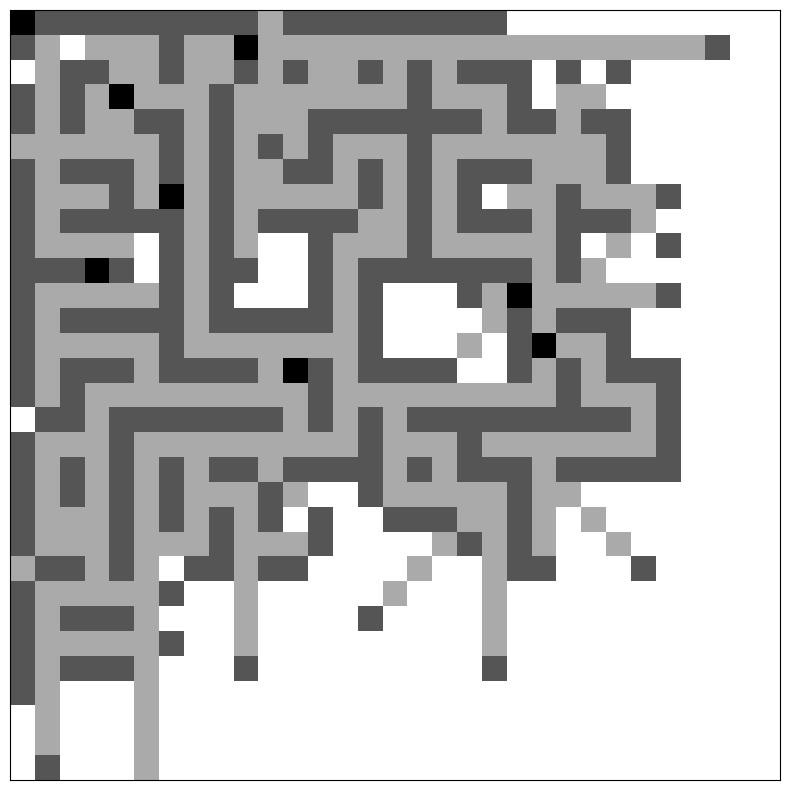

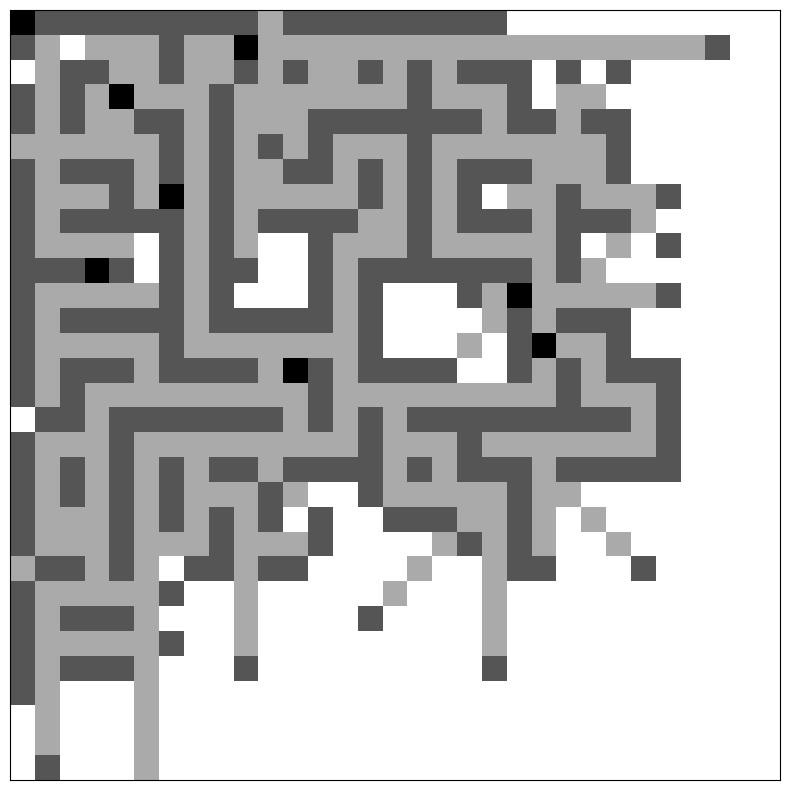

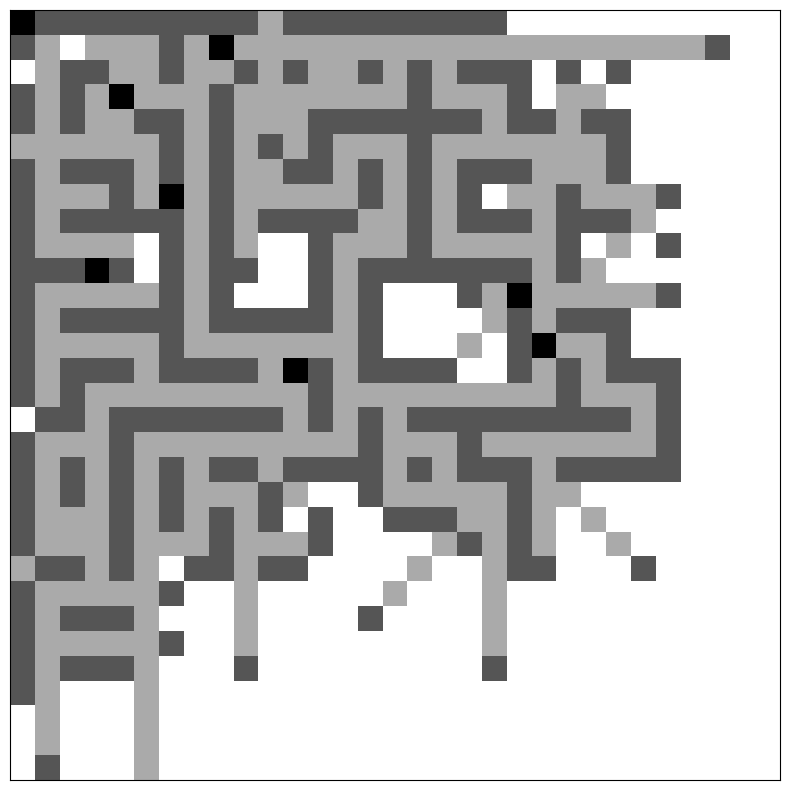

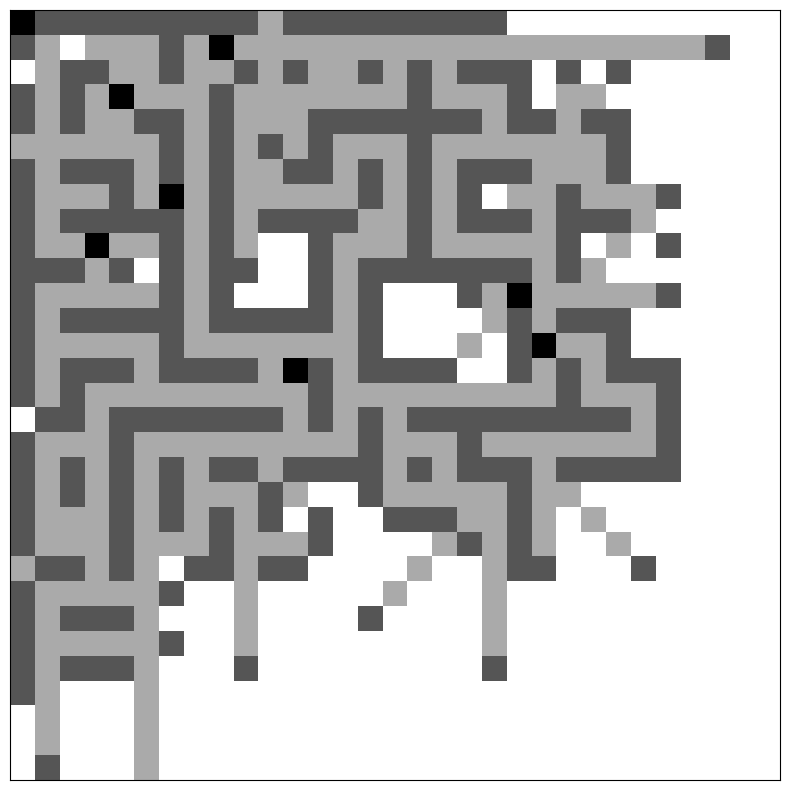

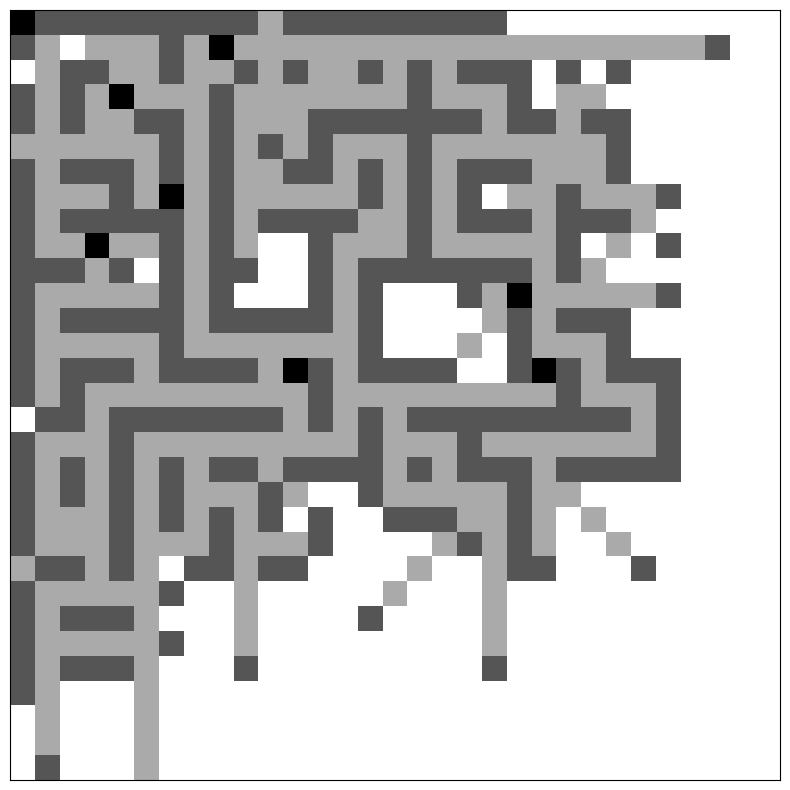

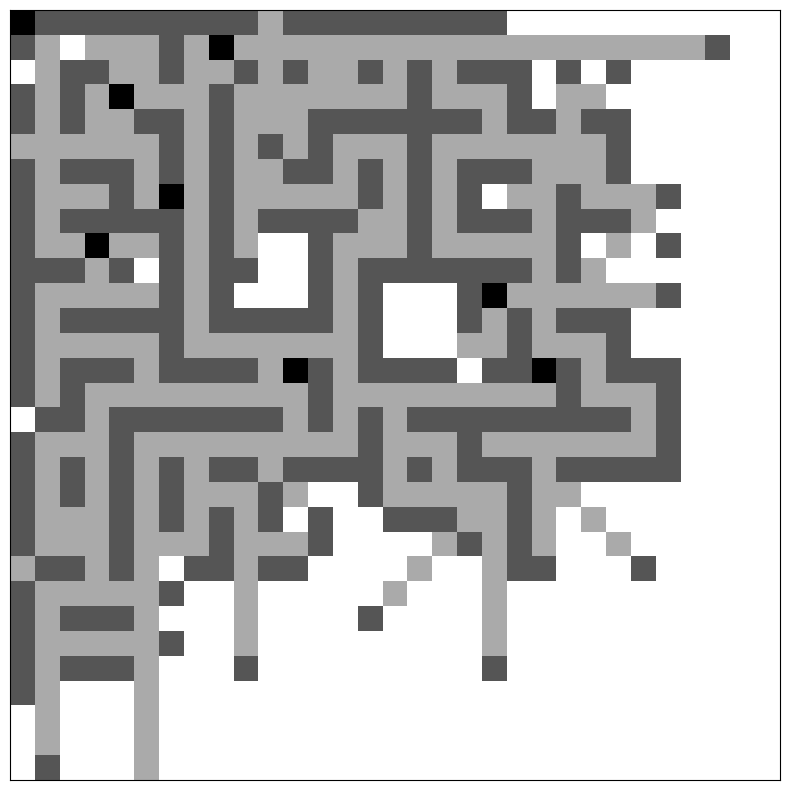

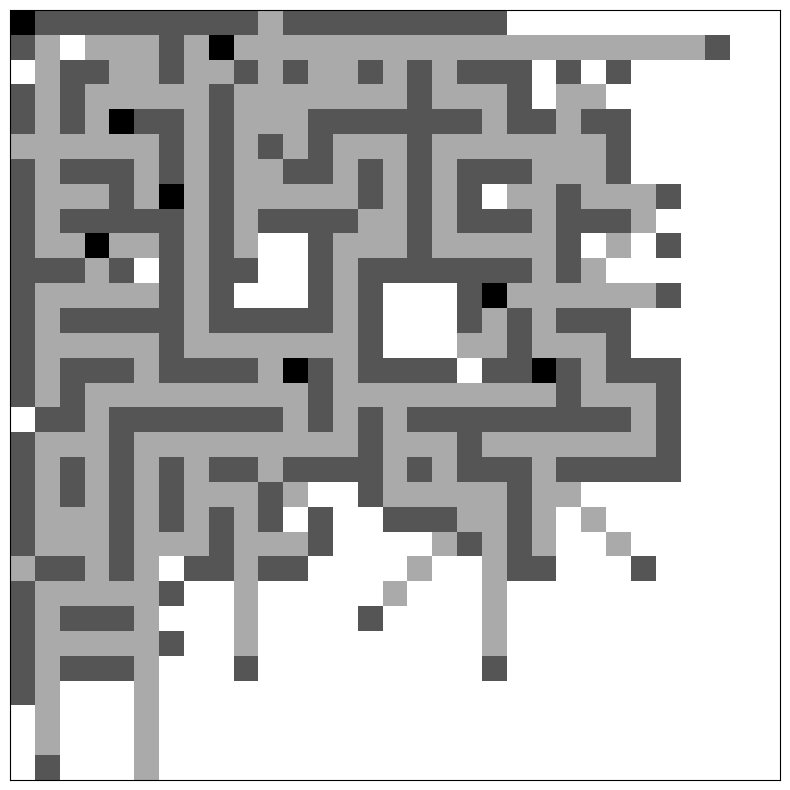

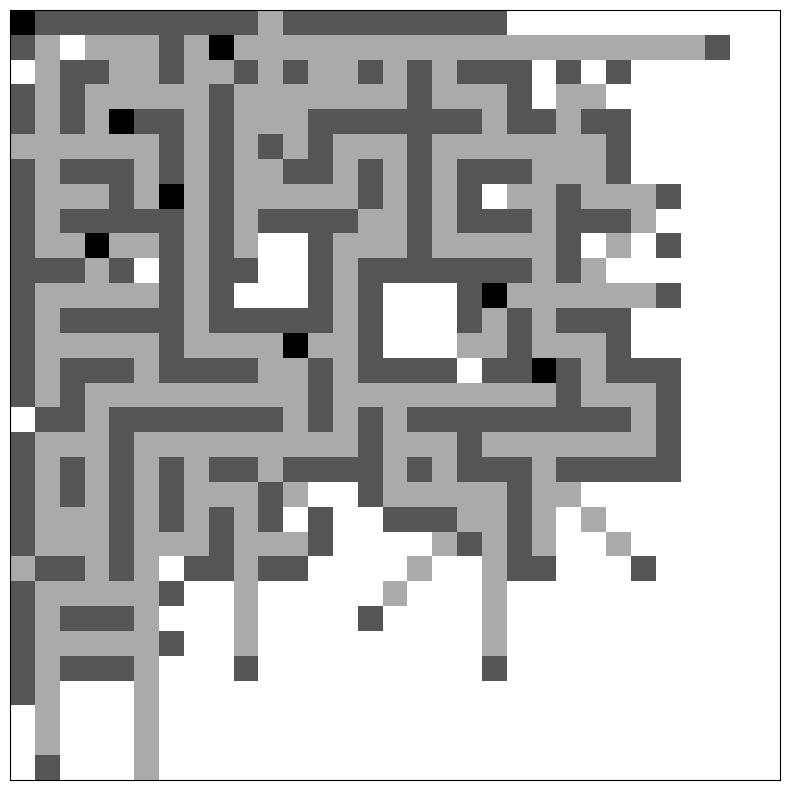

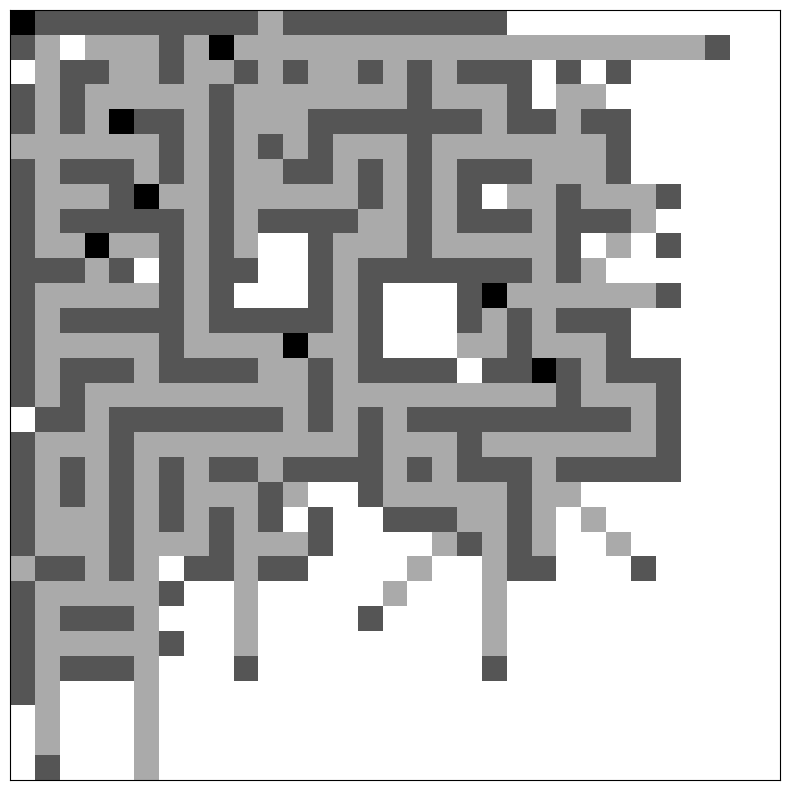

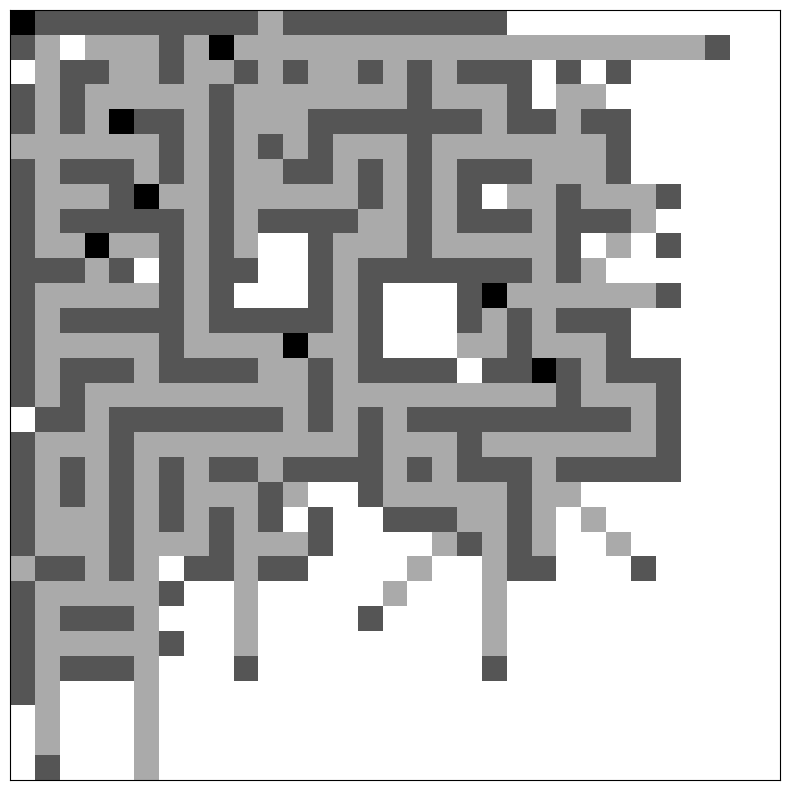

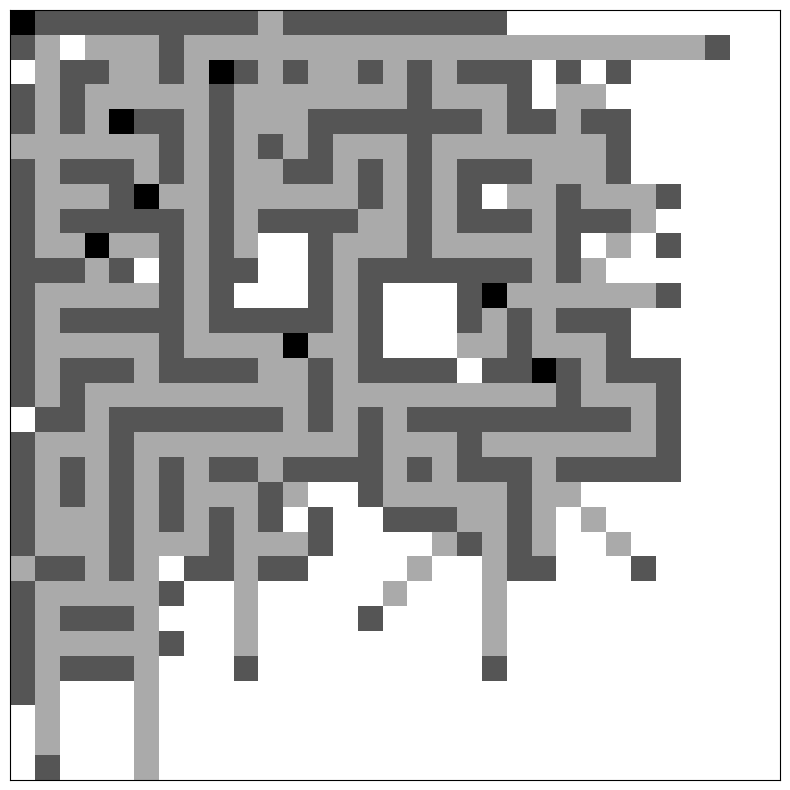

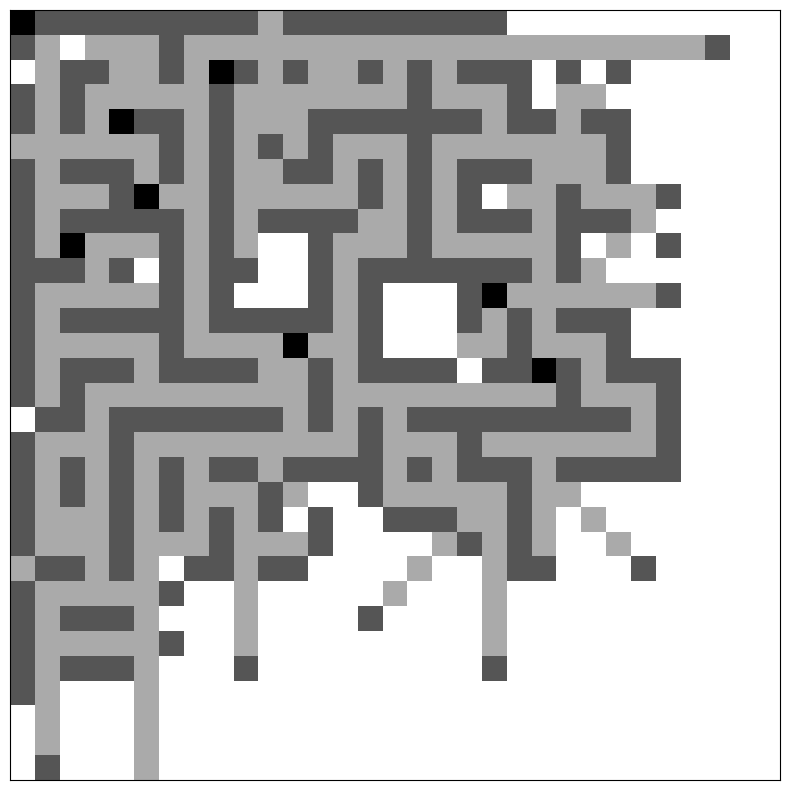

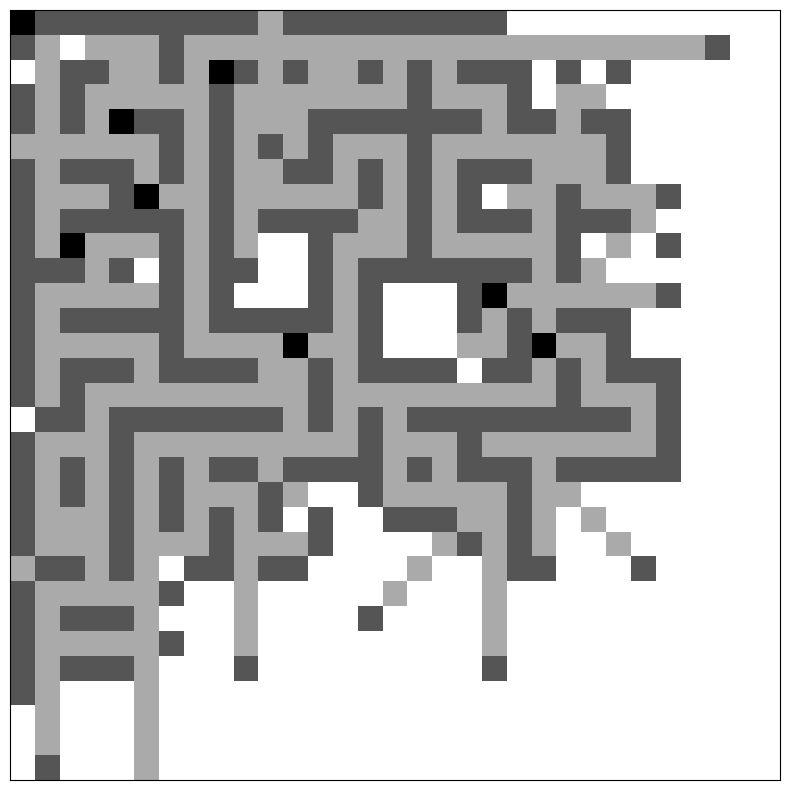

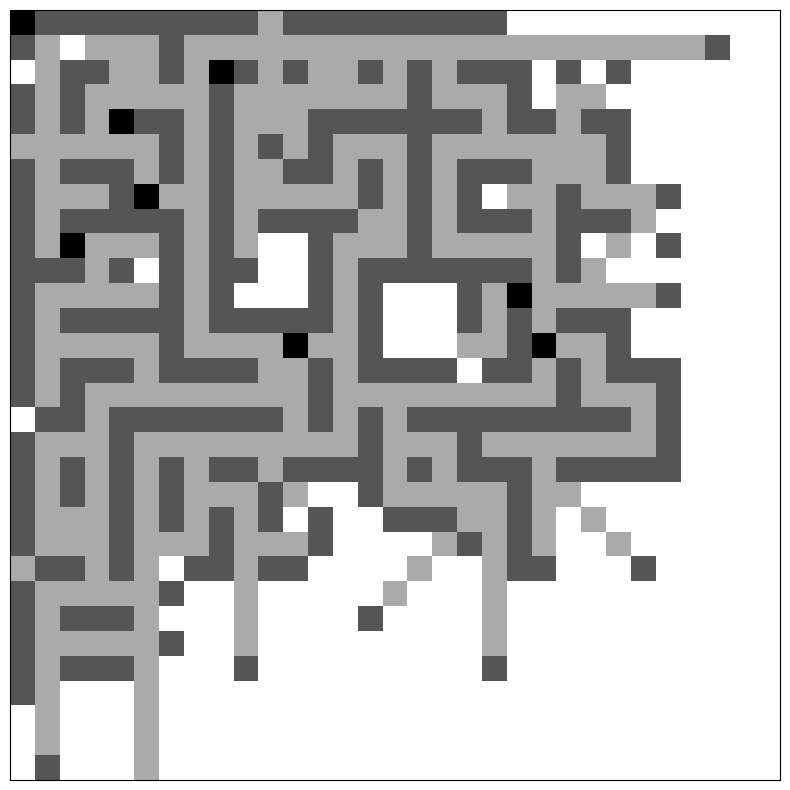

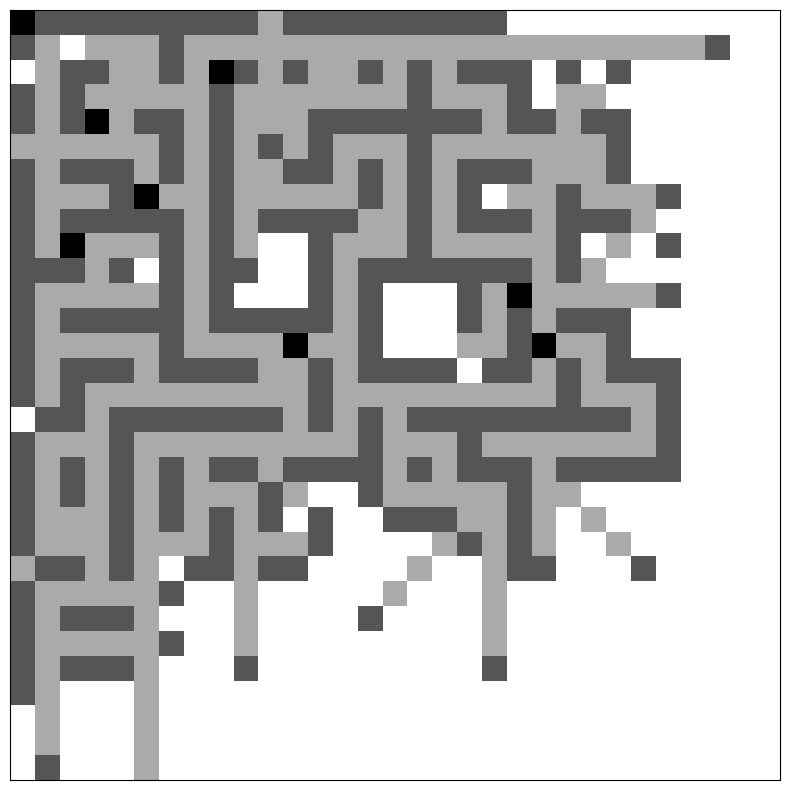

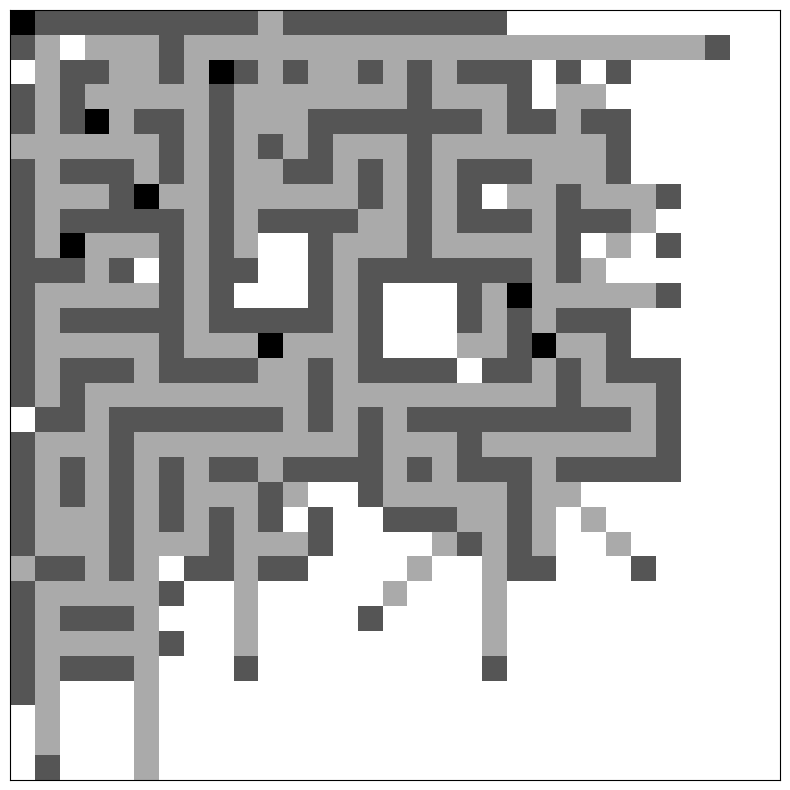

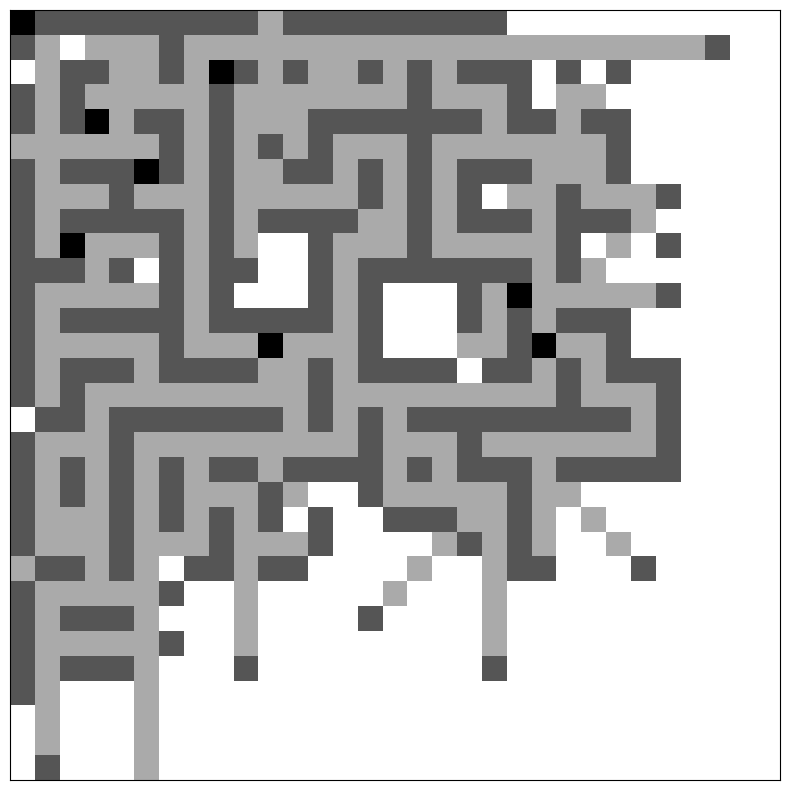

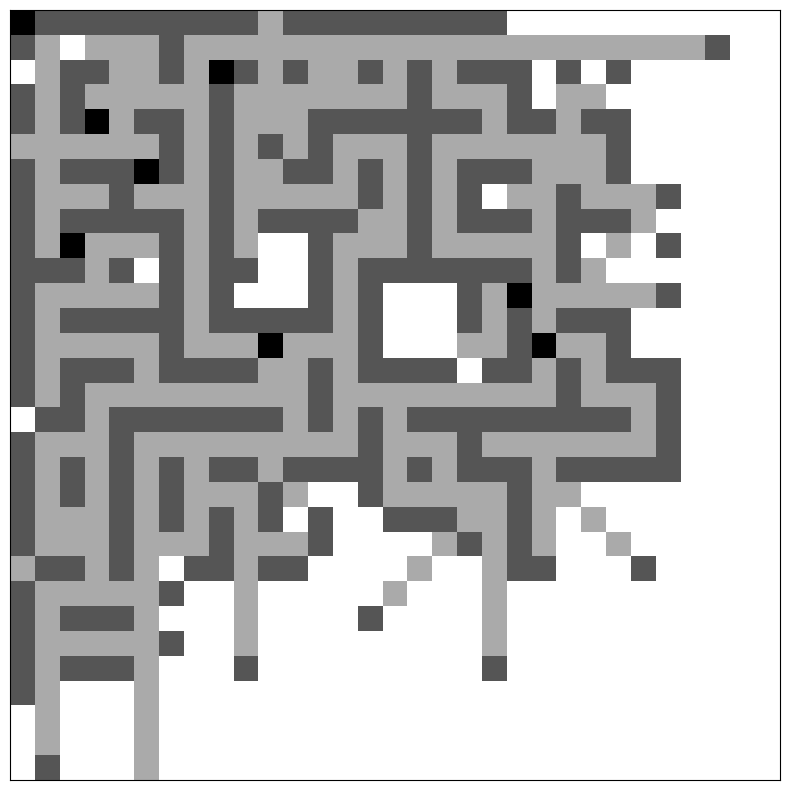

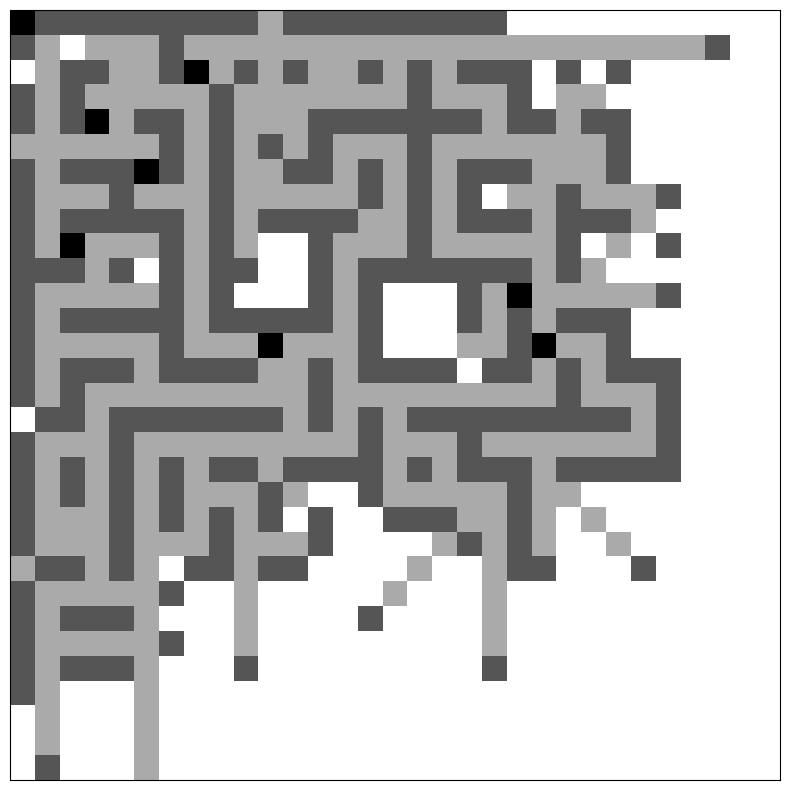

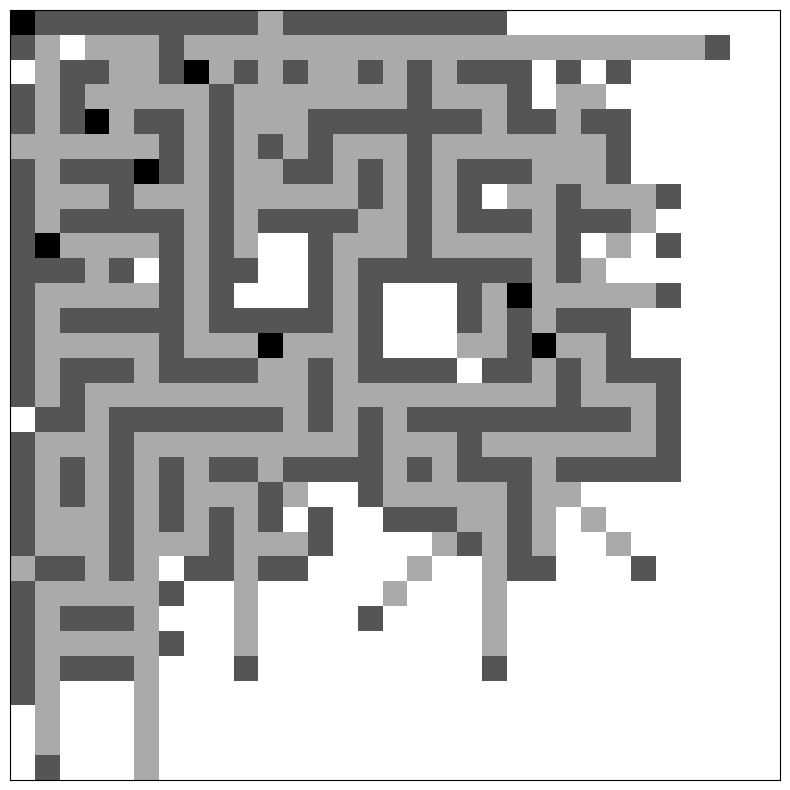

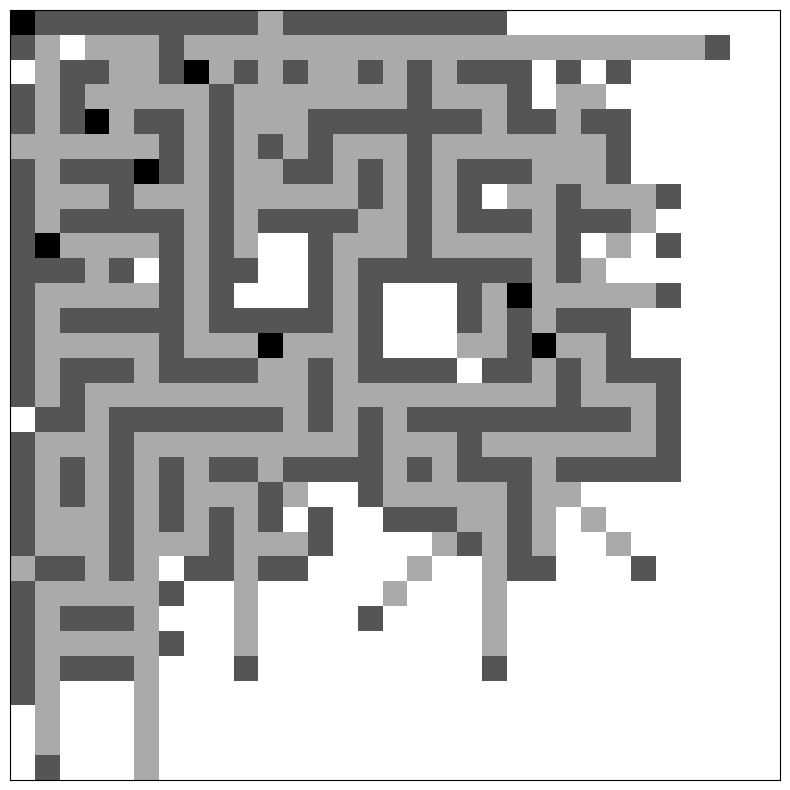

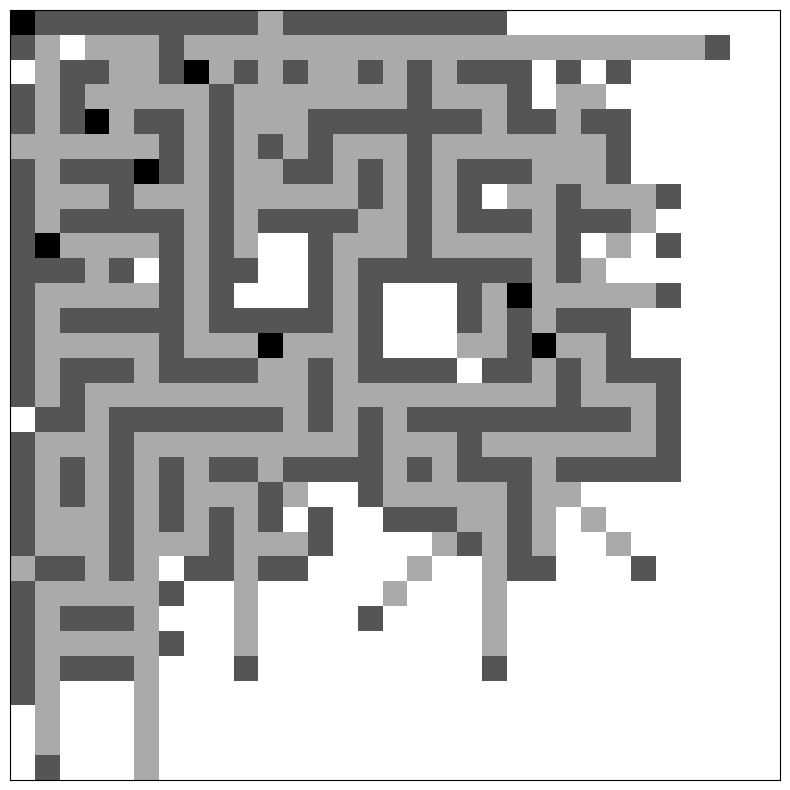

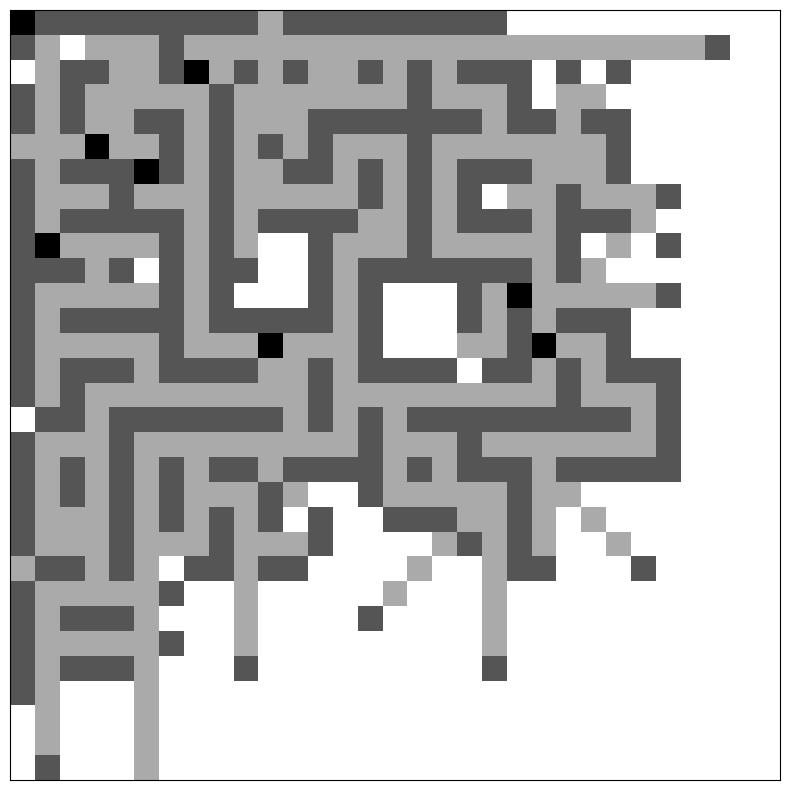

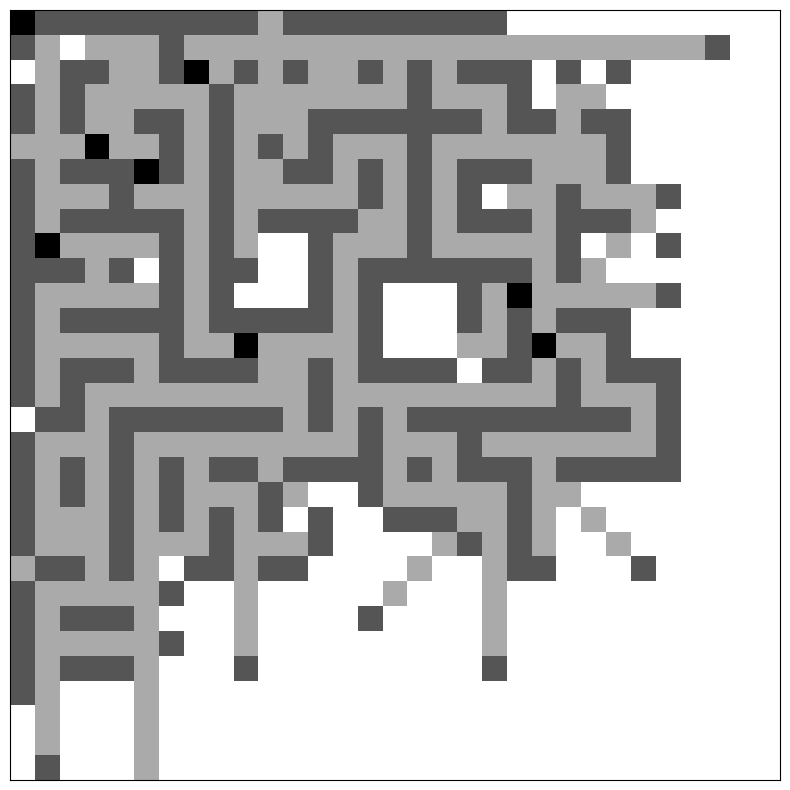

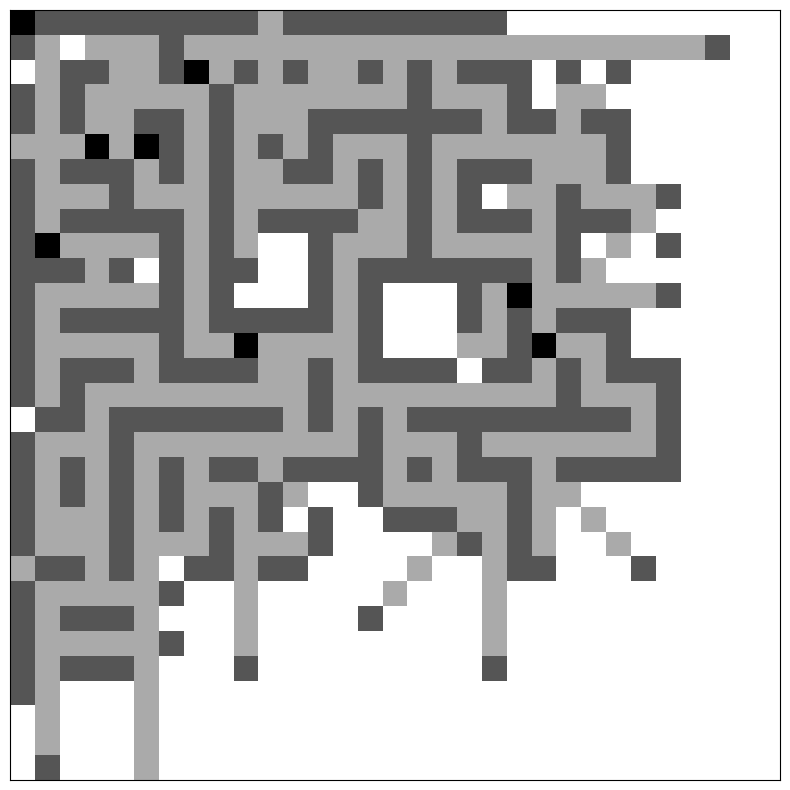

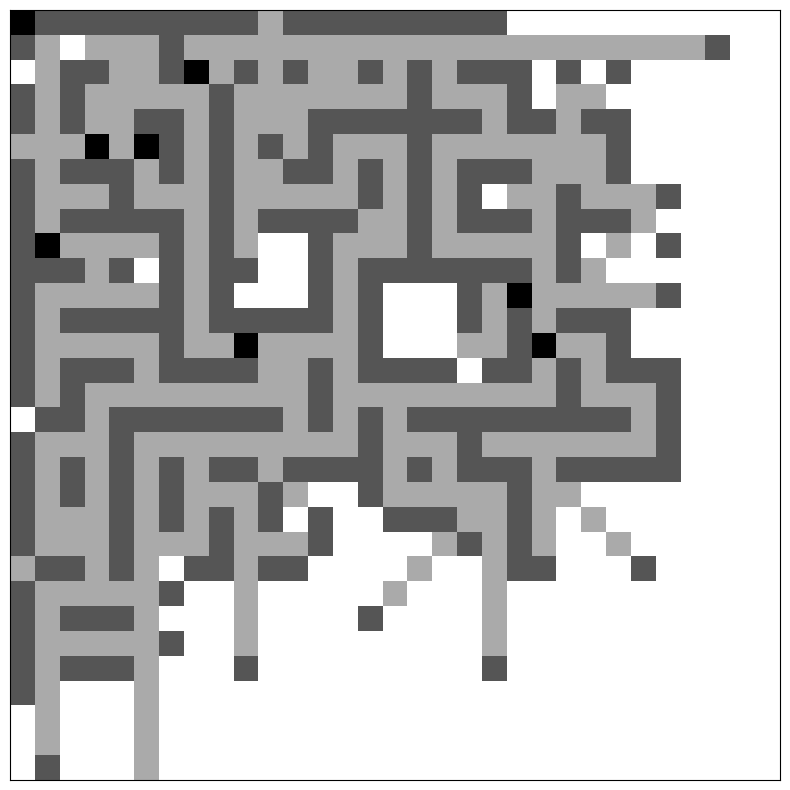

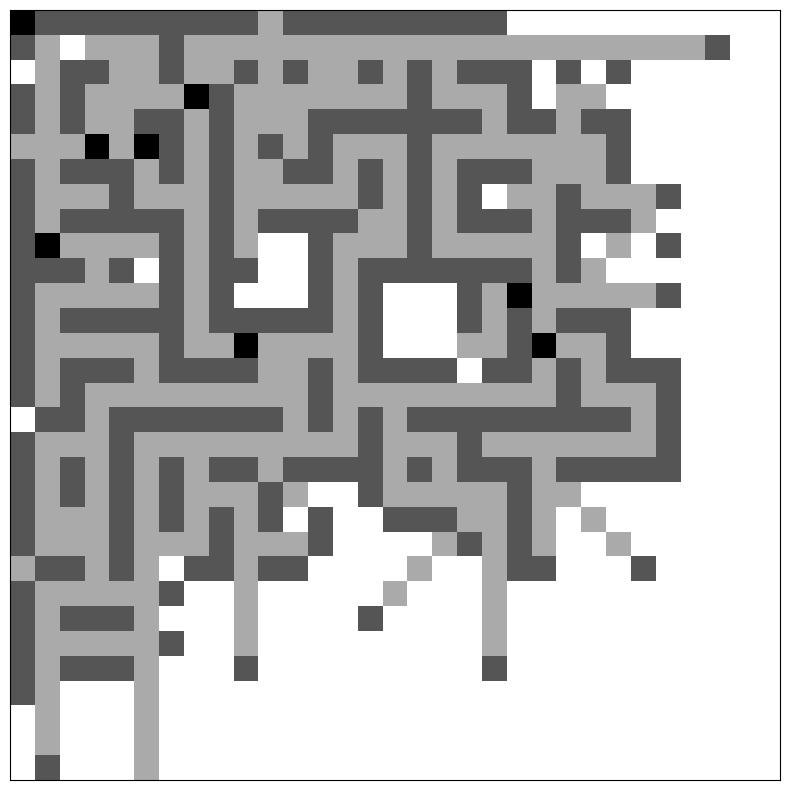

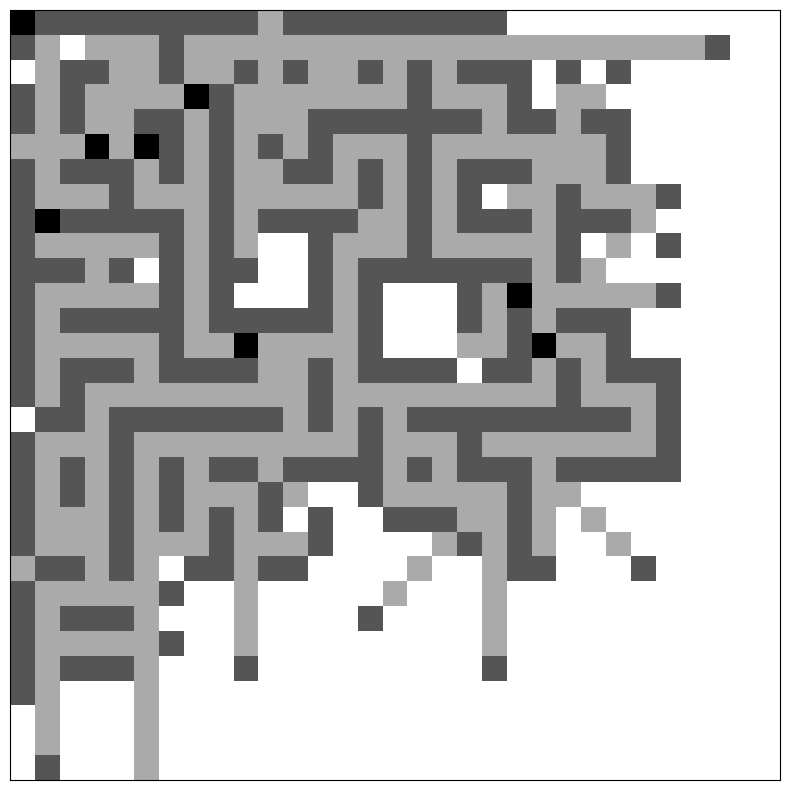

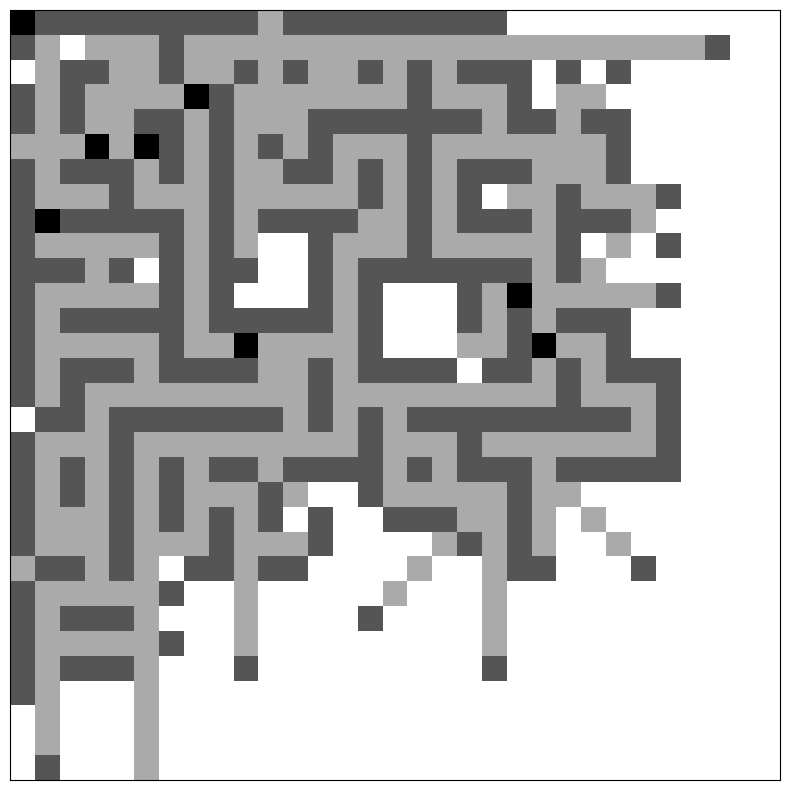

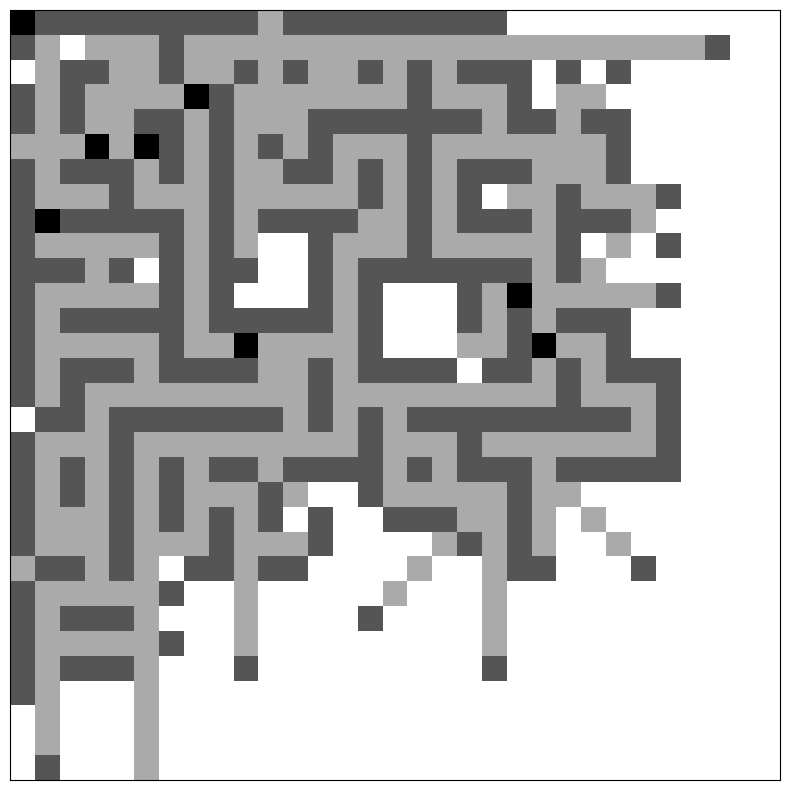

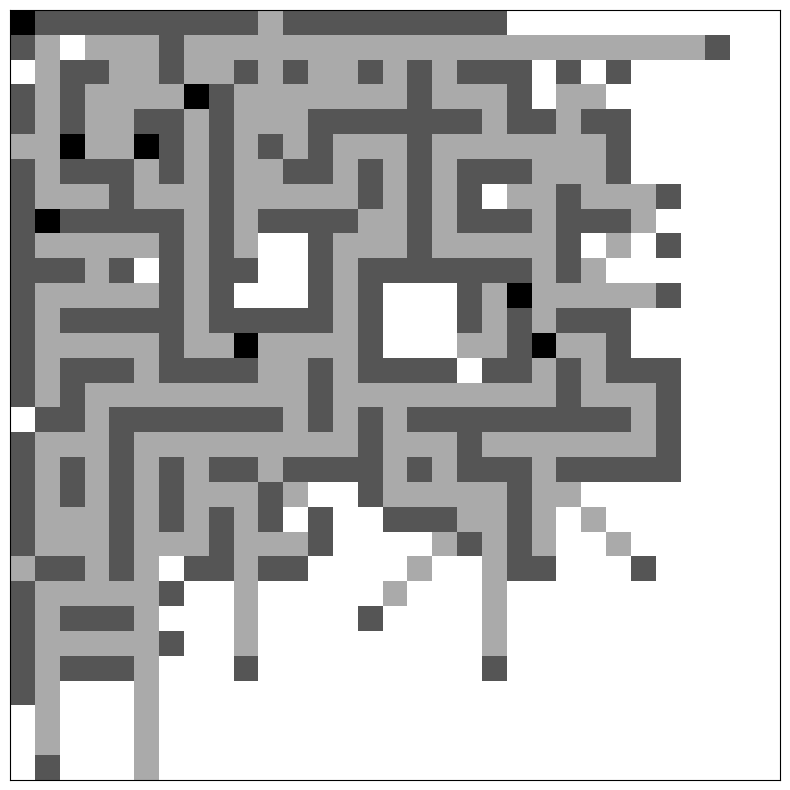

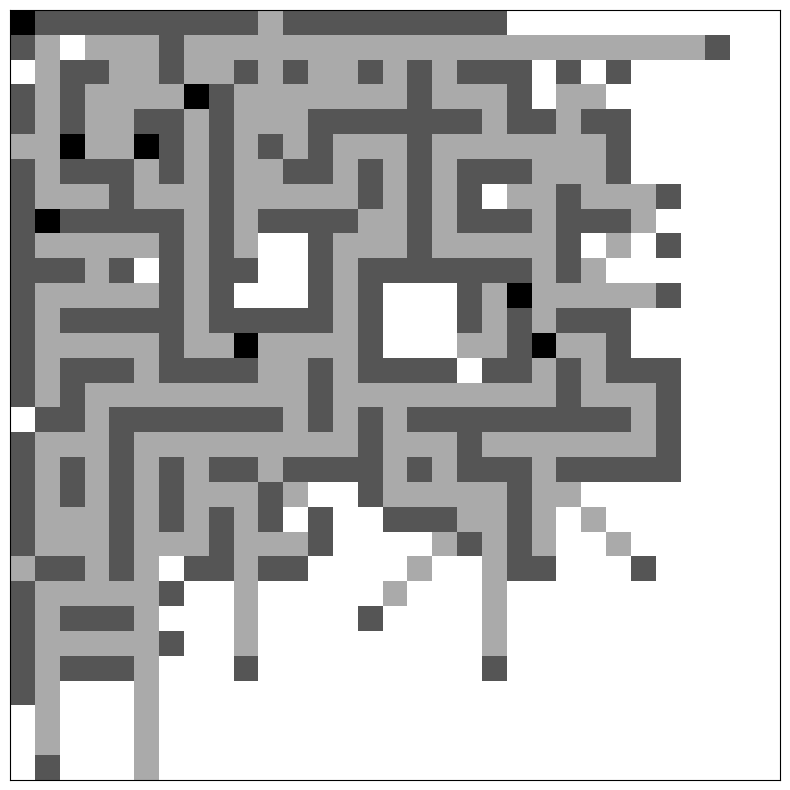

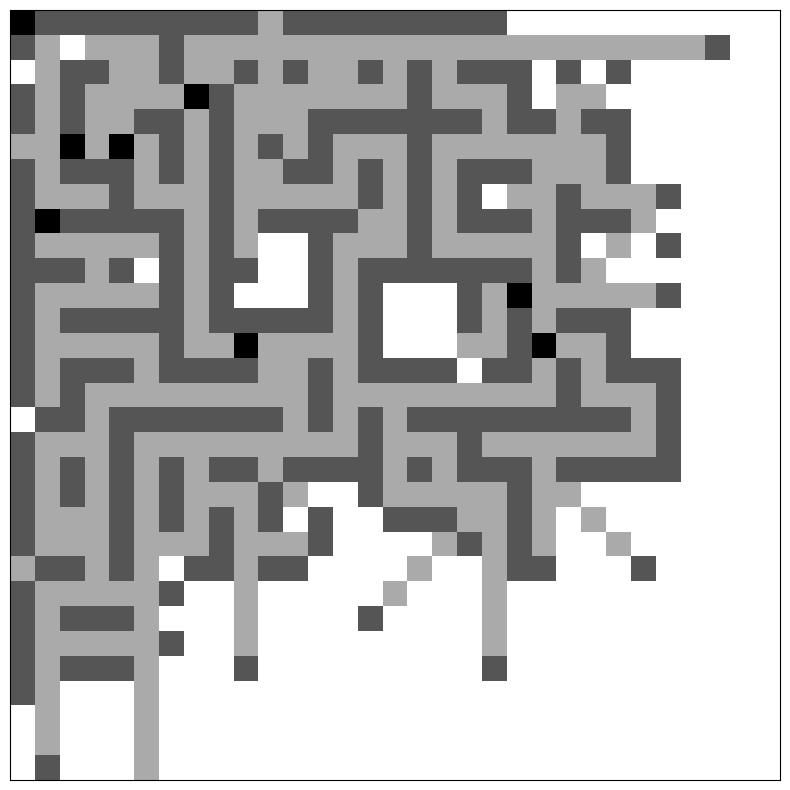

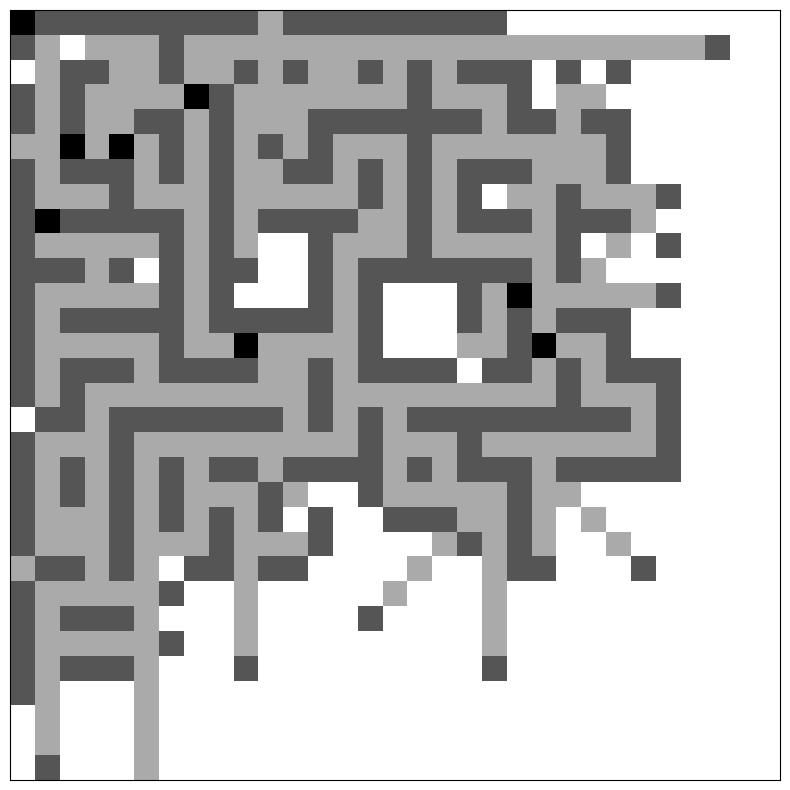

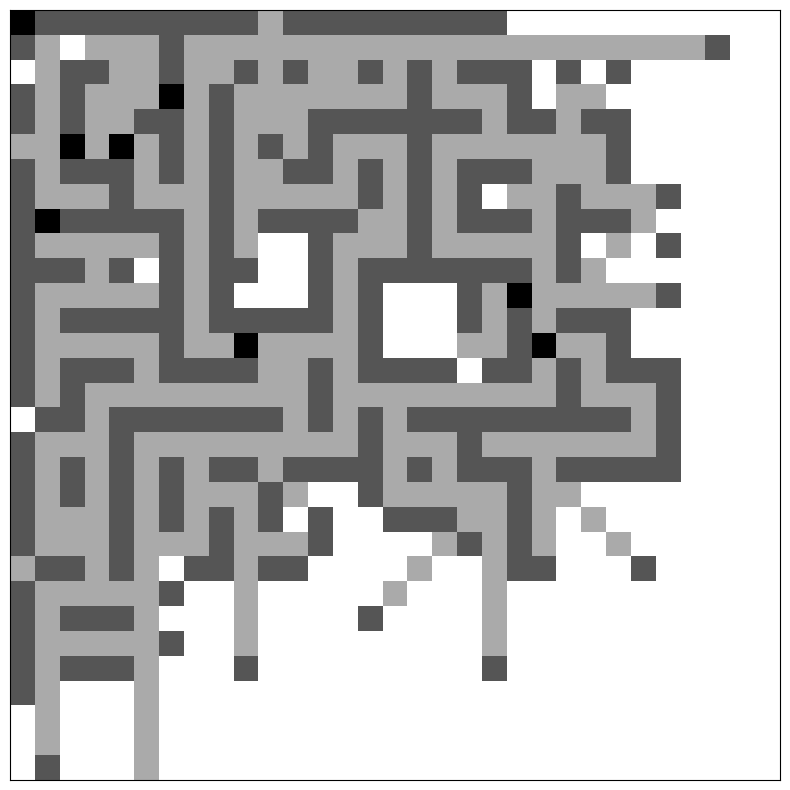

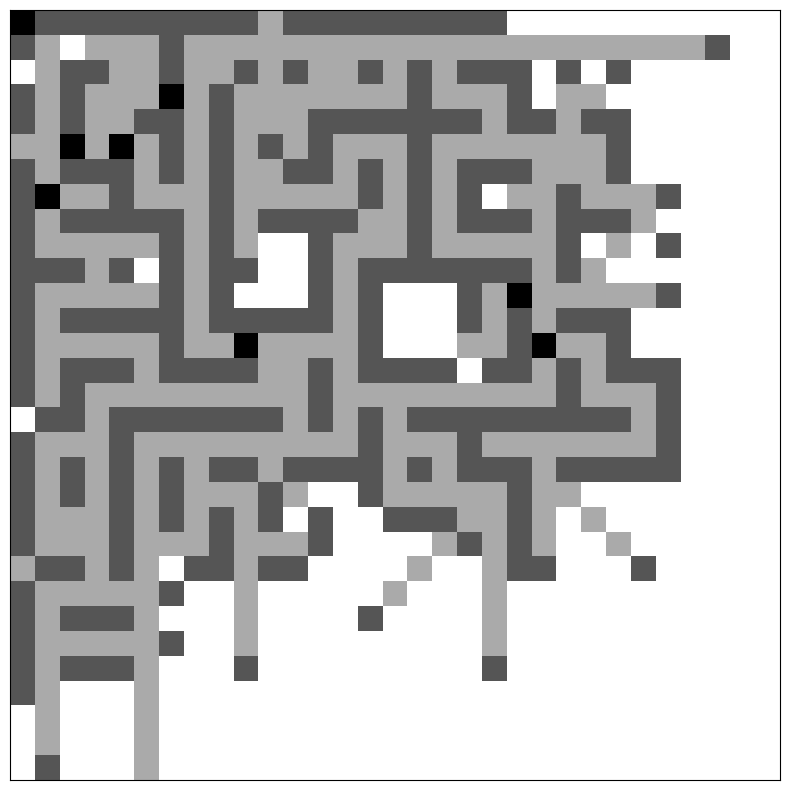

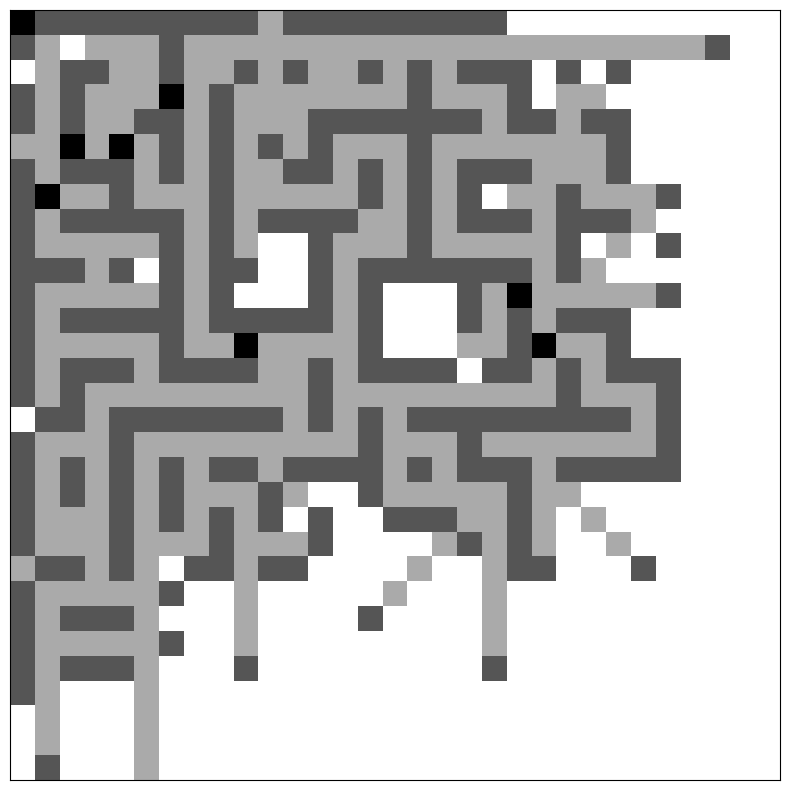

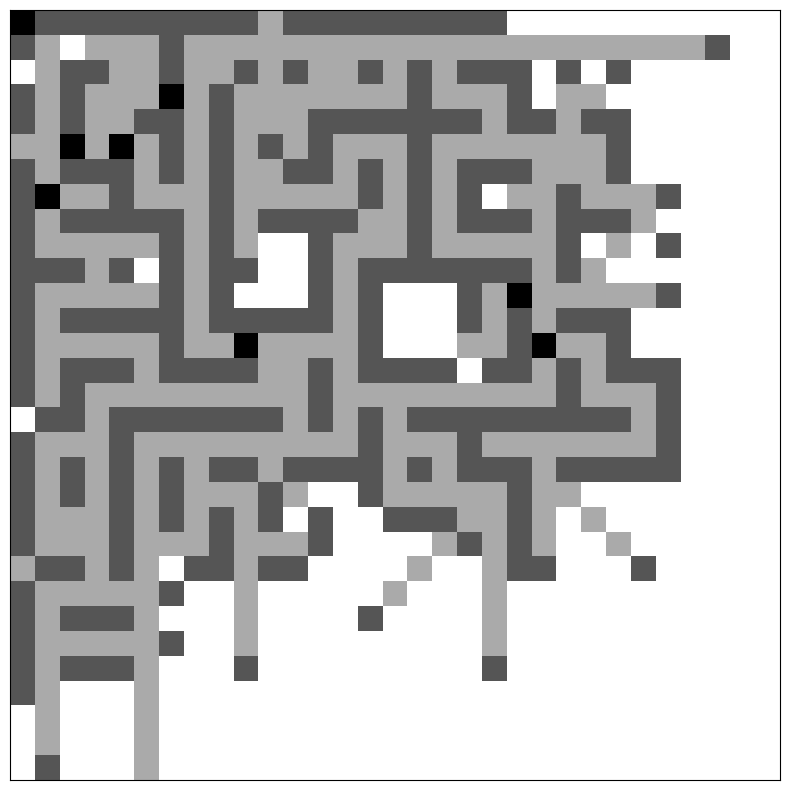

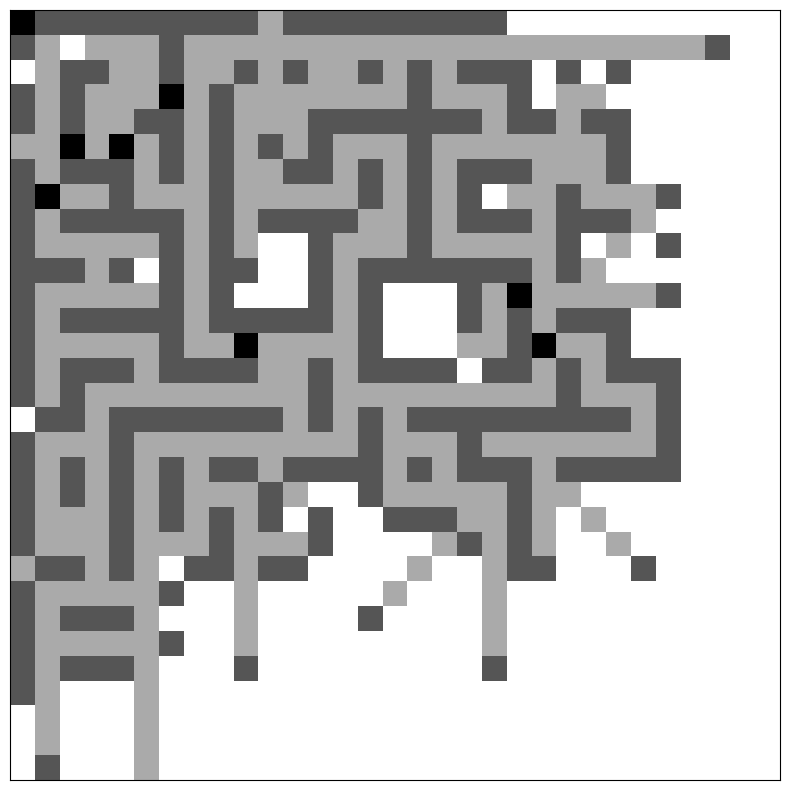

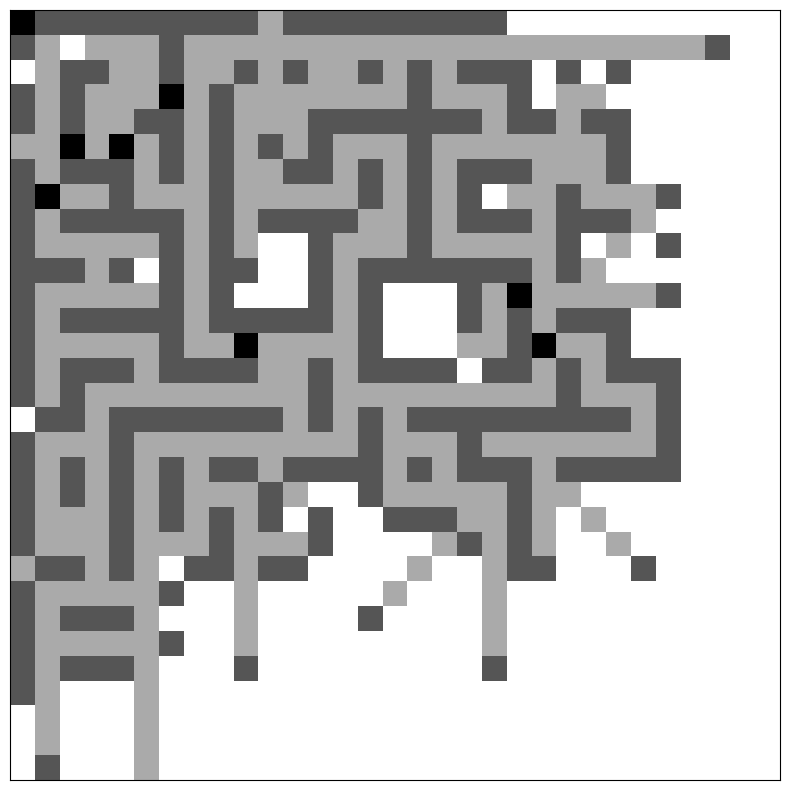

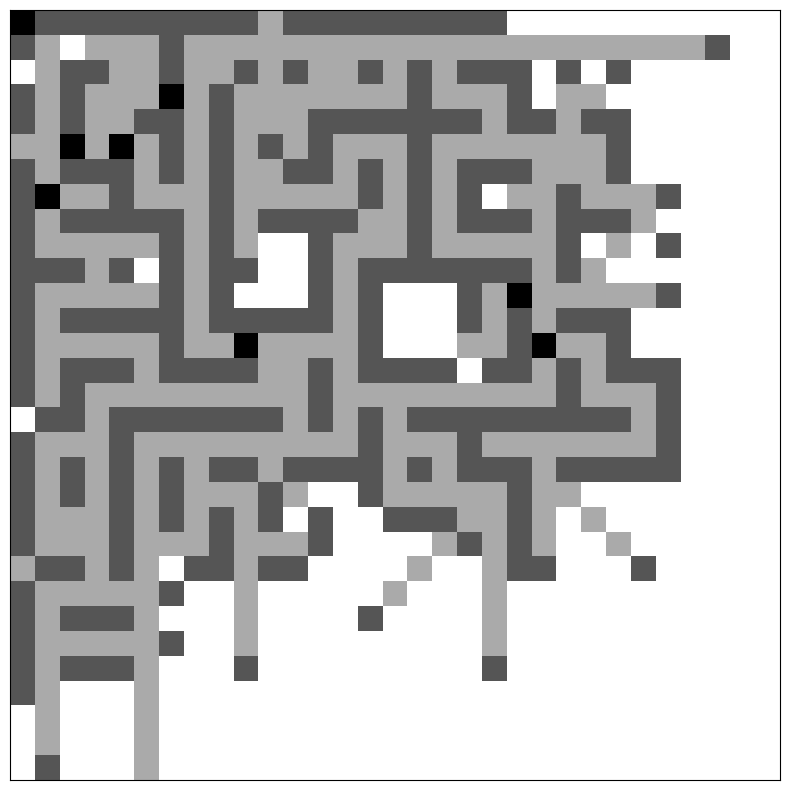

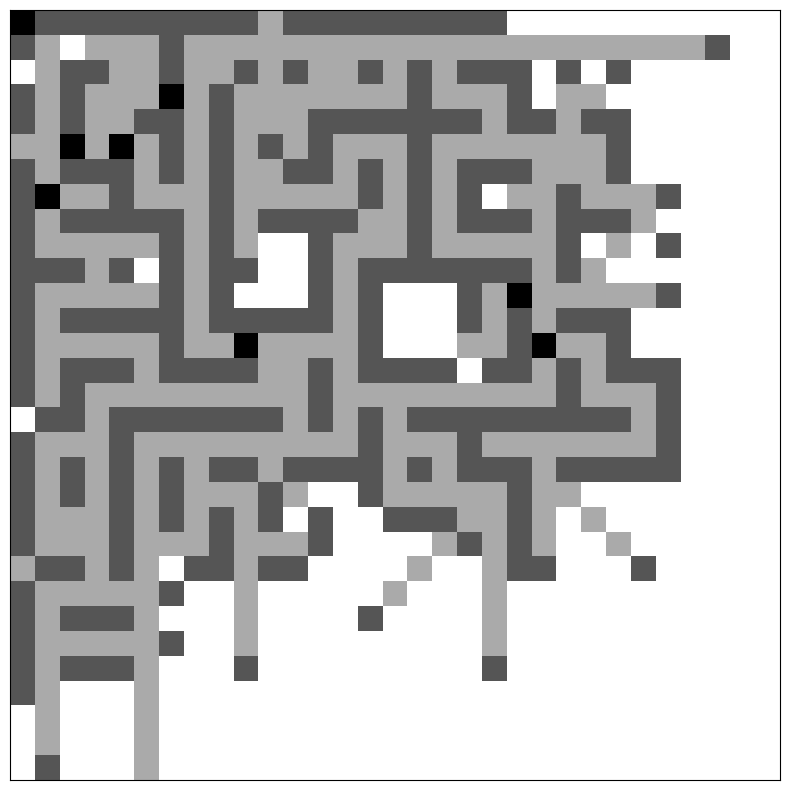

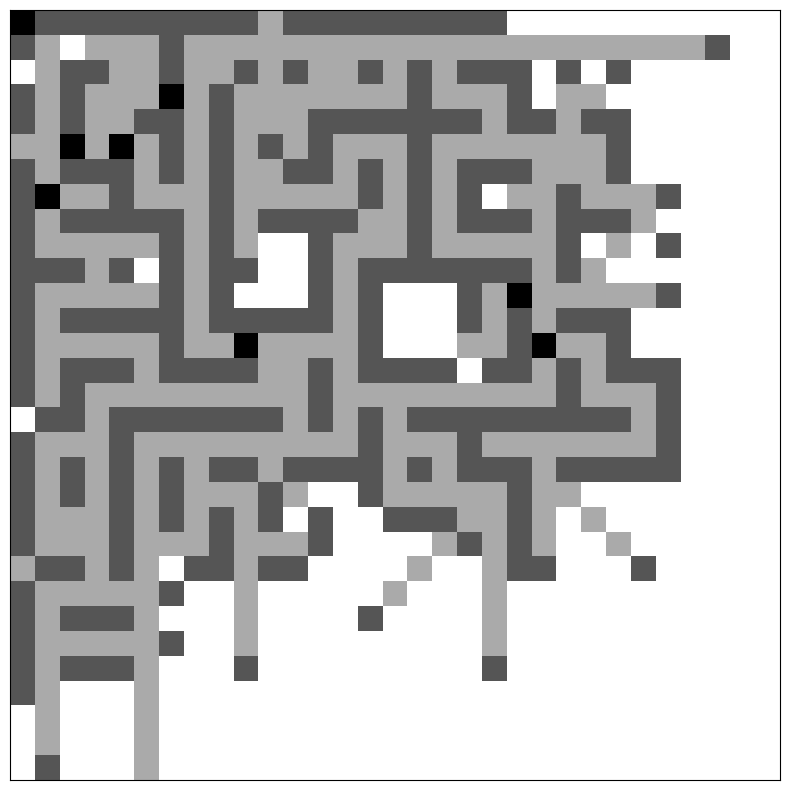

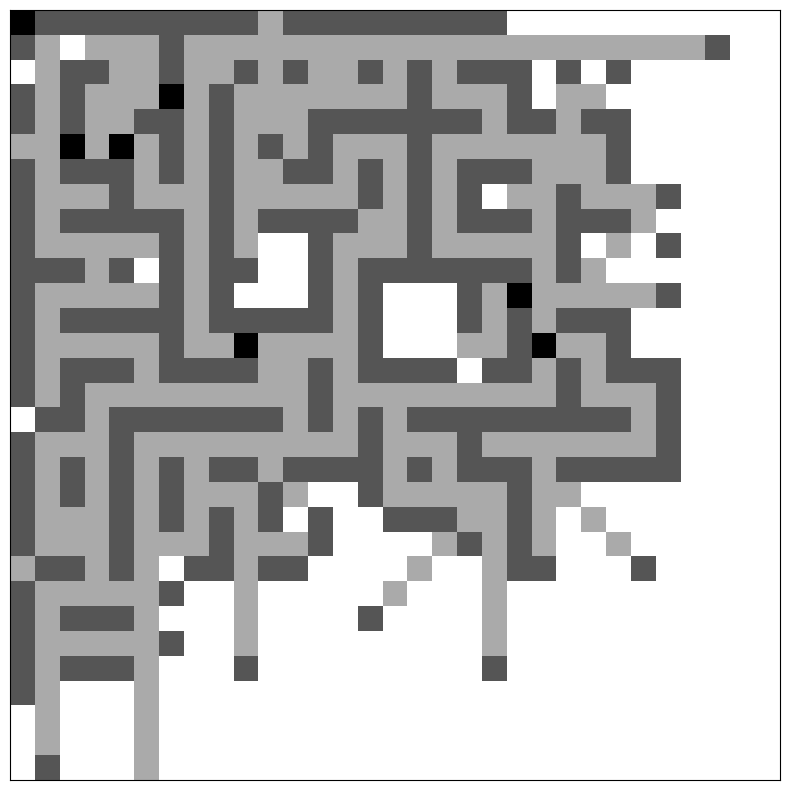

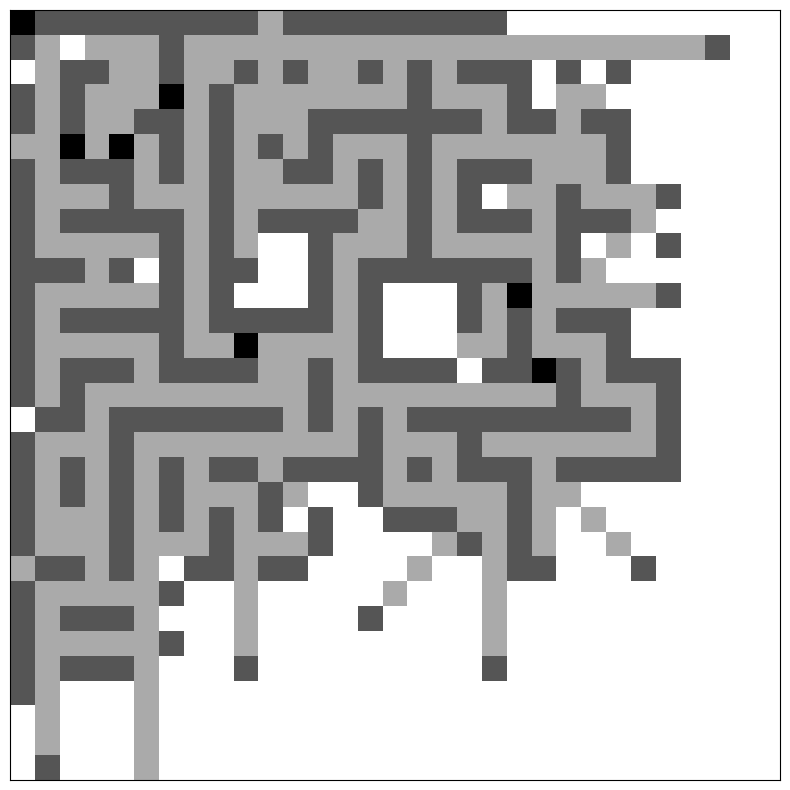

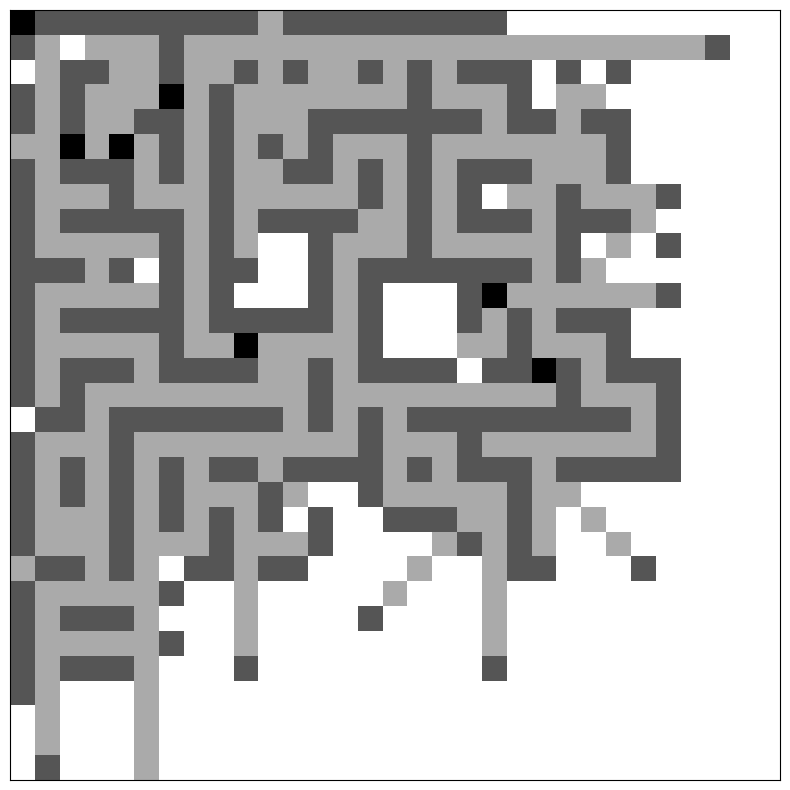

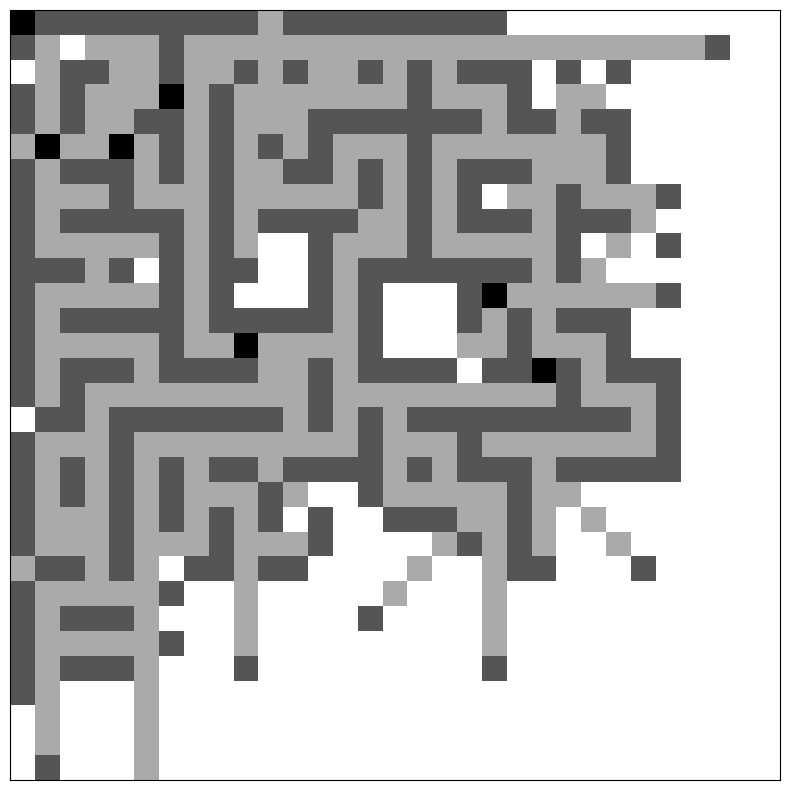

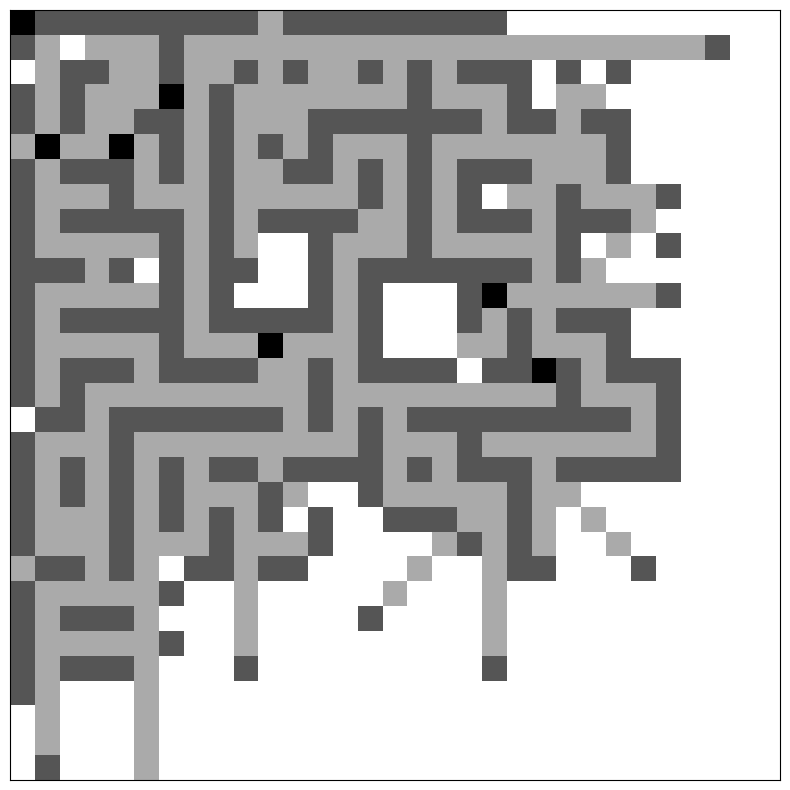

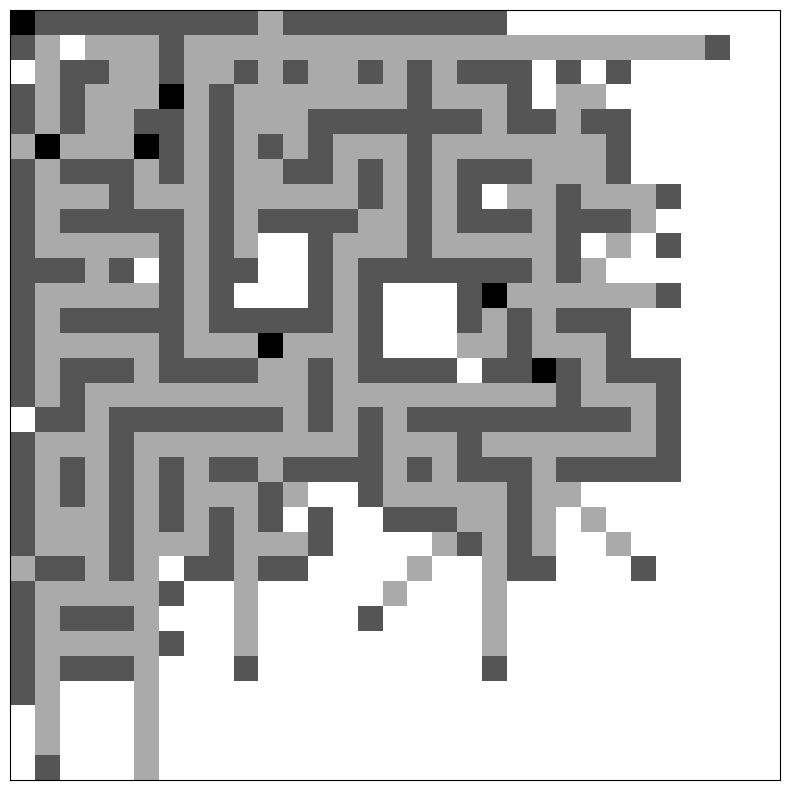

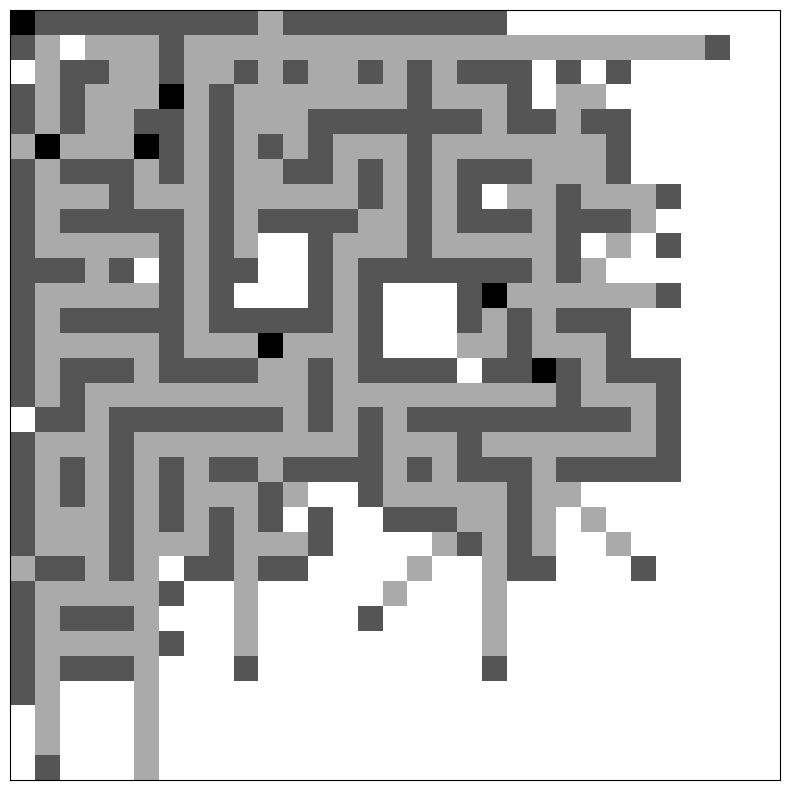

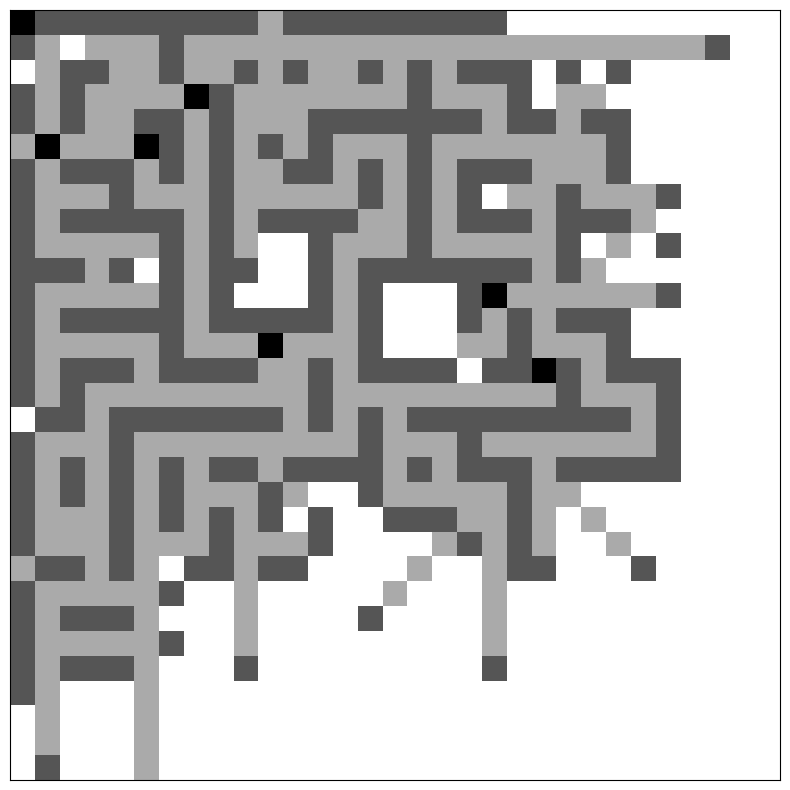

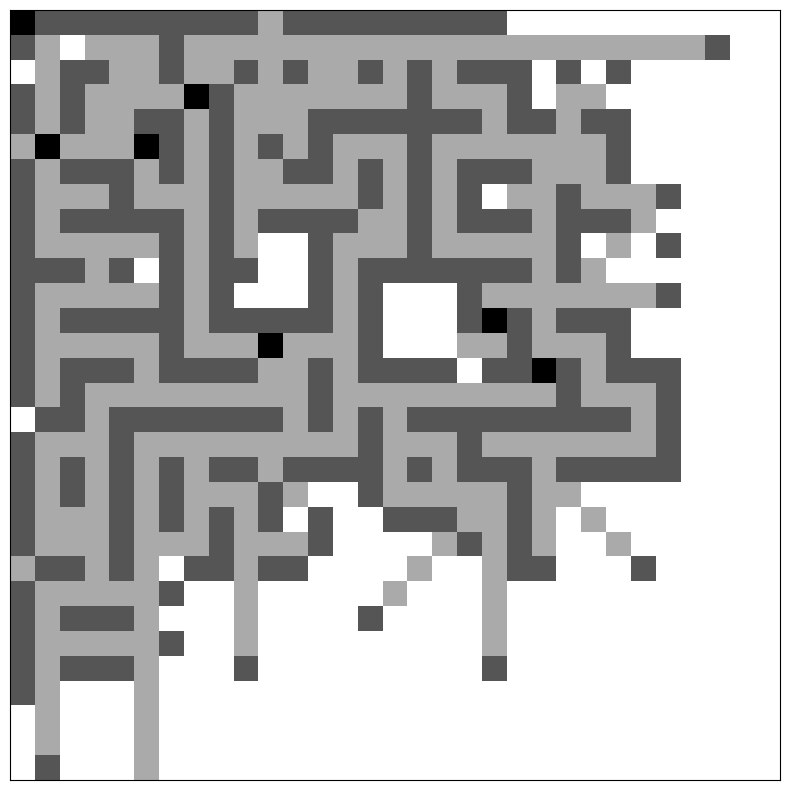

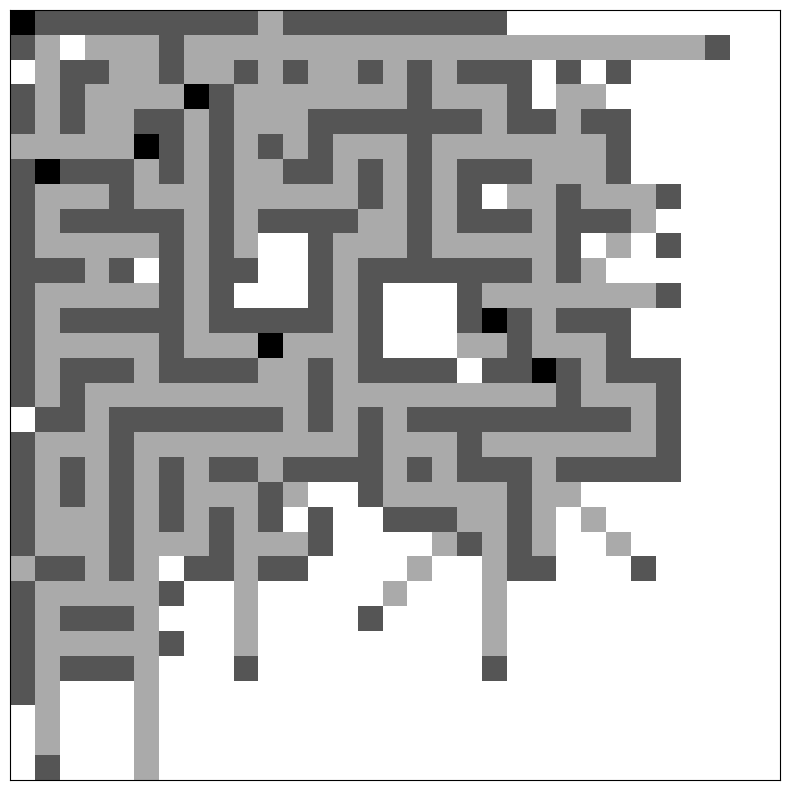

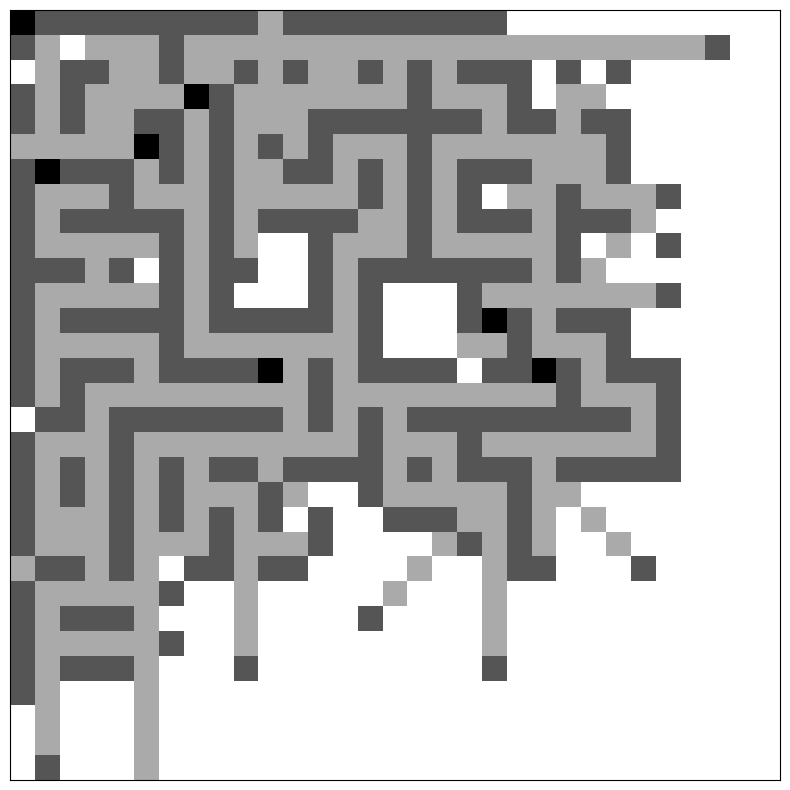

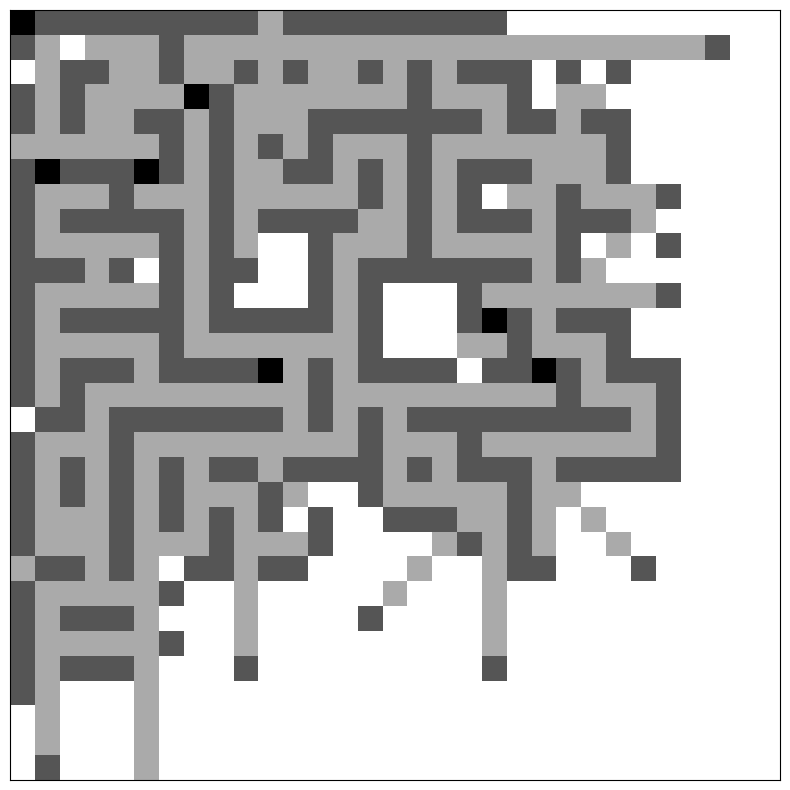

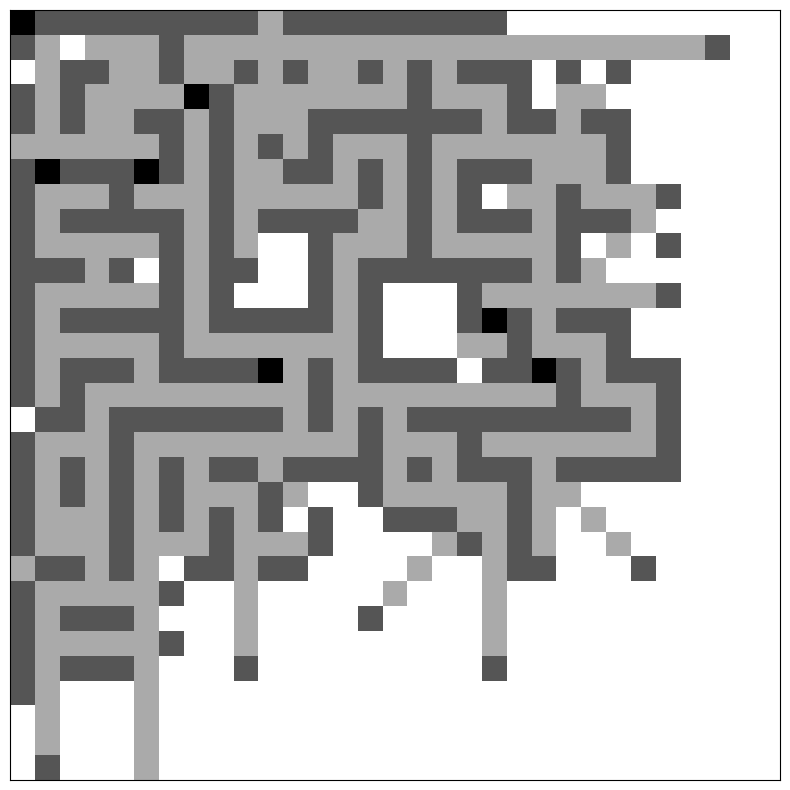

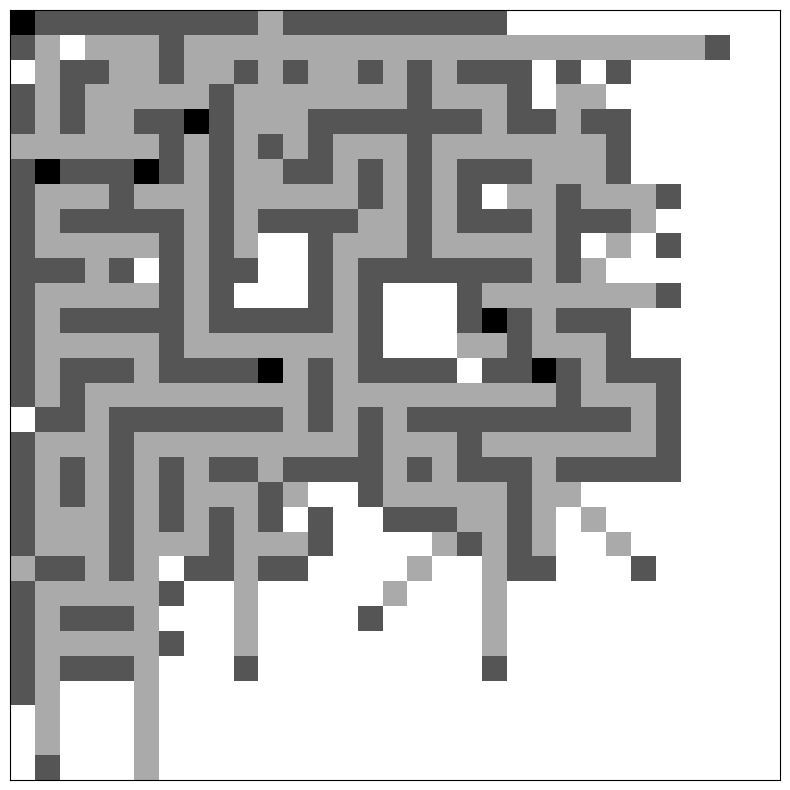

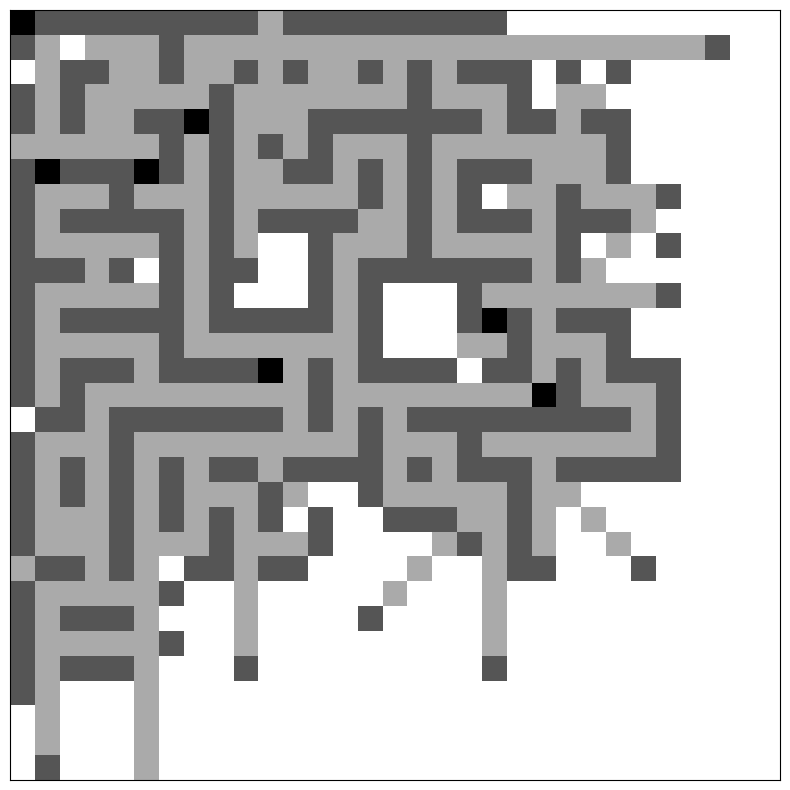

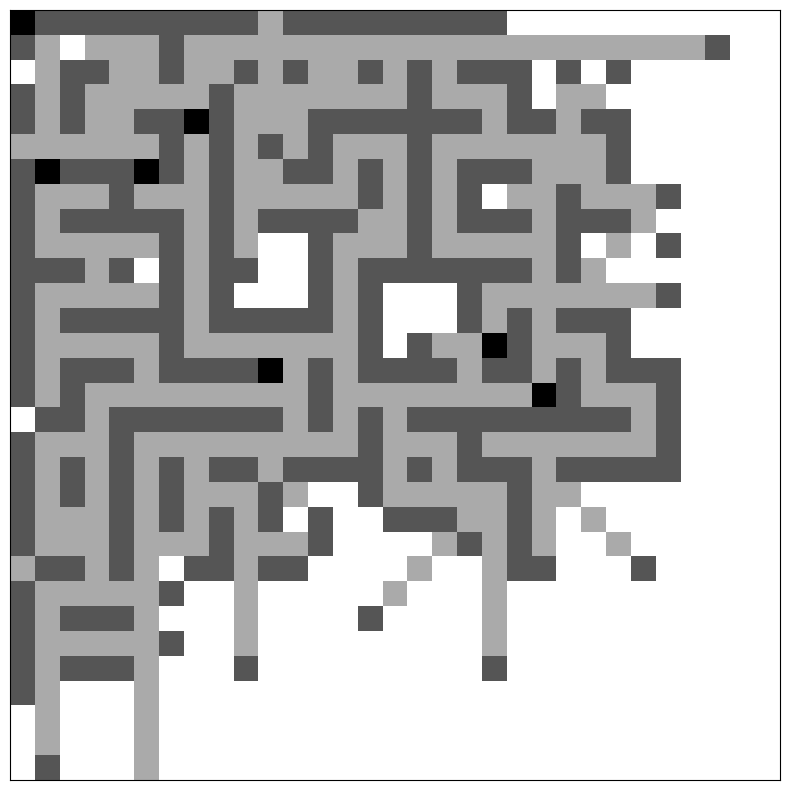

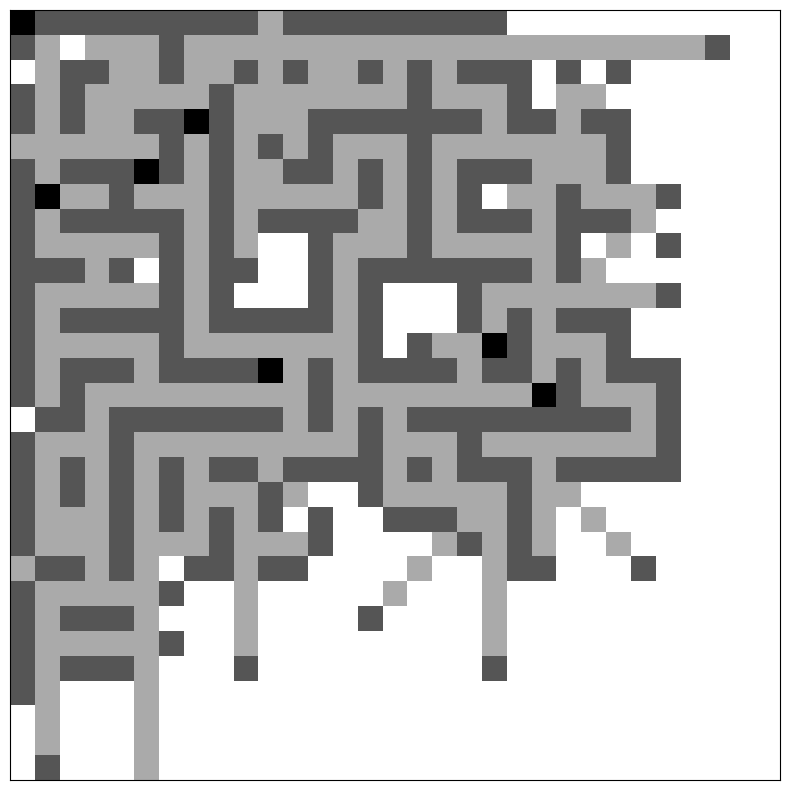

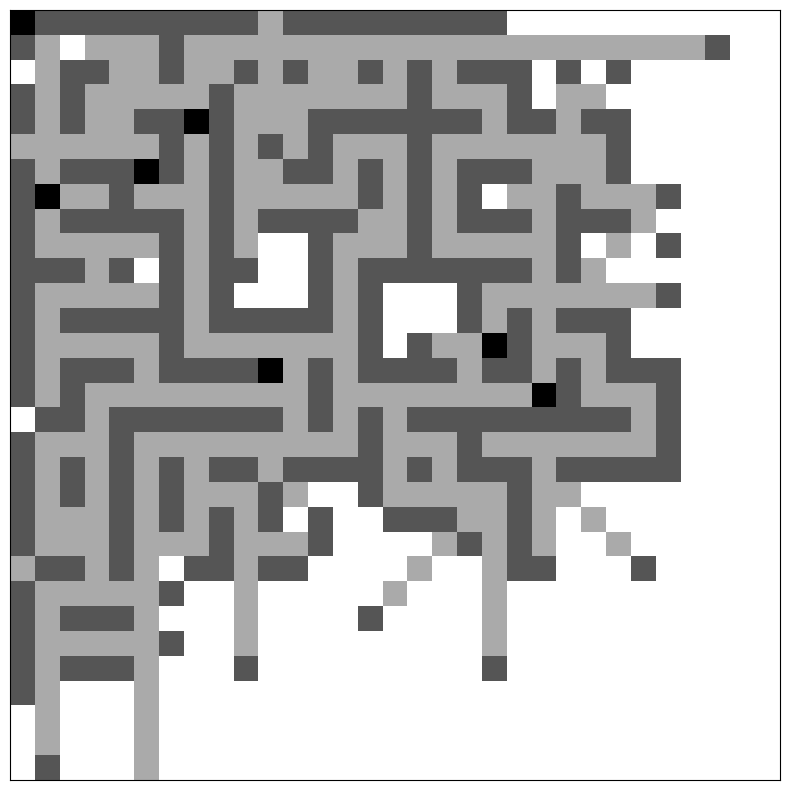

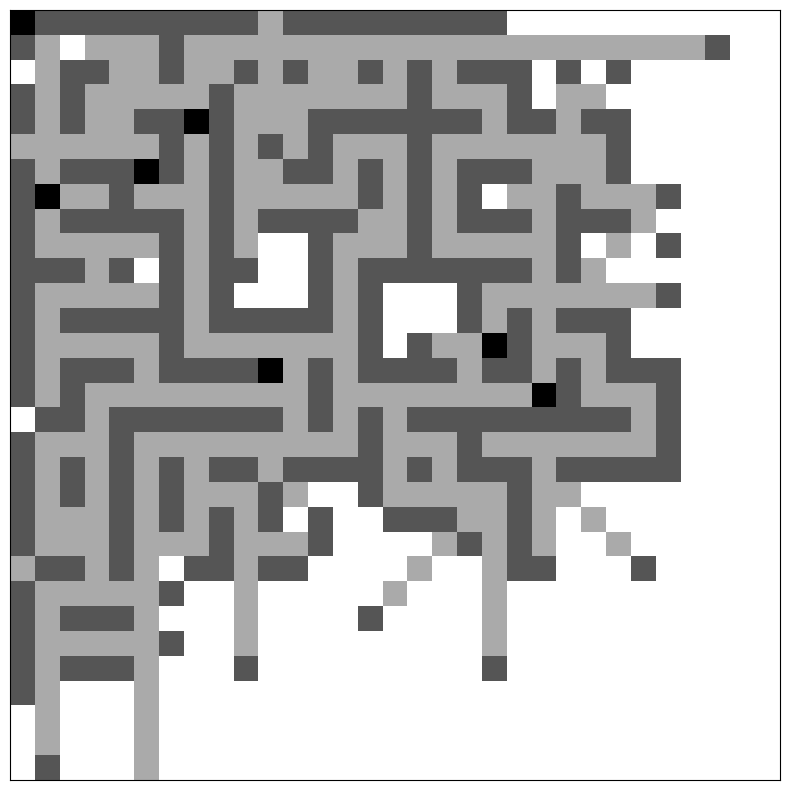

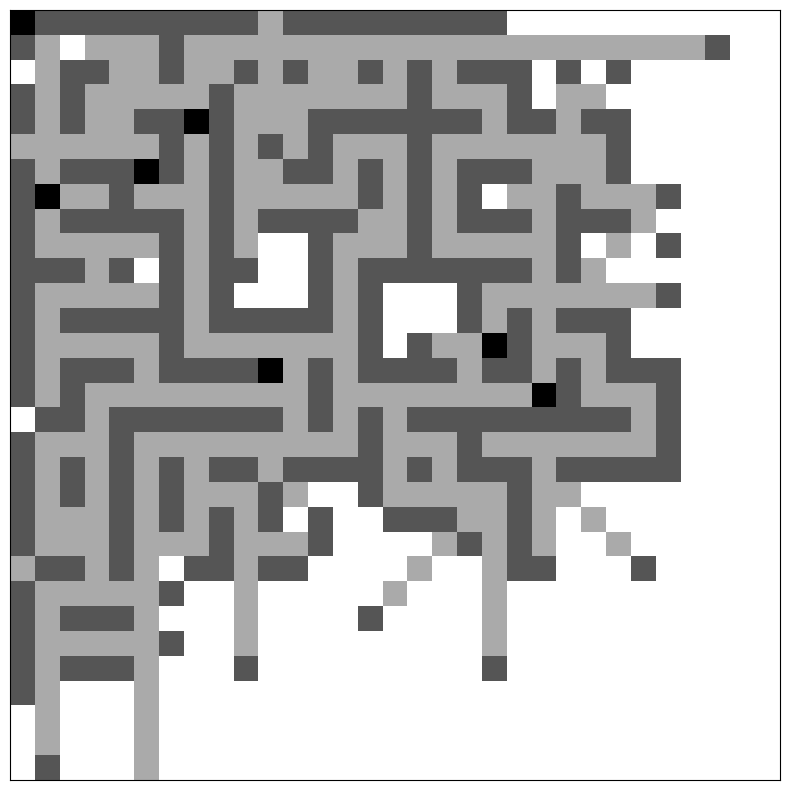

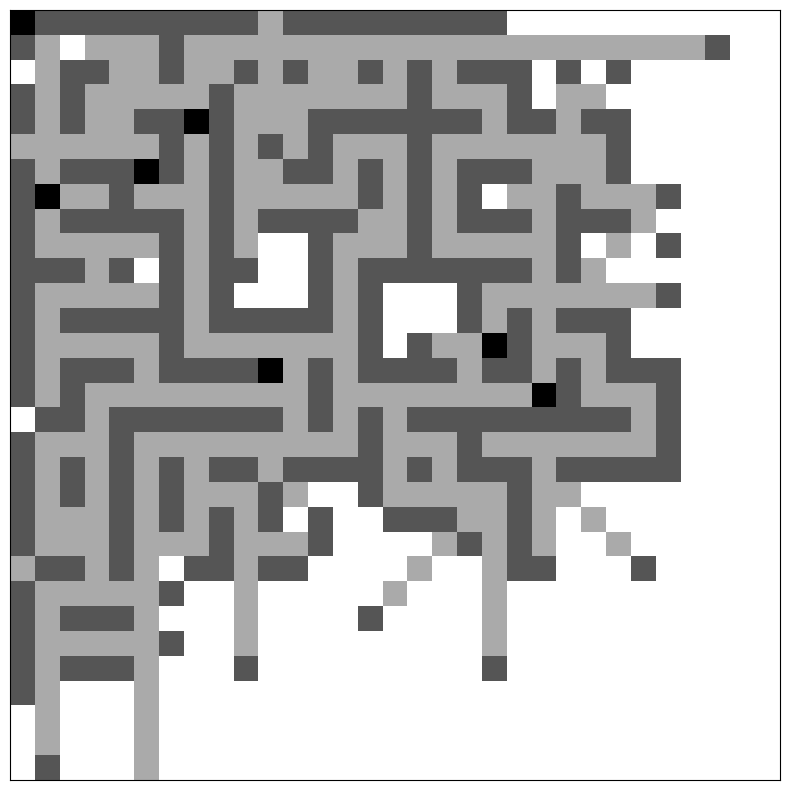

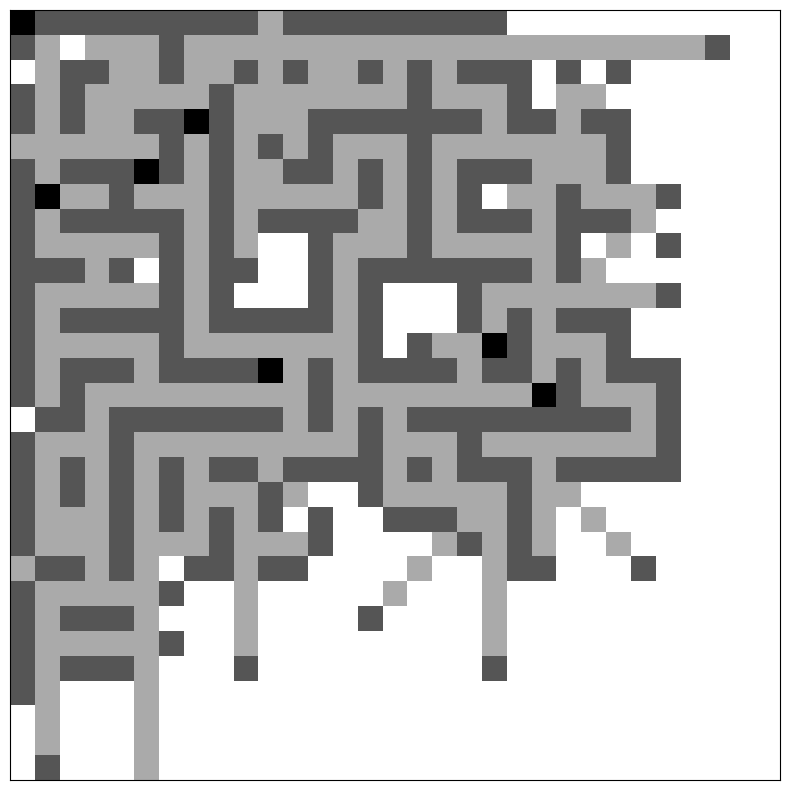

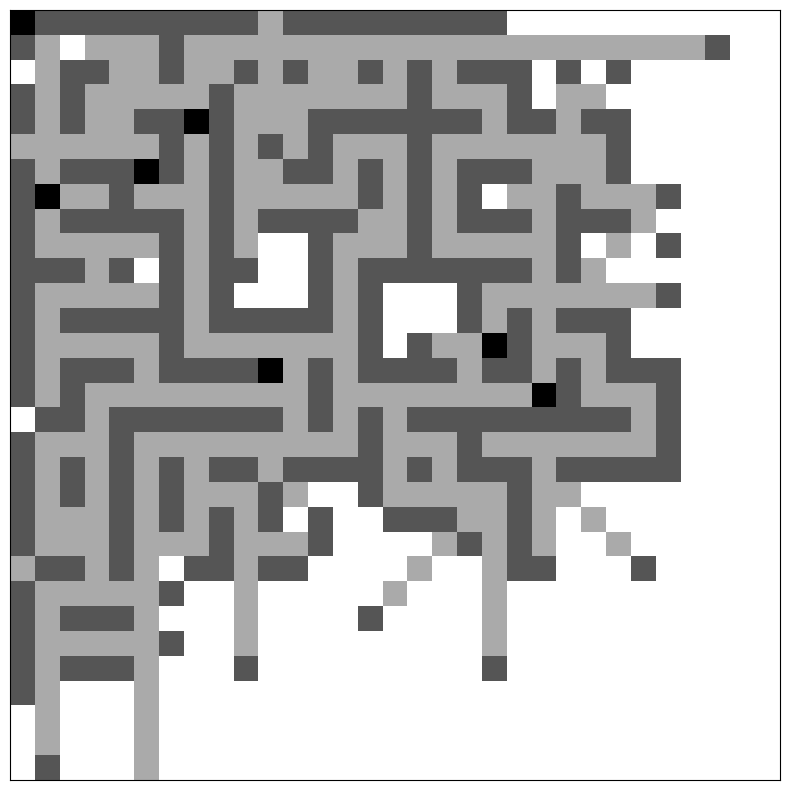

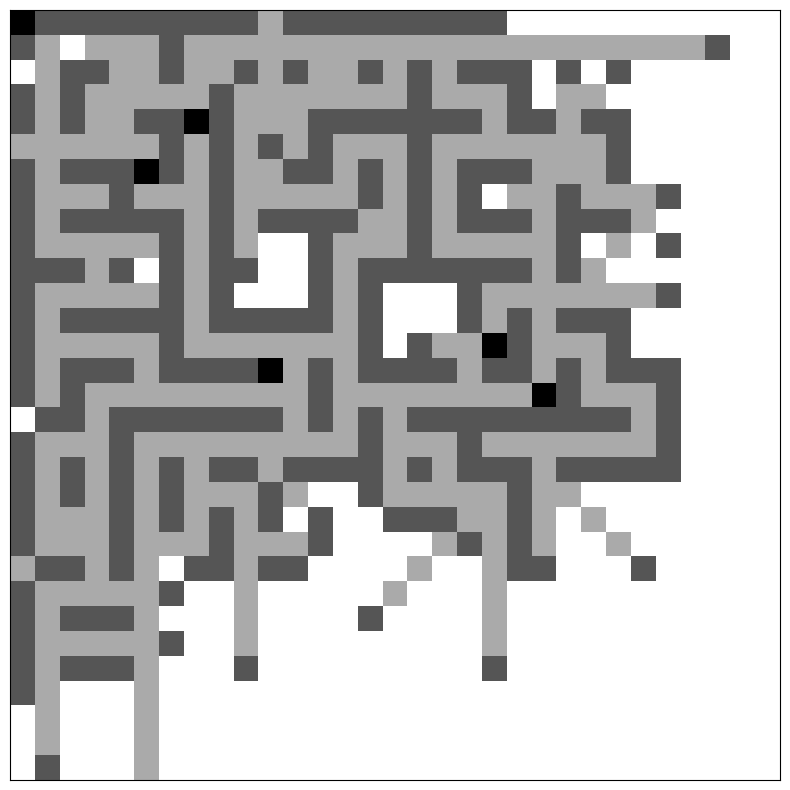

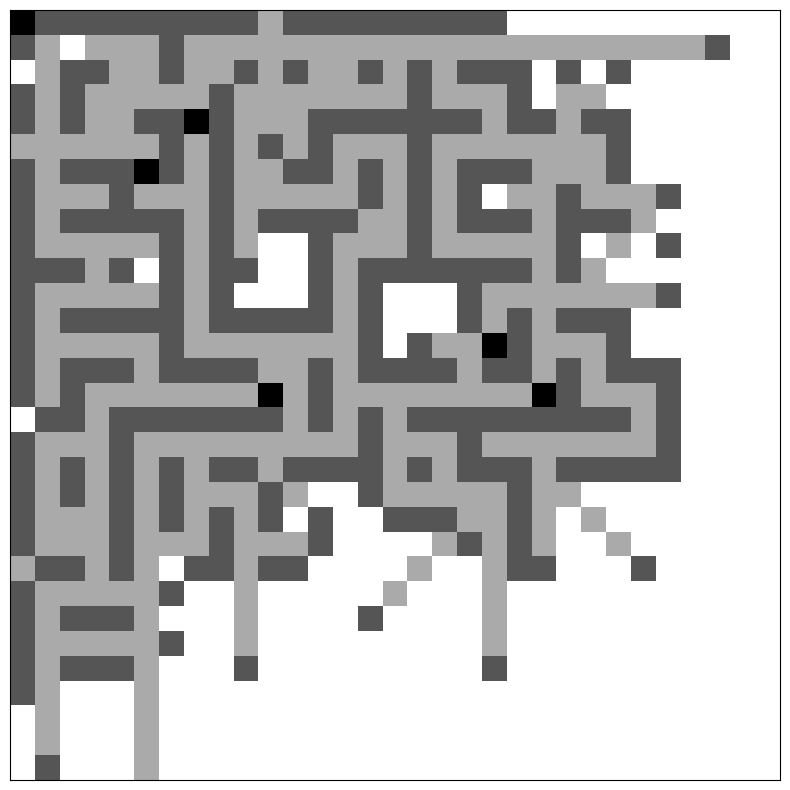

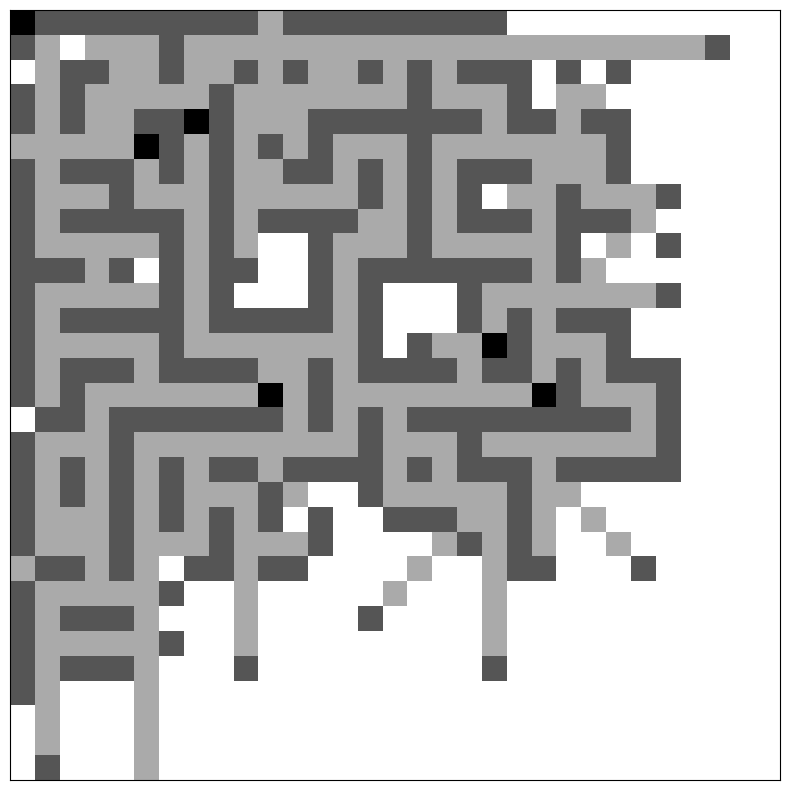

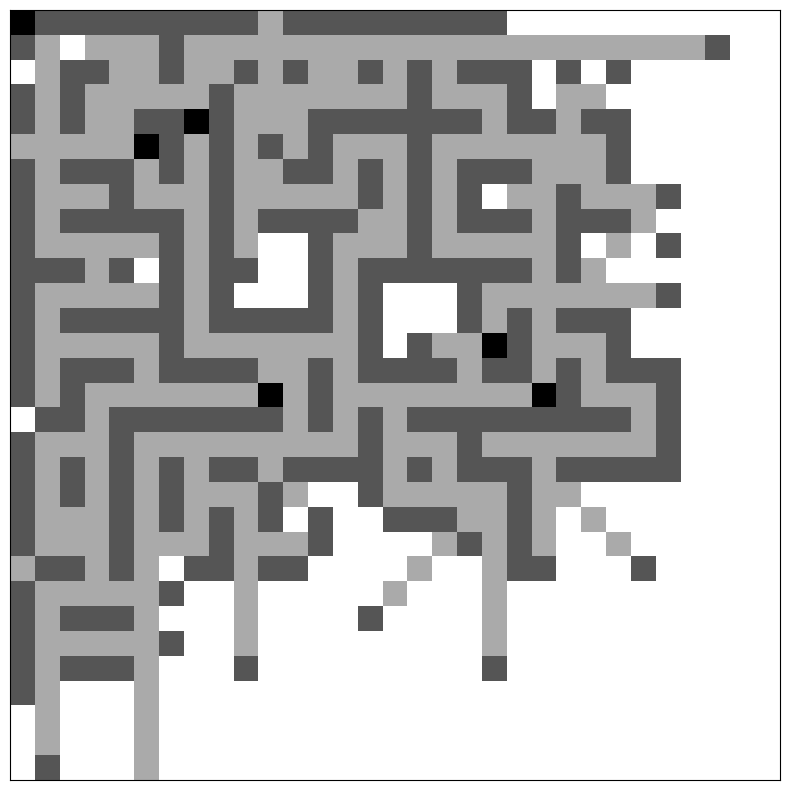

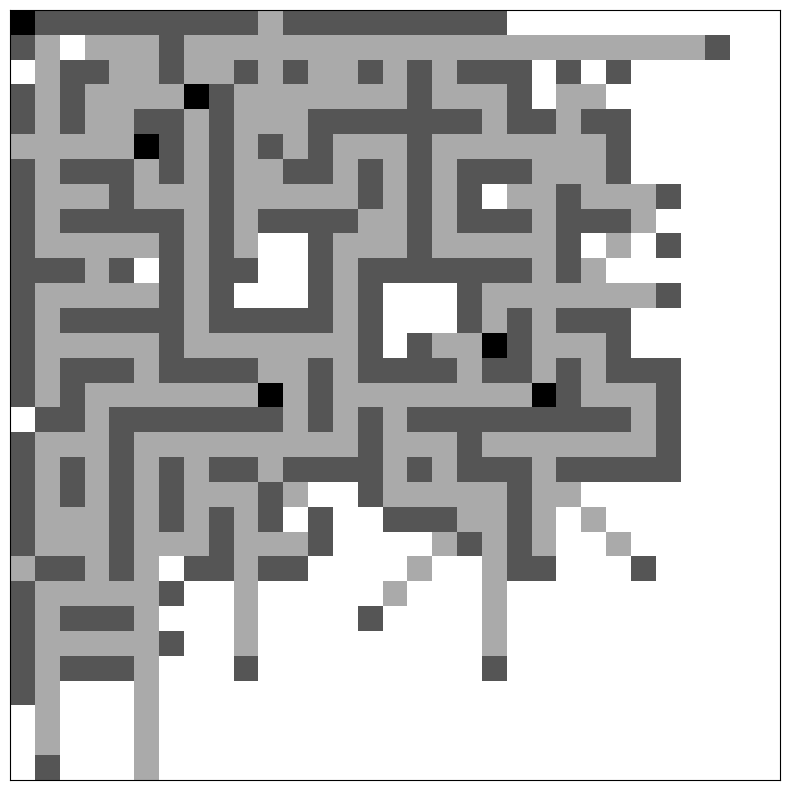

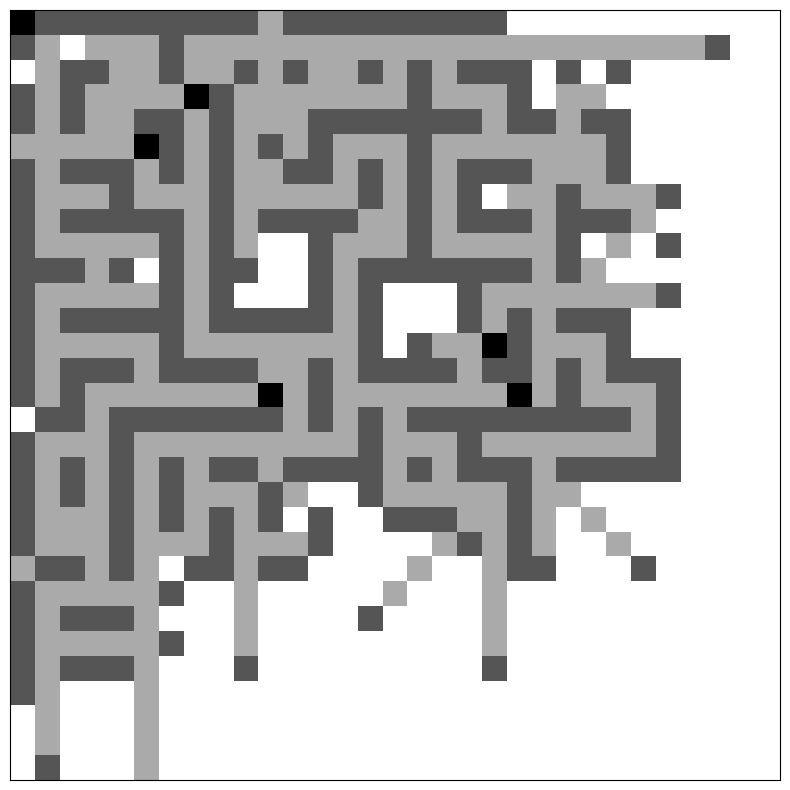

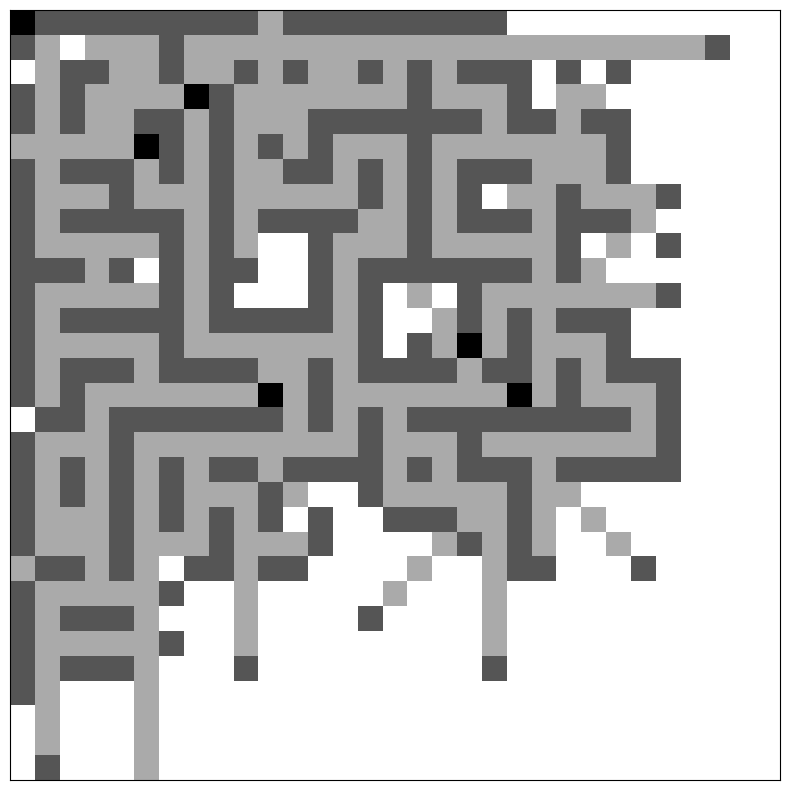

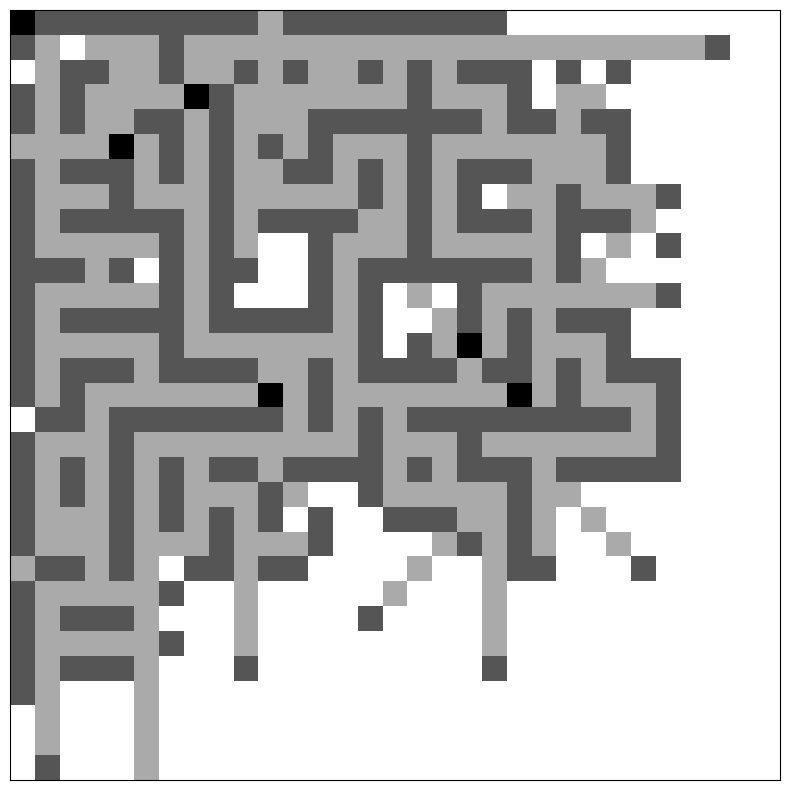

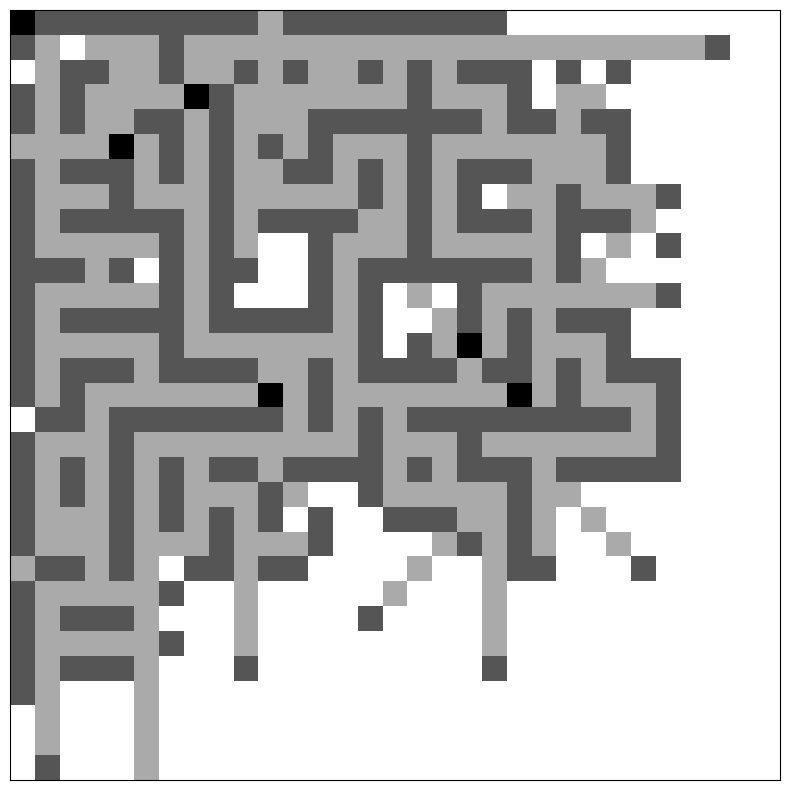

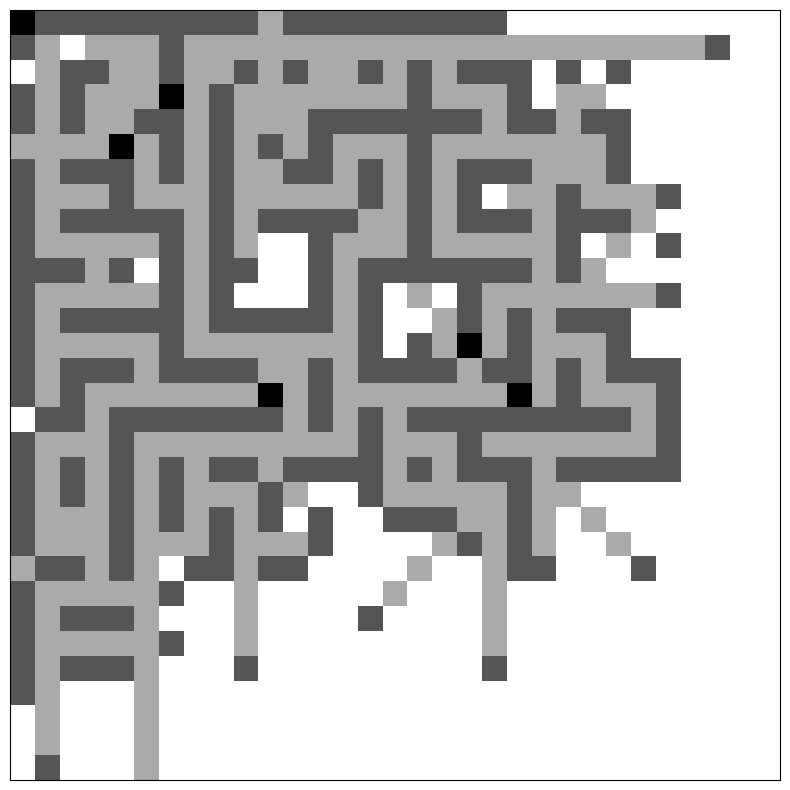

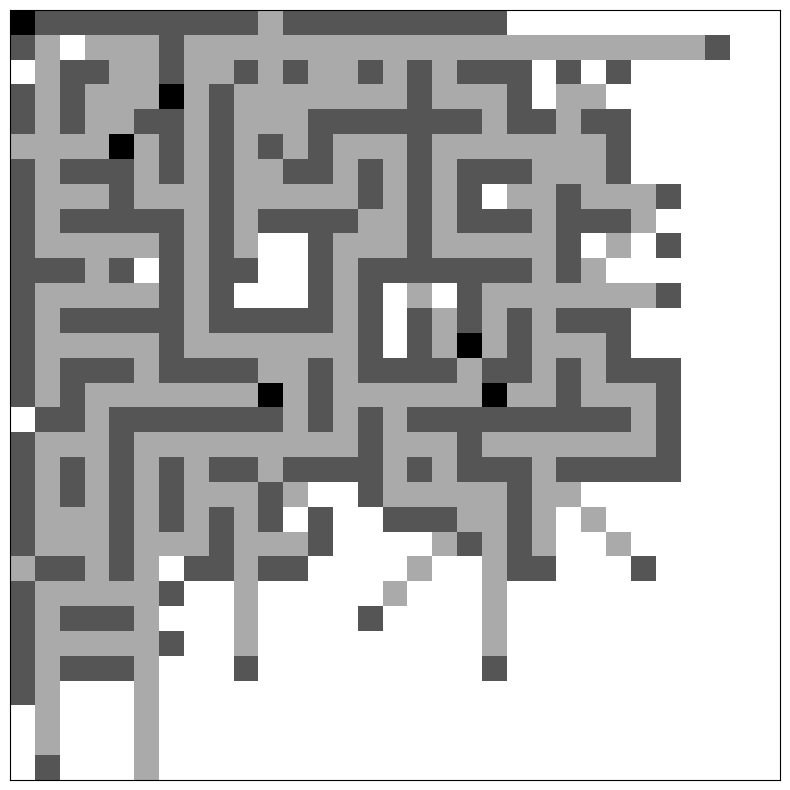

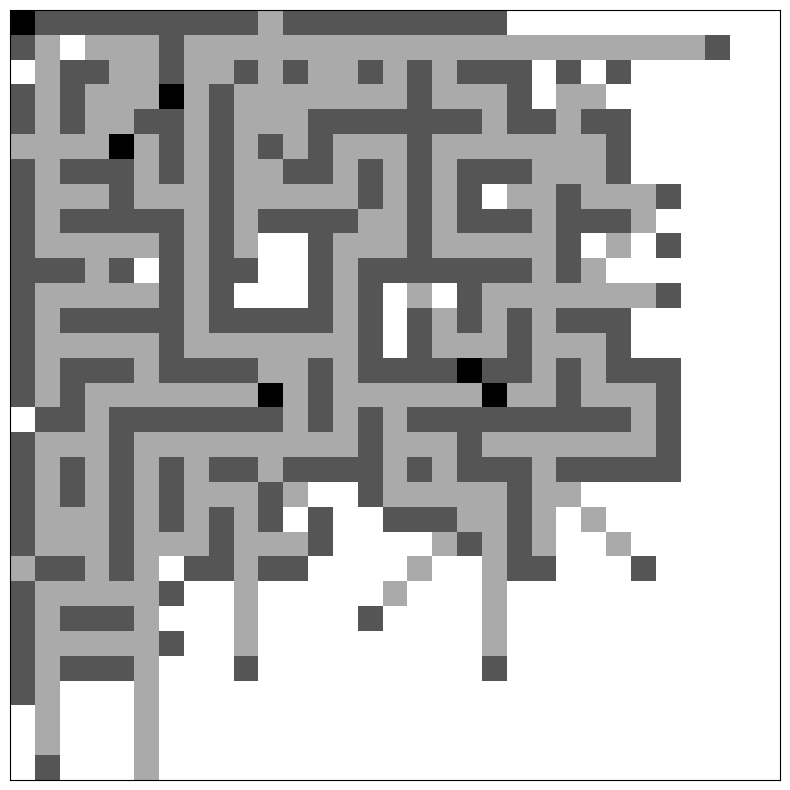

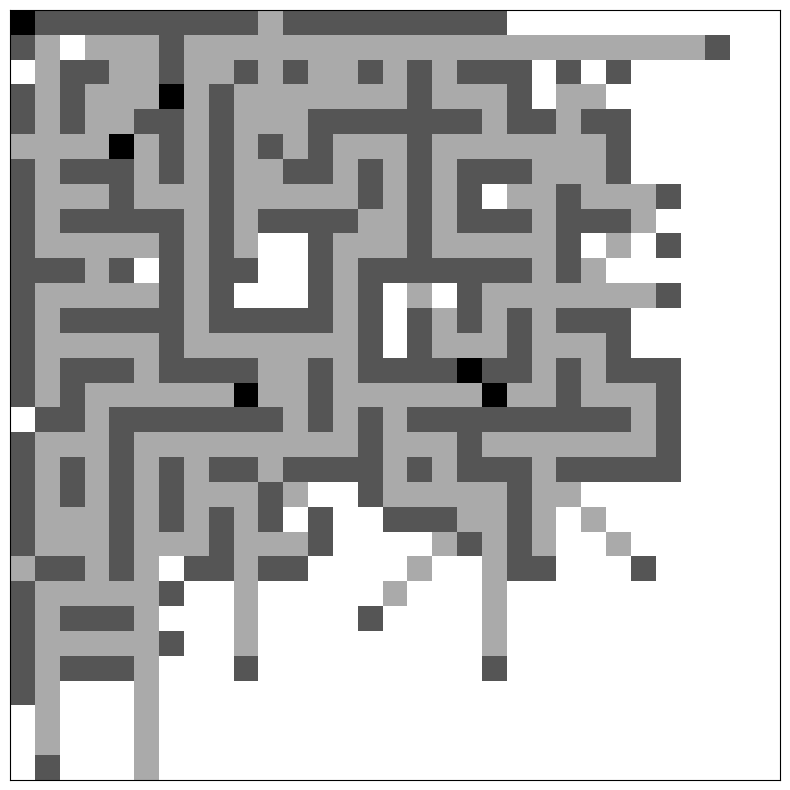

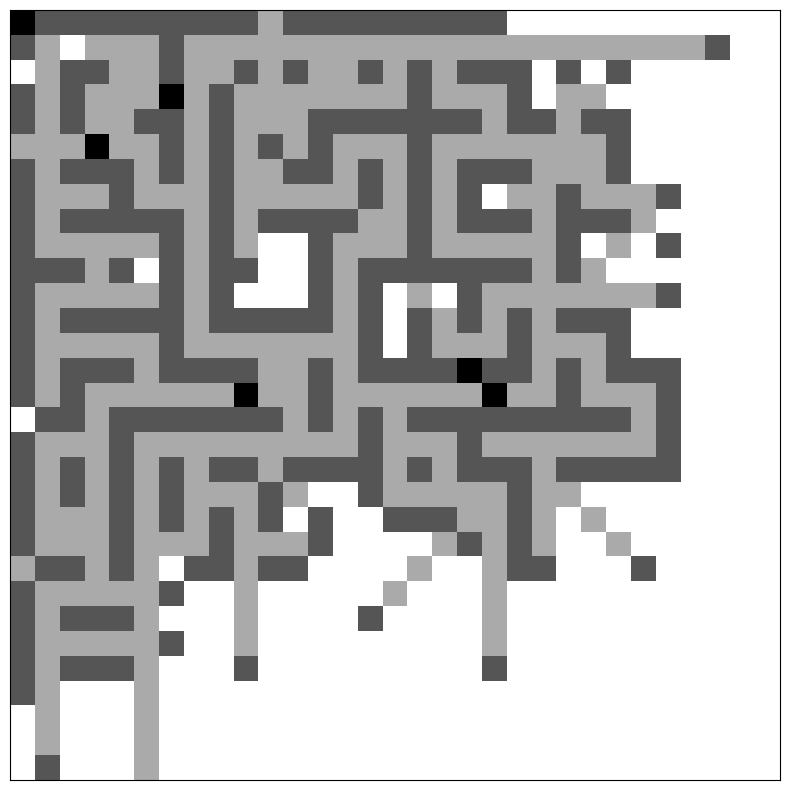

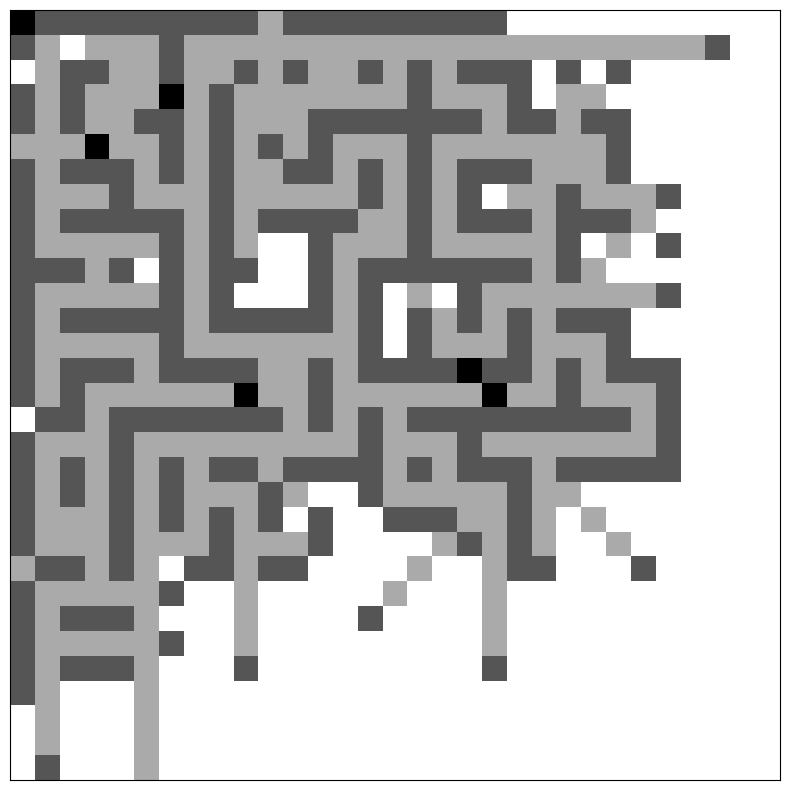

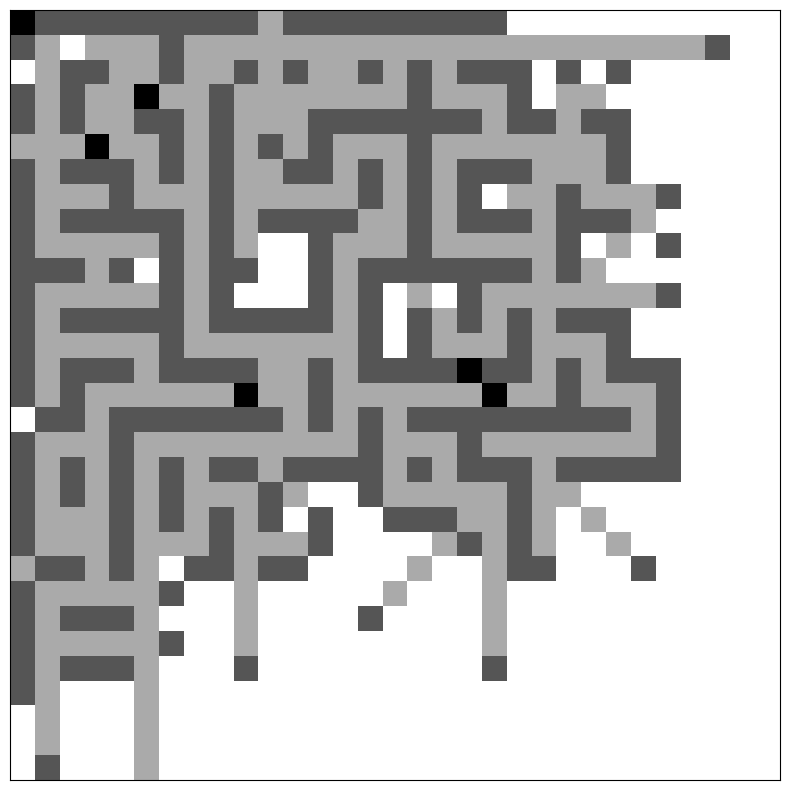

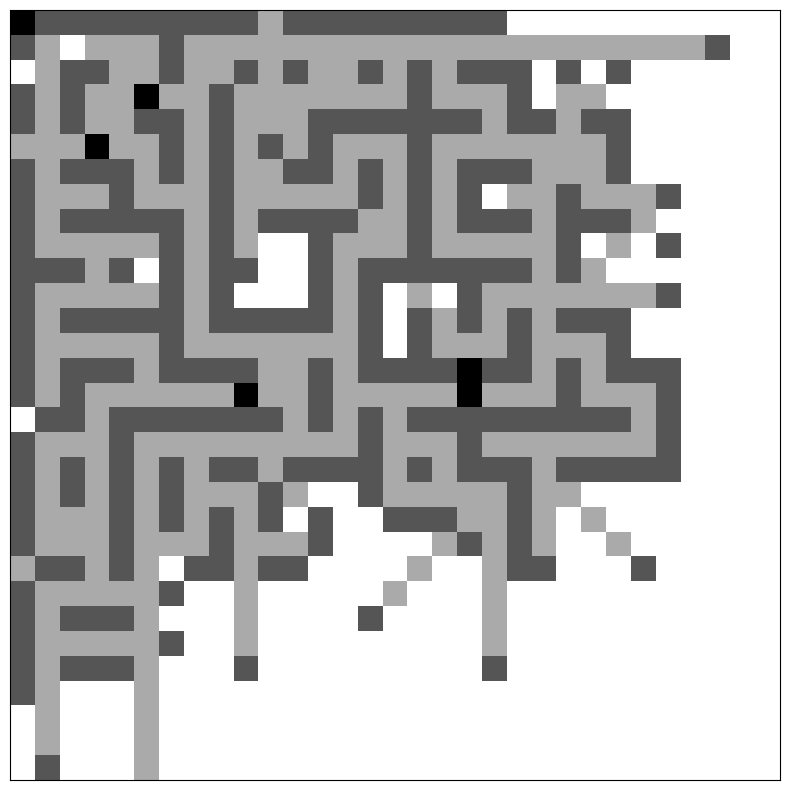

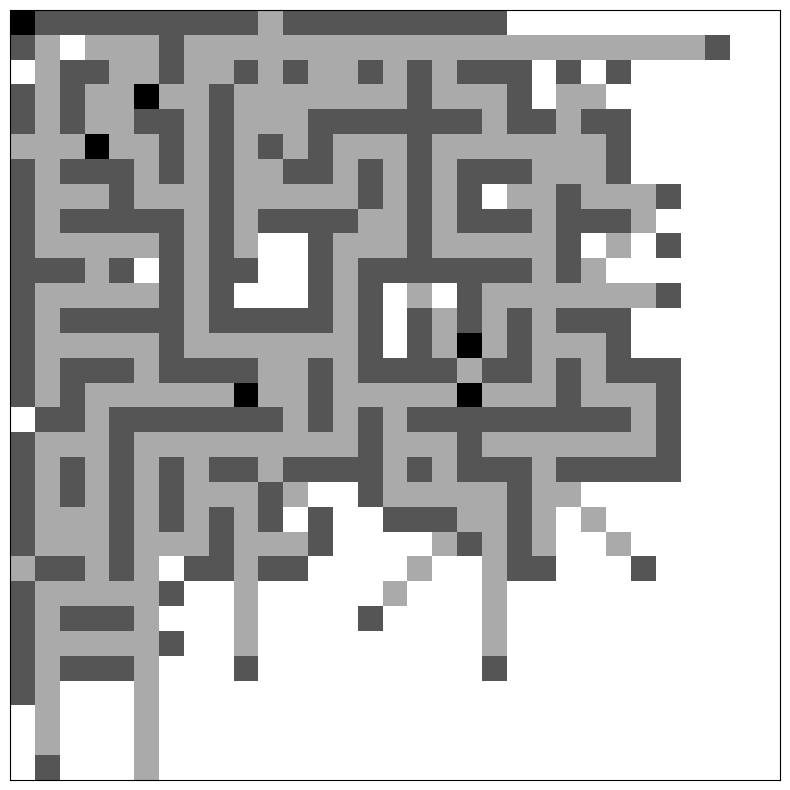

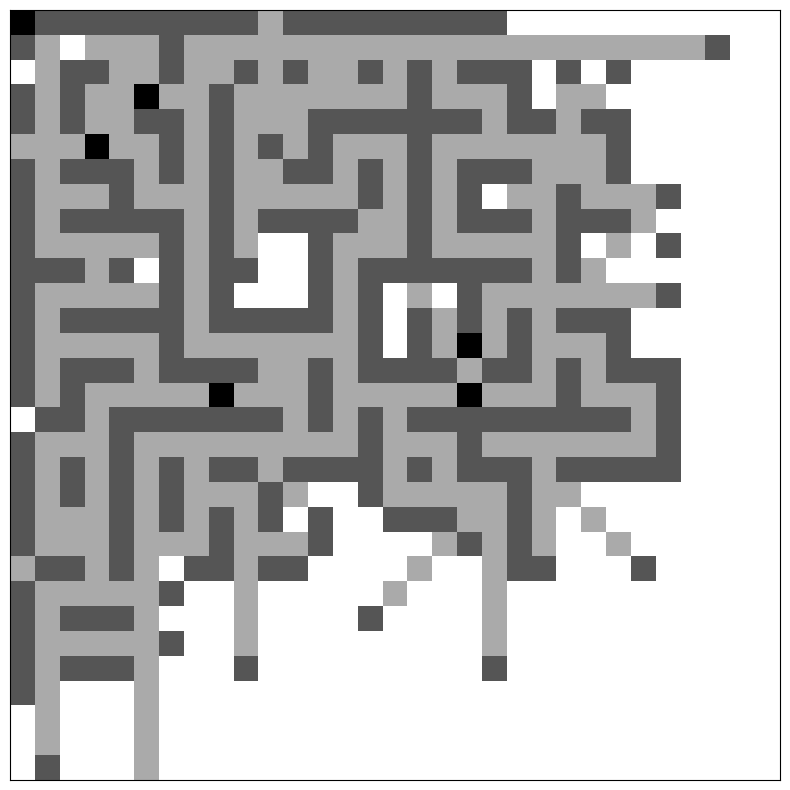

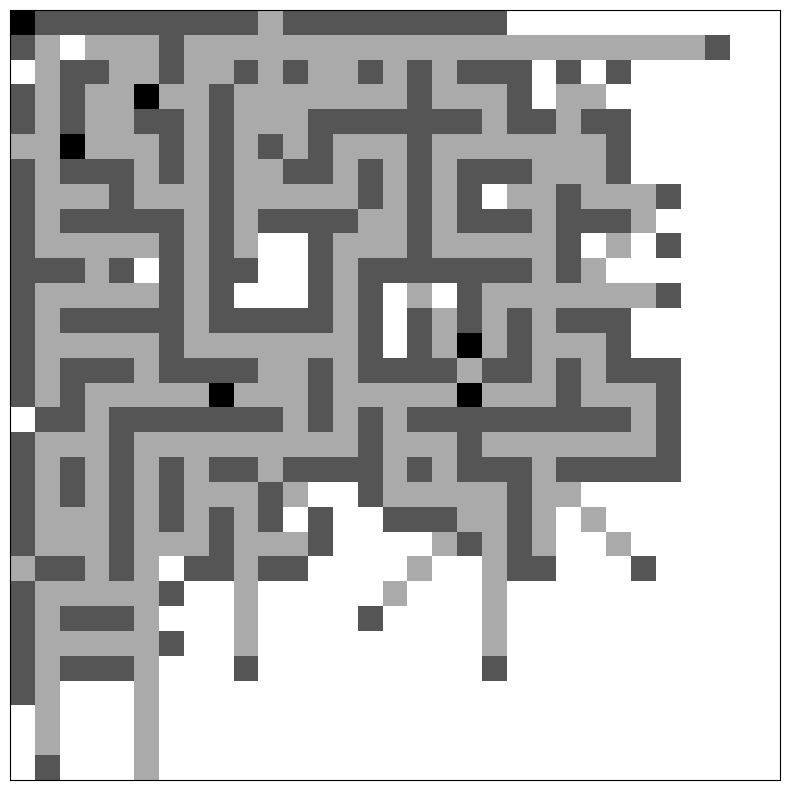

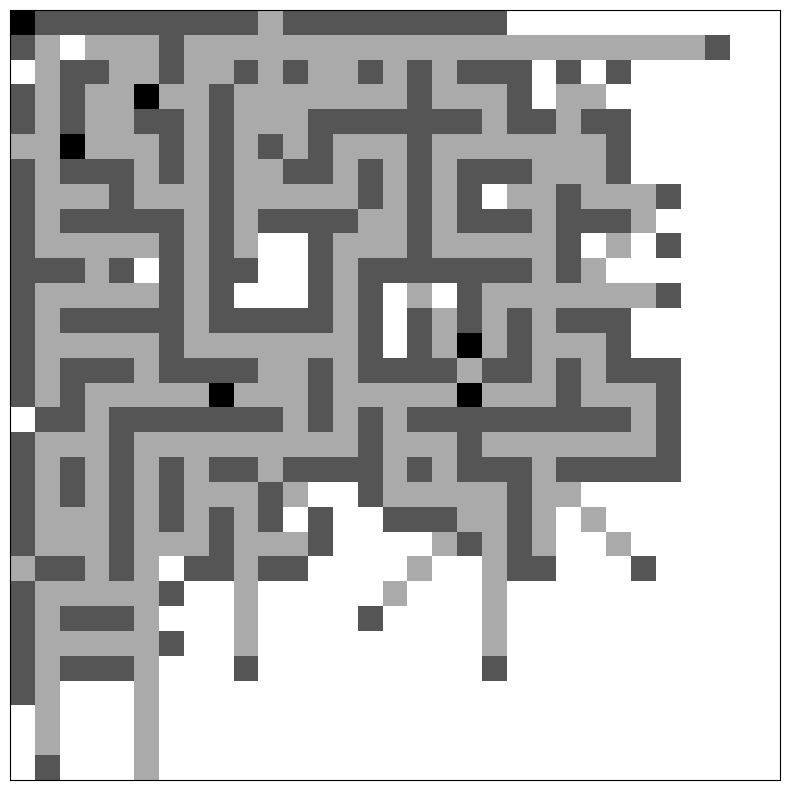

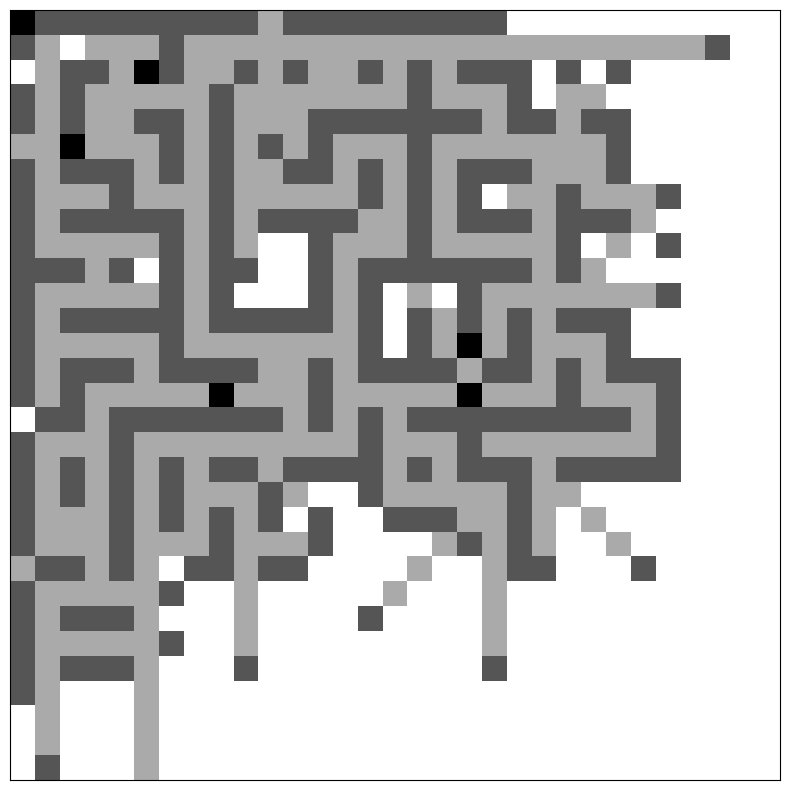

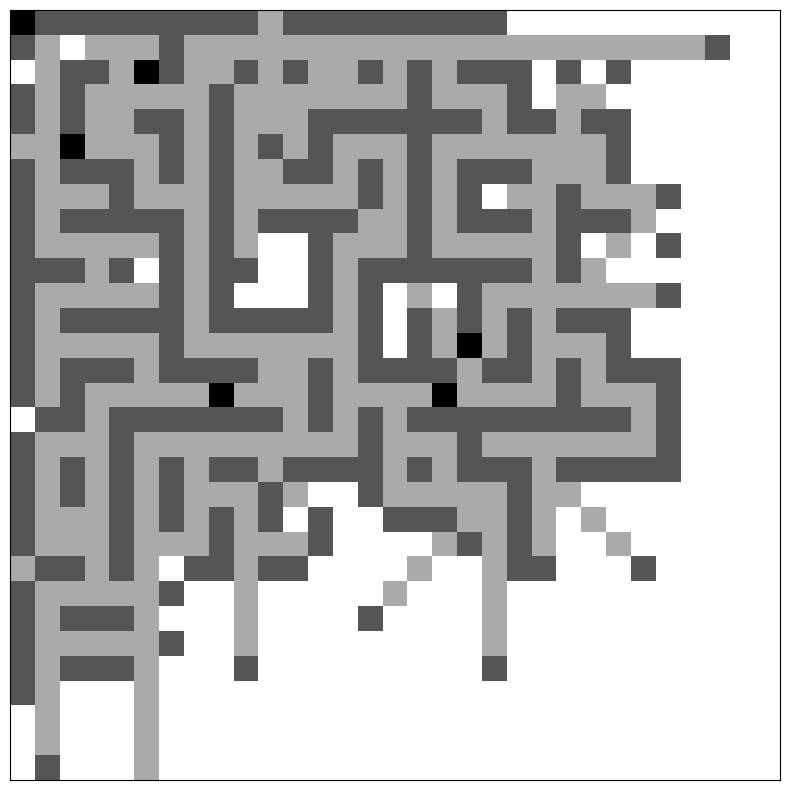

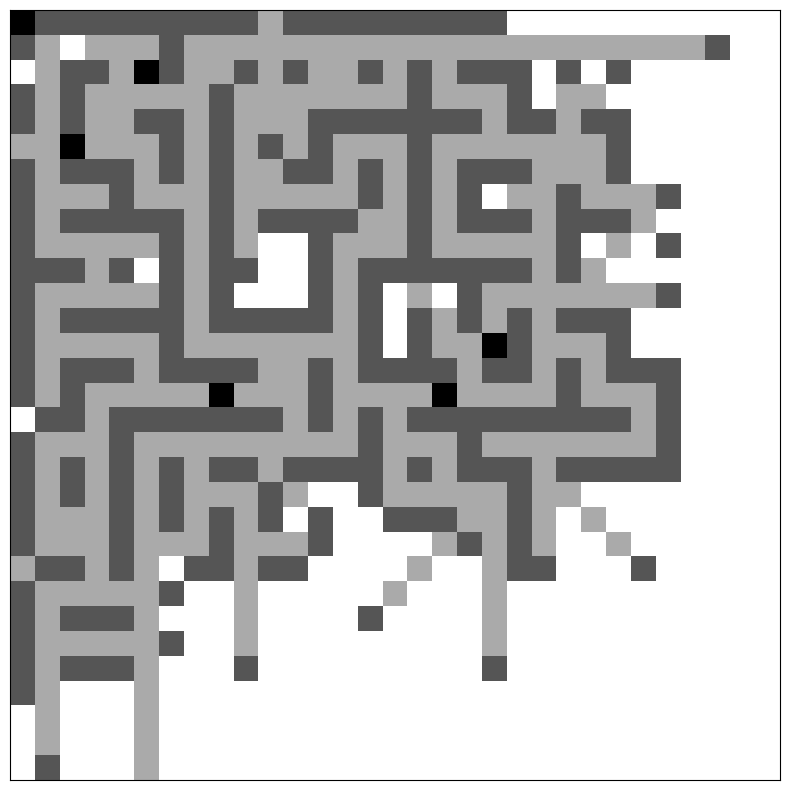

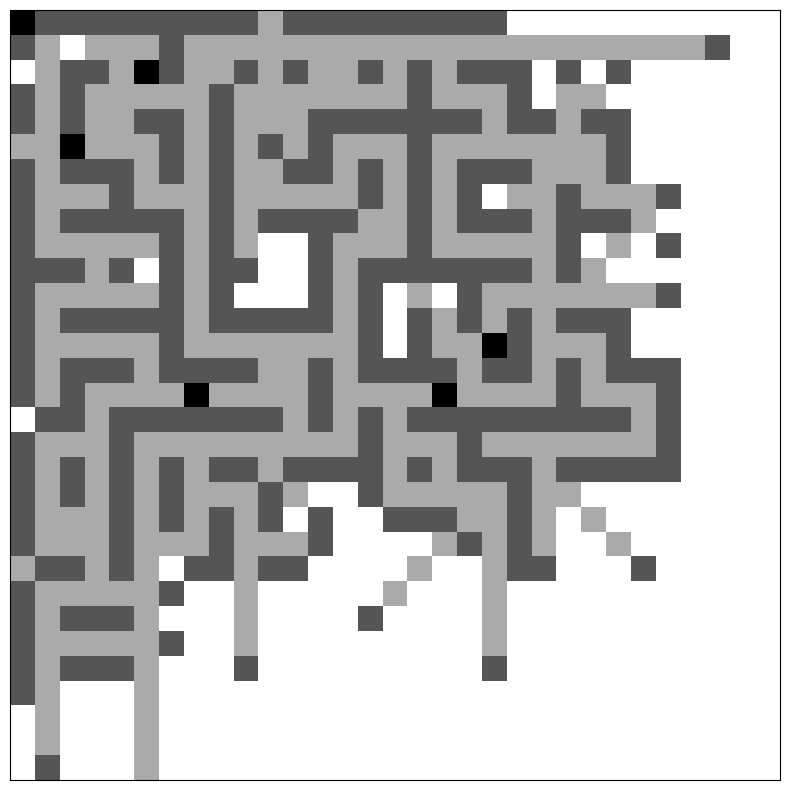

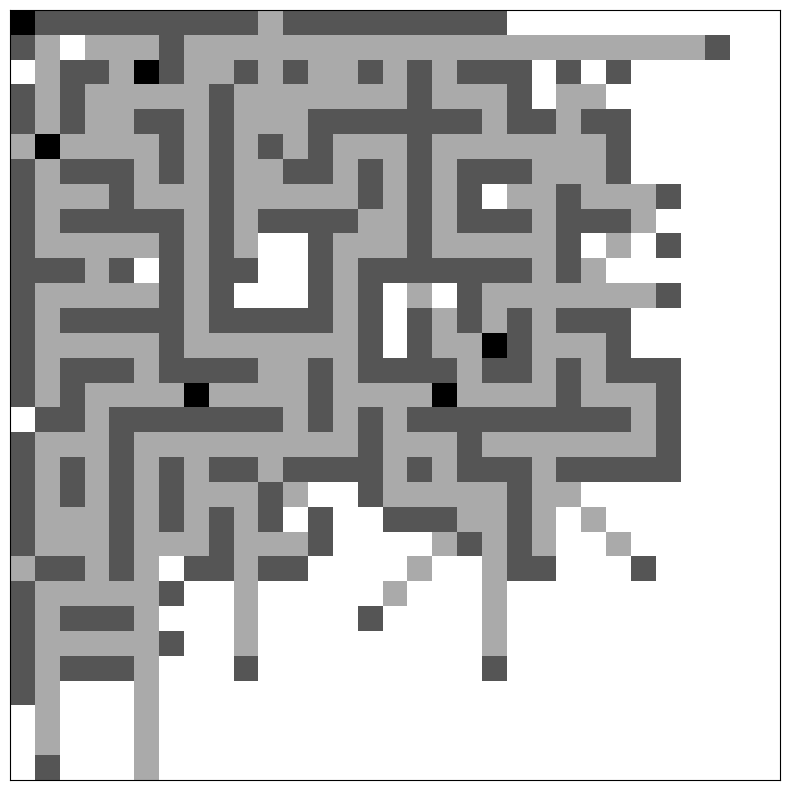

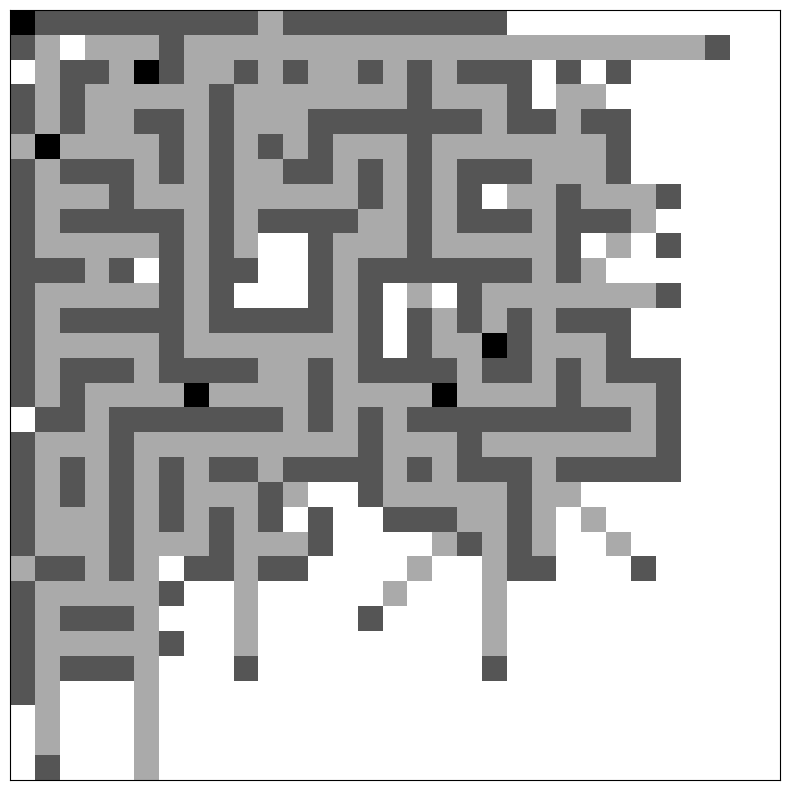

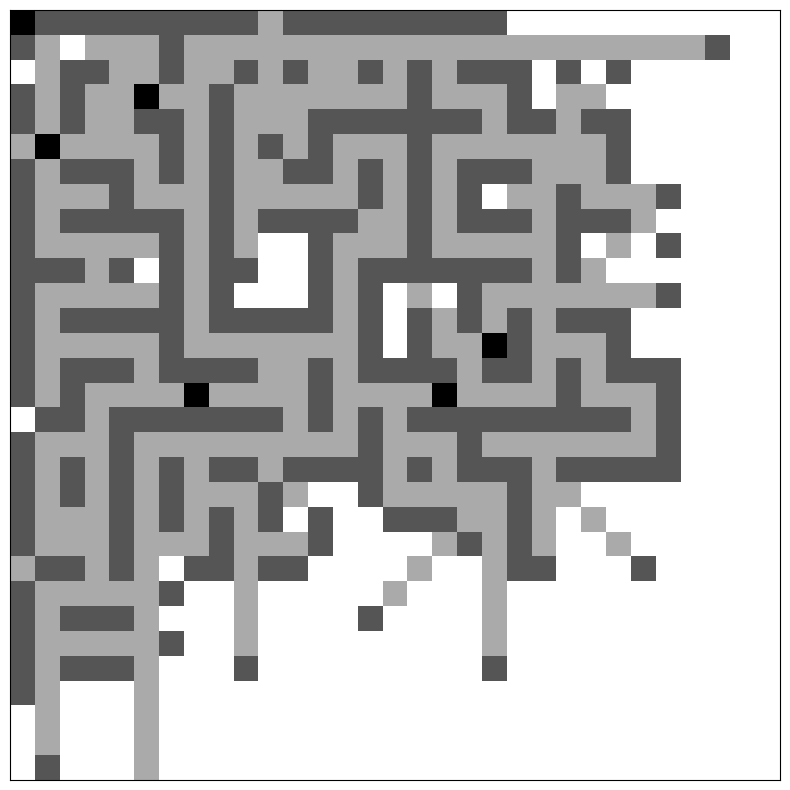

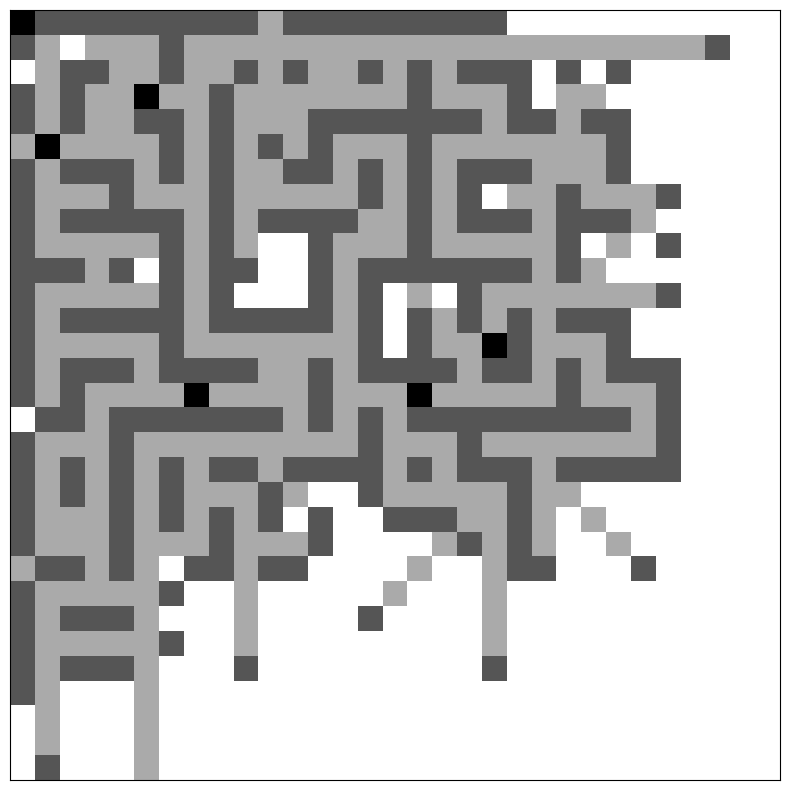

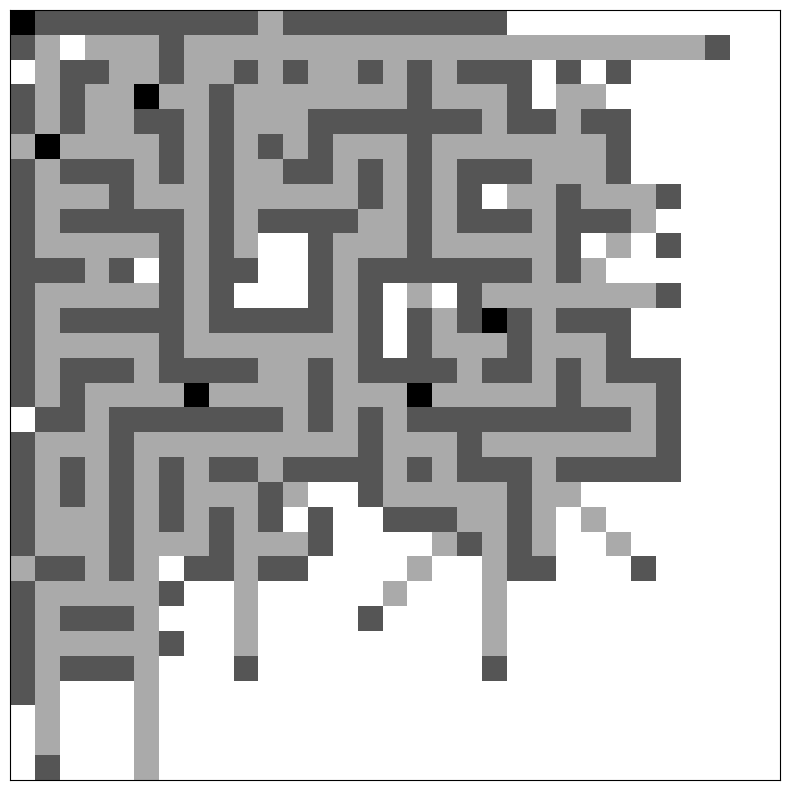

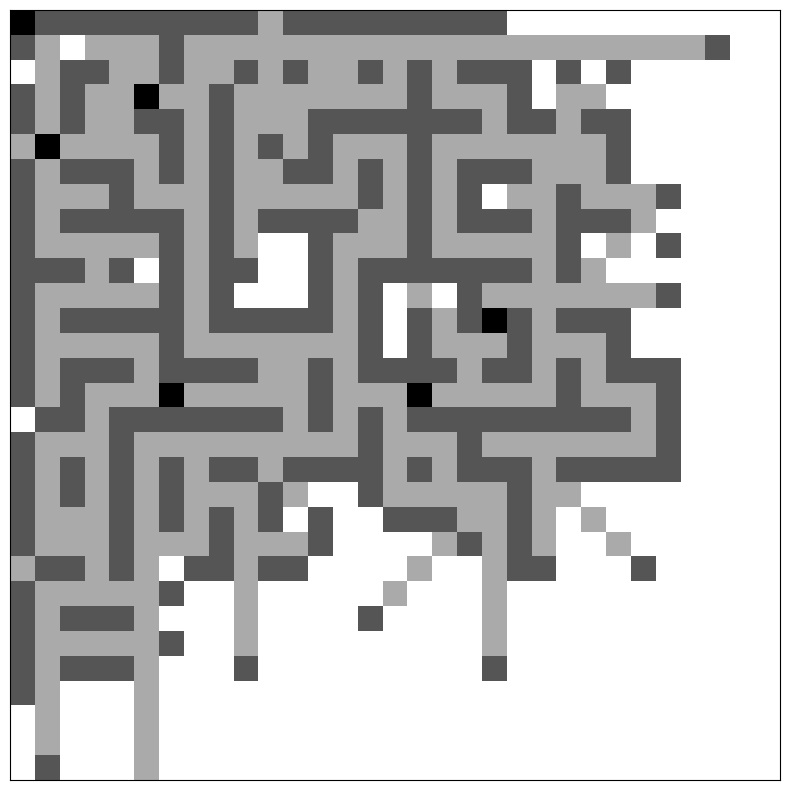

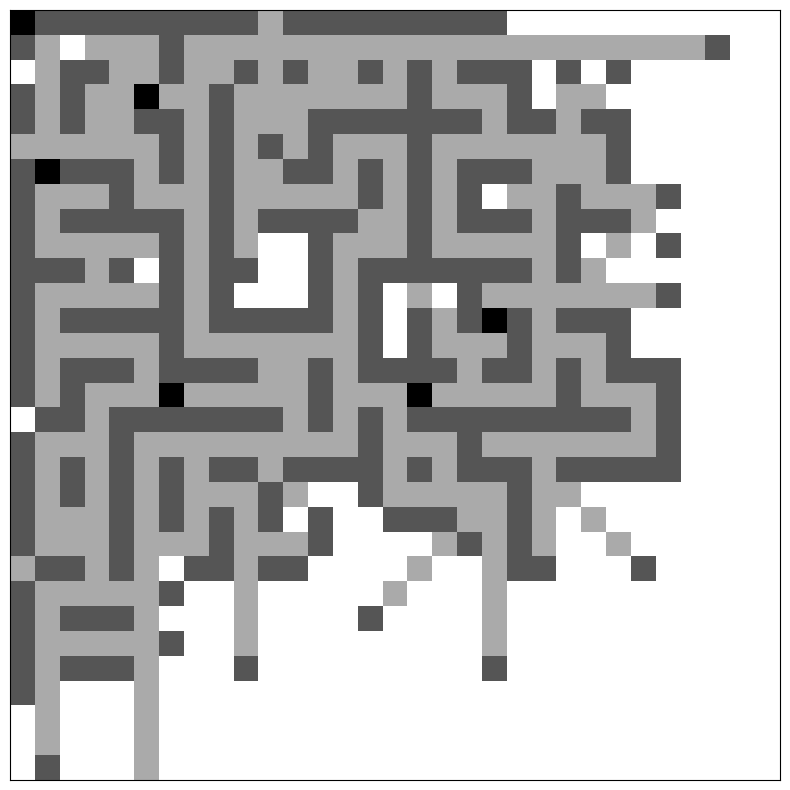

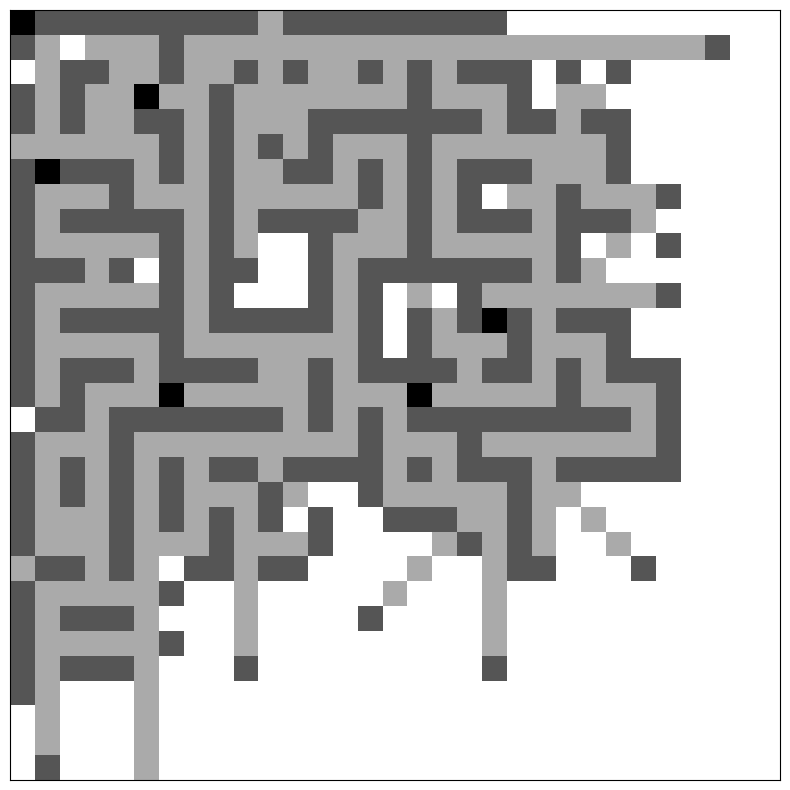

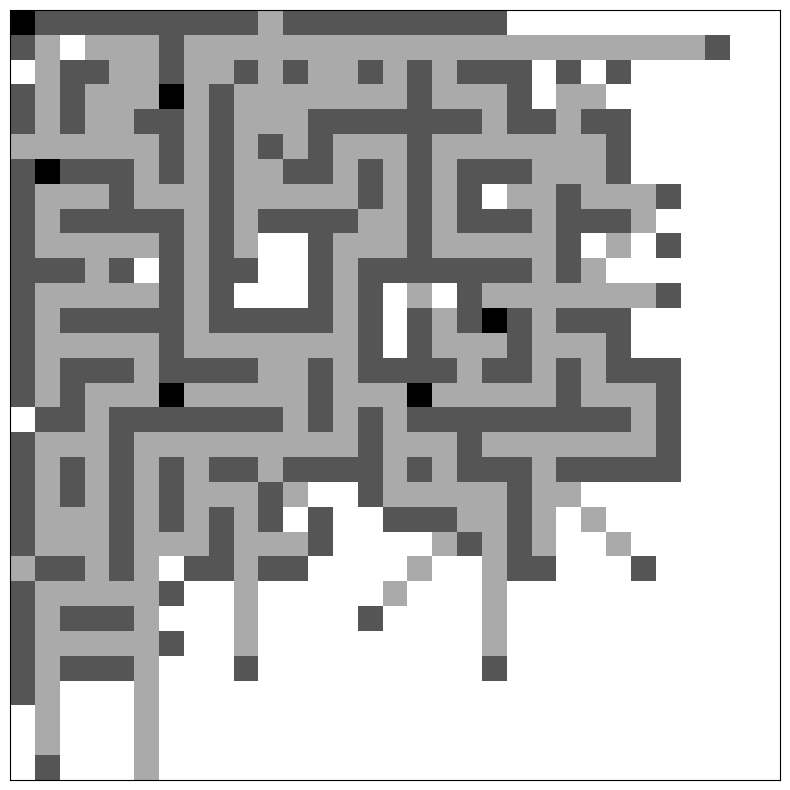

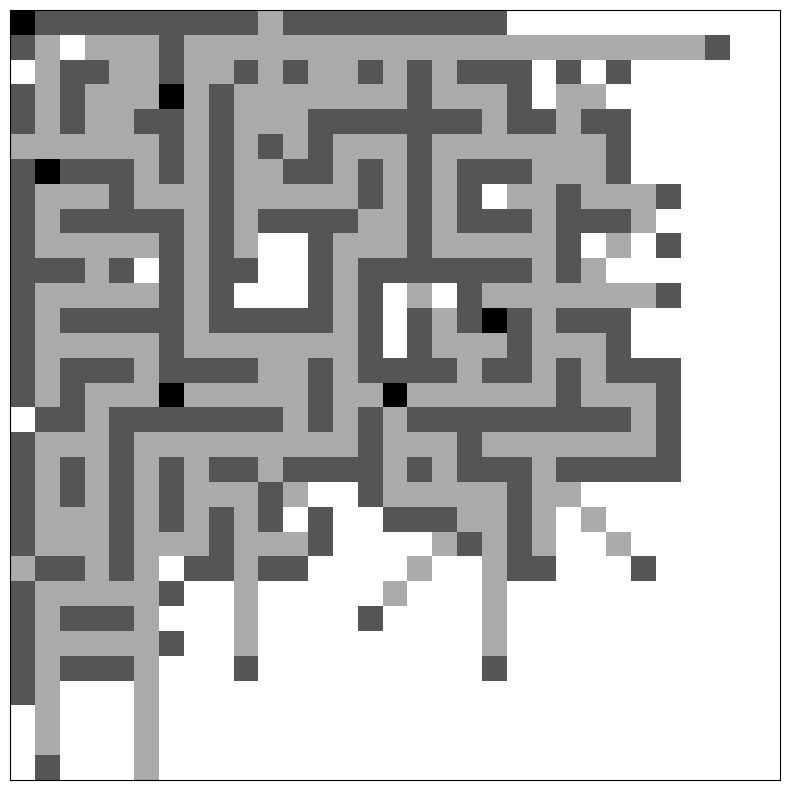

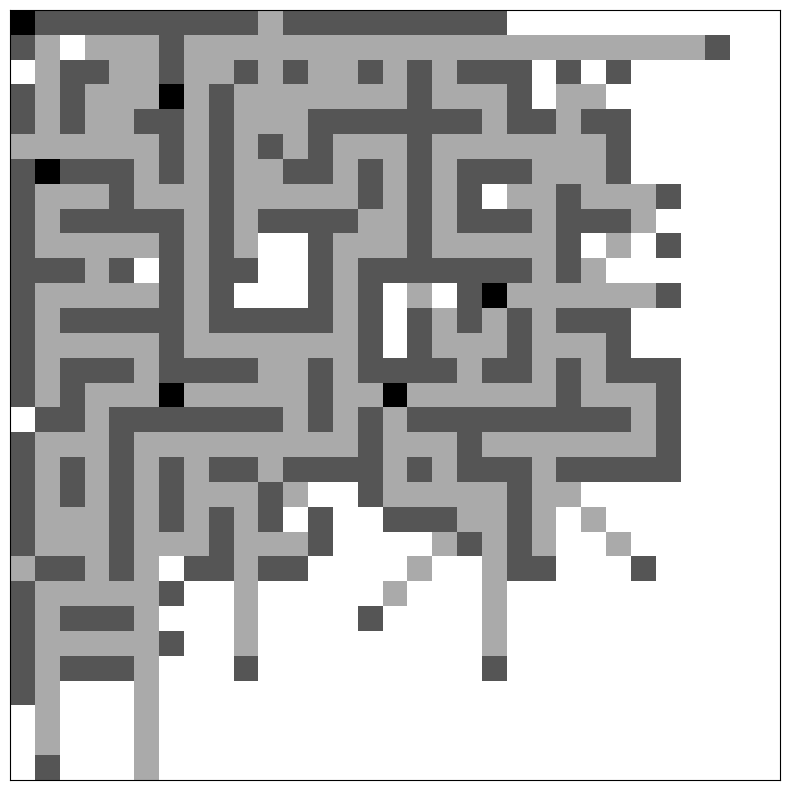

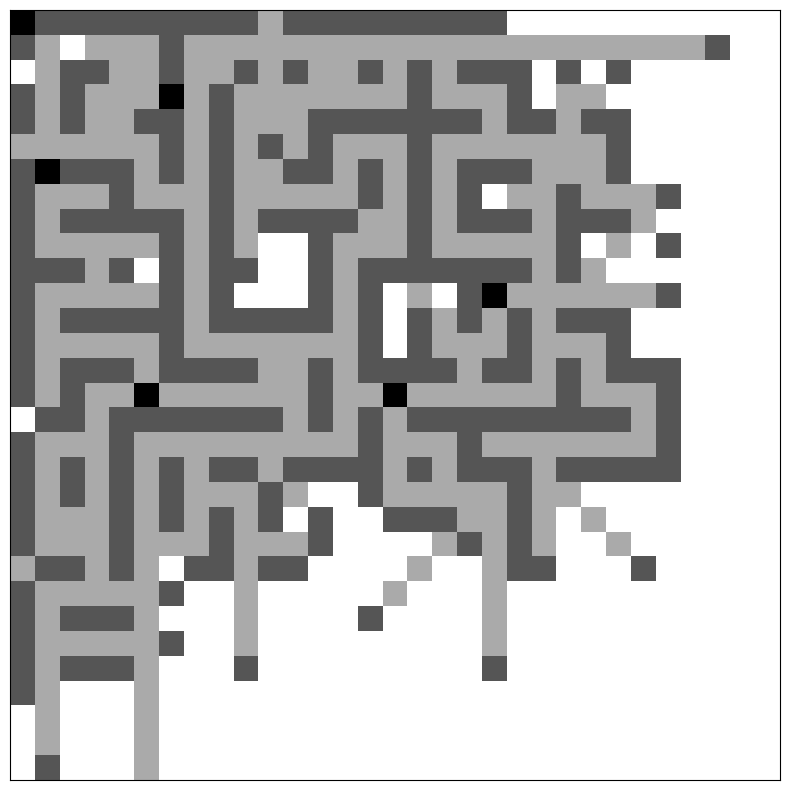

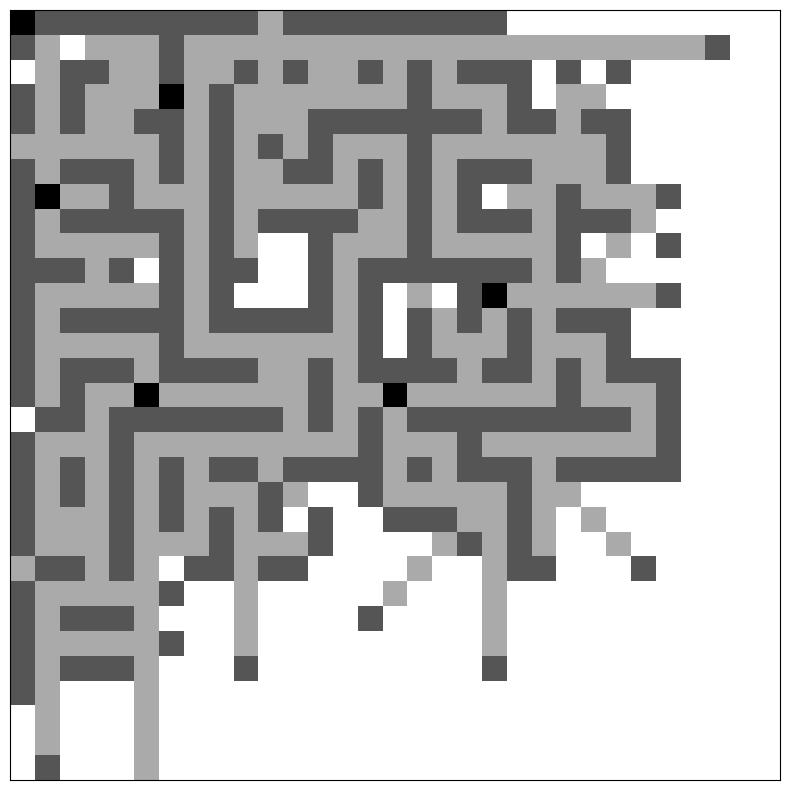

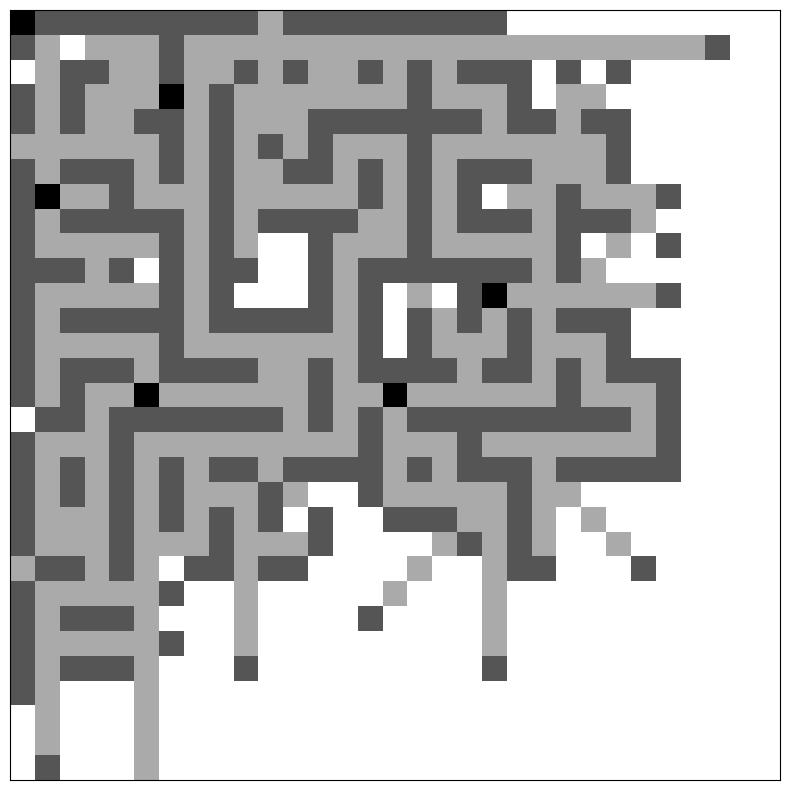

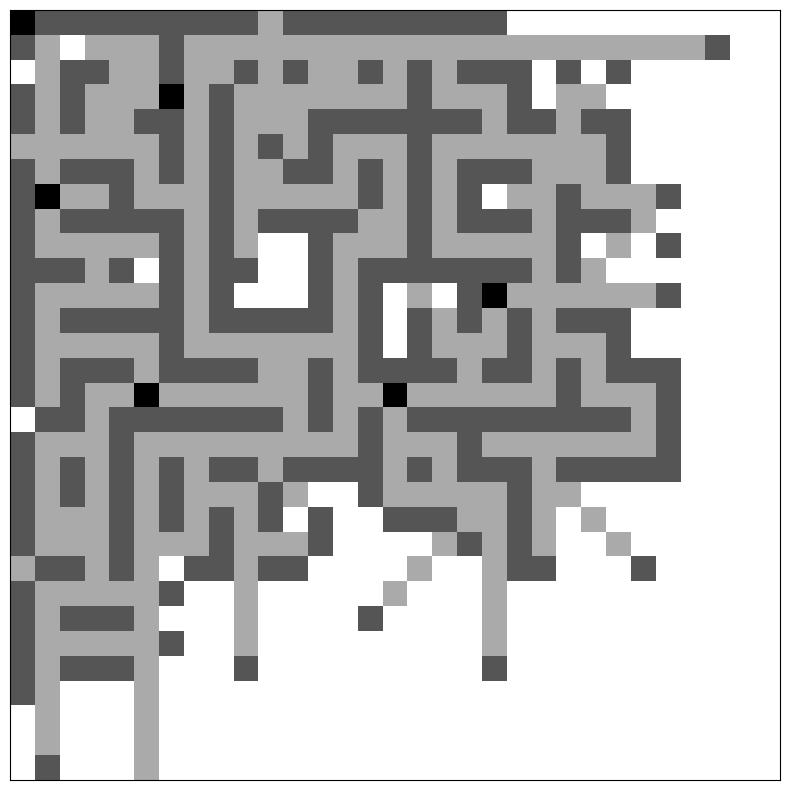

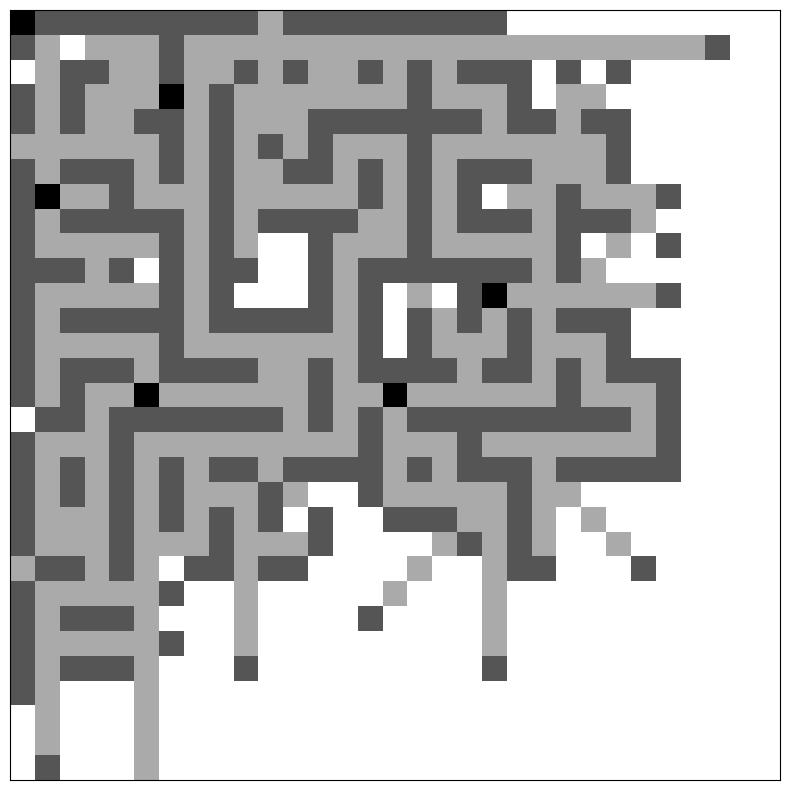

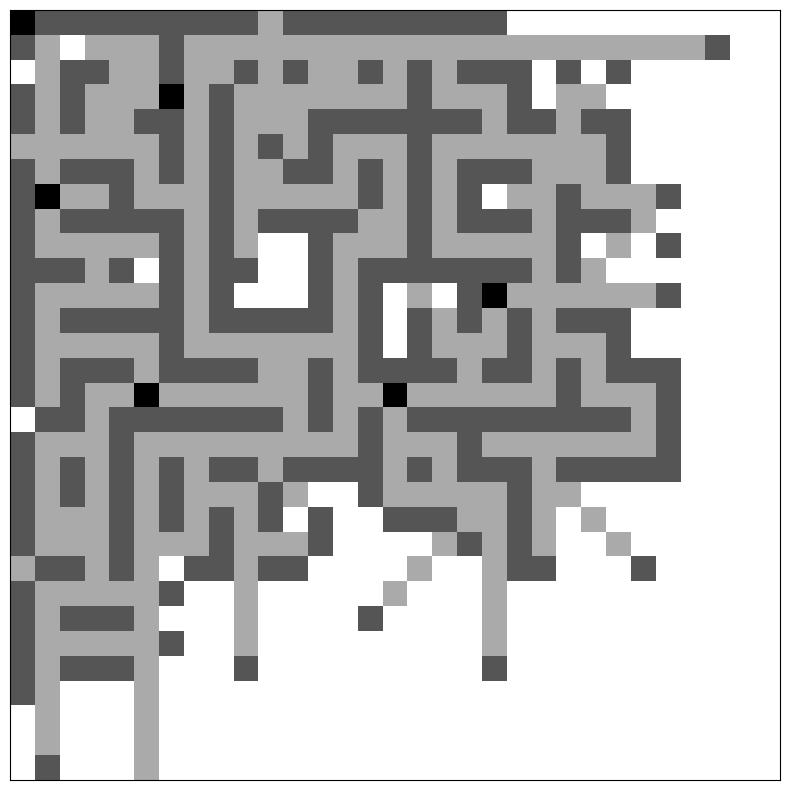

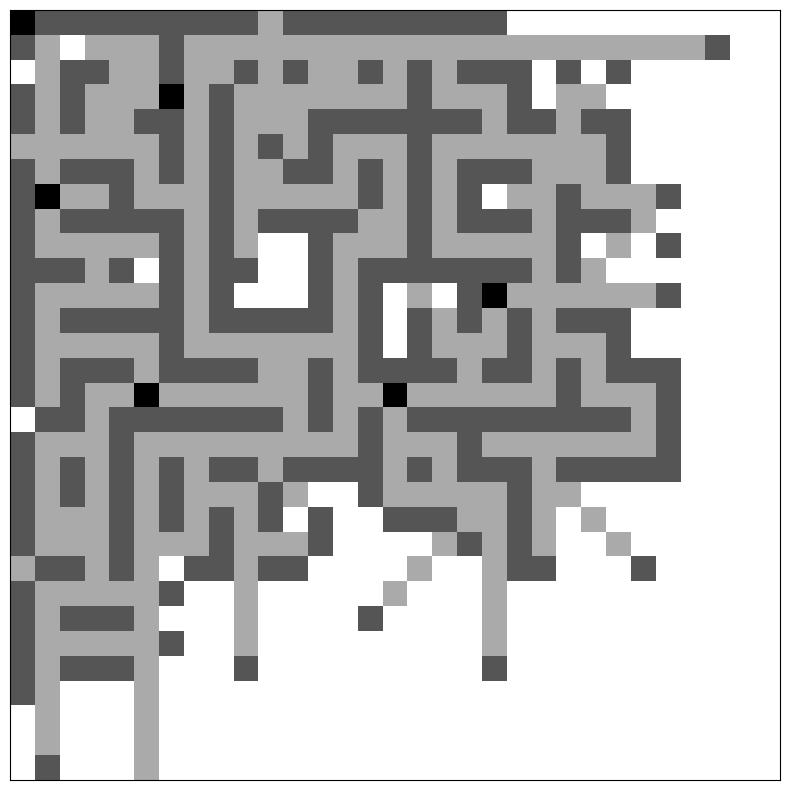

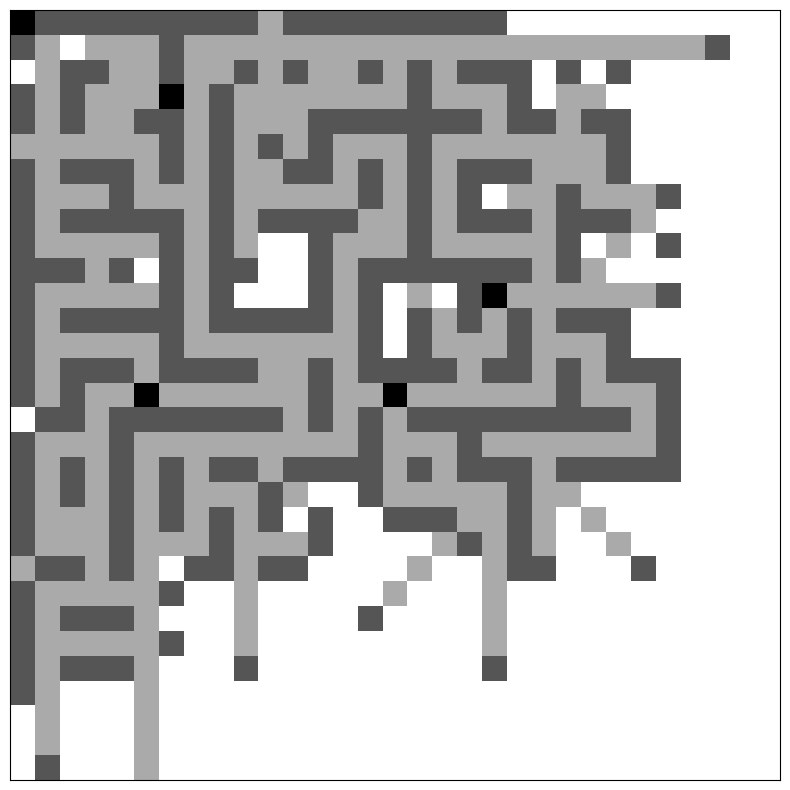

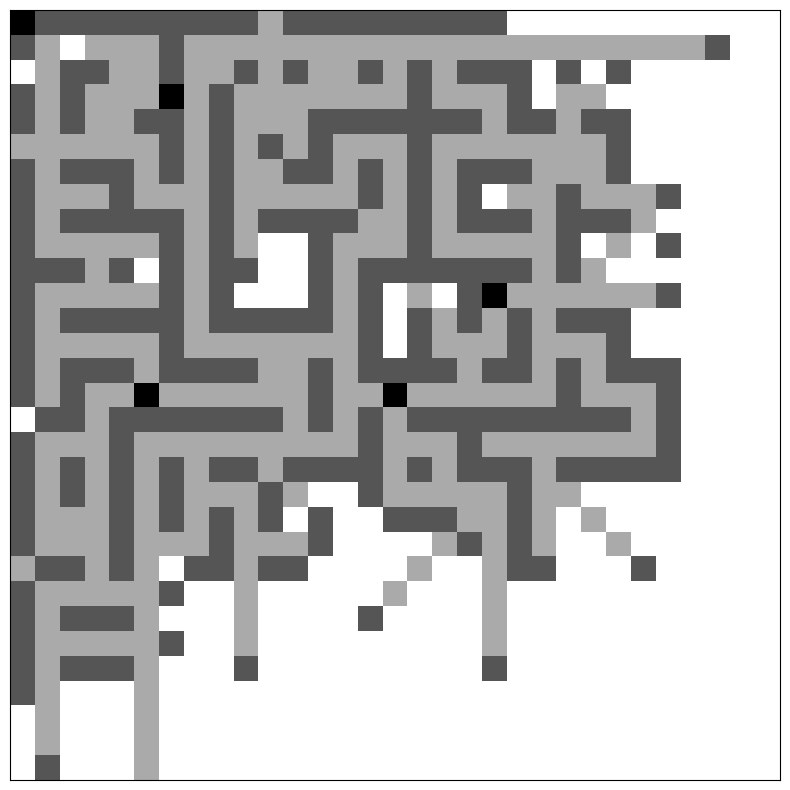

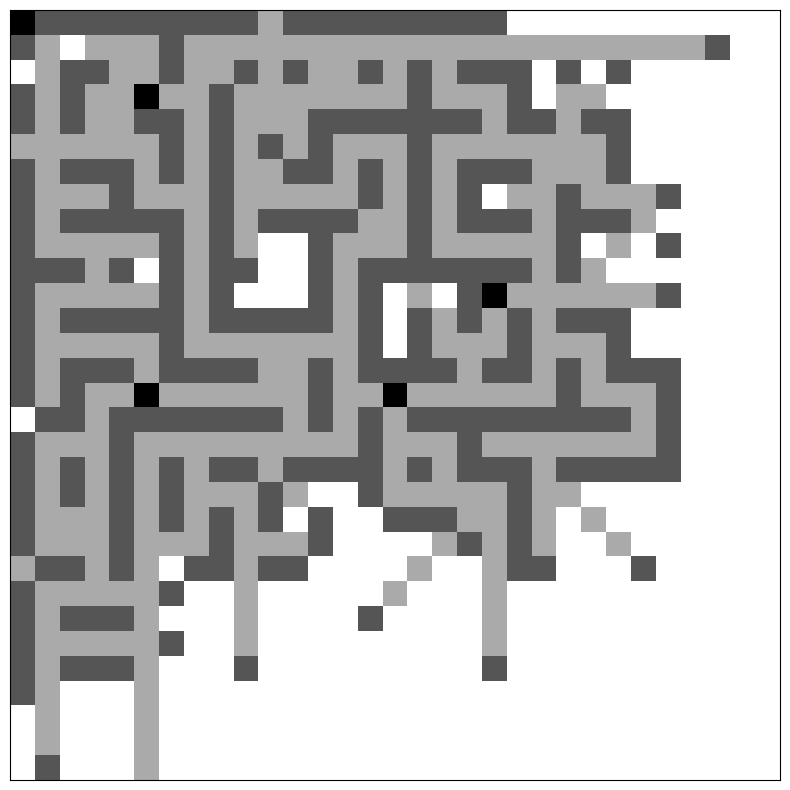

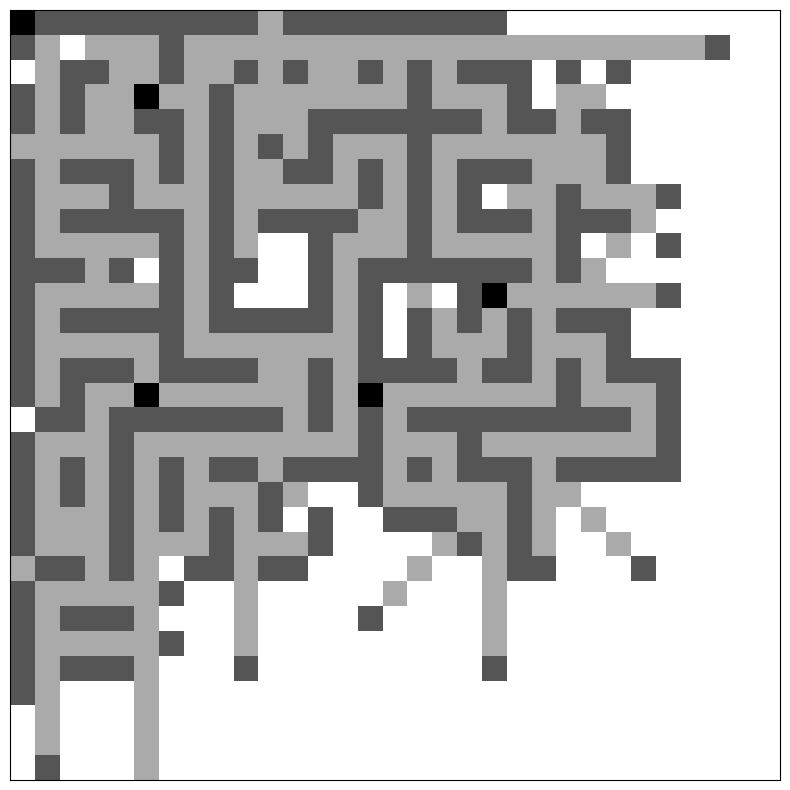

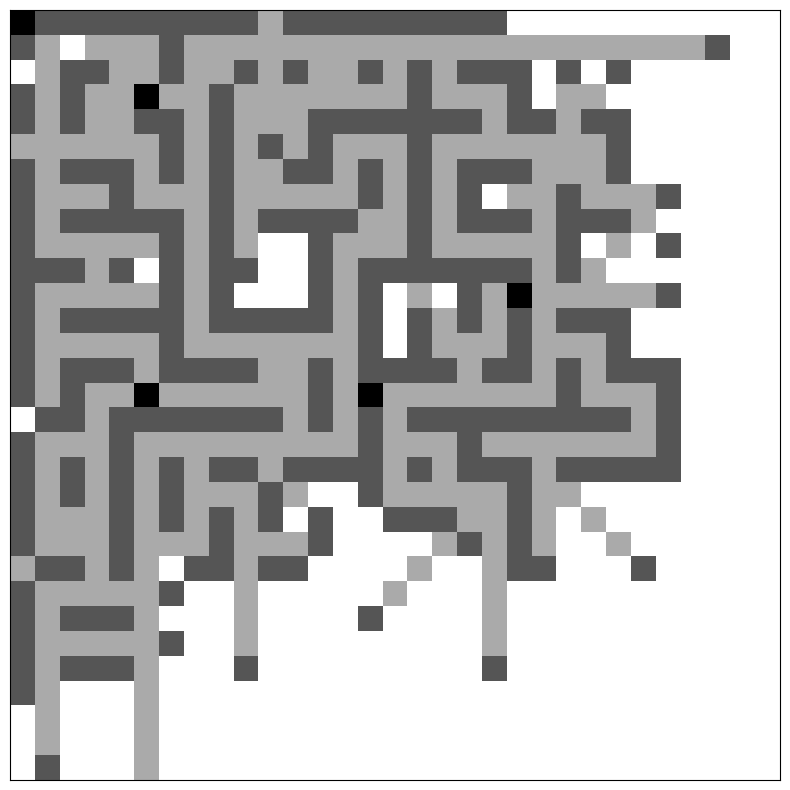

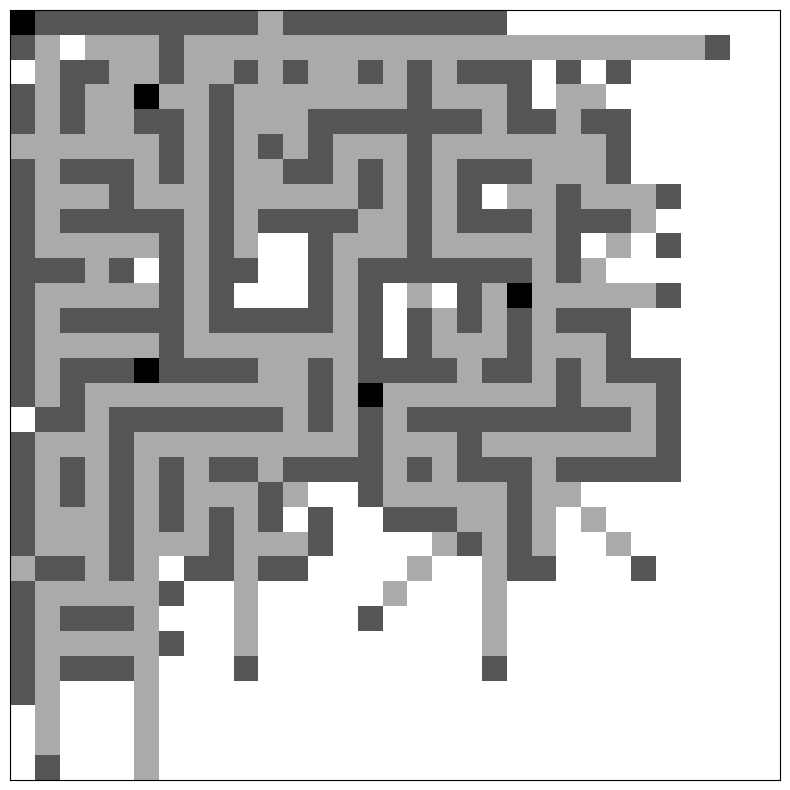

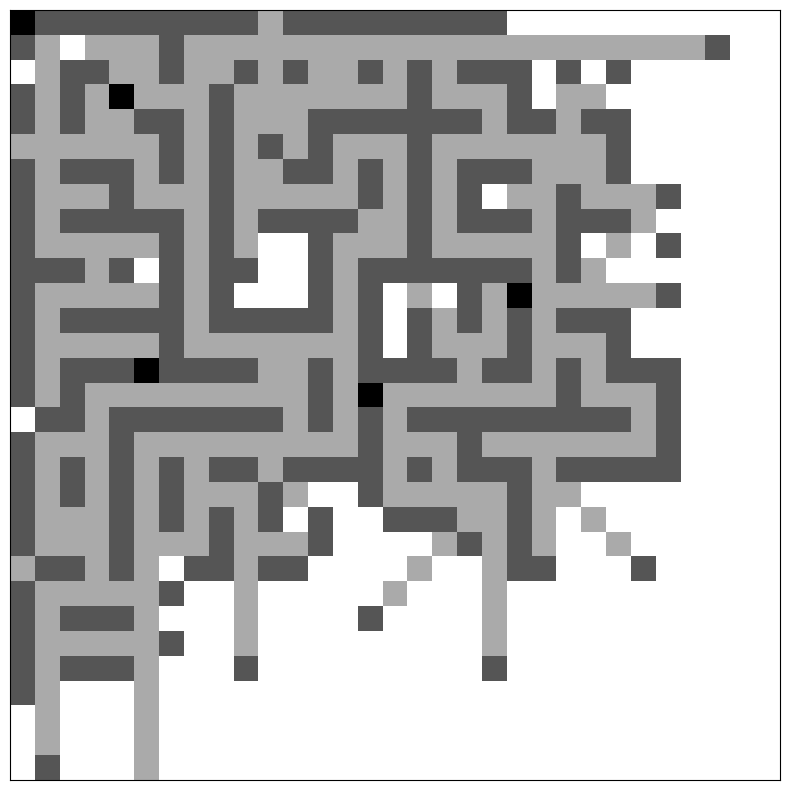

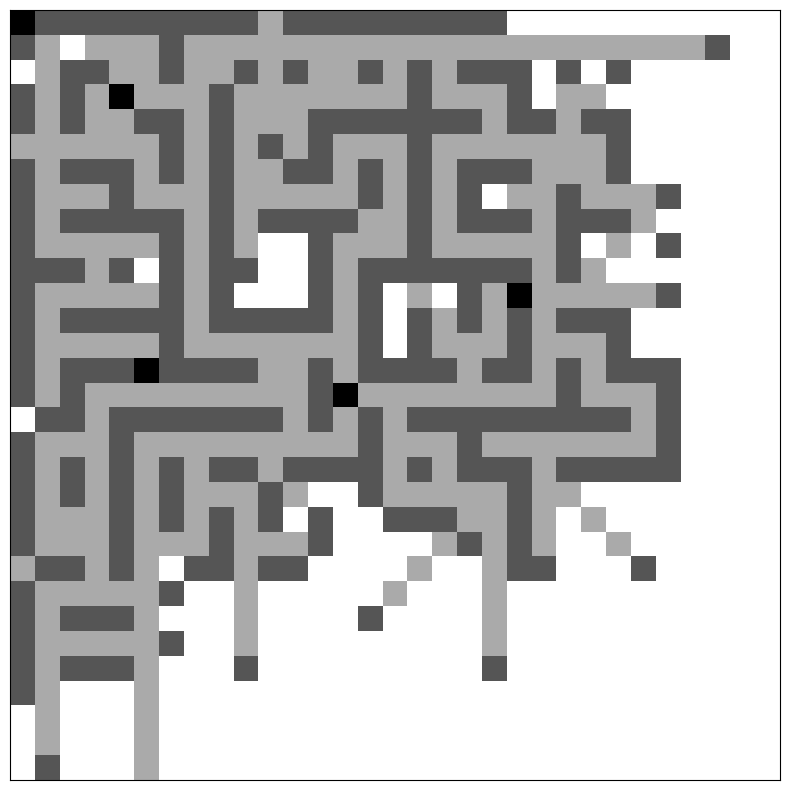

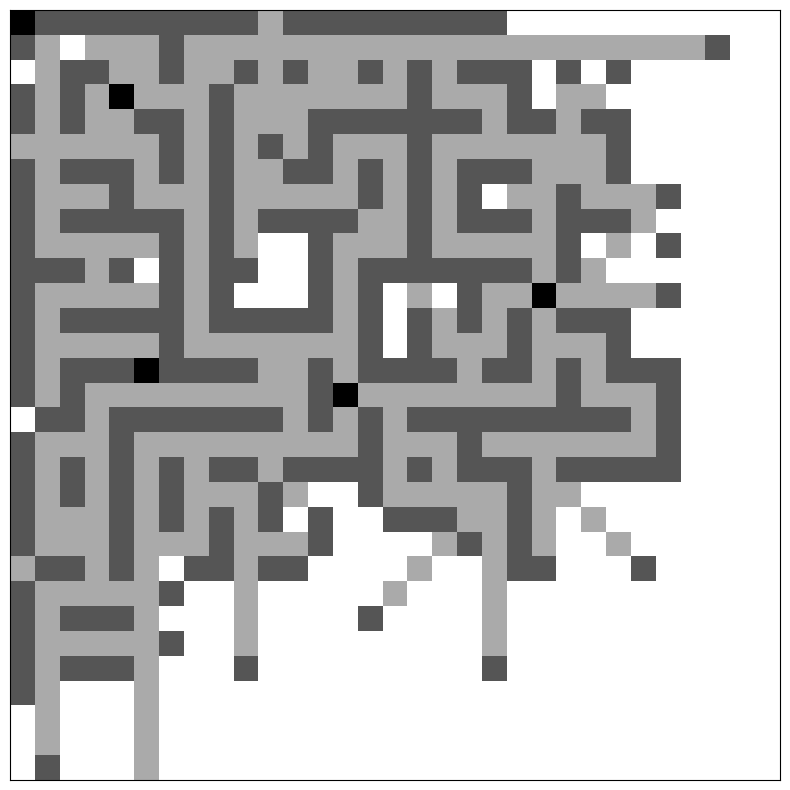

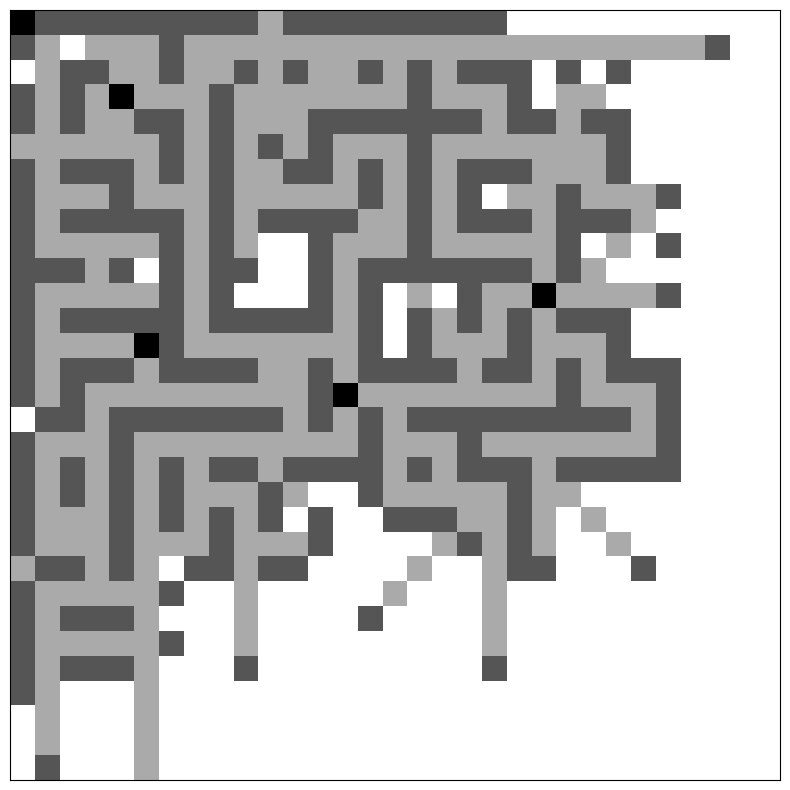

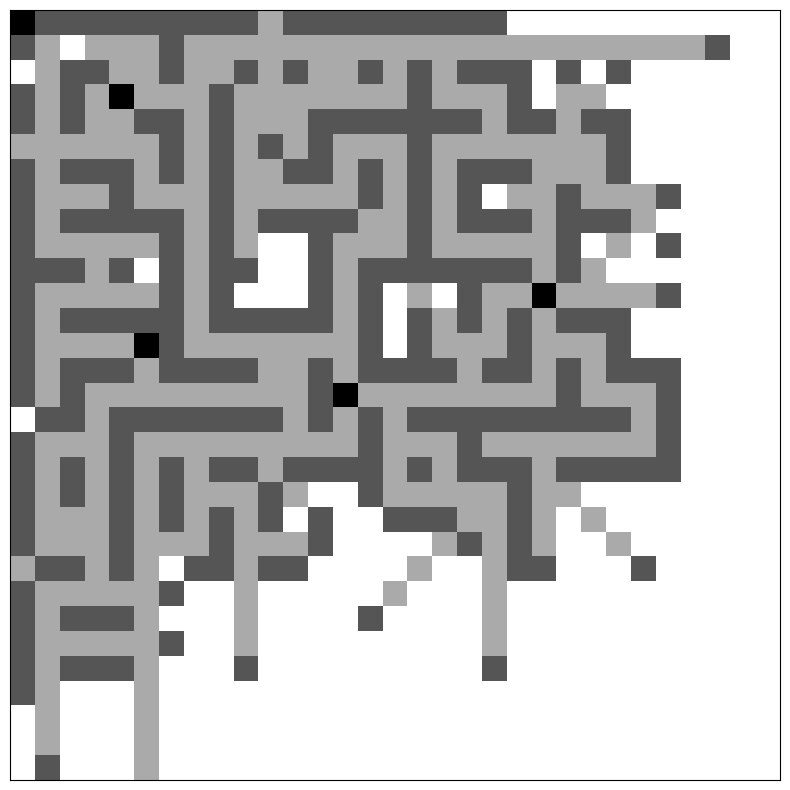

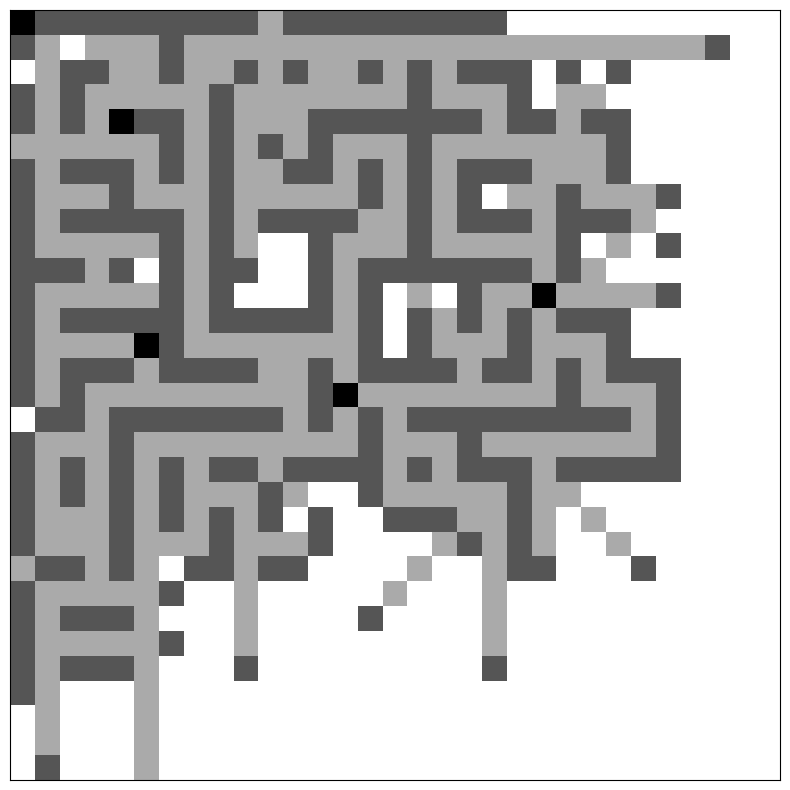

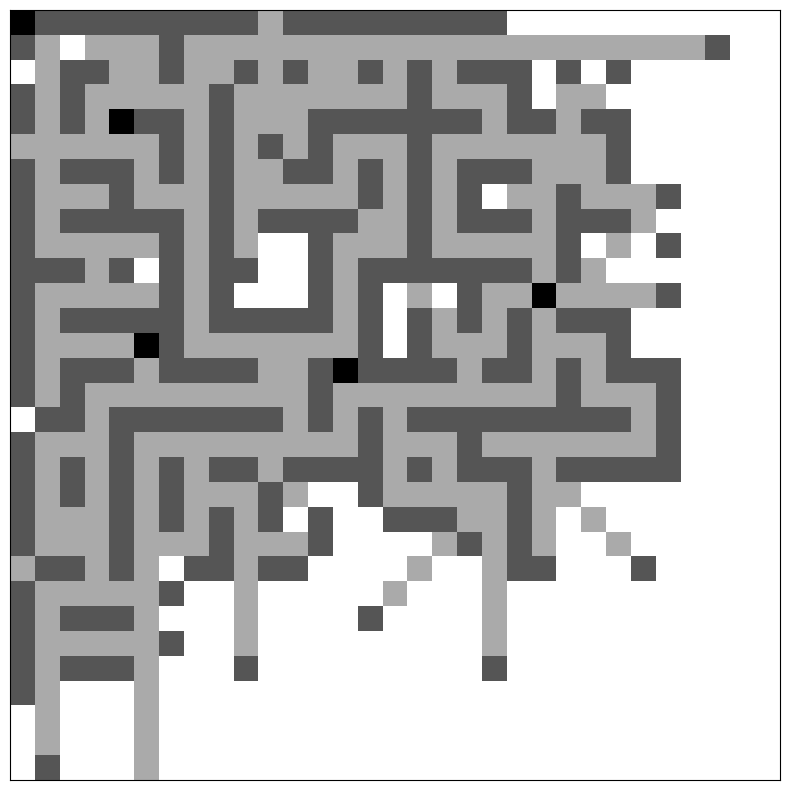

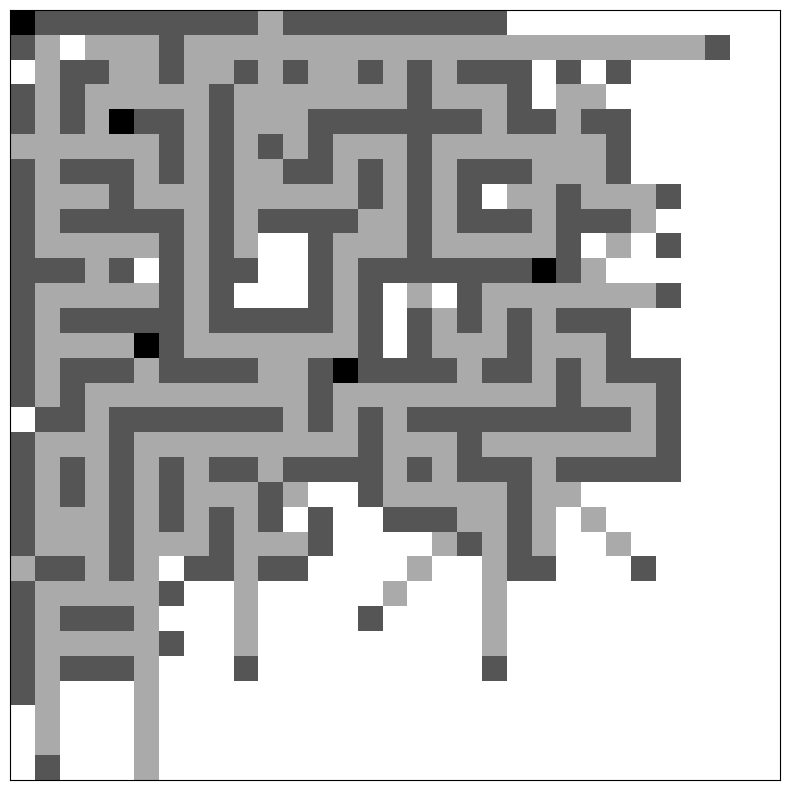

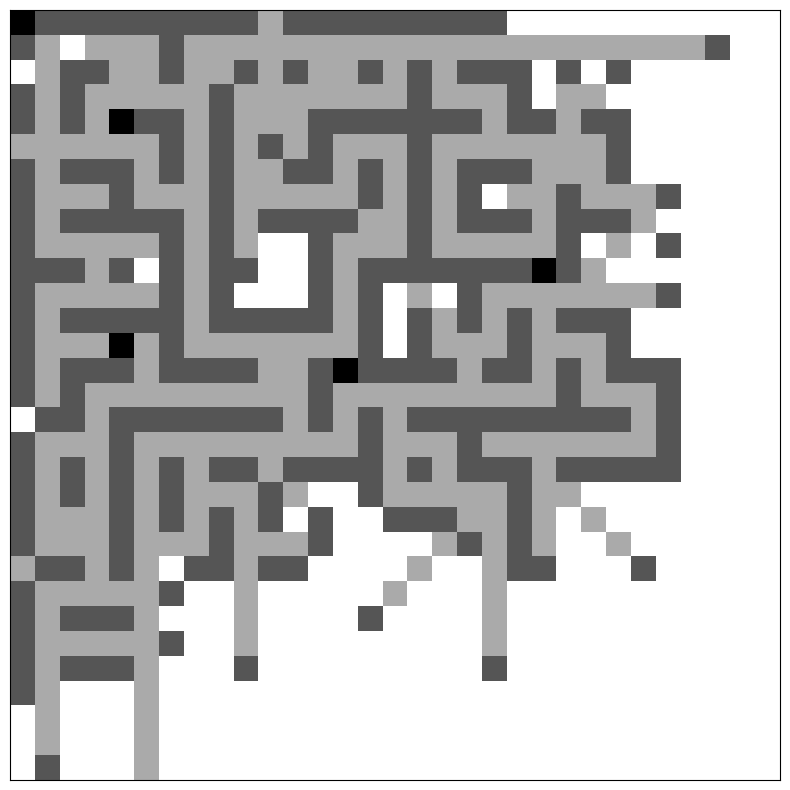

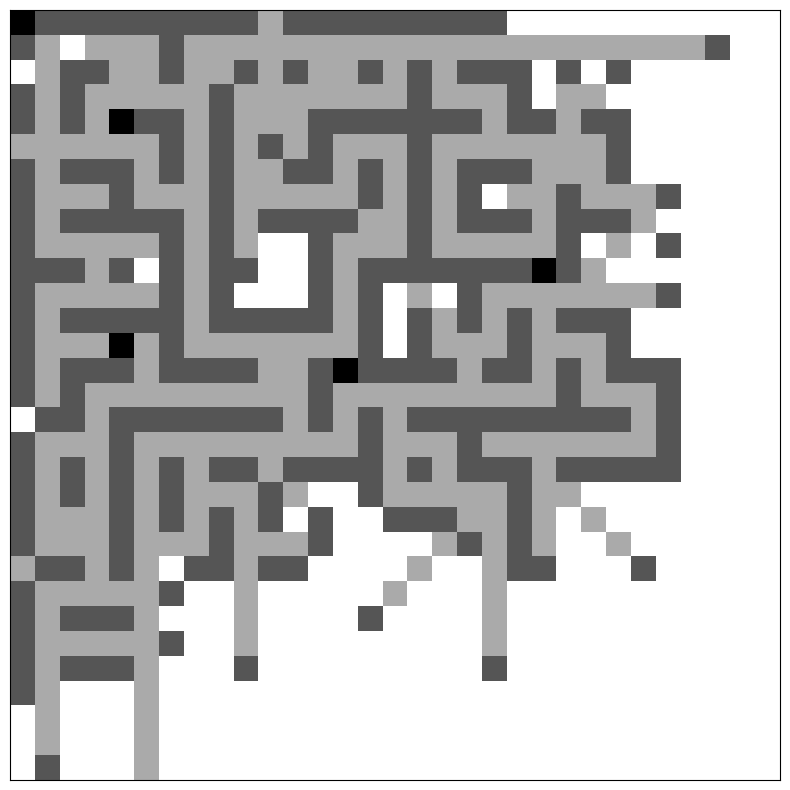

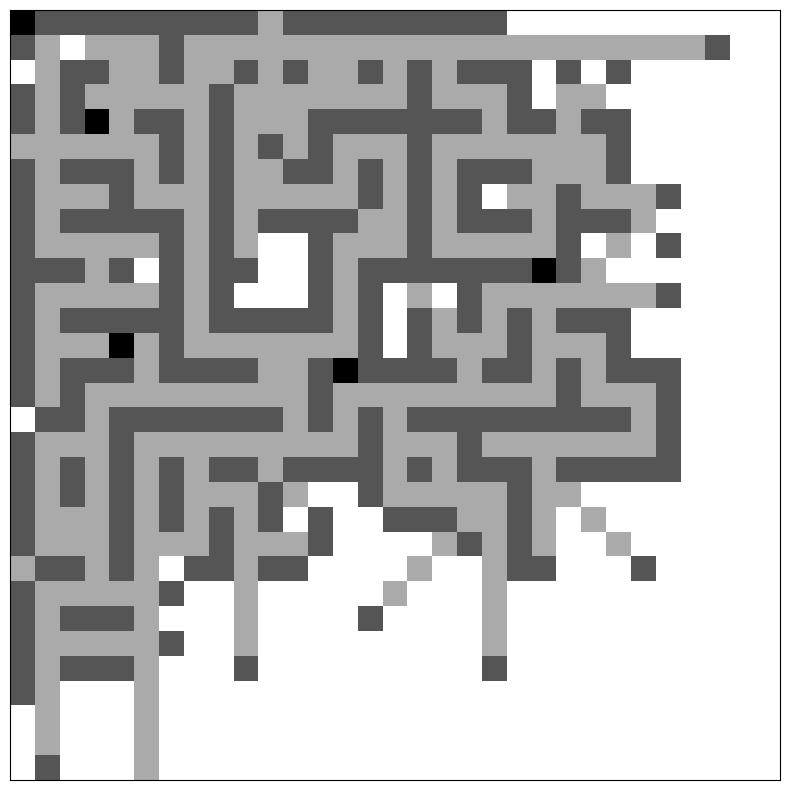

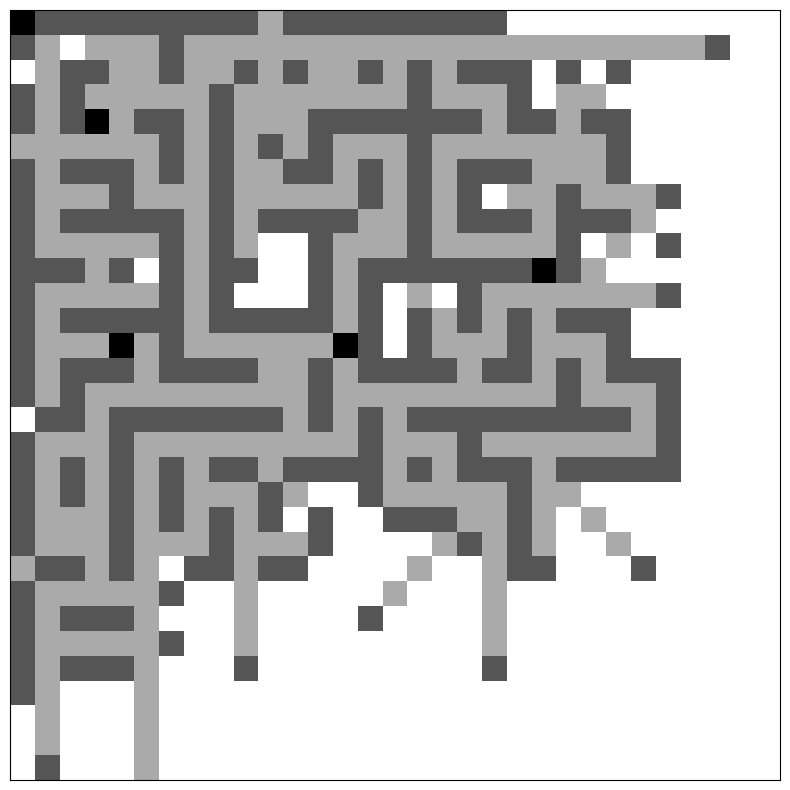

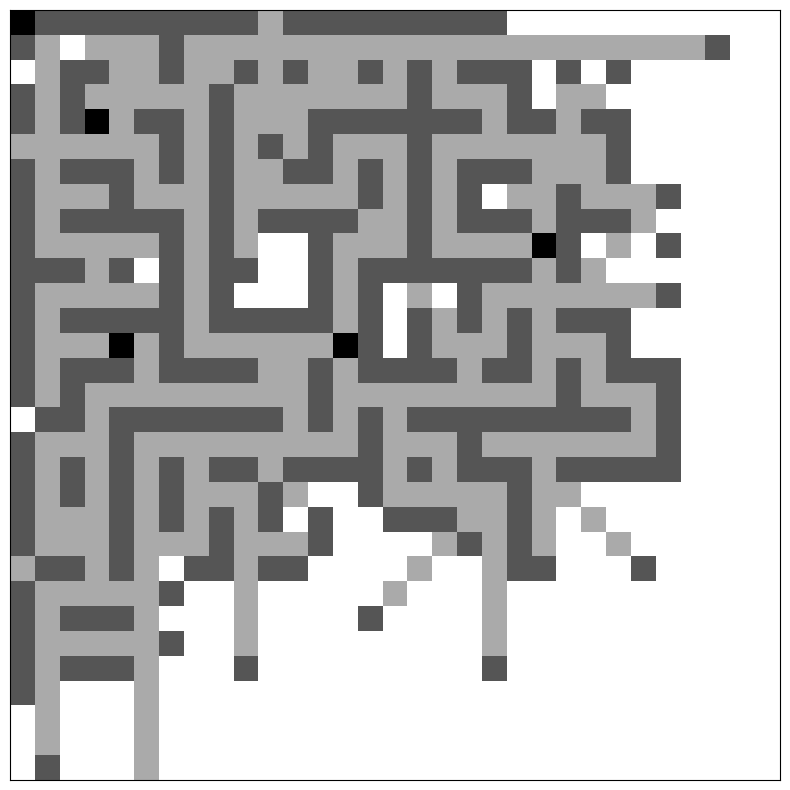

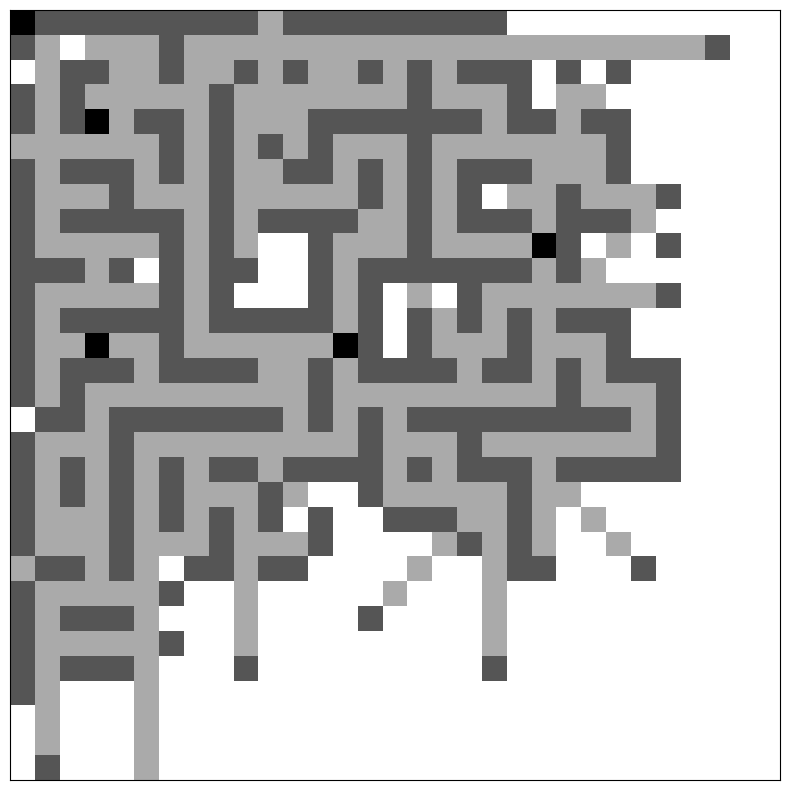

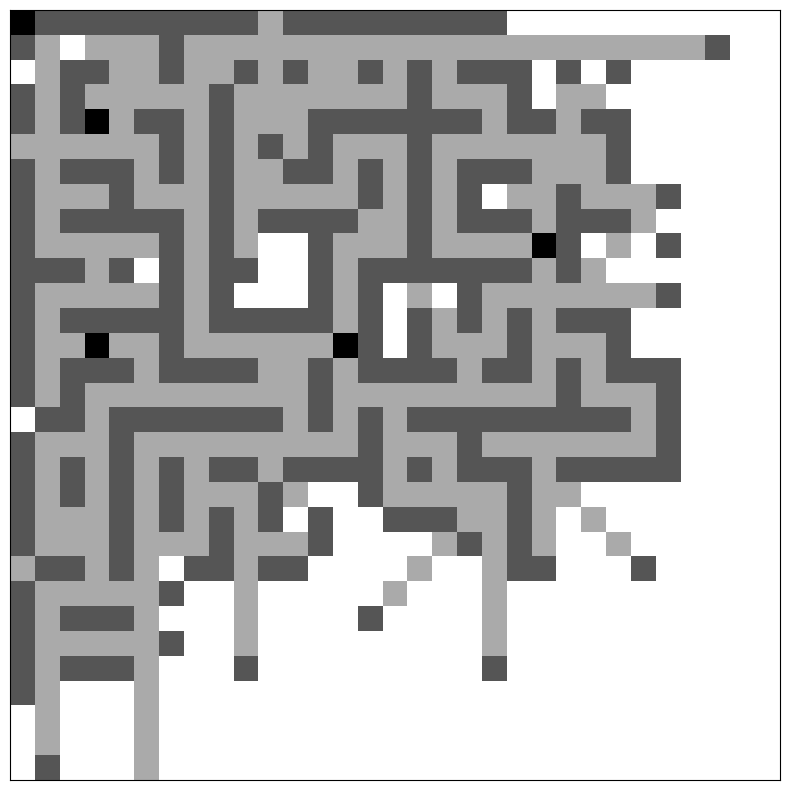

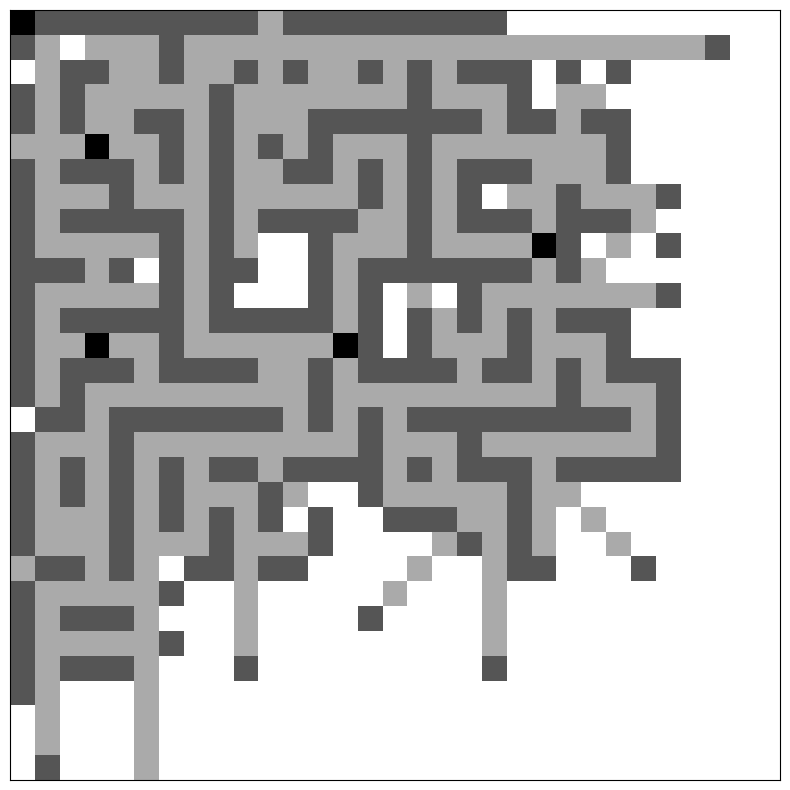

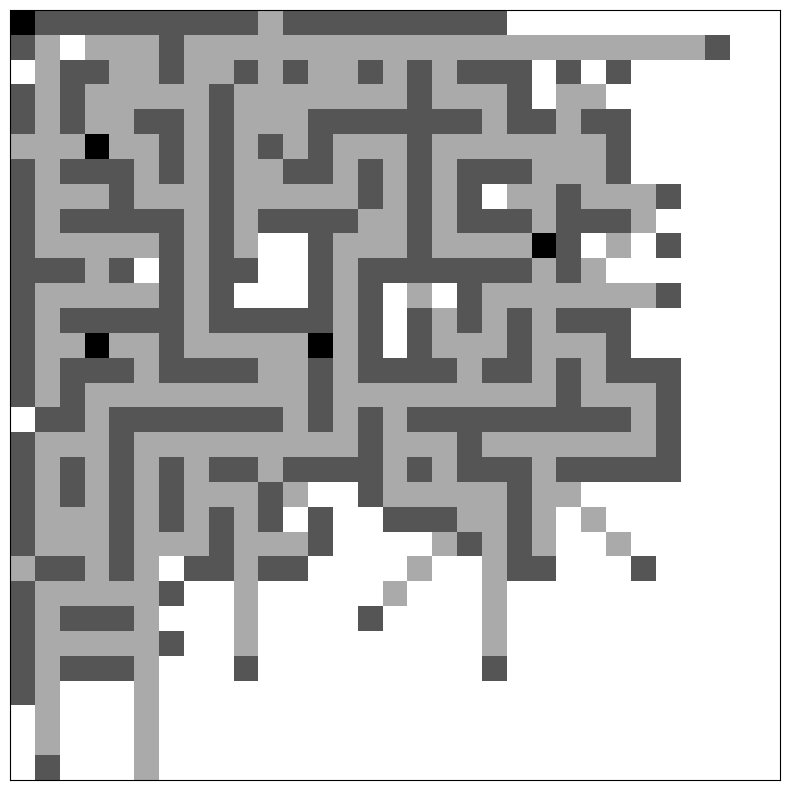

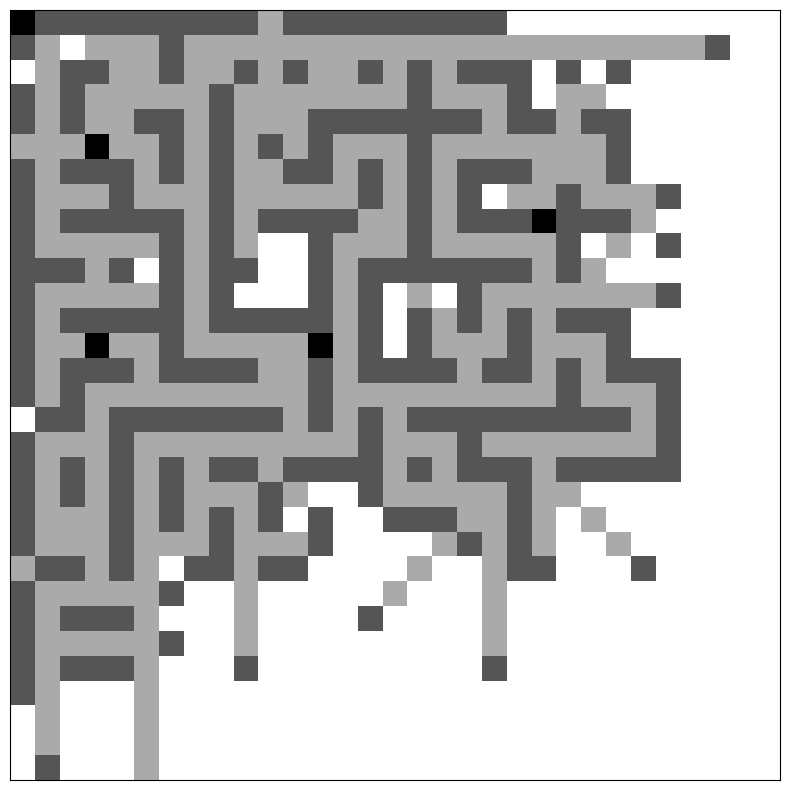

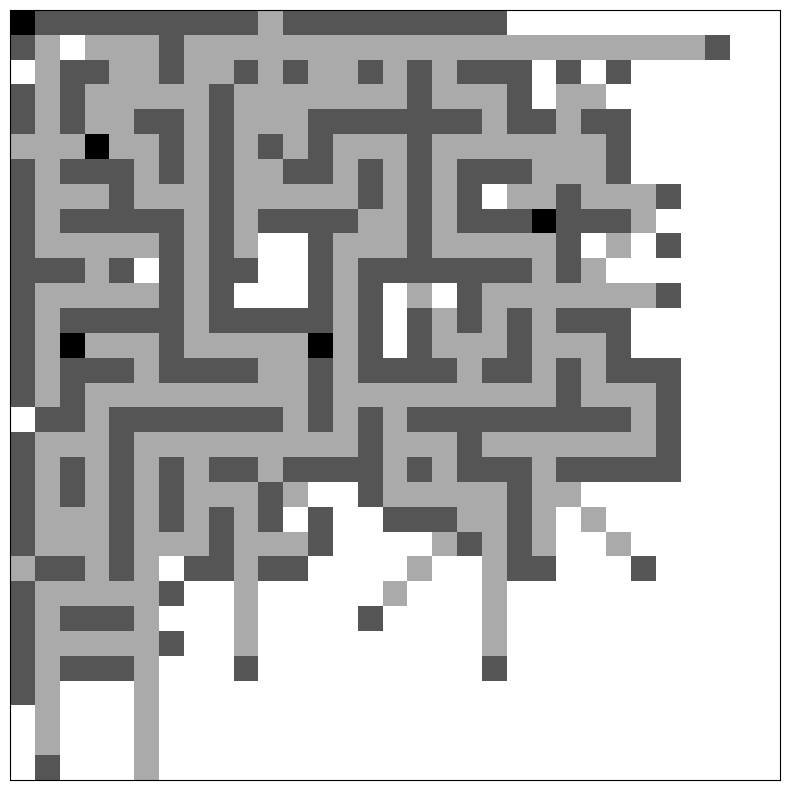

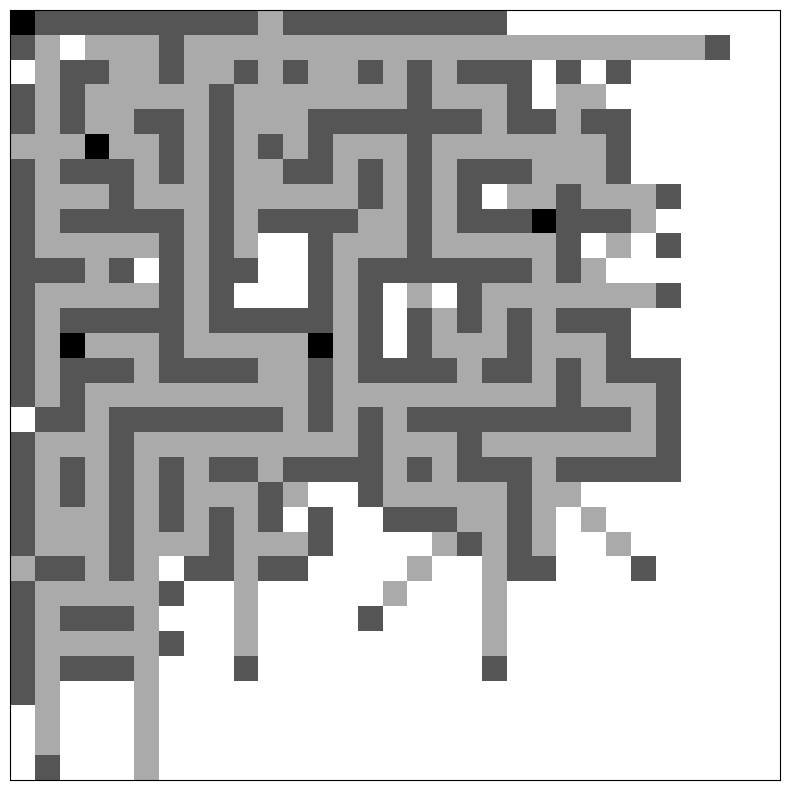

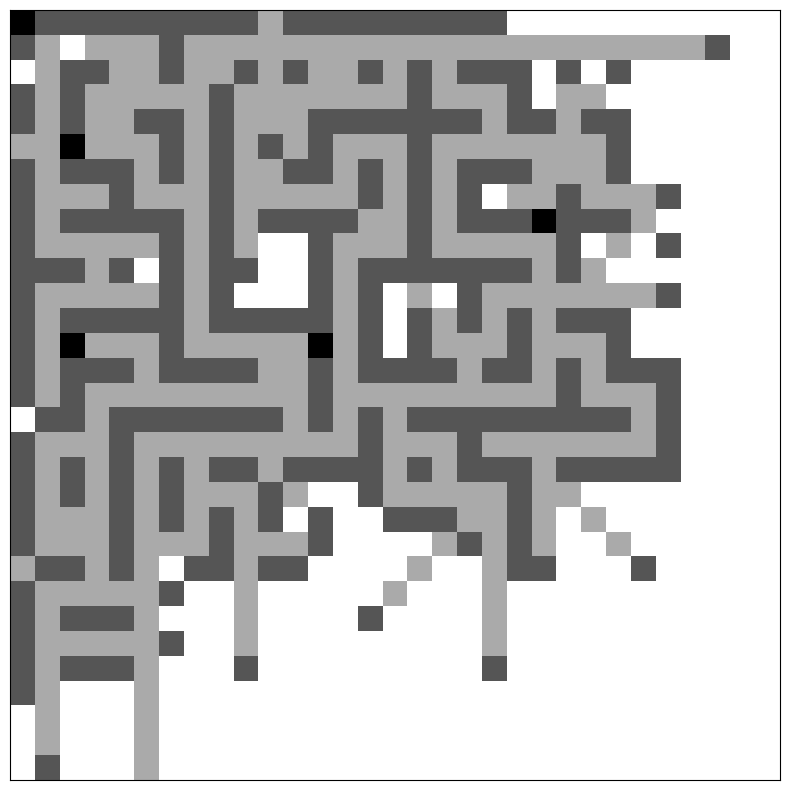

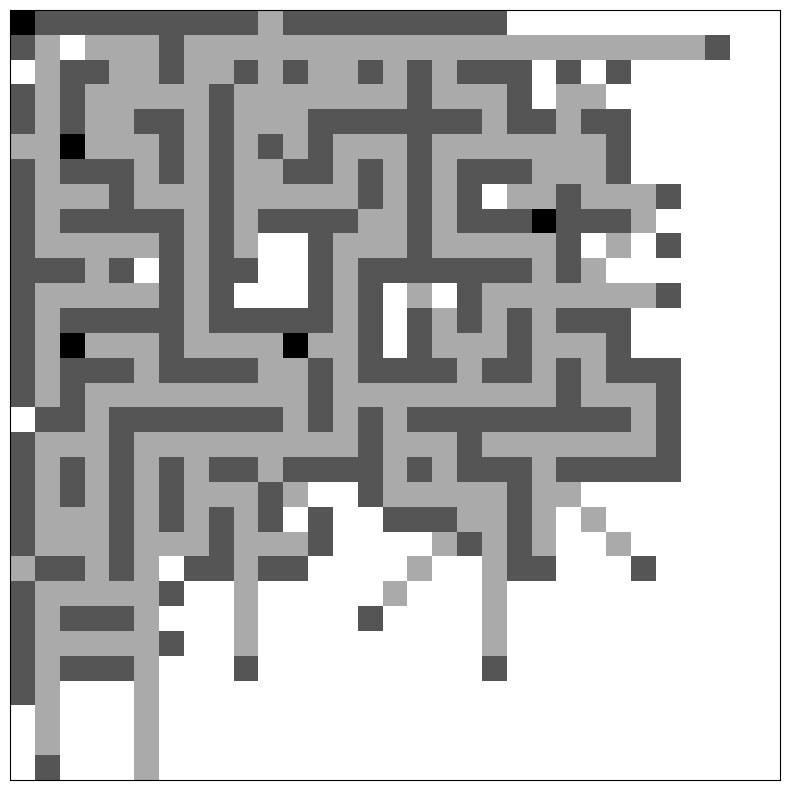

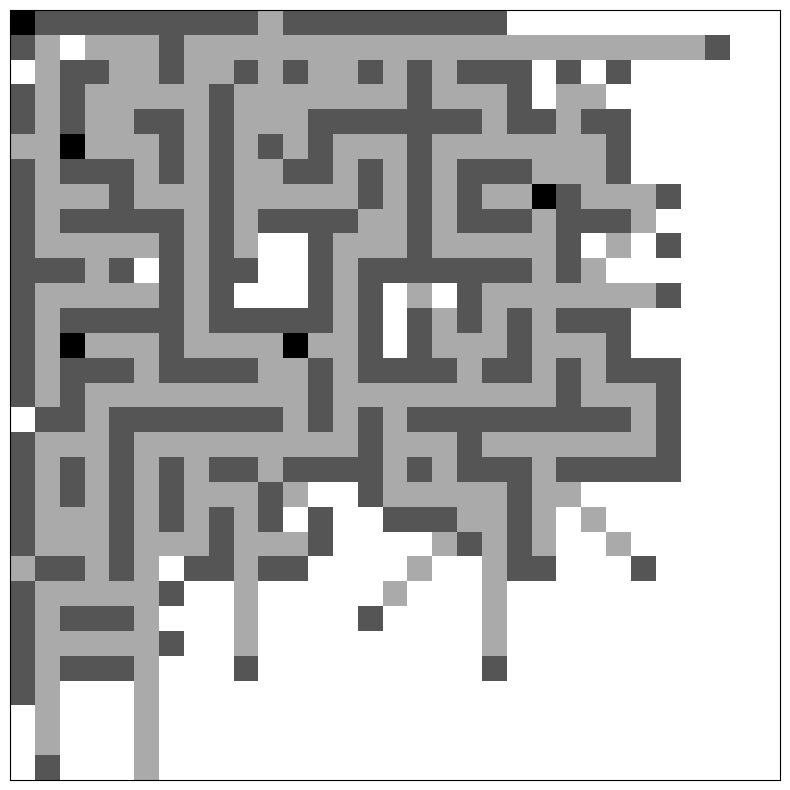

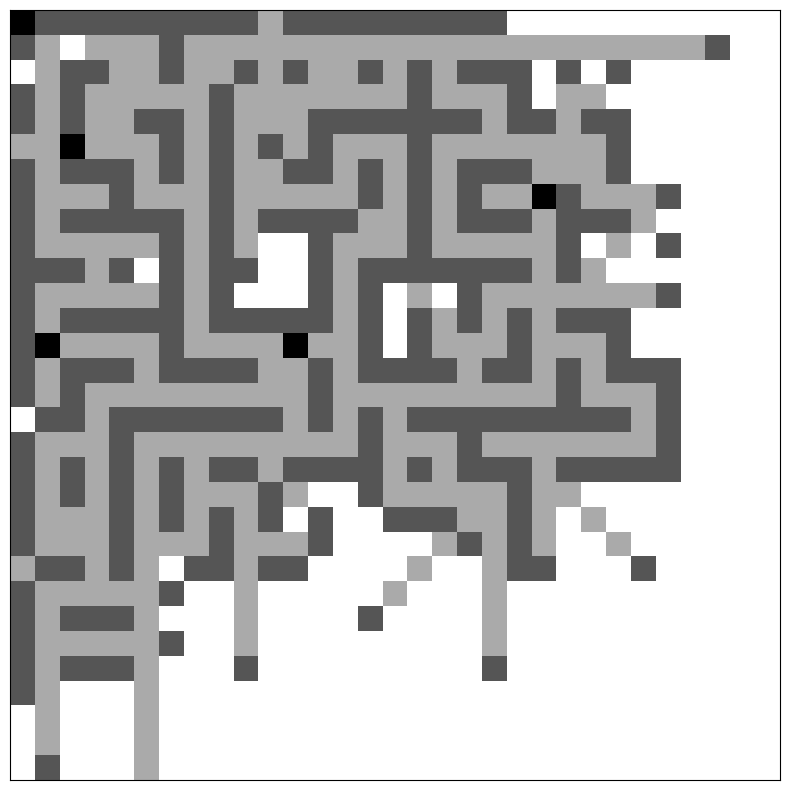

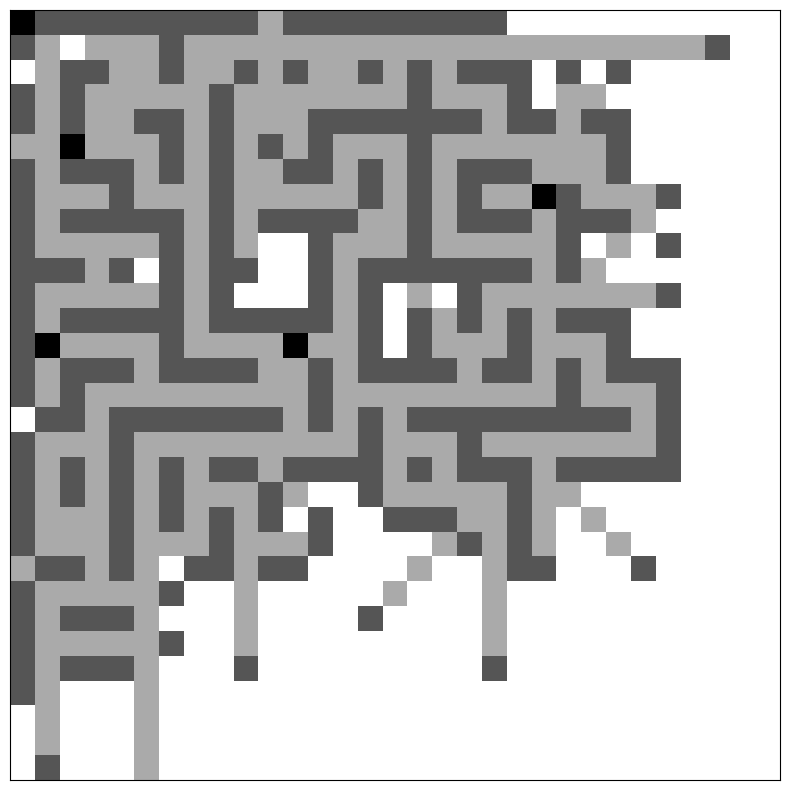

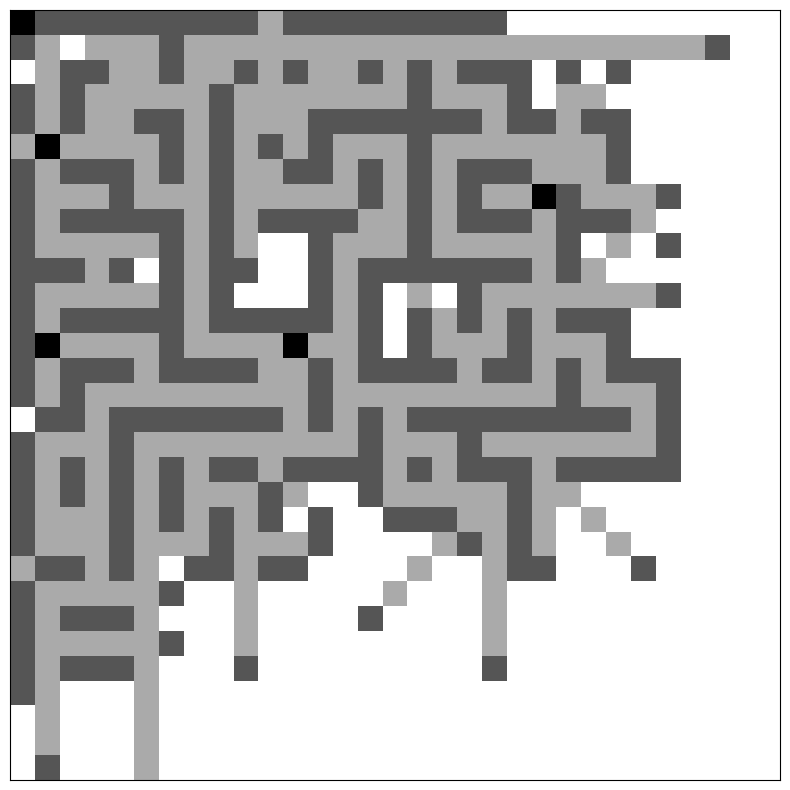

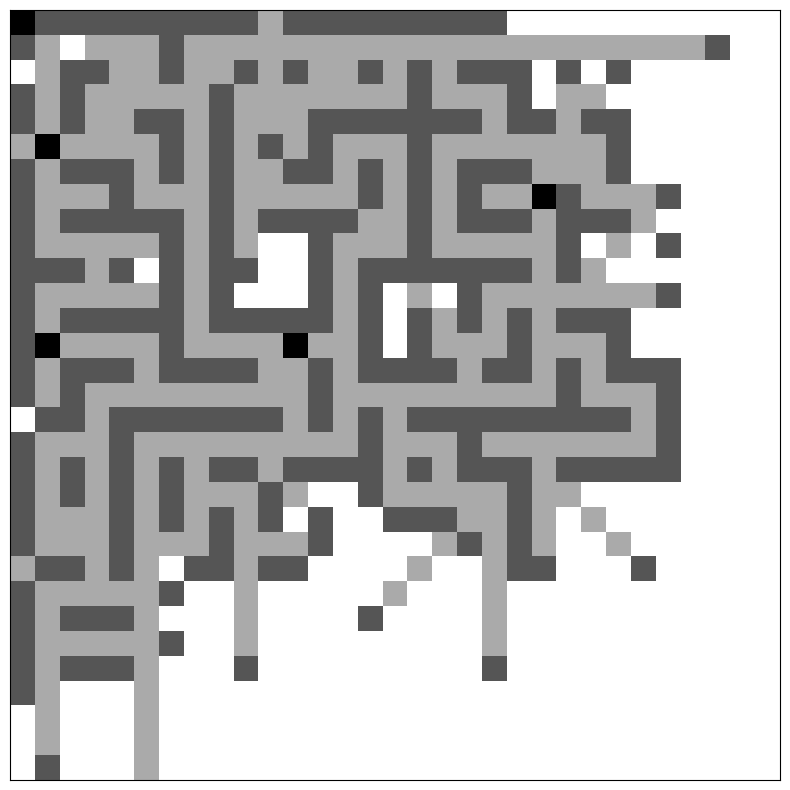

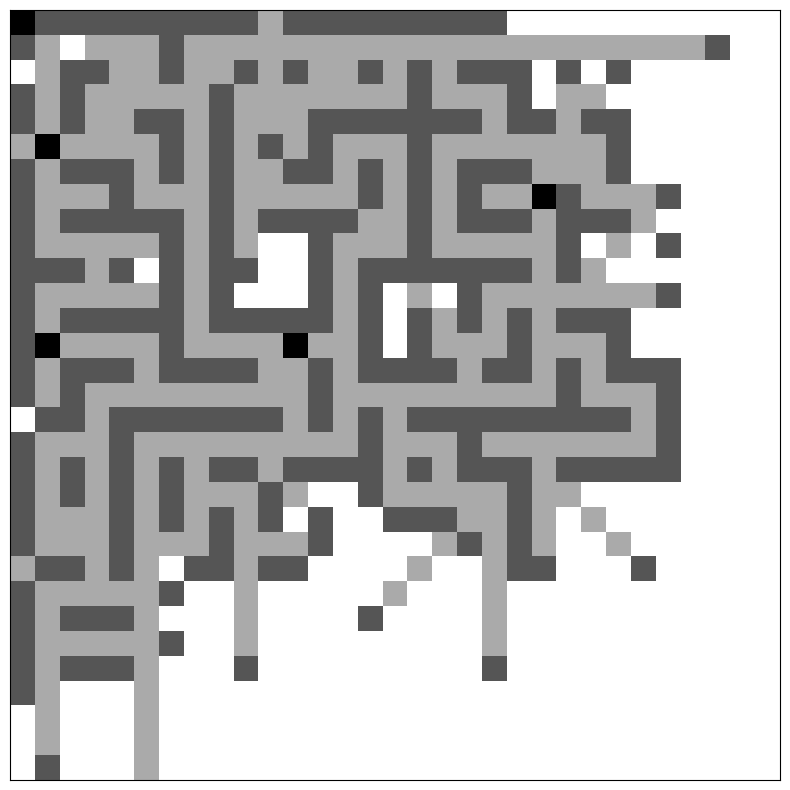

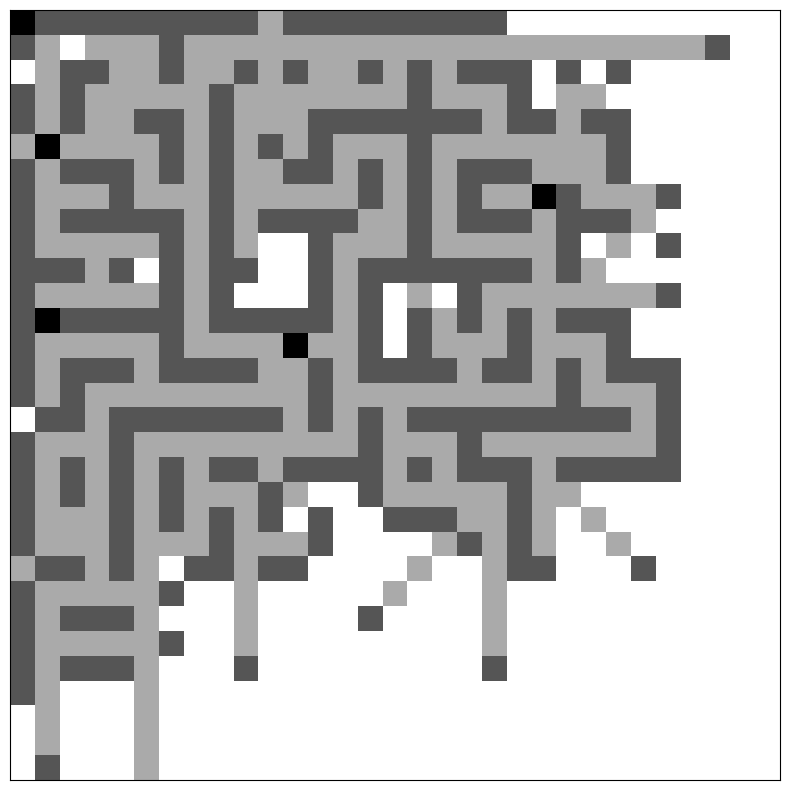

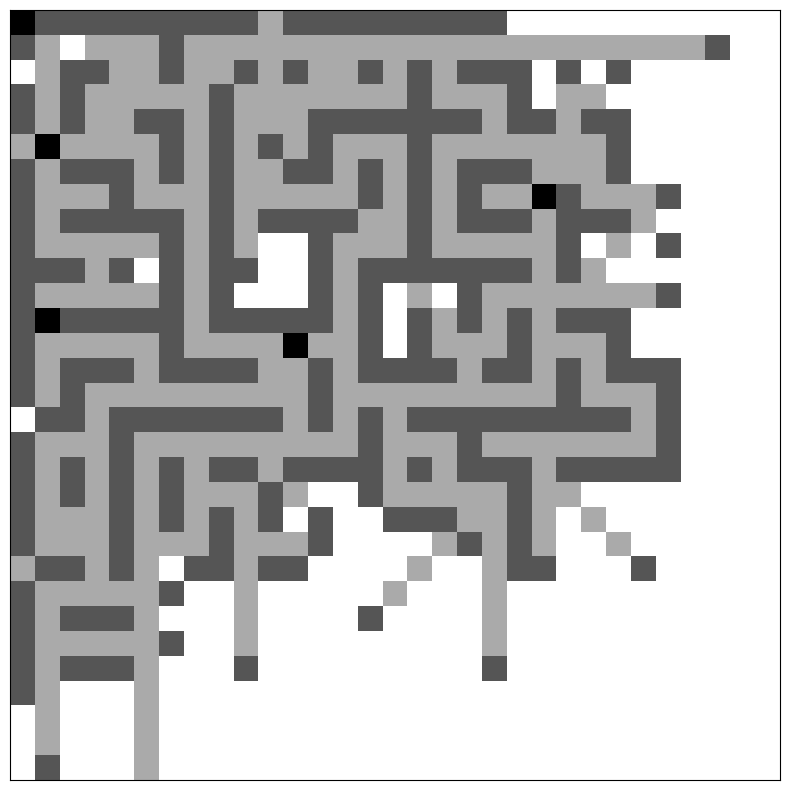

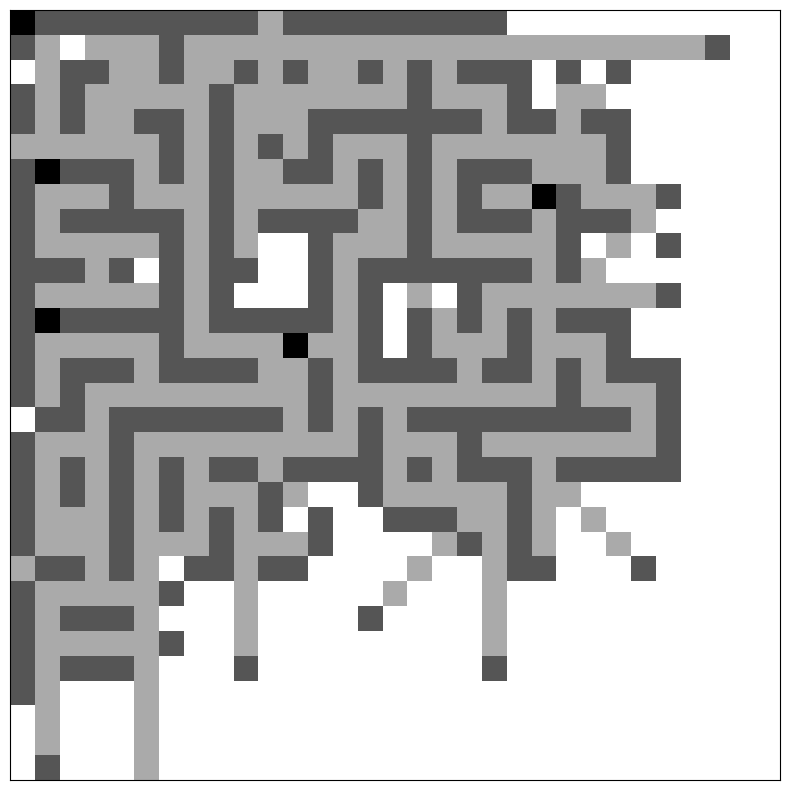

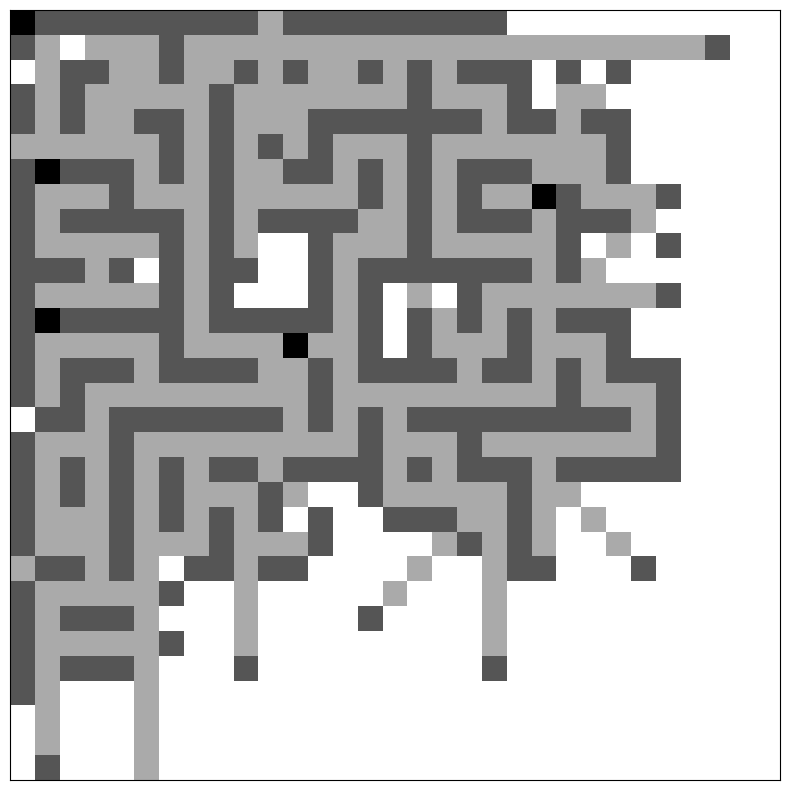

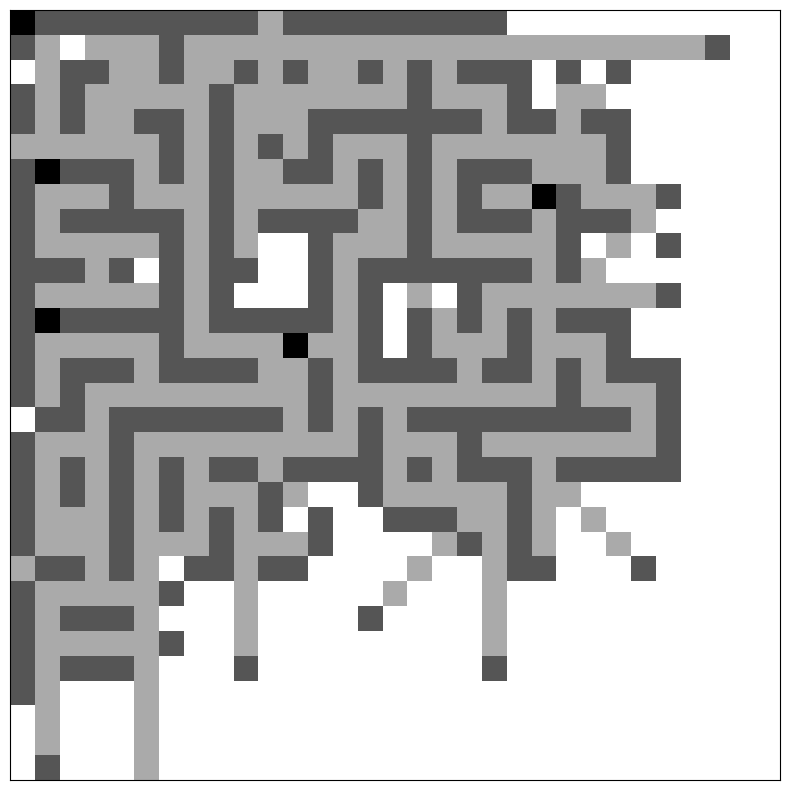

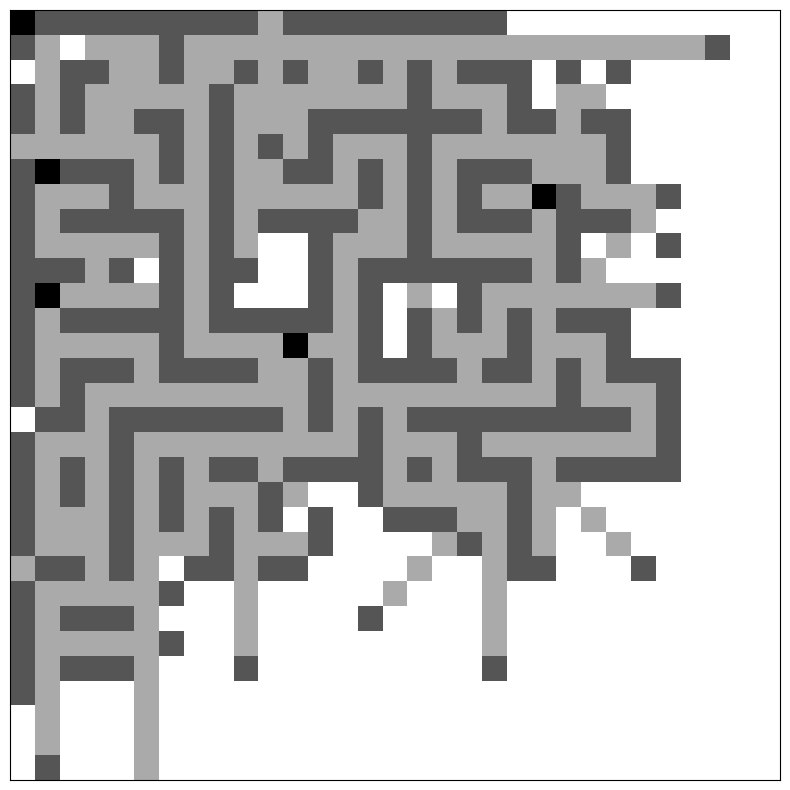

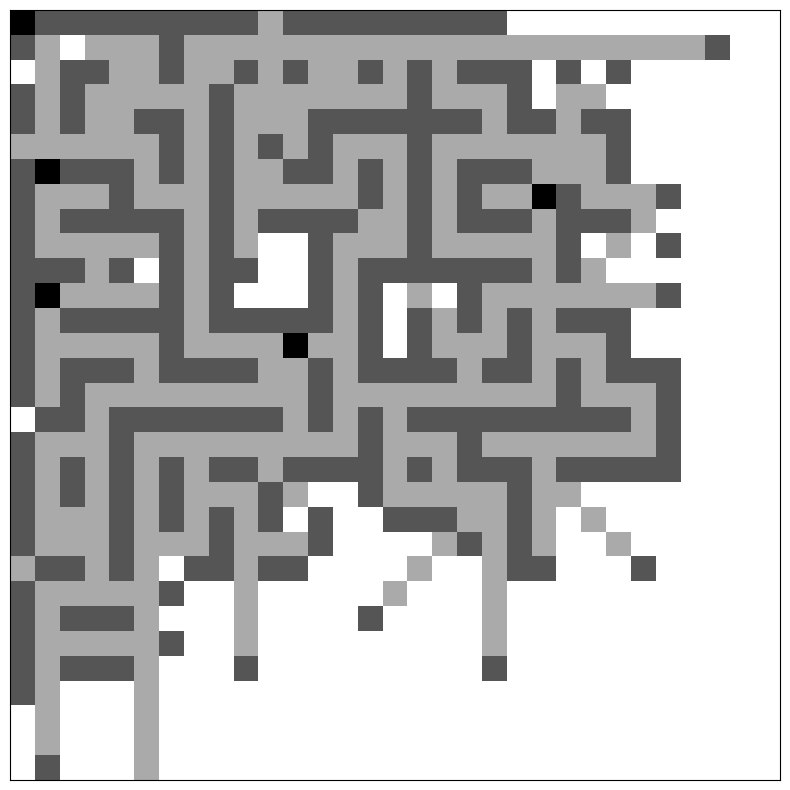

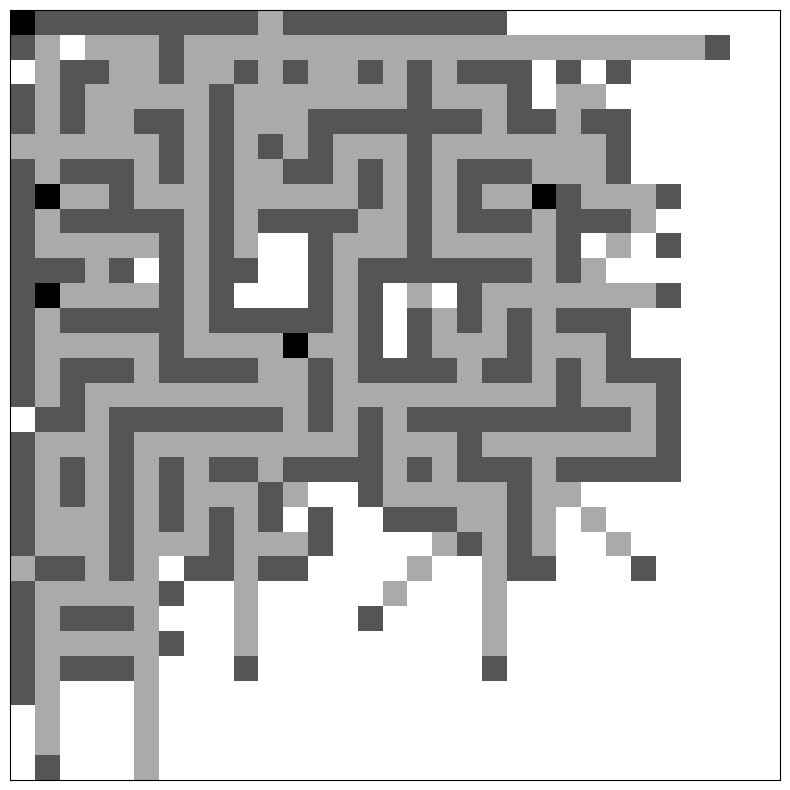

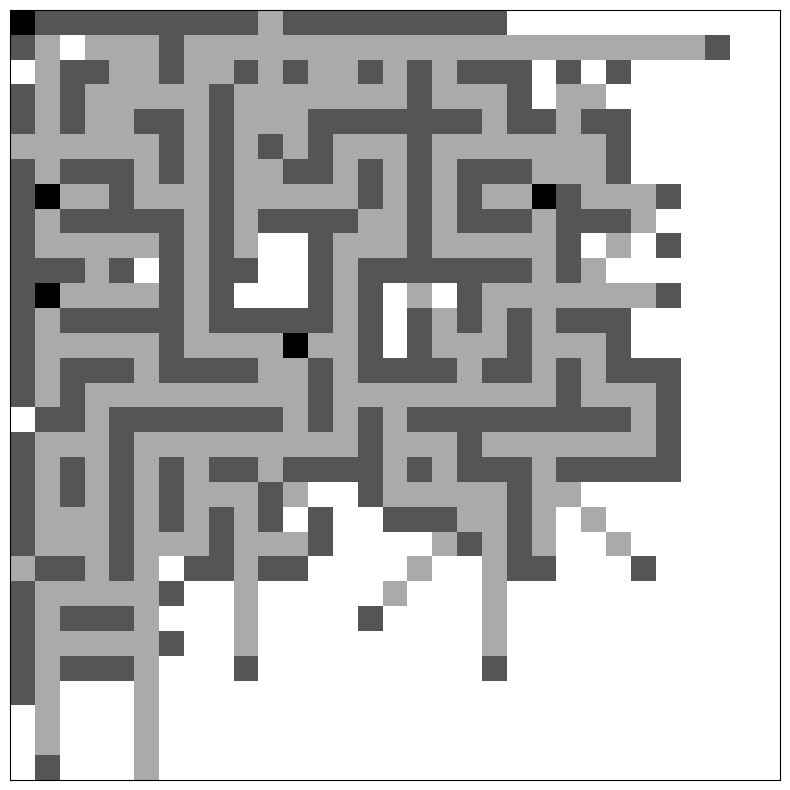

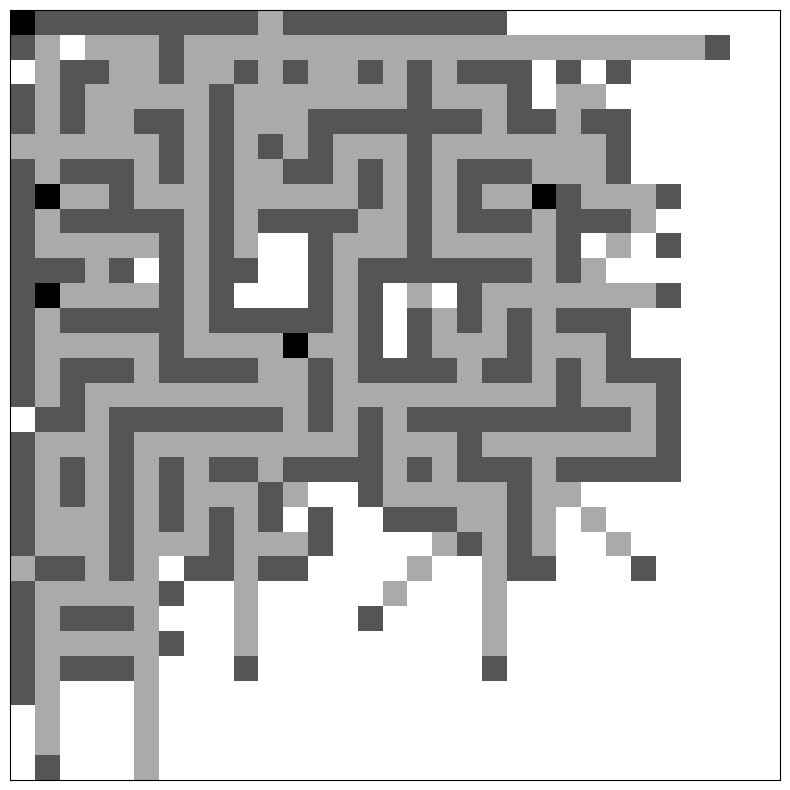

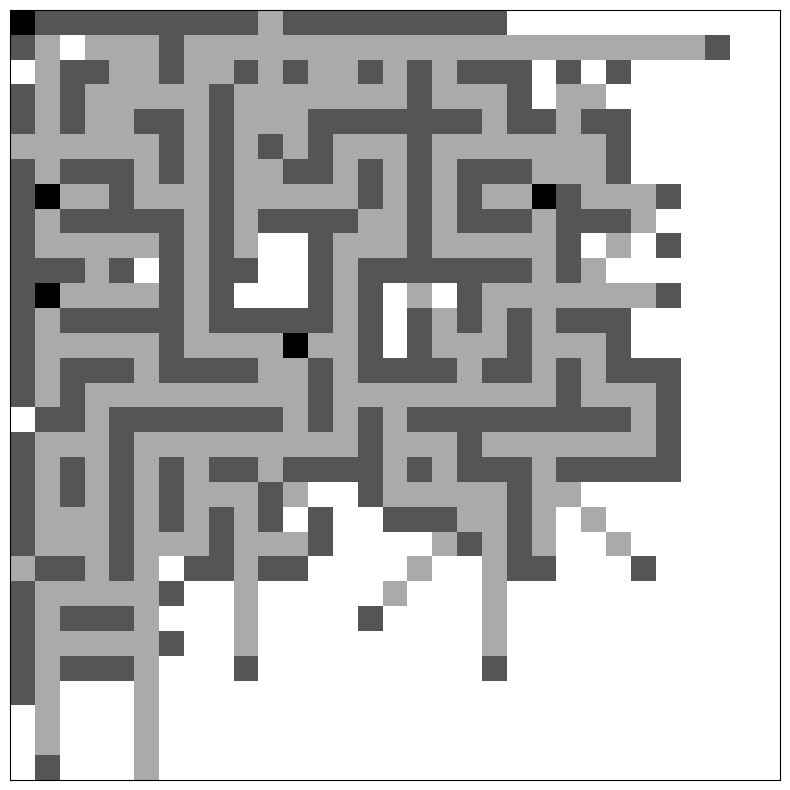

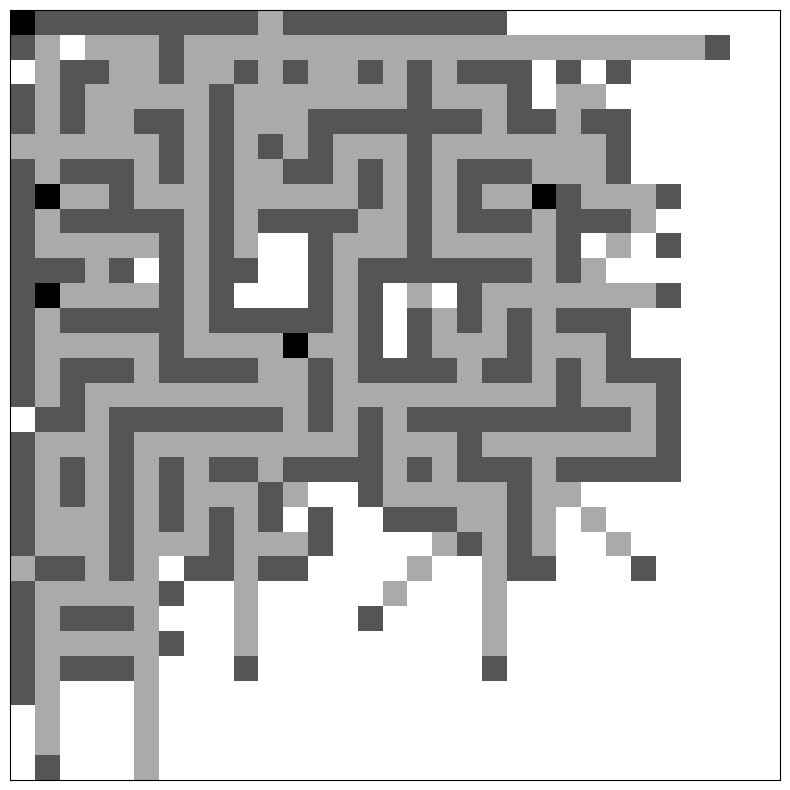

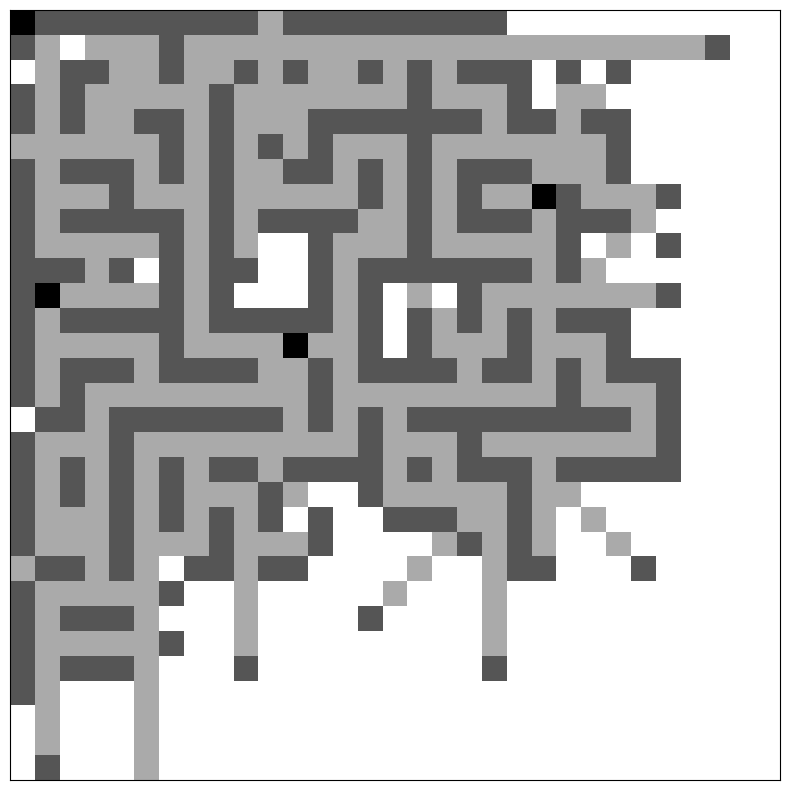

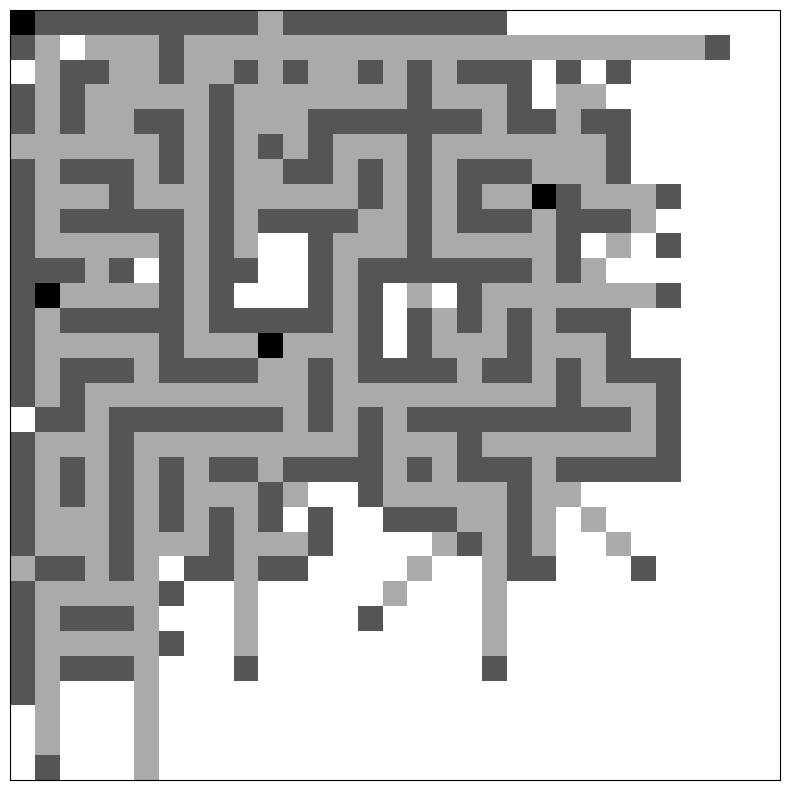

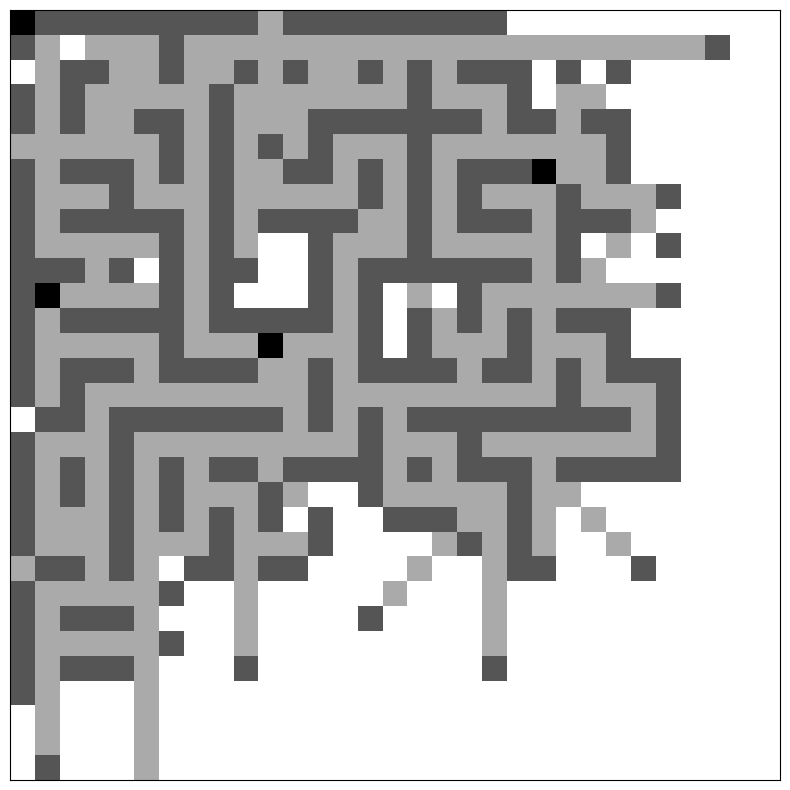

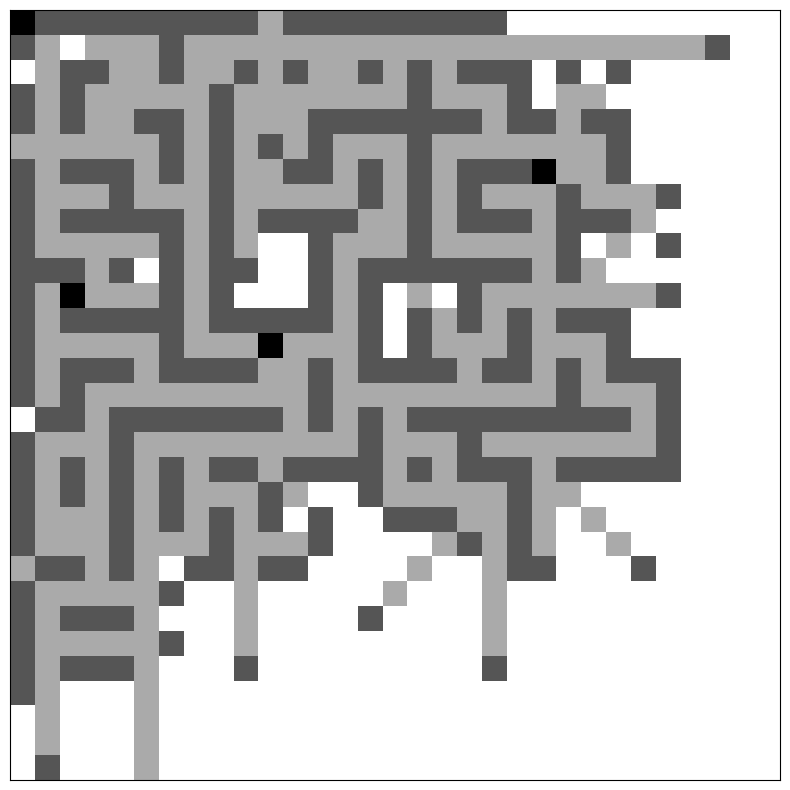

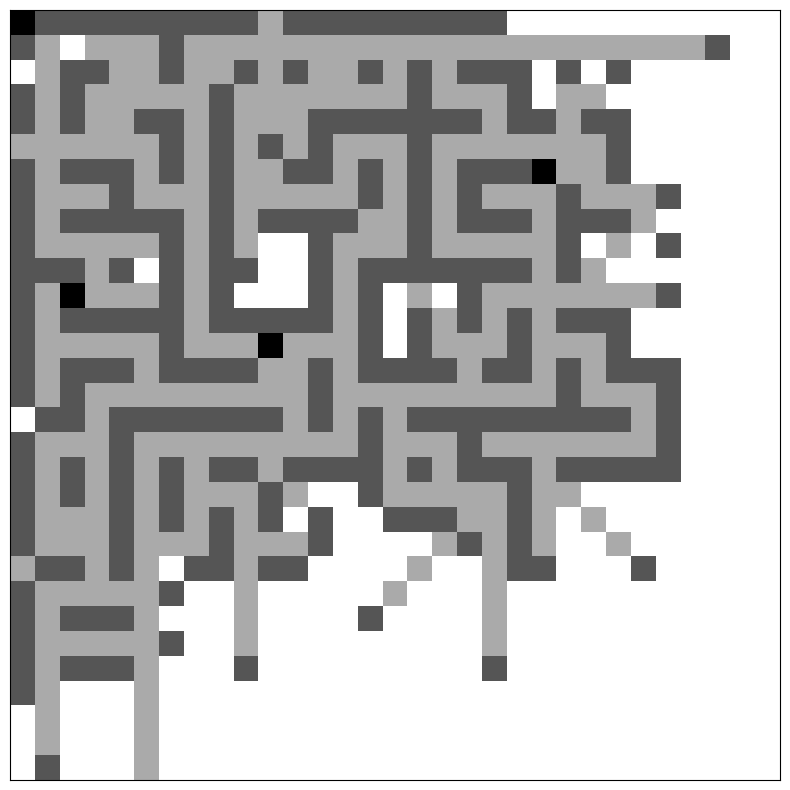

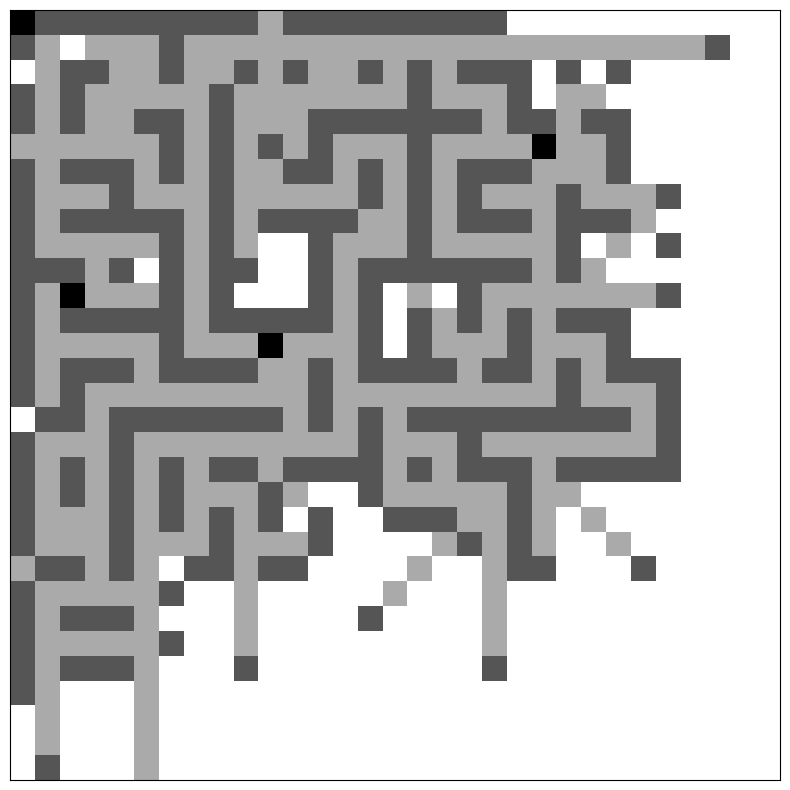

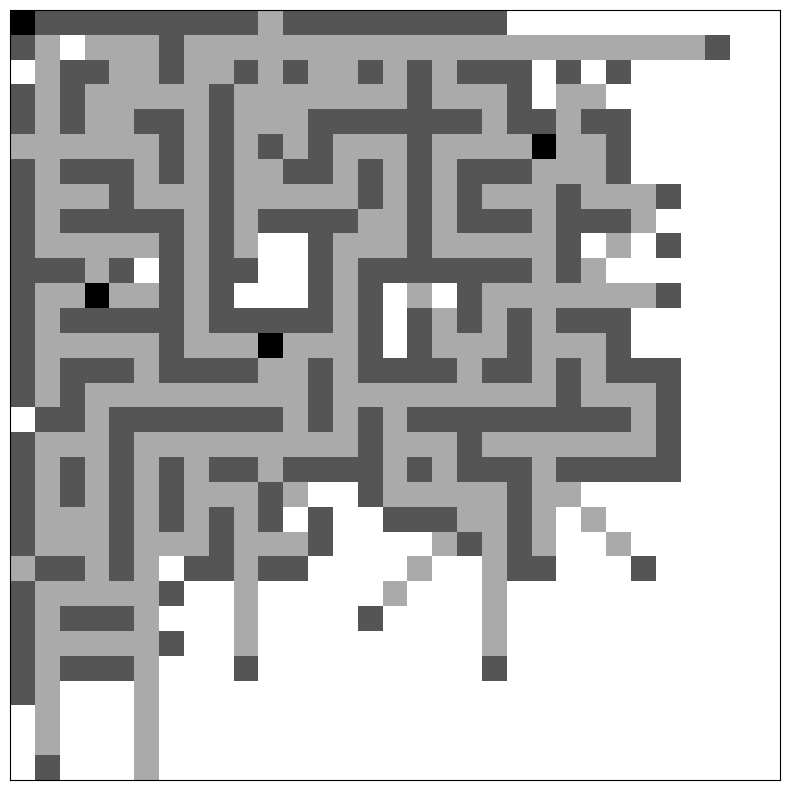

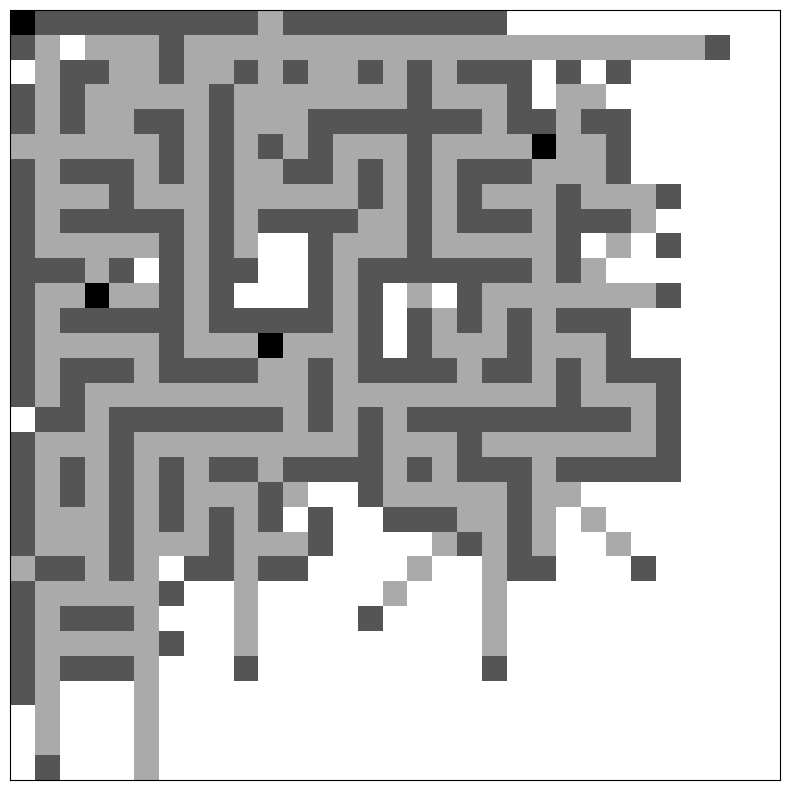

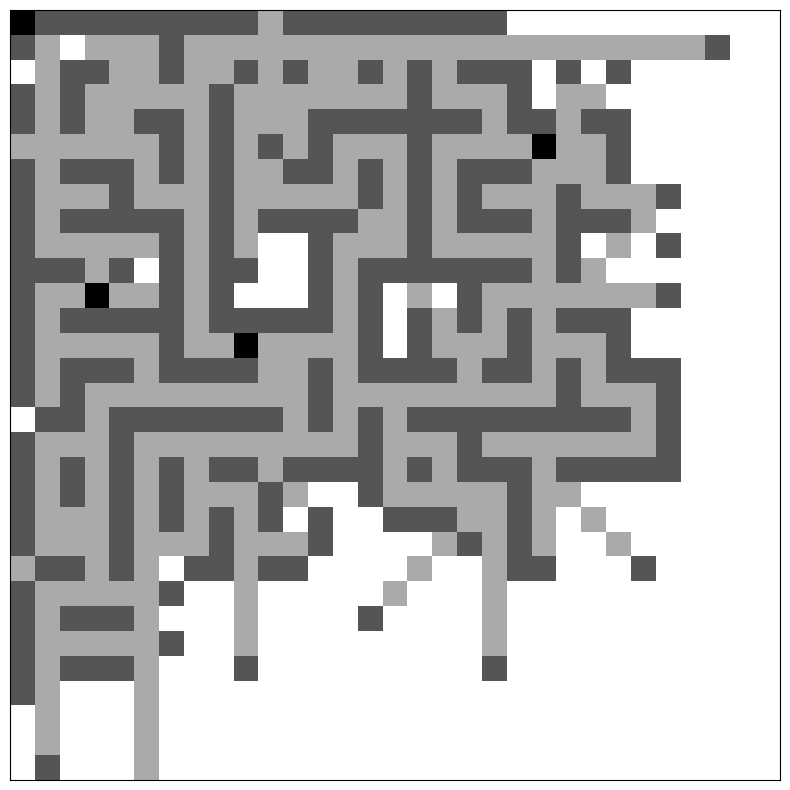

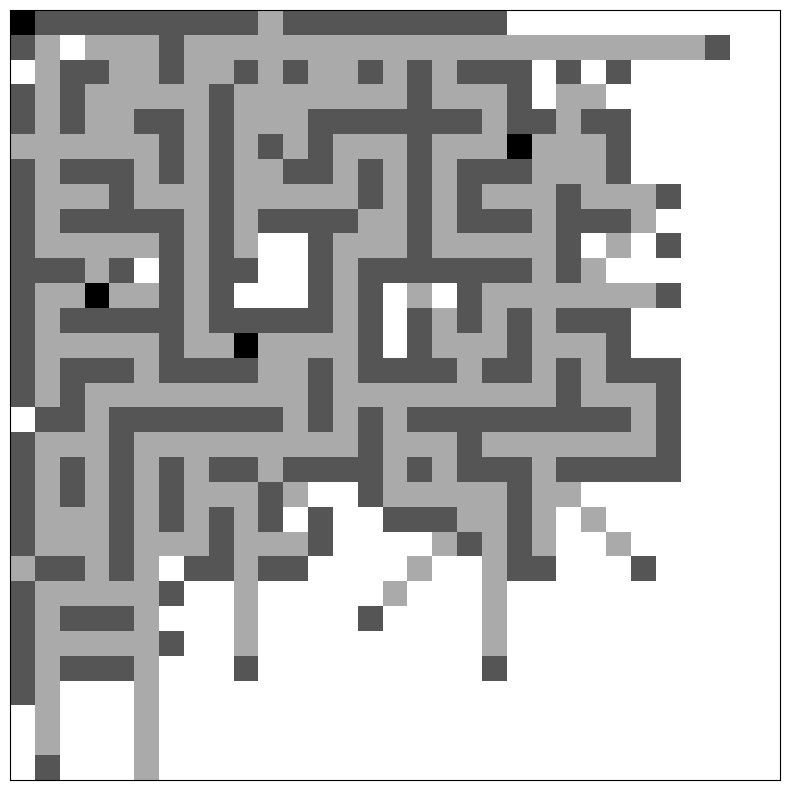

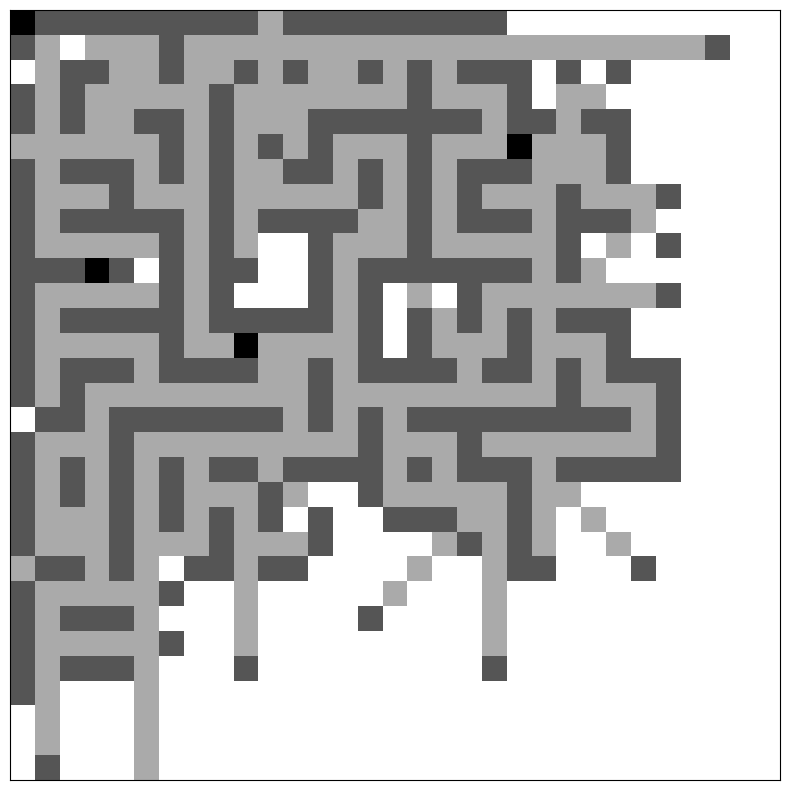

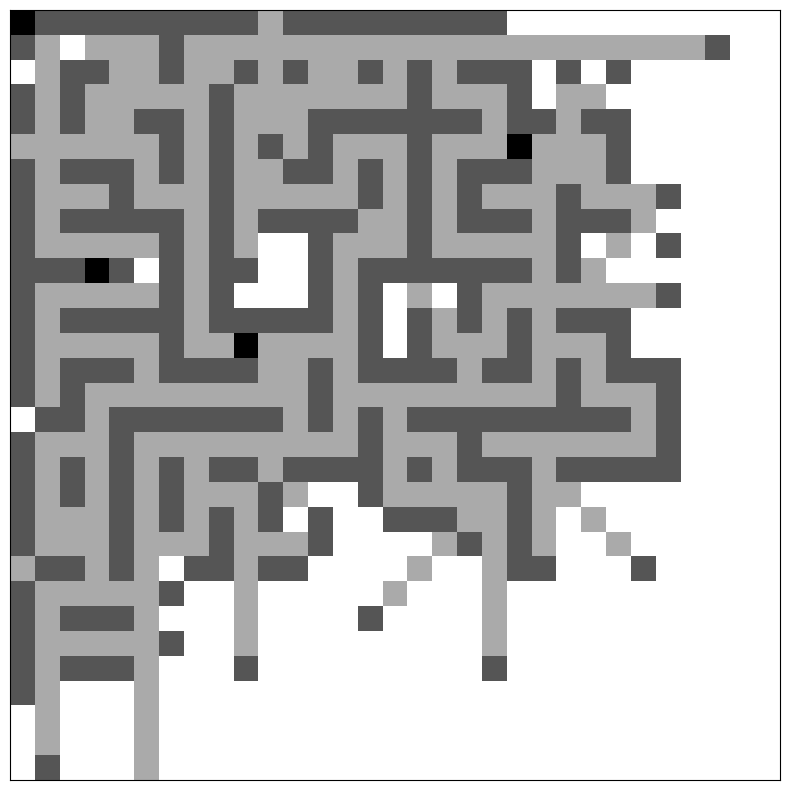

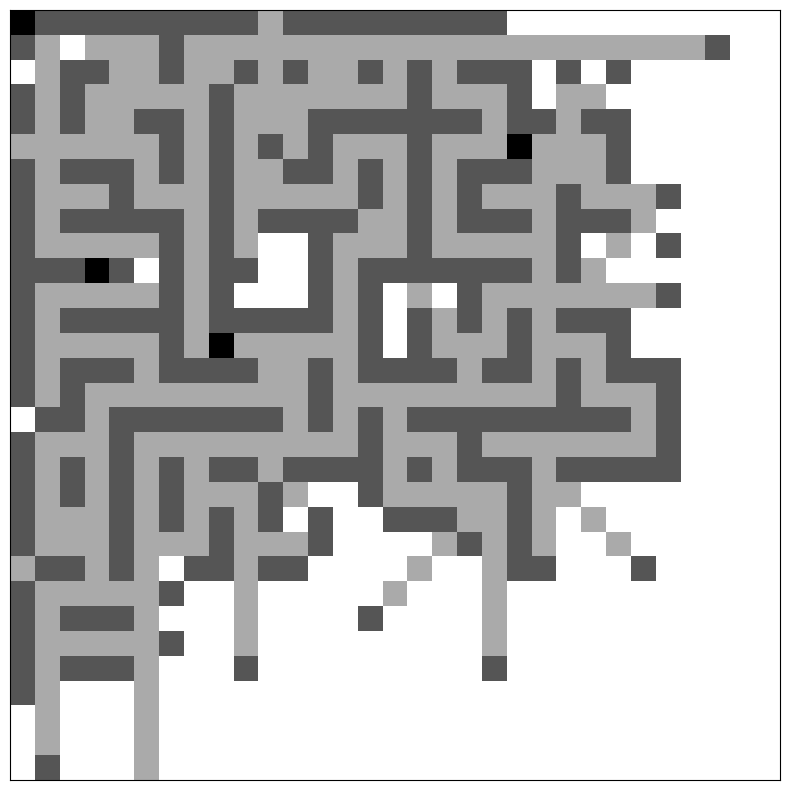

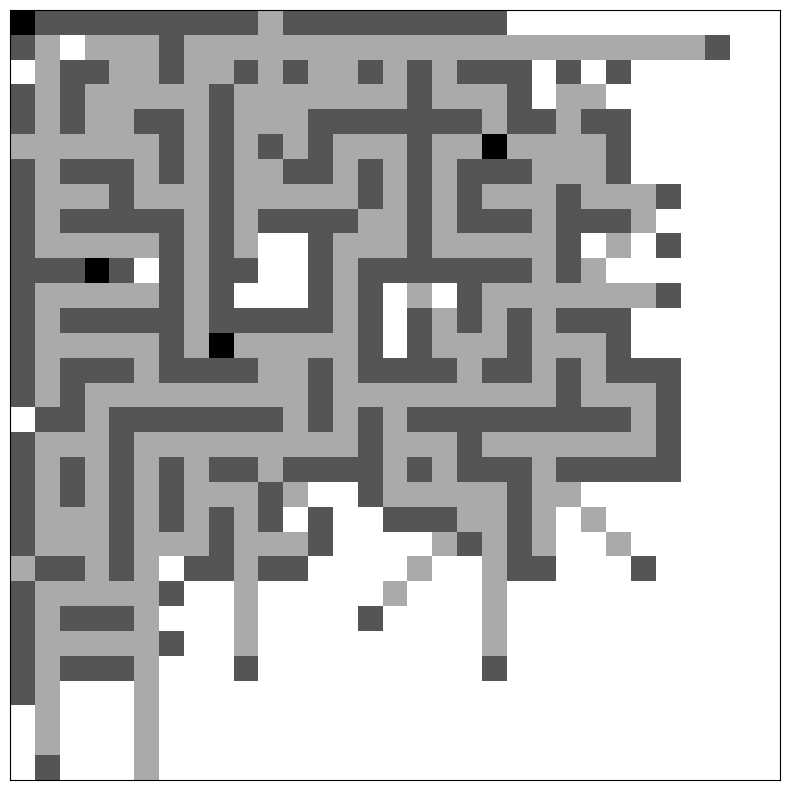

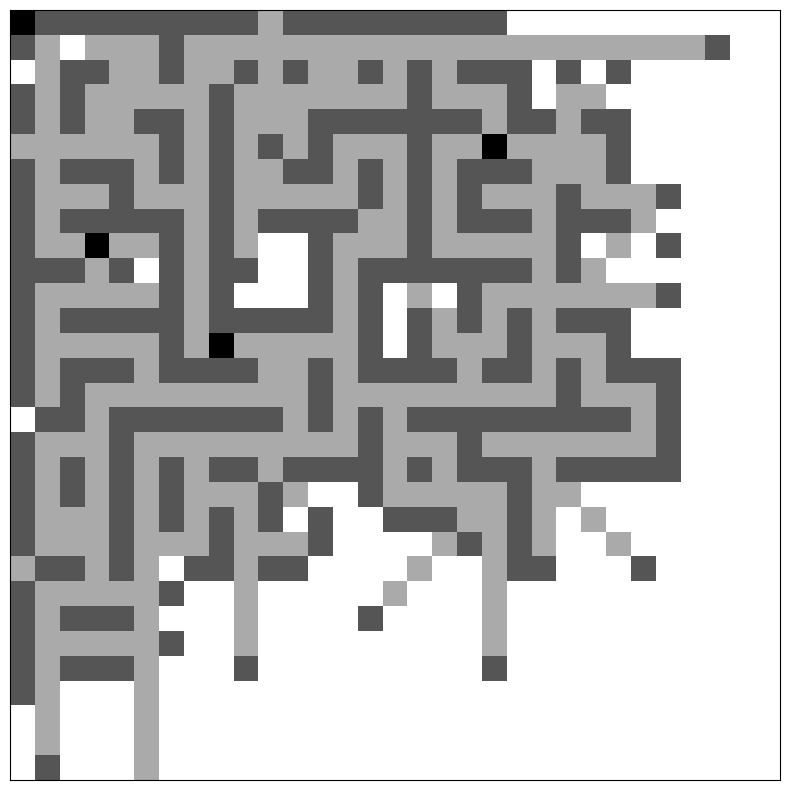

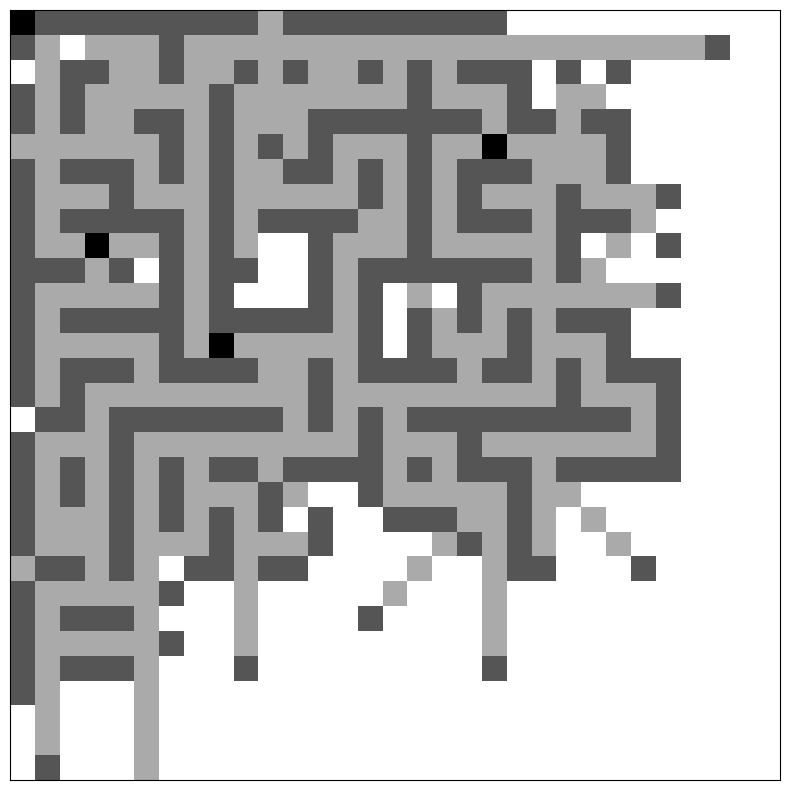

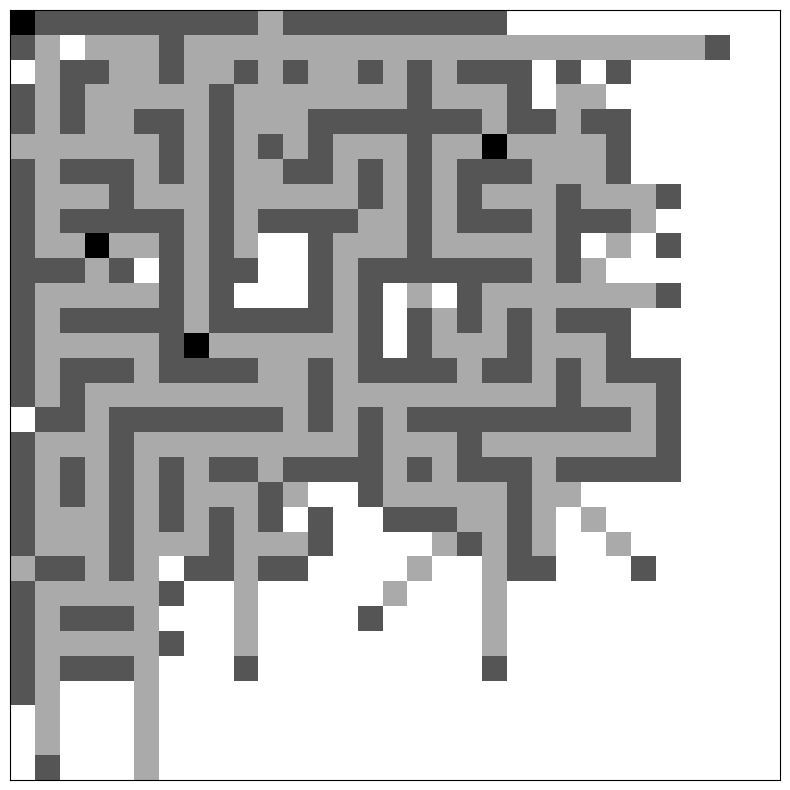

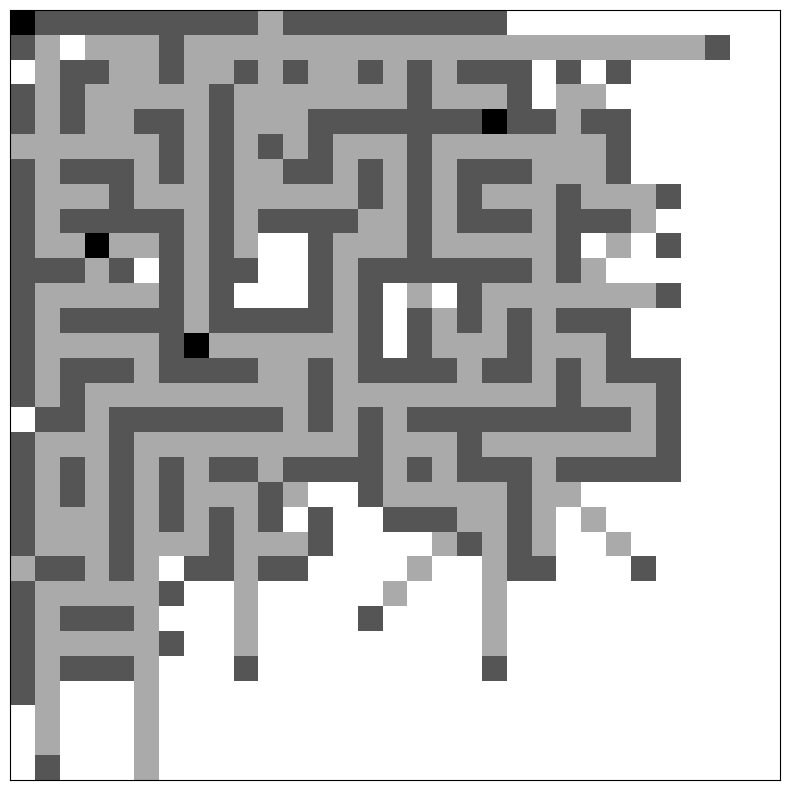

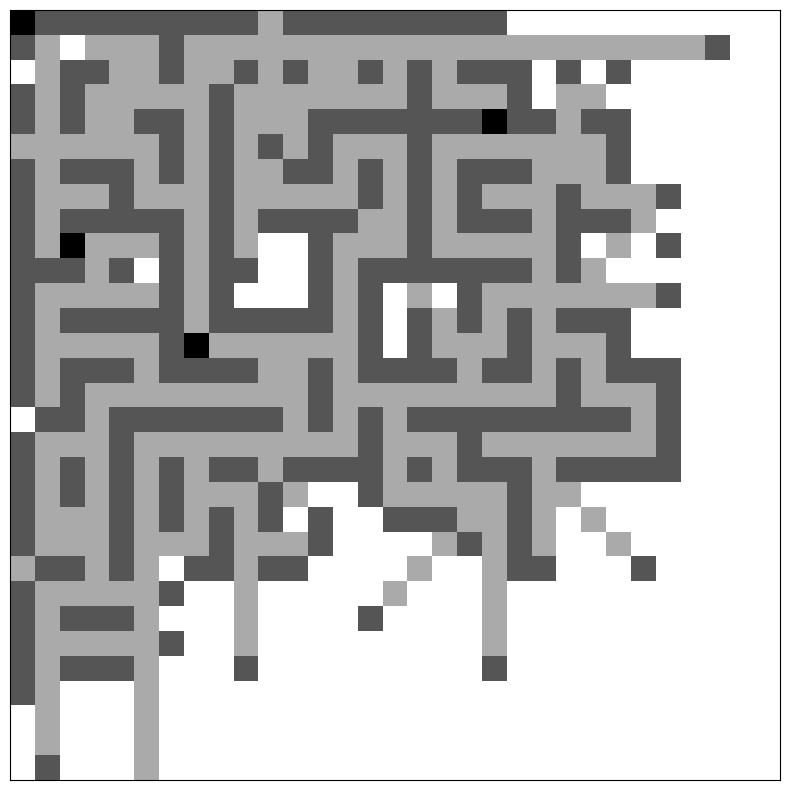

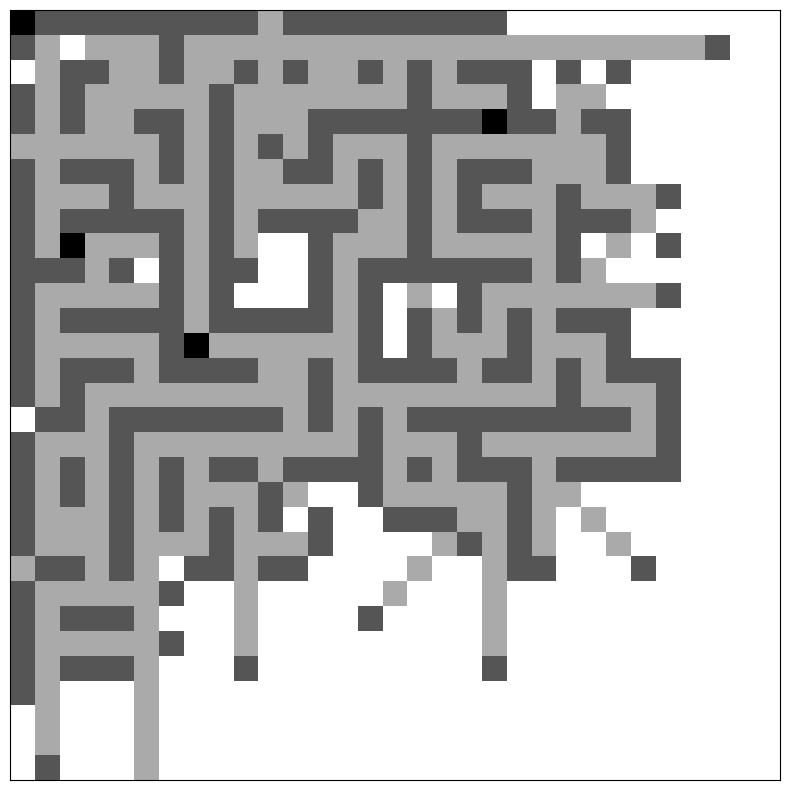

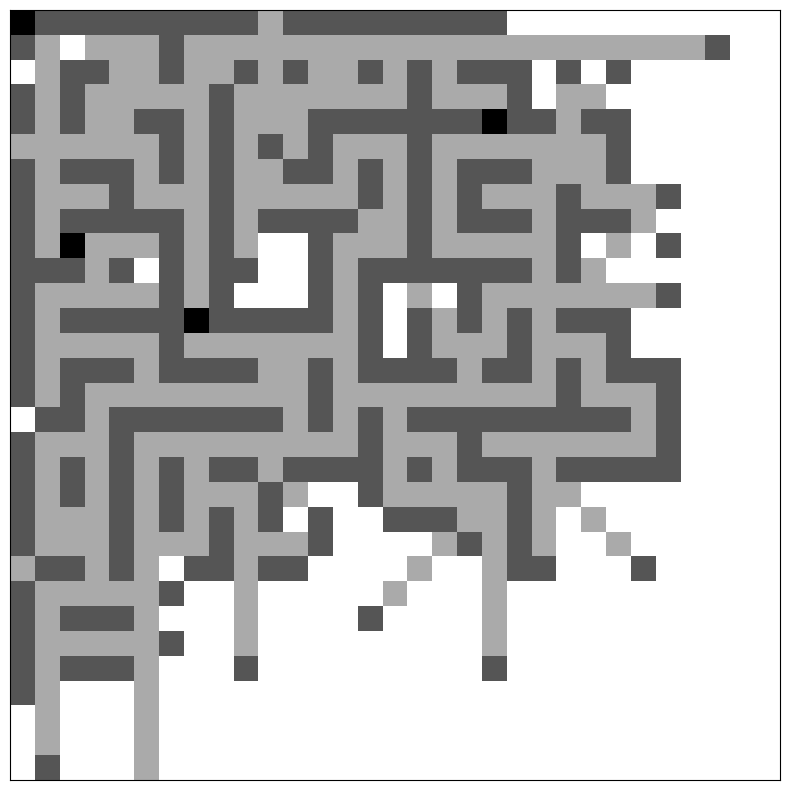

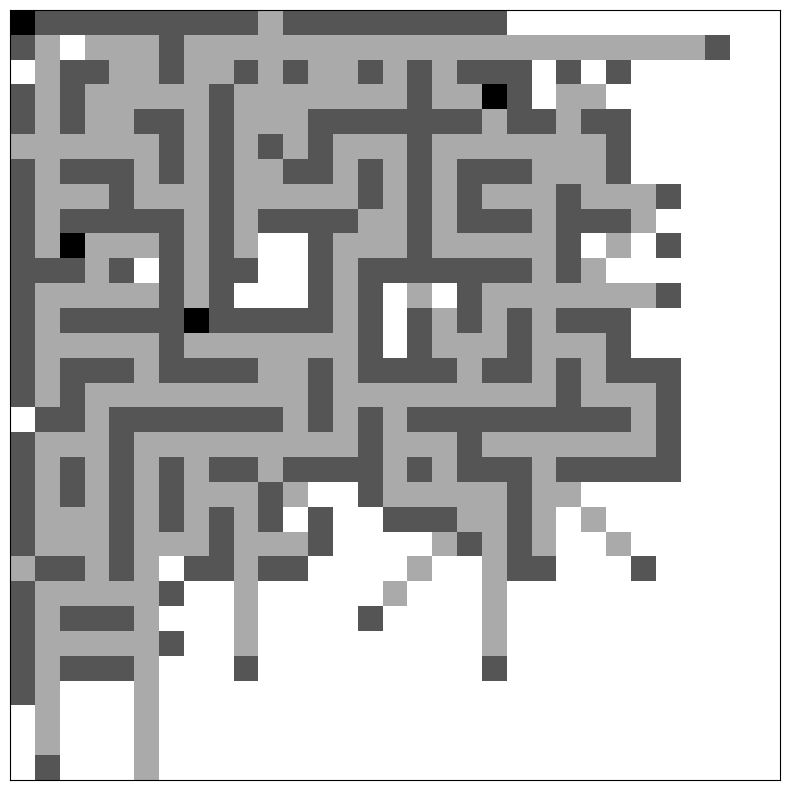

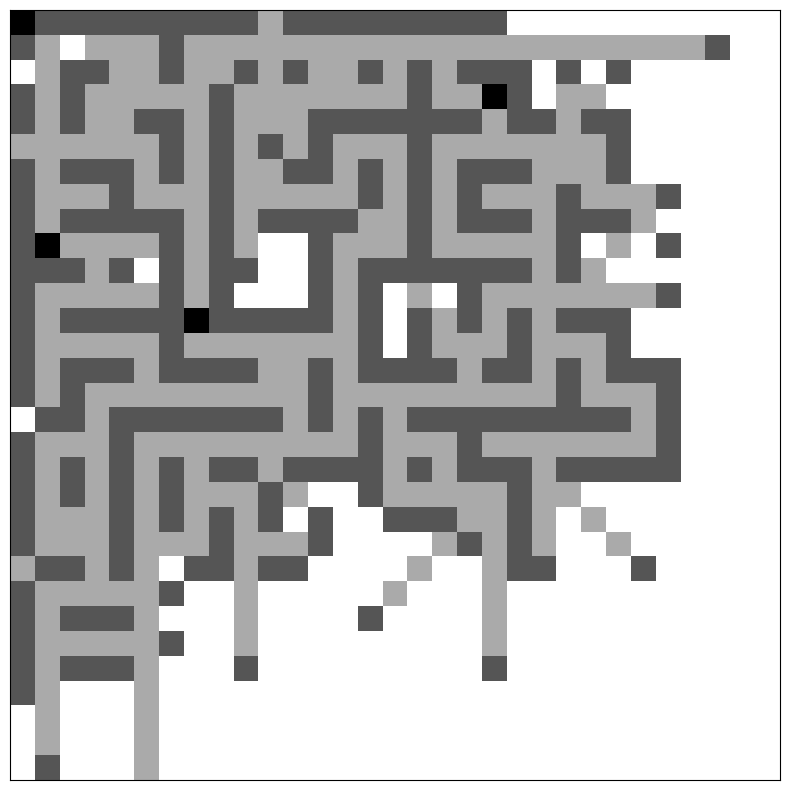

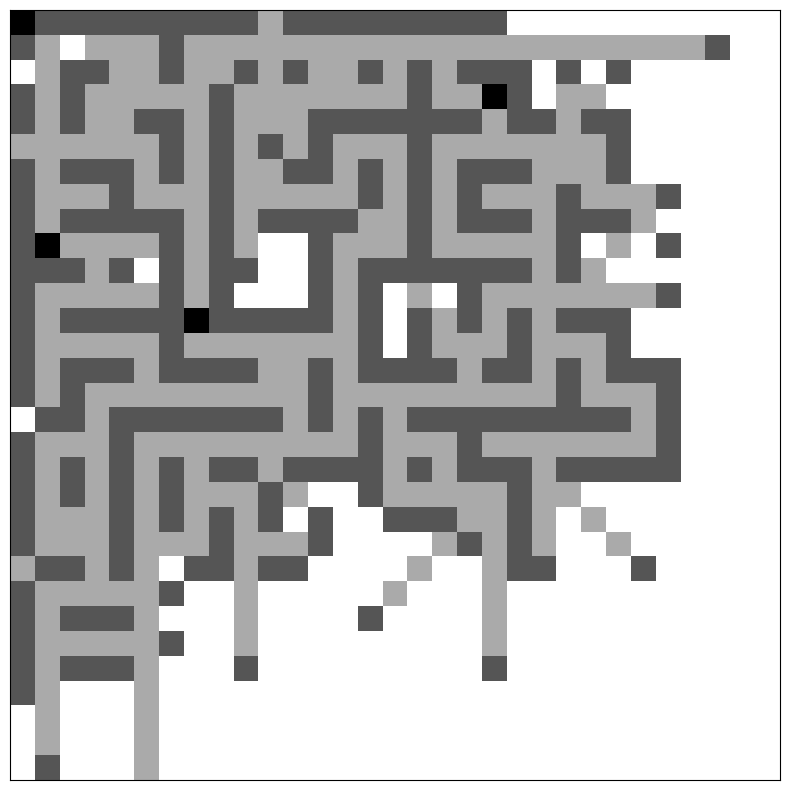

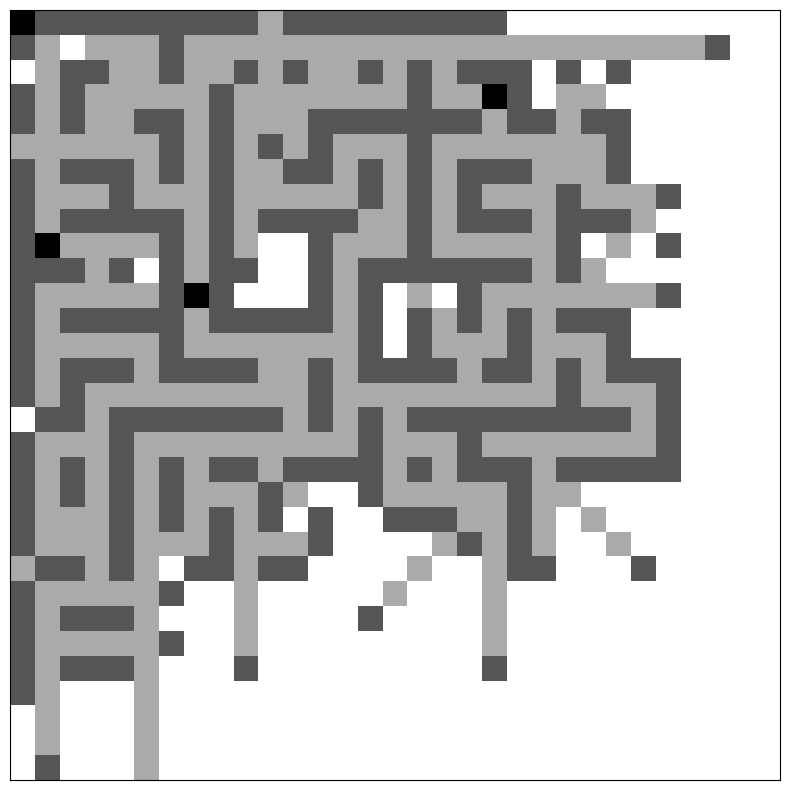

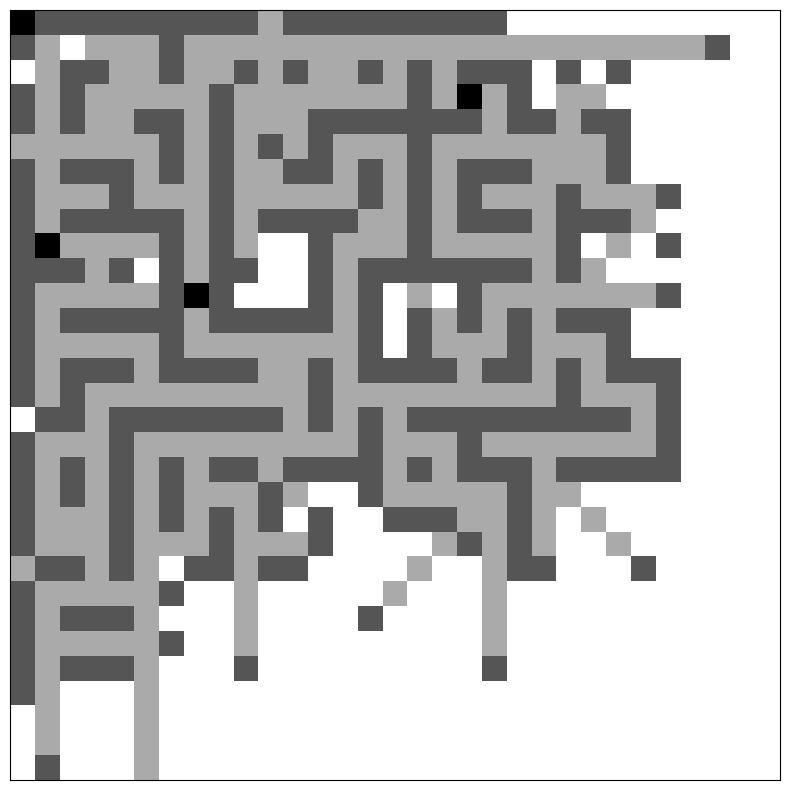

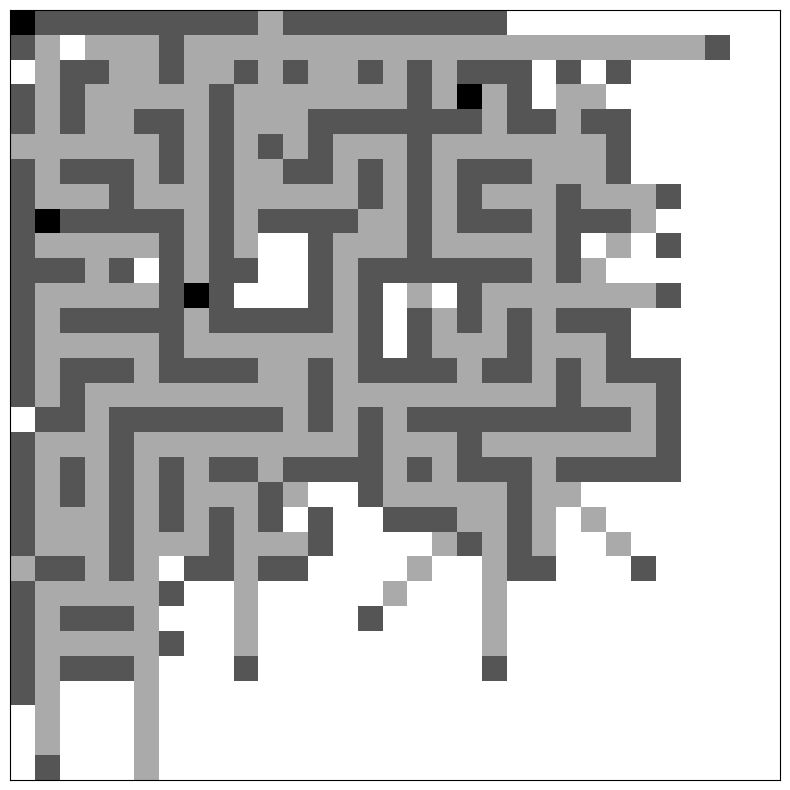

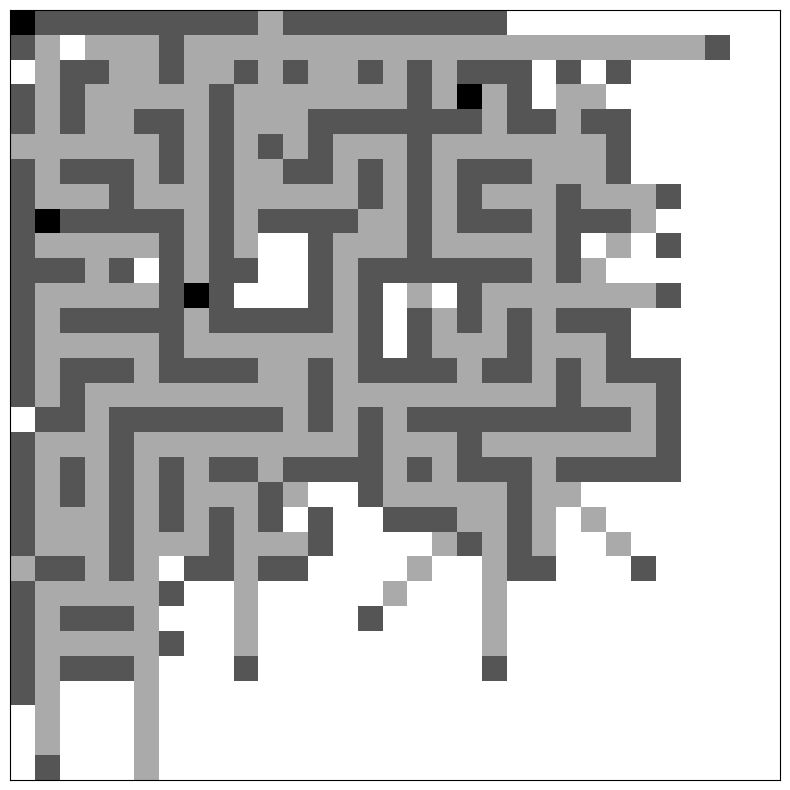

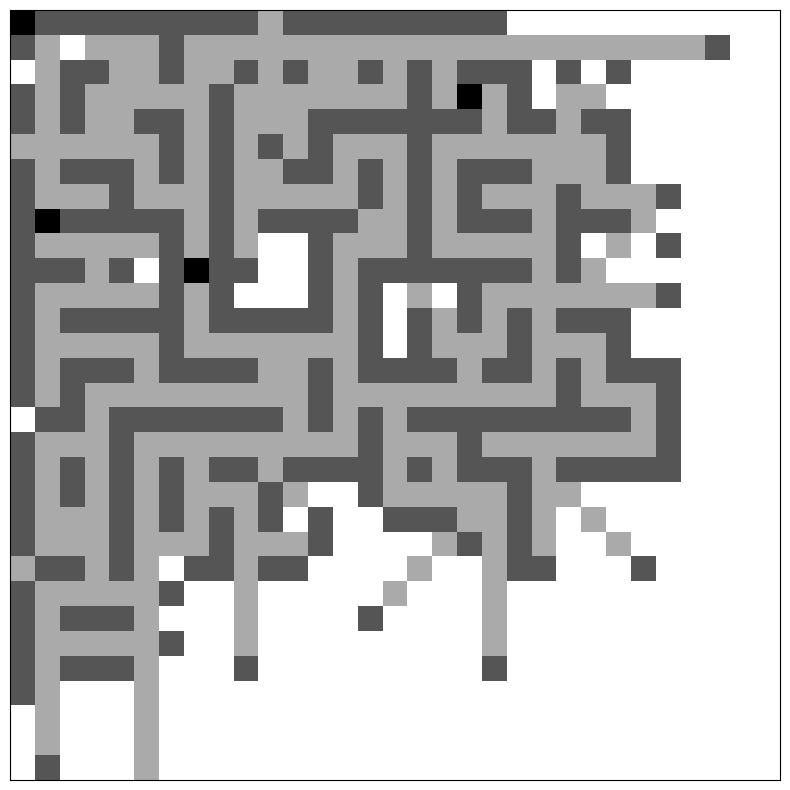

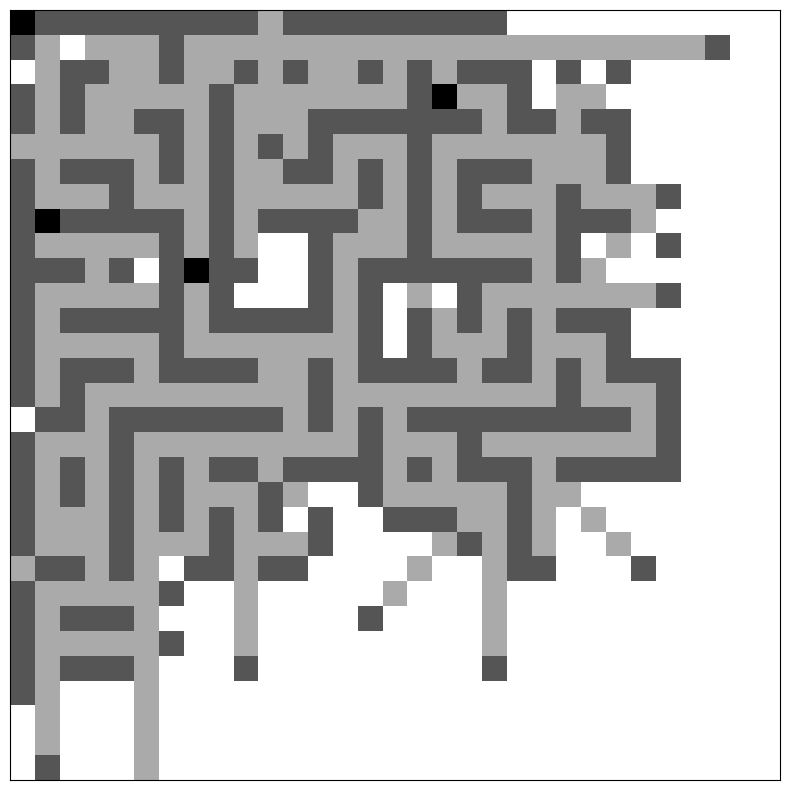

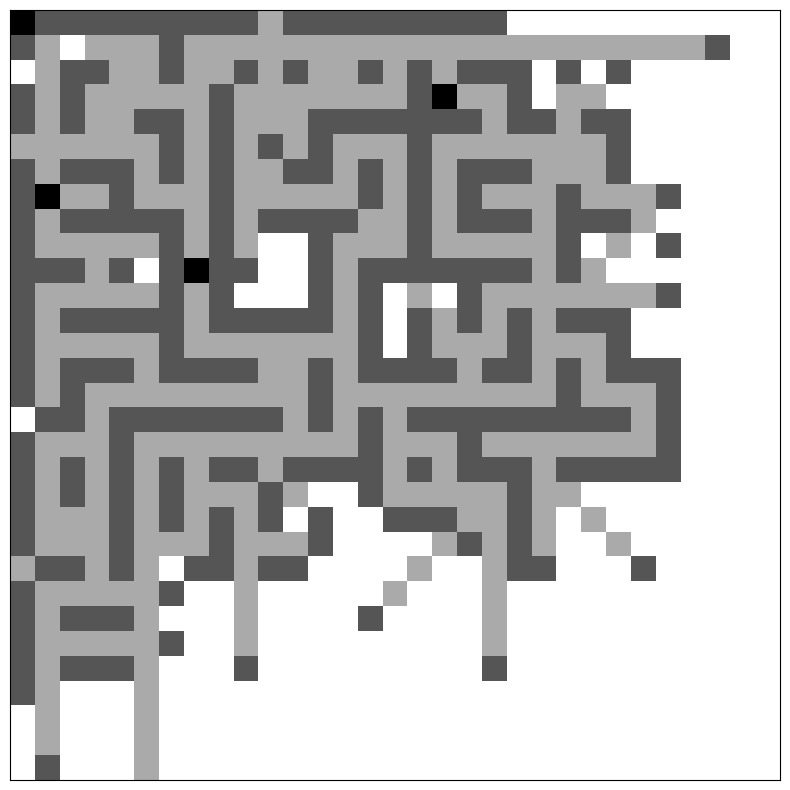

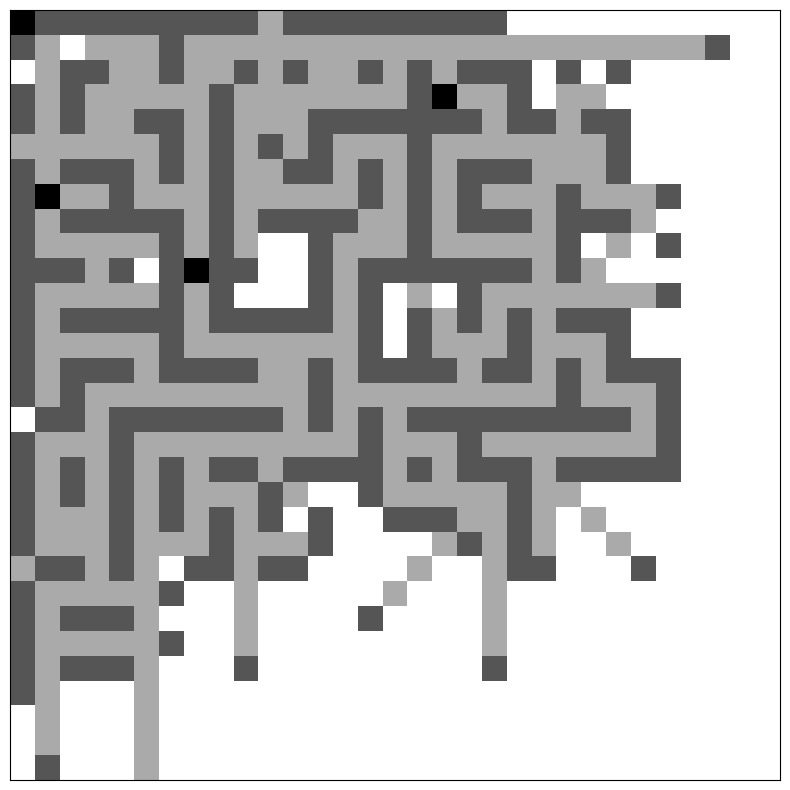

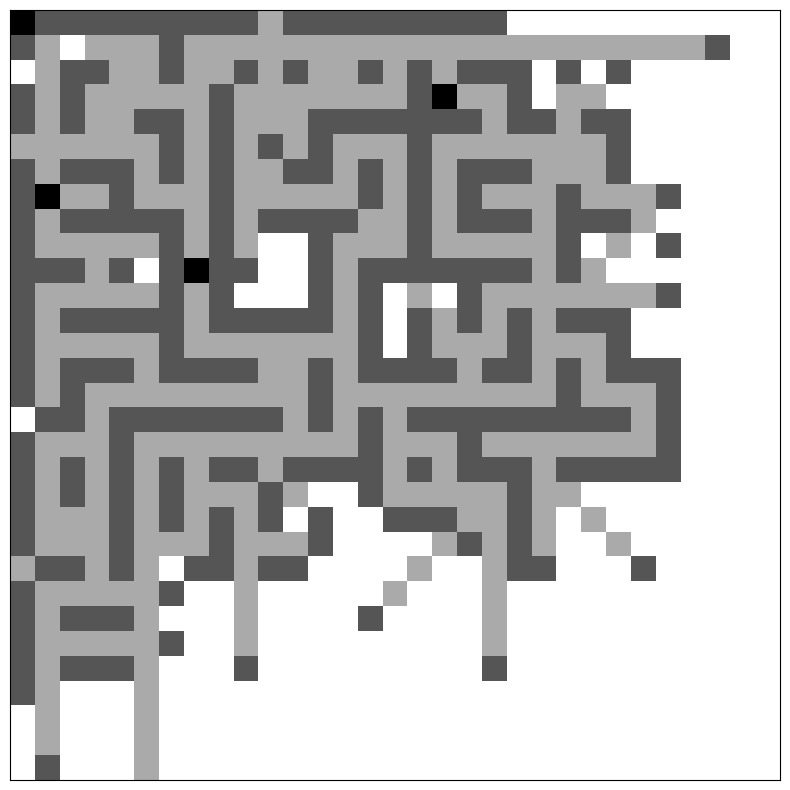

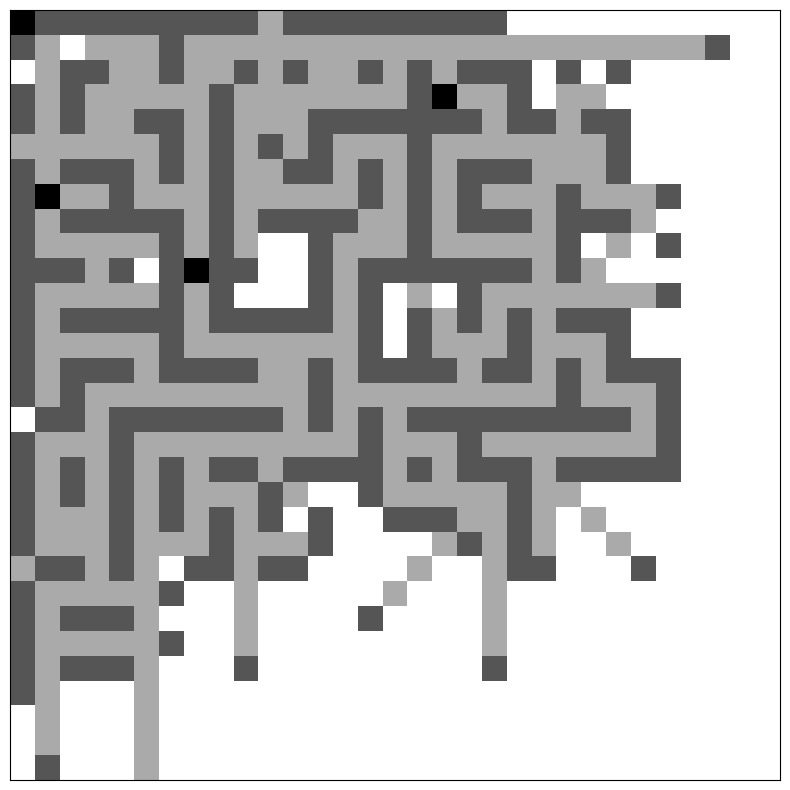

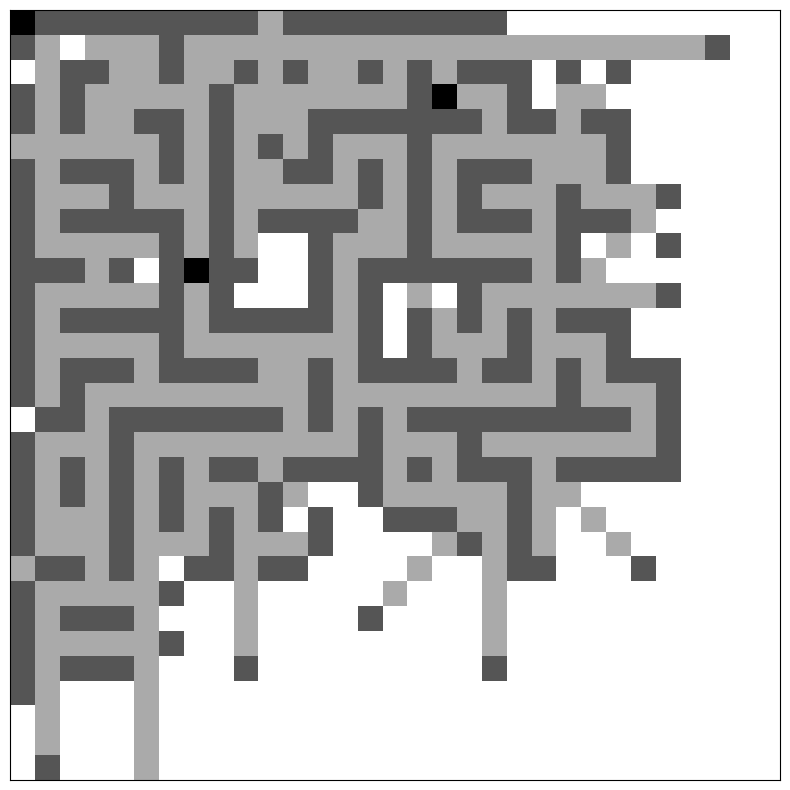

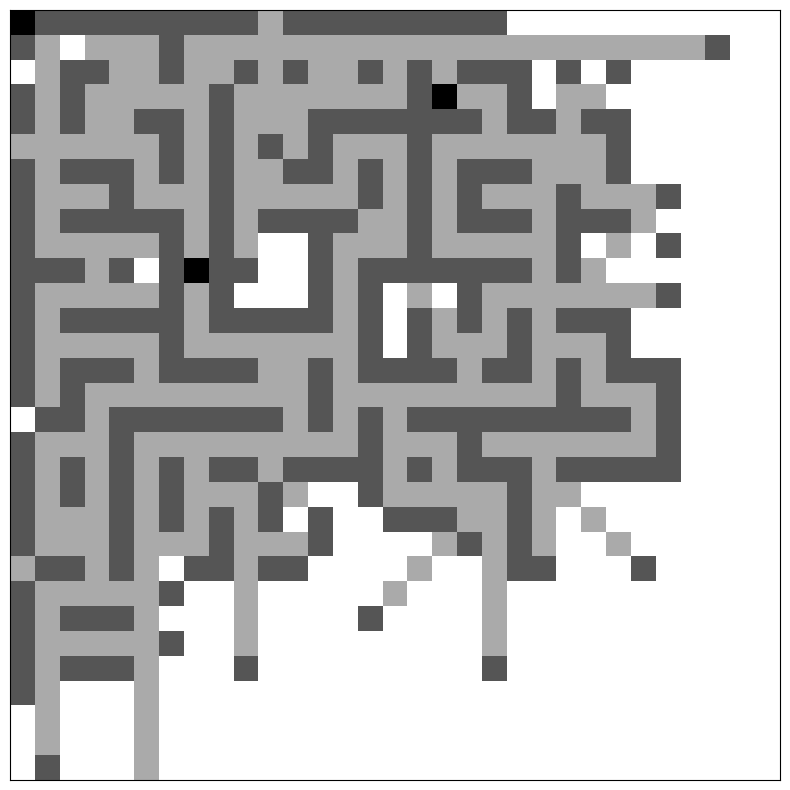

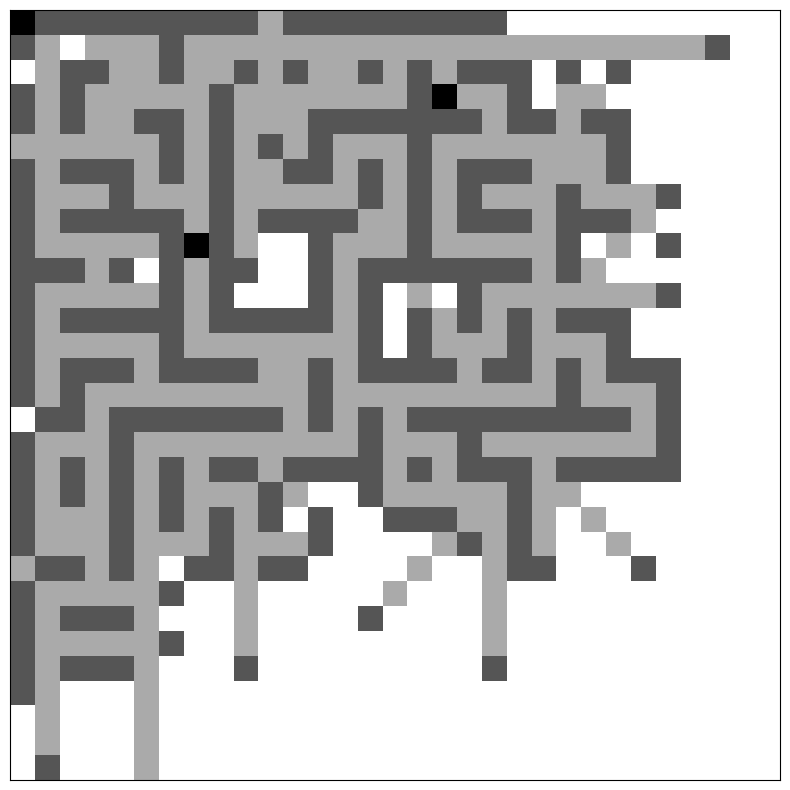

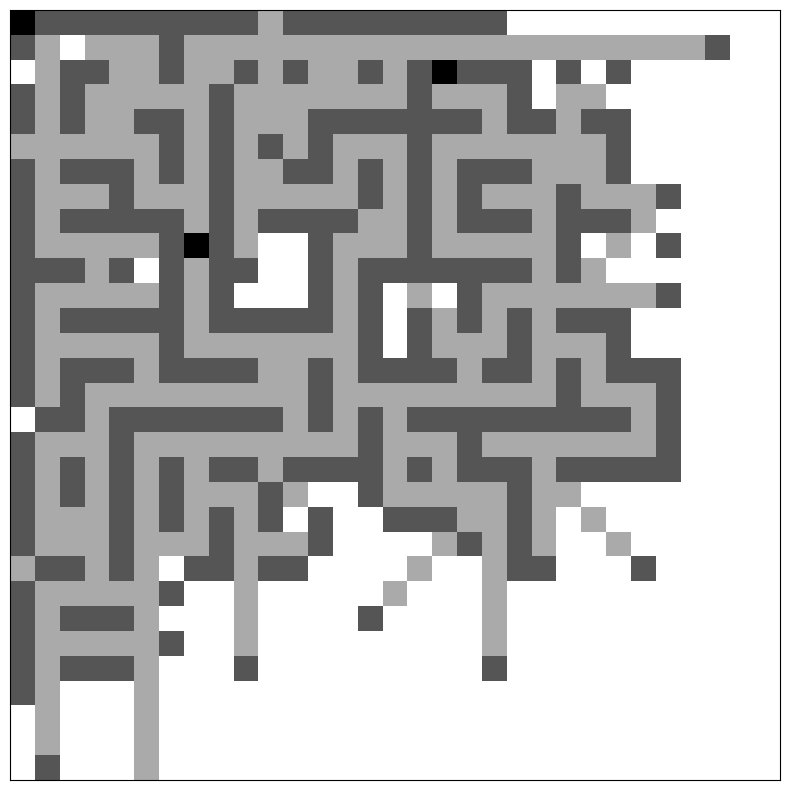

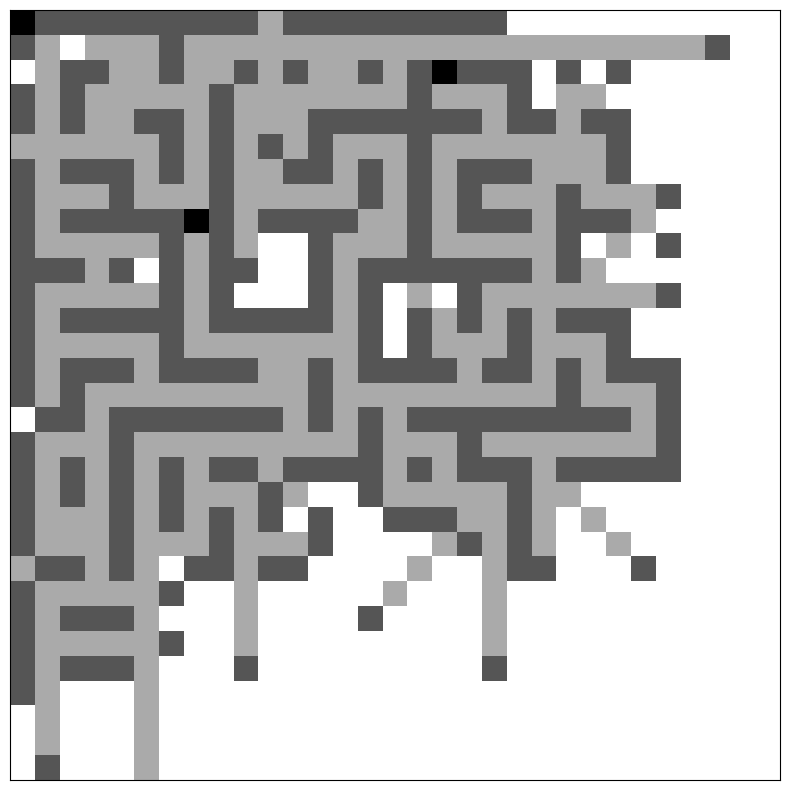

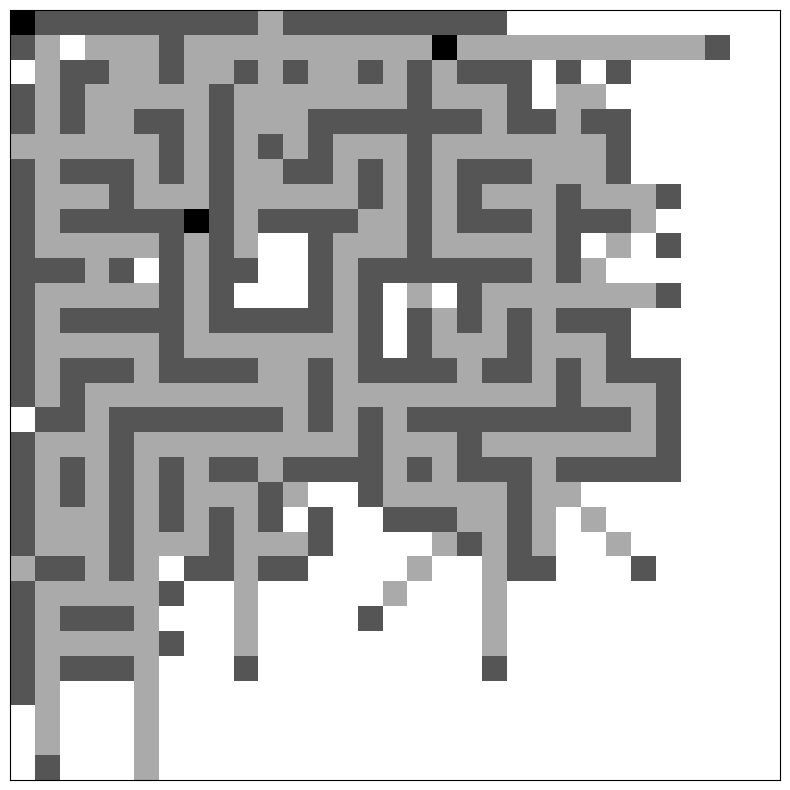

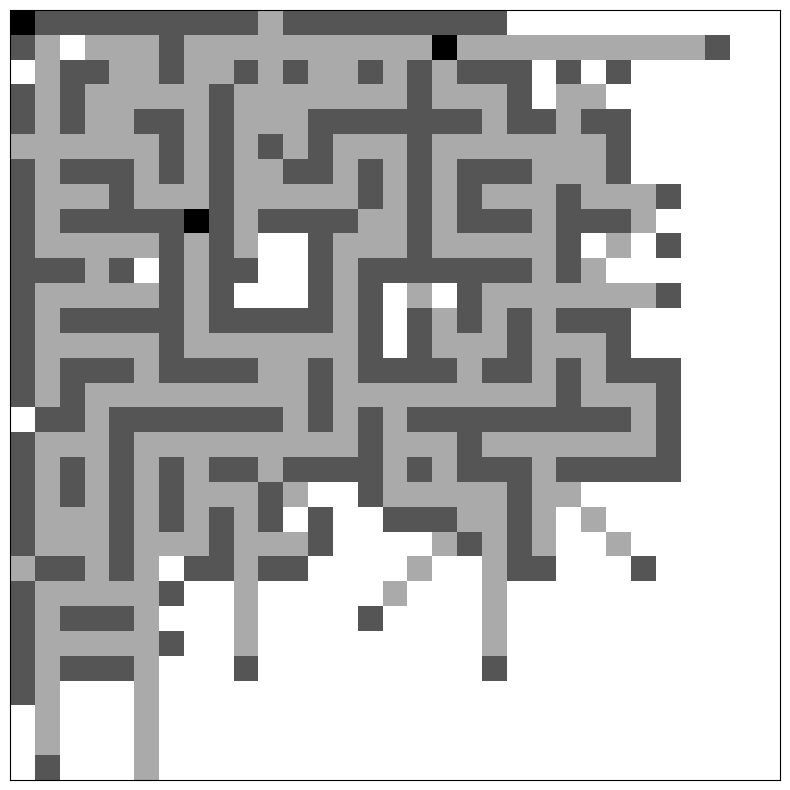

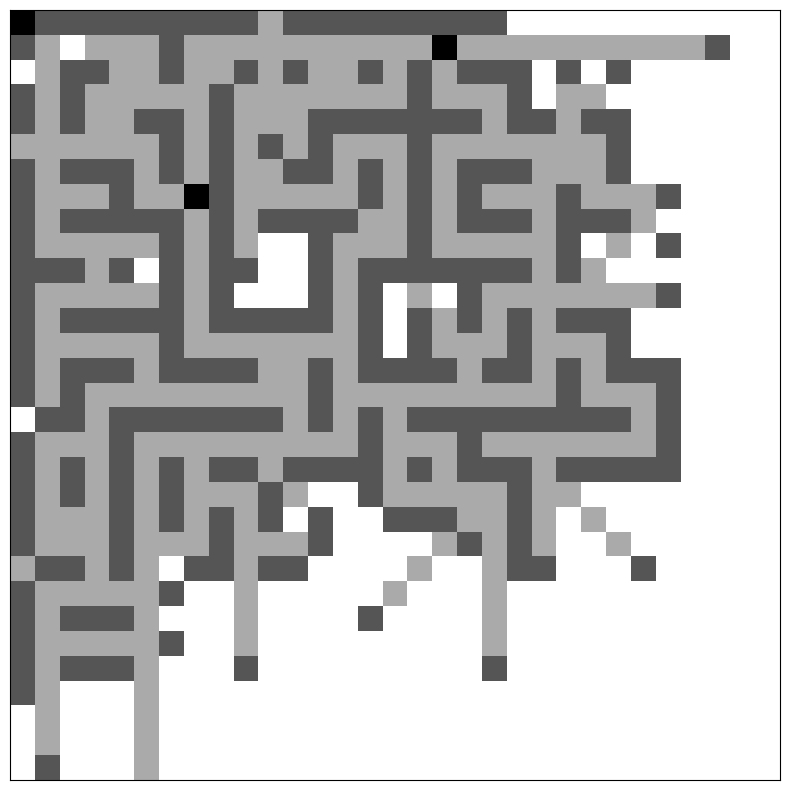

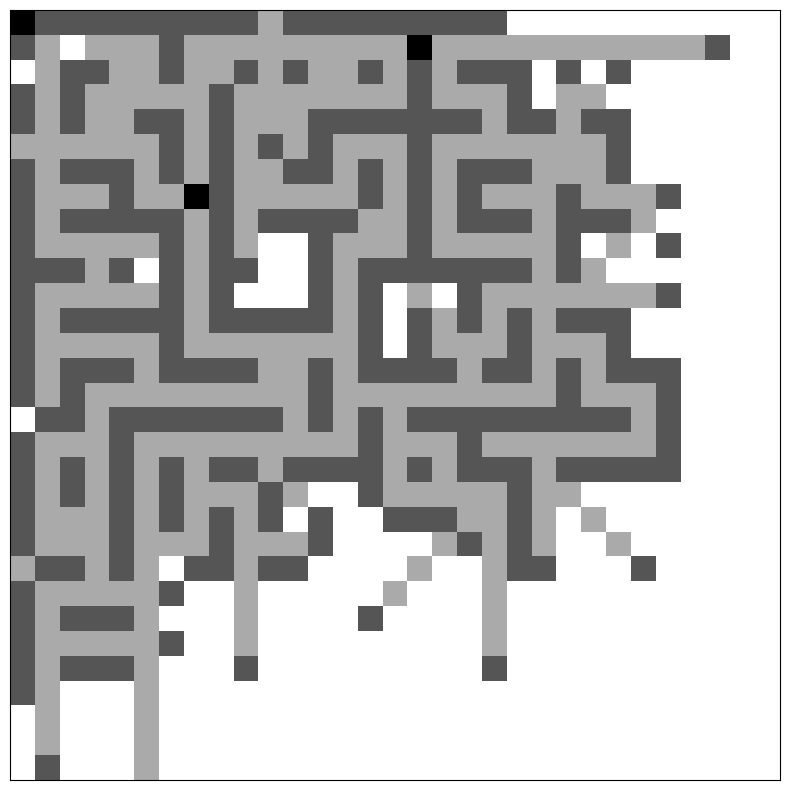

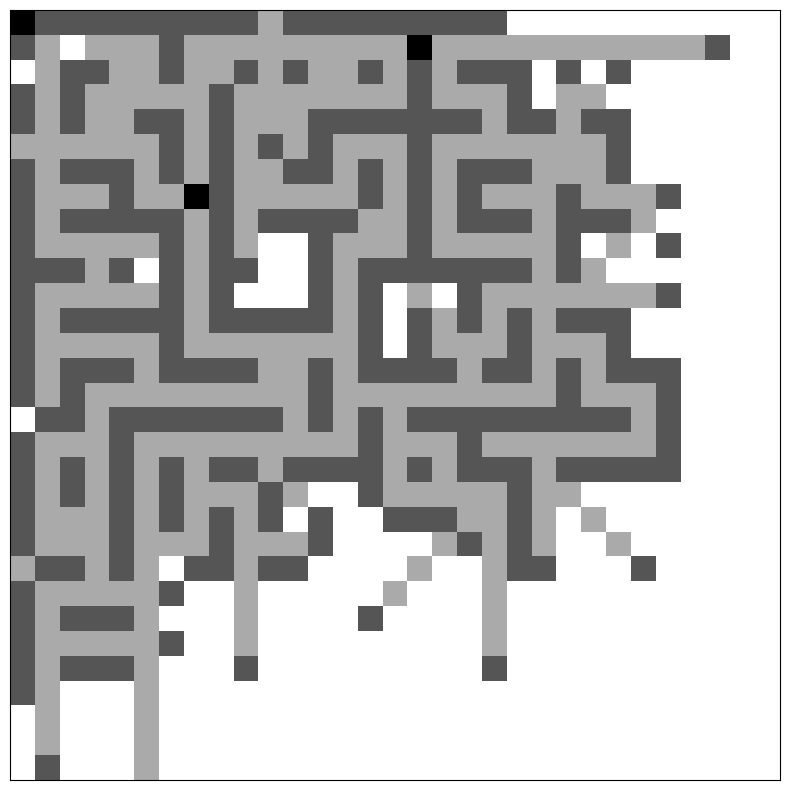

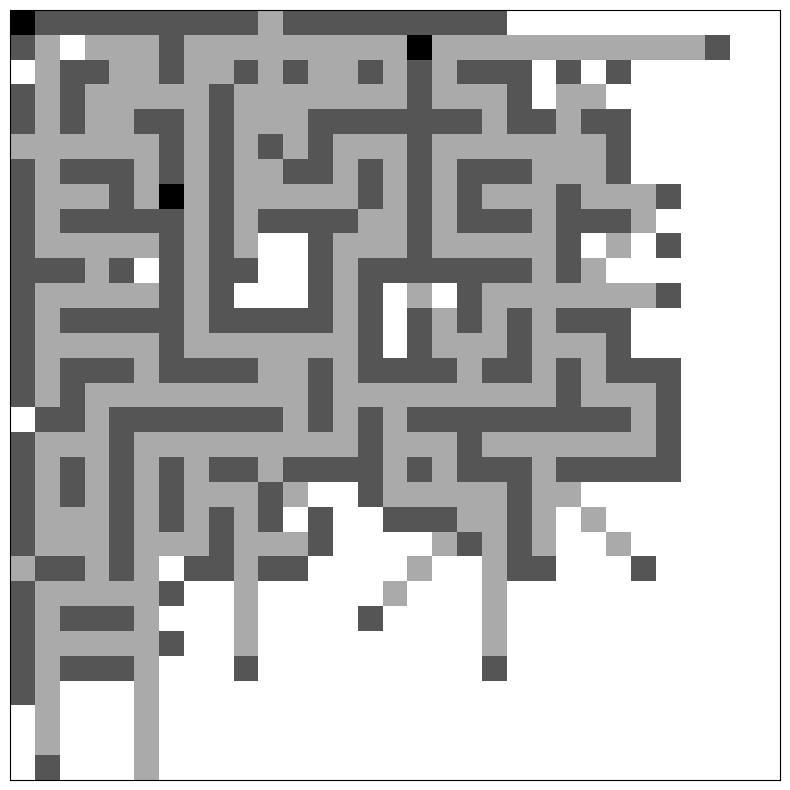

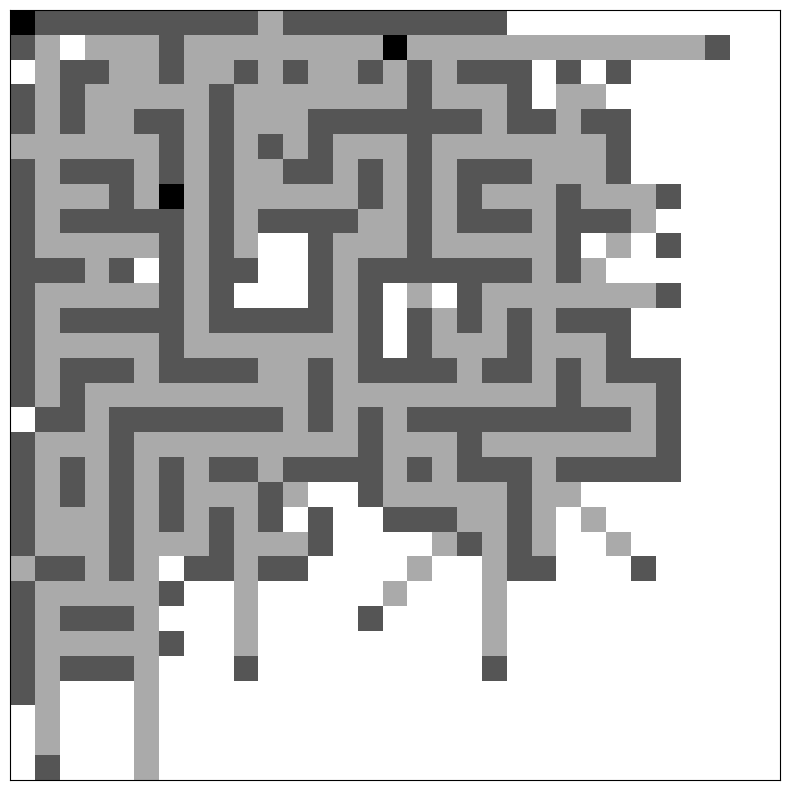

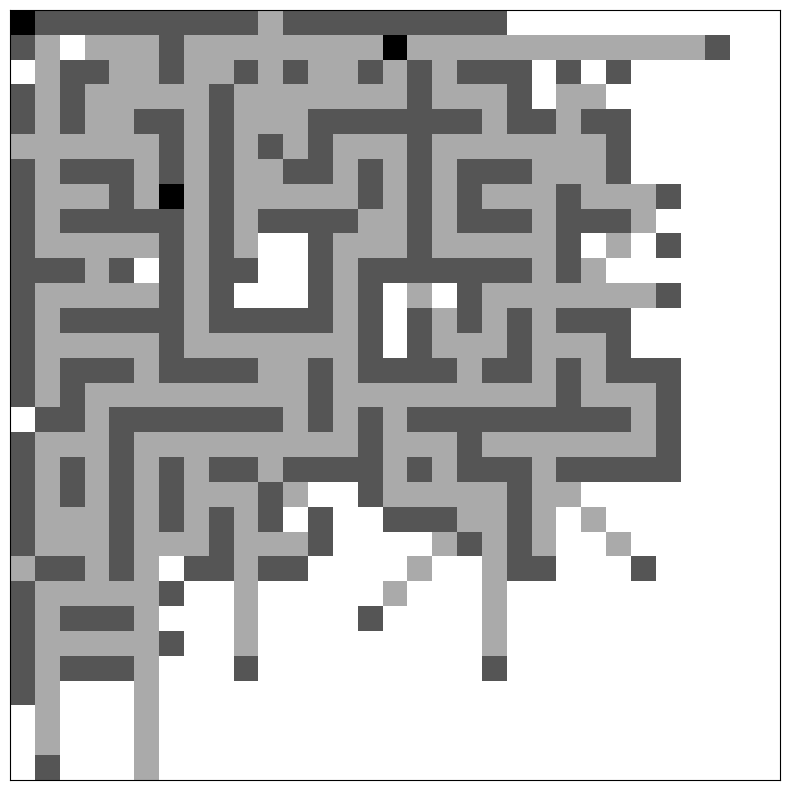

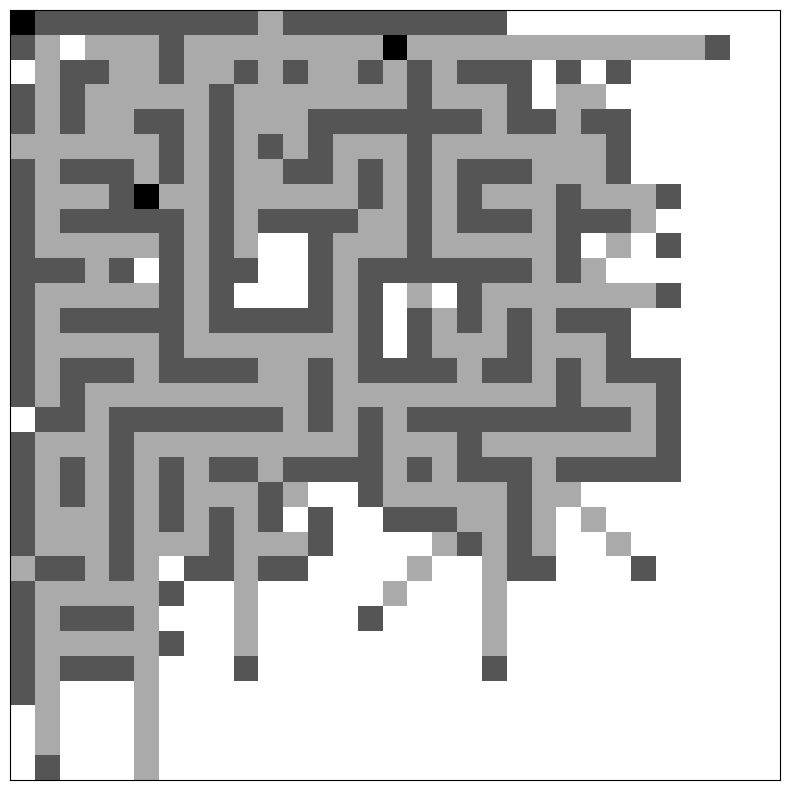

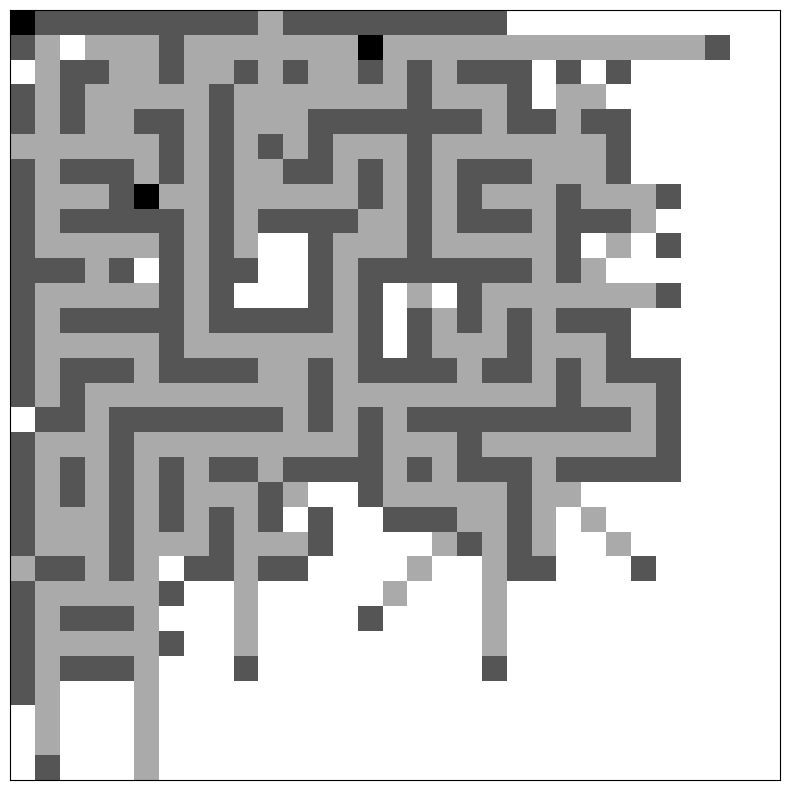

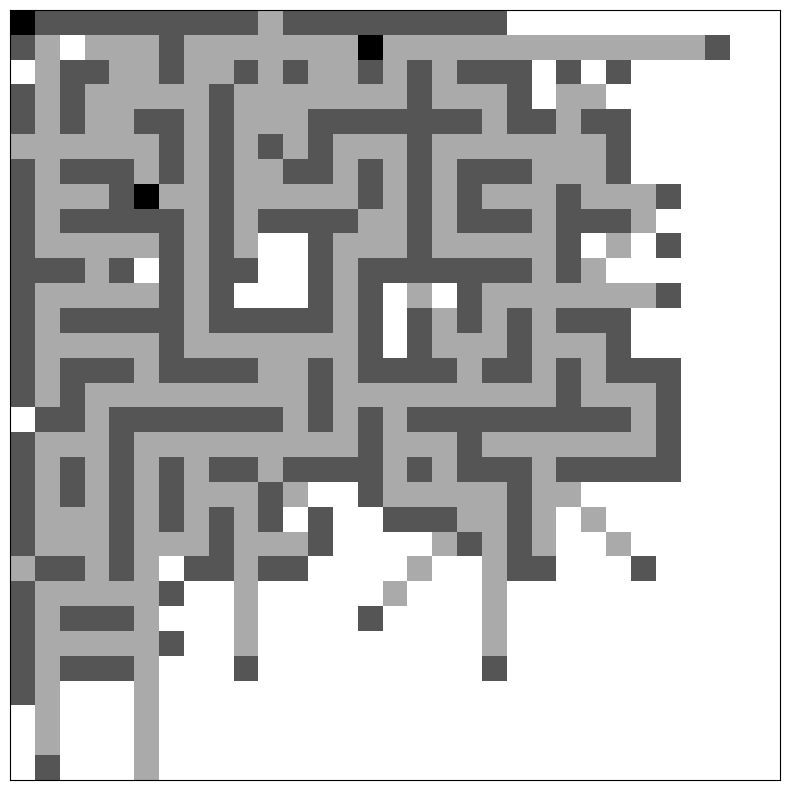

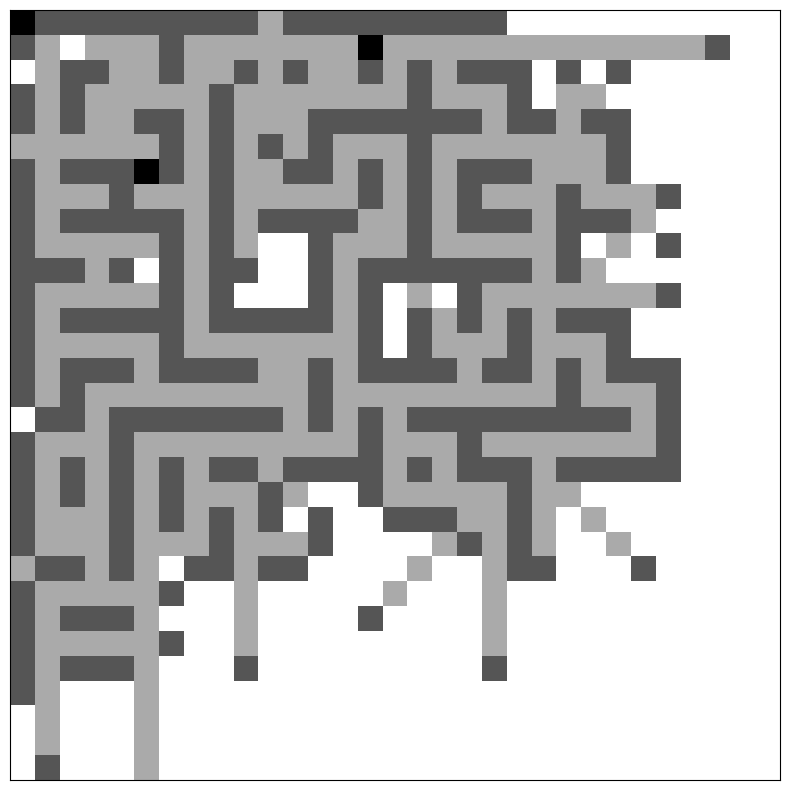

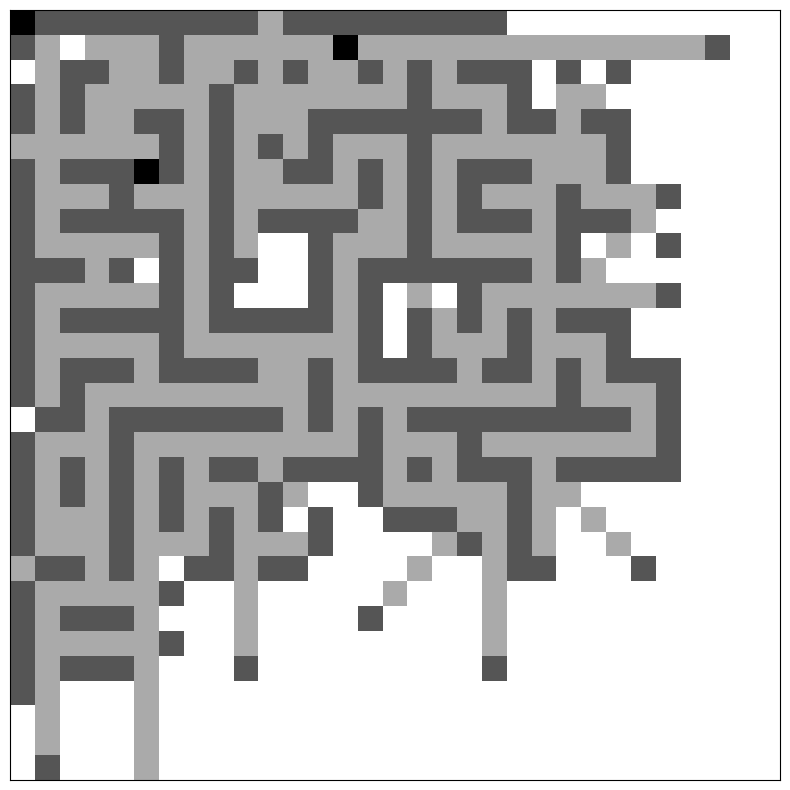

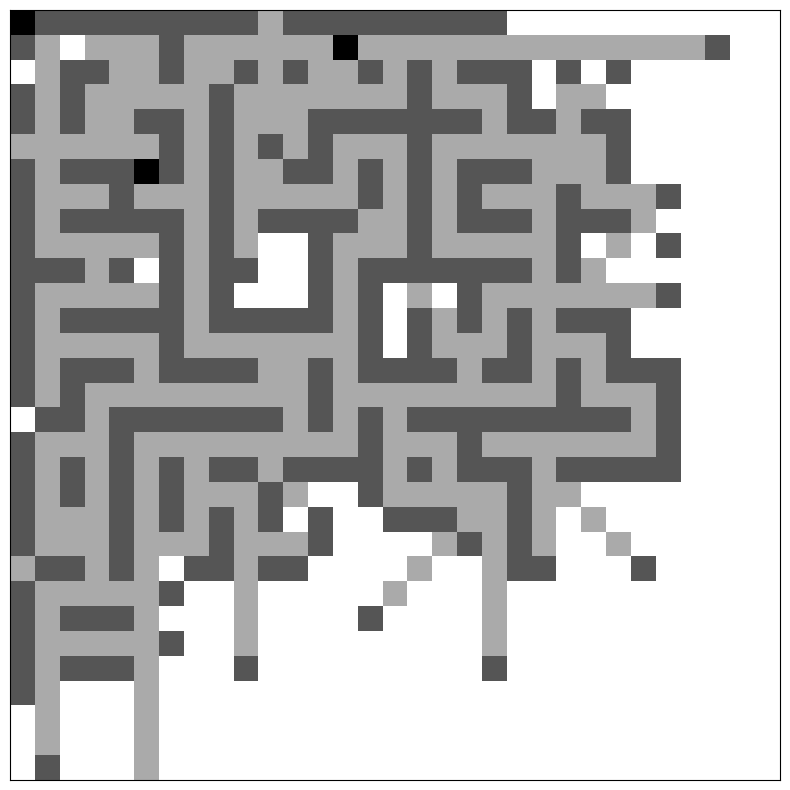

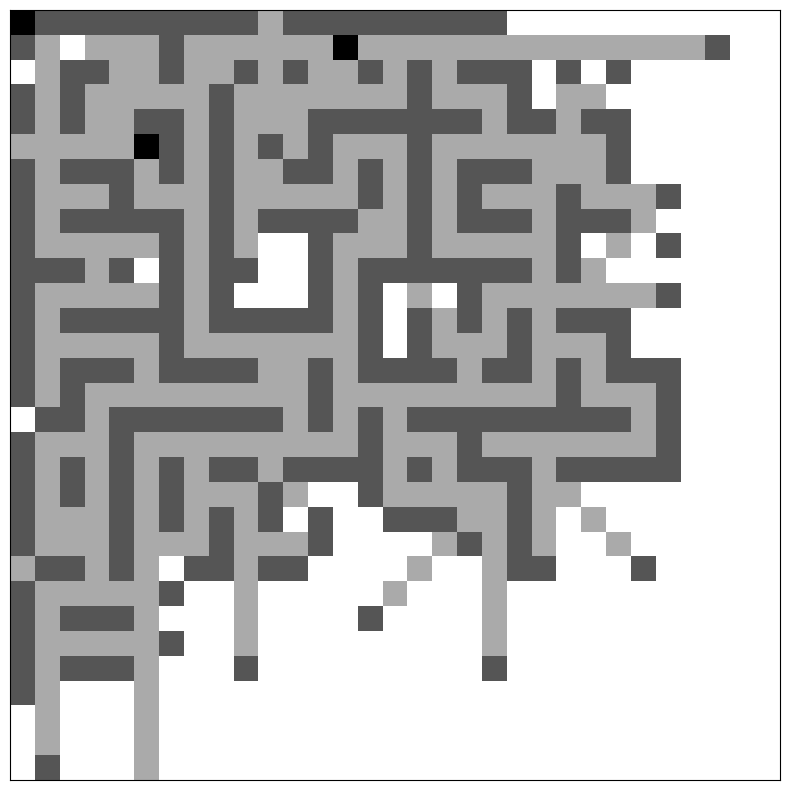

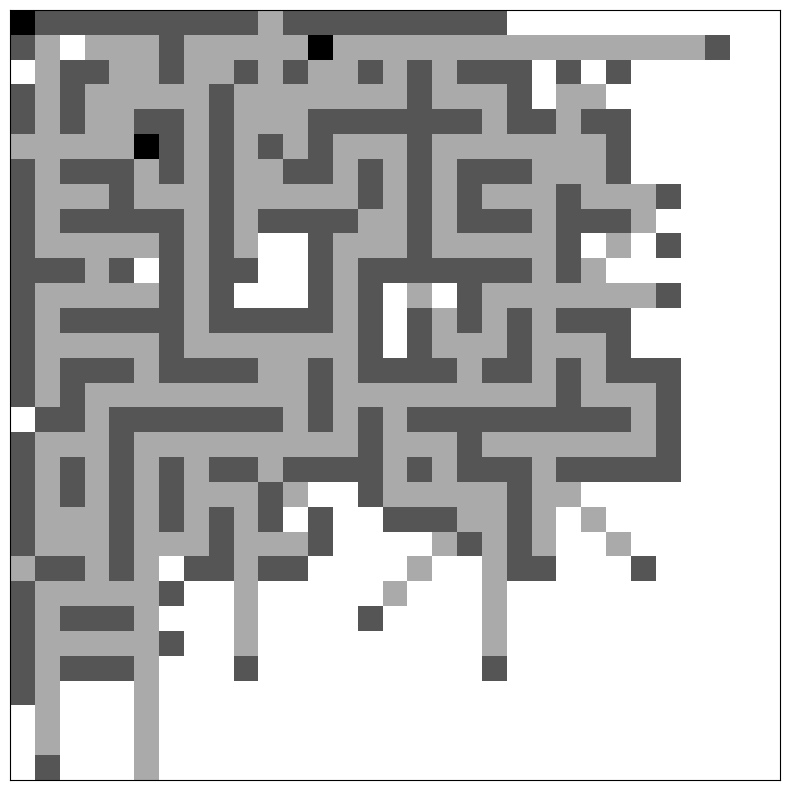

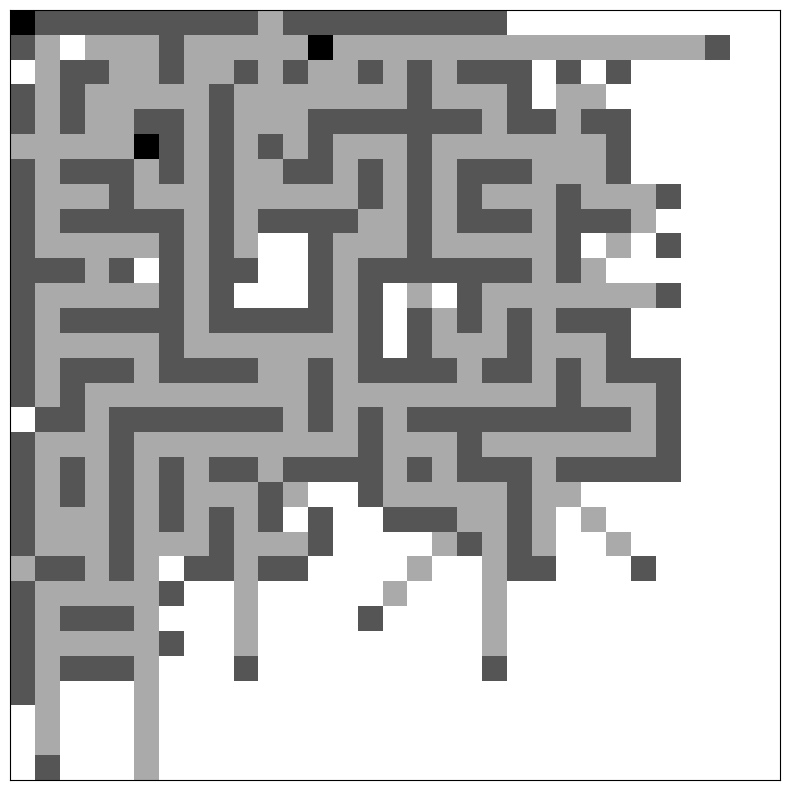

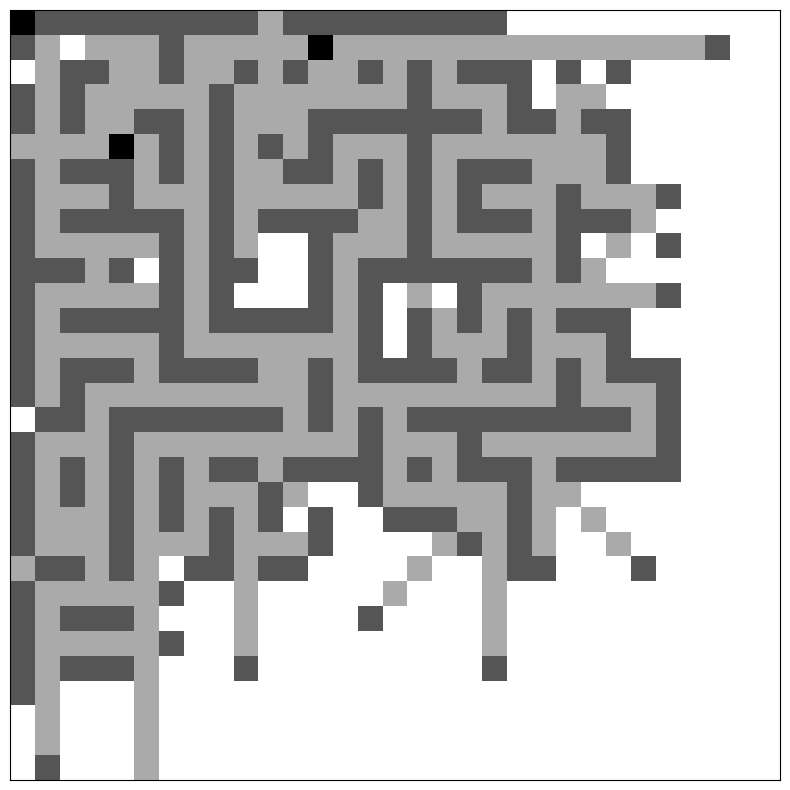

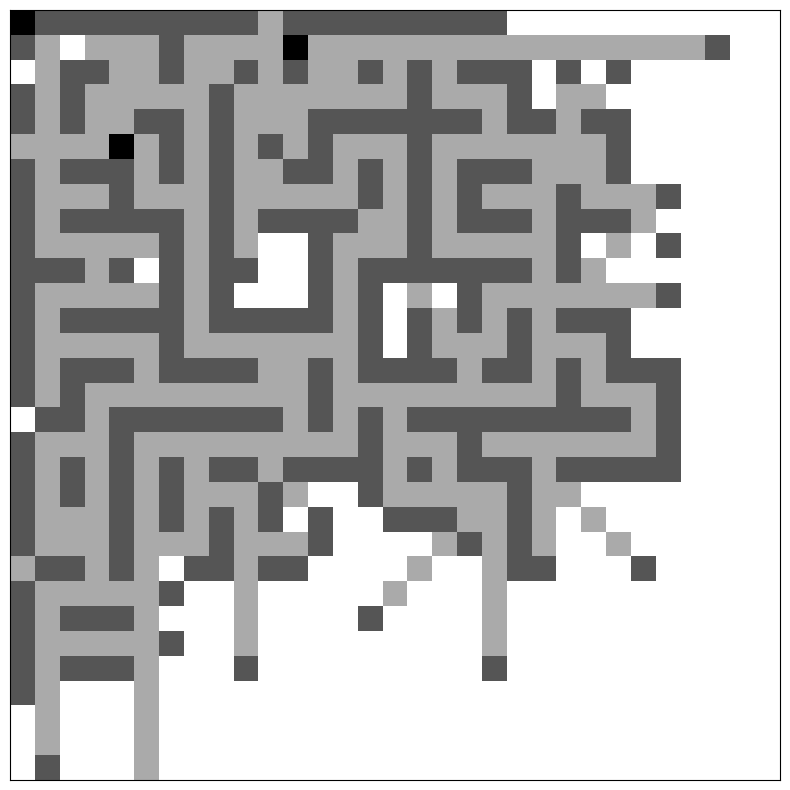

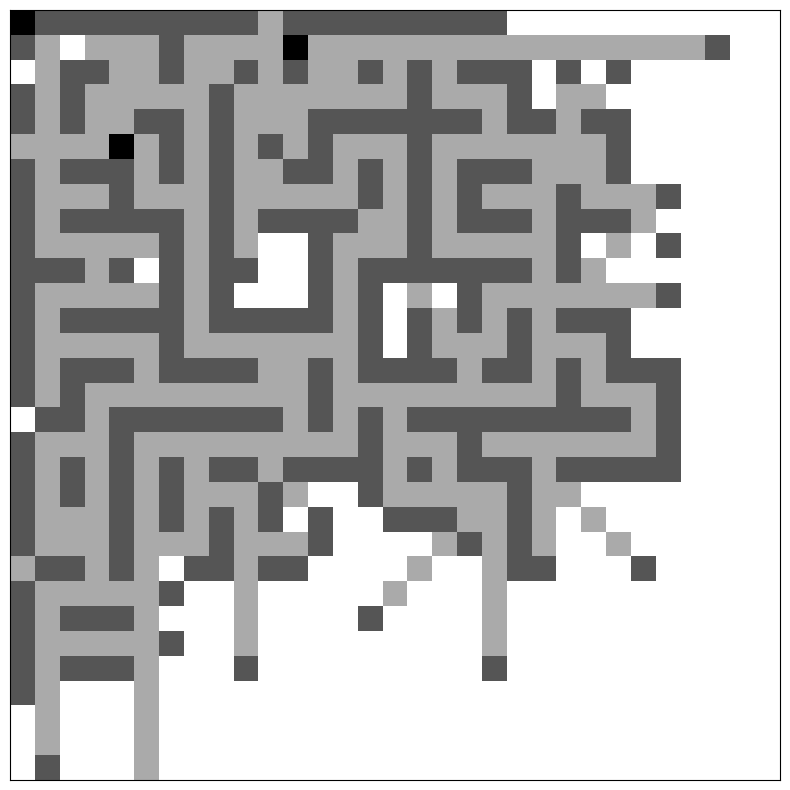

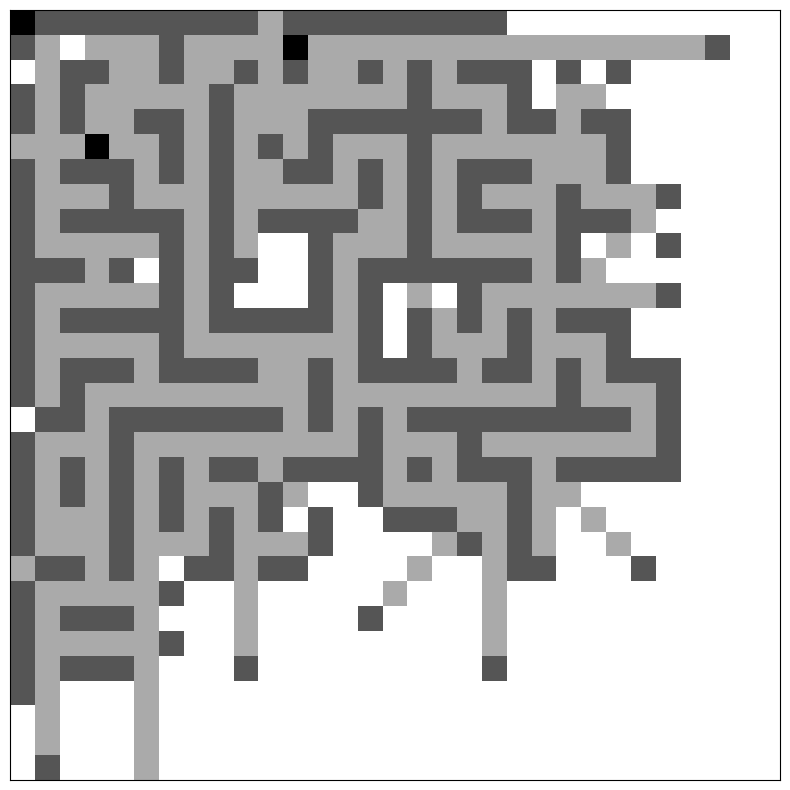

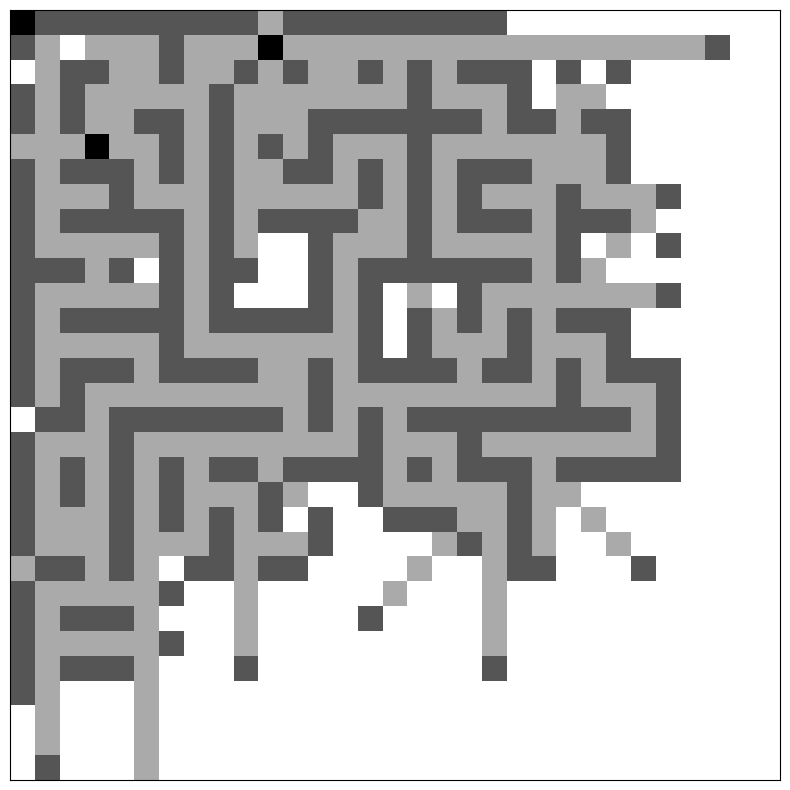

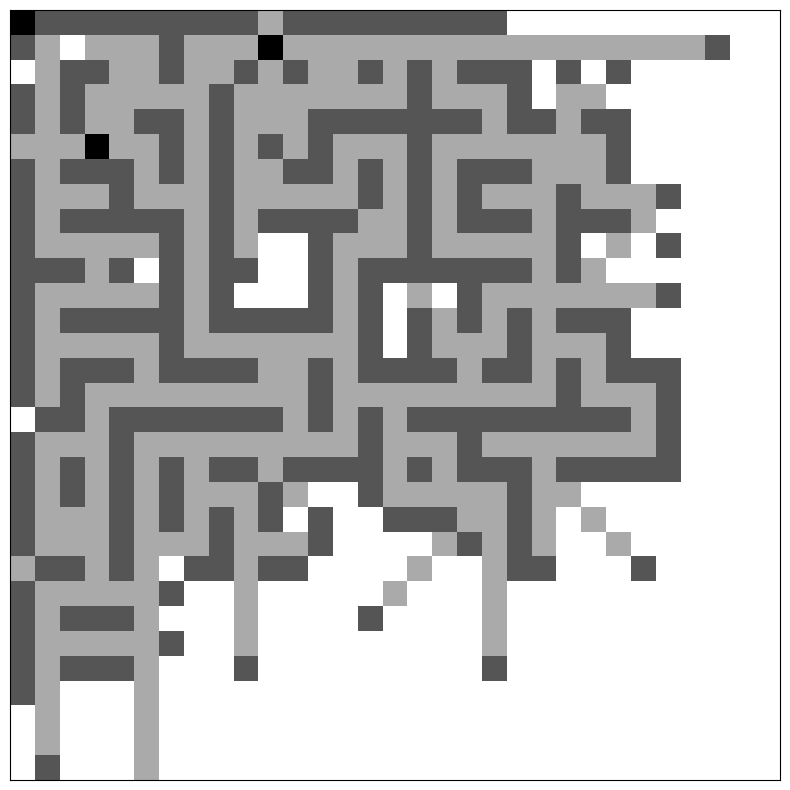

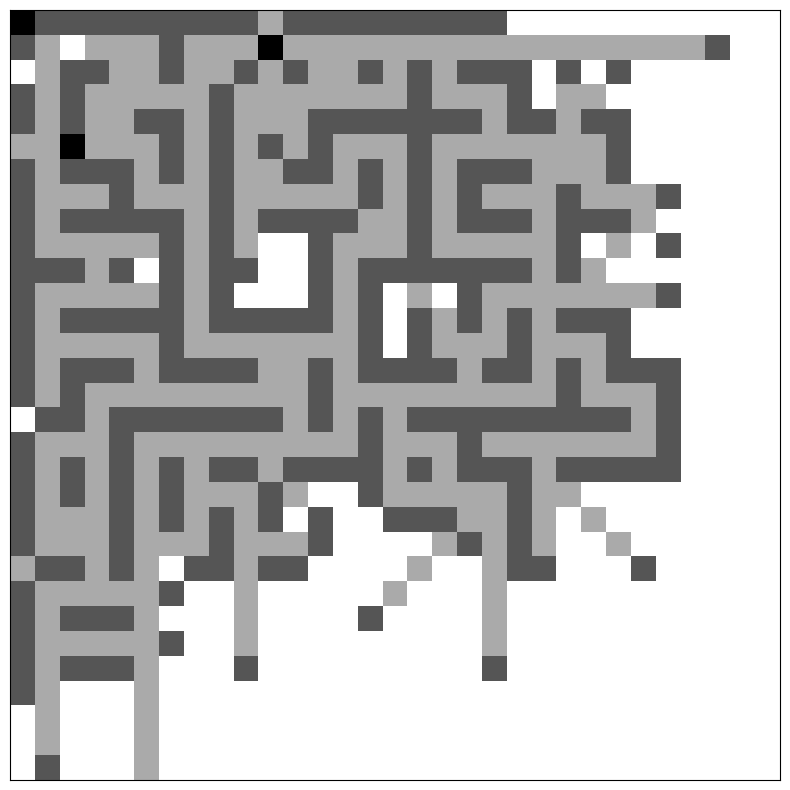

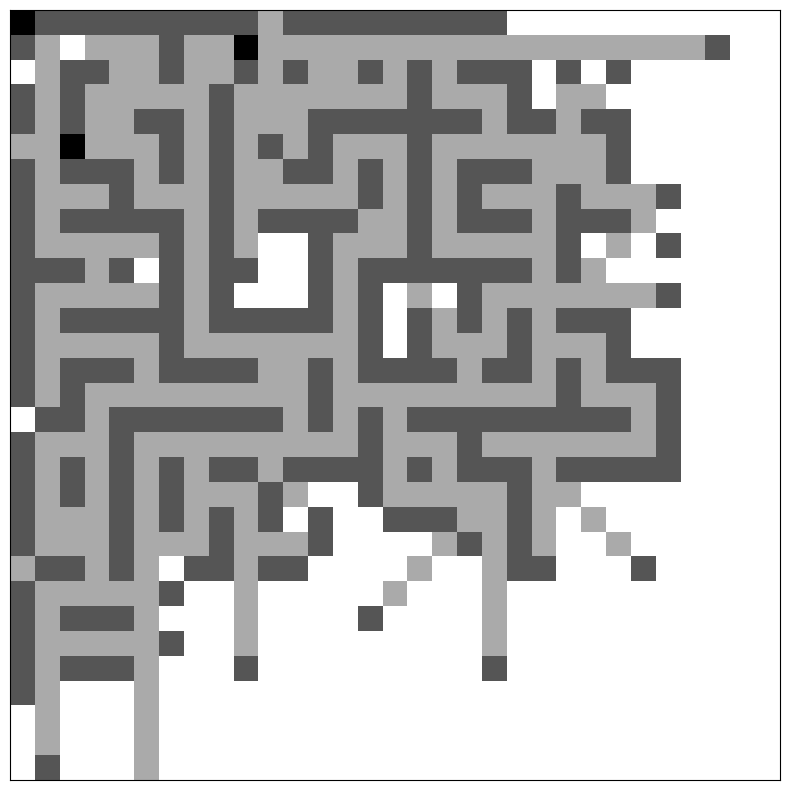

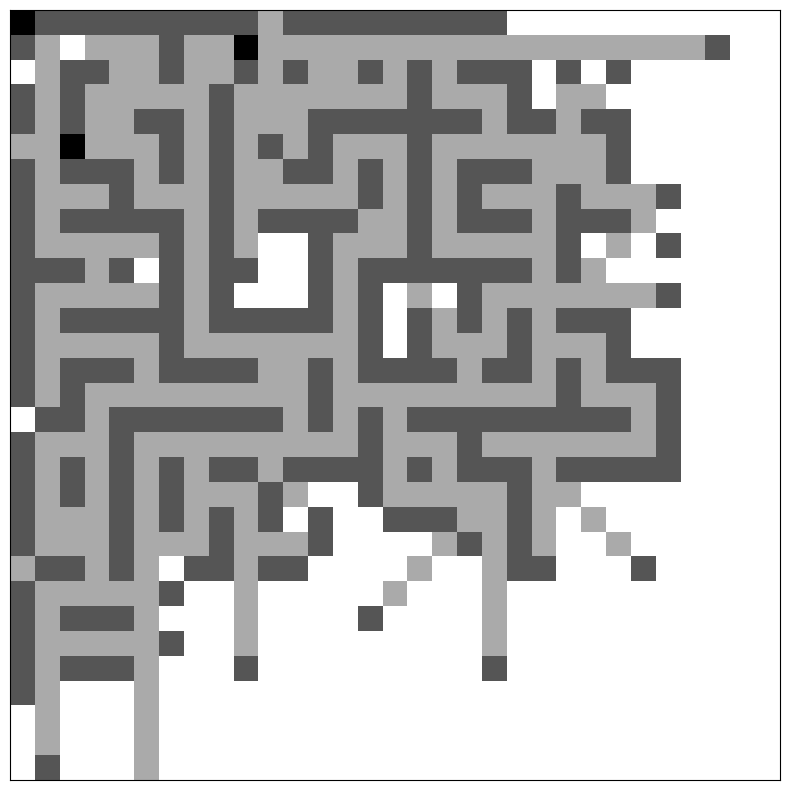

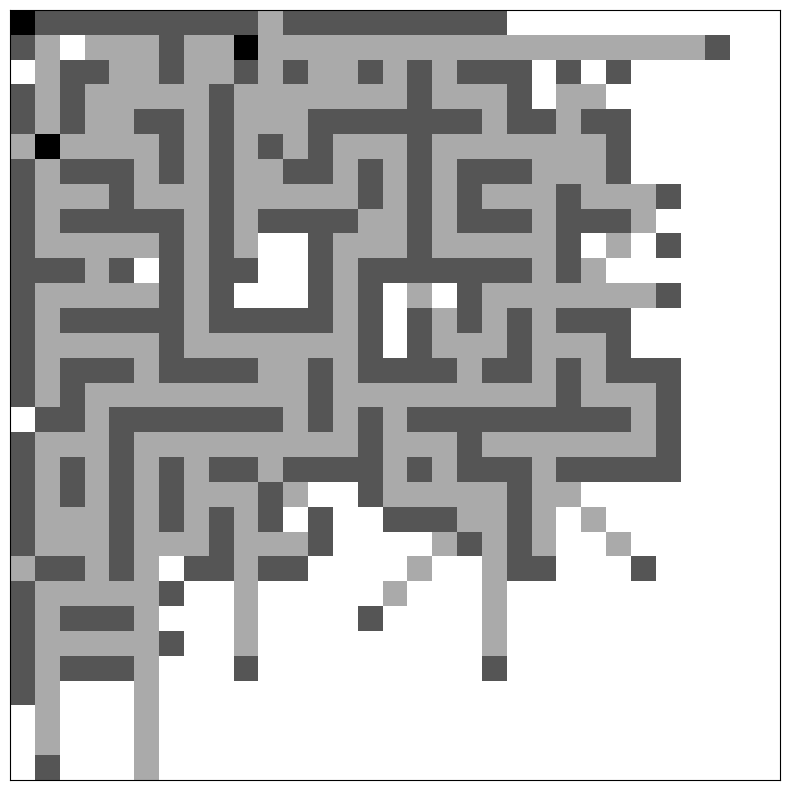

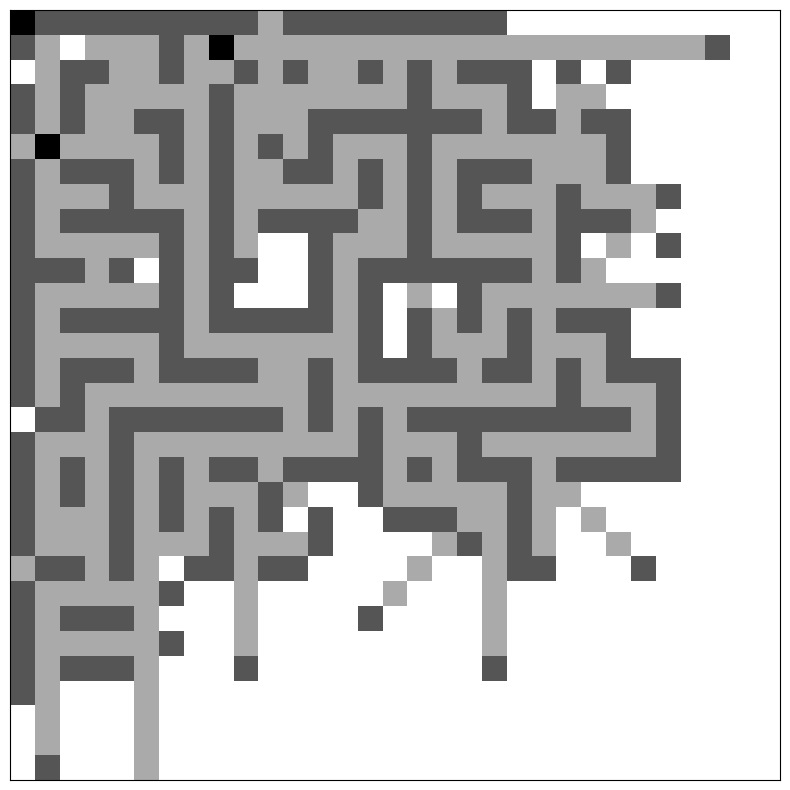

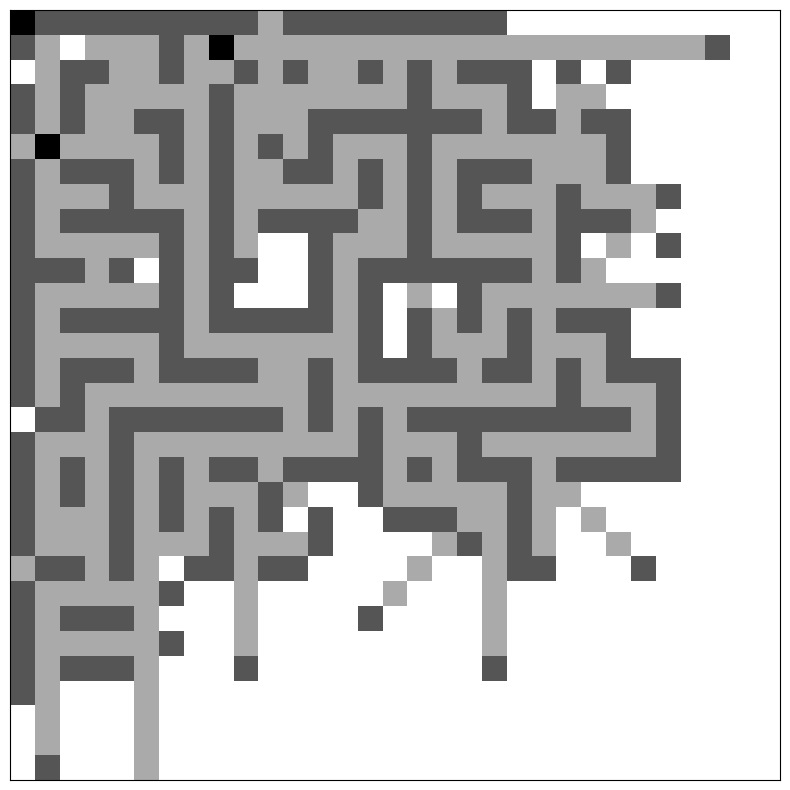

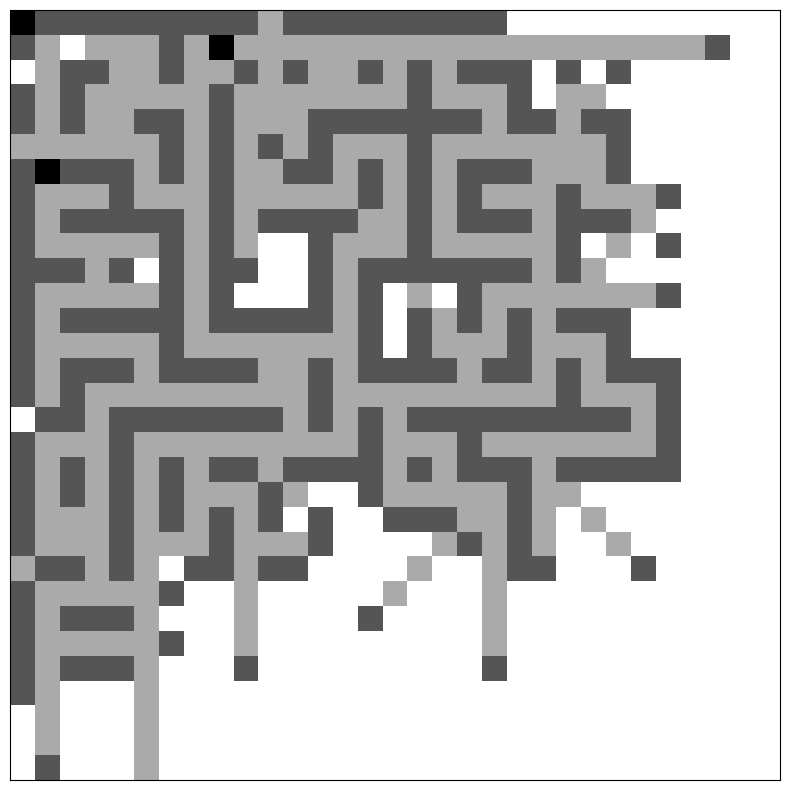

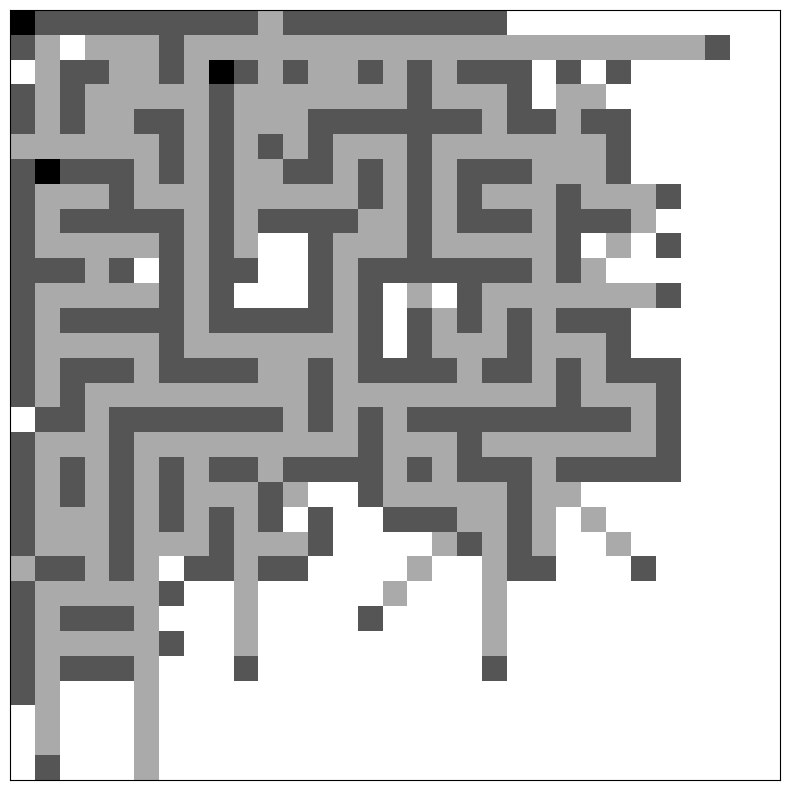

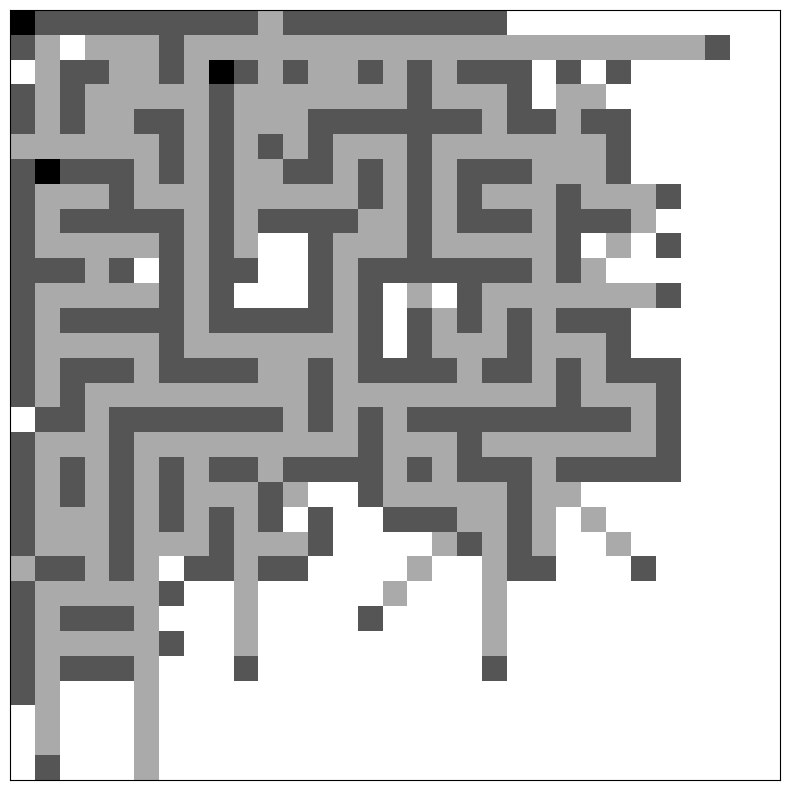

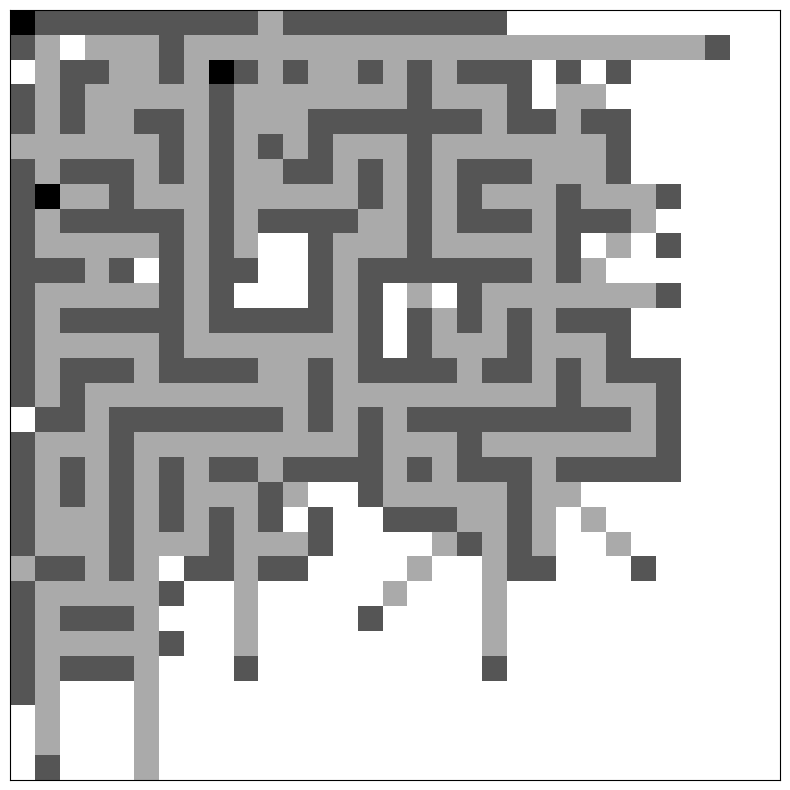

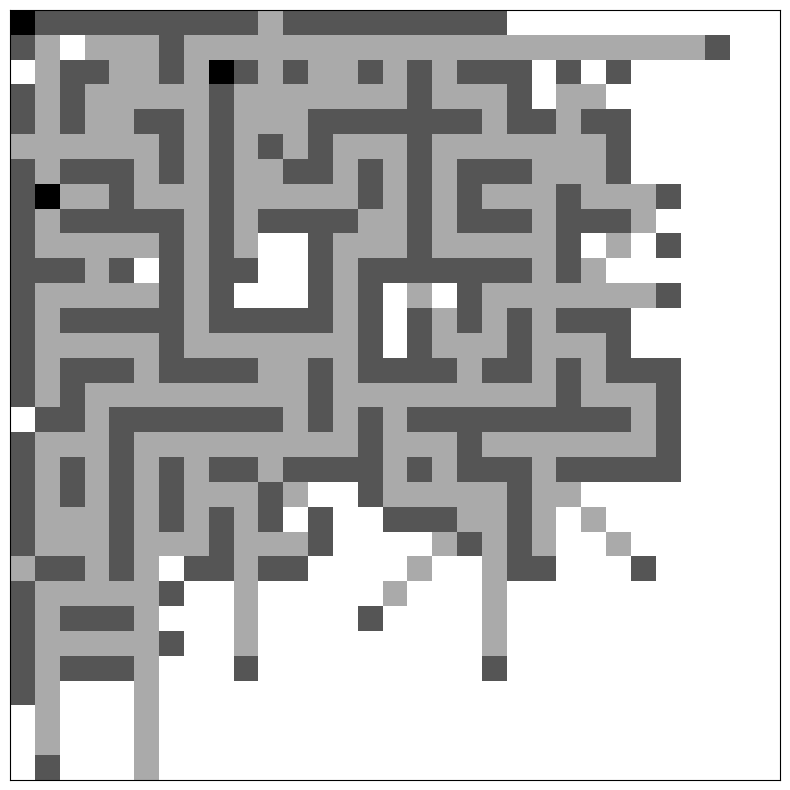

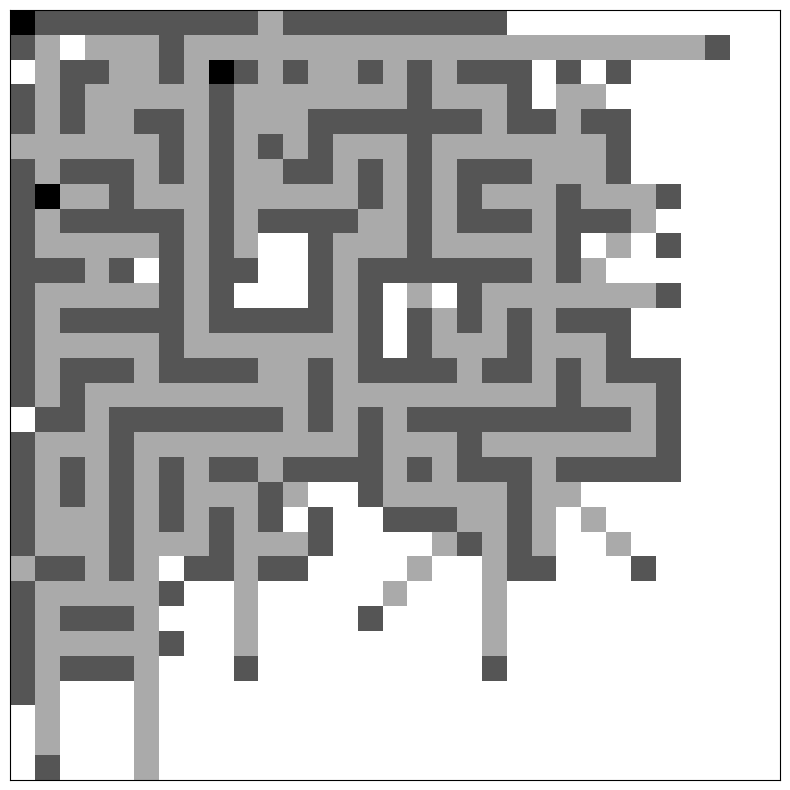

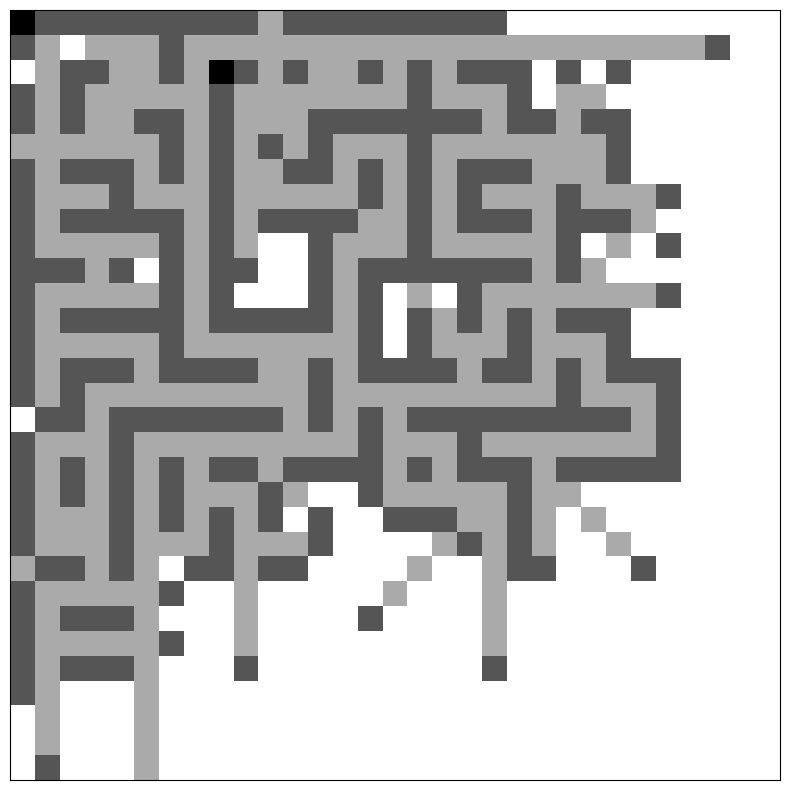

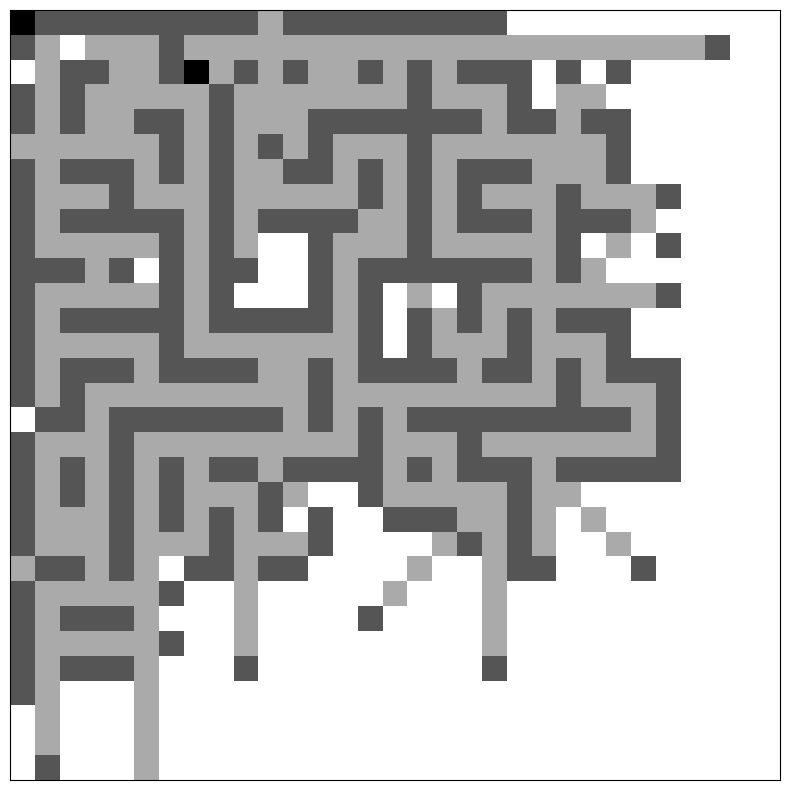

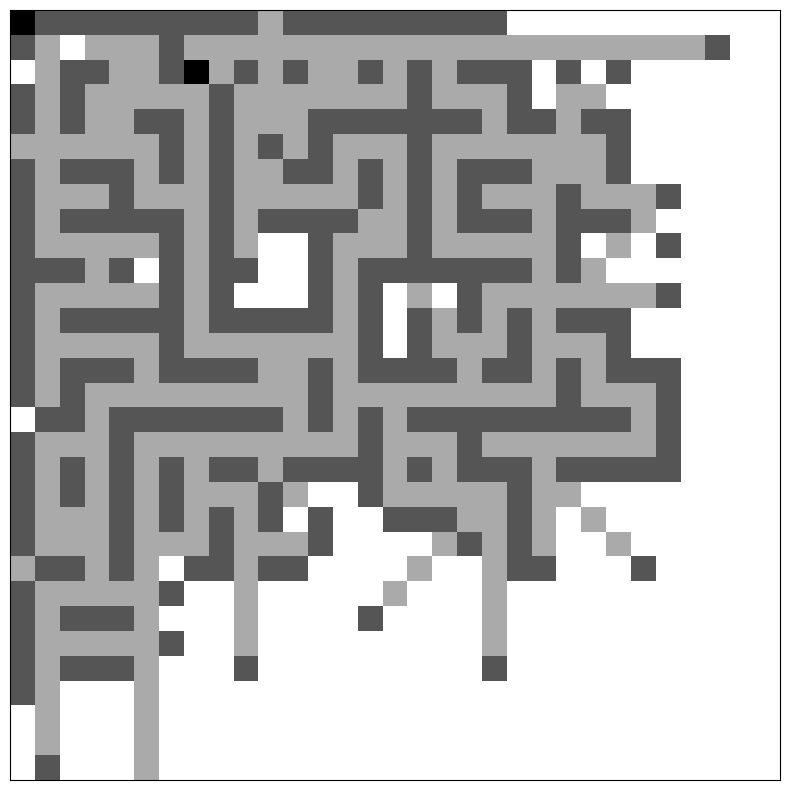

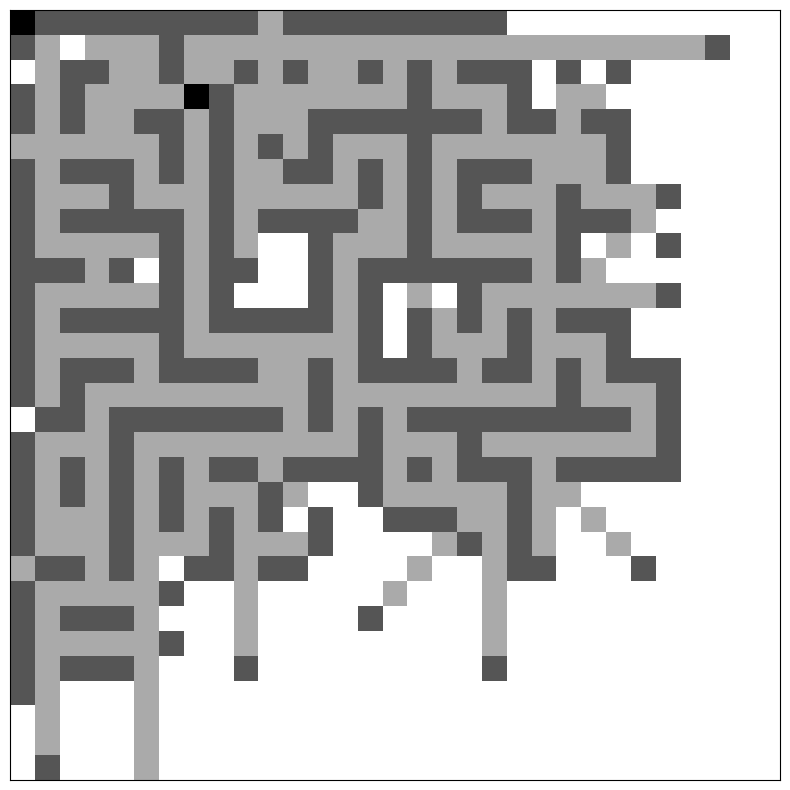

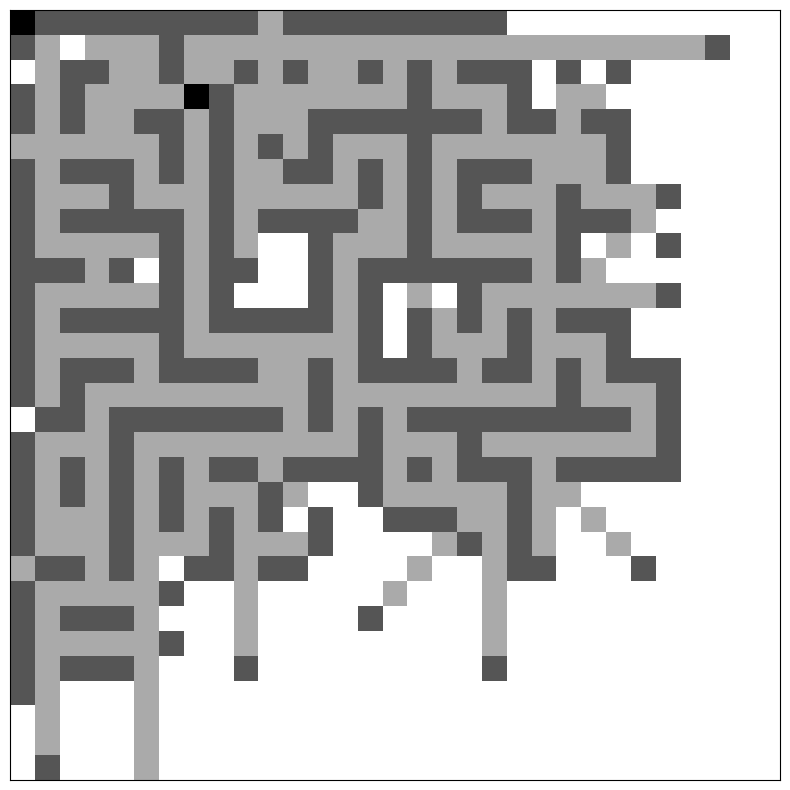

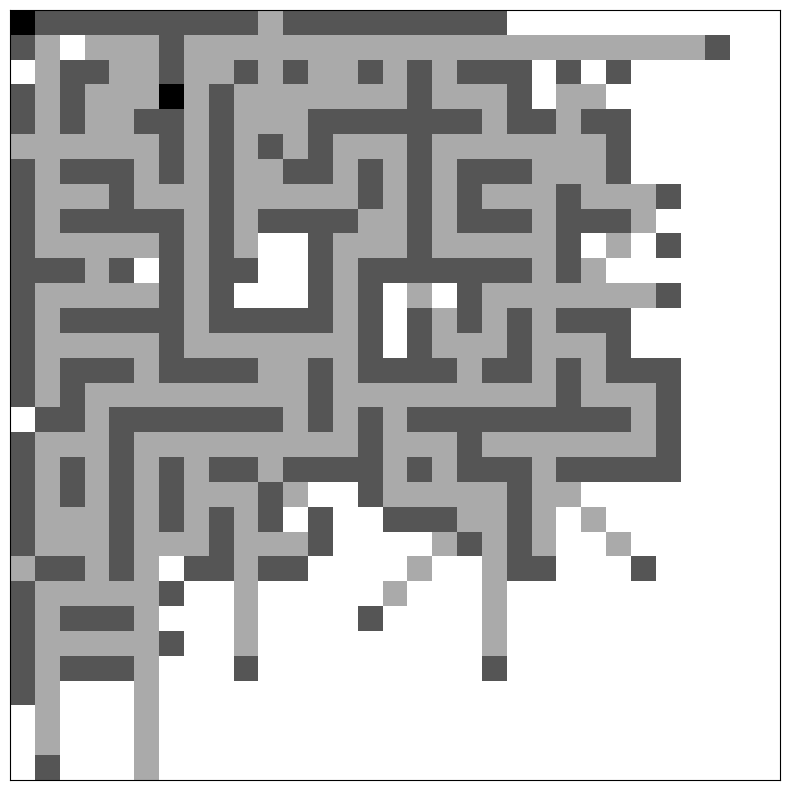

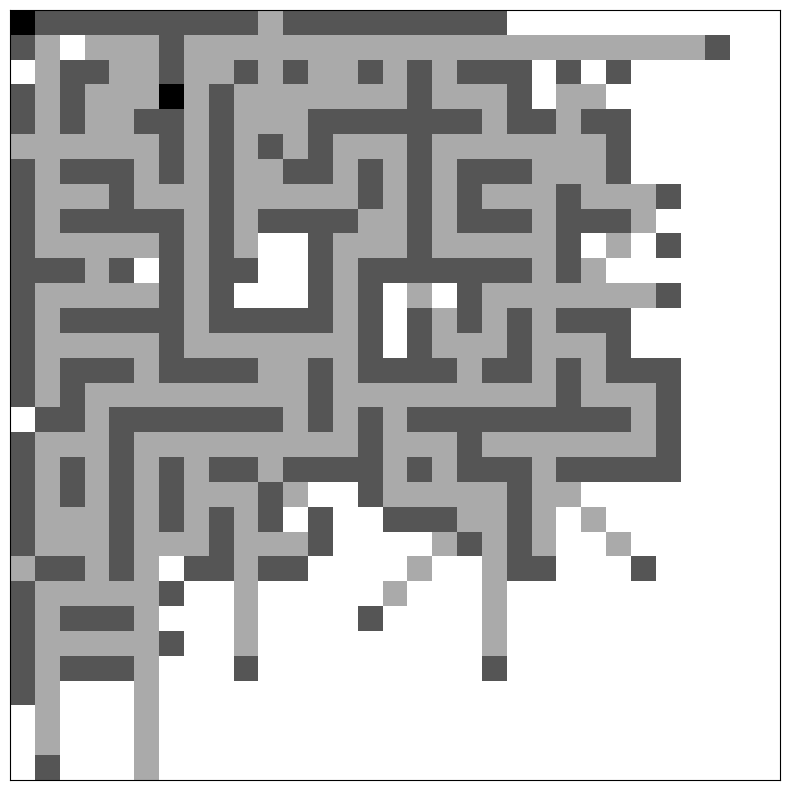

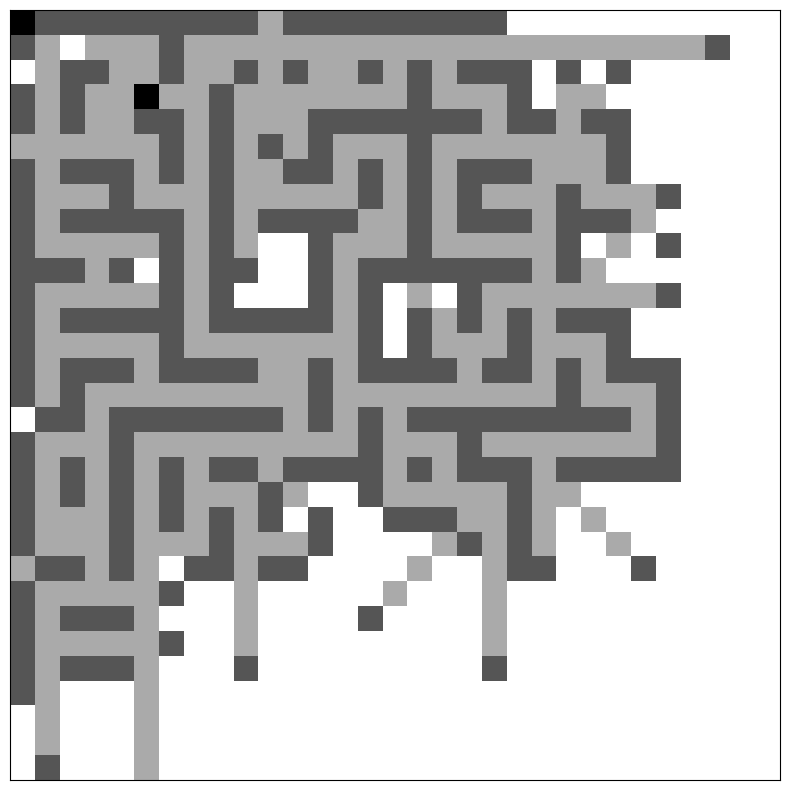

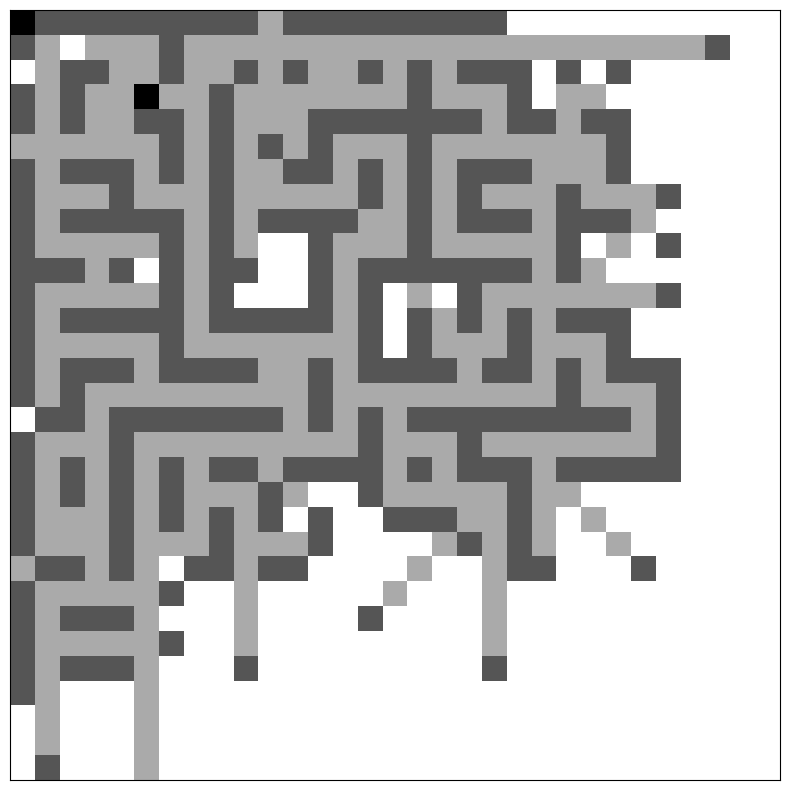

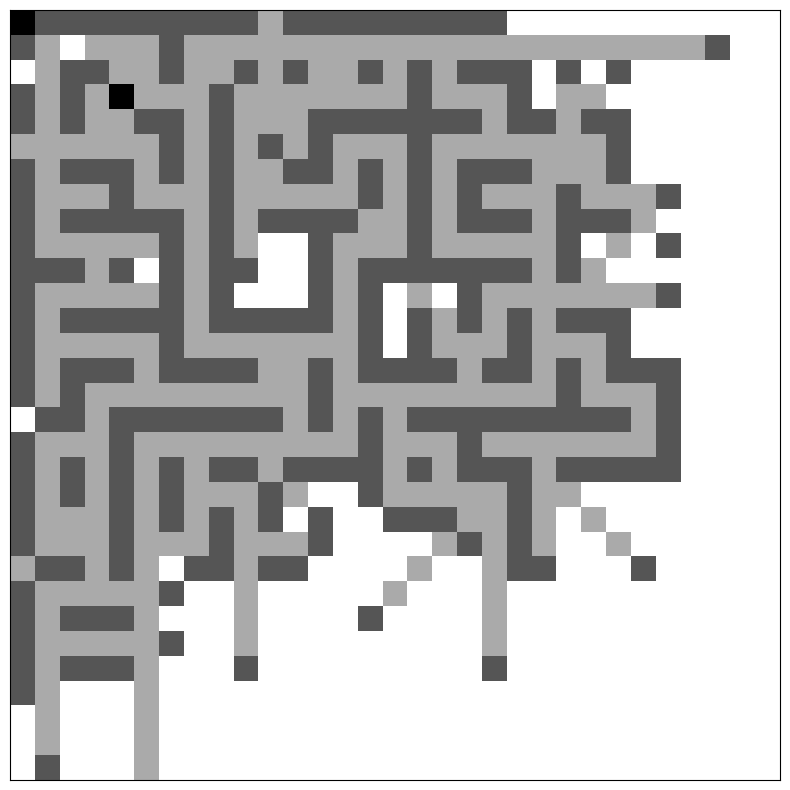

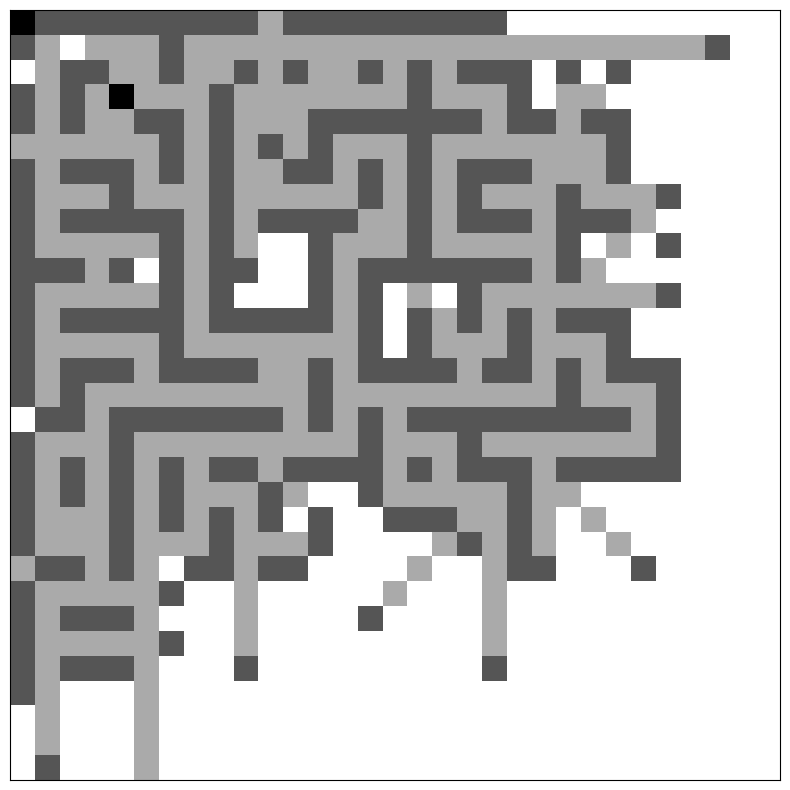

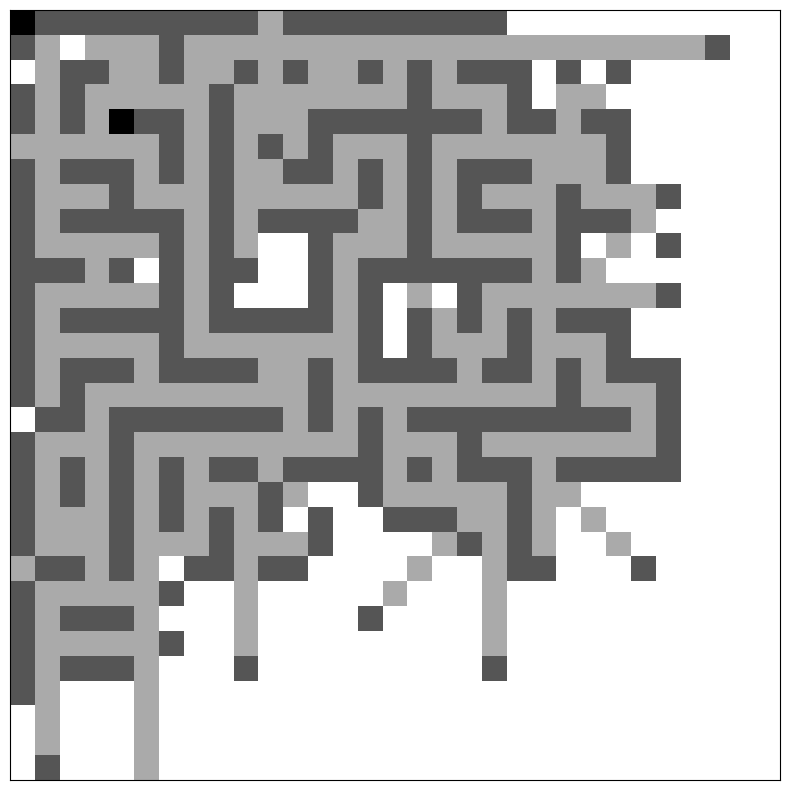

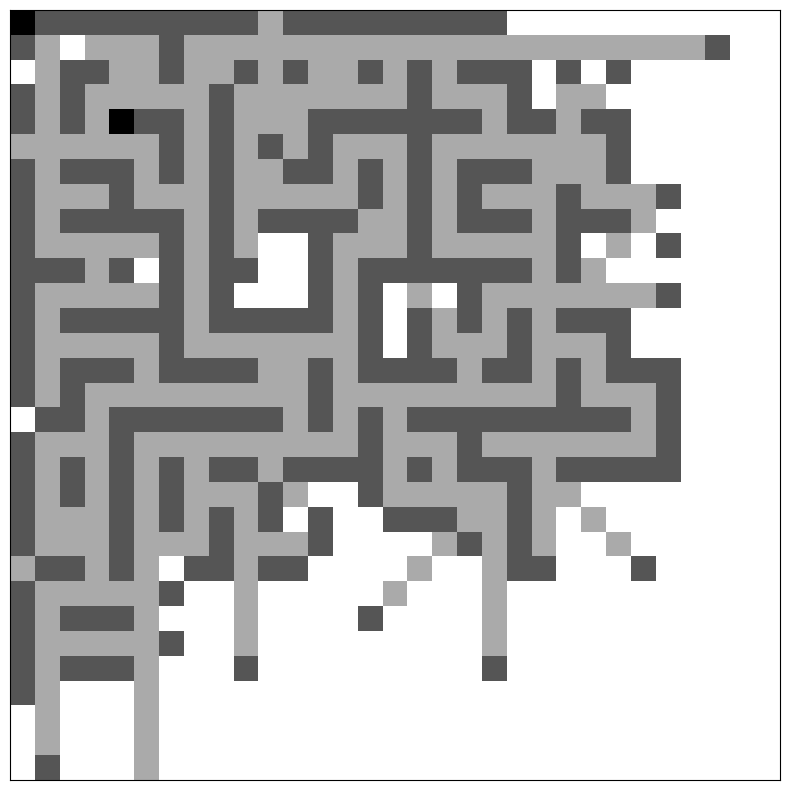

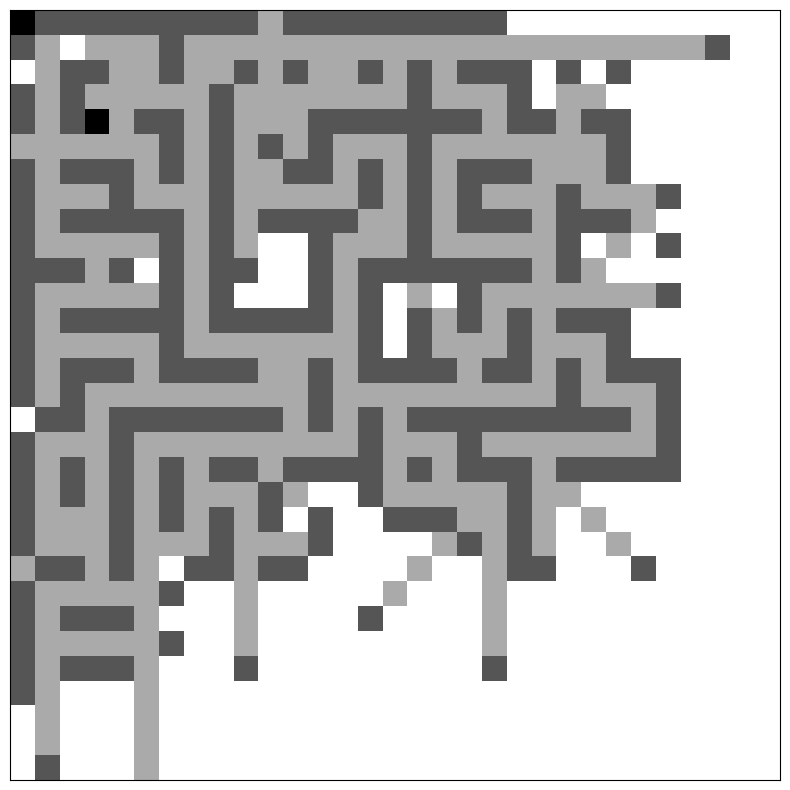

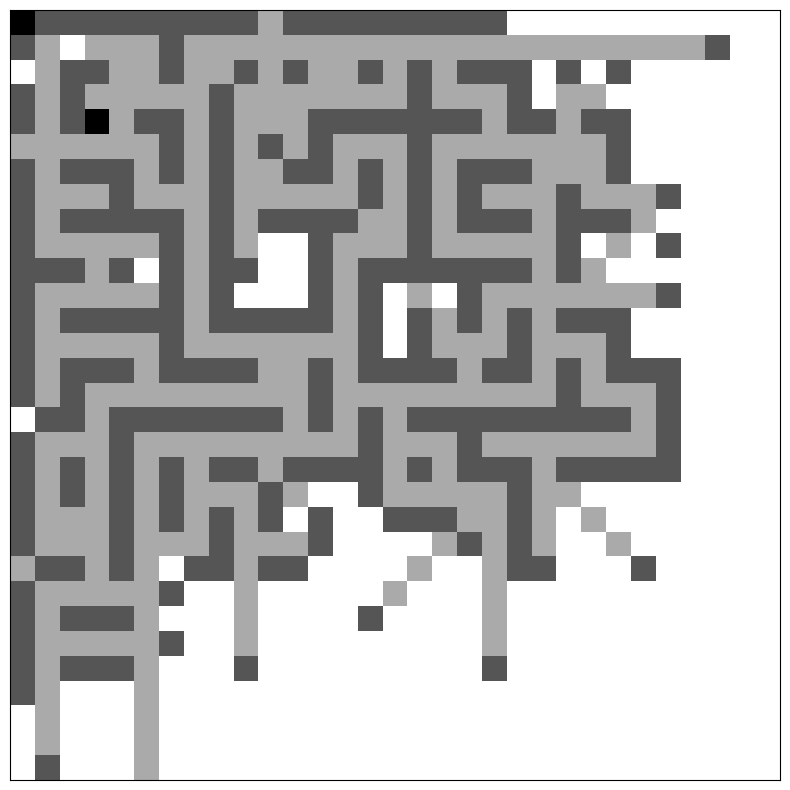

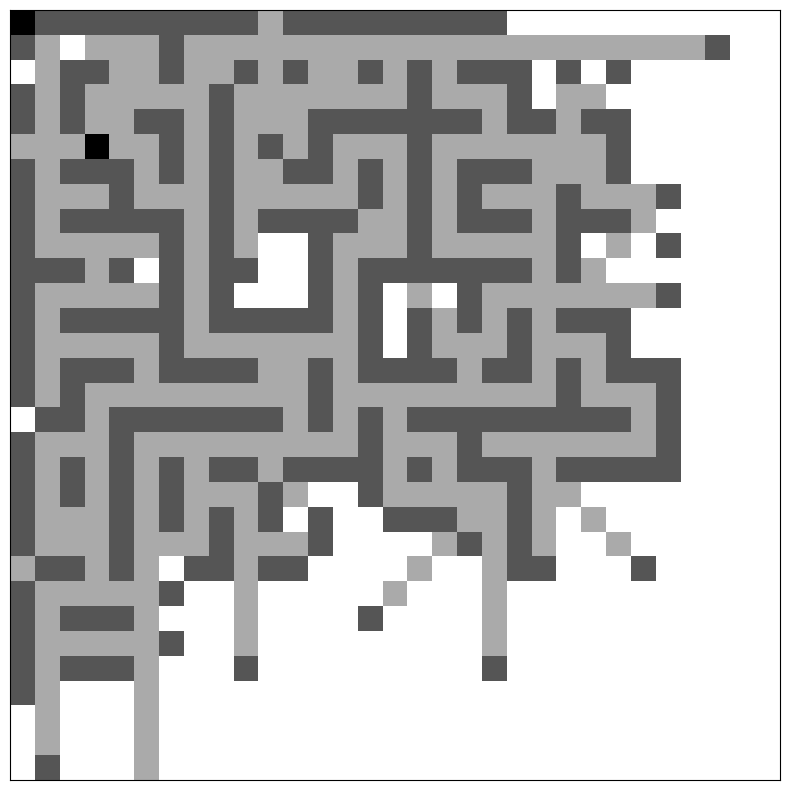

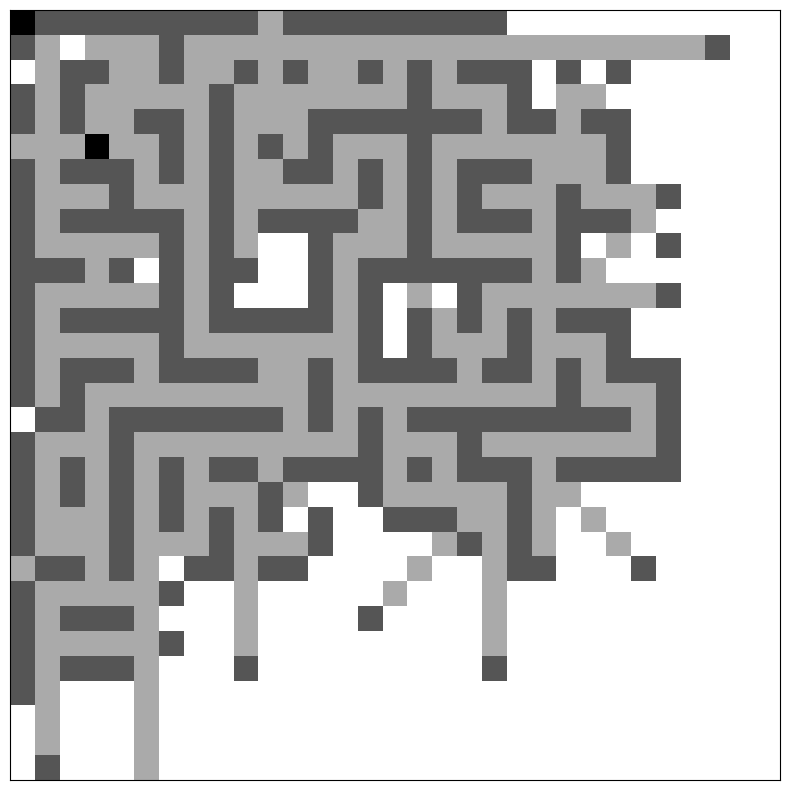

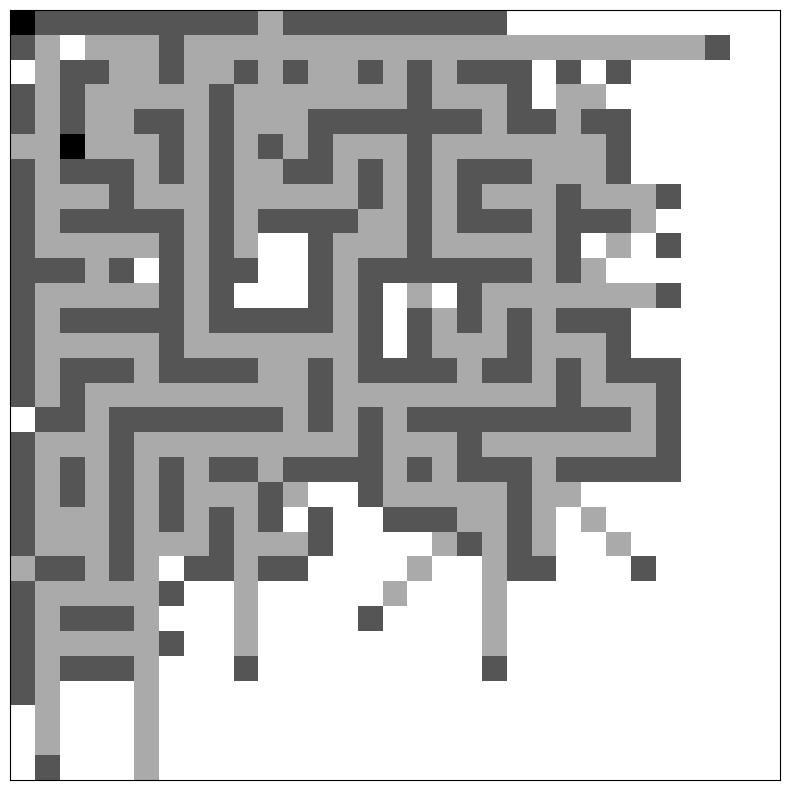

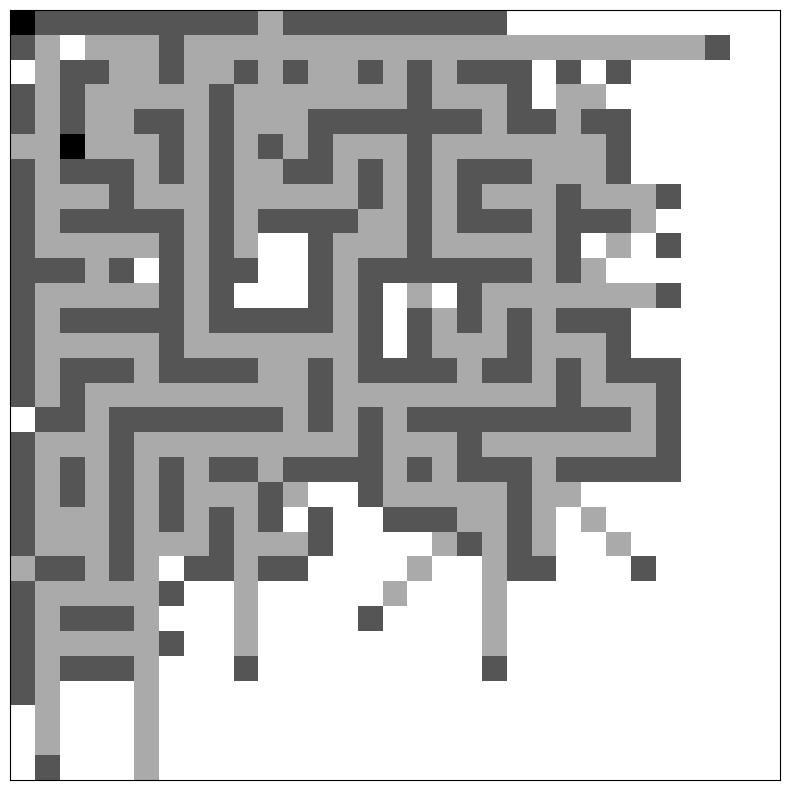

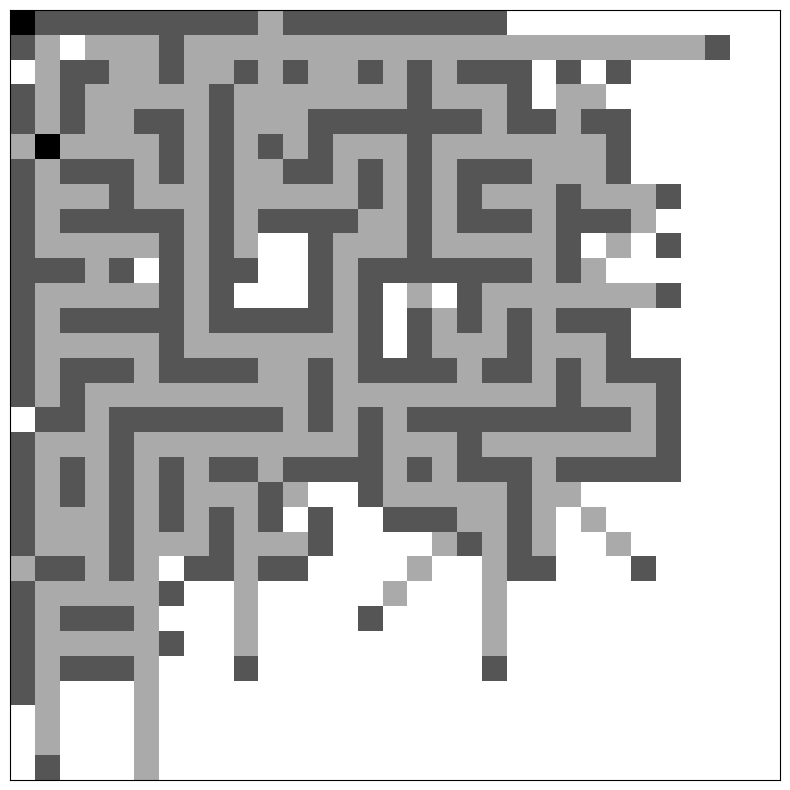

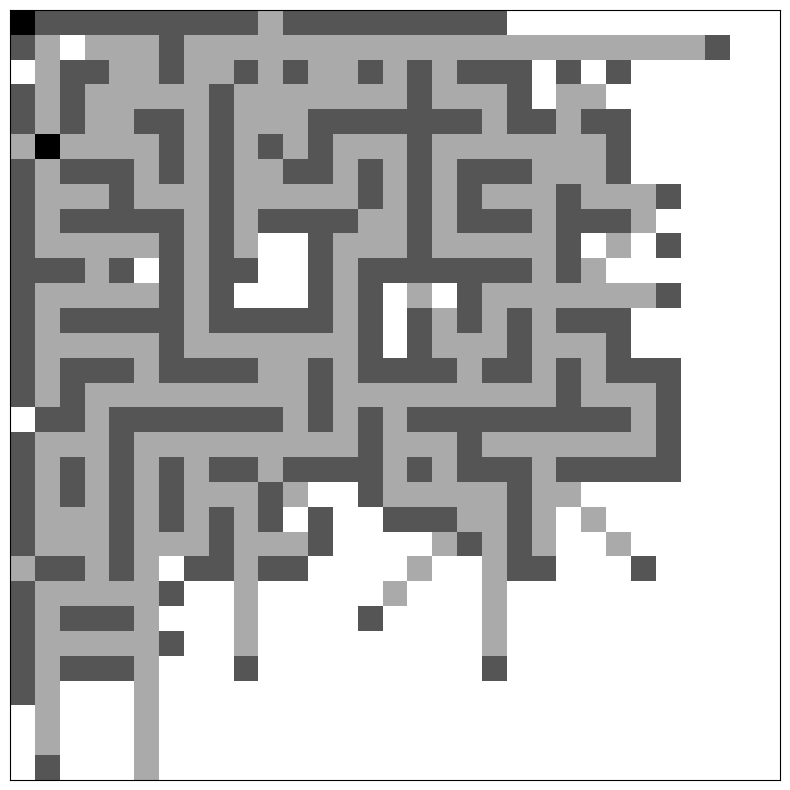

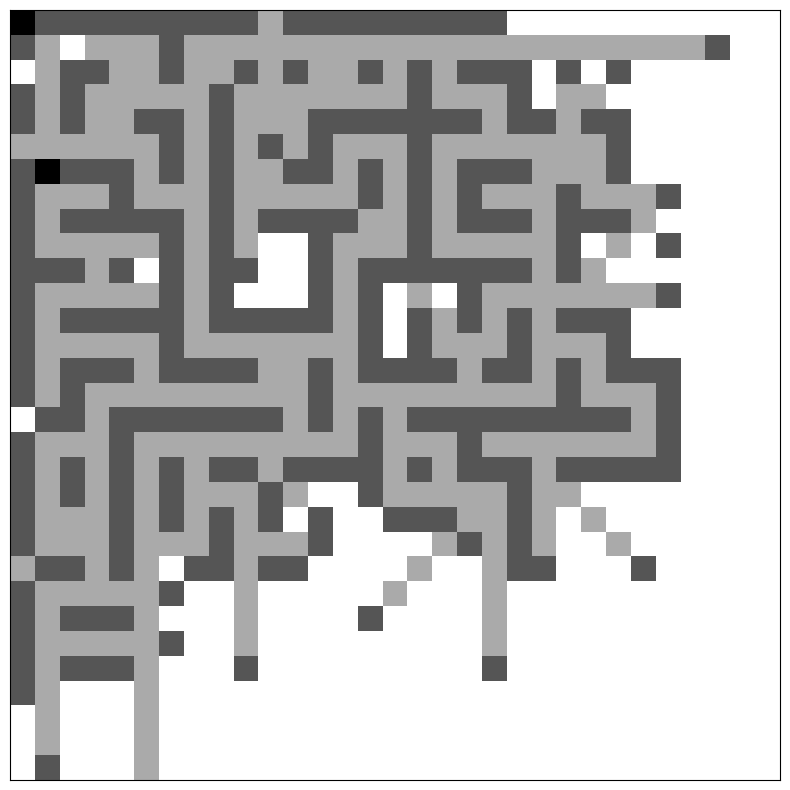

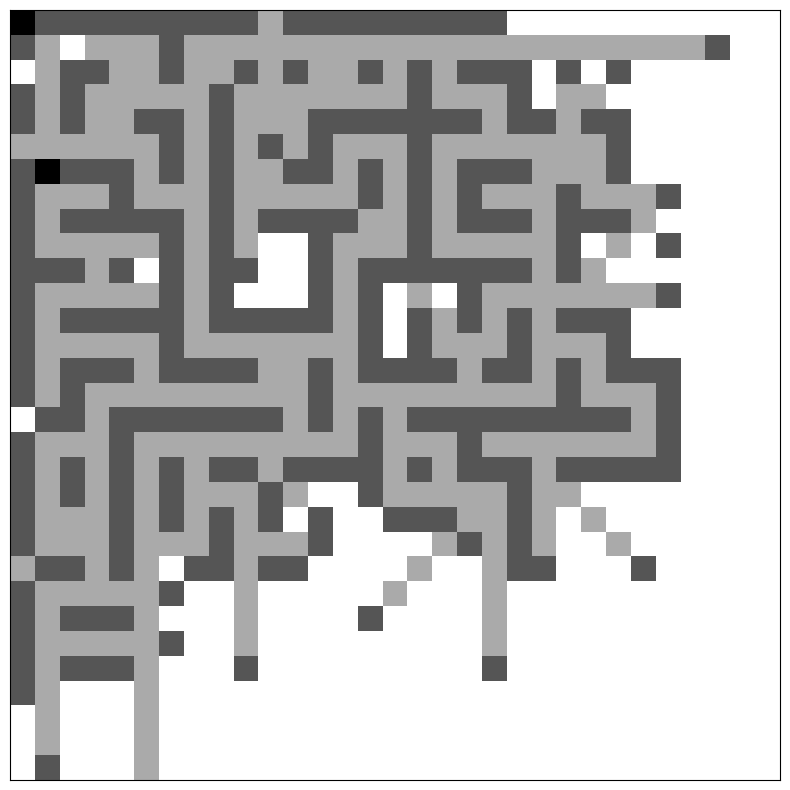

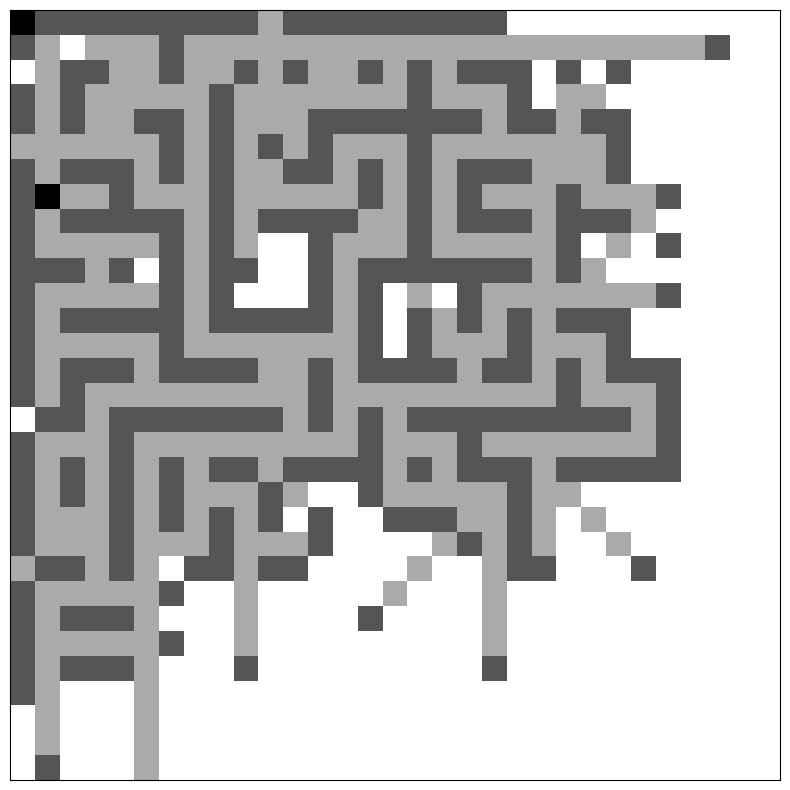

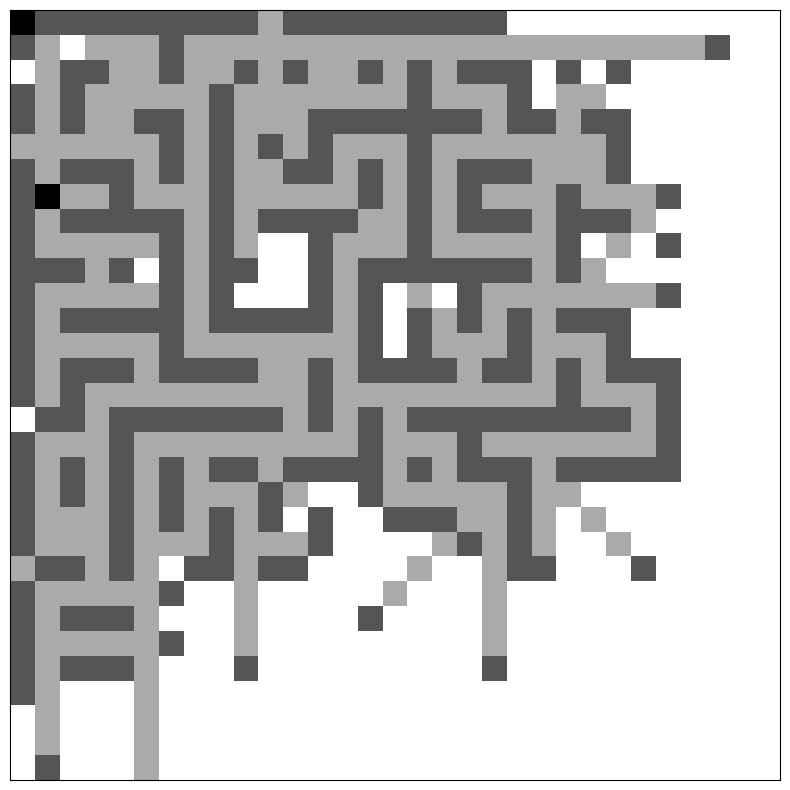

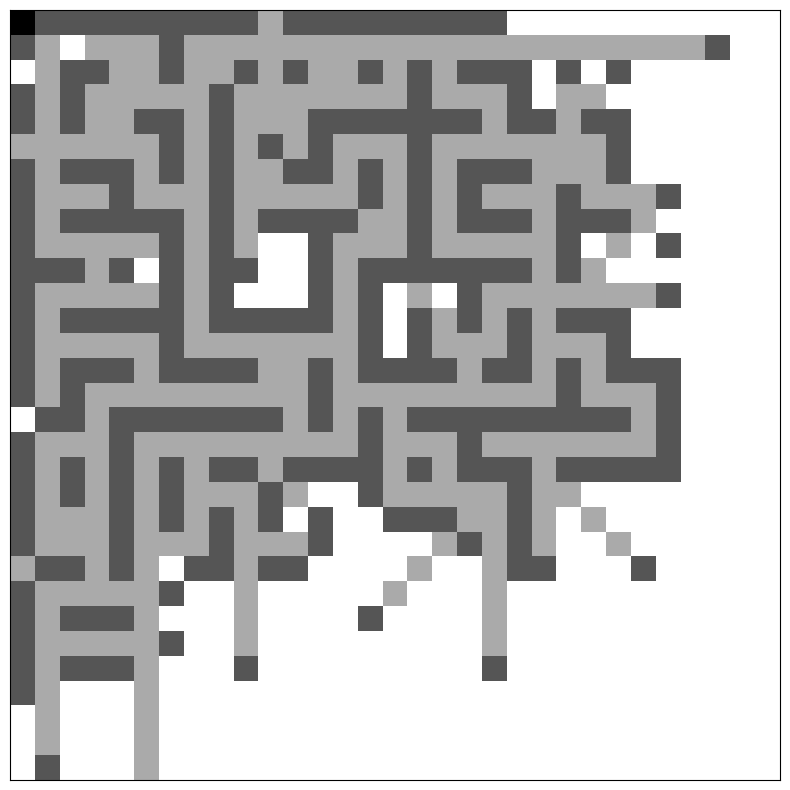

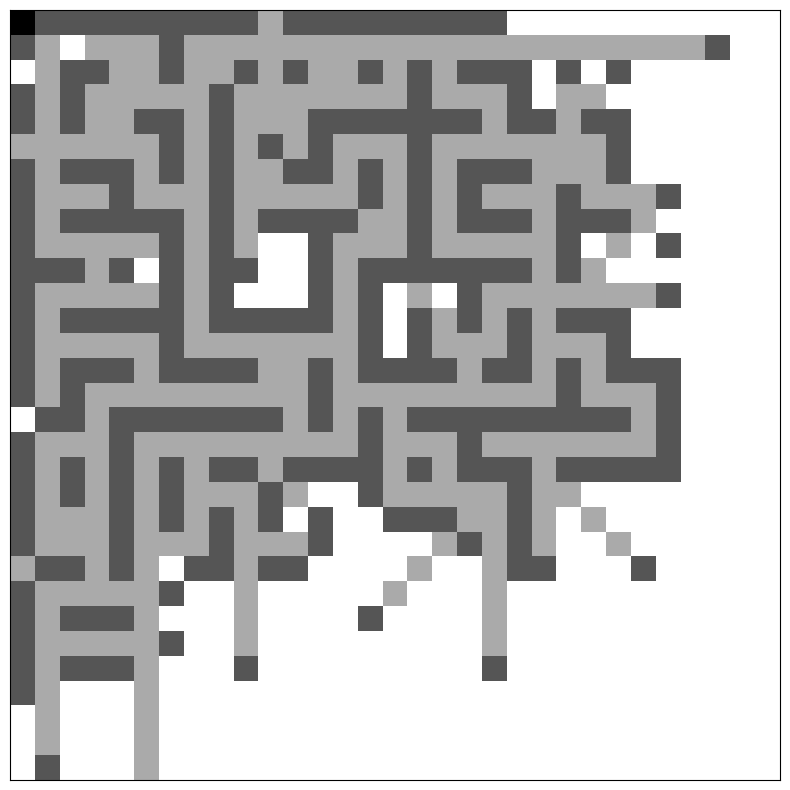

[[ 2  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1]
 [ 1  0 -1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1 -1 -1]
 [-1  0  1  1  0  0  1  0  0  1  0  1  0  0  1  0  1  0  1  1  1 -1  1 -1
   1 -1 -1 -1 -1 -1 -1]
 [ 1  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  1 -1  0  0
  -1 -1 -1 -1 -1 -1 -1]
 [ 1  0  1  0  0  1  1  0  1  0  0  0  1  1  1  1  1  1  1  0  1  1  0  1
   1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  1  0  1  0  1  0  1  0  0  0  1  0  0  0  0  0  0  0
   1 -1 -1 -1 -1 -1 -1]
 [ 1  0  1  1  1  0  1  0  1  0  0  1  1  0  1  0  1  0  1  1  1  0  0  0
   1 -1 -1 -1 -1 -1 -1]
 [ 1  0  0  0  1  0  0  0  1  0  0  0  0  0  1  0  1  0  1  0  0  0  1  0
   0  0  1 -1 -1 -1 -1]
 [ 1  0  1  1  1  1  1  0  1  0  1  1  1  1  0  0  1  0  1  1  1  0  1  1
   1  0 -1 -1 -1 -1 -1]
 [ 1  0  0  0  0  0  1  0  1  0 -1 -1  1  0  0  0  1  0  0  0  0  0  1 -1
   0 -1  1 -1 -1 -1 -1]
 [ 1  1  1  0  1 -1 

In [ ]:
num_agents = 10 # number of agents.
num_test = 1
res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=30, cols=30, obs_prob=0.85), agent_view_range=100, debug=True)

Solve the test_maze with 10 agents:

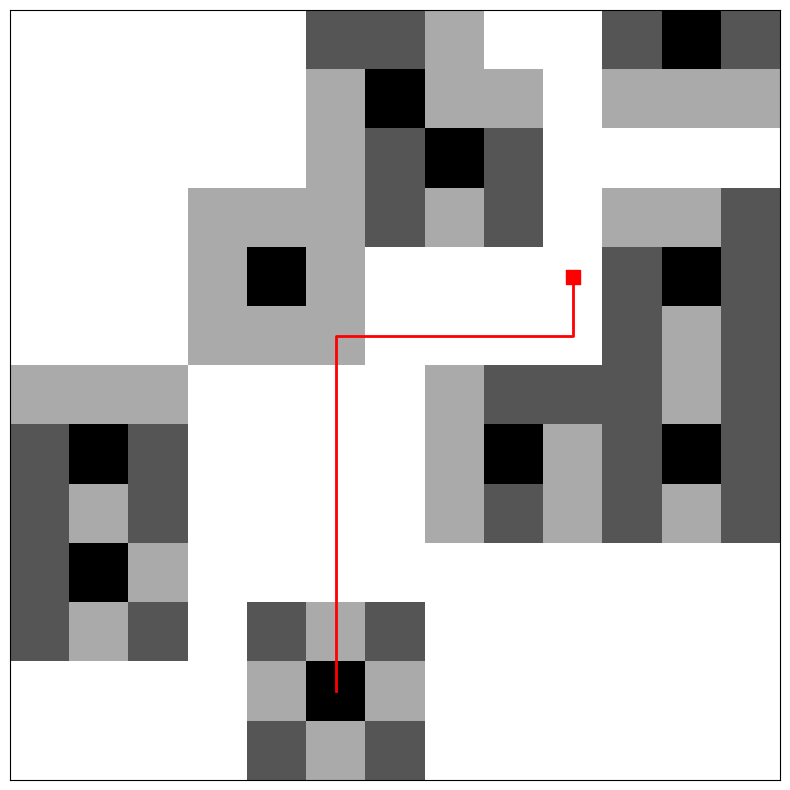

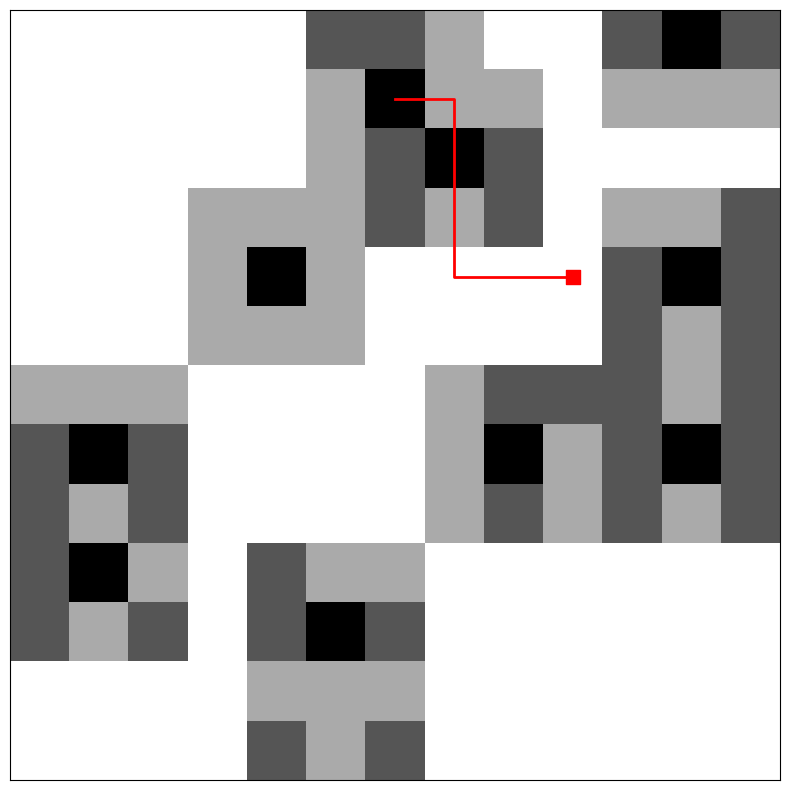

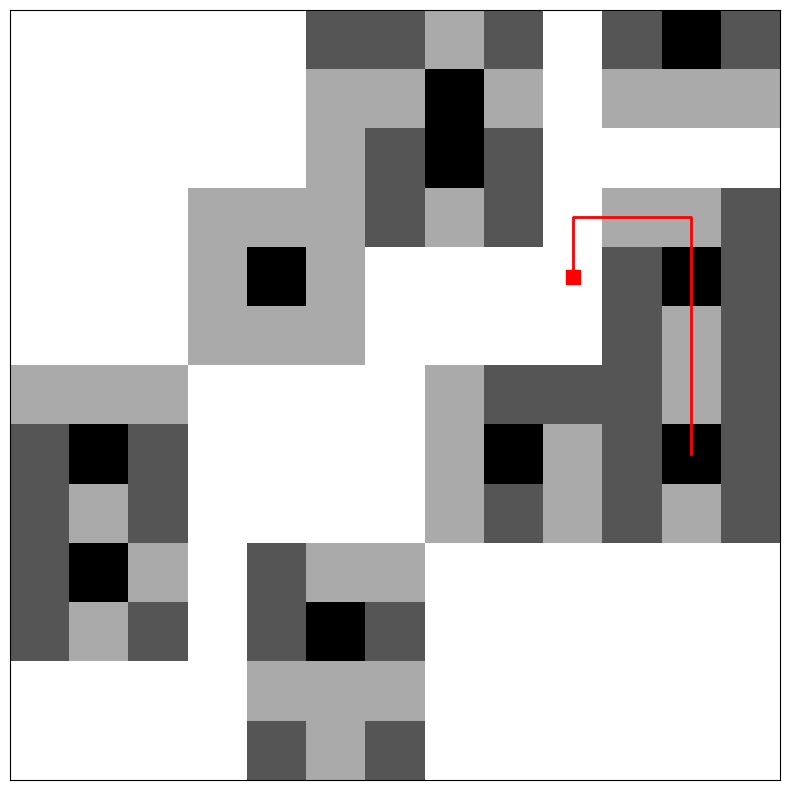

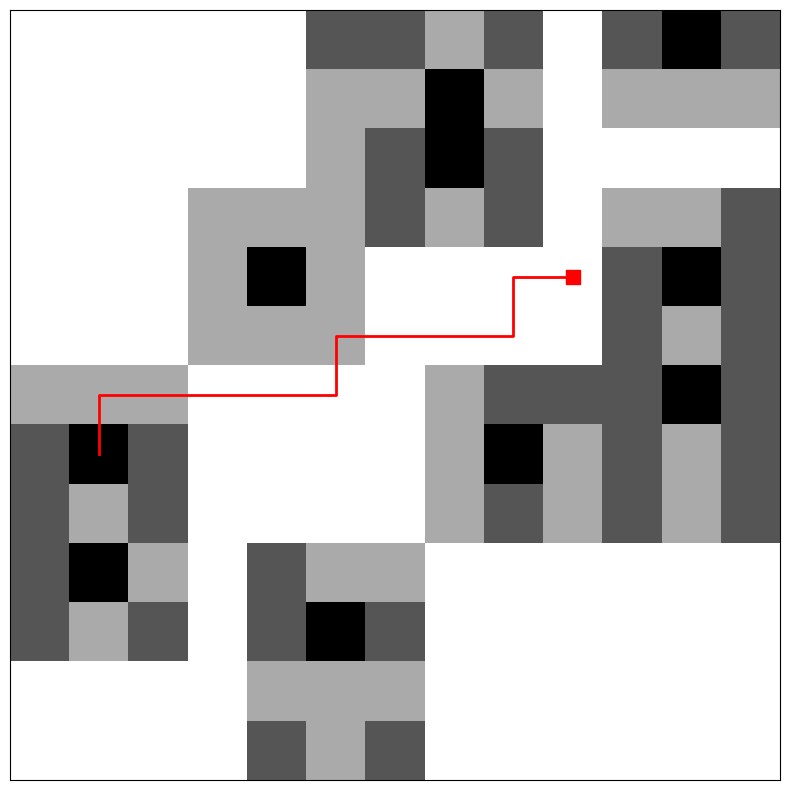

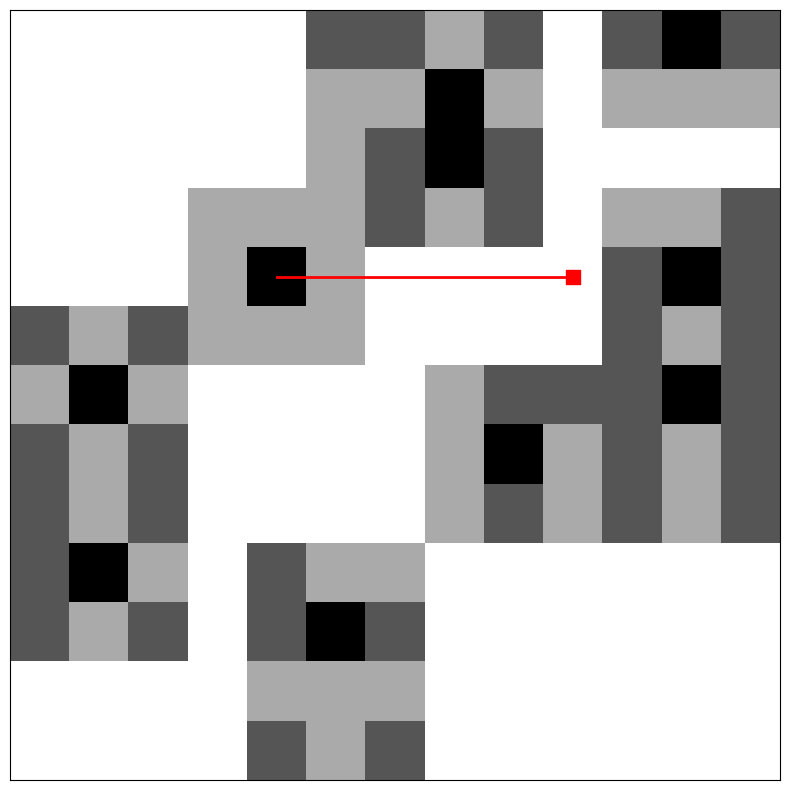

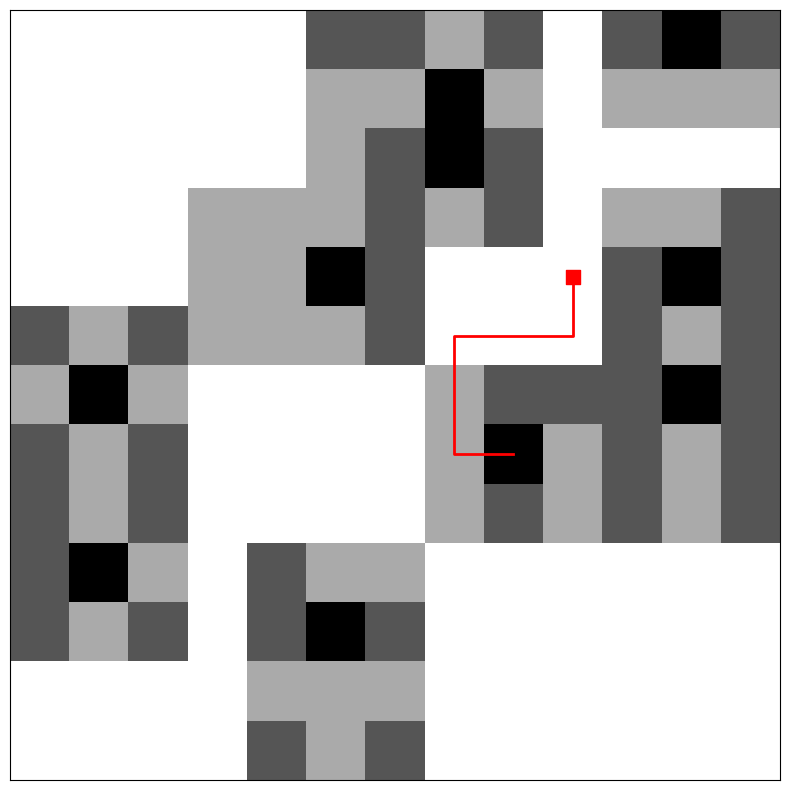

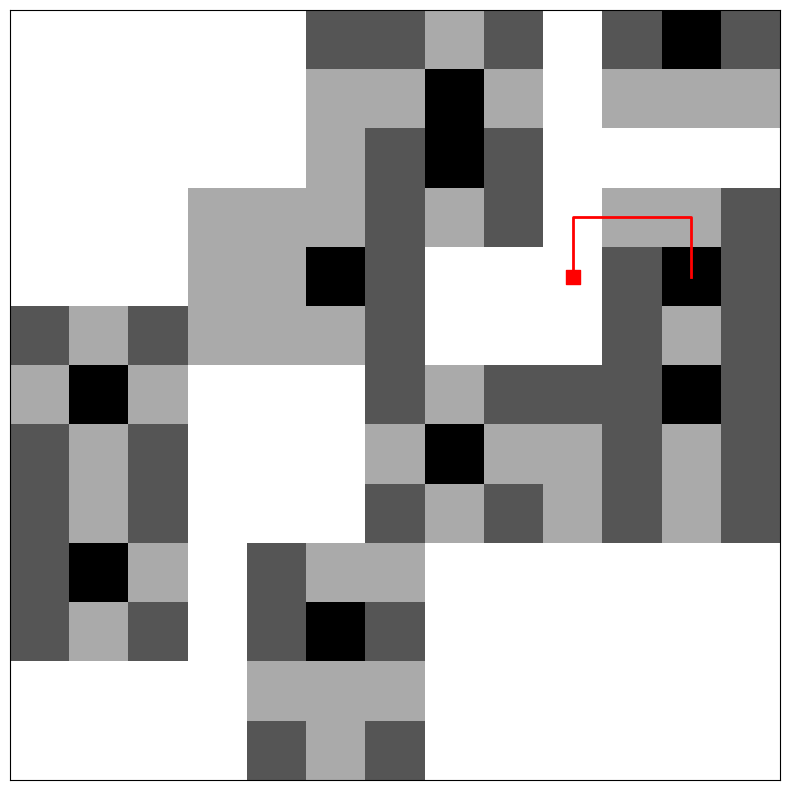

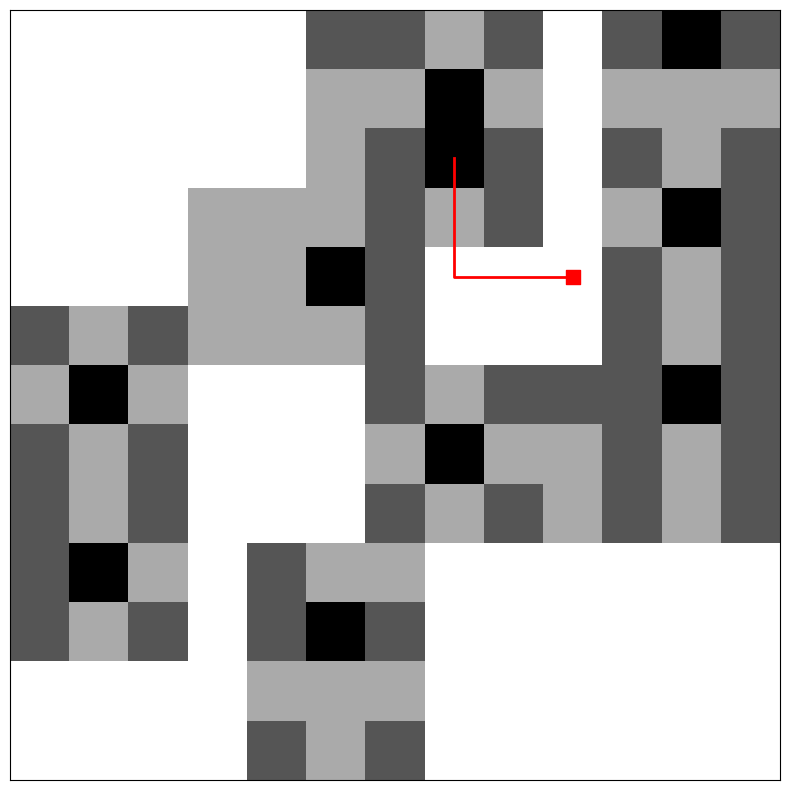

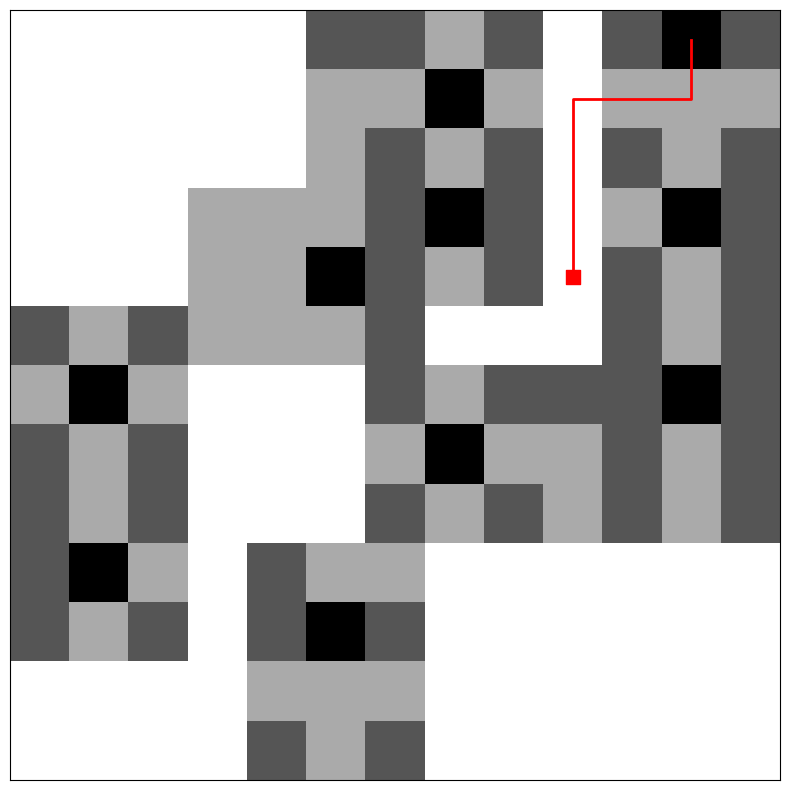

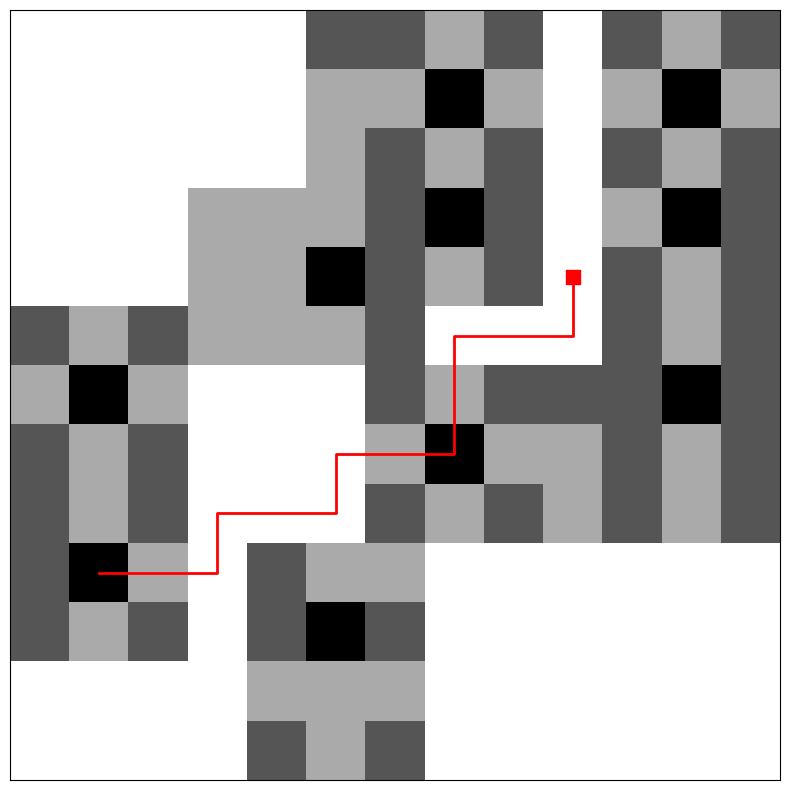

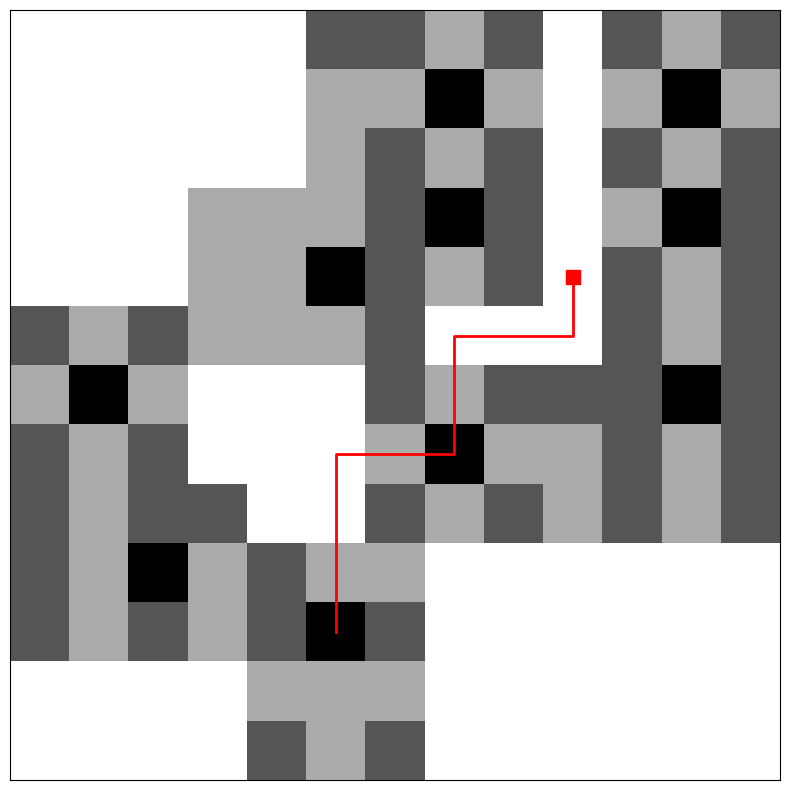

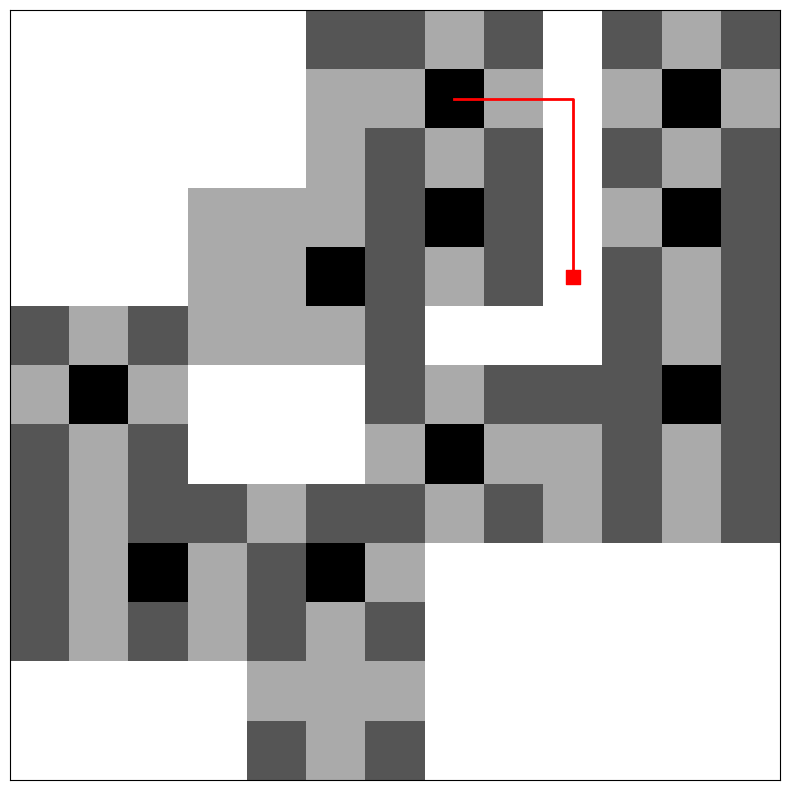

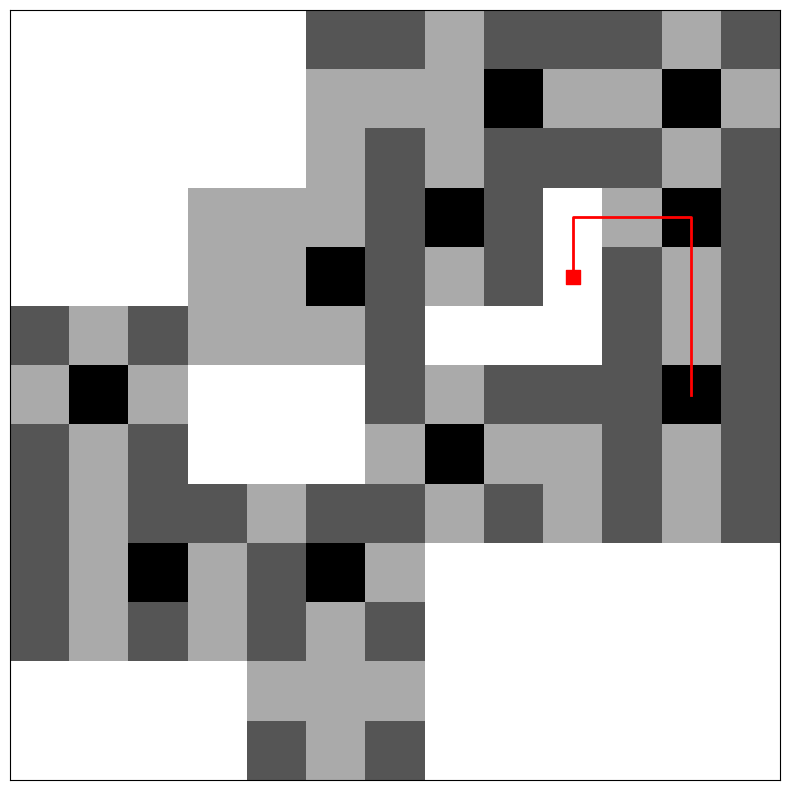

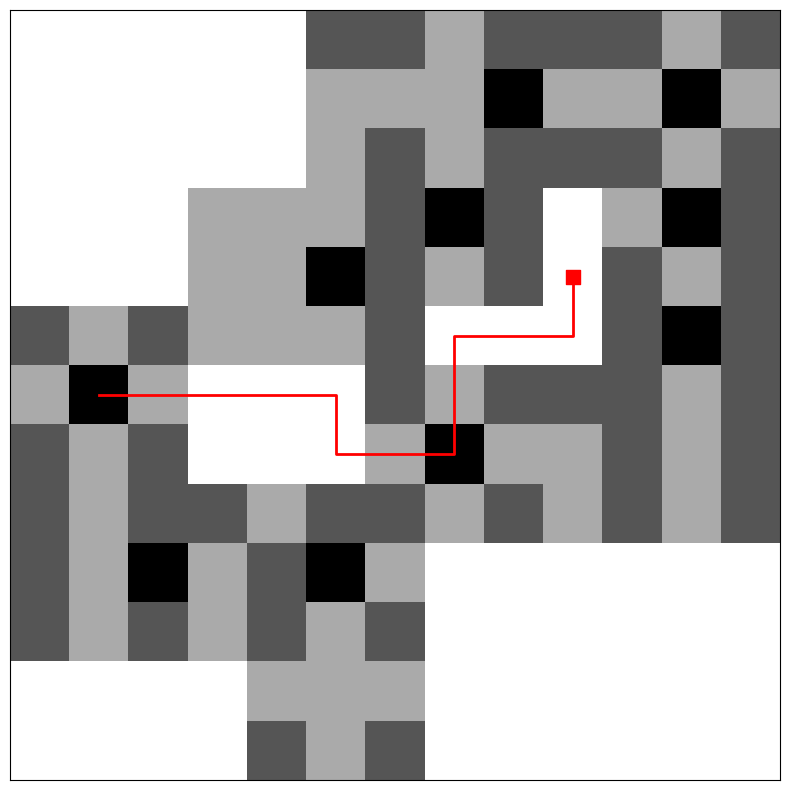

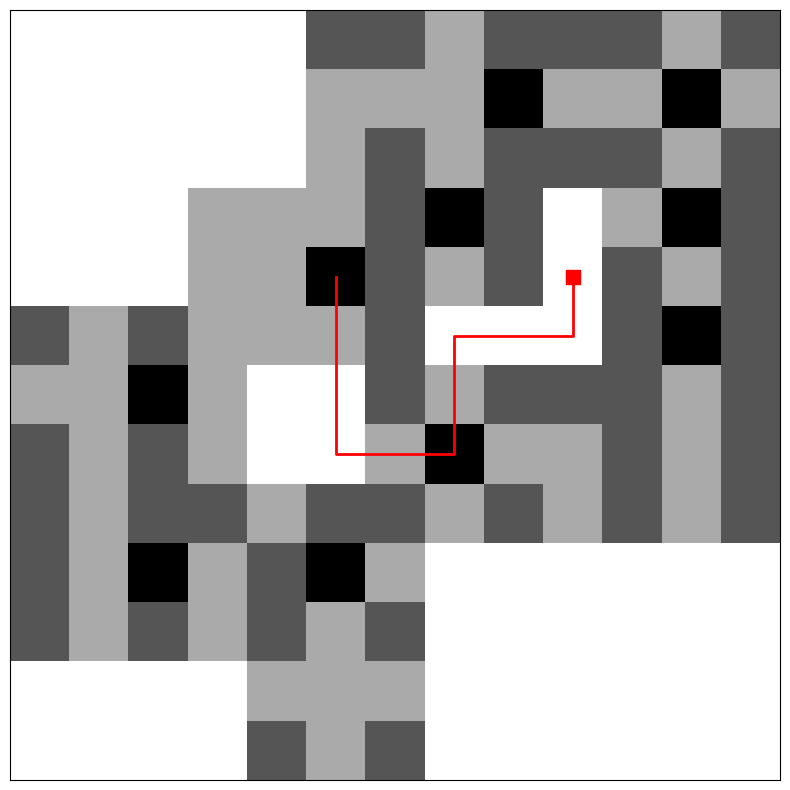

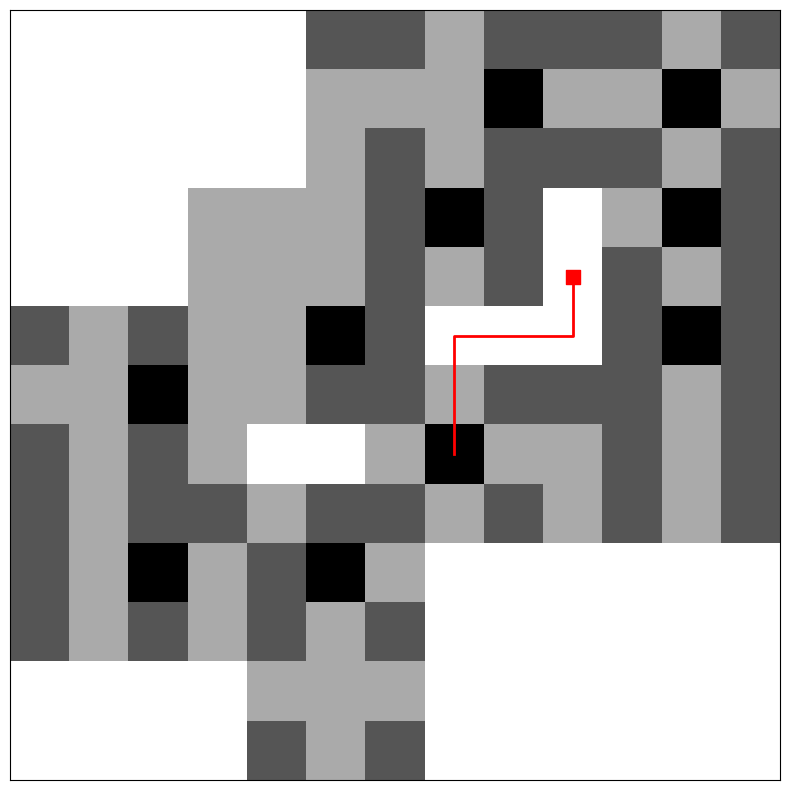

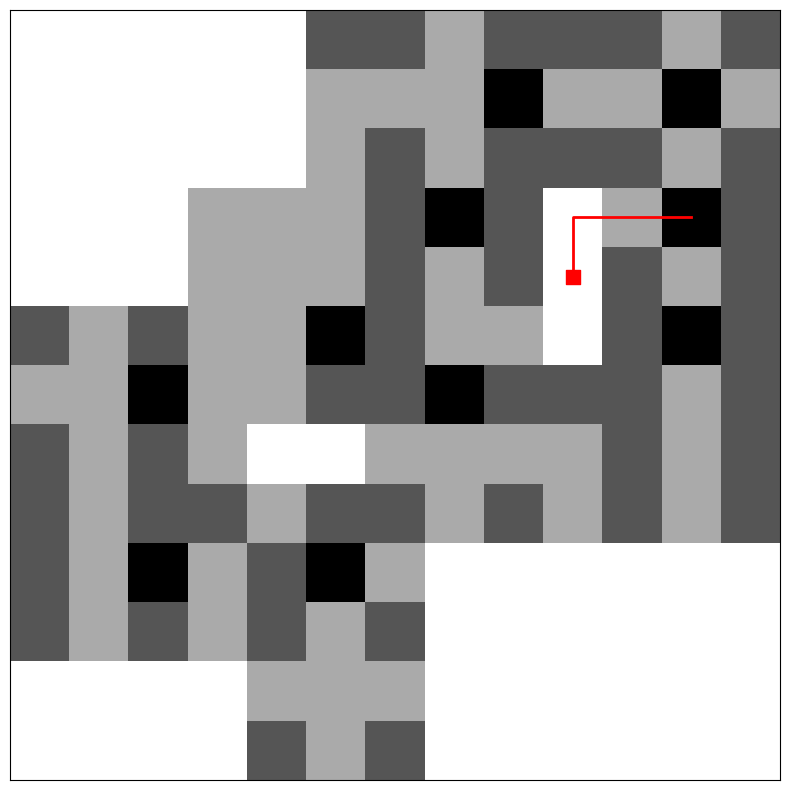

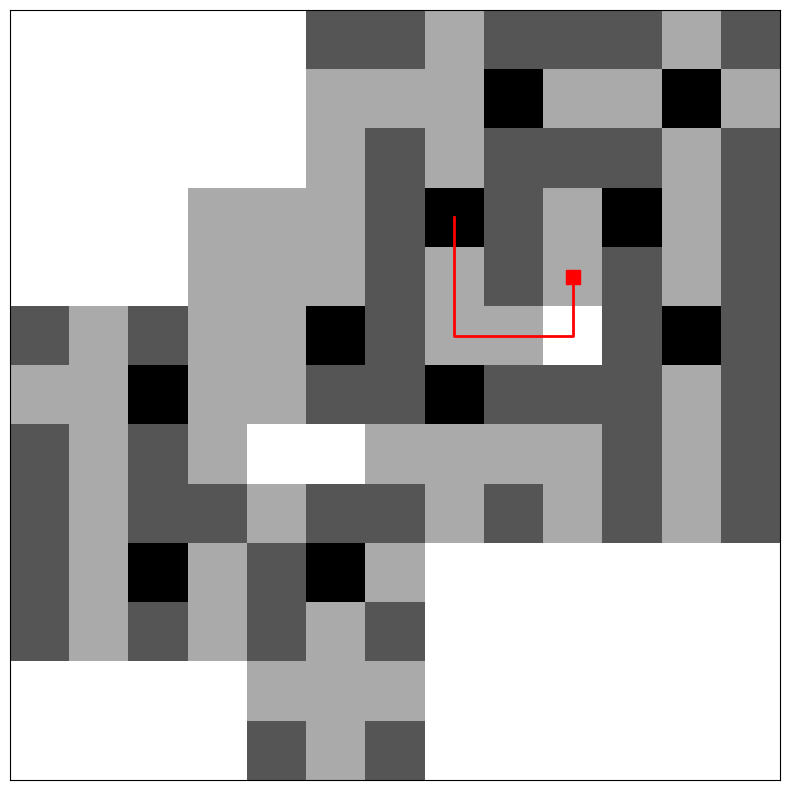

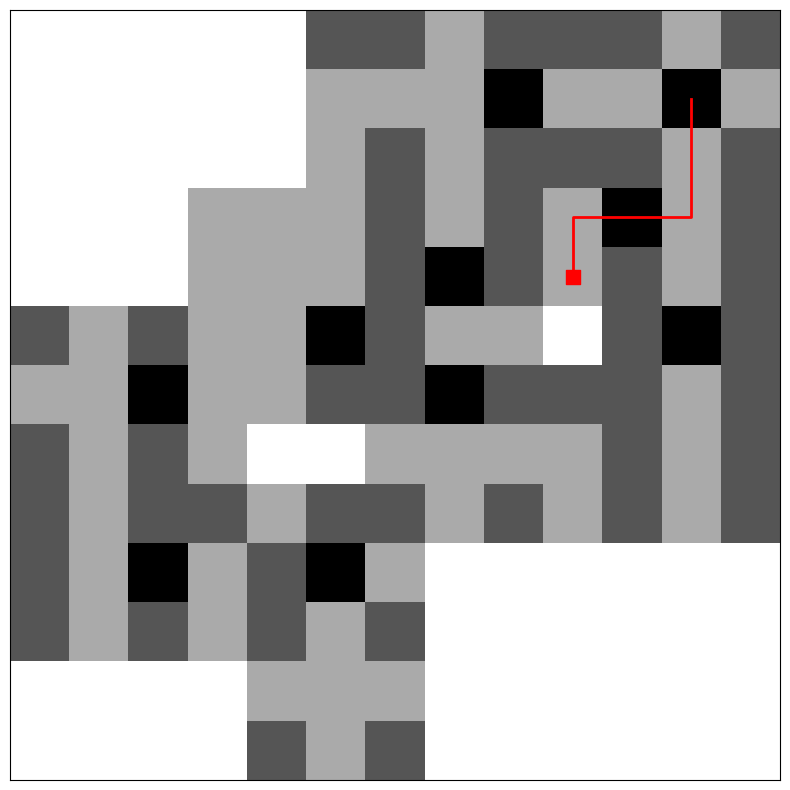

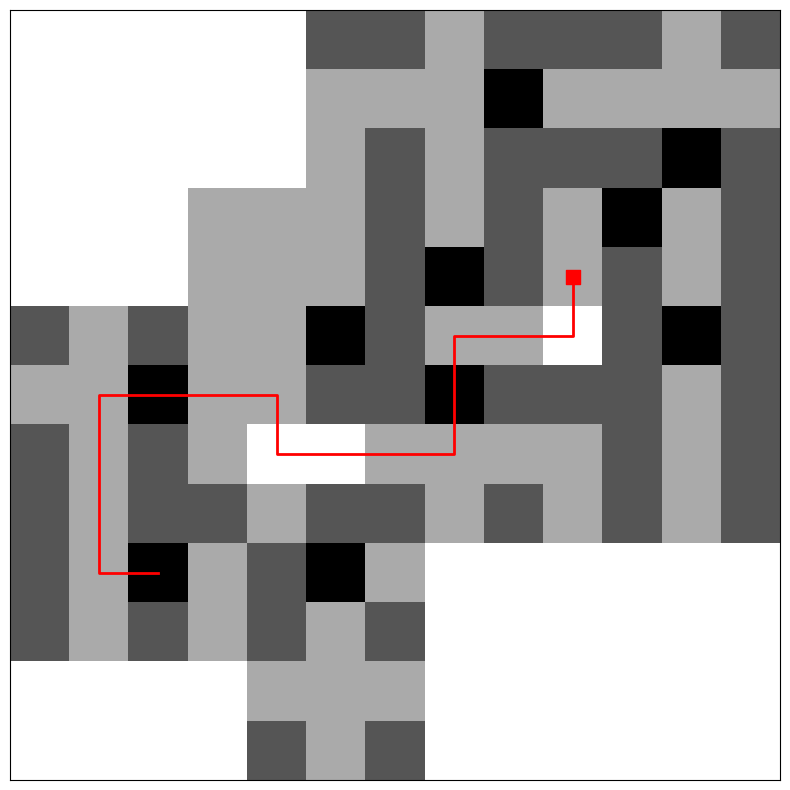

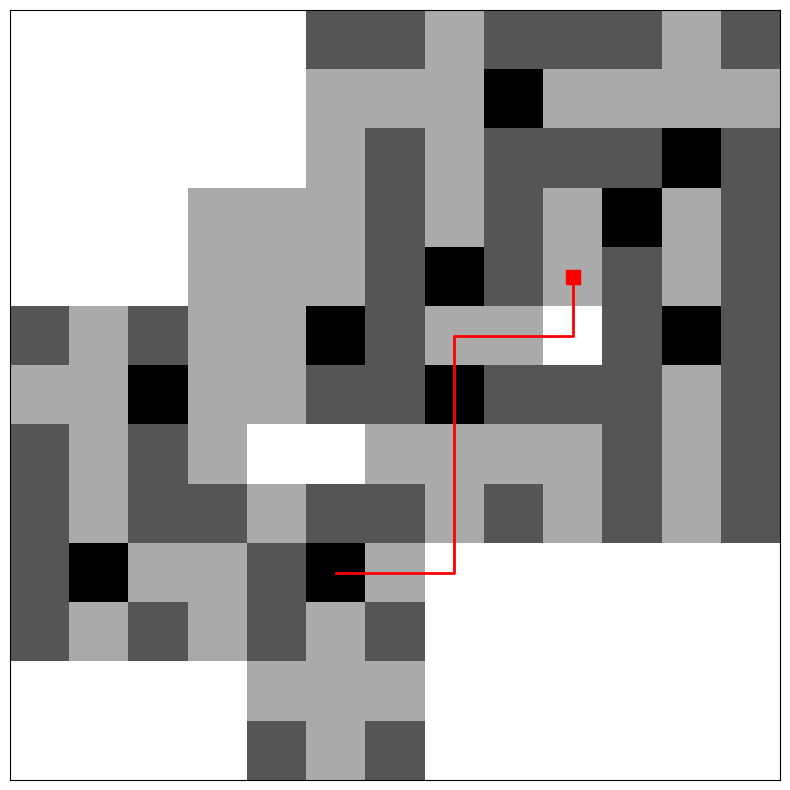

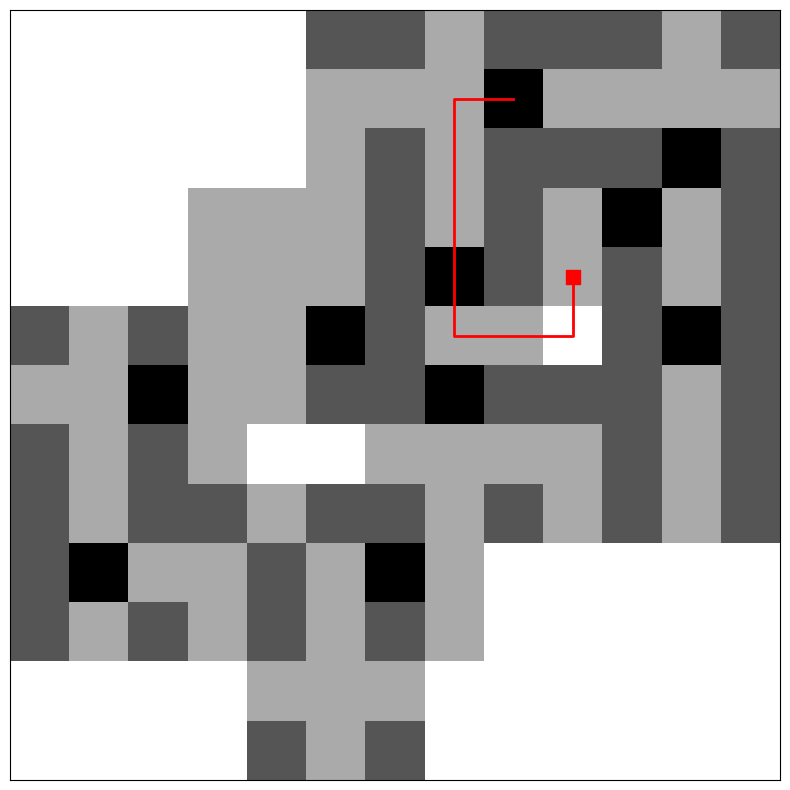

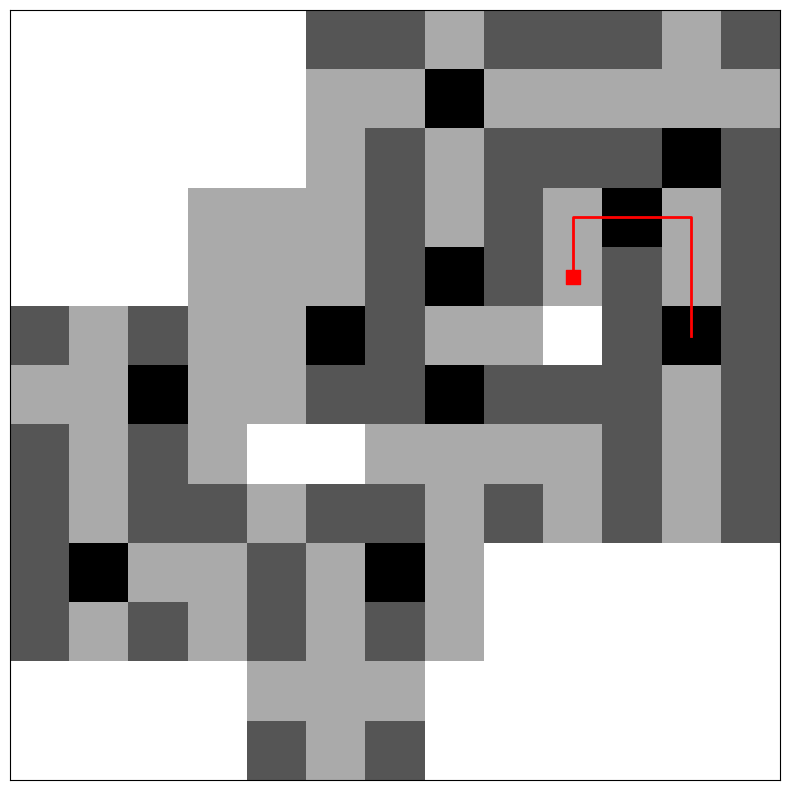

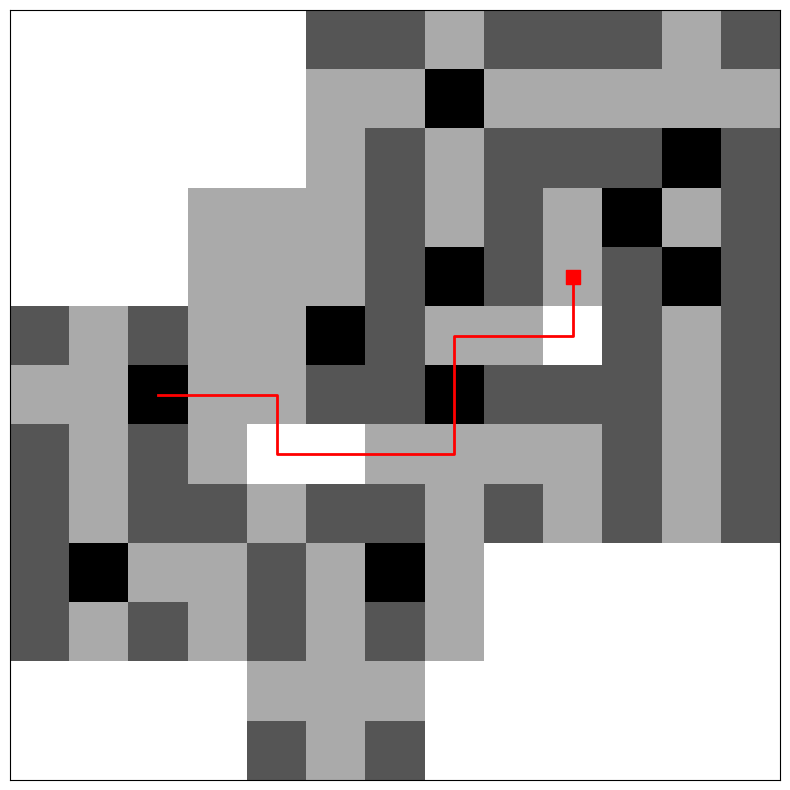

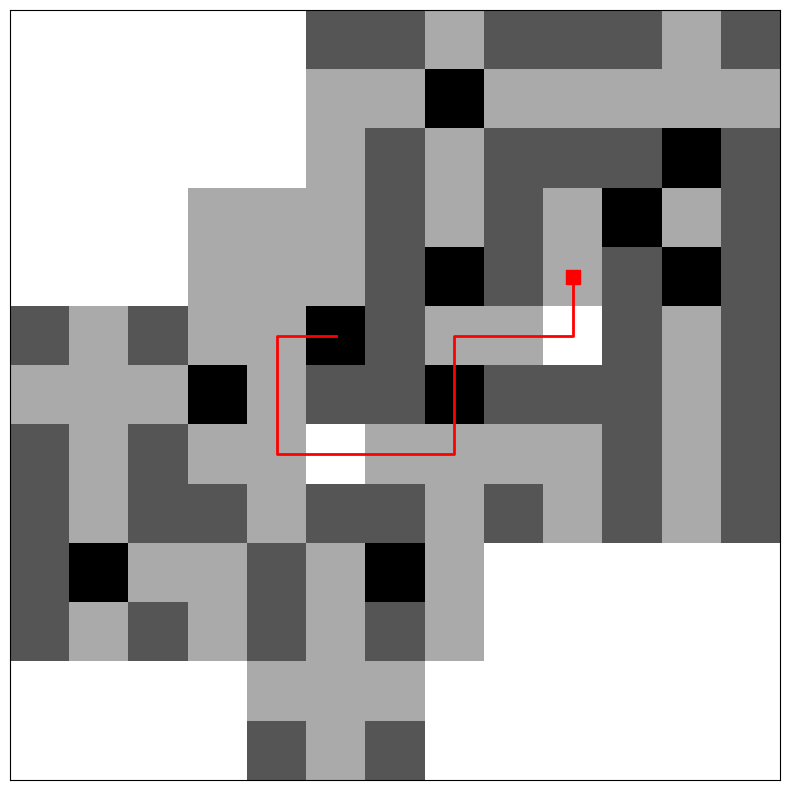

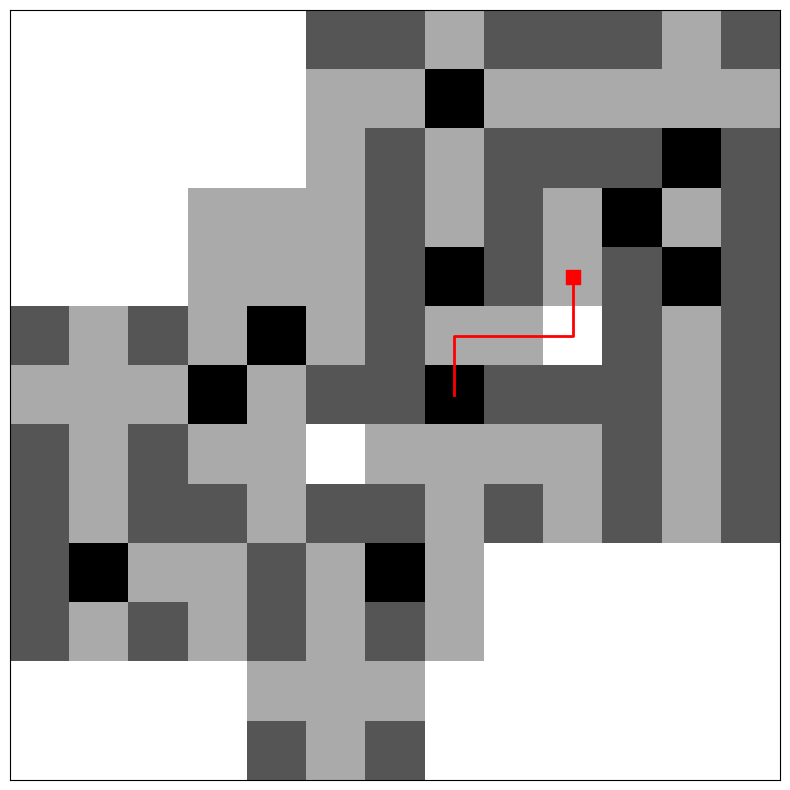

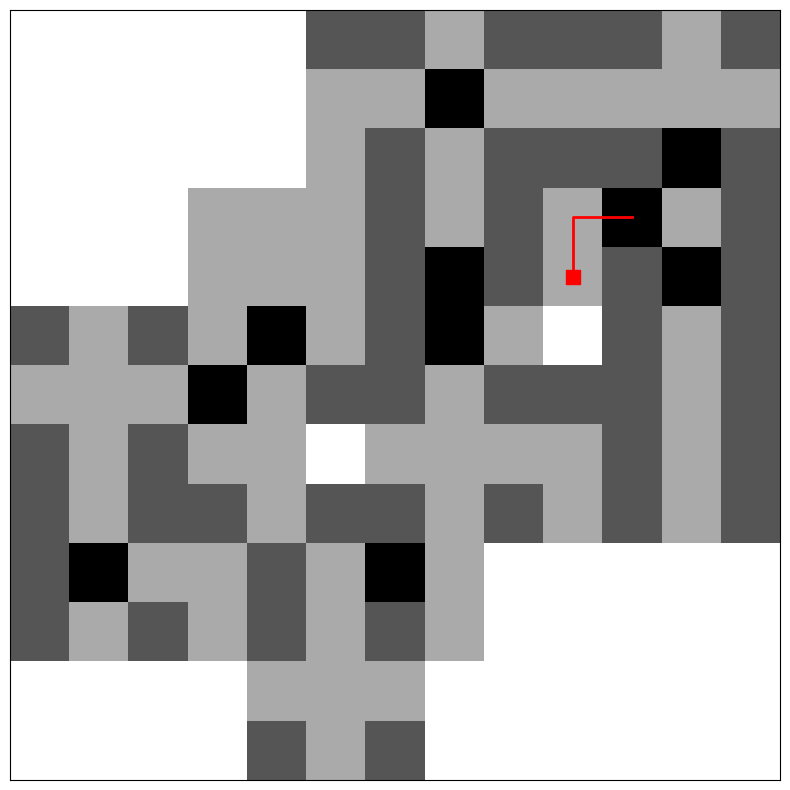

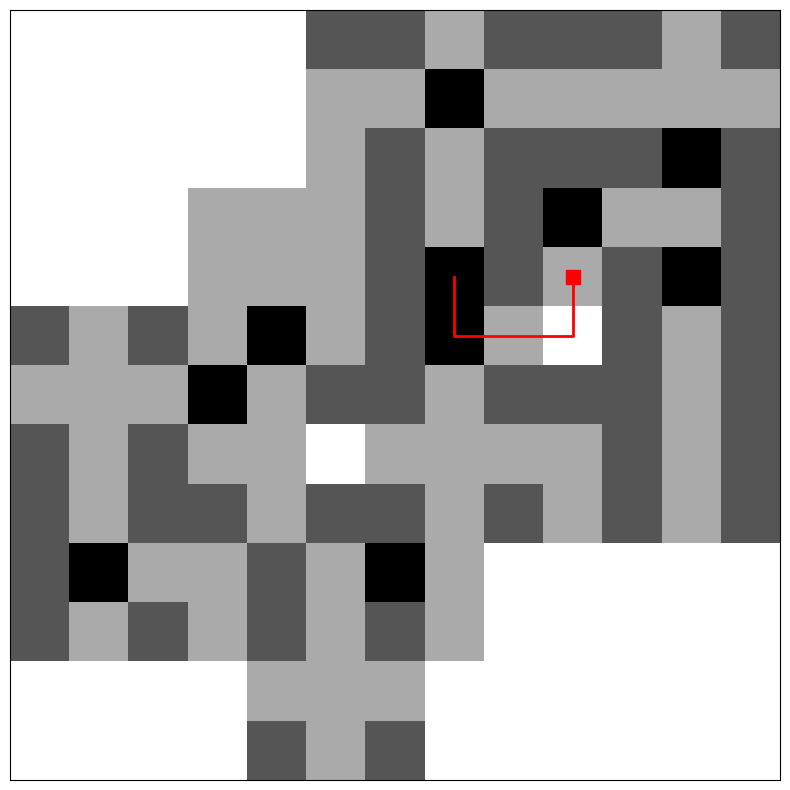

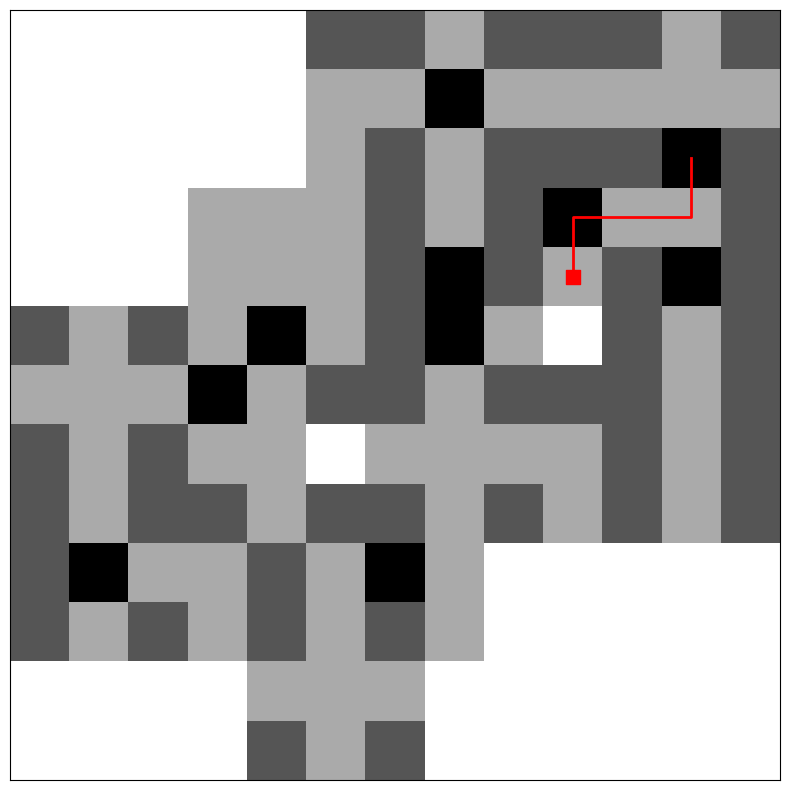

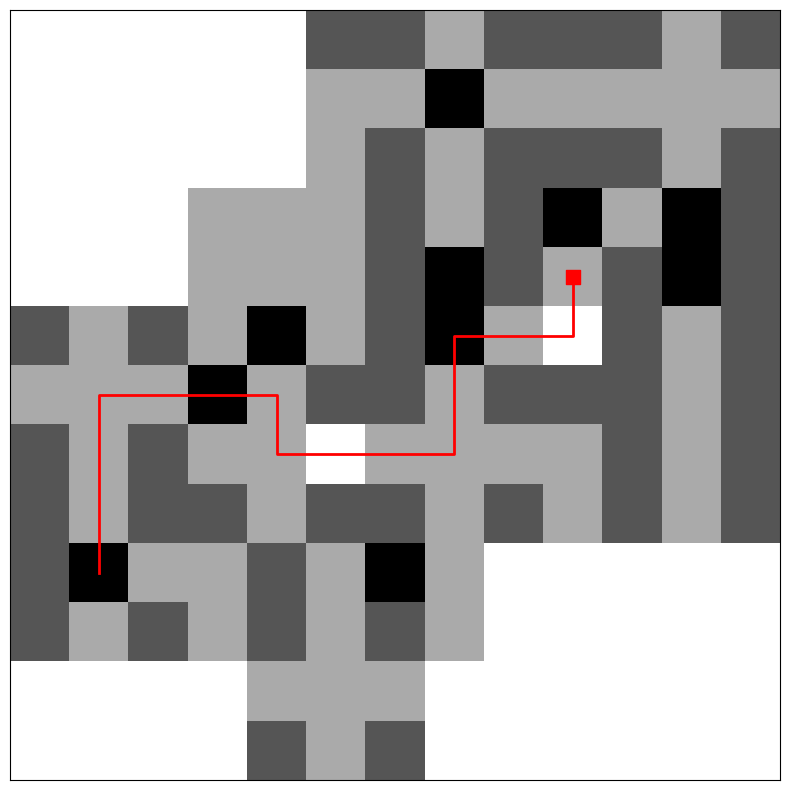

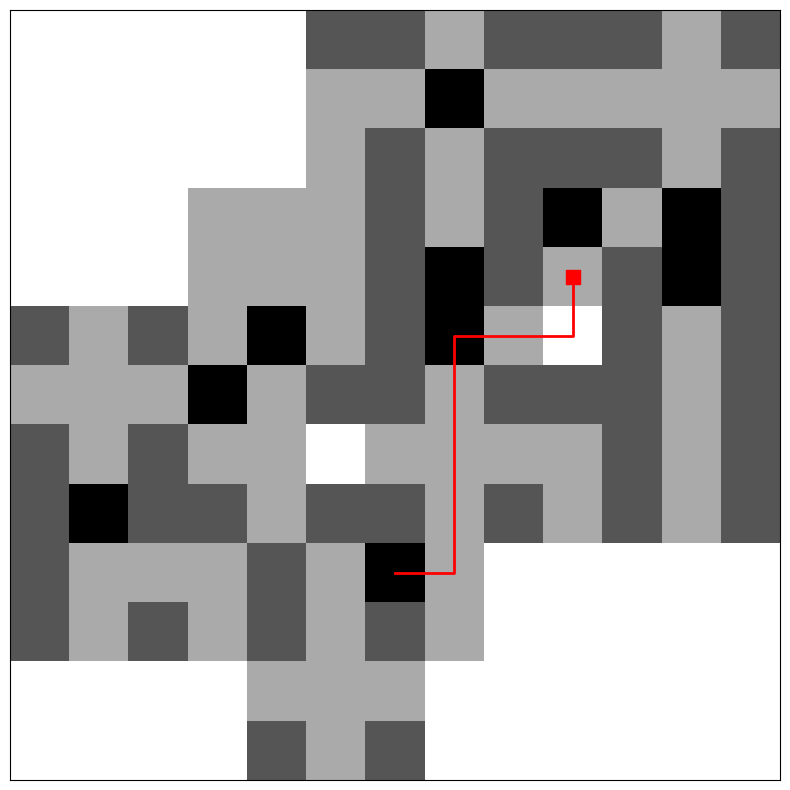

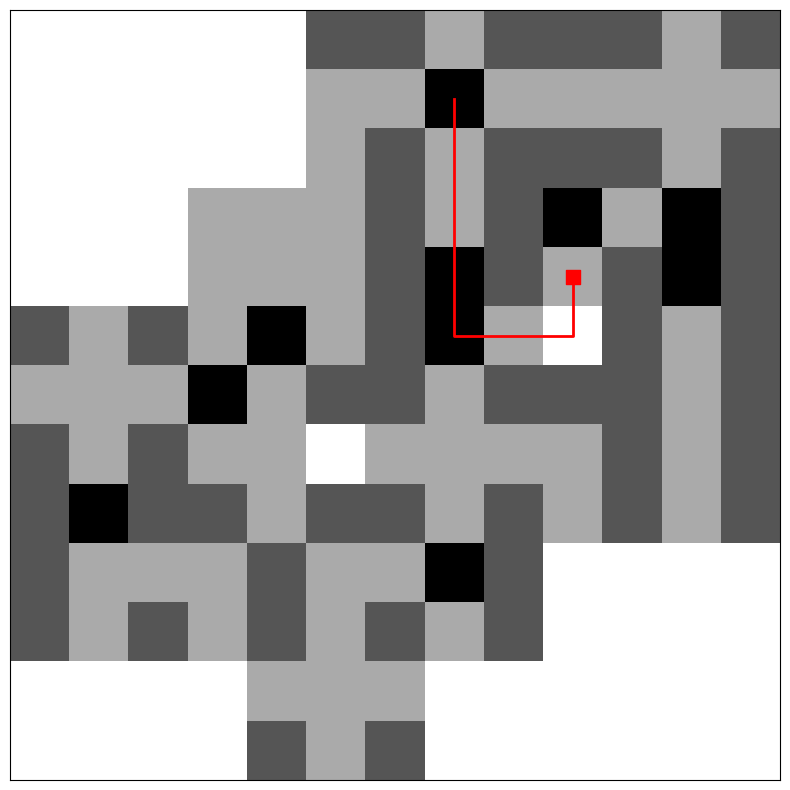

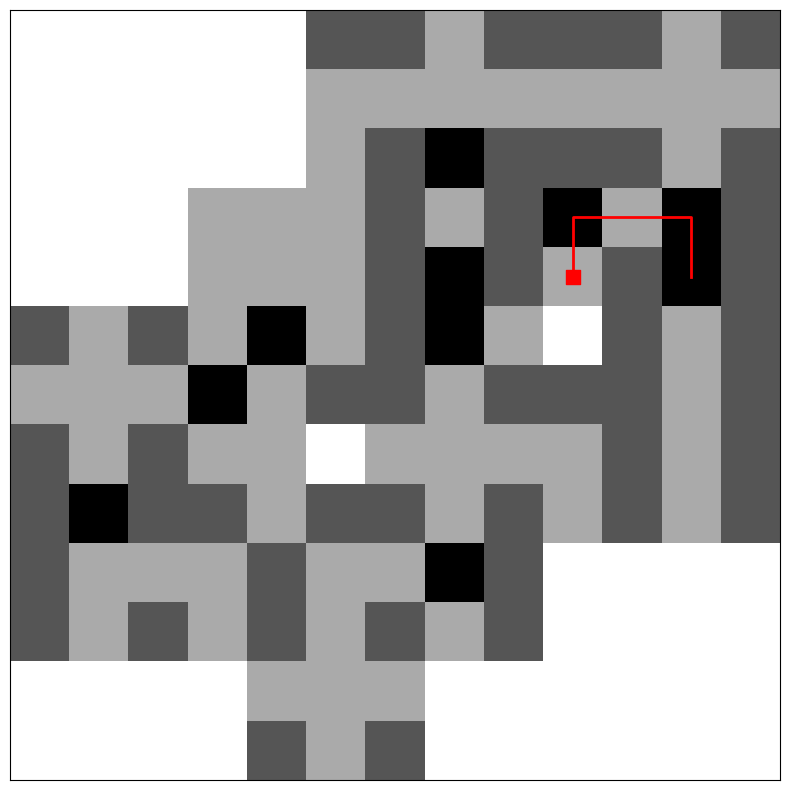

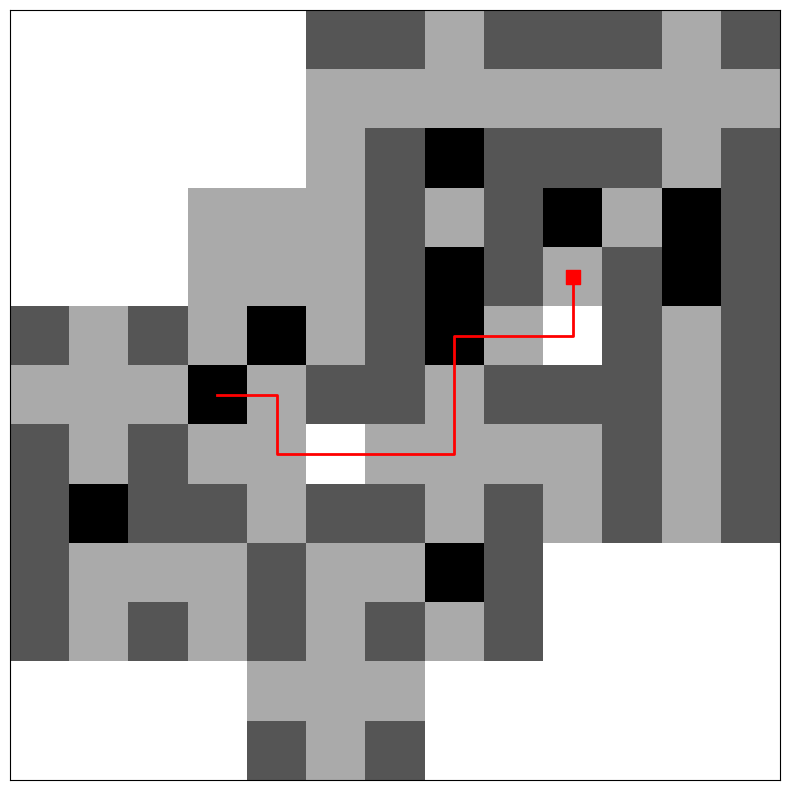

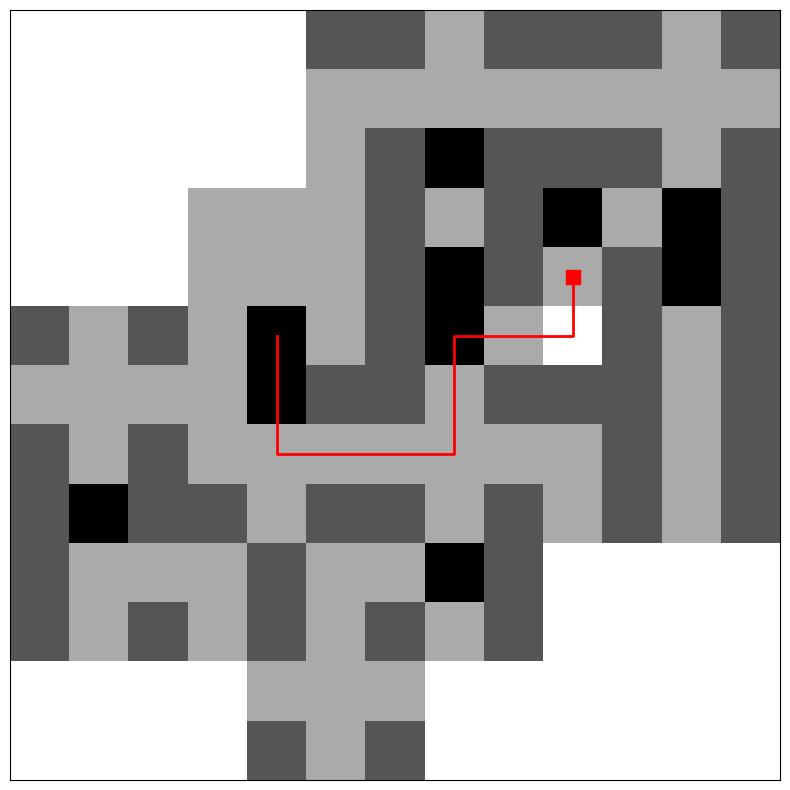

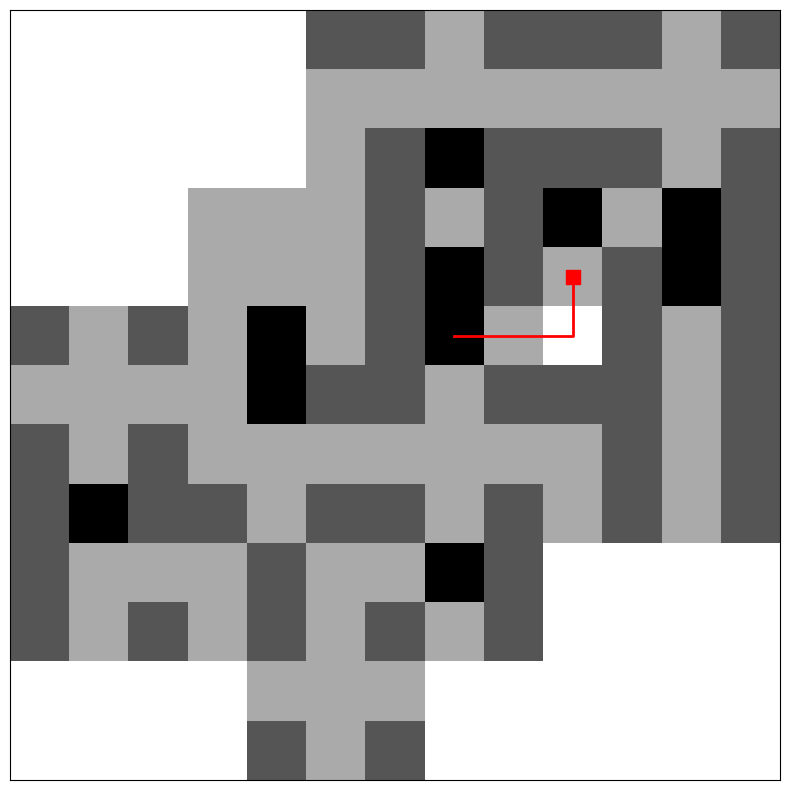

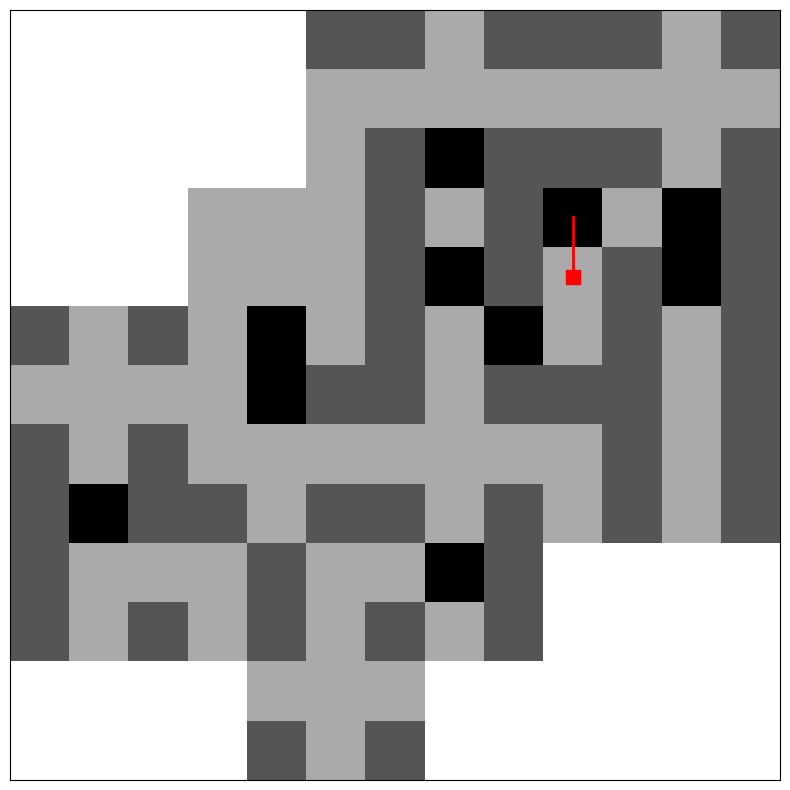

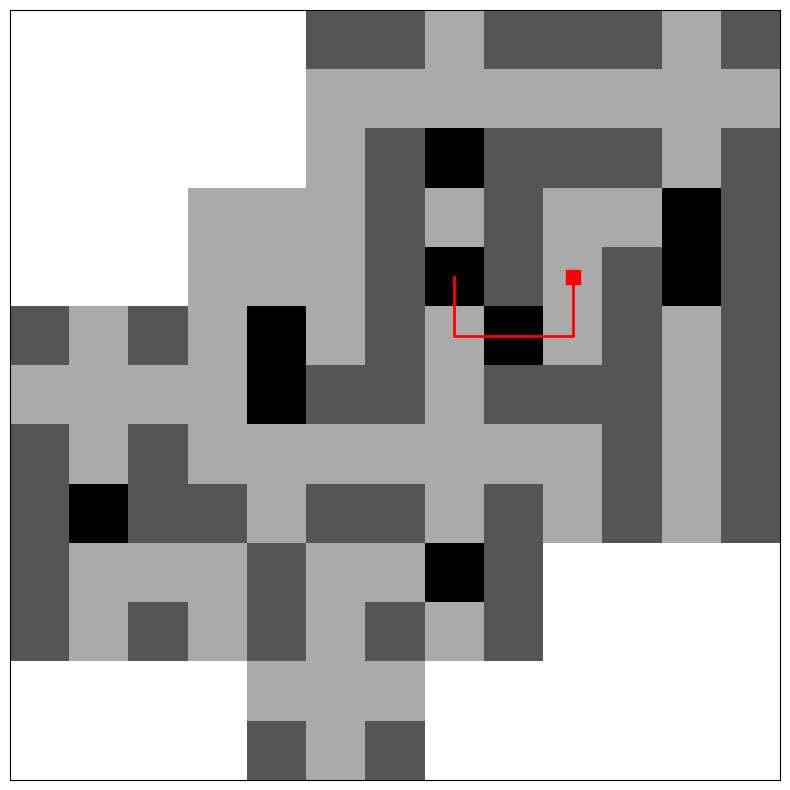

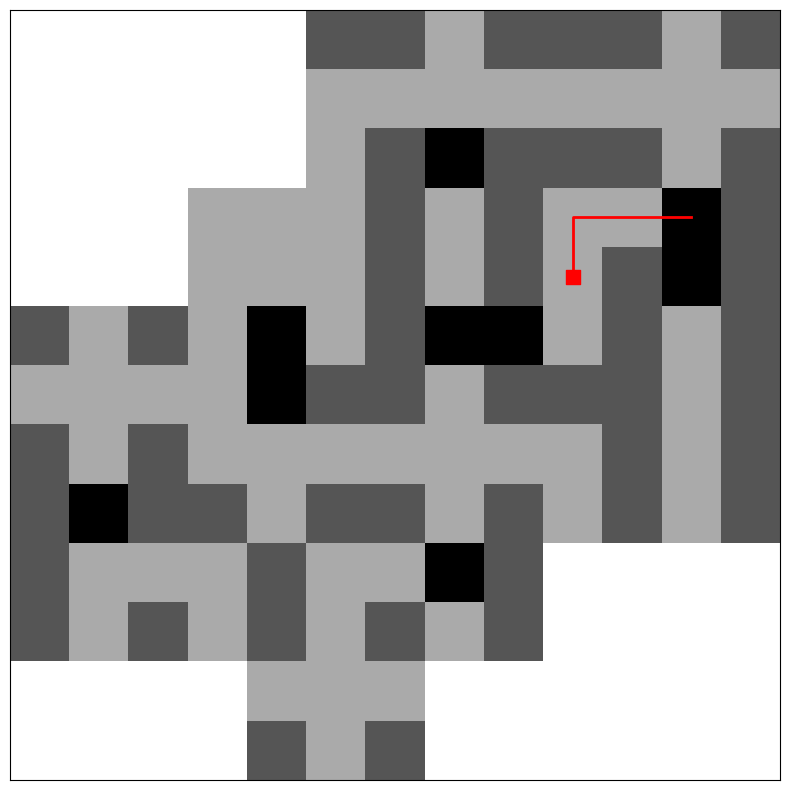

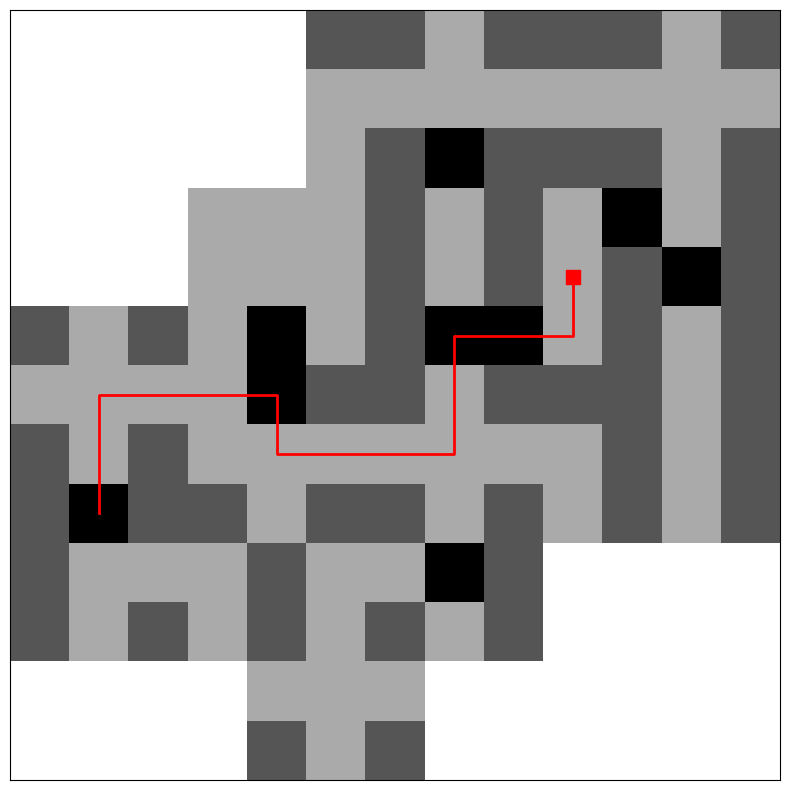

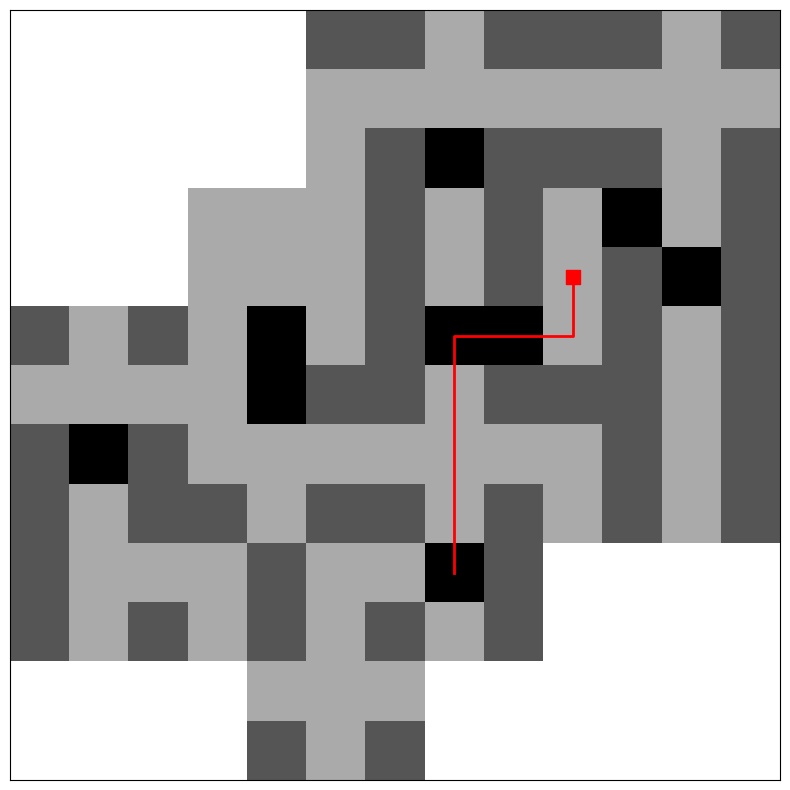

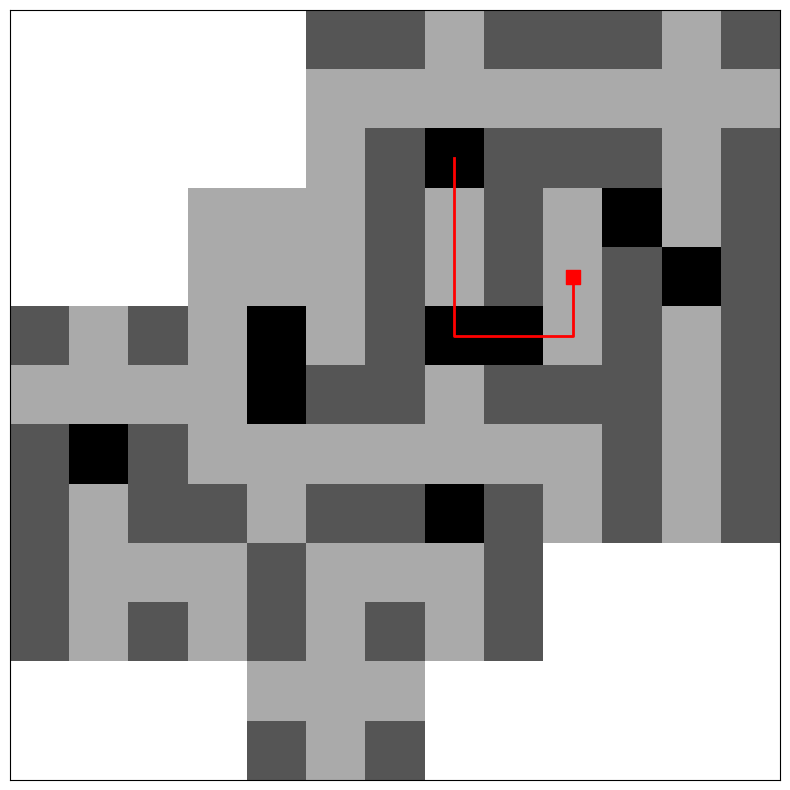

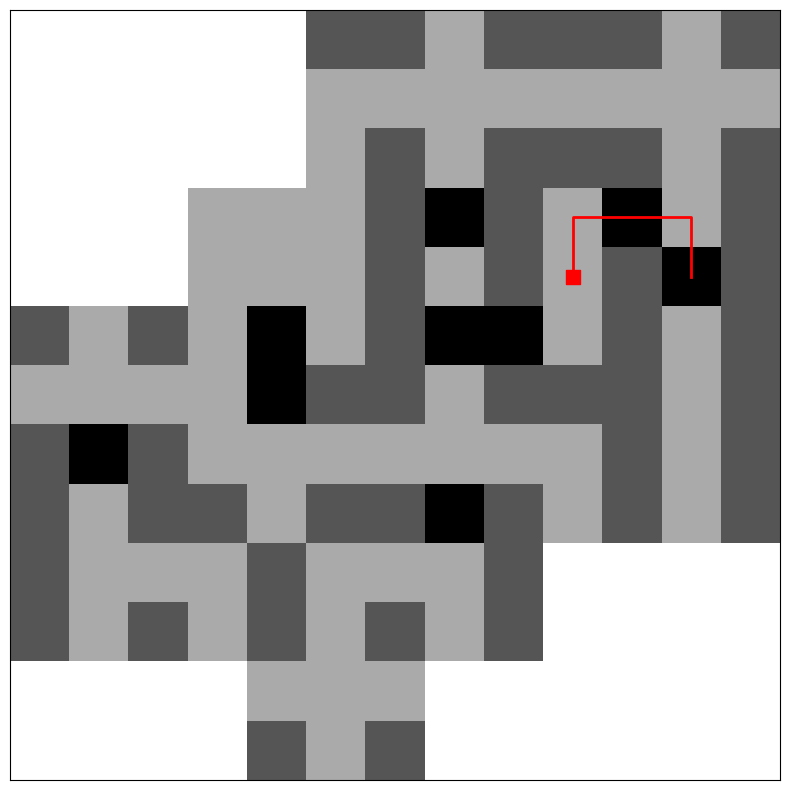

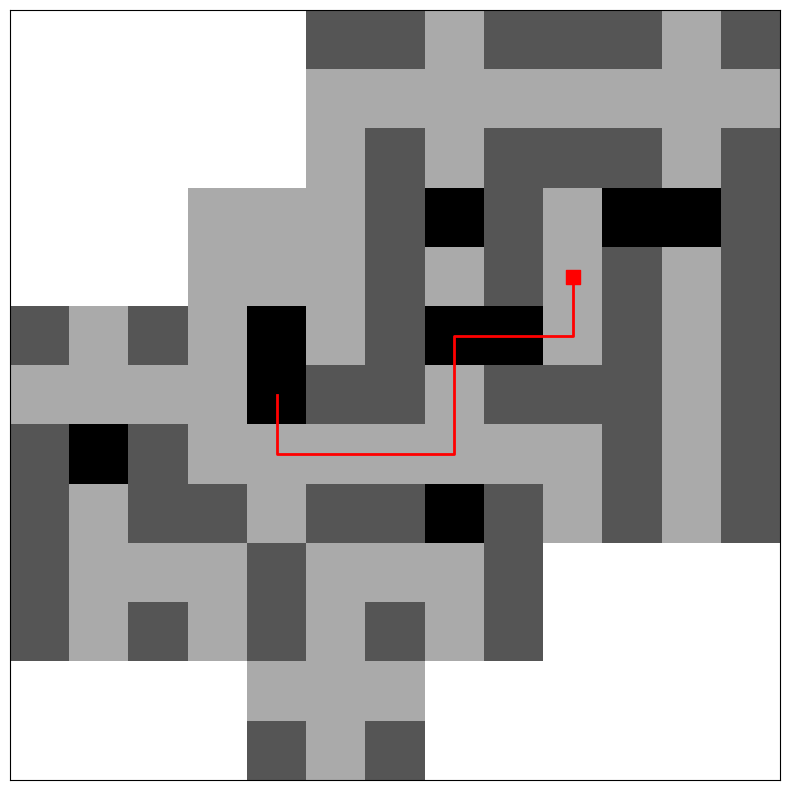

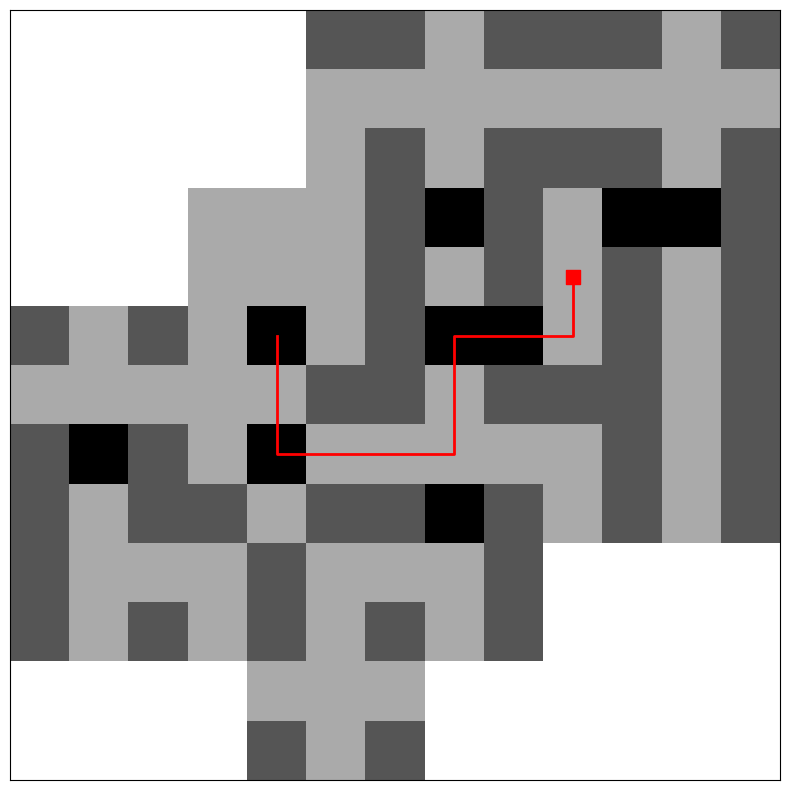

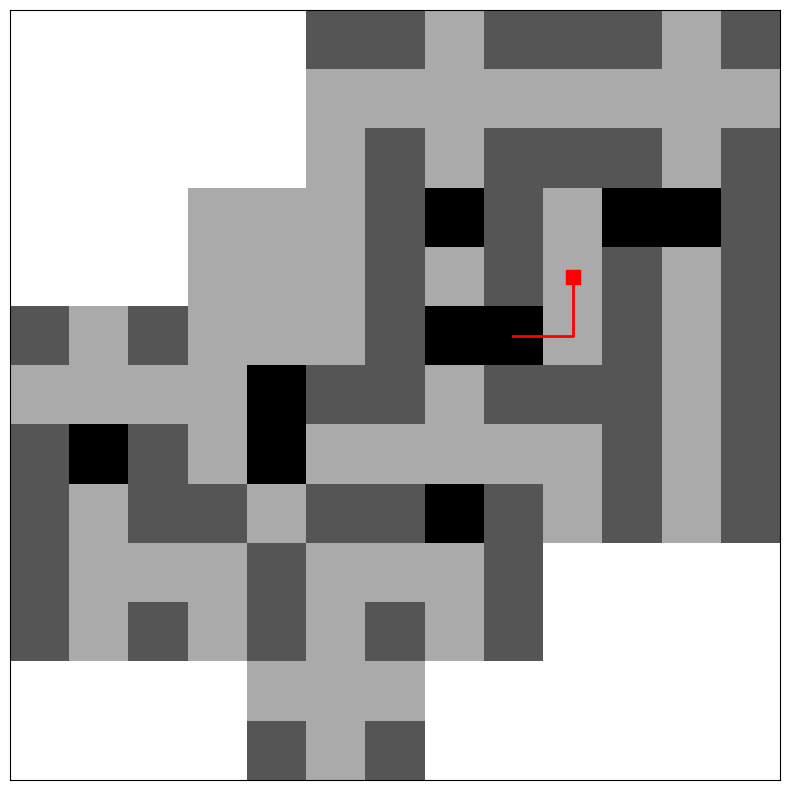

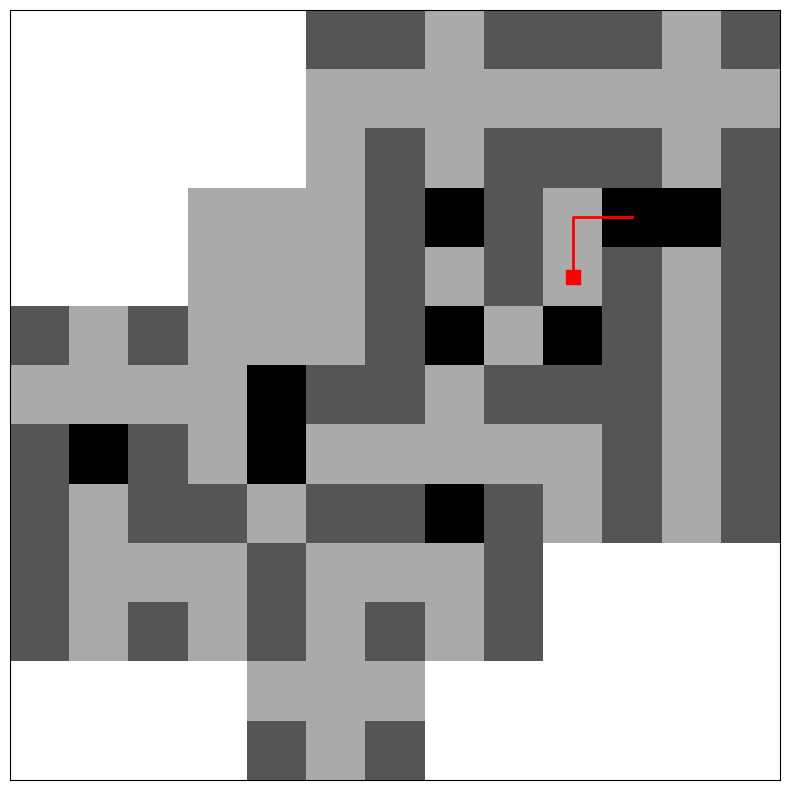

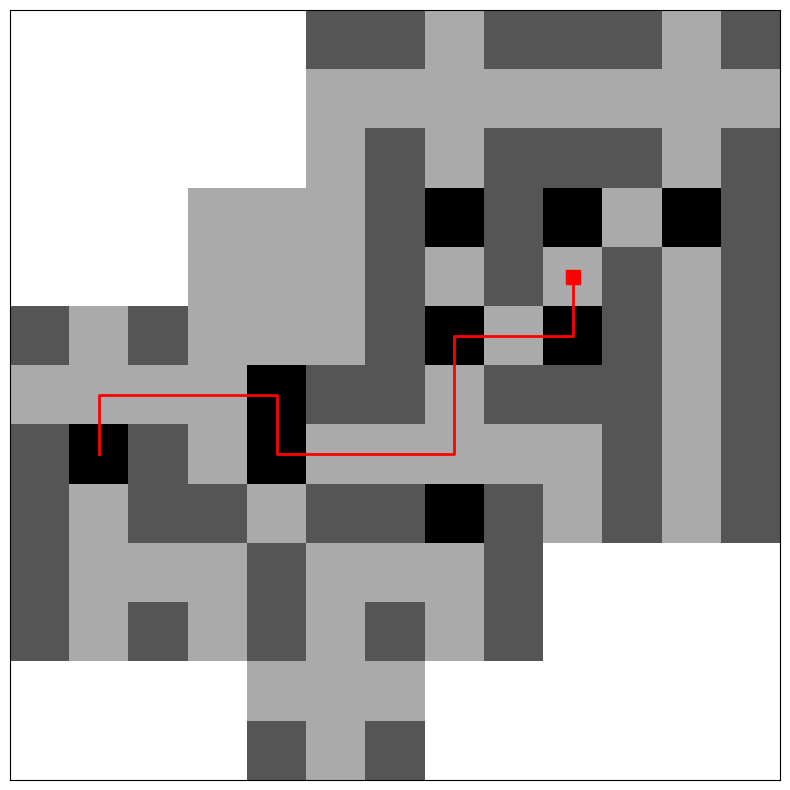

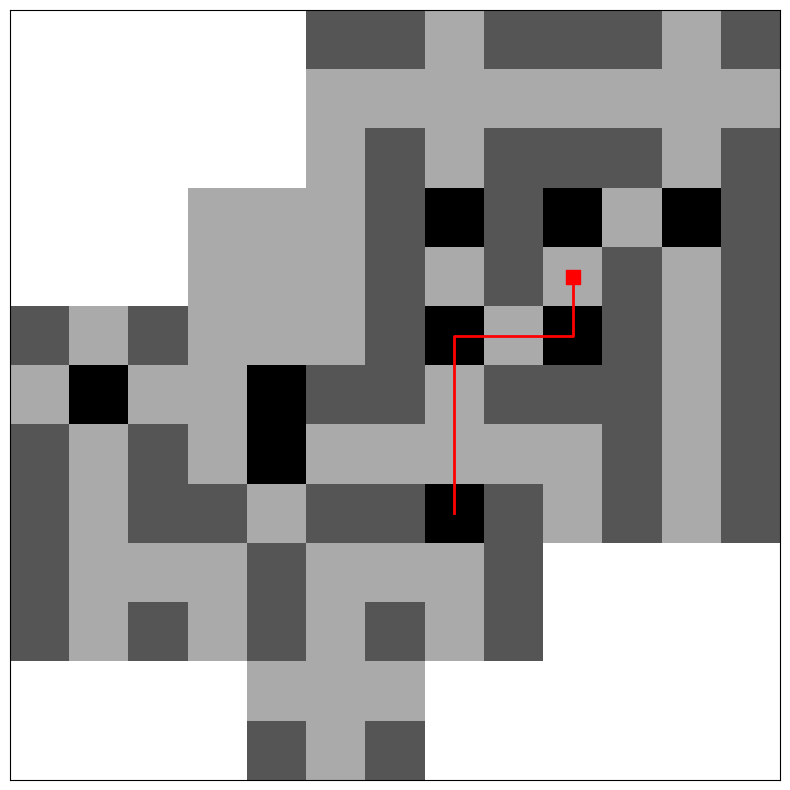

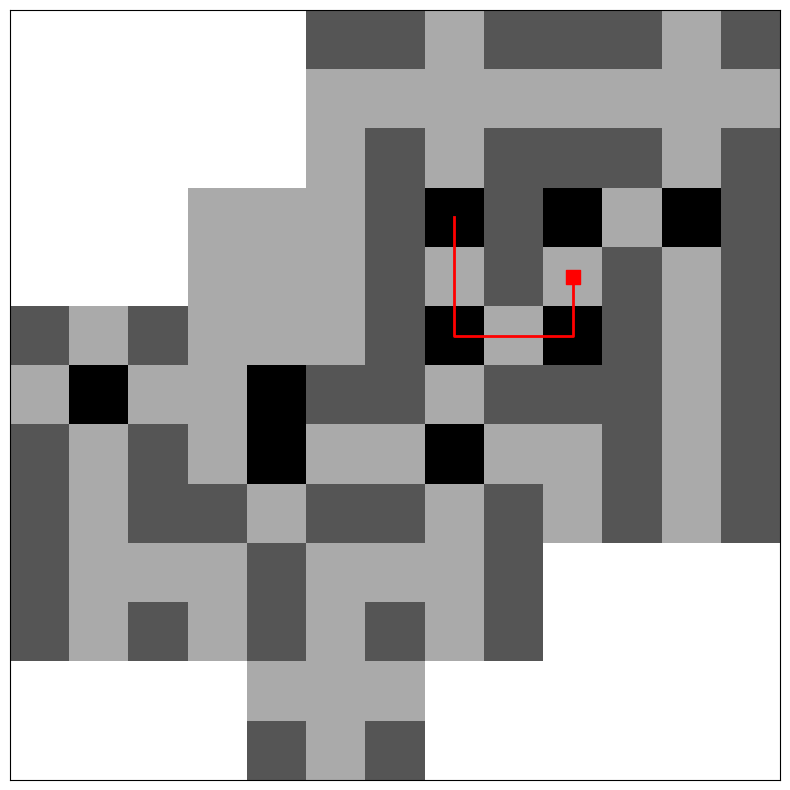

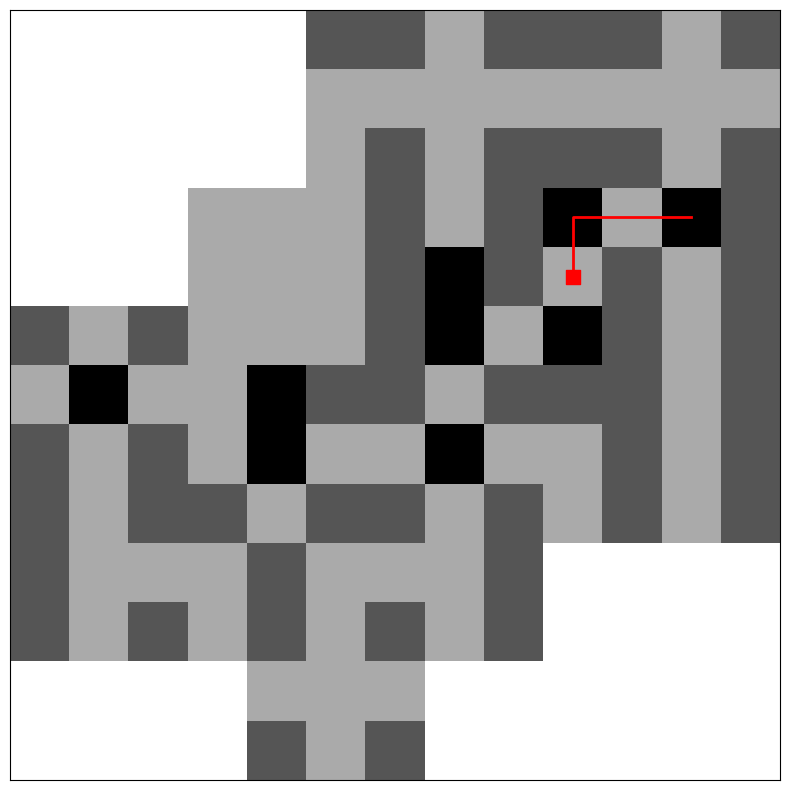

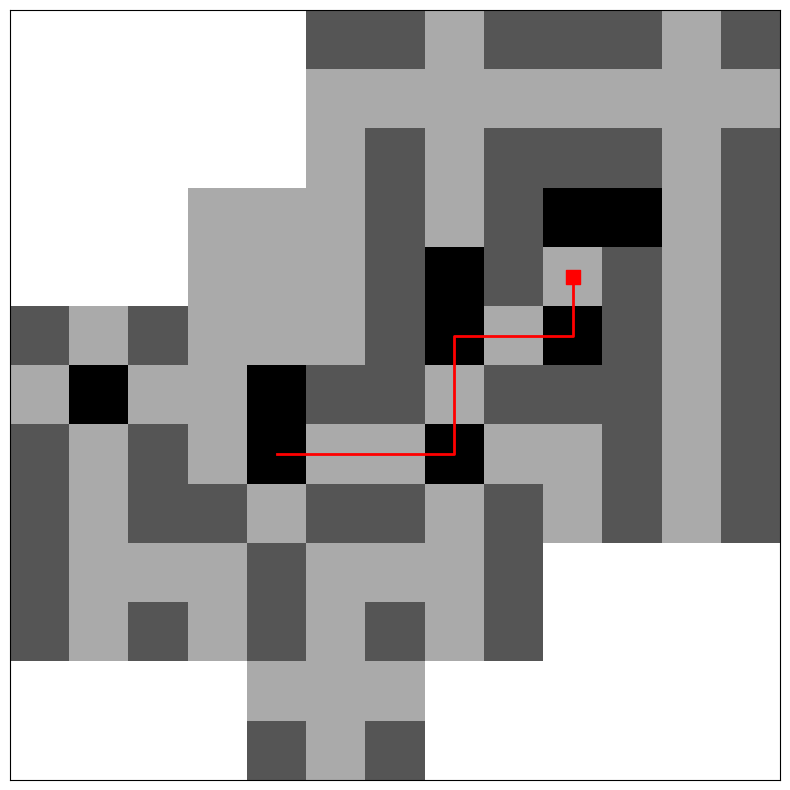

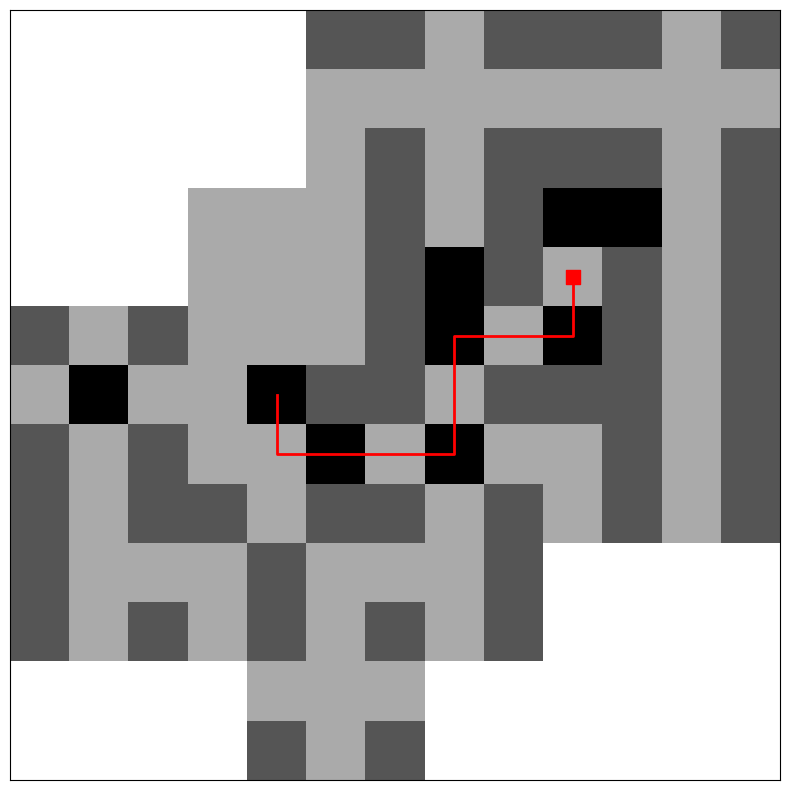

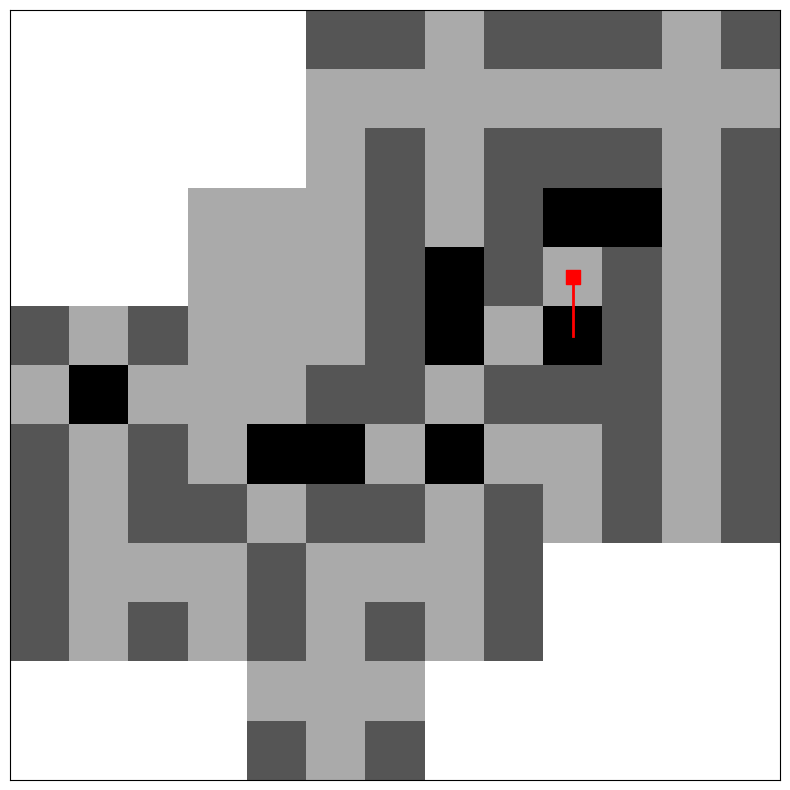

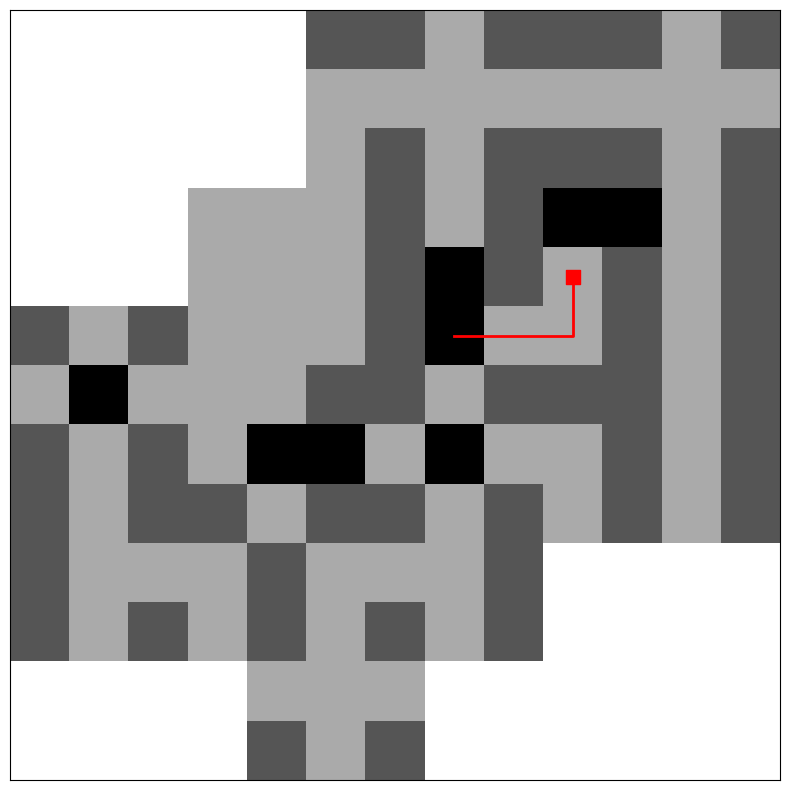

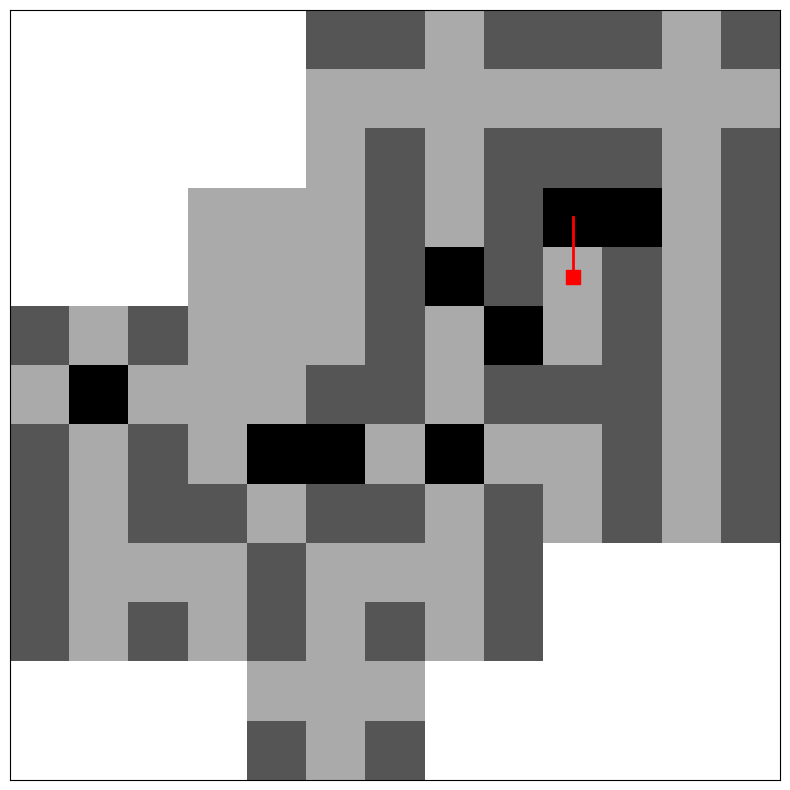

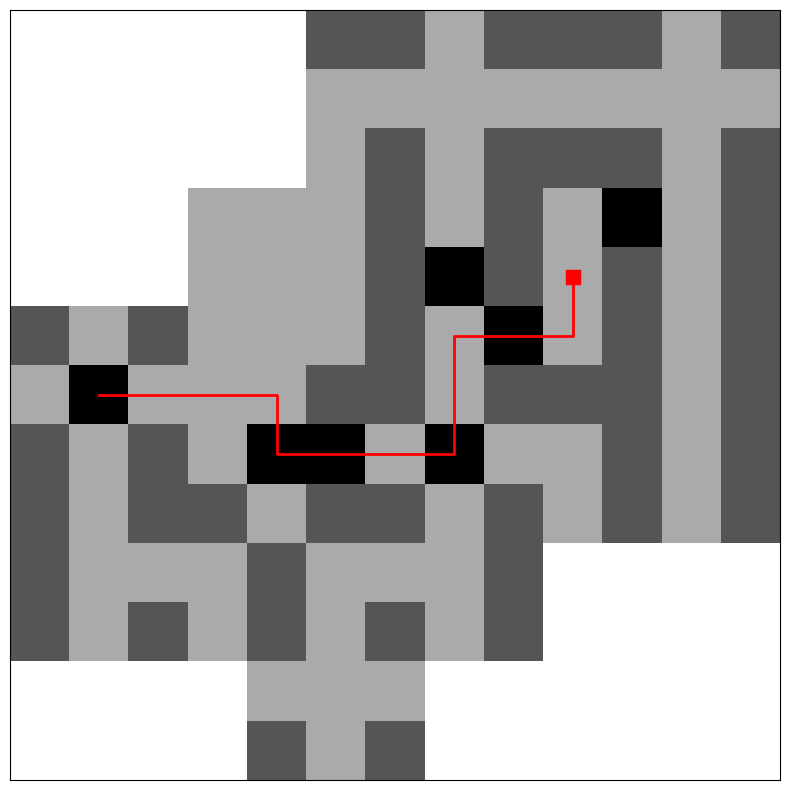

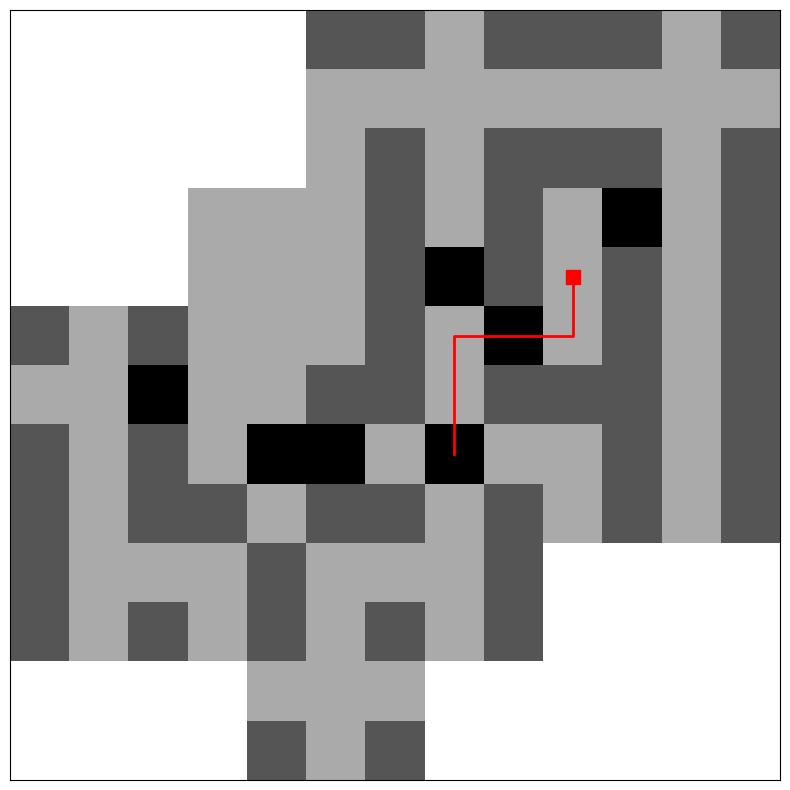

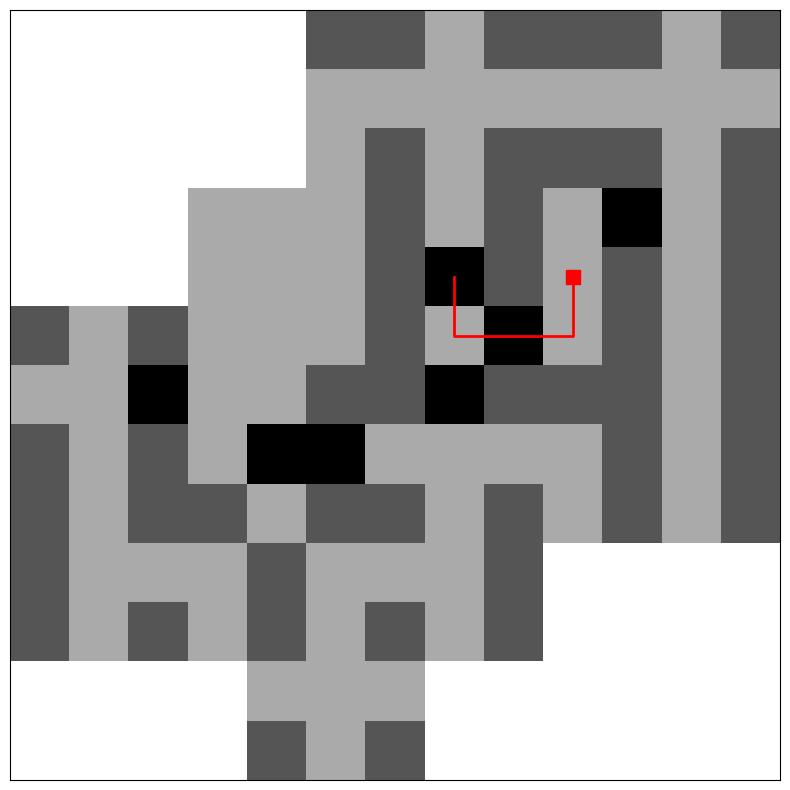

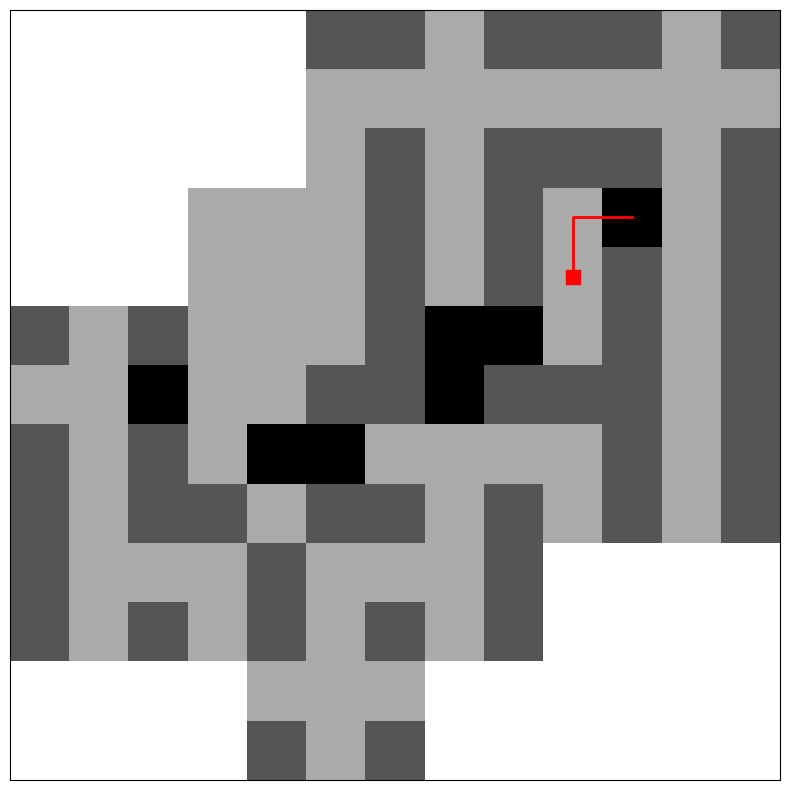

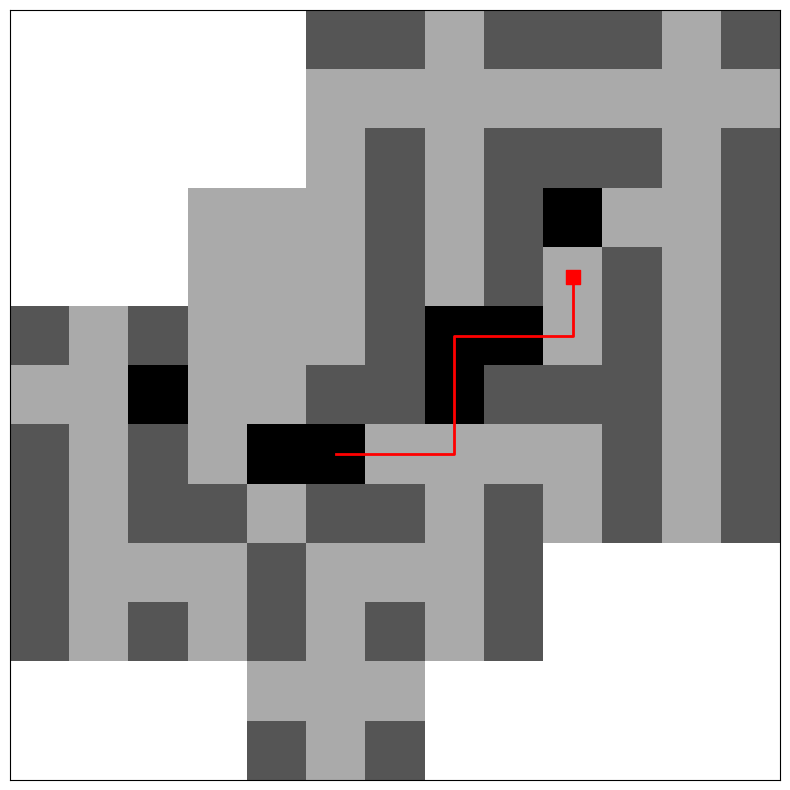

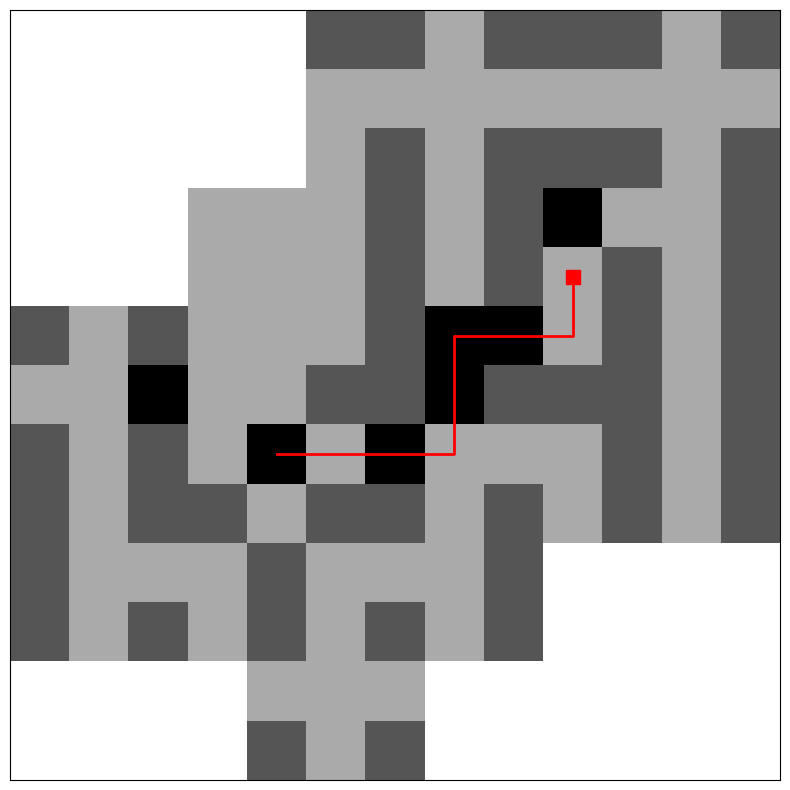

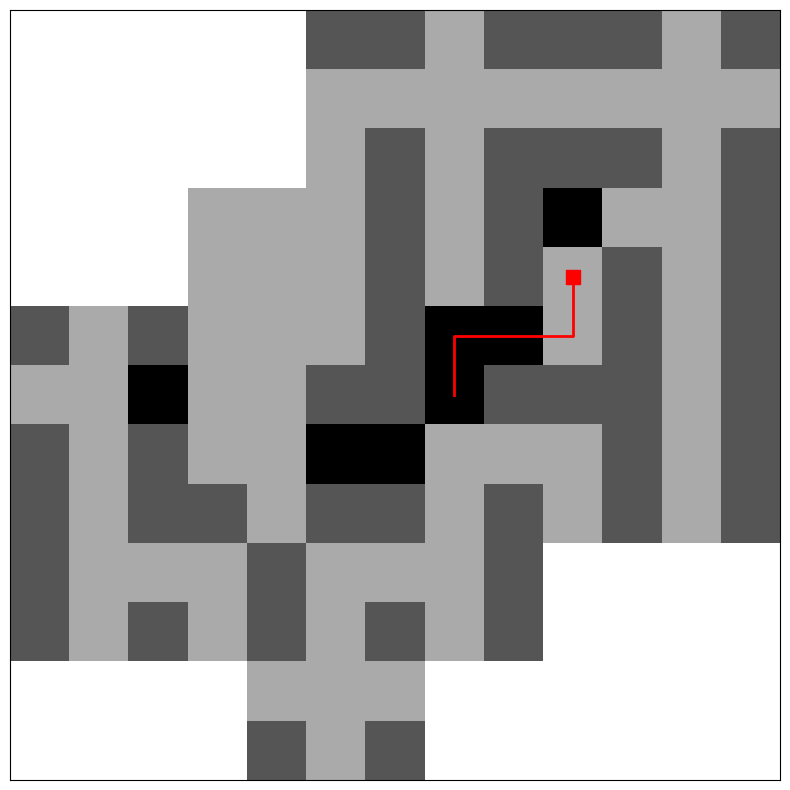

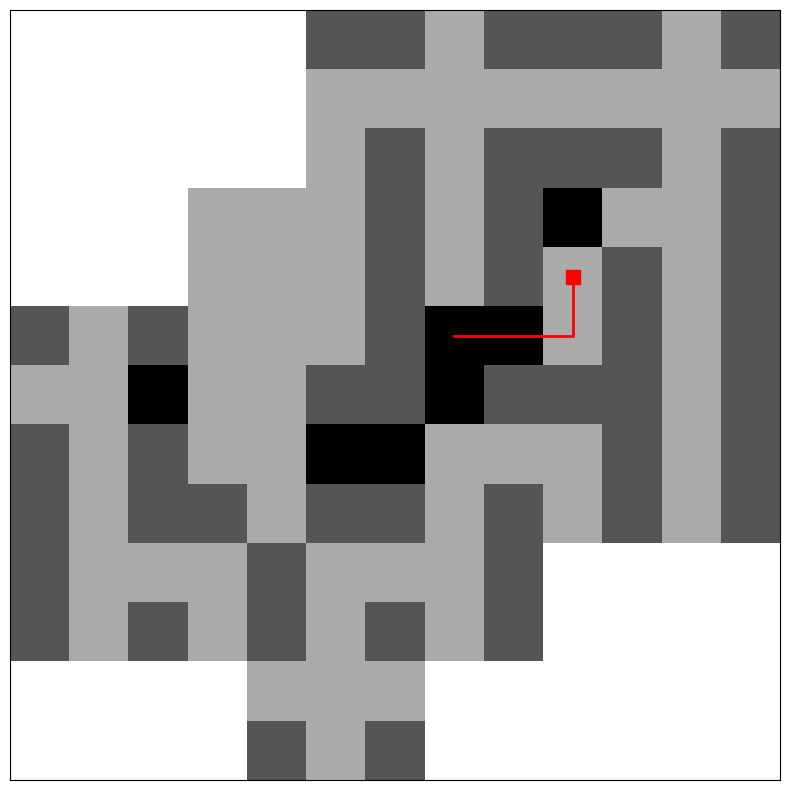

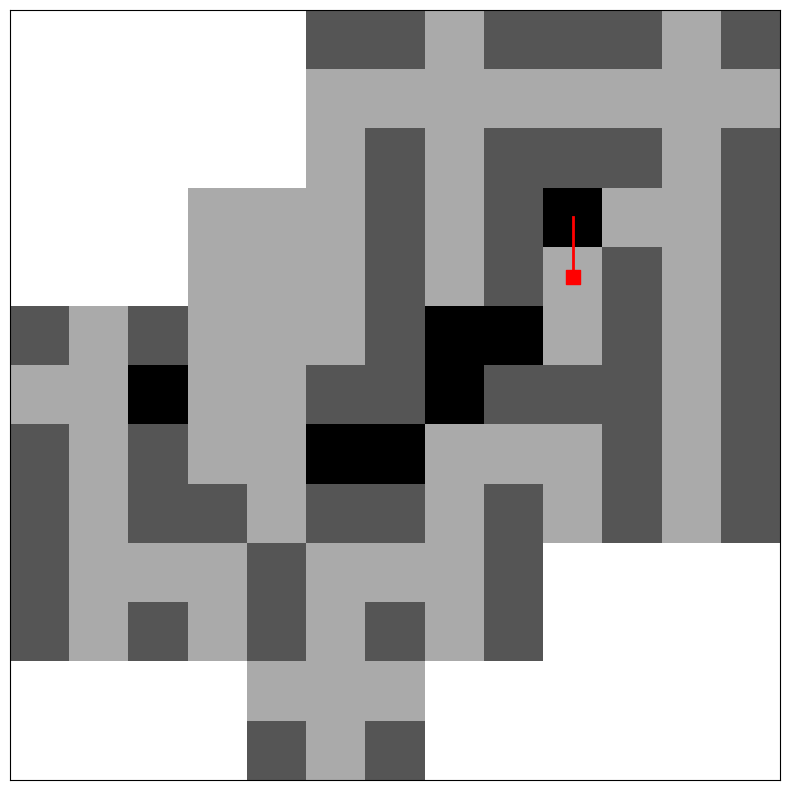

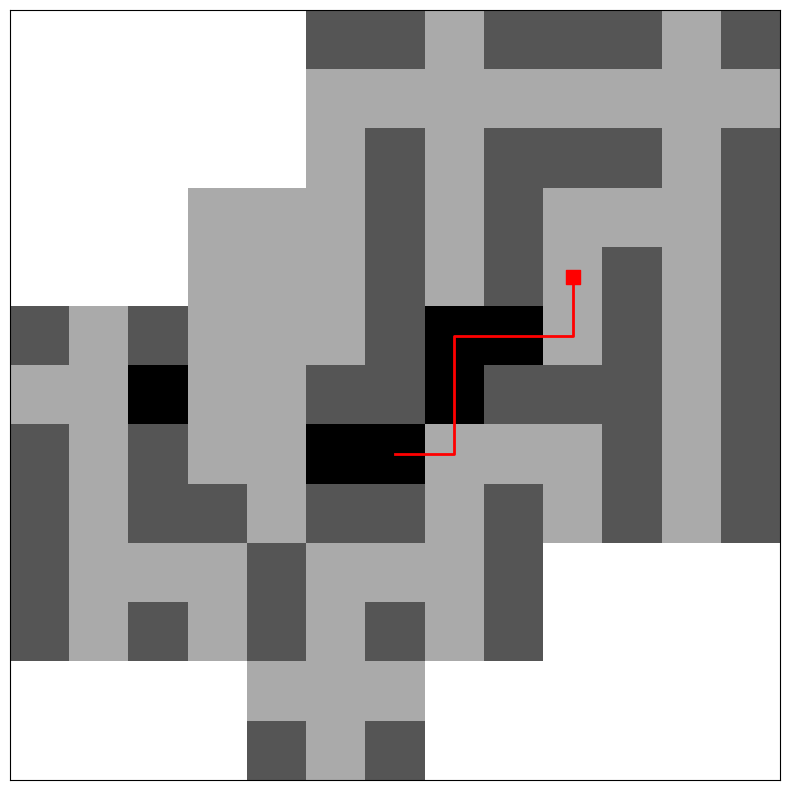

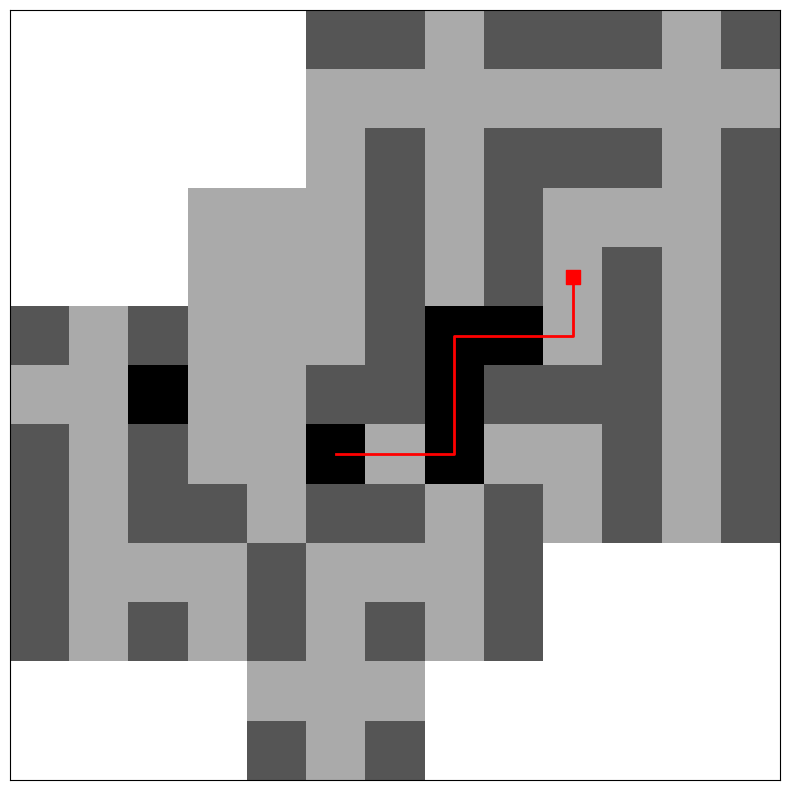

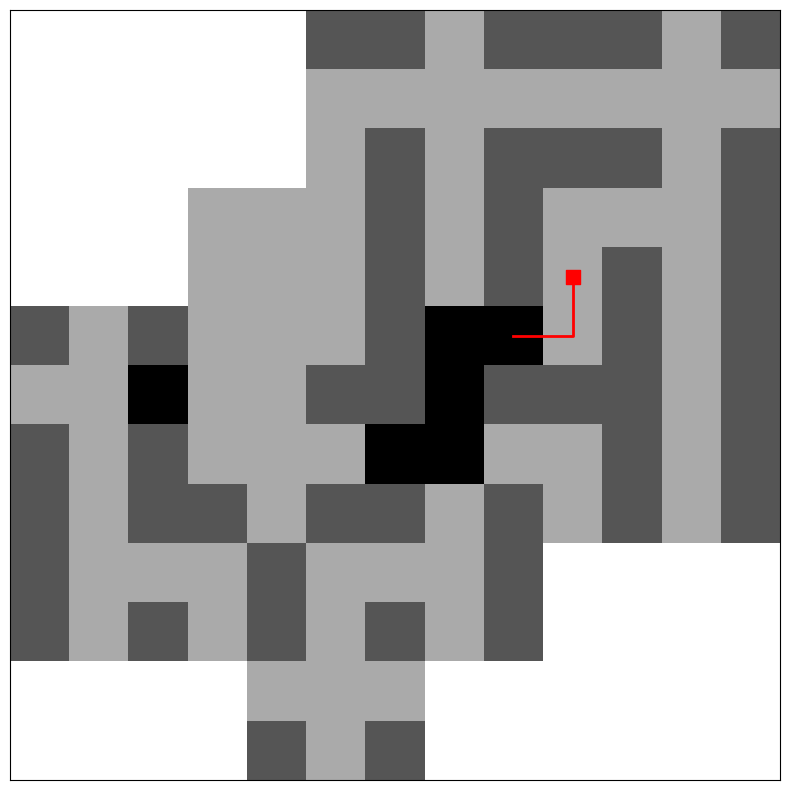

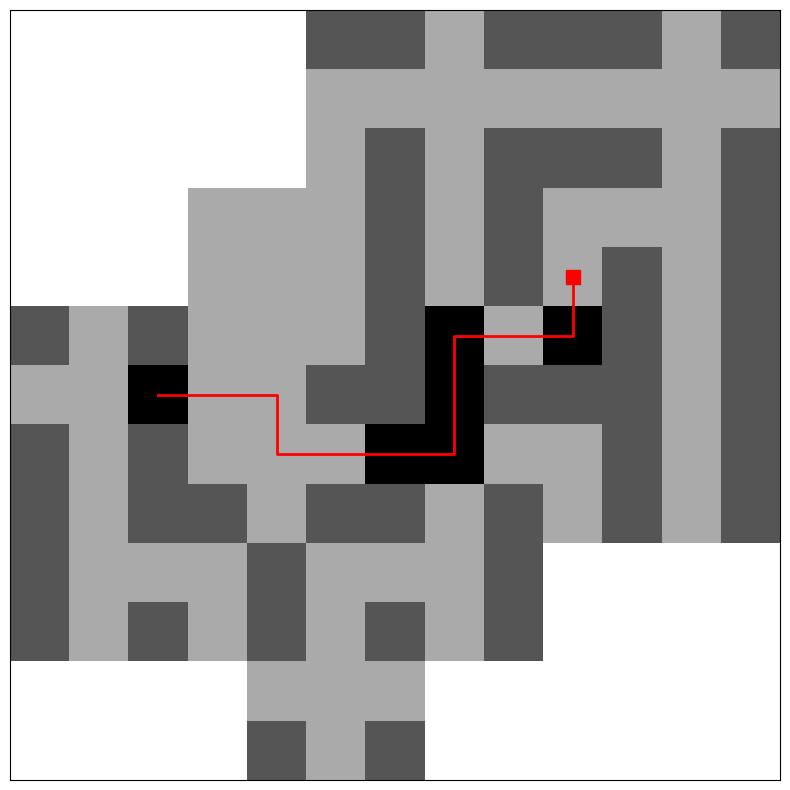

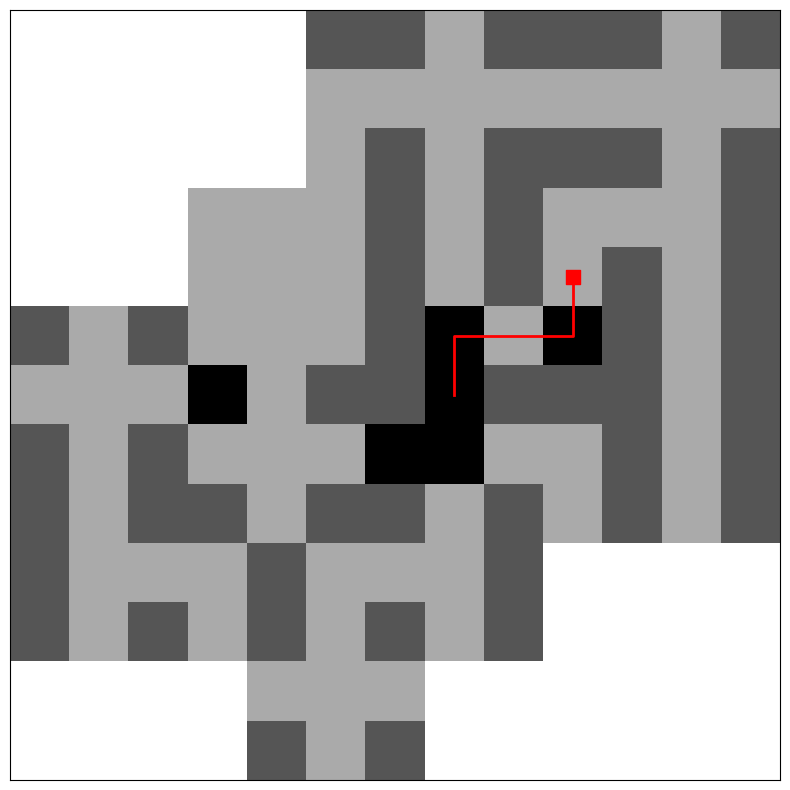

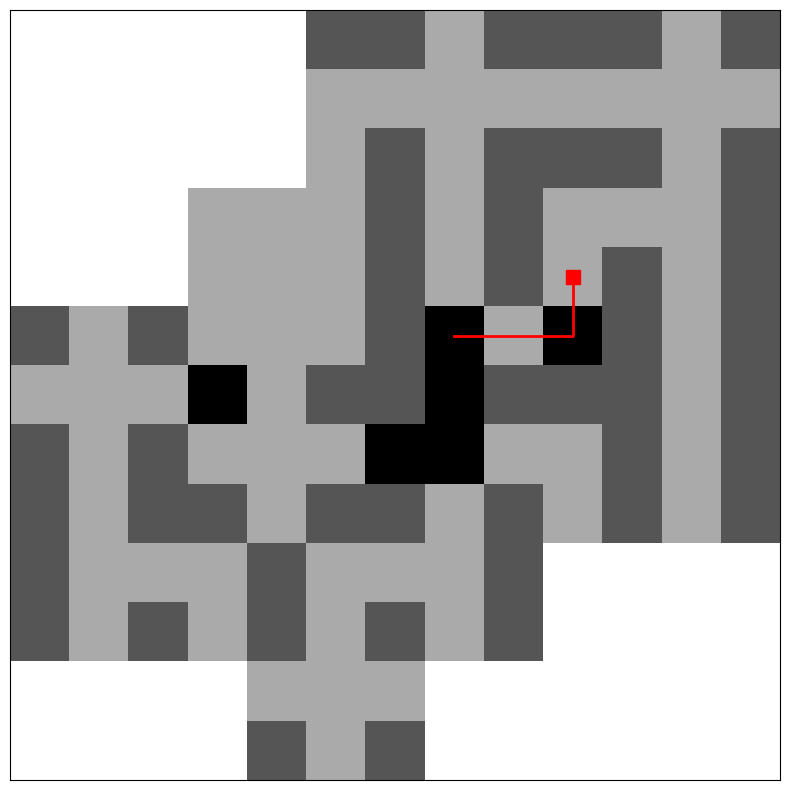

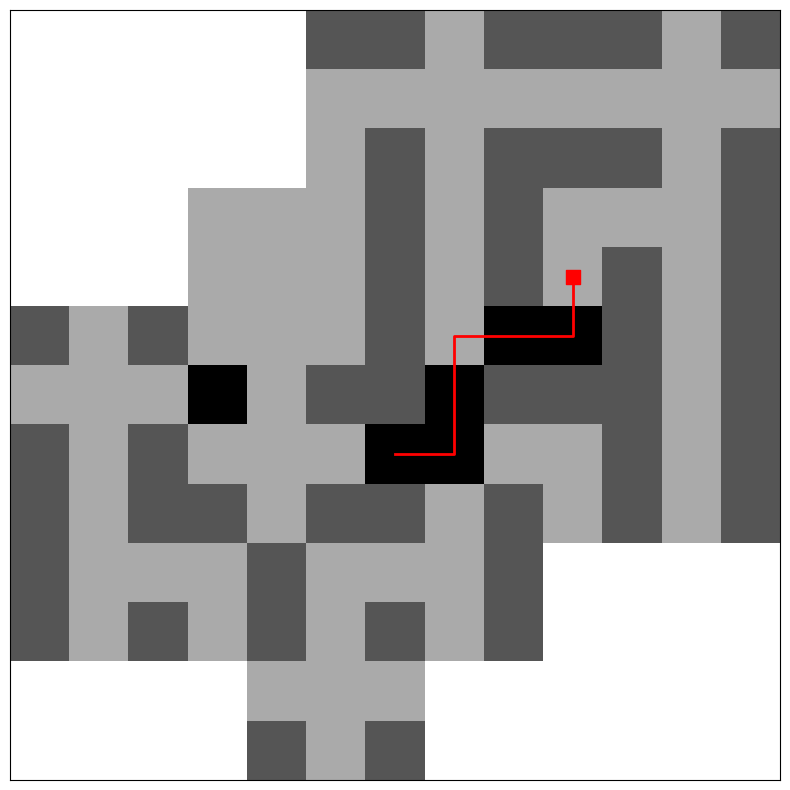

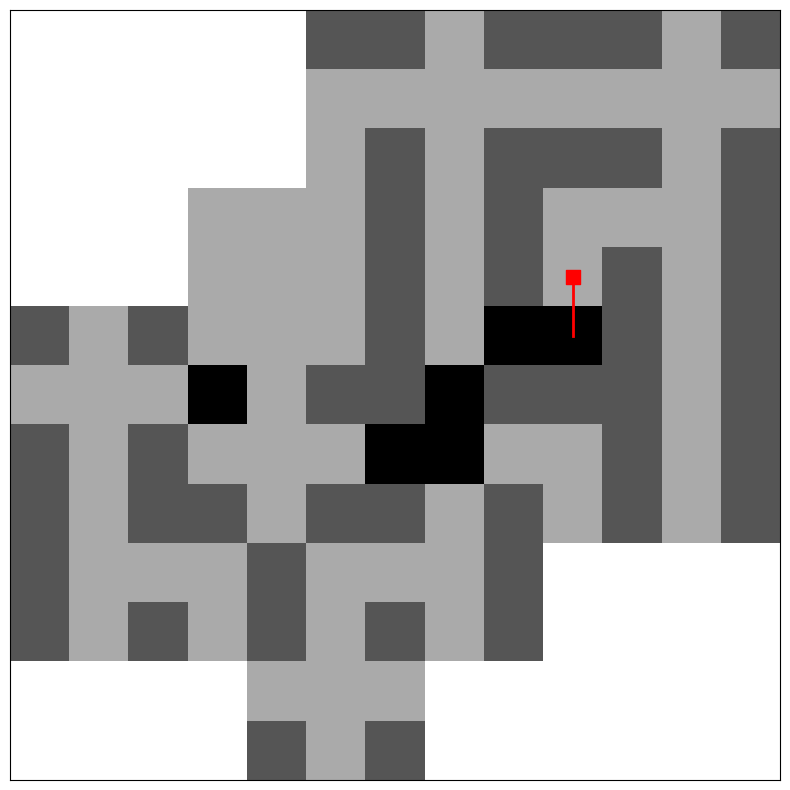

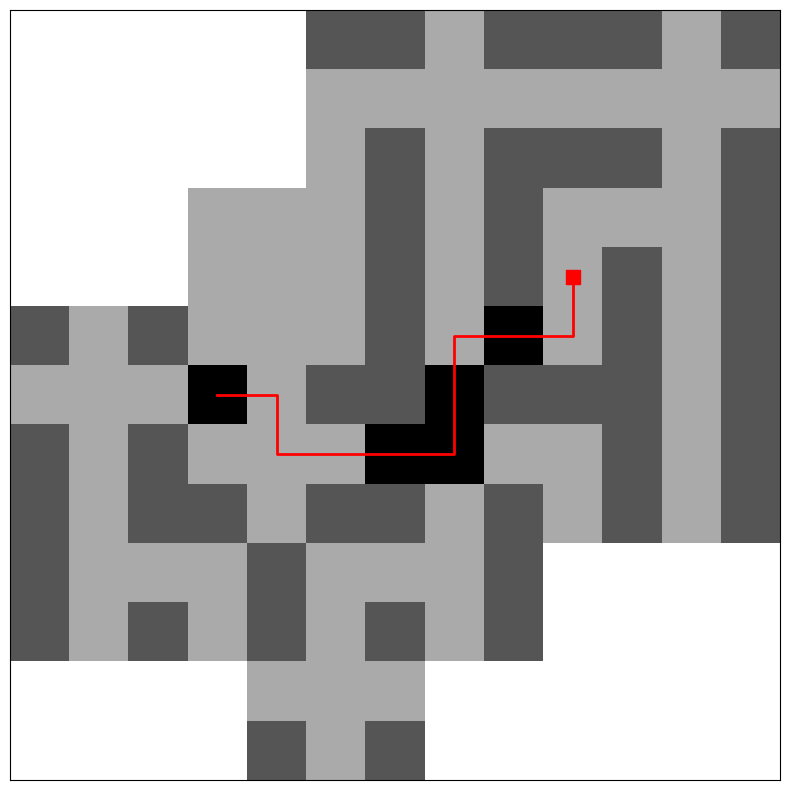

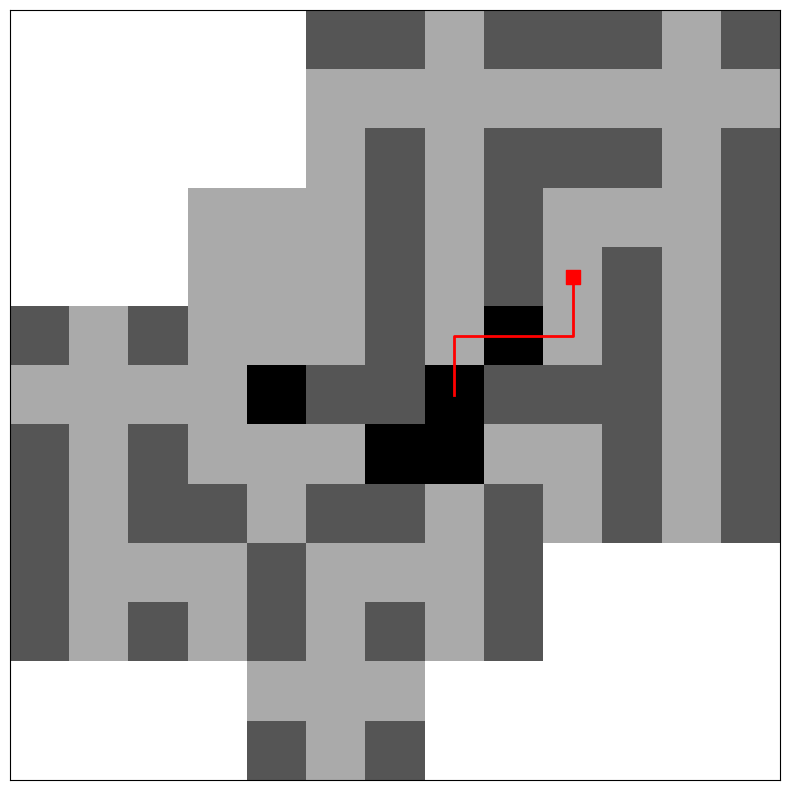

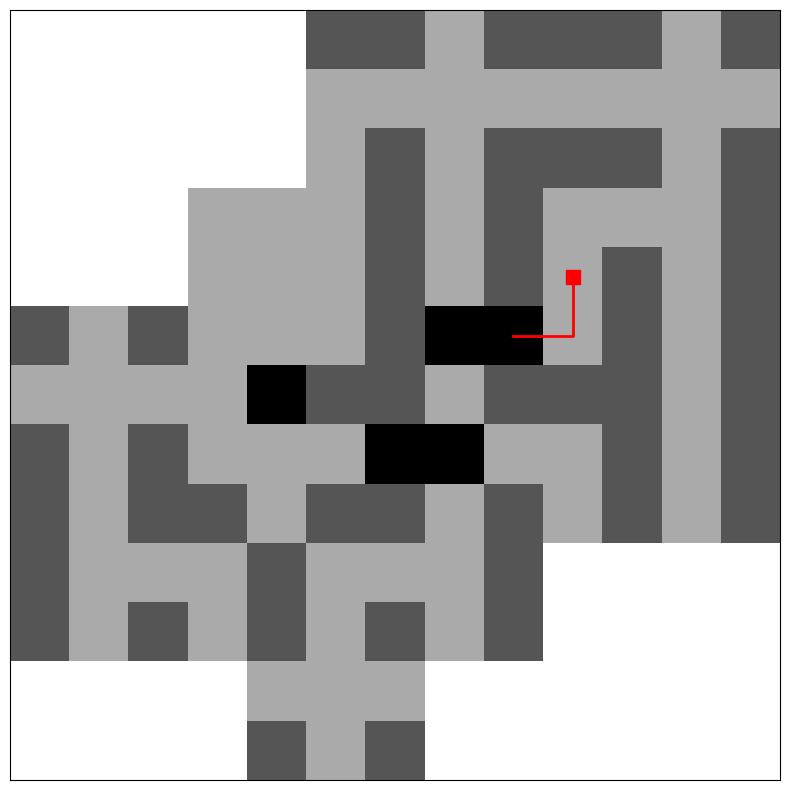

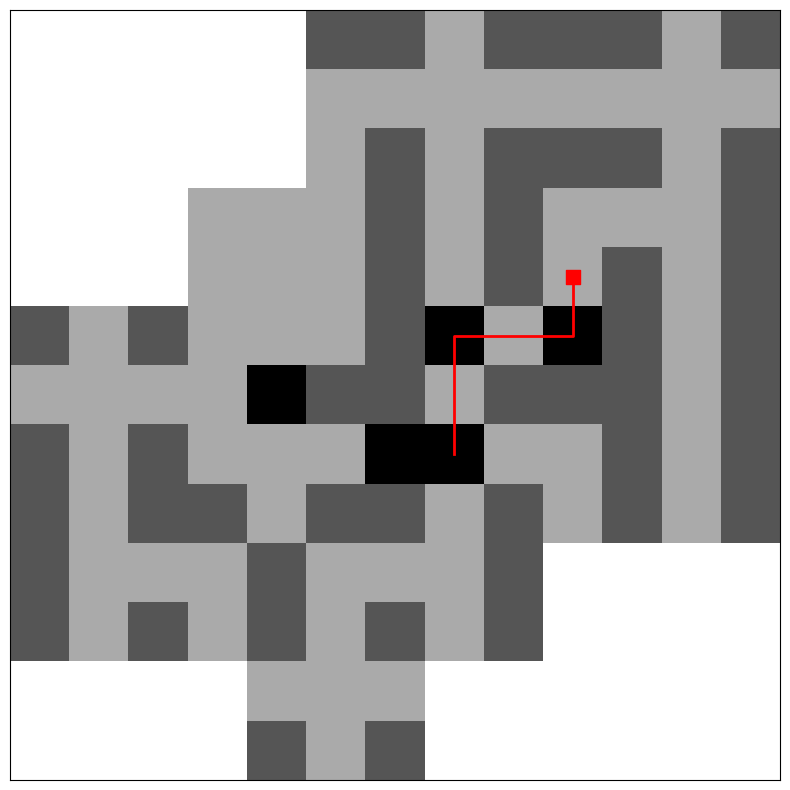

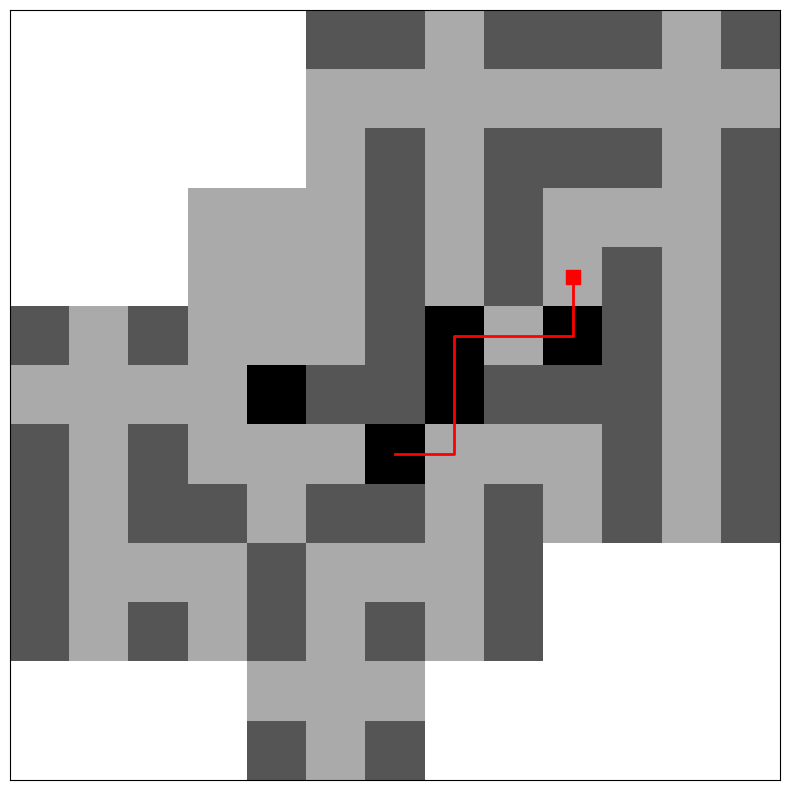

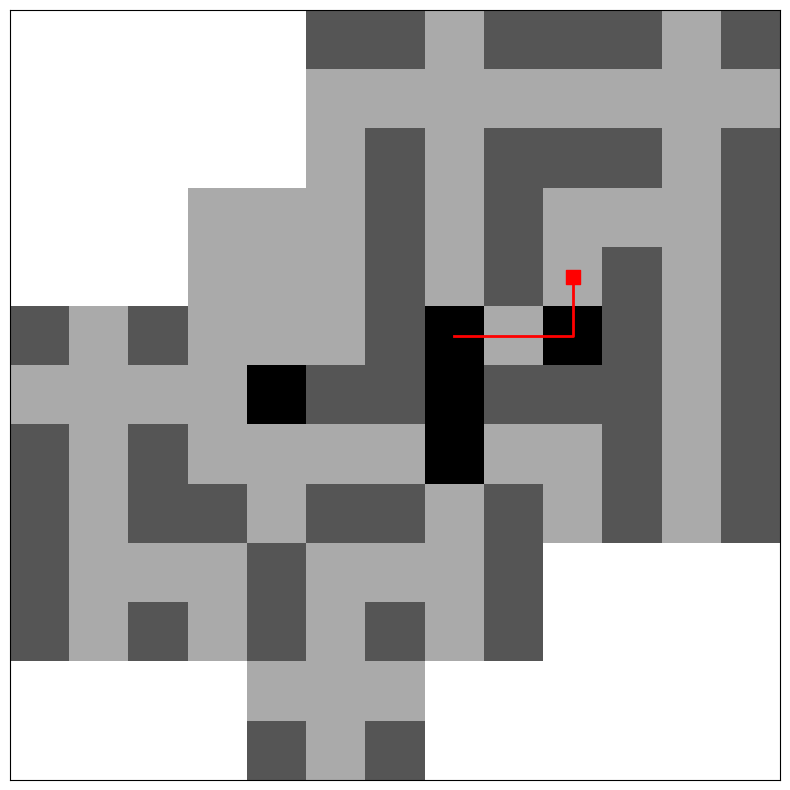

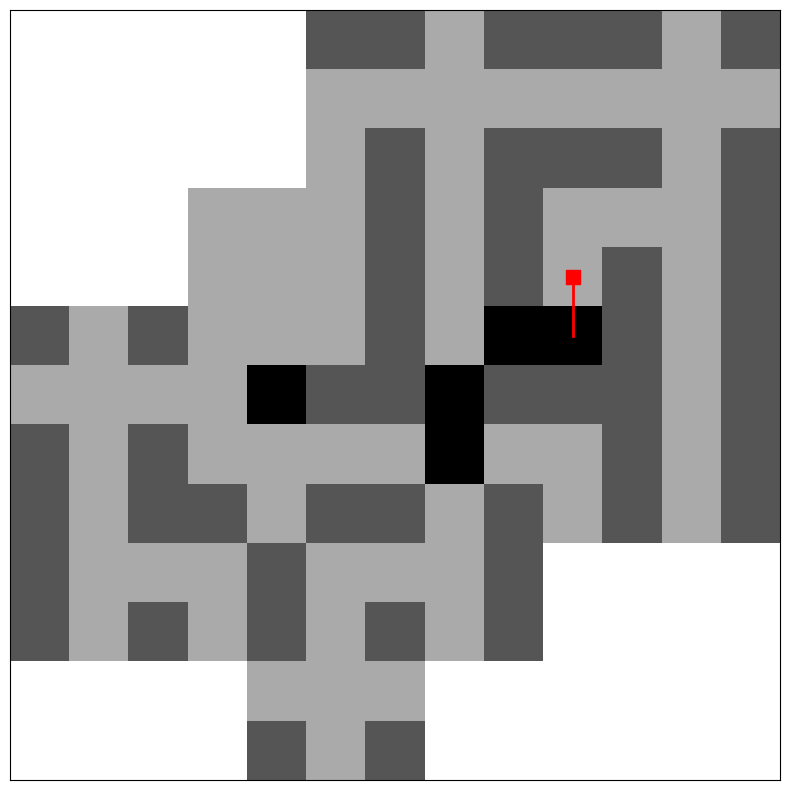

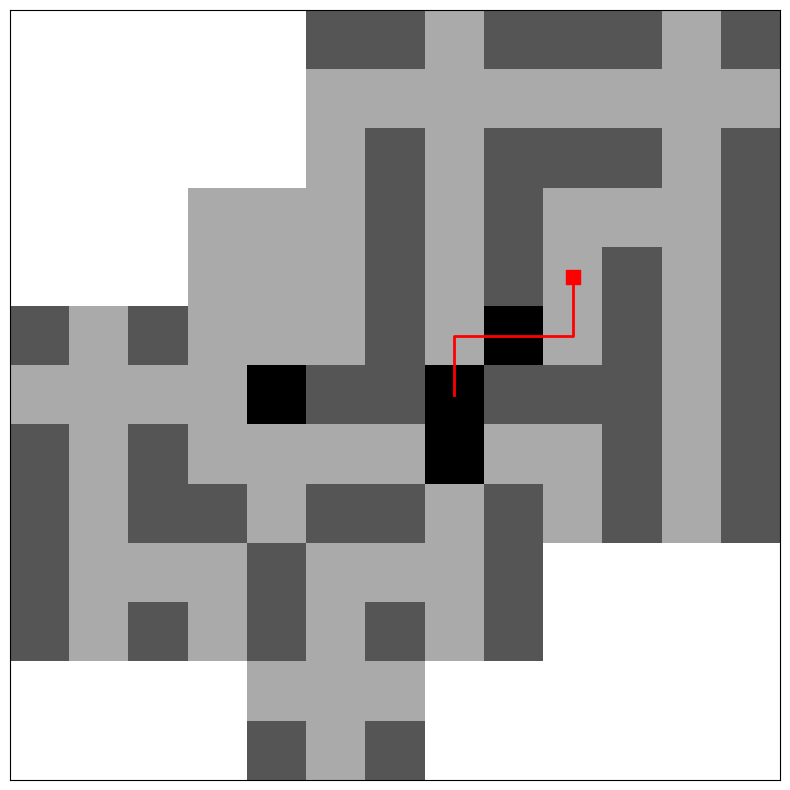

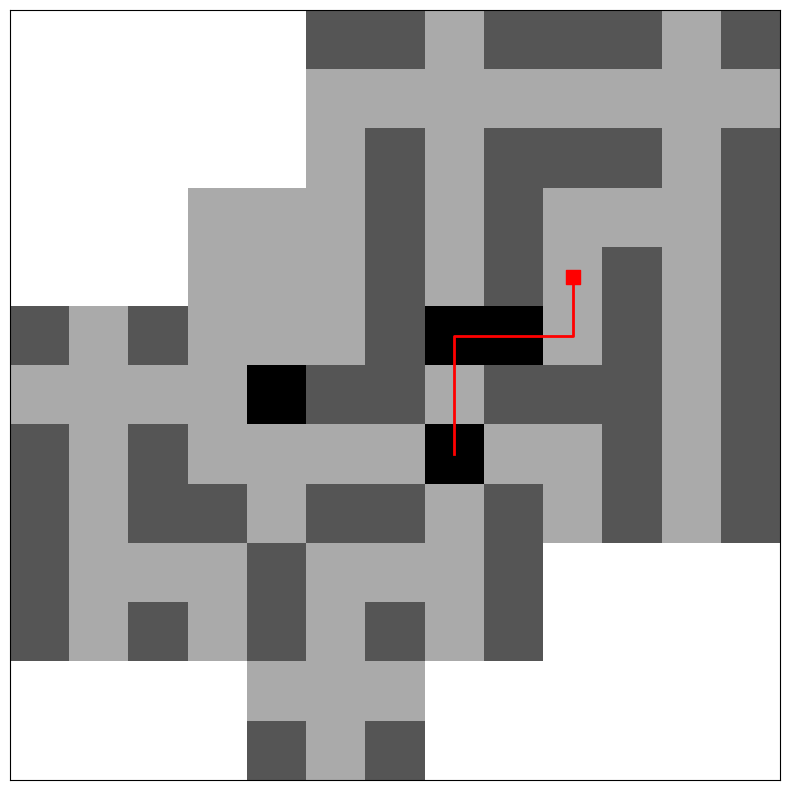

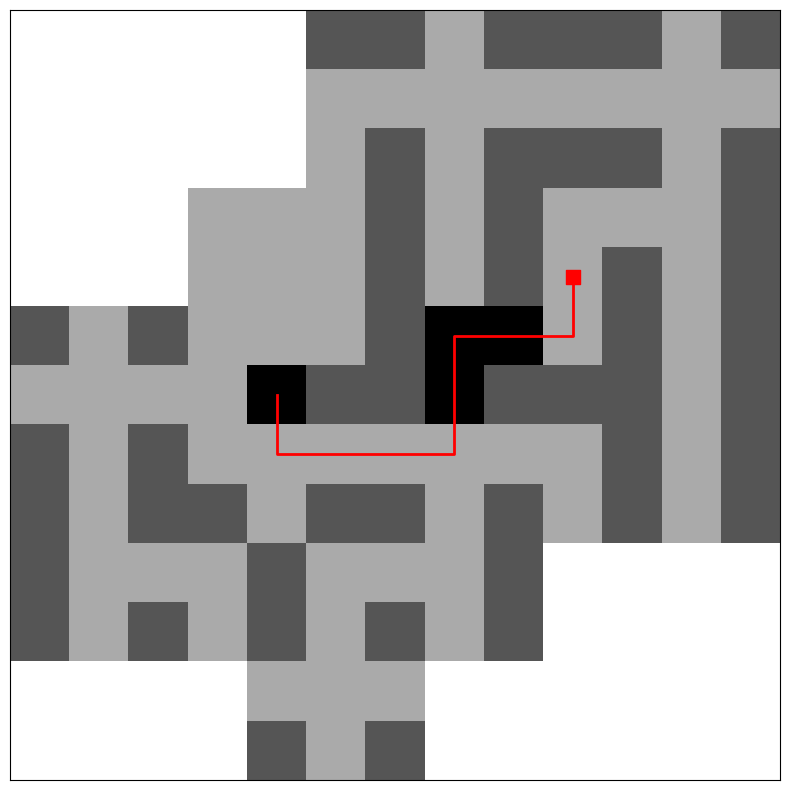

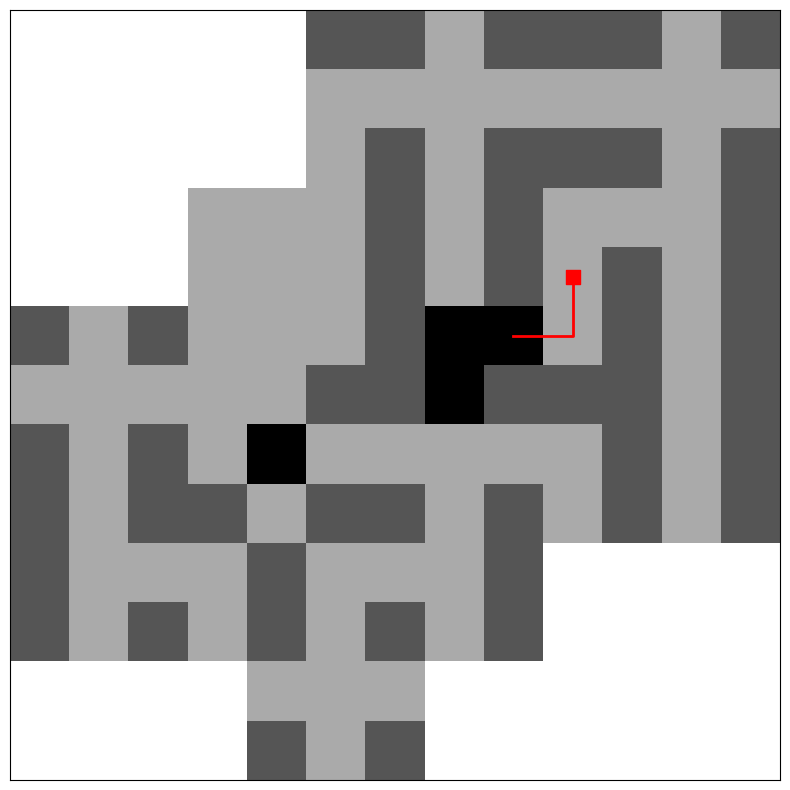

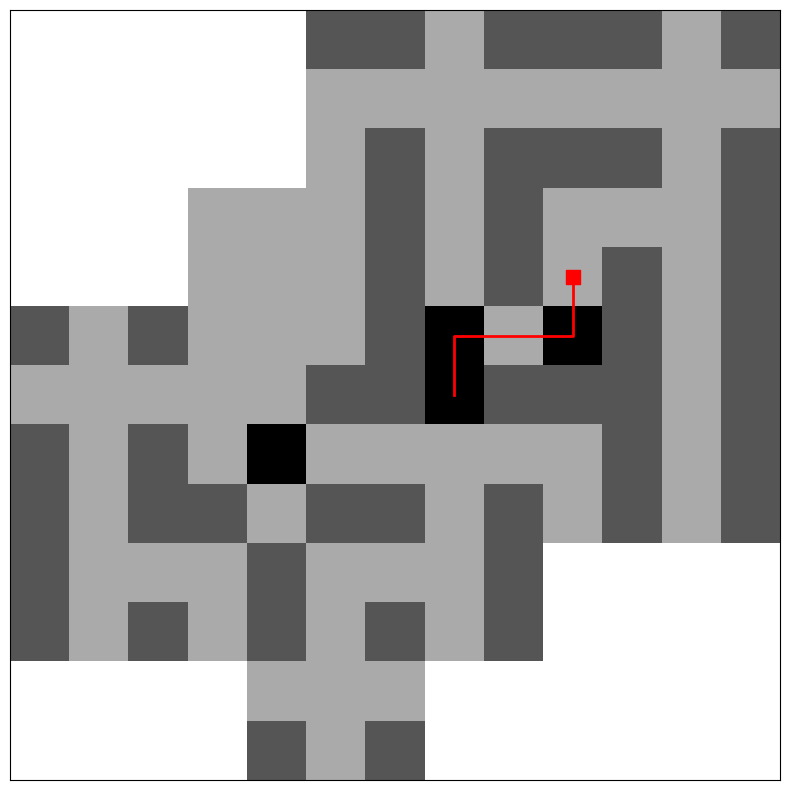

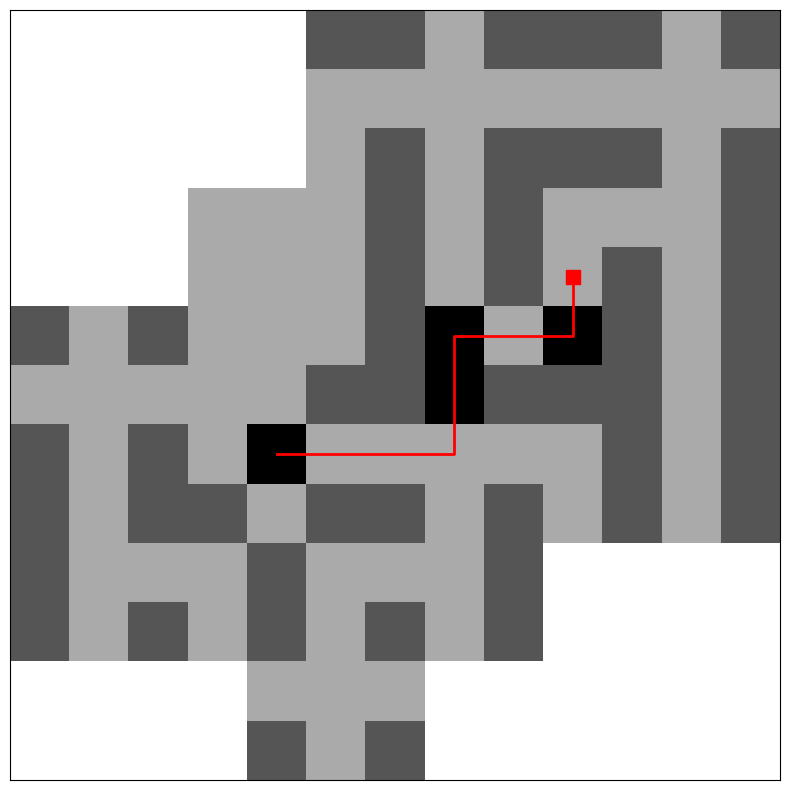

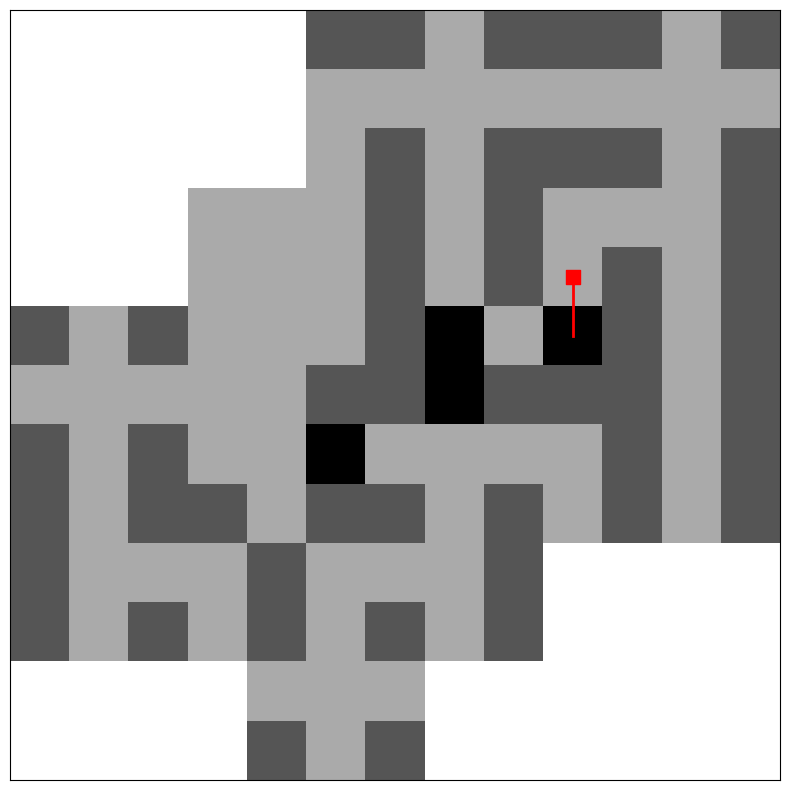

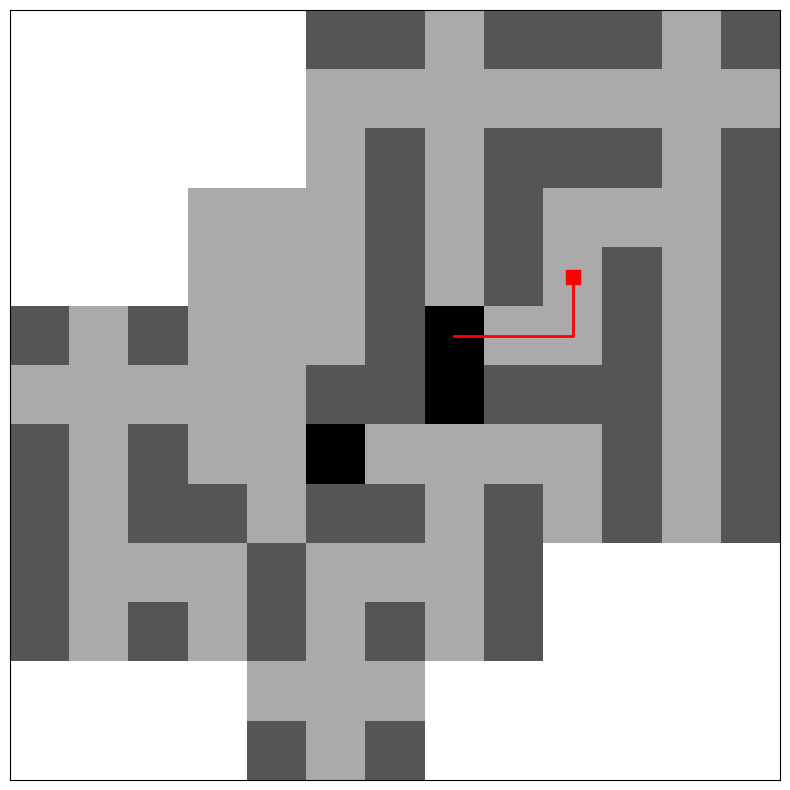

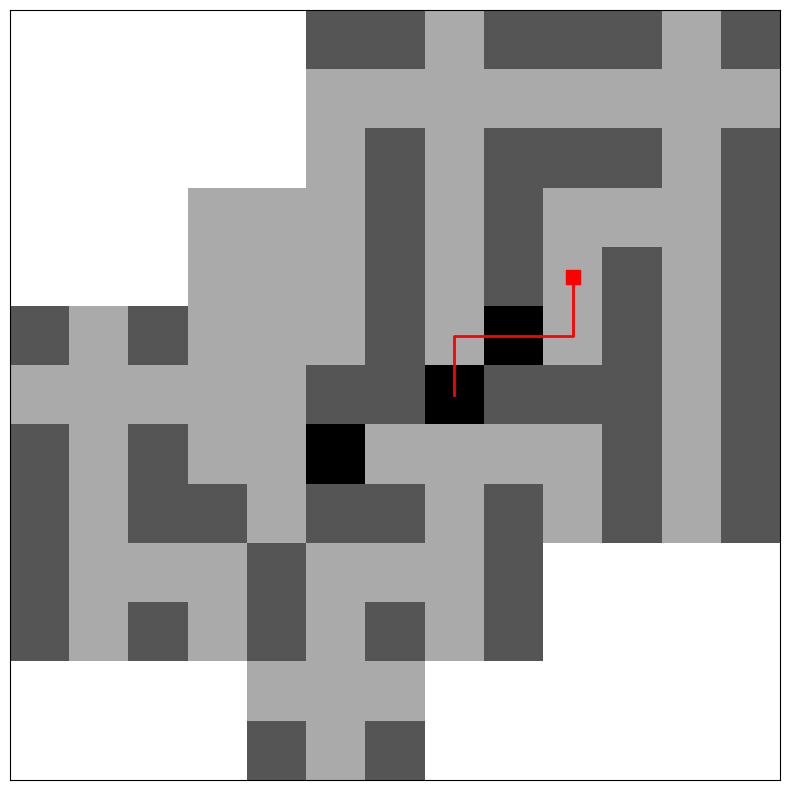

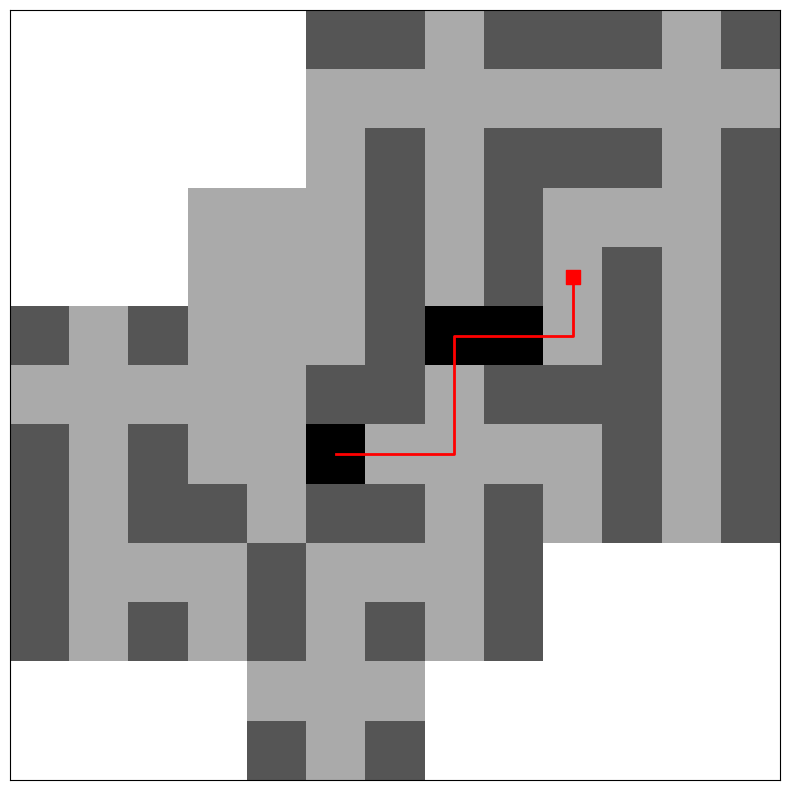

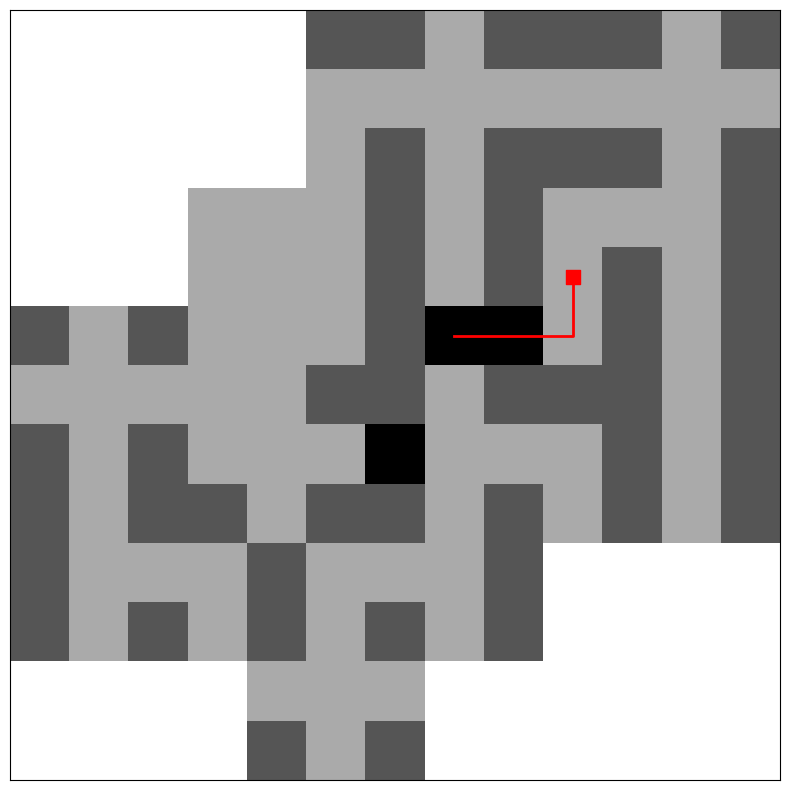

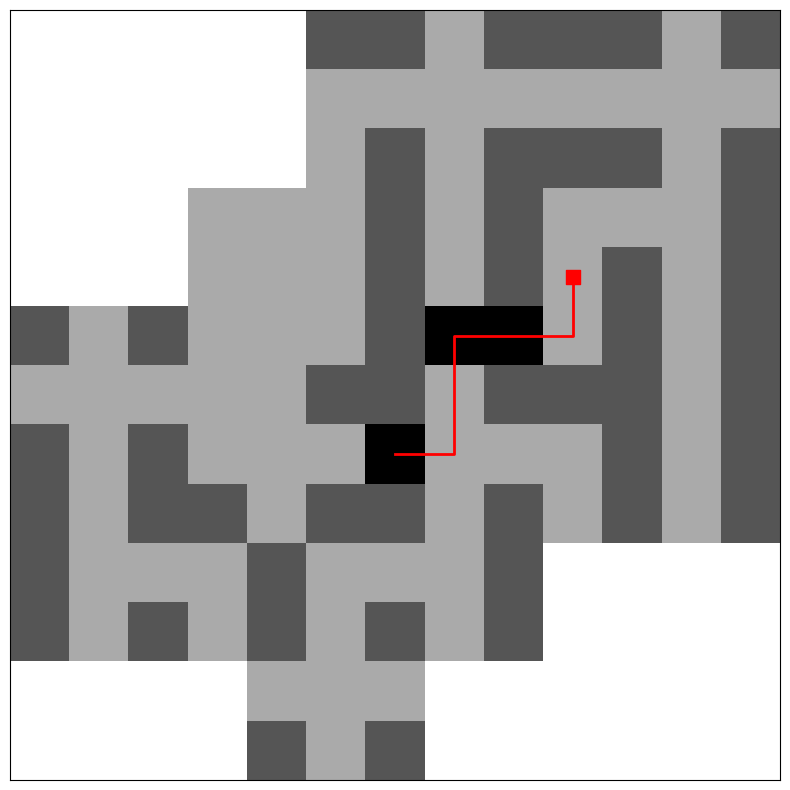

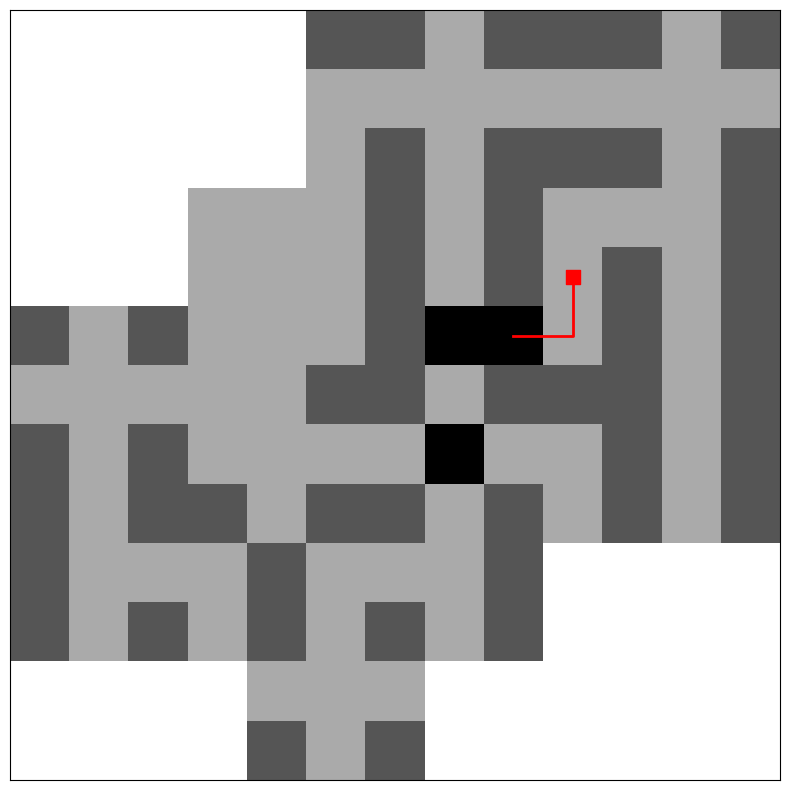

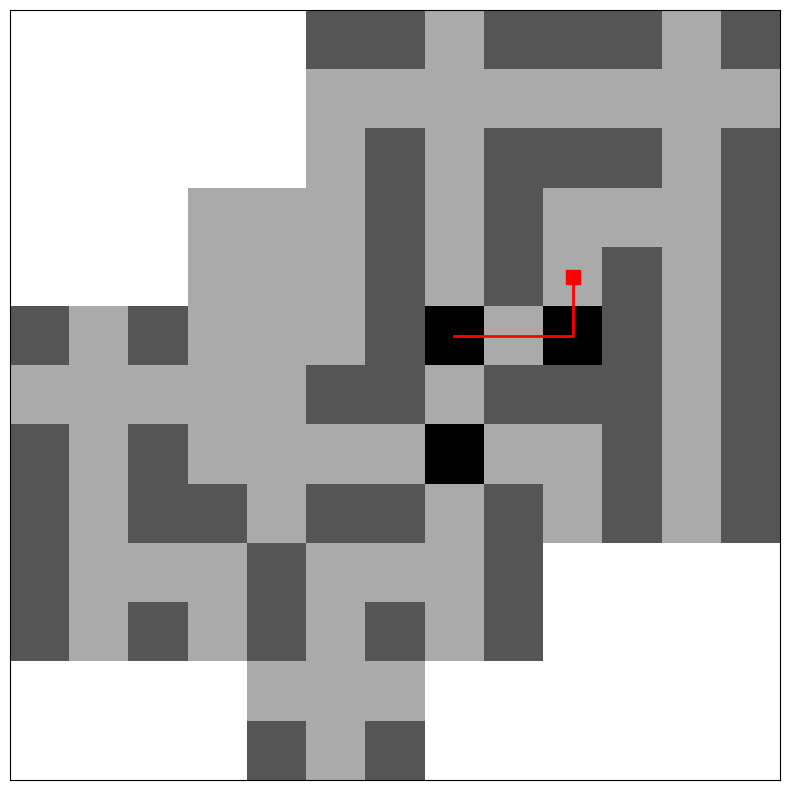

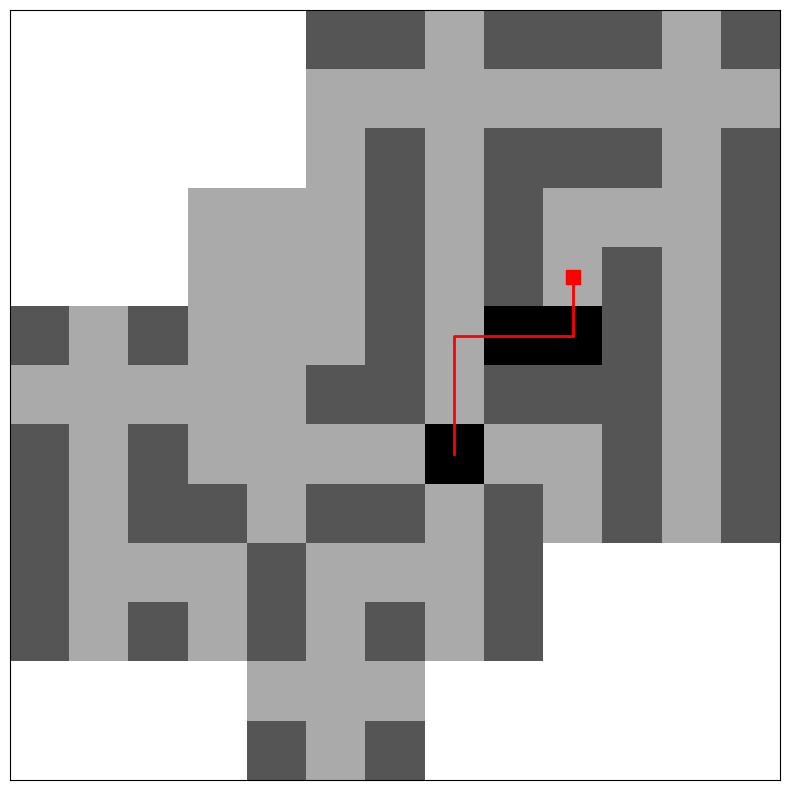

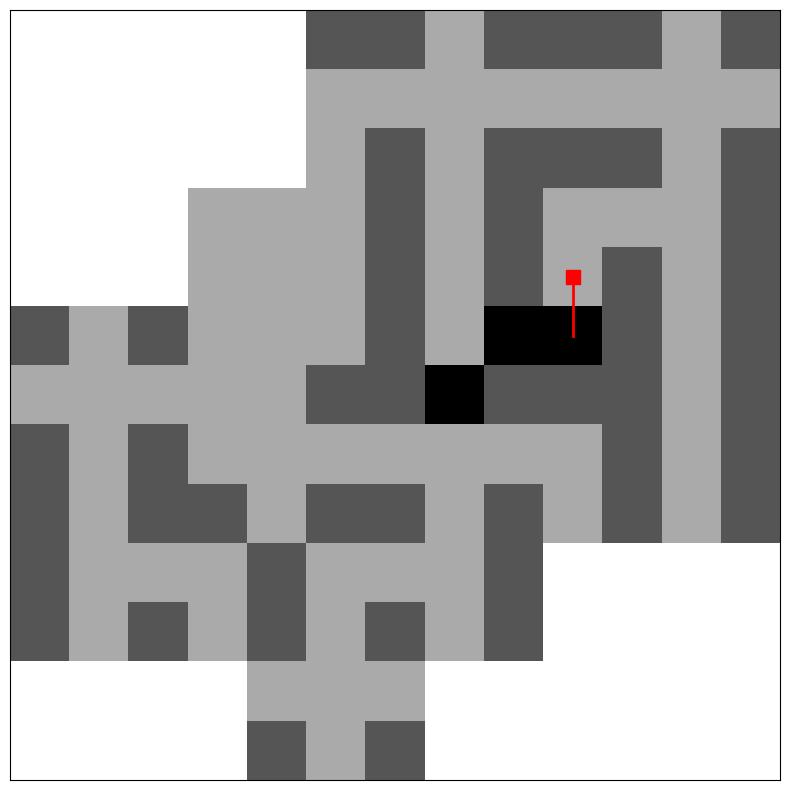

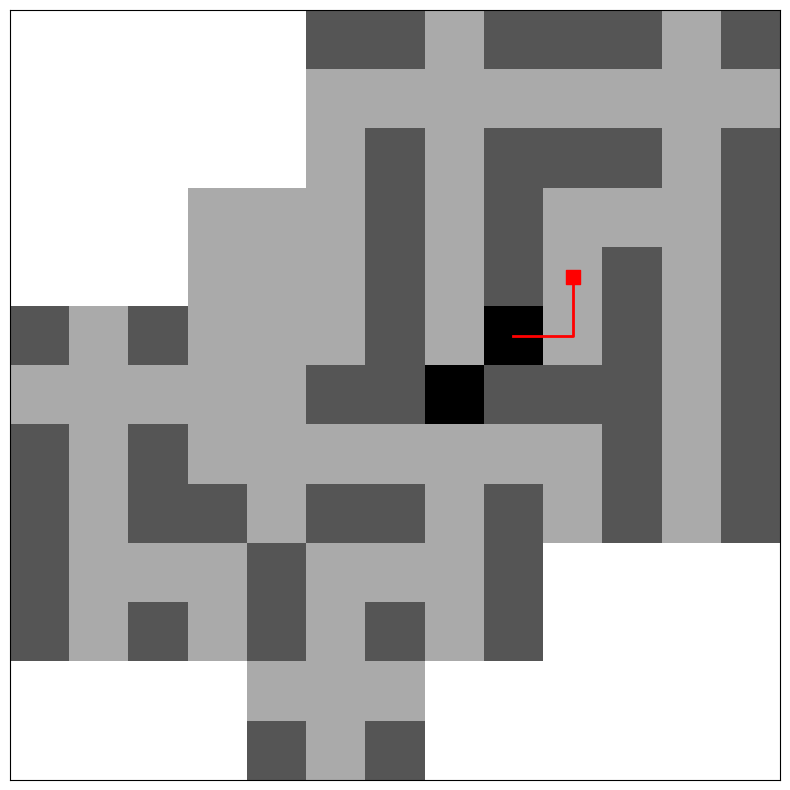

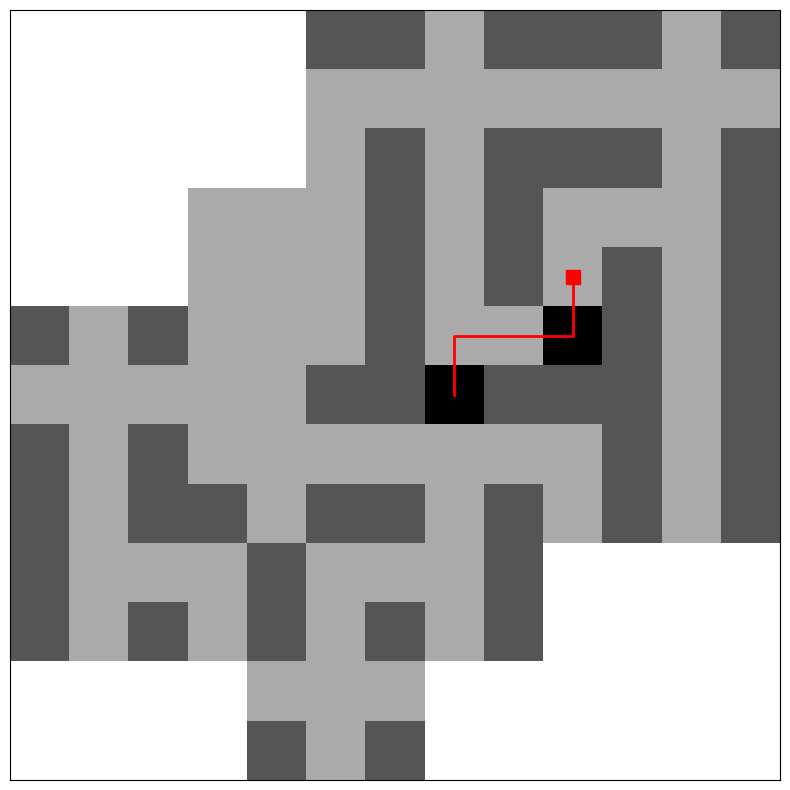

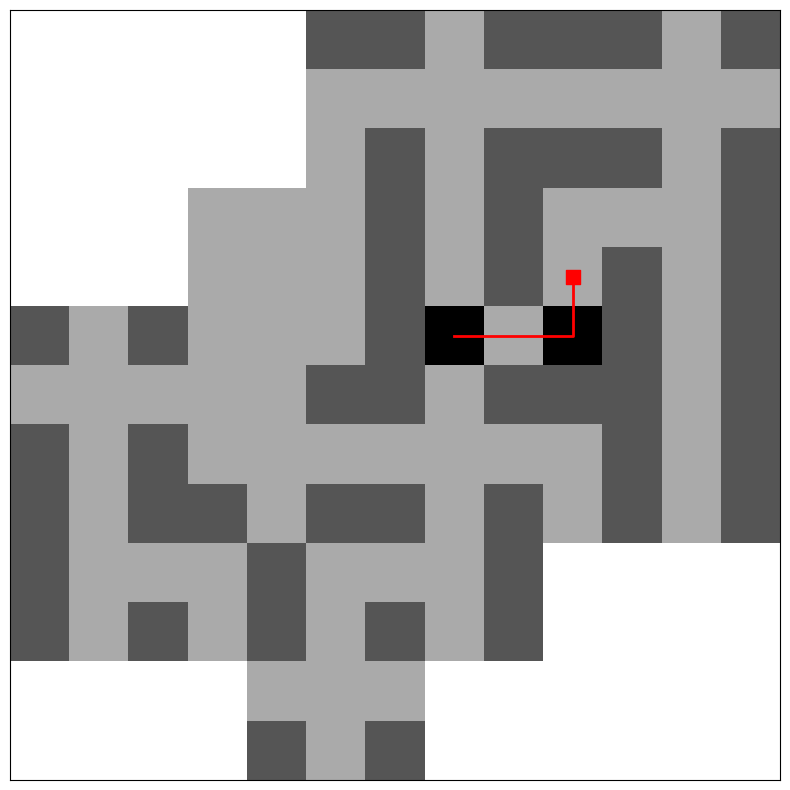

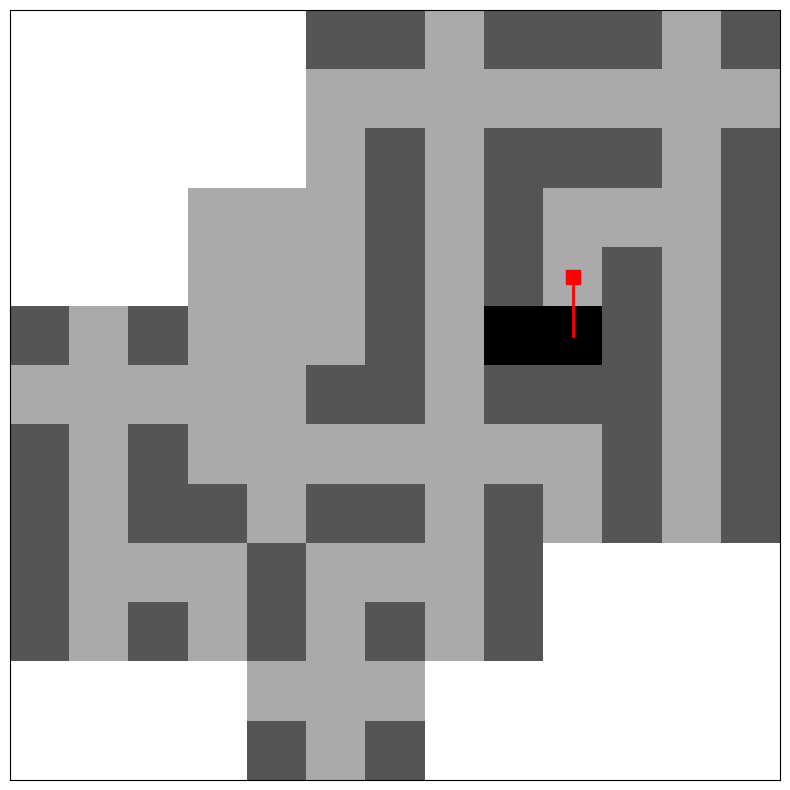

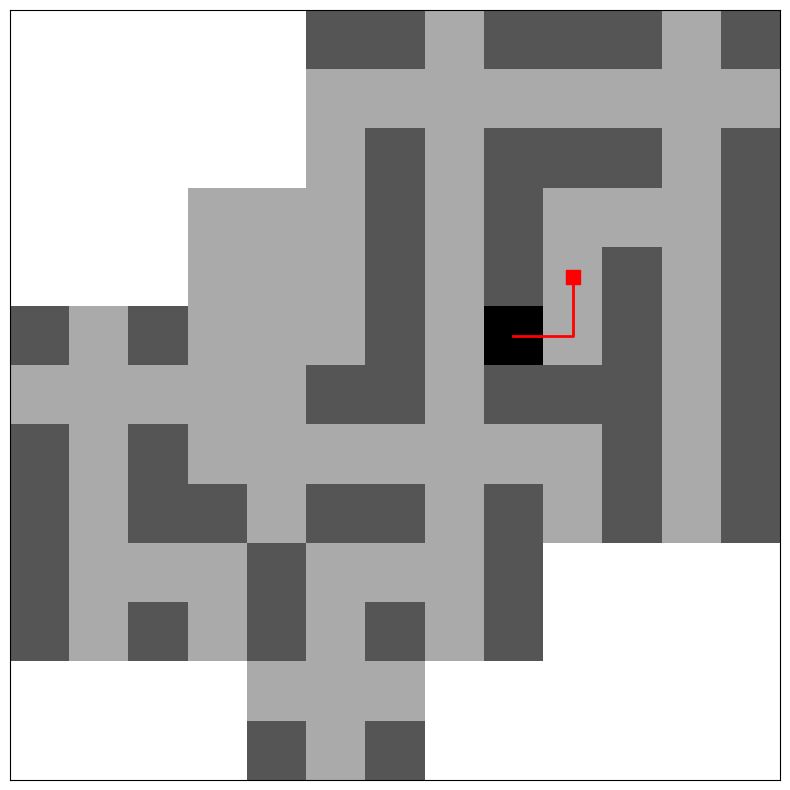

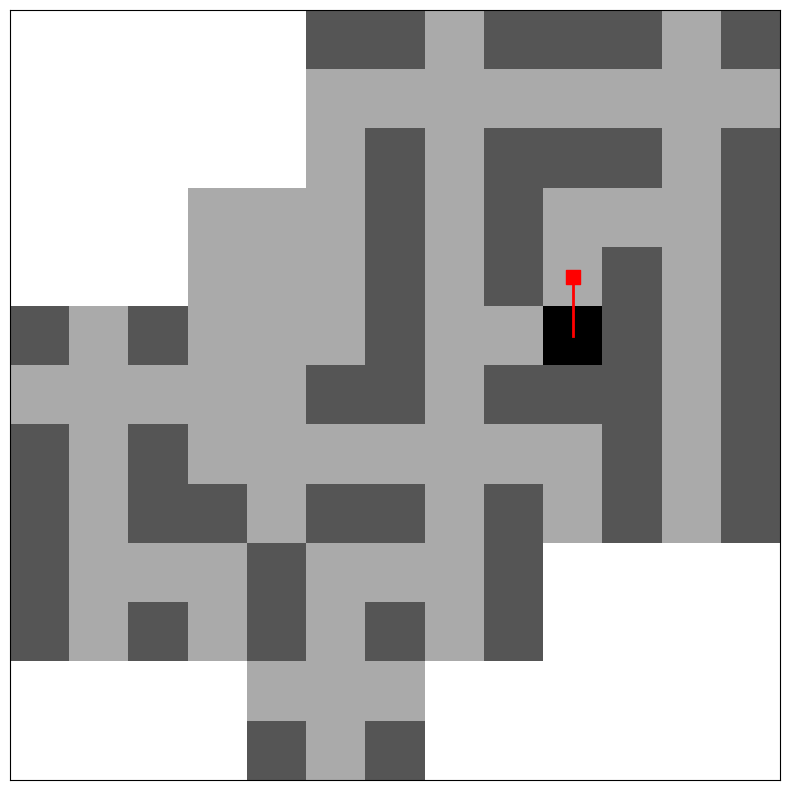

Average Coverage Percentage: 0.7100591715976332 / Average Finished: 1.0 / Average Experiment Time: 23.89480209350586s / Average Episode Time: 1.1940773248672485 / Average Agent Finish Time : 18.540159749984742


In [46]:
num_agents = 10 # number of agents.
num_test = 1
res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=13, cols=13, obs_prob=0.85), debug=True)

Solve the test_maze with 20 agents and max view range:

In [ ]:
num_agents = 12 # number of agents.
num_test = 100
res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=10, cols=10, obs_prob=0.85), agent_view_range=1000, debug=False)

Average Coverage Percentage: 0.9352066115702481 / Average Finished: 1.0 / Average Experiment Time: 0.2656491494178772s / Average Episode Time: 0.010906205846444132 / Average Agent Finish Time : 0.19411693632602692


Solve the test_maze with 10 agents and max view range:

In [ ]:
num_agents = 10 # number of agents.
num_test = 20
res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=13, cols=13, obs_prob=0.85), agent_view_range=1000)

Average Coverage Percentage: 0.9005917159763314 / Average Finished: 1.0 / Average Experiment Time: 0.26861943006515504s / Average Episode Time: 0.010495112472533728 / Average Agent Finish Time : 0.20323178291320804


Solve the test_maze with 5 agents and max view range:

In [ ]:
num_agents = 5 # number of agents.
num_test = 20
res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=13, cols=13, obs_prob=0.85), agent_view_range=1000)

Average Coverage Percentage: 0.766568047337278 / Average Finished: 1.0 / Average Experiment Time: 0.14014105796813964s / Average Episode Time: 0.005260413190012698 / Average Agent Finish Time : 0.10997708559036254


Solve the test_maze with 25 agents and max view range:

In [ ]:
num_agents = 25 # number of agents.
num_test = 15
res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=13, cols=13, obs_prob=0.85), agent_view_range=1000)

Average Coverage Percentage: 0.9715976331360946 / Average Finished: 1.0 / Average Experiment Time: 0.8653894901275635s / Average Episode Time: 0.023398469526998818 / Average Agent Finish Time : 0.6274689356486004


Save experiments on a xlsx file:

In [14]:
file_path = '/content/drive/My Drive/astar_swarm.xlsx'

# Initialization Parameters ========
min_num_agents = 10
max_num_agents = 25
min_maze_dim = 10
max_maze_dim = 30
num_test = 100
# =================================

try:
    df = pd.read_excel(file_path)
except FileNotFoundError:
    df = pd.DataFrame(columns=["#_Agents", "Coverage", "Finished_Agents", "Experiment_Time", "Episode_Time", "Agent_Finish_Time", "Dimensions"])

for maze_dim in range(min_maze_dim, max_maze_dim + 1):
  print(f"Maze Dimensions: {maze_dim}x{maze_dim}")
  for num_agent in range(min_num_agents, max_num_agents + 1):
    print(f"  Agent number: {num_agent}")
    avg_cover, avg_finish, avg_expt_time, avg_eps_time, avg_agent_time = test_astar(num_agent, num_test, gen_stage_func=functools.partial(create_maze, rows=maze_dim, cols=maze_dim, obs_prob=0.85), agent_view_range=1000, debug=False)
    new_row = {
        "#_Agents": num_agent,
        "Coverage": avg_cover,
        "Finished_Agents": avg_finish,
        "Experiment_Time": avg_expt_time,
        "Episode_Time": avg_eps_time,
        "Agent_Finish_Time": avg_agent_time,
        "Dimensions": (maze_dim, maze_dim)
    }

    df = df.append(new_row, ignore_index=True)
    df.to_excel(file_path, float_format='%.5f', index=False)


Maze Dimensions: 29x29
  Agent number: 15
Average Coverage Percentage: 0.7799881093935791 / Average Finished: 1.0 / Average Experiment Time: 3.363940963745117s / Average Episode Time: 0.06884583598574946 / Average Agent Finish Time : 2.814425188064575
  Agent number: 16
Average Coverage Percentage: 0.7928894173602855 / Average Finished: 1.0 / Average Experiment Time: 3.6300790071487428s / Average Episode Time: 0.07444014549225877 / Average Agent Finish Time : 3.11313471108675
  Agent number: 17
Average Coverage Percentage: 0.7813079667063021 / Average Finished: 1.0 / Average Experiment Time: 3.591286337375641s / Average Episode Time: 0.0737840244109917 / Average Agent Finish Time : 3.074718665655921
  Agent number: 18
Average Coverage Percentage: 0.8098692033293698 / Average Finished: 1.0 / Average Experiment Time: 3.820807919502258s / Average Episode Time: 0.07816444247708448 / Average Agent Finish Time : 3.2399980914592743
  Agent number: 19
Average Coverage Percentage: 0.81103448275

(to sort the df, use `df = df.sort_values(by=['#_Agents', 'Dimensions'])`

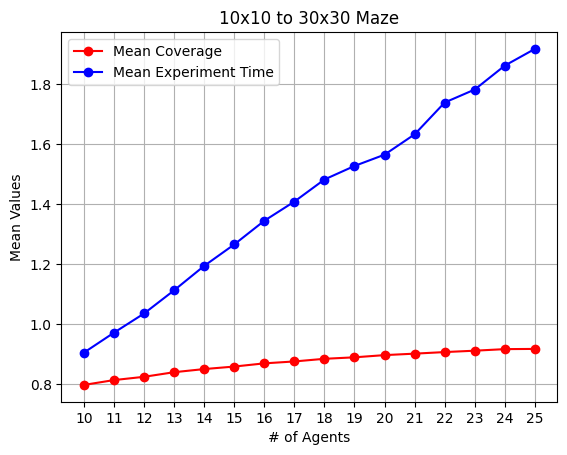

In [36]:
from sklearn.preprocessing import MinMaxScaler

file_path = '/content/drive/My Drive/astar_swarm.xlsx'
df = pd.read_excel(file_path).groupby('#_Agents').mean().reset_index()

plt.plot(df['#_Agents'], df['Coverage'], color='red', label='Mean Coverage', marker='o')
plt.plot(df['#_Agents'], df['Experiment_Time'], color='blue', label='Mean Experiment Time', marker='o')

plt.title("10x10 to 30x30 Maze")
plt.xlabel('# of Agents')
plt.ylabel('Mean Values')
plt.legend()
plt.xticks(df['#_Agents'].astype(int))
plt.grid(True)
plt.show()

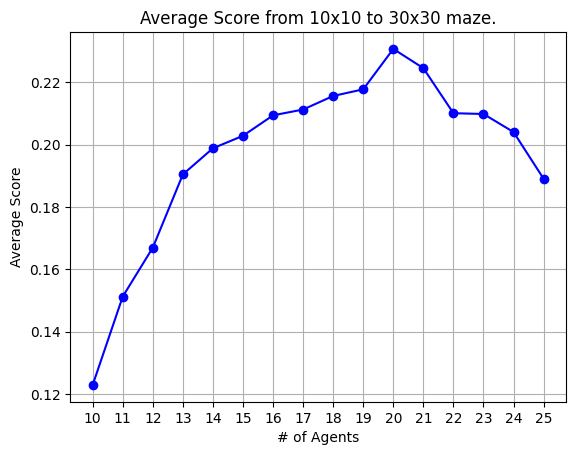

In [48]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

file_path = '/content/drive/My Drive/astar_swarm.xlsx'
df = pd.read_excel(file_path)

# weights sum up to 0.
weights = {
    'Coverage': 1,
    'Finished_Agents': 0,
    'Experiment_Time': -1,
    'Episode_Time': -0.5,
    'Agent_Finish_Time': -0.5,
}

scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[['Coverage', 'Experiment_Time', 'Episode_Time', 'Agent_Finish_Time']]),
                              columns=['Coverage', 'Experiment_Time', 'Episode_Time', 'Agent_Finish_Time'])

df['Composite_Score'] = (df_normalized['Coverage'] * weights['Coverage'] +
                         df_normalized['Experiment_Time'] * weights['Experiment_Time'] +
                         df_normalized['Episode_Time'] * weights['Episode_Time'] +
                         df_normalized['Agent_Finish_Time'] * weights['Agent_Finish_Time'])

# print(df)

avg_scores = df.groupby('#_Agents')['Composite_Score'].mean().reset_index(name='Average_Score')
# print(avg_scores)

plt.plot(avg_scores['#_Agents'], avg_scores['Average_Score'], marker='o', linestyle='-', color='b')
plt.xlabel('# of Agents')
plt.xticks(avg_scores['#_Agents'].astype(int))
plt.ylabel('Average Score')
plt.title("Average Score from 10x10 to 30x30 maze.")
plt.grid(True)
plt.show()

**OLD VERSION** of the Agent Class:
```
class Agent:

  def __init__(self, x, y, direction, real_stage, explored_stage):
    self.x = x
    self.y = y
    self.direction = direction  # 'up', 'down', 'left', 'right'
    self.real_stage = real_stage  # contains obstacles and paths
    self.explored_stage = explored_stage  # explored stage (contains agents)

  def move_left(self):
    self.direction = "left"
    if self.y > 0:
      if self.real_stage[(self.x, self.y - 1)] or self.explored_stage[(self.x, self.y - 1)]:  # obs or other agent
        print("obs")
        self.refresh_agent_view()
        return
      self.explored_stage[(self.x, self.y)] = 0
      self.y -= 1
      self.explored_stage[(self.x, self.y)] = 2
      self.refresh_agent_view()

  def move_right(self):
    self.direction = 'right'
    if self.y < len(self.explored_stage[0]) - 1:
      if self.real_stage[(self.x, self.y + 1)] or self.explored_stage[(self.x, self.y + 1)]:  # obs or other agent
        print("obs")
        self.refresh_agent_view()
        return
      self.explored_stage[(self.x, self.y)] = 0
      self.y += 1
      self.explored_stage[(self.x, self.y)] = 2
      self.refresh_agent_view()

  def move_up(self):
    self.direction = 'up'
    if self.x > 0:
      if self.real_stage[(self.x - 1, self.y)] or self.explored_stage[(self.x - 1, self.y)]:  # obs or other agent
        print("obs")
        self.refresh_agent_view()
        return
      self.explored_stage[(self.x, self.y)] = 0
      self.x -= 1
      self.explored_stage[(self.x, self.y)] = 2
      self.refresh_agent_view()

  def move_down(self):
    self.direction = 'down'
    if self.x < len(self.explored_stage) - 1:
      if self.real_stage[(self.x + 1, self.y)] or self.explored_stage[(self.x + 1, self.y)]:  # obs or other agent
        print("obs")
        self.refresh_agent_view()
        return
      self.explored_stage[(self.x, self.y)] = 0
      self.x += 1
      self.explored_stage[(self.x, self.y)] = 2
      self.refresh_agent_view()

  def refresh_agent_view(self):
    # Generate agent view =======
    # Ex. If agent looks up -> knows both up, left and right (/w sensors).
    if self.direction == "up":
      if self.x > 0:
        if self.explored_stage[(self.x - 1, self.y)] < 0: # unexplored
          self.explored_stage[(self.x - 1, self.y)] = self.real_stage[(self.x - 1, self.y)]
      if self.y < len(self.real_stage[0]) - 1:
        if self.explored_stage[(self.x, self.y + 1)] < 0:
          self.explored_stage[(self.x, self.y + 1)] = self.real_stage[(self.x, self.y + 1)]
      if self.y > 0:
        if self.explored_stage[(self.x, self.y - 1)] < 0:
          self.explored_stage[(self.x, self.y - 1)] = self.real_stage[(self.x, self.y - 1)]

    elif self.direction == "down":
      if self.x < len(self.real_stage) - 1:
        if self.explored_stage[(self.x + 1, self.y)] < 0:
          self.explored_stage[(self.x + 1, self.y)] = self.real_stage[(self.x - 1, self.y)]
      if self.y < len(self.real_stage[0]) - 1:
        if self.explored_stage[(self.x, self.y + 1)] < 0:
          self.explored_stage[(self.x, self.y + 1)] = self.real_stage[(self.x, self.y + 1)]
      if self.y > 0:
        if self.explored_stage[(self.x, self.y - 1)] < 0:
          self.explored_stage[(self.x, self.y - 1)] = self.real_stage[(self.x, self.y - 1)]

    elif self.direction == "left":
      if self.y > 0:
        if self.explored_stage[(self.x, self.y - 1)] < 0:
          self.explored_stage[(self.x, self.y - 1)] = self.real_stage[(self.x, self.y - 1)]
      if self.x < len(self.real_stage) - 1:
        if self.explored_stage[(self.x + 1, self.y)] < 0:
          self.explored_stage[(self.x + 1, self.y)] = self.real_stage[(self.x + 1, self.y)]
      if self.x > 0:
        if self.explored_stage[(self.x - 1, self.y)] < 0:
          self.explored_stage[(self.x - 1, self.y)] = self.real_stage[(self.x - 1, self.y)]

    elif self.direction == "right":
      if self.y < len(self.real_stage[0]) - 1:
        if self.explored_stage[(self.x, self.y + 1)] < 0:
          self.explored_stage[(self.x, self.y + 1)] = self.real_stage[(self.x, self.y + 1)]
      if self.x < len(self.real_stage) - 1:
        if self.explored_stage[(self.x + 1, self.y)] < 0:
          self.explored_stage[(self.x + 1, self.y)] = self.real_stage[(self.x + 1, self.y)]
      if self.x > 0:
        if self.explored_stage[(self.x - 1, self.y)] < 0:
          self.explored_stage[(self.x - 1, self.y)] = self.real_stage[(self.x - 1, self.y)]

```


Check agent view:

In [ ]:
grid = np.array([[0, 0, 1, 0, 0],
                 [1, 0, 0, 2, 1],
                 [1, 0, 0, 1, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0]])

agents = [Agent((2, 2), (2, 2), grid, 2),]
res = move_astar(grid, agents)


[[ 0 -1  1 -1 -1]
 [-1  0  0  0 -1]
 [ 1  0  0  1 -1]
 [-1  0  1  0 -1]
 [ 0 -1 -1 -1  0]]


In [ ]:
import numpy as np

grid = np.array([[0, 0, -1, -1, 1],
                 [0, 2, 0, -1, -1],
                 [-1, 0, -1, -1, -1],
                 [-1, -1, -1, -1, -1],
                 [-1, 0, -1, -1, -1]])

coordinates = np.where(grid == 2)
x, y = coordinates[0][0], coordinates[1][0]

# print(grid[:x]) # up
# print(grid[x + 1:]) # down

# print(grid[:, y + 1:])  # right
# print(grid[:, :y])  # left

above_count = np.sum(grid[:x] == -1)
below_count = np.sum(grid[x + 1:] == -1)
right_count = np.sum(grid[:, y + 1:] == -1)
left_count = np.sum(grid[:, :y] == -1)

print(above_count, below_count, right_count, left_count)

2 13 13 3


In [ ]:
l = [0, 1, 1, 0]
print(l.index(max(l)))

1
